#**Object Detection from Images using Faster R-CNN and DETR along with the Comparison on Global Wheat Dataset**

Student Name: Shehreen Mushtaq

Registration Number: 202289599

Course Name: CS827: Deep Learning in Visual Computing Applications

Colab File Link: https://colab.research.google.com/drive/1yyyaK5sf68s_JOYFPTtHxtXTexU6BLqS?usp=sharing


##**Overview and Summary**

In this notebook, Faster R-CNN and DETR is implemneted on the wheat dataset. The dataset has been imported from:
global-wheat datasets on Kaggle:  https://www.kaggle.com/c/global-wheat-detection/data?select=train

**Objective:**

The objective is to evaluate different object detection models, including Faster R-CNN and DETR, using the global-wheat dataset on Kaggle. The evaluation metric used will be mean average precision (mAP) at different intersection over union (IoU) thresholds.

**Summary:**

The task involves comparing different object detection models, including Faster R-CNN, and DETR, using the global-wheat dataset on Kaggle. The goal is to determine which model performs best on this dataset using the mAP metric. Faster R-CNN is a more accurate region-based algorithm that is slower while DETR uses a transformer architecture for object detection. The mAP metric will be used to evaluate the performance of these models. A comparison is made to check which model perform better.

**Language, Tools and Libraries:** Python, Colab, Kaggle, Jupyter Notebook, Pytorch, Panda, tensorflow

**Steps:**
*   Downloading and preprocessing the global-wheat dataset on Kaggle.
*   Train and validate Faster R-CNN, and DETR models on the dataset using appropriate training parameters and hyperparameters.
* Using the trained models to detect objects in the test dataset and generate bounding boxes and class labels.
* Calculate mAP at different IoU thresholds for each model.
* Comparing the mAP scores for each model to determine which one performs best on the global-wheat dataset.
* Analyzing the results and identify areas for improvement, such as adjusting hyperparameters or using different models.




## **Part 1 - Faster R-CNN**

Faster R-CNN is an algorithm used for object detection in images. The process involves preprocessing the input image, extracting features using a pre-trained CNN, proposing regions that may contain objects, cropping and resizing those regions, classifying the objects and generating their bounding box coordinates, and eliminating duplicate detections using non-maximum suppression. The output of the algorithm is a set of object detections with their corresponding class labels, confidence scores, and bounding box coordinates.

##**Importing Libraries**

Identified the libraries required for the object detection, such as NumPy, Pandas, Matplotlib, and TensorFlow, Pytorch and imported in the notebook


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import shutil
import torch
from PIL import Image, ImageDraw
import torch.nn as nn
from skimage import io
import os
import torchvision
import time
import cv2
! pip install albumentations==0.4.6
from google.colab.patches import cv2_imshow
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo
import albumentations
from albumentations.pytorch import ToTensorV2
from torchvision import transforms as T
from sklearn.model_selection import train_test_split
from torchvision import utils
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,
                            Compose, GaussNoise)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 KB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=38a98ee8334190ce936ed71f6319f8111522ec1c6966dd98fd8caad4679f674d
  Stored in directory: /root/.cache/pip/wheels/84/ab/bb/5c36149e73c852c0fc8f278f457dd5b22df911cd65a542b16e
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-1t5t7di5



##**Loading the Dataset**

Importing the dataset from the kaggle using Kaggle Api. Below code is used to download the global-wheat dataset from the Kaggle website using a Google Colab instance. This is useed to  download and access the global-wheat dataset from Kaggle for further analysis in their Colab instance.

Dataset Link: https://www.kaggle.com/c/global-wheat-detection/data?select=train

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c global-wheat-detection

Saving kaggle.json to kaggle.json
100% 606M/607M [00:36<00:00, 19.7MB/s]
100% 607M/607M [00:36<00:00, 17.3MB/s]


In [ ]:
! unzip /content/global-wheat-detection.zip

Archive:  /content/global-wheat-detection.zip
  inflating: sample_submission.csv   
  inflating: test/2fd875eaa.jpg      
  inflating: test/348a992bb.jpg      
  inflating: test/51b3e36ab.jpg      
  inflating: test/51f1be19e.jpg      
  inflating: test/53f253011.jpg      
  inflating: test/796707dd7.jpg      
  inflating: test/aac893a91.jpg      
  inflating: test/cb8d261a3.jpg      
  inflating: test/cc3532ff6.jpg      
  inflating: test/f5a1f0358.jpg      
  inflating: train.csv               
  inflating: train/00333207f.jpg     
  inflating: train/005b0d8bb.jpg     
  inflating: train/006a994f7.jpg     
  inflating: train/00764ad5d.jpg     
  inflating: train/00b5c6764.jpg     
  inflating: train/00b5fefed.jpg     
  inflating: train/00b70a919.jpg     
  inflating: train/00e903abe.jpg     
  inflating: train/00ea5e5ee.jpg     
  inflating: train/010b216d4.jpg     
  inflating: train/010c93b99.jpg     
  inflating: train/010dbcc8f.jpg     
  inflating: train/0114c88aa.jpg     
  in

In [ ]:
#load the dataset
csv_path = '/content/train.csv'
train_dir = '/content/train'

## **Dataset Understanding**

The dataset consists of about 3,000 images of wheat fields captured from around the world. The wheat heads in the images are labeled using bounding boxes, which specify the location and size of the wheat heads in each image. The images vary in resolution and aspect ratio, and the wheat heads vary in appearance, size, and orientation, making the detection task challenging. Here is the figures obtained from analysing:

* Total number of train images is 3422
* Dataframe Shappe is (147793, 5)
* Number of images in dataframe is 3373
* Number of train images with no bounding boxes are 49





In [ ]:
df=pd.read_csv('/content/train.csv')
df.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [ ]:
print(df.info)

<bound method DataFrame.info of          image_id  width  height                         bbox     source
0       b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]    usask_1
1       b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]    usask_1
2       b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]    usask_1
3       b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]    usask_1
4       b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]    usask_1
...           ...    ...     ...                          ...        ...
147788  5e0747034   1024    1024    [64.0, 619.0, 84.0, 95.0]  arvalis_2
147789  5e0747034   1024    1024  [292.0, 549.0, 107.0, 82.0]  arvalis_2
147790  5e0747034   1024    1024  [134.0, 228.0, 141.0, 71.0]  arvalis_2
147791  5e0747034   1024    1024   [430.0, 13.0, 184.0, 79.0]  arvalis_2
147792  5e0747034   1024    1024   [875.0, 740.0, 94.0, 61.0]  arvalis_2

[147793 rows x 5 columns]>


In [ ]:
print(f'Total Number of train images is {len(os.listdir(train_dir))}')
print(f'Shape of dataframe is {df.shape}')
print(f'Number of images in dataframe is {len(np.unique(df["image_id"]))}')
print(f'Number of train images with no bounding boxes {len(os.listdir(train_dir)) - len(np.unique(df["image_id"]))}')
unique_img = df.image_id.unique()

Total number of train images is 3422
shape of dataframe is (147793, 5)
Number of images in dataframe is 3373
Number of train images with no bounding boxes 49


## **Data Pre-processing and Feature Exctraction**
Below defines a function named process_bbox that takes a Pandas DataFrame as its input and processes the 'bbox' column in the DataFrame. The 'bbox' column contains the bounding box coordinates for each wheat head in the image. Finally, the function returns the processed DataFrame. By applying this function to the original DataFrame containing the wheat detection data, users can extract and preprocess the bounding box coordinates for each wheat head, making it easier to train object detection models on this data.

In [ ]:
def process_bbox(df):
    df['bbox'] = df['bbox'].apply(lambda x: eval(x))
    df['x'] = df['bbox'].apply(lambda x: x[0])
    df['y'] = df['bbox'].apply(lambda x: x[1])
    df['w'] = df['bbox'].apply(lambda x: x[2])
    df['h'] = df['bbox'].apply(lambda x: x[3])
    df['x'] = df['x'].astype(np.float)
    df['y'] = df['y'].astype(np.float)
    df['w'] = df['w'].astype(np.float)
    df['h'] = df['h'].astype(np.float)

    df.drop(columns=['bbox'],inplace=True)
    return df

Below it applies the process_bbox() function to the original dataframe df to create a new dataframe called df_new. The process_bbox() function converts the bbox column, which contains the bounding box coordinates of wheat heads in string format, into separate x, y, w, and h columns, where x and y represent the coordinates of the top left corner of the bounding box, and w and h represent the width and height of the bounding box, respectively. The function also converts the datatype of the columns x, y, w, and h from object to float. Finally, the function drops the bbox column from the dataframe and returns the preprocessed dataframe.


As it necessary in preparing the data for use in object detection models,for Faster R-CNN, since this model require the input data to be in a specific format that includes the bounding box coordinates.

 *By converting the data into this format, the model can be trained to accurately detect the presence and location of wheat heads in images.*

In [ ]:
df_new = process_bbox(df)
print(f'shape of dataframe after prerpocessing {df_new.shape}')
df_new.tail()

shape of dataframe after prerpocessing (147793, 8)


<ipython-input-16-73200793fe87>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['x'] = df['x'].astype(np.float)
<ipython-input-16-73200793fe87>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['y'] = df['y'].astype(np.float)
<ipython-input-16-73200793fe87>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `flo

image_id  width  height     source      x      y      w     h
147788  5e0747034   1024    1024  arvalis_2   64.0  619.0   84.0  95.0
147789  5e0747034   1024    1024  arvalis_2  292.0  549.0  107.0  82.0
147790  5e0747034   1024    1024  arvalis_2  134.0  228.0  141.0  71.0
147791  5e0747034   1024    1024  arvalis_2  430.0   13.0  184.0  79.0
147792  5e0747034   1024    1024  arvalis_2  875.0  740.0   94.0  61.0

## **Splitting data into Train and Validation Dataset**

Below the dataset has been splitted into training and validation set where train data is 70% and 30% is the rest for validation. The number of images in the sets are defined as below:

* Total Number of images: 3373
* Number of train images: 2361
* Number of validation images: 675

In [ ]:
image_ids = df_new['image_id'].unique()
train_ids = image_ids[0:int(0.7*len(image_ids))]
val_ids = image_ids[int(0.8*len(image_ids)):]
print(f'Total Number of images {len(image_ids)}')
print(f'Number of of train images {len(train_ids)}')
print(f'Number of validation images {len(val_ids)}')

Total Number of images 3373
Number of of train images 2361
Number of validation images 675


In [ ]:
train_df = df_new[df_new['image_id'].isin(train_ids)]
val_df = df_new[df_new['image_id'].isin(val_ids)]


In [ ]:
val_df.head()

image_id  width  height     source      x      y      w      h
122577  33ea56e1c   1024    1024  arvalis_3    0.0  248.0   69.0   84.0
122578  33ea56e1c   1024    1024  arvalis_3  142.0  458.0  111.0  106.0
122579  33ea56e1c   1024    1024  arvalis_3  568.0  517.0   92.0  117.0
122580  33ea56e1c   1024    1024  arvalis_3  501.0   53.0   85.0  108.0
122581  33ea56e1c   1024    1024  arvalis_3    0.0  532.0    2.0  128.0

get_transforms() is used to define a set of image augmentation transforms that will be applied to the input images during training and validation. These transforms can help to increase the diversity of the input data and improve the performance of the object detection model being trained.

In [ ]:
def get_transforms(phase):
            list_transforms = []
            if phase == 'train':
                list_transforms.extend([
                       Flip(p=0.5)
                         ])
            list_transforms.extend(
                    [
            ToTensorV2(),
                    ])
            list_trfms = Compose(list_transforms,
                                 bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
            return list_trfms

This class used for loading and preprocessing the Global Wheat Detection dataset. It retrieves images and their corresponding bounding boxes and labels, applies transformations, and returns them as tensors. It preprocesses the bounding box annotations to extract the coordinates of the top-left corner, width and height of the bounding boxes. It also applies image augmentations using the get_transforms function based on the phase.

*Finally, it returns the preprocessed image, target dictionary containing the bounding box coordinates, labels, and image ID.*

## **Data processing and Feature Extraction**

The input images were resized and normalized to a consistent size, and then converted into tensors as part of the data preprocessing pipeline. The resulting tensors were fed into the Faster R-CNN model, which utilized a pre-trained ResNet-50 backbone network for improved performance even with limited data. The Faster R-CNN model enabled feature extraction and region proposal generation from the input images. Post-processing was applied to the model's output to extract bounding boxes and corresponding scores, which facilitated object detection and localization. This approach leverages the benefits of pre-trained weights, data preprocessing, and feature extraction to achieve accurate object detection in images.

In [ ]:
class Wheatset(Dataset):
    def __init__(self,data_frame,image_dir,phase='train'):
        super().__init__()
        self.df = data_frame
        self.image_dir = image_dir
        self.images = data_frame['image_id'].unique()
        self.transforms = get_transforms(phase)


    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        image = self.images[idx] + '.jpg'
        #image_arr = io.imread(os.path.join(self.image_dir,image))

        image_arr = cv2.imread(os.path.join(self.image_dir,image), cv2.IMREAD_COLOR)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_arr /= 255.0
        image_id = str(image.split('.')[0])
        point = self.df[self.df['image_id'] == image_id]
        boxes = point[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((point.shape[0],), dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((point.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor(idx)
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']

        target['boxes'] = torch.stack(tuple(map(torch.tensor,
                                                zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

In [ ]:
train_data = Wheatset(train_df,train_dir,phase='train')
val_data = Wheatset(val_df,train_dir,phase='validation')

print(f'Length of train data {len(train_data)}')
print(f'Length of validation data {len(val_data)}')

Length of train data 2361
Length of validation data 675


These are PyTorch DataLoader objects used to load train and validation data in batches of size 8, with 4 worker processes to load data in parallel. The collate_fn function is used to group data samples into batches.

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_data,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [ ]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data,idx):
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    bb = out[1]['boxes'].numpy()
    for i in bb:
        cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (0,255,0), thickness=2)
    plt.figure(figsize=(10,10))
    plt.imshow(image)

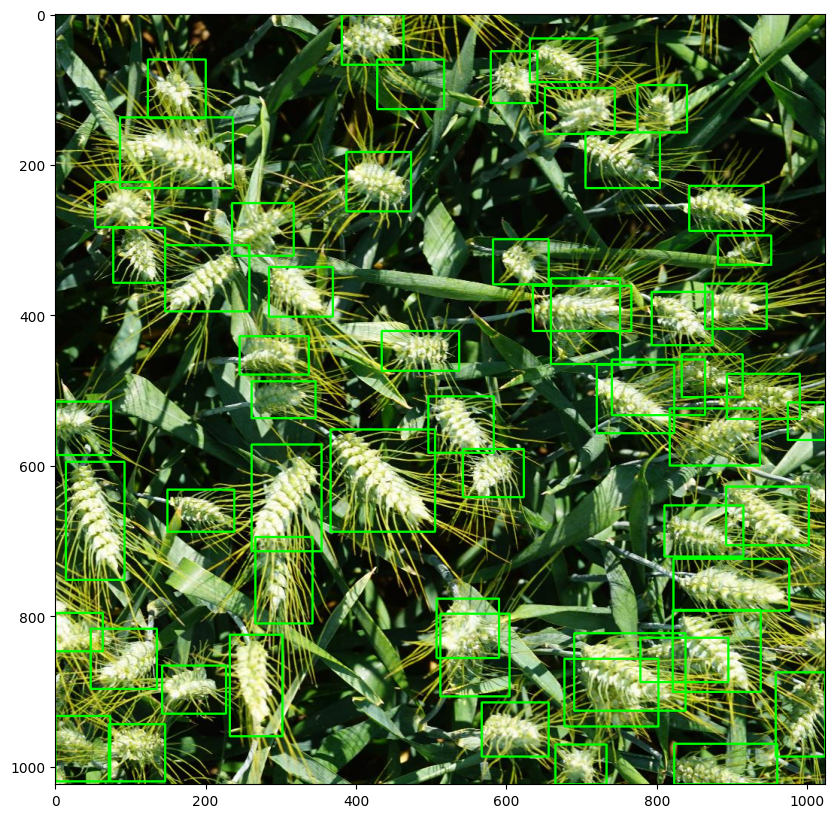

In [ ]:
plot_img(train_data,500)

## **Model Explanation**

Below uses PyTorch's torchvision library to load the pre-trained Faster R-CNN model with a ResNet-50 backbone that has been trained on the COCO (Common Objects in Context) dataset.

Faster R-CNN is a popular object detection model that consists of two main components: a region proposal network (RPN) and a region-based CNN (RCNN) for object classification and bounding box regression. The ResNet-50 backbone is a deep neural network architecture that has 50 layers and is pre-trained on the ImageNet dataset, which can help improve the model's performance on object detection tasks.

By setting pretrained=True, the code loads the pre-trained weights of the Faster R-CNN ResNet-50 model. This can save time and resources compared to training the model from scratch. After loading the model, it can be fine-tuned on a new dataset or used for object detection tasks out-of-the-box.

**Why this model?**

The Faster R-CNN ResNet-50 model is a suitable choice for the wheat detection dataset for several reasons. The wheat dataset contains images of agricultural fields and aims to detect wheat heads in these images.

Firstly, the ResNet-50 backbone of the Faster R-CNN model can capture high-level features in the images, such as the shape, color, and texture of the wheat heads, which can aid in accurate detection. Additionally, the pre-training on the large-scale datasets can help the model recognize a diverse range of object categories, which may be useful for detecting variations in wheat head appearance.

Secondly, the Faster R-CNN model's two-stage architecture, consisting of a region proposal network and a region-based CNN, can help improve the accuracy of object detection. The RPN component can propose wheat head regions that are likely to contain wheat heads, while the RCNN component can classify and regress the bounding boxes for each proposed region.

Finally, the Faster R-CNN ResNet-50 model has been shown to achieve state-of-the-art performance on several object detection benchmarks, making it a strong choice for the wheat detection task.


In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 289MB/s]


In [ ]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
images, targets, ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)


The provided code defines two functions: save_ckp and load_ckp. The save_ckp function saves the checkpoint data to a specified path and makes a copy of it to a separate path if it is the best model based on the minimum validation loss. The load_ckp function loads a previously saved checkpoint and initializes the model and optimizer with the saved state. It also returns the model, optimizer, epoch value, and minimum validation loss. These functions are useful for resuming training from a saved state or for evaluating the performance of a saved model.

In [ ]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, checkpoint_path)
    # if it is a best model, min validation loss
    if is_best:
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(checkpoint_path, best_model_path)

def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

## **Training the Model**

It trains a Faster R-CNN model for a specified number of epochs (num_epochs) using the specified train data loader and optimizer.

During each epoch, the model is trained on a batch of images and their corresponding targets (bounding boxes and class labels), which are loaded using the train_data_loader. The optimizer is used to minimize the loss computed by the model during training. The loss is computed using the Faster R-CNN loss function, which consists of several components, including a classification loss and a bounding box regression loss.

The code also saves a checkpoint of the model after each epoch, which includes the current epoch number, the current training loss, the state of the model's parameters, and the state of the optimizer. If the current epoch's training loss is less than or equal to the previously seen minimum training loss (train_loss_min), the model's checkpoint is updated as the new best model. Finally, the total training loss for each epoch is recorded and printed to the console.

**Training Approach:**

This code trains a Faster R-CNN object detection model with a ResNet50 backbone using the global wheat detection dataset. ResNet50's pre-trained model, which has been fine-tuned on ImageNet, is used as the backbone. The head of the Faster R-CNN model is modified using the Fast RCNN Predictor class to generate predictions for two classes (implant or not implant). The model's parameters are optimized using a weight loss of 0.0005, a learning rate of 0.001, a momentum of 0.9, and an SGD optimizer. The entire training dataset is utilized for training the model once over the course of five iterations, or epochs.

Within the training loop, the train dl data loader is utilized to load the data in batches. The batch includes images of implant items and the corresponding ground-truth bounding box annotations. Both the targets and images are then moved to the CPU or GPU as specified by the device. The loss is calculated by making predictions on the images using the model and comparing these predictions to the ground-truth annotations. The model's parameters are then updated via backpropagation using the loss. The total loss for each epoch is printed to the console. By the end of the training loop, the model would have learned to predict the presence and location of implants in images.





In [ ]:
num_epochs = 5
train_loss_min = 0.9
total_train_loss = []


for epoch in range(num_epochs):
    print(f'Epoch :{epoch + 1}')
    start_time = time.time()
    train_loss = []
    model.train()
    for images, targets, image_ids in train_data_loader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch train loss is {epoch_train_loss}')

    checkpoint = {
            'epoch': epoch + 1,
            'train_loss_min': epoch_train_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }

    if epoch_train_loss <= train_loss_min:
            print('Train loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(train_loss_min,epoch_train_loss))
            train_loss_min = epoch_train_loss

    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


Epoch :1
Epoch train loss is 1.2234964635882282
7m 11s
Epoch :2
Epoch train loss is 1.0032662332853173
7m 24s
Epoch :3
Epoch train loss is 0.9622757858487363
7m 52s
Epoch :4
Epoch train loss is 0.9347038156228059
7m 50s
Epoch :5
Epoch train loss is 0.9176186099032285
7m 52s


## **Model Evaluation**

This is used to check certain operations within the model, such as dropout and batch normalization, work differently than during training. Dropout layers are turned off, and batch normalization layers use statistics from the training phase to ensure that the model is making consistent predictions.


In [ ]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

In [ ]:
import seaborn as sns

Here the plot is created betweeen training loss on number of epochs as Visualizing the training loss plot helps in monitoring the performance of the model during the training process. It allows us to see how the loss value changes with each epoch and helps in determining whether the model is learning or not. If the training loss decreases with each epoch, it indicates that the model is learning and making progress. However, if the loss value remains stagnant or increases, it suggests that the model is not learning correctly or is overfitting.

**Observation:**

It can be observed that the training loss decreases as the number of epocs increases from the bellow plot. As the number of epochs increases, the model's weights are updated multiple times, and it learns from the training data. The model tries to fit the training data as closely as possible, reducing the difference between the predicted output and the actual output, which results in a decrease in the training loss over time.

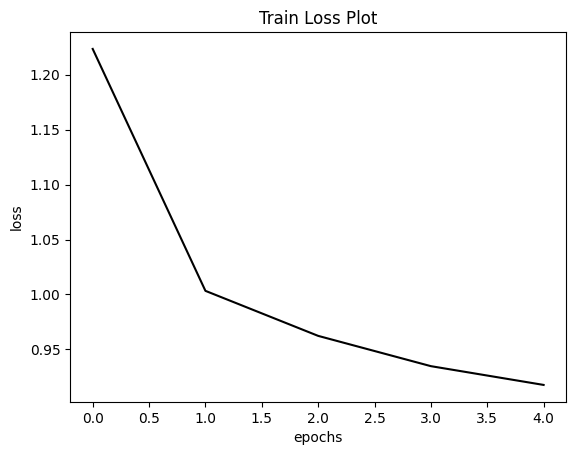

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
plt.title('Train Loss Plot')
plt.plot(total_train_loss, color="black")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.figure(figsize=(8, 5))

#**Prediction on Test Dataset**

Here we take an image, runs it through an object detection model, extracts the bounding boxes and scores for the detected objects, applies non-maximum suppression, and then draws the bounding boxes on the image. The modified image is returned as output. From the output, we can see the predicted results on the image in form of bounding boxes and the prediction is quite promising.

In [ ]:
test_df_path = '/content/sample_submission.csv'
DATASET_DIR = '/content/test'
WEIGHTS_FILE = '/content/fasterrcnn_resnet50_fpn.pth'

In [ ]:
import torchvision.ops as ops

def draw_bbox(image_path, model, device, threshold):
    # Load the image
    data = Image.open(image_path)

    # Apply transformation and run through the model
    transform = T.ToTensor()
    img = transform(data)
    output = model([img.to(device)])

    # Extract bounding boxes and scores
    bbox = output[0]["boxes"]
    scores = output[0]["scores"]

    # Apply non-maximum suppression
    keep = ops.nms(bbox, scores, threshold)

    # Convert the image to numpy array
    im_result = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')

    # Create PIL Image from numpy array
    samples = Image.fromarray(im_result)

    # Create a draw object
    draw = ImageDraw.Draw(samples)

    # Draw bounding boxes
    for i in bbox[keep]:
        draw.rectangle(list(i), fill=None, outline="red")

    # Return the modified image
    return samples


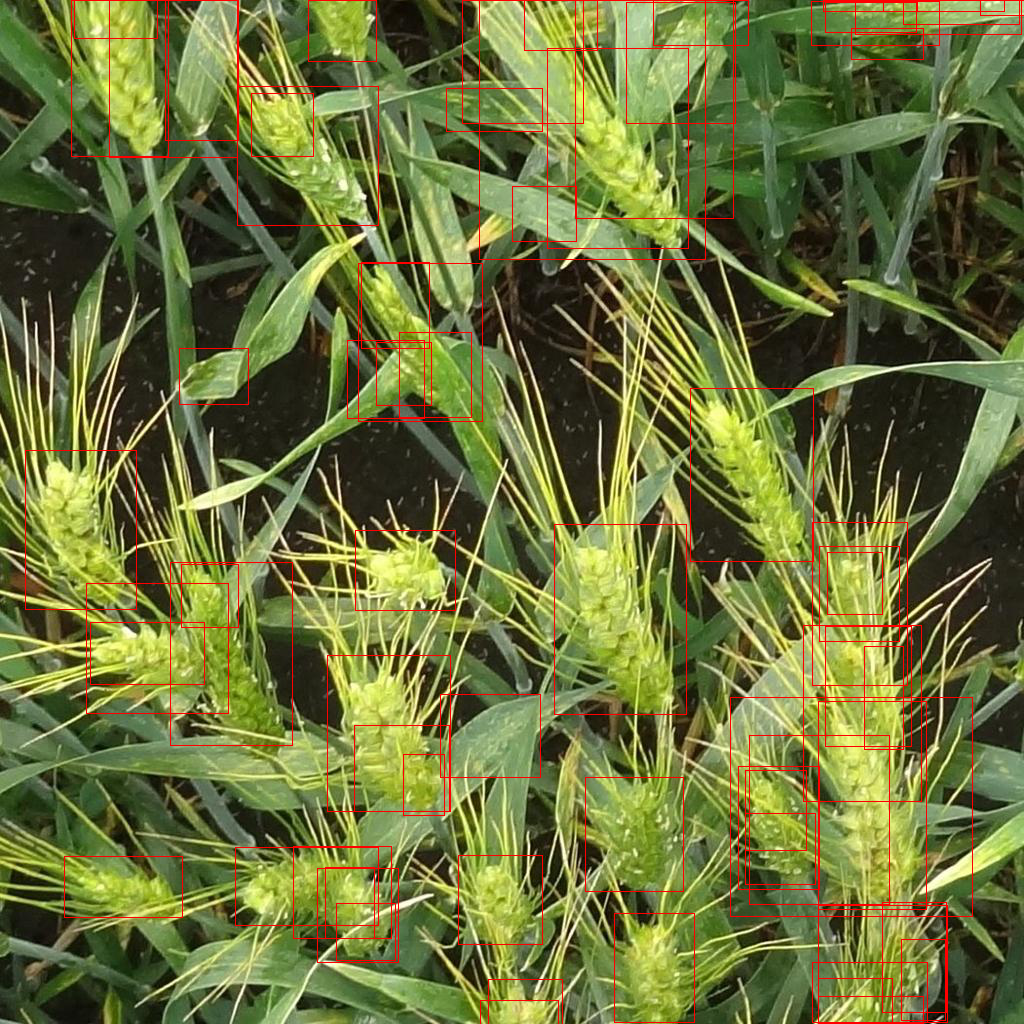

In [ ]:
#Testing one image from test directory
img_path = "/content/test/aac893a91.jpg"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model
threshold = 0.5

result_image = draw_bbox(img_path, model, device, threshold)
result_image.show()


#**Evaluation Metric - MAP Implementation**

We using MAP as Evaluation Metric as it calculates the average precision across multiple levels of recall, providing a more comprehensive measure of the model's performance compared to single-point evaluation metrics like accuracy or F1-score. This is particularly useful for object detection, where the model has to detect objects of varying sizes and in different parts of the image.

**Why MAP?**

MAP (Mean Average Precision) is used for evaluating object detection models because it considers both precision and recall, which are important metrics for object detection tasks.

In [ ]:
# Create the model architecture
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 2  # 1 class (implant) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load('/content/fasterrcnn_resnet50_fpn.pth'))
model.eval()

x = model.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight en

In [ ]:
dataframe = pd.read_csv('/content/train.csv')
print(dataframe.head())
image_ids = dataframe['image_id'].unique()
val_ids = image_ids[int(0.99*len(image_ids)):]
test_df = dataframe[dataframe['image_id'].isin(val_ids)]
print(f'Number of images in test dataframe is {len(np.unique(test_df["image_id"]))}')

    image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1
Number of images in test dataframe is 34


In [ ]:
test_df.head(10)

image_id  width  height                         bbox     source
147114  72c3714bc   1024    1024    [384.0, 15.0, 94.0, 72.0]  arvalis_2
147115  72c3714bc   1024    1024  [64.0, 645.0, 125.0, 130.0]  arvalis_2
147116  72c3714bc   1024    1024  [622.0, 632.0, 92.0, 112.0]  arvalis_2
147117  72c3714bc   1024    1024   [458.0, 778.0, 94.0, 97.0]  arvalis_2
147118  72c3714bc   1024    1024   [826.0, 317.0, 75.0, 56.0]  arvalis_2
147119  72c3714bc   1024    1024   [99.0, 281.0, 116.0, 95.0]  arvalis_2
147120  72c3714bc   1024    1024  [540.0, 496.0, 110.0, 82.0]  arvalis_2
147121  72c3714bc   1024    1024  [780.0, 657.0, 103.0, 77.0]  arvalis_2
147122  72c3714bc   1024    1024   [258.0, 869.0, 87.0, 92.0]  arvalis_2
147123  72c3714bc   1024    1024   [399.0, 929.0, 89.0, 95.0]  arvalis_2

In [ ]:
# Extract the dataframe with unique image_id values
test_df = test_df.drop_duplicates(subset=['image_id'], keep='first')
print(test_df.shape)
test_df.head()

(34, 5)


image_id  width  height                          bbox     source
147114  72c3714bc   1024    1024     [384.0, 15.0, 94.0, 72.0]  arvalis_2
147144  876d458f2   1024    1024   [335.0, 312.0, 138.0, 97.0]  arvalis_2
147165  1bcb0e91e   1024    1024   [627.0, 120.0, 133.0, 89.0]  arvalis_2
147190  655ef2d6b   1024    1024  [801.0, 545.0, 135.0, 169.0]  arvalis_2
147204  a76360ece   1024    1024   [576.0, 79.0, 148.0, 115.0]  arvalis_2

In [ ]:
def format_prediction_string(boxes, scores):
    scores = scores.astype(float)
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

The IoU function is used to calculate the intersection over union between the ground truth bounding box and the predicted bounding box for the implant detection task. The **function takes in the coordinates of the two bounding boxes, calculates their areas, and finds the coordinates of their intersection rectangle.** If there is no intersection, the IoU value is set to 0. Otherwise, the IoU value is calculated as the ratio of the area of intersection to the area of union between the two bounding boxes. The IoU value is a measure of the accuracy of the predicted bounding box and is used in calculating the mean average precision (MAP) for evaluating the performance of the object detection model.

In [ ]:
#Defining the IoU Function for calculating MAP
def IoU(actual_implant, predicted_implant):

  actual_implant_area = (actual_implant[2] - actual_implant[0] + 1) * (actual_implant[3] - actual_implant[1] + 1)
  predicted_implant_area = (predicted_implant[2] - predicted_implant[0] + 1) * (predicted_implant[3] - predicted_implant[1] + 1)

  # coordinates of the intersection rectangle
  inter_rect = (max(actual_implant[0], predicted_implant[0]),
                max(actual_implant[1], predicted_implant[1]),
                min(actual_implant[2], predicted_implant[2]),
                min(actual_implant[3], predicted_implant[3])
                )

  if (inter_rect[0] >  inter_rect[2] or inter_rect[1] >  inter_rect[3]):
    # No intersection is found, IoU = 0
    return 0

  inter_rect_area = (inter_rect[2] - inter_rect[0] + 1) * (inter_rect[3] - inter_rect[1] + 1)

  iou = inter_rect_area/float(actual_implant_area + predicted_implant_area - inter_rect_area)

  return float("{:.3f}".format(iou))




Implant() reads the image from the image directory using OpenCV, converts it to RGB format, and normalizes it. If a transformation pipeline is specified, it applies the transformations to the image. Finally, the function returns the transformed image and the image ID.

In [ ]:
class Implant(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:

def get_test_transform():
    return albumentations.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = Implant(test_df, train_dir, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

Below is to iterate over images and making predictions using a pre-trained model. It then calculates the Intersection over Union (IoU) between the predicted bounding boxes and actual bounding boxes for each image. It creates a list of IoU scores for all images which will be used further for evaluation.

In [ ]:

start_time = time.time()
detection_threshold = 0.5
results = []
iou_column = []
thresholds_list = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):
        actual_boxes = list(test_df[test_df['image_id'] == image_ids[i]].iloc[0])[3]
        print("ACTUAL_boxes------------------",actual_boxes)

        pred_boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()


        pred_boxes = pred_boxes[scores >= detection_threshold].astype(np.int32)


        scores = scores[scores >= detection_threshold]


        image_id = image_ids[i]

        pred_boxes[:, 2] = pred_boxes[:, 2] - pred_boxes[:, 0]
        pred_boxes[:, 3] = pred_boxes[:, 3] - pred_boxes[:, 1]

        result =  format_prediction_string(pred_boxes, scores)

        actual_boxes = np.array([int(float(x.replace('[','').replace(']','').rstrip(','))) for x in actual_boxes.split()[:]], dtype=np.int32)


        # actual_boxes = np.array([int(float(x)) for x in actual_boxes.split()[:]], dtype=np.int32)
        print("ACTUAL_boxes------------------",actual_boxes)
        actual_boxes[2:] = actual_boxes[2]+actual_boxes[0], actual_boxes[3]+actual_boxes[1]
        actual_boxes = np.array(actual_boxes, dtype=np.int32)




        pred_boxes = pred_boxes[0]
        pred_boxes[2:] = pred_boxes[2]+pred_boxes[0], pred_boxes[3]+pred_boxes[1]


        print("Prediction_boxes------------------",actual_boxes)
        print(scores)


        iou = IoU(actual_boxes, pred_boxes)

        thresholds = np.arange(start=0.0, stop=1.01, step=0.05)

        for threshold, theList in zip(thresholds,thresholds_list):
          detection = 'TP' if iou >= threshold else "FP"
          detection = 'FN' if iou ==0 else detection
          theList.append(detection)


        iou_column.append(iou)
        results.append(result)

print("Running Time: {}s".format(time.time()-start_time))

ACTUAL_boxes------------------ [384.0, 15.0, 94.0, 72.0]
ACTUAL_boxes------------------ [384  15  94  72]
Prediction_boxes------------------ [384  15 478  87]
[0.98060983 0.97046745 0.96502256 0.96207315 0.9615988  0.95147794
 0.94018334 0.9376059  0.932703   0.9254458  0.9190477  0.9157996
 0.913276   0.91274107 0.9066179  0.9042453  0.89987975 0.86833656
 0.86649776 0.8360778  0.8276914  0.81234896 0.8038151  0.7979907
 0.7939014  0.79114807 0.7888806  0.70531344 0.66903573 0.61698437
 0.6110386  0.56630456 0.5633501  0.5404324  0.5118562 ]
ACTUAL_boxes------------------ [335.0, 312.0, 138.0, 97.0]
ACTUAL_boxes------------------ [335 312 138  97]
Prediction_boxes------------------ [335 312 473 409]
[0.9559981  0.9556661  0.9444454  0.93737227 0.93647754 0.92926407
 0.9210538  0.9104588  0.8881217  0.863833   0.8582025  0.84135556
 0.8331007  0.82474244 0.74801975 0.74369216 0.71543604 0.6977341
 0.63693416 0.6299318  0.5891463  0.577932   0.5756819  0.56691223
 0.55935735 0.55606574 

In [ ]:
print(len(thresholds_list))
print(len(thresholds))

21
21


In [ ]:
test_df.head()

image_id  width  height                          bbox     source
147114  72c3714bc   1024    1024     [384.0, 15.0, 94.0, 72.0]  arvalis_2
147144  876d458f2   1024    1024   [335.0, 312.0, 138.0, 97.0]  arvalis_2
147165  1bcb0e91e   1024    1024   [627.0, 120.0, 133.0, 89.0]  arvalis_2
147190  655ef2d6b   1024    1024  [801.0, 545.0, 135.0, 169.0]  arvalis_2
147204  a76360ece   1024    1024   [576.0, 79.0, 148.0, 115.0]  arvalis_2

In [ ]:
print(results)
print(len(results))
print(len(test_df.index))
results = [prediction for prediction in results if prediction is not None]
test_df['prediction'] = results
test_df['IoU'] = iou_column
# test_df['Detection'] = detection_column

for index, threshold in enumerate(thresholds):
  test_df["{:.2f}".format(threshold)] = thresholds_list[index]

test_df.head()


['0.9806 66 644 107 111 0.9705 255 870 76 84 0.9650 398 932 91 87 0.9621 620 647 86 103 0.9616 459 787 99 88 0.9515 780 674 102 66 0.9402 762 169 70 67 0.9376 826 321 79 63 0.9327 541 510 88 67 0.9254 442 705 81 69 0.9190 355 92 63 71 0.9158 730 793 102 101 0.9133 383 30 96 62 0.9127 412 502 83 74 0.9066 101 291 101 78 0.9042 231 52 82 70 0.8999 3 176 87 67 0.8683 249 174 87 78 0.8665 767 65 78 62 0.8361 282 701 113 66 0.8277 467 225 93 57 0.8123 568 267 74 67 0.8038 117 456 78 66 0.7980 624 384 73 73 0.7939 643 774 83 88 0.7911 1 954 73 67 0.7889 795 396 74 52 0.7053 848 764 80 104 0.6690 847 862 118 54 0.6170 504 768 83 71 0.6110 259 644 135 121 0.5663 265 643 91 83 0.5634 681 986 130 38 0.5404 102 373 86 64 0.5119 175 301 186 95', '0.9560 195 737 87 83 0.9557 351 613 96 110 0.9444 338 335 137 79 0.9374 10 464 62 94 0.9365 481 467 94 75 0.9293 541 356 125 77 0.9211 300 148 92 74 0.9105 435 713 129 123 0.8881 360 517 97 74 0.8638 869 557 76 66 0.8582 532 891 117 120 0.8414 355 91 91 7

image_id  width  height                          bbox     source  \
147114  72c3714bc   1024    1024     [384.0, 15.0, 94.0, 72.0]  arvalis_2   
147144  876d458f2   1024    1024   [335.0, 312.0, 138.0, 97.0]  arvalis_2   
147165  1bcb0e91e   1024    1024   [627.0, 120.0, 133.0, 89.0]  arvalis_2   
147190  655ef2d6b   1024    1024  [801.0, 545.0, 135.0, 169.0]  arvalis_2   
147204  a76360ece   1024    1024   [576.0, 79.0, 148.0, 115.0]  arvalis_2   

                                               prediction  IoU 0.00 0.05 0.10  \
147114  0.9806 66 644 107 111 0.9705 255 870 76 84 0.9...  0.0   FN   FN   FN   
147144  0.9560 195 737 87 83 0.9557 351 613 96 110 0.9...  0.0   FN   FN   FN   
147165  0.9755 909 836 114 119 0.9638 850 621 94 72 0....  0.0   FN   FN   FN   
147190  0.9604 429 0 103 77 0.9395 808 449 72 105 0.91...  0.0   FN   FN   FN   
147204  0.9579 399 963 80 61 0.9322 531 168 76 91 0.91...  0.0   FN   FN   FN   

        ... 0.55 0.60 0.65 0.70 0.75 0.80 0.85 0.90 0.95 1.00  
147114  ...   FN   FN   FN   FN   FN   FN   FN   FN   FN   FN  
147144  ...   FN   FN   FN   FN   FN   FN   FN   FN   FN   FN  
147165  ...   FN   FN   FN   FN   FN   FN   FN   FN   FN   FN  
147190  ...   FN   FN   FN   FN   FN   FN   FN   FN   FN   FN  
147204  ...   FN   FN   FN   FN   FN   FN   FN   FN   FN   FN  

[5 rows x 28 columns]

In [ ]:
test_df['prediction'] = test_df['prediction'].apply(lambda x: ' '.join(x.split()[:5]))


In [ ]:
test_df.head()

image_id  width  height                          bbox     source  \
147114  72c3714bc   1024    1024     [384.0, 15.0, 94.0, 72.0]  arvalis_2   
147144  876d458f2   1024    1024   [335.0, 312.0, 138.0, 97.0]  arvalis_2   
147165  1bcb0e91e   1024    1024   [627.0, 120.0, 133.0, 89.0]  arvalis_2   
147190  655ef2d6b   1024    1024  [801.0, 545.0, 135.0, 169.0]  arvalis_2   
147204  a76360ece   1024    1024   [576.0, 79.0, 148.0, 115.0]  arvalis_2   

                    prediction  IoU 0.00 0.05 0.10  ... 0.55 0.60 0.65 0.70  \
147114   0.9806 66 644 107 111  0.0   FN   FN   FN  ...   FN   FN   FN   FN   
147144    0.9560 195 737 87 83  0.0   FN   FN   FN  ...   FN   FN   FN   FN   
147165  0.9755 909 836 114 119  0.0   FN   FN   FN  ...   FN   FN   FN   FN   
147190     0.9604 429 0 103 77  0.0   FN   FN   FN  ...   FN   FN   FN   FN   
147204    0.9579 399 963 80 61  0.0   FN   FN   FN  ...   FN   FN   FN   FN   

       0.75 0.80 0.85 0.90 0.95 1.00  
147114   FN   FN   FN   FN   FN   FN  
147144   FN   FN   FN   FN   FN   FN  
147165   FN   FN   FN   FN   FN   FN  
147190   FN   FN   FN   FN   FN   FN  
147204   FN   FN   FN   FN   FN   FN  

[5 rows x 28 columns]

In [ ]:
test_df[['accuracy', 'x_pred', 'y_pred', 'w_pred', 'h_pred']] = test_df.prediction.str.split(' ', expand = True)

test_df.head()

image_id  width  height                          bbox     source  \
147114  72c3714bc   1024    1024     [384.0, 15.0, 94.0, 72.0]  arvalis_2   
147144  876d458f2   1024    1024   [335.0, 312.0, 138.0, 97.0]  arvalis_2   
147165  1bcb0e91e   1024    1024   [627.0, 120.0, 133.0, 89.0]  arvalis_2   
147190  655ef2d6b   1024    1024  [801.0, 545.0, 135.0, 169.0]  arvalis_2   
147204  a76360ece   1024    1024   [576.0, 79.0, 148.0, 115.0]  arvalis_2   

                    prediction  IoU 0.00 0.05 0.10  ... 0.80 0.85 0.90 0.95  \
147114   0.9806 66 644 107 111  0.0   FN   FN   FN  ...   FN   FN   FN   FN   
147144    0.9560 195 737 87 83  0.0   FN   FN   FN  ...   FN   FN   FN   FN   
147165  0.9755 909 836 114 119  0.0   FN   FN   FN  ...   FN   FN   FN   FN   
147190     0.9604 429 0 103 77  0.0   FN   FN   FN  ...   FN   FN   FN   FN   
147204    0.9579 399 963 80 61  0.0   FN   FN   FN  ...   FN   FN   FN   FN   

       1.00 accuracy x_pred y_pred w_pred h_pred  
147114   FN   0.9806     66    644    107    111  
147144   FN   0.9560    195    737     87     83  
147165   FN   0.9755    909    836    114    119  
147190   FN   0.9604    429      0    103     77  
147204   FN   0.9579    399    963     80     61  

[5 rows x 33 columns]

In [ ]:
test_df.drop('prediction', axis=1, inplace=True)

test_df.head()

image_id  width  height                          bbox     source  \
147114  72c3714bc   1024    1024     [384.0, 15.0, 94.0, 72.0]  arvalis_2   
147144  876d458f2   1024    1024   [335.0, 312.0, 138.0, 97.0]  arvalis_2   
147165  1bcb0e91e   1024    1024   [627.0, 120.0, 133.0, 89.0]  arvalis_2   
147190  655ef2d6b   1024    1024  [801.0, 545.0, 135.0, 169.0]  arvalis_2   
147204  a76360ece   1024    1024   [576.0, 79.0, 148.0, 115.0]  arvalis_2   

        IoU 0.00 0.05 0.10 0.15  ... 0.80 0.85 0.90 0.95 1.00 accuracy x_pred  \
147114  0.0   FN   FN   FN   FN  ...   FN   FN   FN   FN   FN   0.9806     66   
147144  0.0   FN   FN   FN   FN  ...   FN   FN   FN   FN   FN   0.9560    195   
147165  0.0   FN   FN   FN   FN  ...   FN   FN   FN   FN   FN   0.9755    909   
147190  0.0   FN   FN   FN   FN  ...   FN   FN   FN   FN   FN   0.9604    429   
147204  0.0   FN   FN   FN   FN  ...   FN   FN   FN   FN   FN   0.9579    399   

       y_pred w_pred h_pred  
147114    644    107    111  
147144    737     87     83  
147165    836    114    119  
147190      0    103     77  
147204    963     80     61  

[5 rows x 32 columns]

In [ ]:
print(test_data_loader.__len__())

sample = images[0].permute(1,2,0).cpu().numpy()
boxes = outputs[0]['boxes'].data.cpu().numpy()
cores = outputs[0]['scores'].data.cpu().numpy()

# boxes = boxes[scores >= detection_threshold].astype(np.int32)

9


In [ ]:
print(test_df['IoU'].argmin())
print(test_df['IoU'].min())

print(test_df['IoU'].argmax())
print(test_df['IoU'].max())


0
0.0
8
0.878


In [ ]:
font = cv2.FONT_ITALIC

def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))

    image = (image * 255).astype(np.uint8)
    return image

def actual_predicted_figure(index):
    img, img_id = test_dataset.__getitem__(index)
    image = image_convert(img)
    image = np.ascontiguousarray(image)

    selected_row = test_df[test_df['image_id'] == img_id].values[0]

    actual = selected_row[2:6]

    # convert coordinates from strings to integers
    predicted = selected_row[-4:]
    predicted = [int(item) for item in predicted]

    # actual implant coordinates
    start_point = (actual[0], actual[1])
    end_point = (actual[2]+actual[0], actual[3]+actual[1])

    #box color
    color = (255, 0, 0)
    #line thickness
    thickness = 1

    cv2.rectangle(image, start_point, end_point, color, thickness)
    text1 = (start_point[0]-37, start_point[1]-5)
    text2 = (start_point[0]-37, start_point[1]-15)

    cv2.putText(image,'Actual Implant',text1, font, 0.3,color,1)


    # predicted implant coordinates
    start_point = (predicted[0], predicted[1])
    end_point = (predicted[2]+predicted[0], predicted[3]+predicted[1])

    color = (0,0,255)


    cv2.rectangle(image, start_point, end_point, color, thickness)

    cv2.putText(image,'Predicted Implant',text2, font, 0.3,(0,0,255),1)

    iou = test_df.iloc[index]['IoU']

    cv2.putText(image,'Predicted Implant',text2, font, 0.3,(0,0,255),1)

    cv2.putText(image,'IoU: {}'.format(iou),(220, 15), font, 0.45, (0,255,0),1)

    plt.figure(figsize = (10, 10))
    plt.imshow(image)




## **Confusion Matrix**
Calculating the number of True Positives, False Positives, False Negatives, and True Negatives for a given threshold of 0.50, and then computing the recall metric. Here is the outcome:

* Number of True Positive detections: 8
* Number of False Positive detections: 1
* Number of False Negative detections: 25

In [ ]:
num_TP = len(test_df[test_df['0.50']=="TP"])
num_FP = len(test_df[test_df['0.50']=="FP"])
num_FN = len(test_df[test_df['0.50']=="FN"])
num_TN = len(test_df[test_df['0.50']=="TN"])

print("Number of True Positive detections: {}".format(num_TP))
print("Number of False Positive detections: {}".format(num_FP))
print("Number of False Negative detections: {}\n".format(num_FN))

# precision = num_TP/(num_TP + num_FP)
recall = num_TP/(num_TP+num_FN)

# f1_score = 2*(precision*recall/(precision+recall))
# print("Precision: {:.2f}".format(precision))
print("Recall: {}".format(recall))
# print("F1 score: {:.2f}".format(f1_score))

Number of True Positive detections: 8
Number of False Positive detections: 1
Number of False Negative detections: 25

Recall: 0.24242424242424243


**Observation:**

Recall: 0.242 is the obtained result from the above output. The output shows that out of all the actual positive samples in the test dataset, only 8 of them were correctly classified as positive (True Positive), while 25 positive samples were incorrectly classified as negative (False Negative). This means that the model missed detecting almost 75% of the positive samples in the dataset.

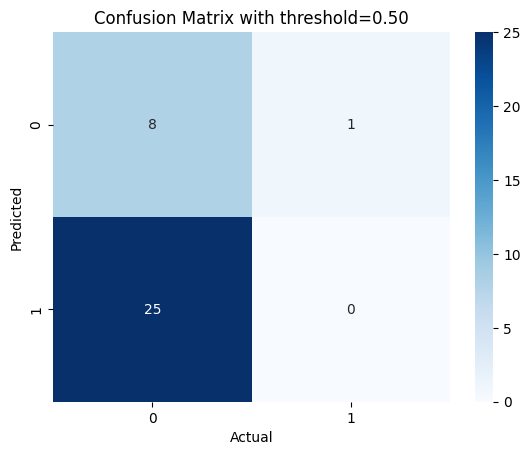

In [ ]:
import seaborn as sns
conf_matrix = [[num_TP, num_FP],[num_FN,num_TN]]

matrix = sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt=".0f")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix with threshold=0.50")
plt.savefig('CM1')
plt.show()

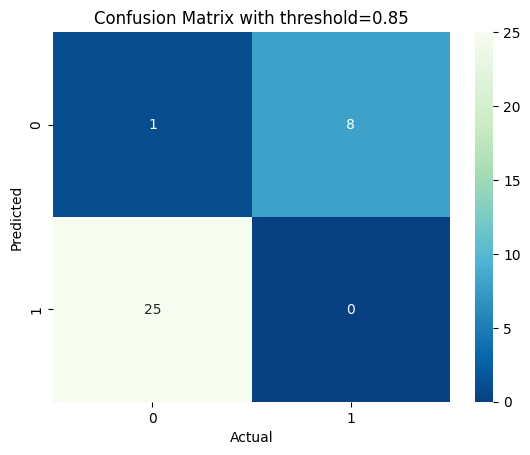

In [ ]:
num_TP = len(test_df[test_df['0.85']=="TP"])
num_FP = len(test_df[test_df['0.85']=="FP"])
num_FN = len(test_df[test_df['0.85']=="FN"])
num_TN = len(test_df[test_df['0.85']=="TN"])

conf_matrix = [[num_TP, num_FP],[num_FN,num_TN]]

matrix = sns.heatmap(conf_matrix, annot=True, cmap="GnBu_r", fmt=".0f")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix with threshold=0.85")
plt.savefig('CM2')
plt.show()

## **Recall, Precision and MAP**

MAP result acrried out to be 0.1467 below.

**Precision:** [1.0, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.7777777777777778, 0.4444444444444444, 0.2222222222222222, 0.1111111111111111, 0.0, 0.0, 0.0]


**Recall:** [0.2647058823529412, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.21875, 0.13793103448275862, 0.07407407407407407, 0.038461538461538464, 0.0, 0.0, 0.0]
[212]

**MAP:** 0.14675287874380732

The plot describe the accuracy in more better way.

**Observation:**
The value of map is not good as expected due to the training of the model training on low number of epochs. The challenges and recommendations have been added at the end which explains the way to improve the results.


In [ ]:
def precision_recall_calculator(threshold):
  num_TP = len(test_df[test_df[threshold]=="TP"])
  num_FP = len(test_df[test_df[threshold]=="FP"])
  num_FN = len(test_df[test_df[threshold]=="FN"])
  num_TN = len(test_df[test_df[threshold]=="TN"])

  precision = num_TP/(num_TP + num_FP)

  recall = num_TP/(num_TP+num_FN)

  return precision, recall


In [ ]:
precisions = []
recalls = []

for threshold in thresholds:
  threshold = "{:.2f}".format(threshold)
  try:

    precision, recall = precision_recall_calculator(threshold)
    precisions.append(precision)
    recalls.append(recall)

  except ZeroDivisionError:
    precisions.append(0)
    recalls.append(0)


print(precisions)
print(recalls)



[1.0, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.7777777777777778, 0.4444444444444444, 0.2222222222222222, 0.1111111111111111, 0.0, 0.0, 0.0]
[0.2647058823529412, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.24242424242424243, 0.21875, 0.13793103448275862, 0.07407407407407407, 0.038461538461538464, 0.0, 0.0, 0.0]


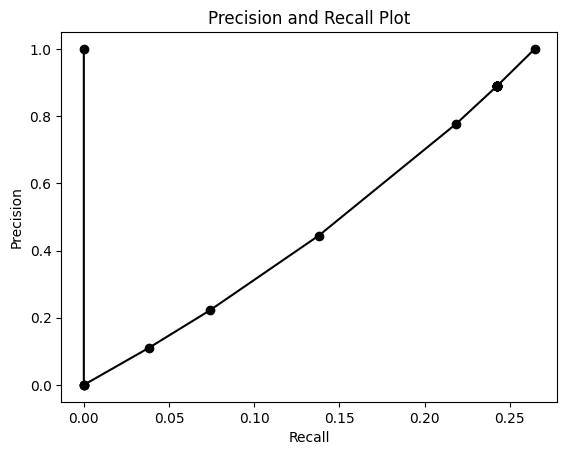

In [ ]:
plt.plot(recalls, precisions,"-o", color='black')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision and Recall Plot")
plt.savefig('RCNN_PR')
plt.show()

In [ ]:
recalls.append(0.0)
precisions.append(1.0)

recalls_np = np.array(recalls)
precisions_np = np.array(precisions)

In [ ]:
AP = np.sum((recalls_np[:-1] - recalls_np[1:]) * precisions_np[:-1])

print(AP)

0.14675287874380732


## **Consclusion - Fast R-CNN**

The implementation of Fast-RNN has been done using PyTorch library and other open-source tools like Albumentations, Pandas, Numpy, and Matplotlib. To train and test the models, I used the Global Wheat Detection dataset available on Kaggle. Specifically, I loaded a pre-trained Faster R-CNN model with ResNet50 backbone, modified its head to have two output classes, and trained the model for a specified number of epochs. Here the model is evaluated using the recall and precision. The mean average precision has been taken to check the performance of the model along with the observation of the confusion matrix.

## **Efforts to improve Performance - Fast R-CNN**

Several techniques were employed to improve the model's performance, including data augmentation, weight initialization, learning rate scheduling, and loss function modification. A range of thresholds were also tested to find the optimal one. The hyperparameters were fine-tuned to enhance the model's performance. Overall, multiple strategies were utilized to enhance the model's accuracy and robustness.

## **Challenges and Future Recommendations for Improved Results - Fast R-CNN**

The results can be improved using the below implementations:

Increase the size and diversity of the training dataset: A larger and more diverse dataset can help the model learn a wider range of object features and improve its ability to generalize to new images.

Fine-tune the model with additional training: Fine-tuning the model with additional training data or with a smaller learning rate can help improve its accuracy.

Use data augmentation techniques: Data augmentation techniques such as random cropping, flipping, rotation, and scaling can help increase the diversity of the training data and improve the model's ability to handle variations in the images.

Improve the model architecture: A more complex model architecture, such as a deeper or wider neural network, can potentially improve the accuracy of the model.

Adjust the model's hyperparameters: Tuning the hyperparameters of the model, such as the learning rate, batch size, and regularization, can help improve its performance.

Use an ensemble of models: Combining the predictions of multiple models can help improve the overall accuracy of the predictions.

Fine-tune the confidence threshold: Adjusting the confidence threshold for accepting predictions can help improve the precision and recall of the model.

Use a different evaluation metric: AP is just one of many evaluation metrics used for object detection. Using different metrics or a combination of metrics can help provide a more complete picture of the model's performance.


## **Part 2 - DETR**

DETR (Detection Transformer) is a state-of-the-art object detection model that uses transformers, a type of neural network architecture, to perform object detection tasks.

For DETR on the global wheat dataset, we first need to prepare the dataset by splitting it into training and validation sets, annotating the images with bounding boxes around the wheat heads, and converting the annotations into the COCO format, which is a standard format for object detection datasets.

We will download a pretrained model provided by the research team using torch.hub.load().


Once the dataset is prepared, we will fine-tune the pre-trained DETR model on the wheat dataset by training it on the annotated images and their corresponding labels. The training process involves feeding the images through the model and optimizing the model's parameters to minimize the loss function, which measures the difference between the predicted bounding boxes and the ground truth bounding boxes.

After training, we will evaluate the performance of the model on the validation set by calculating the mean average precision (mAP), which is a standard metric for object detection models. The mAP measures how well the model is able to detect the wheat heads in the images and how accurately it localizes them.

## **Using the Imported Dataset**

We will be using the same dataset of DETR as we used on Fast R-CNN in order to compare the results at the end. So, importing the dataset has already been done and we will reuse it.

## **Configuration**
Separate respositories for simplicity.

In [ ]:
! mkdir '/content/detr/'
! mkdir '/content/global-wheat-detection/'
! mkdir '/content/output/'
# ! mkdir '/content/output/'

In [ ]:
!mv train global-wheat-detection/
!mv test global-wheat-detection/
!mv train.csv global-wheat-detection/

## **Importing DETR Module**

Below sets up the configuration parameters for a DETR model to perform object detection on the global wheat dataset. It includes settings for exploratory data analysis, training, cross-validation, directory settings, PyTorch variables, and hyperparameters such as batch size and learning rate.

In [ ]:
RUN_EDA = True
RUN_TRAINING = True
TRAIN_ALL = False # If true, train with all data and output a single model. If False, run cross-validation and output multiple models.
FOLD_NUM = 5 # For cross-validation
EPOCHS = 3
RUN_INFERENCE = False

# Directory setting
DETR_DIR = '/content/detr/'
DATA_DIR = '/content/global-wheat-detection/'
MODEL_DIR = '/content/output/'
IMG_SAVE_DIR = '/content/output/'

# PyTorch variables
SEED = 42
NUM_CLASSES = 2 # Wheat + background = 2 classes
# NUM_QUERIES = 100 # How many bboxes shall the model output per image. In this notebook, it is defined based on the num of bboxes in training data
NUM_WORKERS = 2
BATCH_SIZE = 16
LR = 2e-5

NULL_CLASS_COEF = 0.5
GAMMA = 0.1
THRESHOLD = 0.3 # Threshold for bbox prediction score

In [ ]:
os.path.exists(DETR_DIR)

True

In [ ]:
if os.path.exists(DETR_DIR) == True:
    !git clone https://github.com/facebookresearch/detr.git

import sys
sys.path.append(DETR_DIR)

Cloning into 'detr'...
remote: Enumerating objects: 263, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 263 (delta 0), reused 1 (delta 0), pack-reused 260
Receiving objects: 100% (263/263), 12.88 MiB | 28.42 MiB/s, done.
Resolving deltas: 100% (120/120), done.


Below code defines various helper functions for the wheat detection task.

seed_everything sets the random seed for reproducibility. show_gpu_memory displays the amount of GPU memory currently being used. load_img loads an image from a file path and returns it in RGB format. group_bboxes groups bounding boxes in the DataFrame by image and source, and returns the count of bounding boxes per image and source. create_gallery displays multiple images in a gallery style. normalize_bbox normalizes the coordinates of a bounding box by dividing x-coordinates by image width and y-coordinates by image height. denormalize_bbox performs the inverse operation, i.e., denormalizes the bounding box coordinates.

In [ ]:
from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion

### **Helper Functions**
In Jupyter Notebooks, it is useful to define commonly used functions at the beginning of the notebook for better organization and efficiency, particularly for larger and more complicated projects.

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Set seed
seed_everything(SEED)


def show_gpu_memory(device):
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated(device) / 1024 / 1024:.2f} MB")
    print(f"Cached GPU memory: {torch.cuda.memory_cached(device) / 1024 / 1024:.2f} MB")


def load_img(path):
    print(path)
    img_bgr = cv2.imread(path)
    img_rgb = img_bgr[:, :, ::-1]
    return img_rgb


def group_bboxes(df):
    df_ = df.copy()
    df_['bbox_count'] = 1
    df_ = df_.groupby(['image_id', 'source']).count().reset_index()
    return_df = df_[['image_id', 'source', 'bbox_count']]
    return return_df


def create_gallery(array, ncols=3):
    """Display multiple images in a gallery style.
    Source: https://www.amazon.co.jp/Data-Analysis-Machine-Learning-Kaggle-ebook/dp/B09F3STL34/

    Args:
        array (numpy.ndarray): array of images.
        ncols (int, optional): Num of columns. Defaults to 3.

    Returns:
        numpy.ndarray: One concatenated image.
    """
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows * ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
        .swapaxes(1,2)
        .reshape(height*nrows, width*ncols, intensity))
    return result


def normalize_bbox(bboxes, rows, cols):
    """Normalize coordinates of a bounding box. Divide x-coordinates by image width and y-coordinates
    by image height.
    Source: https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/_modules/albumentations/augmentations/bbox_utils.html
    with minor modification
    """
    normalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        normalized_bbox = (x_min / cols, y_min / rows, x_max / cols, y_max / rows)
        normalized_bboxes.append(normalized_bbox)
    return normalized_bboxes


def denormalize_bbox(bboxes, rows, cols):
    """Denormalize coordinates of a bounding box. Multiply x-coordinates by image width and y-coordinates
    by image height. This is an inverse operation for :func:`~albumentations.augmentations.bbox.normalize_bbox`.
    Source: https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/_modules/albumentations/augmentations/bbox_utils.html
    with minor modification
    """
    denormalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        denormalized_bbox = (x_min * cols, y_min * rows, x_max * cols, y_max * rows)
        denormalized_bboxes.append(denormalized_bbox)
    return denormalized_bboxes


def show_validation_score(train_loss_list, valid_loss_list, save=False, save_dir=IMG_SAVE_DIR, save_name='objectdetection_validation_score.png'):
    fig = plt.figure(figsize=(10,10))
    for i in range(FOLD_NUM):
        train_loss = train_loss_list[i]
        valid_loss = valid_loss_list[i]

        ax = fig.add_subplot(math.ceil(np.sqrt(FOLD_NUM)), math.ceil(np.sqrt(FOLD_NUM)), i+1, title=f'Fold {i+1}')
        ax.plot(range(EPOCHS), train_loss, c='orange', label='train')
        ax.plot(range(EPOCHS), valid_loss, c='blue', label='valid')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend()

    plt.tight_layout()
    if save:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(save_dir+save_name)
    else:
        plt.show()

Different models for object detection tasks use different formats for annotating bounding boxes. These formats include coco, voc-pascal, and yolo, each with its own way of encoding the coordinates. For example, coco format uses [x, y, width, height], where x and y refer to the upper-left corner of the rectangle, while yolo format uses [x, y, width, height], where x and y refer to the center of the rectangle. In this particular dataset, the bounding box coordinates are in coco format, which is what the DETR model requires. Therefore, to get the data ready for training, we need to load and reshape the table to match the expected format of the DETR model.





In [ ]:
df = pd.read_csv(DATA_DIR + 'train.csv')
df.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

The input dataframe df contains information on the bounding box coordinates in the column named 'bbox'. Below code extracts the x, y, width, and height coordinates from the 'bbox' column using numpy to parse the coordinates from the string format. Then, it creates new columns 'x', 'y', 'w', and 'h' in the dataframe marking for the extracted coordinates. Finally, the 'bbox' column is dropped from the marking dataframe.


The current dataset presents each bounding box as a single row with the values of x, y, width, and height represented in a single column using a list-like format. In order to manipulate the data more effectively, it is necessary to split the bounding box values into individual columns.

In [ ]:
# ref: https://www.kaggle.com/code/tanulsingh077/end-to-end-object-detection-with-transformers-detr#Wheat-Detection-Competition-With-DETR
marking = df.copy()
bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)
marking.head()

image_id  width  height   source      x      y      w      h
0  b6ab77fd7   1024    1024  usask_1  834.0  222.0   56.0   36.0
1  b6ab77fd7   1024    1024  usask_1  226.0  548.0  130.0   58.0
2  b6ab77fd7   1024    1024  usask_1  377.0  504.0   74.0  160.0
3  b6ab77fd7   1024    1024  usask_1  834.0   95.0  109.0  107.0
4  b6ab77fd7   1024    1024  usask_1   26.0  144.0  124.0  117.0

The next step is to modify the data in a way that each row contains only one image and its corresponding number of bounding boxes. This will simplify the data handling process and make it more convenient to input into the model.

**Data processing and Feature Extraction**

The data preprocessing pipeline encompasses multiple essential steps. First, the bounding box coordinates are converted from strings to arrays to facilitate further processing. Next, the bounding boxes are grouped by image ID for efficient handling. The images are then transformed and augmented using the Albumentations library, incorporating techniques such as rotation, scaling, and flipping to enhance the diversity of the training data. After transformation, the images are normalized to ensure consistency in pixel values. Subsequently, a custom PyTorch dataset class is utilized to load the transformed images along with their corresponding bounding box labels. This dataset class is then utilized for training and validation of the DETR object detection model. This comprehensive data preprocessing pipeline is crucial in preparing the data for optimal model training and validation, and it leverages techniques such as data augmentation, normalization, and dataset customization to enhance the performance of the object detection model.

In [ ]:
grouped_df = group_bboxes(marking)
NUM_QUERIES = max(grouped_df['bbox_count']) # How many bboxes shall the model output per image.
grouped_df.head()

image_id     source  bbox_count
0  00333207f  arvalis_1          55
1  005b0d8bb    usask_1          20
2  006a994f7    inrae_1          25
3  00764ad5d    inrae_1          41
4  00b5fefed  arvalis_3          25

### **EDA - Exploratory Data Analysis on dataset**



/content/global-wheat-detection/train/39a0e5556.jpg
39a0e5556.jpg
/content/global-wheat-detection/train/b838eaf1d.jpg
b838eaf1d.jpg
/content/global-wheat-detection/train/83bfee8fd.jpg
83bfee8fd.jpg
/content/global-wheat-detection/train/daab3de13.jpg
daab3de13.jpg
/content/global-wheat-detection/train/20c6725f1.jpg
20c6725f1.jpg
/content/global-wheat-detection/train/f91e92fd4.jpg
f91e92fd4.jpg


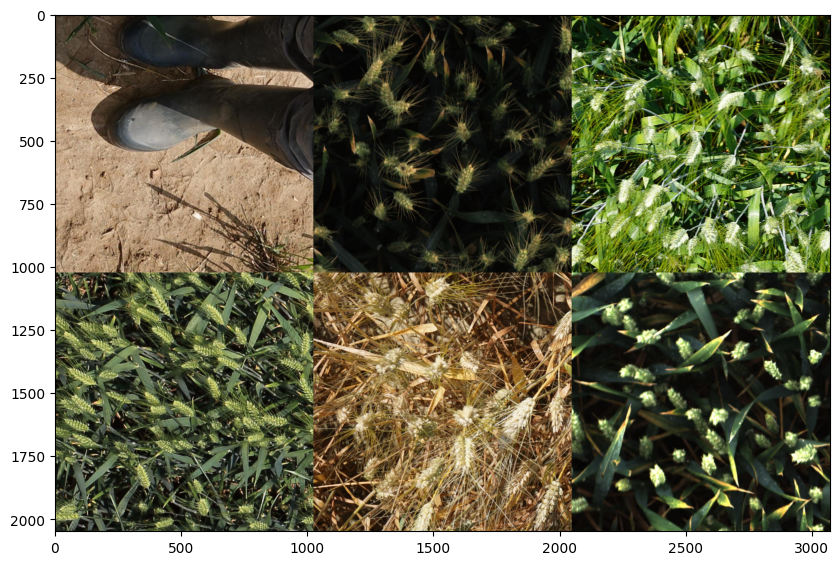

In [ ]:
from pathlib import Path
if RUN_EDA:
    img_names = Path(DATA_DIR+'train/').glob('*.jpg')
    img_list = []
    for i, img_name in enumerate(img_names):
        img_list.append(load_img(img_name.as_posix()))
        print(img_name.name)
        if i == 5:
            break
    plt.figure(figsize=(10,10))
    plt.imshow(create_gallery(np.array(img_list), ncols=3))
else:
    print('RUN_EDA is False')

### **Checking the Shape of Images**

In [ ]:
from tqdm import tqdm
if RUN_EDA:
    img_shape = set()
    img_ext = set()
    img_names = Path(DATA_DIR+'train/').glob('*')
    pbar = tqdm(img_names, total=len(grouped_df))
    for img_name in pbar:
        img = load_img(img_name.as_posix())
        img_shape.add(img.shape)
        img_ext.add(img_name.suffix)
    print(f'Image shapes are {img_shape}.')
    print(f'Image extensions are {img_ext}.')

  0%|          | 5/3373 [00:00<01:07, 49.98it/s]

/content/global-wheat-detection/train/39a0e5556.jpg
/content/global-wheat-detection/train/b838eaf1d.jpg
/content/global-wheat-detection/train/83bfee8fd.jpg
/content/global-wheat-detection/train/daab3de13.jpg
/content/global-wheat-detection/train/20c6725f1.jpg
/content/global-wheat-detection/train/f91e92fd4.jpg
/content/global-wheat-detection/train/8b12ac747.jpg
/content/global-wheat-detection/train/f7ec99608.jpg
/content/global-wheat-detection/train/16d26f266.jpg
/content/global-wheat-detection/train/6651c6f2f.jpg
/content/global-wheat-detection/train/9613afcb6.jpg


  1%|          | 17/3373 [00:00<01:06, 50.44it/s]

/content/global-wheat-detection/train/077ba8cca.jpg
/content/global-wheat-detection/train/0abbdee70.jpg
/content/global-wheat-detection/train/350530720.jpg
/content/global-wheat-detection/train/3744f2482.jpg
/content/global-wheat-detection/train/e1e3b78ab.jpg
/content/global-wheat-detection/train/e6e15309d.jpg
/content/global-wheat-detection/train/809d816dd.jpg
/content/global-wheat-detection/train/28c948177.jpg
/content/global-wheat-detection/train/950935ac1.jpg


  1%|          | 23/3373 [00:00<01:30, 36.89it/s]

/content/global-wheat-detection/train/83aae58fa.jpg
/content/global-wheat-detection/train/900dd018d.jpg
/content/global-wheat-detection/train/00764ad5d.jpg
/content/global-wheat-detection/train/c5c70baa6.jpg
/content/global-wheat-detection/train/6a9c581d2.jpg
/content/global-wheat-detection/train/4a150e0ff.jpg
/content/global-wheat-detection/train/0b5b60131.jpg
/content/global-wheat-detection/train/7d6074b93.jpg


  1%|          | 32/3373 [00:01<02:21, 23.54it/s]

/content/global-wheat-detection/train/4def855a8.jpg
/content/global-wheat-detection/train/56fd2d9c7.jpg
/content/global-wheat-detection/train/c164bb5bb.jpg
/content/global-wheat-detection/train/a7365ee55.jpg
/content/global-wheat-detection/train/eb256e6be.jpg
/content/global-wheat-detection/train/09539e132.jpg


  1%|▏         | 48/3373 [00:01<01:16, 43.52it/s]

/content/global-wheat-detection/train/b9d5a380d.jpg
/content/global-wheat-detection/train/76e56c0b1.jpg
/content/global-wheat-detection/train/bbec6e514.jpg
/content/global-wheat-detection/train/150cabe75.jpg
/content/global-wheat-detection/train/088d3df51.jpg
/content/global-wheat-detection/train/1f3829014.jpg
/content/global-wheat-detection/train/ba586e514.jpg
/content/global-wheat-detection/train/c26cd234a.jpg
/content/global-wheat-detection/train/d3a6e23a3.jpg
/content/global-wheat-detection/train/00b70a919.jpg
/content/global-wheat-detection/train/8ca10d124.jpg
/content/global-wheat-detection/train/ea89a7320.jpg
/content/global-wheat-detection/train/8224baba4.jpg
/content/global-wheat-detection/train/b67b4d2e8.jpg
/content/global-wheat-detection/train/b53afdf5c.jpg
/content/global-wheat-detection/train/3fe6394cd.jpg


  2%|▏         | 66/3373 [00:01<00:55, 60.06it/s]

/content/global-wheat-detection/train/dc7f9cee6.jpg
/content/global-wheat-detection/train/952e7d15c.jpg
/content/global-wheat-detection/train/5a4432266.jpg
/content/global-wheat-detection/train/b70d3e890.jpg
/content/global-wheat-detection/train/6c583e722.jpg
/content/global-wheat-detection/train/0d7268752.jpg
/content/global-wheat-detection/train/b1643e118.jpg
/content/global-wheat-detection/train/dc8edd6b7.jpg
/content/global-wheat-detection/train/b4661eb6f.jpg
/content/global-wheat-detection/train/96fa00d50.jpg
/content/global-wheat-detection/train/4413c8a73.jpg
/content/global-wheat-detection/train/f2a6804d2.jpg
/content/global-wheat-detection/train/b65a59339.jpg
/content/global-wheat-detection/train/a2e7fd80f.jpg
/content/global-wheat-detection/train/371563f00.jpg
/content/global-wheat-detection/train/a4be48060.jpg
/content/global-wheat-detection/train/7bf6e7991.jpg


  2%|▏         | 83/3373 [00:01<00:46, 70.27it/s]

/content/global-wheat-detection/train/be03606e0.jpg
/content/global-wheat-detection/train/66ee3048c.jpg
/content/global-wheat-detection/train/80c30181b.jpg
/content/global-wheat-detection/train/250483997.jpg
/content/global-wheat-detection/train/4e3d5f72f.jpg
/content/global-wheat-detection/train/73ed111df.jpg
/content/global-wheat-detection/train/d145202eb.jpg
/content/global-wheat-detection/train/612b21960.jpg
/content/global-wheat-detection/train/45402cfbb.jpg
/content/global-wheat-detection/train/94f80c57a.jpg
/content/global-wheat-detection/train/44a6fa0ce.jpg
/content/global-wheat-detection/train/0435654cd.jpg
/content/global-wheat-detection/train/51f2e0a05.jpg
/content/global-wheat-detection/train/dc6ca8430.jpg
/content/global-wheat-detection/train/3d39ed7cf.jpg
/content/global-wheat-detection/train/3d9125515.jpg
/content/global-wheat-detection/train/4b74f7320.jpg


  3%|▎         | 101/3373 [00:01<00:42, 77.52it/s]

/content/global-wheat-detection/train/ad62f80f2.jpg
/content/global-wheat-detection/train/49a9d29b6.jpg
/content/global-wheat-detection/train/6ca4eaf5b.jpg
/content/global-wheat-detection/train/58ce0381b.jpg
/content/global-wheat-detection/train/9b4ad2587.jpg
/content/global-wheat-detection/train/3c378dd5d.jpg
/content/global-wheat-detection/train/24a90b0dd.jpg
/content/global-wheat-detection/train/a2d3f8588.jpg
/content/global-wheat-detection/train/af1f9ee99.jpg
/content/global-wheat-detection/train/1f548e2f2.jpg
/content/global-wheat-detection/train/c328e6c68.jpg
/content/global-wheat-detection/train/ebbc11f78.jpg
/content/global-wheat-detection/train/6244395ed.jpg
/content/global-wheat-detection/train/4870004e7.jpg
/content/global-wheat-detection/train/5d6d64e39.jpg
/content/global-wheat-detection/train/cbfaa3ed9.jpg
/content/global-wheat-detection/train/6e8842770.jpg
/content/global-wheat-detection/train/6b2a72b4f.jpg


  3%|▎         | 110/3373 [00:02<00:41, 78.08it/s]

/content/global-wheat-detection/train/1f387ec08.jpg
/content/global-wheat-detection/train/0dc2de69d.jpg
/content/global-wheat-detection/train/d69f6d767.jpg
/content/global-wheat-detection/train/e840ecd4e.jpg
/content/global-wheat-detection/train/0877092cc.jpg
/content/global-wheat-detection/train/03a242bd2.jpg
/content/global-wheat-detection/train/35af6e100.jpg
/content/global-wheat-detection/train/86494833f.jpg
/content/global-wheat-detection/train/fb2eae229.jpg
/content/global-wheat-detection/train/186c66a2c.jpg
/content/global-wheat-detection/train/d557e8635.jpg
/content/global-wheat-detection/train/54668a040.jpg
/content/global-wheat-detection/train/b88fcdafb.jpg
/content/global-wheat-detection/train/afe4fd4f5.jpg
/content/global-wheat-detection/train/673b64e17.jpg
/content/global-wheat-detection/train/dc11d49a0.jpg
/content/global-wheat-detection/train/229716799.jpg


  4%|▍         | 128/3373 [00:02<00:40, 79.59it/s]

/content/global-wheat-detection/train/3ae057d35.jpg
/content/global-wheat-detection/train/26cfef469.jpg
/content/global-wheat-detection/train/65d6480b2.jpg
/content/global-wheat-detection/train/cd243b0b0.jpg
/content/global-wheat-detection/train/c94e8a60c.jpg
/content/global-wheat-detection/train/8a7324c84.jpg
/content/global-wheat-detection/train/029c79463.jpg
/content/global-wheat-detection/train/a0b9b2399.jpg
/content/global-wheat-detection/train/ca3101e66.jpg
/content/global-wheat-detection/train/6d1c9f629.jpg
/content/global-wheat-detection/train/e6b5e296d.jpg
/content/global-wheat-detection/train/b20d35e4d.jpg
/content/global-wheat-detection/train/6e69bf773.jpg
/content/global-wheat-detection/train/4d0e29915.jpg
/content/global-wheat-detection/train/6298999e6.jpg
/content/global-wheat-detection/train/e277cec54.jpg
/content/global-wheat-detection/train/d00a142f1.jpg
/content/global-wheat-detection/train/8f801ee53.jpg


  4%|▍         | 146/3373 [00:02<00:40, 79.37it/s]

/content/global-wheat-detection/train/d950bfe39.jpg
/content/global-wheat-detection/train/43f9b9fc5.jpg
/content/global-wheat-detection/train/a5cdd6362.jpg
/content/global-wheat-detection/train/8b41eb776.jpg
/content/global-wheat-detection/train/73dbabe1f.jpg
/content/global-wheat-detection/train/84d4ca3d3.jpg
/content/global-wheat-detection/train/cf077ea2b.jpg
/content/global-wheat-detection/train/037024e13.jpg
/content/global-wheat-detection/train/e84e8709a.jpg
/content/global-wheat-detection/train/8dd8f0ca6.jpg
/content/global-wheat-detection/train/45fddc611.jpg
/content/global-wheat-detection/train/42f5fe6a5.jpg
/content/global-wheat-detection/train/12f742390.jpg
/content/global-wheat-detection/train/76b0b1204.jpg
/content/global-wheat-detection/train/695ae4a12.jpg
/content/global-wheat-detection/train/990188afc.jpg
/content/global-wheat-detection/train/b3d2304bf.jpg


  5%|▍         | 164/3373 [00:02<00:39, 81.70it/s]

/content/global-wheat-detection/train/1ee6b9669.jpg
/content/global-wheat-detection/train/15d56204e.jpg
/content/global-wheat-detection/train/0126b7d11.jpg
/content/global-wheat-detection/train/b1e31c10b.jpg
/content/global-wheat-detection/train/f21c0d164.jpg
/content/global-wheat-detection/train/f72cabcea.jpg
/content/global-wheat-detection/train/c0cb6aa18.jpg
/content/global-wheat-detection/train/8841bcb77.jpg
/content/global-wheat-detection/train/b57f67edf.jpg
/content/global-wheat-detection/train/d89f4ea06.jpg
/content/global-wheat-detection/train/0abc443ae.jpg
/content/global-wheat-detection/train/87a35ba94.jpg
/content/global-wheat-detection/train/5c85e9eb3.jpg
/content/global-wheat-detection/train/2dfd889a2.jpg
/content/global-wheat-detection/train/4f14fa438.jpg
/content/global-wheat-detection/train/4bdcb2c78.jpg
/content/global-wheat-detection/train/ffbf75e5b.jpg


  5%|▌         | 182/3373 [00:02<00:39, 81.70it/s]

/content/global-wheat-detection/train/41c9d0538.jpg
/content/global-wheat-detection/train/f6a53d30e.jpg
/content/global-wheat-detection/train/72f2eca3a.jpg
/content/global-wheat-detection/train/e837f4e67.jpg
/content/global-wheat-detection/train/7e1caf1f7.jpg
/content/global-wheat-detection/train/ee49343d5.jpg
/content/global-wheat-detection/train/8311f2e1f.jpg
/content/global-wheat-detection/train/d03bcfba1.jpg
/content/global-wheat-detection/train/92c92d40d.jpg
/content/global-wheat-detection/train/3a061fb14.jpg
/content/global-wheat-detection/train/93aff3b78.jpg
/content/global-wheat-detection/train/0679b8bab.jpg
/content/global-wheat-detection/train/044078e70.jpg
/content/global-wheat-detection/train/536ef8d03.jpg
/content/global-wheat-detection/train/3834dbe25.jpg
/content/global-wheat-detection/train/16a0dc111.jpg
/content/global-wheat-detection/train/eebbcb229.jpg
/content/global-wheat-detection/train/71fd03d51.jpg


  6%|▌         | 200/3373 [00:03<00:38, 82.42it/s]

/content/global-wheat-detection/train/ed59f37d2.jpg
/content/global-wheat-detection/train/c5d1a8143.jpg
/content/global-wheat-detection/train/4ef7057d7.jpg
/content/global-wheat-detection/train/1c5f25cd1.jpg
/content/global-wheat-detection/train/ded3279c6.jpg
/content/global-wheat-detection/train/6a1ad8811.jpg
/content/global-wheat-detection/train/ca4769387.jpg
/content/global-wheat-detection/train/c88836133.jpg
/content/global-wheat-detection/train/d1cb278c3.jpg
/content/global-wheat-detection/train/d5af3d5a4.jpg
/content/global-wheat-detection/train/0cbe3f32c.jpg
/content/global-wheat-detection/train/ecf19610a.jpg
/content/global-wheat-detection/train/c7b9b6d62.jpg
/content/global-wheat-detection/train/ee8a5cbbc.jpg
/content/global-wheat-detection/train/f070c6f18.jpg
/content/global-wheat-detection/train/e67200e55.jpg
/content/global-wheat-detection/train/1ecc491e7.jpg


  6%|▋         | 218/3373 [00:03<00:39, 80.09it/s]

/content/global-wheat-detection/train/a489c82f1.jpg
/content/global-wheat-detection/train/2dbaac896.jpg
/content/global-wheat-detection/train/5e182e37e.jpg
/content/global-wheat-detection/train/3dd22103f.jpg
/content/global-wheat-detection/train/a099be857.jpg
/content/global-wheat-detection/train/633807391.jpg
/content/global-wheat-detection/train/1d2950c50.jpg
/content/global-wheat-detection/train/b5a90214f.jpg
/content/global-wheat-detection/train/86fc02294.jpg
/content/global-wheat-detection/train/099c4c2b9.jpg
/content/global-wheat-detection/train/f10db69eb.jpg
/content/global-wheat-detection/train/0f47f54f1.jpg
/content/global-wheat-detection/train/4cb33fd6e.jpg
/content/global-wheat-detection/train/92c083d34.jpg
/content/global-wheat-detection/train/13d56dca0.jpg
/content/global-wheat-detection/train/e93694e20.jpg


  7%|▋         | 236/3373 [00:03<00:38, 81.04it/s]

/content/global-wheat-detection/train/f3db3089c.jpg
/content/global-wheat-detection/train/0a181bbb4.jpg
/content/global-wheat-detection/train/80d3bc82b.jpg
/content/global-wheat-detection/train/3ef86180e.jpg
/content/global-wheat-detection/train/3918cb6de.jpg
/content/global-wheat-detection/train/d36c62b8a.jpg
/content/global-wheat-detection/train/9595d8dc6.jpg
/content/global-wheat-detection/train/f415daf80.jpg
/content/global-wheat-detection/train/f5e0e61e4.jpg
/content/global-wheat-detection/train/34c5e70d5.jpg
/content/global-wheat-detection/train/dc3b08dc0.jpg
/content/global-wheat-detection/train/8201b54e5.jpg
/content/global-wheat-detection/train/12a15fe77.jpg
/content/global-wheat-detection/train/b1cf5e43c.jpg
/content/global-wheat-detection/train/6c1af9100.jpg
/content/global-wheat-detection/train/b6eb131d8.jpg
/content/global-wheat-detection/train/5a9a55ae5.jpg


  8%|▊         | 254/3373 [00:03<00:37, 83.63it/s]

/content/global-wheat-detection/train/7b7b3c08f.jpg
/content/global-wheat-detection/train/5baa23af0.jpg
/content/global-wheat-detection/train/f059e0c19.jpg
/content/global-wheat-detection/train/ca664da7d.jpg
/content/global-wheat-detection/train/96b872ec8.jpg
/content/global-wheat-detection/train/4f13bffbc.jpg
/content/global-wheat-detection/train/9e5f98ad5.jpg
/content/global-wheat-detection/train/0c3d9007c.jpg
/content/global-wheat-detection/train/db3eb3f0c.jpg
/content/global-wheat-detection/train/aa644920c.jpg
/content/global-wheat-detection/train/6f1e9046d.jpg
/content/global-wheat-detection/train/a7605a14e.jpg
/content/global-wheat-detection/train/1b3376c60.jpg
/content/global-wheat-detection/train/98ce36a93.jpg
/content/global-wheat-detection/train/89376d6f5.jpg
/content/global-wheat-detection/train/4a2662fae.jpg
/content/global-wheat-detection/train/59e521267.jpg
/content/global-wheat-detection/train/45aabed56.jpg


  8%|▊         | 272/3373 [00:04<00:37, 83.05it/s]

/content/global-wheat-detection/train/fe3f956a2.jpg
/content/global-wheat-detection/train/4a4a1d3e0.jpg
/content/global-wheat-detection/train/15f3f1f01.jpg
/content/global-wheat-detection/train/be9f01839.jpg
/content/global-wheat-detection/train/4e652f7f1.jpg
/content/global-wheat-detection/train/19fd72f8b.jpg
/content/global-wheat-detection/train/a45f016c2.jpg
/content/global-wheat-detection/train/015939012.jpg
/content/global-wheat-detection/train/4b3d92c5e.jpg
/content/global-wheat-detection/train/d55c4d4b2.jpg
/content/global-wheat-detection/train/b74131d1f.jpg
/content/global-wheat-detection/train/f5e3315ab.jpg
/content/global-wheat-detection/train/5a28cf3a1.jpg
/content/global-wheat-detection/train/d7e657453.jpg
/content/global-wheat-detection/train/203c29f86.jpg
/content/global-wheat-detection/train/18be58eb6.jpg
/content/global-wheat-detection/train/6dfeb6f7a.jpg


  9%|▊         | 290/3373 [00:04<00:36, 83.43it/s]

/content/global-wheat-detection/train/5016adc4b.jpg
/content/global-wheat-detection/train/eeb2213cd.jpg
/content/global-wheat-detection/train/7cb03cdc1.jpg
/content/global-wheat-detection/train/1d54a26d7.jpg
/content/global-wheat-detection/train/5e6a9d355.jpg
/content/global-wheat-detection/train/f4bc4d24c.jpg
/content/global-wheat-detection/train/511091599.jpg
/content/global-wheat-detection/train/80e6b6670.jpg
/content/global-wheat-detection/train/a8eb74244.jpg
/content/global-wheat-detection/train/5ef03457c.jpg
/content/global-wheat-detection/train/79d5a9b6b.jpg
/content/global-wheat-detection/train/302fd5e69.jpg
/content/global-wheat-detection/train/073d83544.jpg
/content/global-wheat-detection/train/f9b999e9c.jpg
/content/global-wheat-detection/train/fda2b546f.jpg
/content/global-wheat-detection/train/66d91891d.jpg
/content/global-wheat-detection/train/eae9f9037.jpg


  9%|▉         | 299/3373 [00:04<00:36, 83.79it/s]

/content/global-wheat-detection/train/463a95dac.jpg
/content/global-wheat-detection/train/6efc51980.jpg
/content/global-wheat-detection/train/d89b34cb1.jpg
/content/global-wheat-detection/train/86426e386.jpg
/content/global-wheat-detection/train/7e69fb4da.jpg
/content/global-wheat-detection/train/d61ad418f.jpg
/content/global-wheat-detection/train/87d232ff4.jpg
/content/global-wheat-detection/train/4a875aa50.jpg
/content/global-wheat-detection/train/bcf1dfc59.jpg
/content/global-wheat-detection/train/2b1986944.jpg
/content/global-wheat-detection/train/63c658201.jpg
/content/global-wheat-detection/train/65cb7e88b.jpg
/content/global-wheat-detection/train/8ea56fe8f.jpg
/content/global-wheat-detection/train/45a6506a3.jpg
/content/global-wheat-detection/train/d15018a92.jpg
/content/global-wheat-detection/train/8a3543c3b.jpg


  9%|▉         | 317/3373 [00:04<00:37, 80.54it/s]

/content/global-wheat-detection/train/e46378032.jpg
/content/global-wheat-detection/train/5e0a7fb4d.jpg
/content/global-wheat-detection/train/fe2a54e65.jpg
/content/global-wheat-detection/train/f27d2e19c.jpg
/content/global-wheat-detection/train/655c1ffdd.jpg
/content/global-wheat-detection/train/96fa7bbcb.jpg
/content/global-wheat-detection/train/c9b23ec87.jpg
/content/global-wheat-detection/train/5c6bcf243.jpg
/content/global-wheat-detection/train/cb34f7509.jpg
/content/global-wheat-detection/train/731334e31.jpg
/content/global-wheat-detection/train/920923400.jpg
/content/global-wheat-detection/train/e90129be4.jpg
/content/global-wheat-detection/train/152800a47.jpg
/content/global-wheat-detection/train/9181010cc.jpg
/content/global-wheat-detection/train/b628691a2.jpg
/content/global-wheat-detection/train/6c31301ae.jpg
/content/global-wheat-detection/train/fb41c061c.jpg


 10%|▉         | 335/3373 [00:04<00:37, 81.06it/s]

/content/global-wheat-detection/train/31c085c60.jpg
/content/global-wheat-detection/train/c64a4006c.jpg
/content/global-wheat-detection/train/ed380c762.jpg
/content/global-wheat-detection/train/eaeda7363.jpg
/content/global-wheat-detection/train/36fb90706.jpg
/content/global-wheat-detection/train/4bb2dc30e.jpg
/content/global-wheat-detection/train/41761631b.jpg
/content/global-wheat-detection/train/c0a6307fa.jpg
/content/global-wheat-detection/train/49476a3c4.jpg
/content/global-wheat-detection/train/817ab3693.jpg
/content/global-wheat-detection/train/f3d0759c8.jpg
/content/global-wheat-detection/train/8b963f326.jpg
/content/global-wheat-detection/train/291a9f4c4.jpg
/content/global-wheat-detection/train/2b5e0f1a2.jpg
/content/global-wheat-detection/train/6cecd54f5.jpg
/content/global-wheat-detection/train/99886a700.jpg
/content/global-wheat-detection/train/bb3df77ab.jpg


 10%|█         | 353/3373 [00:05<00:36, 81.63it/s]

/content/global-wheat-detection/train/f65604566.jpg
/content/global-wheat-detection/train/dbfd38b38.jpg
/content/global-wheat-detection/train/eb9965e00.jpg
/content/global-wheat-detection/train/c78edc091.jpg
/content/global-wheat-detection/train/81e06a4cd.jpg
/content/global-wheat-detection/train/4be2817ef.jpg
/content/global-wheat-detection/train/3badddaf9.jpg
/content/global-wheat-detection/train/e01ad95cf.jpg
/content/global-wheat-detection/train/b2efe29e7.jpg
/content/global-wheat-detection/train/be2ce55d5.jpg
/content/global-wheat-detection/train/41c0123cc.jpg
/content/global-wheat-detection/train/876d458f2.jpg
/content/global-wheat-detection/train/1be796d9d.jpg
/content/global-wheat-detection/train/1da65492e.jpg
/content/global-wheat-detection/train/fec6edf64.jpg
/content/global-wheat-detection/train/19cf6f16c.jpg
/content/global-wheat-detection/train/9efadd5cd.jpg


 11%|█         | 371/3373 [00:05<00:35, 83.49it/s]

/content/global-wheat-detection/train/3ed7c19f0.jpg
/content/global-wheat-detection/train/ba746e119.jpg
/content/global-wheat-detection/train/7c598ce6b.jpg
/content/global-wheat-detection/train/e60108508.jpg
/content/global-wheat-detection/train/01e2c61d9.jpg
/content/global-wheat-detection/train/291fb66d1.jpg
/content/global-wheat-detection/train/85631af25.jpg
/content/global-wheat-detection/train/f05cd0112.jpg
/content/global-wheat-detection/train/c8927c5e1.jpg
/content/global-wheat-detection/train/d0ca0d7a0.jpg
/content/global-wheat-detection/train/fd3c02c74.jpg
/content/global-wheat-detection/train/1ab041b77.jpg
/content/global-wheat-detection/train/8c05f24c4.jpg
/content/global-wheat-detection/train/96efbda67.jpg
/content/global-wheat-detection/train/97851b9c6.jpg
/content/global-wheat-detection/train/7252dabad.jpg
/content/global-wheat-detection/train/0ce3a22a3.jpg
/content/global-wheat-detection/train/6c291229f.jpg


 12%|█▏        | 389/3373 [00:05<00:36, 82.78it/s]

/content/global-wheat-detection/train/976d1eb84.jpg
/content/global-wheat-detection/train/0dbfcf802.jpg
/content/global-wheat-detection/train/1bcb0e91e.jpg
/content/global-wheat-detection/train/5187b2d69.jpg
/content/global-wheat-detection/train/81020ba1b.jpg
/content/global-wheat-detection/train/251b2ed74.jpg
/content/global-wheat-detection/train/be11c4e40.jpg
/content/global-wheat-detection/train/227971e53.jpg
/content/global-wheat-detection/train/ef0d01fae.jpg
/content/global-wheat-detection/train/43cf9ed10.jpg
/content/global-wheat-detection/train/17edbcd63.jpg
/content/global-wheat-detection/train/88707bd69.jpg
/content/global-wheat-detection/train/23a6dd55f.jpg
/content/global-wheat-detection/train/c8909d7a1.jpg
/content/global-wheat-detection/train/58cef5c6c.jpg
/content/global-wheat-detection/train/b7d03627f.jpg
/content/global-wheat-detection/train/f9c4d2466.jpg


 12%|█▏        | 407/3373 [00:05<00:36, 82.12it/s]

/content/global-wheat-detection/train/ffbfe7cc0.jpg
/content/global-wheat-detection/train/b696f57e0.jpg
/content/global-wheat-detection/train/0a73f8a0f.jpg
/content/global-wheat-detection/train/8d4ad2942.jpg
/content/global-wheat-detection/train/dc8b73725.jpg
/content/global-wheat-detection/train/7d574da3d.jpg
/content/global-wheat-detection/train/47dcd5b34.jpg
/content/global-wheat-detection/train/452859b3a.jpg
/content/global-wheat-detection/train/010dbcc8f.jpg
/content/global-wheat-detection/train/c4b7bc850.jpg
/content/global-wheat-detection/train/b77e8c906.jpg
/content/global-wheat-detection/train/fa9b3ea2d.jpg
/content/global-wheat-detection/train/f14055096.jpg
/content/global-wheat-detection/train/744856d95.jpg
/content/global-wheat-detection/train/4cd4207d8.jpg
/content/global-wheat-detection/train/80f1cb7ee.jpg
/content/global-wheat-detection/train/8d6bb70e5.jpg


 13%|█▎        | 425/3373 [00:05<00:36, 81.12it/s]

/content/global-wheat-detection/train/3842535e1.jpg
/content/global-wheat-detection/train/bff5440bc.jpg
/content/global-wheat-detection/train/241bbc684.jpg
/content/global-wheat-detection/train/4ffeedce2.jpg
/content/global-wheat-detection/train/d63350a3d.jpg
/content/global-wheat-detection/train/33c69a58a.jpg
/content/global-wheat-detection/train/e4074a235.jpg
/content/global-wheat-detection/train/bfbe6654b.jpg
/content/global-wheat-detection/train/6a8522f06.jpg
/content/global-wheat-detection/train/c90bf4552.jpg
/content/global-wheat-detection/train/3738685a3.jpg
/content/global-wheat-detection/train/84c56dc93.jpg
/content/global-wheat-detection/train/cbbc58a4c.jpg
/content/global-wheat-detection/train/aeb9f155b.jpg
/content/global-wheat-detection/train/e38514029.jpg
/content/global-wheat-detection/train/4c55b9a80.jpg
/content/global-wheat-detection/train/a750327c3.jpg


 13%|█▎        | 443/3373 [00:06<00:35, 82.54it/s]

/content/global-wheat-detection/train/15c025a28.jpg
/content/global-wheat-detection/train/aedca9e2e.jpg
/content/global-wheat-detection/train/9a30dd802.jpg
/content/global-wheat-detection/train/0d4128a74.jpg
/content/global-wheat-detection/train/a245ab7f9.jpg
/content/global-wheat-detection/train/e486f399d.jpg
/content/global-wheat-detection/train/f437363d5.jpg
/content/global-wheat-detection/train/d13e3ffce.jpg
/content/global-wheat-detection/train/0f0bb7843.jpg
/content/global-wheat-detection/train/79964dffd.jpg
/content/global-wheat-detection/train/ce9534fc2.jpg
/content/global-wheat-detection/train/610d45d1e.jpg
/content/global-wheat-detection/train/1fcc8f8d9.jpg
/content/global-wheat-detection/train/19c242397.jpg
/content/global-wheat-detection/train/ad67b76a3.jpg
/content/global-wheat-detection/train/3cfbeabfc.jpg
/content/global-wheat-detection/train/744ea960b.jpg
/content/global-wheat-detection/train/33b939a6a.jpg


 14%|█▎        | 461/3373 [00:06<00:35, 81.36it/s]

/content/global-wheat-detection/train/e08c90ebe.jpg
/content/global-wheat-detection/train/04b7f3a15.jpg
/content/global-wheat-detection/train/e025eb941.jpg
/content/global-wheat-detection/train/cdd3bc83b.jpg
/content/global-wheat-detection/train/504ec14ed.jpg
/content/global-wheat-detection/train/0cf7ef43d.jpg
/content/global-wheat-detection/train/019d1c76a.jpg
/content/global-wheat-detection/train/947117f47.jpg
/content/global-wheat-detection/train/678011fc2.jpg
/content/global-wheat-detection/train/51e3f1a43.jpg
/content/global-wheat-detection/train/c07795af6.jpg
/content/global-wheat-detection/train/3dd0a7c0e.jpg
/content/global-wheat-detection/train/2e0c19135.jpg
/content/global-wheat-detection/train/09b2de97e.jpg
/content/global-wheat-detection/train/ac1e7253a.jpg
/content/global-wheat-detection/train/1b3380c60.jpg
/content/global-wheat-detection/train/93d056da6.jpg


 14%|█▍        | 470/3373 [00:06<00:35, 82.46it/s]

/content/global-wheat-detection/train/f6afe5443.jpg
/content/global-wheat-detection/train/041707ba8.jpg
/content/global-wheat-detection/train/bb835a3d2.jpg
/content/global-wheat-detection/train/77311ad58.jpg
/content/global-wheat-detection/train/73ec26fe8.jpg
/content/global-wheat-detection/train/f8f466cc9.jpg
/content/global-wheat-detection/train/31eb0625d.jpg
/content/global-wheat-detection/train/48a50a1fd.jpg
/content/global-wheat-detection/train/026b6f389.jpg
/content/global-wheat-detection/train/e383c916b.jpg
/content/global-wheat-detection/train/6231cf54f.jpg
/content/global-wheat-detection/train/9694225d3.jpg
/content/global-wheat-detection/train/6bfbcee57.jpg
/content/global-wheat-detection/train/2b99d68df.jpg
/content/global-wheat-detection/train/4f9eceb2b.jpg
/content/global-wheat-detection/train/0b9624bd4.jpg
/content/global-wheat-detection/train/2c7241d19.jpg


 14%|█▍        | 488/3373 [00:06<00:36, 80.06it/s]

/content/global-wheat-detection/train/2ed43720f.jpg
/content/global-wheat-detection/train/3e2e50976.jpg
/content/global-wheat-detection/train/90184122e.jpg
/content/global-wheat-detection/train/2677d9124.jpg
/content/global-wheat-detection/train/46930c2f2.jpg
/content/global-wheat-detection/train/3c14db5cc.jpg
/content/global-wheat-detection/train/0eab04c31.jpg
/content/global-wheat-detection/train/1ff3f11c4.jpg
/content/global-wheat-detection/train/5c6197826.jpg
/content/global-wheat-detection/train/39ad9affa.jpg
/content/global-wheat-detection/train/408013a9d.jpg
/content/global-wheat-detection/train/a332a2aeb.jpg
/content/global-wheat-detection/train/c86621747.jpg
/content/global-wheat-detection/train/1a39607ca.jpg
/content/global-wheat-detection/train/1172e0f0a.jpg
/content/global-wheat-detection/train/30a6d7d1d.jpg
/content/global-wheat-detection/train/681baf2e2.jpg


 15%|█▌        | 506/3373 [00:06<00:35, 79.93it/s]

/content/global-wheat-detection/train/fa0f32e52.jpg
/content/global-wheat-detection/train/fabaeac81.jpg
/content/global-wheat-detection/train/05522807e.jpg
/content/global-wheat-detection/train/4676009a9.jpg
/content/global-wheat-detection/train/c808023f3.jpg
/content/global-wheat-detection/train/a94964eda.jpg
/content/global-wheat-detection/train/c35743243.jpg
/content/global-wheat-detection/train/ab4ff3cfa.jpg
/content/global-wheat-detection/train/69809f5c0.jpg
/content/global-wheat-detection/train/8473a95f7.jpg
/content/global-wheat-detection/train/6939a6e17.jpg
/content/global-wheat-detection/train/09bcc5259.jpg
/content/global-wheat-detection/train/e3471d3c2.jpg
/content/global-wheat-detection/train/01397a84c.jpg
/content/global-wheat-detection/train/ac8eb0616.jpg
/content/global-wheat-detection/train/2d0fc19b8.jpg
/content/global-wheat-detection/train/666e0a853.jpg


 16%|█▌        | 524/3373 [00:07<00:35, 81.33it/s]

/content/global-wheat-detection/train/a90339a28.jpg
/content/global-wheat-detection/train/4710cf119.jpg
/content/global-wheat-detection/train/c1577d6ff.jpg
/content/global-wheat-detection/train/43e3ccd92.jpg
/content/global-wheat-detection/train/c2fd0893f.jpg
/content/global-wheat-detection/train/9302b9512.jpg
/content/global-wheat-detection/train/f1b3454ff.jpg
/content/global-wheat-detection/train/93224e554.jpg
/content/global-wheat-detection/train/61ff5cdc2.jpg
/content/global-wheat-detection/train/7e416089d.jpg
/content/global-wheat-detection/train/38c8180c0.jpg
/content/global-wheat-detection/train/278038027.jpg
/content/global-wheat-detection/train/44b7163ea.jpg
/content/global-wheat-detection/train/37191de77.jpg
/content/global-wheat-detection/train/90a725e8b.jpg
/content/global-wheat-detection/train/809f14a6a.jpg
/content/global-wheat-detection/train/de03078a2.jpg
/content/global-wheat-detection/train/399260323.jpg


 16%|█▌        | 542/3373 [00:07<00:34, 83.05it/s]

/content/global-wheat-detection/train/d058ee2e2.jpg
/content/global-wheat-detection/train/84053c39b.jpg
/content/global-wheat-detection/train/d781eb0c1.jpg
/content/global-wheat-detection/train/78746472c.jpg
/content/global-wheat-detection/train/dd1b2f39a.jpg
/content/global-wheat-detection/train/13358081a.jpg
/content/global-wheat-detection/train/200b3c316.jpg
/content/global-wheat-detection/train/6ef909f8f.jpg
/content/global-wheat-detection/train/0785826af.jpg
/content/global-wheat-detection/train/d3b3b5628.jpg
/content/global-wheat-detection/train/474e47181.jpg
/content/global-wheat-detection/train/3c377bf39.jpg
/content/global-wheat-detection/train/5d3b4d154.jpg
/content/global-wheat-detection/train/e3f4e8b6d.jpg
/content/global-wheat-detection/train/116a6fceb.jpg
/content/global-wheat-detection/train/dbe68e1c1.jpg


 16%|█▋        | 551/3373 [00:07<00:35, 80.53it/s]

/content/global-wheat-detection/train/2fc7b5c3a.jpg
/content/global-wheat-detection/train/4a8d4eaa5.jpg
/content/global-wheat-detection/train/ecd58cc0a.jpg
/content/global-wheat-detection/train/def999c42.jpg
/content/global-wheat-detection/train/718b1c7b8.jpg
/content/global-wheat-detection/train/602e4b162.jpg
/content/global-wheat-detection/train/eb3cffc94.jpg
/content/global-wheat-detection/train/ffbb9c623.jpg
/content/global-wheat-detection/train/74d747bcf.jpg
/content/global-wheat-detection/train/3aea733b5.jpg
/content/global-wheat-detection/train/4132df01d.jpg
/content/global-wheat-detection/train/a3bcd1d0f.jpg


 17%|█▋        | 568/3373 [00:07<00:44, 62.57it/s]

/content/global-wheat-detection/train/c0217fd95.jpg
/content/global-wheat-detection/train/a06a8b39f.jpg
/content/global-wheat-detection/train/f20ba2db5.jpg
/content/global-wheat-detection/train/56f169f38.jpg
/content/global-wheat-detection/train/8d066eb98.jpg
/content/global-wheat-detection/train/efa2ec01b.jpg
/content/global-wheat-detection/train/136b1f936.jpg
/content/global-wheat-detection/train/f8d155138.jpg
/content/global-wheat-detection/train/10e1fb0e8.jpg
/content/global-wheat-detection/train/9cd2ec689.jpg
/content/global-wheat-detection/train/8a5cb62db.jpg


 17%|█▋        | 575/3373 [00:07<00:47, 59.09it/s]

/content/global-wheat-detection/train/51b4a91cc.jpg
/content/global-wheat-detection/train/b43718050.jpg
/content/global-wheat-detection/train/832cf59eb.jpg
/content/global-wheat-detection/train/6ab50eedf.jpg
/content/global-wheat-detection/train/4e7b1a596.jpg
/content/global-wheat-detection/train/51260fee0.jpg
/content/global-wheat-detection/train/3cb9f2e8c.jpg
/content/global-wheat-detection/train/a134e203f.jpg
/content/global-wheat-detection/train/e12d1b023.jpg
/content/global-wheat-detection/train/2c28cb6dd.jpg
/content/global-wheat-detection/train/03dd40d7b.jpg


 17%|█▋        | 588/3373 [00:08<00:52, 52.71it/s]

/content/global-wheat-detection/train/c5c9bdea8.jpg
/content/global-wheat-detection/train/530a756df.jpg
/content/global-wheat-detection/train/328dde875.jpg
/content/global-wheat-detection/train/40f547633.jpg
/content/global-wheat-detection/train/0424c00e4.jpg
/content/global-wheat-detection/train/d05a25a35.jpg
/content/global-wheat-detection/train/b39cc58f6.jpg
/content/global-wheat-detection/train/1b10b9fa1.jpg
/content/global-wheat-detection/train/93be53f09.jpg
/content/global-wheat-detection/train/93abe3225.jpg


 18%|█▊        | 600/3373 [00:08<00:55, 49.79it/s]

/content/global-wheat-detection/train/d71353153.jpg
/content/global-wheat-detection/train/38b19d4f5.jpg
/content/global-wheat-detection/train/30dbdb998.jpg
/content/global-wheat-detection/train/15babe6dd.jpg
/content/global-wheat-detection/train/518f35565.jpg
/content/global-wheat-detection/train/79eca0678.jpg
/content/global-wheat-detection/train/3d9302a17.jpg
/content/global-wheat-detection/train/b6ab77fd7.jpg
/content/global-wheat-detection/train/d728e2fc2.jpg
/content/global-wheat-detection/train/de2174062.jpg


 18%|█▊        | 606/3373 [00:08<00:57, 48.22it/s]

/content/global-wheat-detection/train/dc50efc2c.jpg
/content/global-wheat-detection/train/a6aeedae1.jpg
/content/global-wheat-detection/train/c8defc0d1.jpg
/content/global-wheat-detection/train/d60e832a5.jpg
/content/global-wheat-detection/train/9e15ceea4.jpg
/content/global-wheat-detection/train/1d2ab0a45.jpg
/content/global-wheat-detection/train/c354a54ac.jpg
/content/global-wheat-detection/train/73c28bef8.jpg
/content/global-wheat-detection/train/344bdc291.jpg
/content/global-wheat-detection/train/78b1ea0d6.jpg


 18%|█▊        | 616/3373 [00:08<00:57, 47.75it/s]

/content/global-wheat-detection/train/474a83c68.jpg
/content/global-wheat-detection/train/57a0bb1bd.jpg
/content/global-wheat-detection/train/b49e3593d.jpg
/content/global-wheat-detection/train/4d0c8be2a.jpg
/content/global-wheat-detection/train/7c23b7b20.jpg
/content/global-wheat-detection/train/980c88da5.jpg
/content/global-wheat-detection/train/b61e9bd86.jpg
/content/global-wheat-detection/train/c2b54f1fe.jpg
/content/global-wheat-detection/train/6d1879f19.jpg
/content/global-wheat-detection/train/854b60f75.jpg


 19%|█▊        | 626/3373 [00:09<00:58, 46.96it/s]

/content/global-wheat-detection/train/a326e7d8e.jpg
/content/global-wheat-detection/train/70581f4f9.jpg
/content/global-wheat-detection/train/19b035d25.jpg
/content/global-wheat-detection/train/e4c9b3866.jpg
/content/global-wheat-detection/train/169be79d1.jpg
/content/global-wheat-detection/train/e1427550f.jpg
/content/global-wheat-detection/train/7f1833df2.jpg
/content/global-wheat-detection/train/e5f11f689.jpg
/content/global-wheat-detection/train/233494bf0.jpg
/content/global-wheat-detection/train/d705ca450.jpg


 19%|█▉        | 636/3373 [00:09<00:57, 47.35it/s]

/content/global-wheat-detection/train/346efc9f4.jpg
/content/global-wheat-detection/train/a3ed252a3.jpg
/content/global-wheat-detection/train/785755a9c.jpg
/content/global-wheat-detection/train/ab8fa9772.jpg
/content/global-wheat-detection/train/82f65a5ca.jpg
/content/global-wheat-detection/train/958c0ad3d.jpg
/content/global-wheat-detection/train/9522e96d8.jpg
/content/global-wheat-detection/train/c672ca0b0.jpg
/content/global-wheat-detection/train/0a3ff84a7.jpg
/content/global-wheat-detection/train/51cd1fe14.jpg
/content/global-wheat-detection/train/bc1666f8c.jpg


 19%|█▉        | 647/3373 [00:09<00:56, 48.43it/s]

/content/global-wheat-detection/train/40cdb5389.jpg
/content/global-wheat-detection/train/30f54e611.jpg
/content/global-wheat-detection/train/7c7d269c8.jpg
/content/global-wheat-detection/train/fe8876602.jpg
/content/global-wheat-detection/train/383817085.jpg
/content/global-wheat-detection/train/fb0a8b6b3.jpg
/content/global-wheat-detection/train/60cb22568.jpg
/content/global-wheat-detection/train/affe1643d.jpg
/content/global-wheat-detection/train/c8c449bf0.jpg
/content/global-wheat-detection/train/b84e88d30.jpg
/content/global-wheat-detection/train/4bb9bab8b.jpg


 20%|█▉        | 659/3373 [00:09<00:54, 49.85it/s]

/content/global-wheat-detection/train/3c2b5bd45.jpg
/content/global-wheat-detection/train/4c7fc04f6.jpg
/content/global-wheat-detection/train/ea72a0c0c.jpg
/content/global-wheat-detection/train/701c2e3e9.jpg
/content/global-wheat-detection/train/1118ba1b9.jpg
/content/global-wheat-detection/train/7826a88b5.jpg
/content/global-wheat-detection/train/e1258e054.jpg
/content/global-wheat-detection/train/5a8f53092.jpg
/content/global-wheat-detection/train/1e58125ec.jpg
/content/global-wheat-detection/train/a3c24fcd4.jpg
/content/global-wheat-detection/train/ccb8097e3.jpg


 20%|█▉        | 669/3373 [00:09<00:55, 48.75it/s]

/content/global-wheat-detection/train/18cefbf07.jpg
/content/global-wheat-detection/train/eaf18c504.jpg
/content/global-wheat-detection/train/830ec2411.jpg
/content/global-wheat-detection/train/220488d01.jpg
/content/global-wheat-detection/train/3843b28ec.jpg
/content/global-wheat-detection/train/5e7aab7a2.jpg
/content/global-wheat-detection/train/2b7b5621c.jpg
/content/global-wheat-detection/train/1946be26b.jpg
/content/global-wheat-detection/train/26a2693ec.jpg
/content/global-wheat-detection/train/37e705df9.jpg
/content/global-wheat-detection/train/f54dedb60.jpg


 20%|██        | 681/3373 [00:10<00:54, 49.69it/s]

/content/global-wheat-detection/train/07dc460bc.jpg
/content/global-wheat-detection/train/e290bc809.jpg
/content/global-wheat-detection/train/a5c5d1e9f.jpg
/content/global-wheat-detection/train/250233aea.jpg
/content/global-wheat-detection/train/04201d2d6.jpg
/content/global-wheat-detection/train/7afe5795e.jpg
/content/global-wheat-detection/train/c02bfe3f2.jpg
/content/global-wheat-detection/train/8f54c057d.jpg
/content/global-wheat-detection/train/1f255e0c5.jpg
/content/global-wheat-detection/train/24646bd61.jpg
/content/global-wheat-detection/train/d1e5fae98.jpg


 21%|██        | 692/3373 [00:10<00:53, 50.08it/s]

/content/global-wheat-detection/train/6a614e72e.jpg
/content/global-wheat-detection/train/aa82bfd6a.jpg
/content/global-wheat-detection/train/526d737d1.jpg
/content/global-wheat-detection/train/cf1fc081c.jpg
/content/global-wheat-detection/train/1964e90f0.jpg
/content/global-wheat-detection/train/f43b1b260.jpg
/content/global-wheat-detection/train/99d5eb61c.jpg
/content/global-wheat-detection/train/864bafe51.jpg
/content/global-wheat-detection/train/5c347dff7.jpg
/content/global-wheat-detection/train/16b77f4c7.jpg


 21%|██        | 704/3373 [00:10<00:53, 49.83it/s]

/content/global-wheat-detection/train/44afd181e.jpg
/content/global-wheat-detection/train/fe7ecb1f4.jpg
/content/global-wheat-detection/train/f5093f57d.jpg
/content/global-wheat-detection/train/03a988adf.jpg
/content/global-wheat-detection/train/399fce7aa.jpg
/content/global-wheat-detection/train/9ae3752f9.jpg
/content/global-wheat-detection/train/bd53c4a79.jpg
/content/global-wheat-detection/train/4311e0c38.jpg
/content/global-wheat-detection/train/bb9be63d1.jpg
/content/global-wheat-detection/train/f005a8ebe.jpg
/content/global-wheat-detection/train/6b51ff205.jpg


 21%|██        | 716/3373 [00:10<00:53, 49.88it/s]

/content/global-wheat-detection/train/a4c89beca.jpg
/content/global-wheat-detection/train/9644dd8a1.jpg
/content/global-wheat-detection/train/3f7abadea.jpg
/content/global-wheat-detection/train/f530a5d4b.jpg
/content/global-wheat-detection/train/e5ab88ff3.jpg
/content/global-wheat-detection/train/411d24167.jpg
/content/global-wheat-detection/train/4d6921225.jpg
/content/global-wheat-detection/train/5f5181592.jpg
/content/global-wheat-detection/train/d89cae86c.jpg
/content/global-wheat-detection/train/155c440e8.jpg
/content/global-wheat-detection/train/614b1d8c5.jpg


 21%|██▏       | 722/3373 [00:10<00:53, 50.00it/s]

/content/global-wheat-detection/train/29dc6c59a.jpg
/content/global-wheat-detection/train/9f528c76b.jpg
/content/global-wheat-detection/train/eb023ea4c.jpg
/content/global-wheat-detection/train/a4b64deca.jpg
/content/global-wheat-detection/train/fefd59985.jpg
/content/global-wheat-detection/train/e2523989d.jpg
/content/global-wheat-detection/train/773a616f7.jpg
/content/global-wheat-detection/train/8851db816.jpg
/content/global-wheat-detection/train/3b829f3b0.jpg
/content/global-wheat-detection/train/ab23f5b74.jpg


 22%|██▏       | 734/3373 [00:11<00:53, 49.33it/s]

/content/global-wheat-detection/train/b0833ce3d.jpg
/content/global-wheat-detection/train/51d7e0c3d.jpg
/content/global-wheat-detection/train/6188edac2.jpg
/content/global-wheat-detection/train/1def04f70.jpg
/content/global-wheat-detection/train/59afb9acf.jpg
/content/global-wheat-detection/train/2cb361be8.jpg
/content/global-wheat-detection/train/29b48c0a7.jpg
/content/global-wheat-detection/train/60b440046.jpg
/content/global-wheat-detection/train/a886d1e61.jpg
/content/global-wheat-detection/train/7fd1d7a57.jpg
/content/global-wheat-detection/train/7f84d451f.jpg


 22%|██▏       | 744/3373 [00:11<00:54, 48.38it/s]

/content/global-wheat-detection/train/783a00fe3.jpg
/content/global-wheat-detection/train/2a4b71fcc.jpg
/content/global-wheat-detection/train/e8e90e8db.jpg
/content/global-wheat-detection/train/060c572e4.jpg
/content/global-wheat-detection/train/4db6e2e94.jpg
/content/global-wheat-detection/train/8d9aaa54d.jpg
/content/global-wheat-detection/train/0874422e6.jpg
/content/global-wheat-detection/train/5ea4aa57a.jpg
/content/global-wheat-detection/train/b44b1faa9.jpg


 22%|██▏       | 754/3373 [00:11<00:54, 48.47it/s]

/content/global-wheat-detection/train/3e5cf1ed6.jpg
/content/global-wheat-detection/train/25fcffb8e.jpg
/content/global-wheat-detection/train/ccfff0629.jpg
/content/global-wheat-detection/train/fe3d17ee2.jpg
/content/global-wheat-detection/train/24dda66d6.jpg
/content/global-wheat-detection/train/9d0f63de7.jpg
/content/global-wheat-detection/train/9b58d4c4e.jpg
/content/global-wheat-detection/train/defc112e7.jpg
/content/global-wheat-detection/train/02e02e347.jpg
/content/global-wheat-detection/train/aadb83e1d.jpg


 23%|██▎       | 765/3373 [00:11<00:52, 49.29it/s]

/content/global-wheat-detection/train/2ac5f9e85.jpg
/content/global-wheat-detection/train/de2a3cf37.jpg
/content/global-wheat-detection/train/00e903abe.jpg
/content/global-wheat-detection/train/b24a3ecee.jpg
/content/global-wheat-detection/train/9bbee18cc.jpg
/content/global-wheat-detection/train/f251e40f2.jpg
/content/global-wheat-detection/train/793ef2974.jpg
/content/global-wheat-detection/train/668149d6b.jpg
/content/global-wheat-detection/train/25b66ccf8.jpg
/content/global-wheat-detection/train/e92e52948.jpg


 23%|██▎       | 777/3373 [00:12<00:48, 53.69it/s]

/content/global-wheat-detection/train/3a4672486.jpg
/content/global-wheat-detection/train/031ed396f.jpg
/content/global-wheat-detection/train/1e509e544.jpg
/content/global-wheat-detection/train/d1931b6bd.jpg
/content/global-wheat-detection/train/5b032a98f.jpg
/content/global-wheat-detection/train/18e5e064b.jpg
/content/global-wheat-detection/train/14d2b1c3a.jpg
/content/global-wheat-detection/train/f5f5a9d30.jpg
/content/global-wheat-detection/train/12ef135a7.jpg
/content/global-wheat-detection/train/68b603861.jpg
/content/global-wheat-detection/train/d0912a485.jpg
/content/global-wheat-detection/train/6af5a0a2b.jpg
/content/global-wheat-detection/train/59bb76698.jpg
/content/global-wheat-detection/train/1577c6651.jpg


 24%|██▎       | 793/3373 [00:12<00:39, 66.05it/s]

/content/global-wheat-detection/train/7087bc3b2.jpg
/content/global-wheat-detection/train/1364f7561.jpg
/content/global-wheat-detection/train/2e867b62b.jpg
/content/global-wheat-detection/train/79b825776.jpg
/content/global-wheat-detection/train/11c916a8a.jpg
/content/global-wheat-detection/train/3aaa6d134.jpg
/content/global-wheat-detection/train/a1092f6d4.jpg
/content/global-wheat-detection/train/149bbb343.jpg
/content/global-wheat-detection/train/b035aabf0.jpg
/content/global-wheat-detection/train/522edf5c3.jpg
/content/global-wheat-detection/train/25d38ec2c.jpg
/content/global-wheat-detection/train/d136f8db2.jpg
/content/global-wheat-detection/train/43f4f59cc.jpg
/content/global-wheat-detection/train/c7637f1dd.jpg
/content/global-wheat-detection/train/f2885d3d7.jpg
/content/global-wheat-detection/train/44463860f.jpg


 24%|██▍       | 811/3373 [00:12<00:34, 74.81it/s]

/content/global-wheat-detection/train/773bf9022.jpg
/content/global-wheat-detection/train/ebc1c07c1.jpg
/content/global-wheat-detection/train/a77598408.jpg
/content/global-wheat-detection/train/c8237c2e6.jpg
/content/global-wheat-detection/train/fb804ab78.jpg
/content/global-wheat-detection/train/6b2a591e8.jpg
/content/global-wheat-detection/train/ef5f2070d.jpg
/content/global-wheat-detection/train/8d2a27ac7.jpg
/content/global-wheat-detection/train/c720c9774.jpg
/content/global-wheat-detection/train/6f4d09643.jpg
/content/global-wheat-detection/train/ce803c694.jpg
/content/global-wheat-detection/train/c9f534ca0.jpg
/content/global-wheat-detection/train/e5b2763a1.jpg
/content/global-wheat-detection/train/9858d67dc.jpg
/content/global-wheat-detection/train/a0ae5ad8e.jpg
/content/global-wheat-detection/train/82b734b58.jpg


 25%|██▍       | 828/3373 [00:12<00:33, 76.36it/s]

/content/global-wheat-detection/train/e8f39c2b2.jpg
/content/global-wheat-detection/train/975c97e30.jpg
/content/global-wheat-detection/train/ba05c7bde.jpg
/content/global-wheat-detection/train/2cc952ee8.jpg
/content/global-wheat-detection/train/8a948e84b.jpg
/content/global-wheat-detection/train/a81f68e82.jpg
/content/global-wheat-detection/train/9764d9f54.jpg
/content/global-wheat-detection/train/1aa099fd7.jpg
/content/global-wheat-detection/train/03ad2a35c.jpg
/content/global-wheat-detection/train/b72ba28ed.jpg
/content/global-wheat-detection/train/bb8e9a0a1.jpg
/content/global-wheat-detection/train/85e3ce681.jpg
/content/global-wheat-detection/train/b69255534.jpg
/content/global-wheat-detection/train/43d29ec95.jpg
/content/global-wheat-detection/train/a4084fc8c.jpg
/content/global-wheat-detection/train/d01b29b85.jpg
/content/global-wheat-detection/train/f04a71a47.jpg


 25%|██▌       | 844/3373 [00:12<00:34, 73.47it/s]

/content/global-wheat-detection/train/569ea0f59.jpg
/content/global-wheat-detection/train/0573ed37c.jpg
/content/global-wheat-detection/train/c74db0380.jpg
/content/global-wheat-detection/train/9ef3c0a46.jpg
/content/global-wheat-detection/train/af32eb10c.jpg
/content/global-wheat-detection/train/586a28040.jpg
/content/global-wheat-detection/train/61bcac952.jpg
/content/global-wheat-detection/train/7820f5412.jpg
/content/global-wheat-detection/train/5f9151e33.jpg
/content/global-wheat-detection/train/a6989b72e.jpg
/content/global-wheat-detection/train/c00e6b4c5.jpg
/content/global-wheat-detection/train/2c2c2a3d6.jpg
/content/global-wheat-detection/train/25c62465e.jpg
/content/global-wheat-detection/train/50ee1a4fc.jpg


 25%|██▌       | 852/3373 [00:13<00:35, 70.83it/s]

/content/global-wheat-detection/train/b6a159fd4.jpg
/content/global-wheat-detection/train/c20958f55.jpg
/content/global-wheat-detection/train/0a4408b37.jpg
/content/global-wheat-detection/train/5adddbf87.jpg
/content/global-wheat-detection/train/f3fcfaa0d.jpg
/content/global-wheat-detection/train/00b5fefed.jpg
/content/global-wheat-detection/train/4a609f334.jpg
/content/global-wheat-detection/train/d5cc960f7.jpg
/content/global-wheat-detection/train/9aa5dec56.jpg
/content/global-wheat-detection/train/60fcdcd44.jpg
/content/global-wheat-detection/train/2f1c4be01.jpg
/content/global-wheat-detection/train/0bb98c55d.jpg
/content/global-wheat-detection/train/bad015d3b.jpg
/content/global-wheat-detection/train/115d07916.jpg
/content/global-wheat-detection/train/0ca410614.jpg


 26%|██▌       | 868/3373 [00:13<00:34, 73.26it/s]

/content/global-wheat-detection/train/2e71d8f9c.jpg
/content/global-wheat-detection/train/fe029eca4.jpg
/content/global-wheat-detection/train/b30d051ab.jpg
/content/global-wheat-detection/train/a3695f973.jpg
/content/global-wheat-detection/train/9071d1211.jpg
/content/global-wheat-detection/train/d1d96eae9.jpg
/content/global-wheat-detection/train/42e6efaaa.jpg
/content/global-wheat-detection/train/484674836.jpg
/content/global-wheat-detection/train/f1794c924.jpg
/content/global-wheat-detection/train/1eb2bad31.jpg
/content/global-wheat-detection/train/0f5267442.jpg
/content/global-wheat-detection/train/3014e5cad.jpg
/content/global-wheat-detection/train/e2e13ad15.jpg
/content/global-wheat-detection/train/12b724773.jpg
/content/global-wheat-detection/train/13b0e960a.jpg
/content/global-wheat-detection/train/eb9833cca.jpg


 26%|██▋       | 886/3373 [00:13<00:32, 77.09it/s]

/content/global-wheat-detection/train/07479da31.jpg
/content/global-wheat-detection/train/ed88cccdc.jpg
/content/global-wheat-detection/train/edf831418.jpg
/content/global-wheat-detection/train/91c9d9c38.jpg
/content/global-wheat-detection/train/20e9f1548.jpg
/content/global-wheat-detection/train/013fd7d80.jpg
/content/global-wheat-detection/train/86d6bcafe.jpg
/content/global-wheat-detection/train/d78825345.jpg
/content/global-wheat-detection/train/bbdc7e299.jpg
/content/global-wheat-detection/train/6f01adf08.jpg
/content/global-wheat-detection/train/d5b96f991.jpg
/content/global-wheat-detection/train/1c90d23fb.jpg
/content/global-wheat-detection/train/b0caf416d.jpg
/content/global-wheat-detection/train/9988ee066.jpg
/content/global-wheat-detection/train/1762ed306.jpg
/content/global-wheat-detection/train/ade6dd872.jpg
/content/global-wheat-detection/train/696530284.jpg


 27%|██▋       | 903/3373 [00:13<00:30, 80.15it/s]

/content/global-wheat-detection/train/f4c7f63e6.jpg
/content/global-wheat-detection/train/b3b2e3768.jpg
/content/global-wheat-detection/train/18f8b24f1.jpg
/content/global-wheat-detection/train/643778d09.jpg
/content/global-wheat-detection/train/0e3074735.jpg
/content/global-wheat-detection/train/d07d391fc.jpg
/content/global-wheat-detection/train/a4cc2650d.jpg
/content/global-wheat-detection/train/c97adf022.jpg
/content/global-wheat-detection/train/22cb24fba.jpg
/content/global-wheat-detection/train/b65e07813.jpg
/content/global-wheat-detection/train/e5c9056ab.jpg
/content/global-wheat-detection/train/9ba7810c6.jpg
/content/global-wheat-detection/train/a3c792f9a.jpg
/content/global-wheat-detection/train/0f4911203.jpg
/content/global-wheat-detection/train/2b2612efa.jpg
/content/global-wheat-detection/train/afb9f53cd.jpg
/content/global-wheat-detection/train/c9d1bc268.jpg


 27%|██▋       | 921/3373 [00:13<00:30, 81.66it/s]

/content/global-wheat-detection/train/26a991110.jpg
/content/global-wheat-detection/train/7aa682e0f.jpg
/content/global-wheat-detection/train/f7fceadee.jpg
/content/global-wheat-detection/train/2073fe7f7.jpg
/content/global-wheat-detection/train/2d990708e.jpg
/content/global-wheat-detection/train/8c8ab21bc.jpg
/content/global-wheat-detection/train/4532a128a.jpg
/content/global-wheat-detection/train/fe641f02e.jpg
/content/global-wheat-detection/train/b900ac004.jpg
/content/global-wheat-detection/train/26d7e7074.jpg
/content/global-wheat-detection/train/c742fa9ae.jpg
/content/global-wheat-detection/train/6a9534cf5.jpg
/content/global-wheat-detection/train/8af29abc4.jpg
/content/global-wheat-detection/train/d9a2181ed.jpg
/content/global-wheat-detection/train/dc928e94e.jpg
/content/global-wheat-detection/train/4ff1646a8.jpg
/content/global-wheat-detection/train/132a92818.jpg


 28%|██▊       | 939/3373 [00:14<00:29, 82.87it/s]

/content/global-wheat-detection/train/24a832fa5.jpg
/content/global-wheat-detection/train/ac9e20f82.jpg
/content/global-wheat-detection/train/8b67401f1.jpg
/content/global-wheat-detection/train/c49ed83ce.jpg
/content/global-wheat-detection/train/cdc68ad10.jpg
/content/global-wheat-detection/train/13c91a4ed.jpg
/content/global-wheat-detection/train/0b2967a7a.jpg
/content/global-wheat-detection/train/2c39acc31.jpg
/content/global-wheat-detection/train/d1ea44cc7.jpg
/content/global-wheat-detection/train/311498261.jpg
/content/global-wheat-detection/train/7727eeebc.jpg
/content/global-wheat-detection/train/f9b92c9e9.jpg
/content/global-wheat-detection/train/810aba893.jpg
/content/global-wheat-detection/train/48fbd2ed7.jpg
/content/global-wheat-detection/train/511dfeca3.jpg
/content/global-wheat-detection/train/b0d4a70e0.jpg
/content/global-wheat-detection/train/4cece159a.jpg
/content/global-wheat-detection/train/cecd9f0c7.jpg


 28%|██▊       | 957/3373 [00:14<00:29, 82.87it/s]

/content/global-wheat-detection/train/305bf8b23.jpg
/content/global-wheat-detection/train/42099cf54.jpg
/content/global-wheat-detection/train/28b8ba0aa.jpg
/content/global-wheat-detection/train/bbce58f71.jpg
/content/global-wheat-detection/train/d03043abb.jpg
/content/global-wheat-detection/train/79c8a1627.jpg
/content/global-wheat-detection/train/8af4b7288.jpg
/content/global-wheat-detection/train/d63d5214a.jpg
/content/global-wheat-detection/train/3d74e4614.jpg
/content/global-wheat-detection/train/7eff8d967.jpg
/content/global-wheat-detection/train/a119a31fb.jpg
/content/global-wheat-detection/train/483f5b46c.jpg
/content/global-wheat-detection/train/97788b3ae.jpg
/content/global-wheat-detection/train/11f24467f.jpg
/content/global-wheat-detection/train/f1a8585e0.jpg
/content/global-wheat-detection/train/71bd00b15.jpg
/content/global-wheat-detection/train/01189a3c3.jpg


 29%|██▉       | 975/3373 [00:14<00:29, 80.82it/s]

/content/global-wheat-detection/train/263daaccf.jpg
/content/global-wheat-detection/train/1b5e821f9.jpg
/content/global-wheat-detection/train/08a55ca8a.jpg
/content/global-wheat-detection/train/5e30f8f4d.jpg
/content/global-wheat-detection/train/b80ec5988.jpg
/content/global-wheat-detection/train/d93838526.jpg
/content/global-wheat-detection/train/19ecc4446.jpg
/content/global-wheat-detection/train/48c72c991.jpg
/content/global-wheat-detection/train/4764548b9.jpg
/content/global-wheat-detection/train/a93fe47af.jpg
/content/global-wheat-detection/train/dd5dd7c60.jpg
/content/global-wheat-detection/train/0bbb17b82.jpg
/content/global-wheat-detection/train/4f4b7779a.jpg
/content/global-wheat-detection/train/8bad19780.jpg
/content/global-wheat-detection/train/2d80f9c49.jpg
/content/global-wheat-detection/train/9458dee84.jpg
/content/global-wheat-detection/train/0f9717e87.jpg


 29%|██▉       | 993/3373 [00:14<00:29, 81.11it/s]

/content/global-wheat-detection/train/155e8d59d.jpg
/content/global-wheat-detection/train/3abd6b428.jpg
/content/global-wheat-detection/train/768b0256e.jpg
/content/global-wheat-detection/train/e8a274b57.jpg
/content/global-wheat-detection/train/d606fe447.jpg
/content/global-wheat-detection/train/58bea1a2d.jpg
/content/global-wheat-detection/train/586607520.jpg
/content/global-wheat-detection/train/1478a43f1.jpg
/content/global-wheat-detection/train/ce4124be0.jpg
/content/global-wheat-detection/train/6c66bb62d.jpg
/content/global-wheat-detection/train/62ec8d906.jpg
/content/global-wheat-detection/train/d6d425855.jpg
/content/global-wheat-detection/train/35d6a4509.jpg
/content/global-wheat-detection/train/211487419.jpg
/content/global-wheat-detection/train/afde13f4a.jpg
/content/global-wheat-detection/train/b815af10b.jpg
/content/global-wheat-detection/train/a5904a10b.jpg


 30%|██▉       | 1002/3373 [00:14<00:30, 78.08it/s]

/content/global-wheat-detection/train/944c60a15.jpg
/content/global-wheat-detection/train/4c5805bae.jpg
/content/global-wheat-detection/train/0fd63ed98.jpg
/content/global-wheat-detection/train/877827fb3.jpg
/content/global-wheat-detection/train/5ca83de08.jpg
/content/global-wheat-detection/train/afd82a1d7.jpg
/content/global-wheat-detection/train/bce2fdc4d.jpg
/content/global-wheat-detection/train/8302fe8b8.jpg
/content/global-wheat-detection/train/9adca8ff8.jpg
/content/global-wheat-detection/train/66adaf07a.jpg
/content/global-wheat-detection/train/7bca11467.jpg
/content/global-wheat-detection/train/86e843e5e.jpg
/content/global-wheat-detection/train/0b7712f7a.jpg
/content/global-wheat-detection/train/91d4e3750.jpg


 30%|███       | 1018/3373 [00:15<00:31, 74.07it/s]

/content/global-wheat-detection/train/2d159a876.jpg
/content/global-wheat-detection/train/40ca794c1.jpg
/content/global-wheat-detection/train/8af3fc5af.jpg
/content/global-wheat-detection/train/d1ff5f449.jpg
/content/global-wheat-detection/train/037d96952.jpg
/content/global-wheat-detection/train/965b39ac8.jpg
/content/global-wheat-detection/train/9e4780f8b.jpg
/content/global-wheat-detection/train/25b347123.jpg
/content/global-wheat-detection/train/b8ddb6c73.jpg
/content/global-wheat-detection/train/269a5f98e.jpg
/content/global-wheat-detection/train/409a8490c.jpg
/content/global-wheat-detection/train/af4f717aa.jpg
/content/global-wheat-detection/train/b22f456aa.jpg
/content/global-wheat-detection/train/8417e5762.jpg
/content/global-wheat-detection/train/44c60402e.jpg


 31%|███       | 1035/3373 [00:15<00:30, 76.40it/s]

/content/global-wheat-detection/train/abcb46fc1.jpg
/content/global-wheat-detection/train/5834f6ee5.jpg
/content/global-wheat-detection/train/84a6298a3.jpg
/content/global-wheat-detection/train/8b89a4833.jpg
/content/global-wheat-detection/train/0e0a0483e.jpg
/content/global-wheat-detection/train/dc8e4942d.jpg
/content/global-wheat-detection/train/630b12b1a.jpg
/content/global-wheat-detection/train/a3ec4d1d3.jpg
/content/global-wheat-detection/train/cfc9040ca.jpg
/content/global-wheat-detection/train/42cc125bc.jpg
/content/global-wheat-detection/train/d1f73158a.jpg
/content/global-wheat-detection/train/90d0bcc83.jpg
/content/global-wheat-detection/train/8dcecab03.jpg
/content/global-wheat-detection/train/82f88bab4.jpg
/content/global-wheat-detection/train/4b95f5e5a.jpg
/content/global-wheat-detection/train/88dc94b76.jpg


 31%|███       | 1052/3373 [00:15<00:30, 76.78it/s]

/content/global-wheat-detection/train/572a469e9.jpg
/content/global-wheat-detection/train/c78072dbe.jpg
/content/global-wheat-detection/train/3940de6a5.jpg
/content/global-wheat-detection/train/86296fc32.jpg
/content/global-wheat-detection/train/45a203e70.jpg
/content/global-wheat-detection/train/2f9755f66.jpg
/content/global-wheat-detection/train/35b935b6c.jpg
/content/global-wheat-detection/train/1f7600e2c.jpg
/content/global-wheat-detection/train/6c7a6f8b8.jpg
/content/global-wheat-detection/train/702385560.jpg
/content/global-wheat-detection/train/c446944d6.jpg
/content/global-wheat-detection/train/05ac5dc96.jpg
/content/global-wheat-detection/train/997a7cf9b.jpg
/content/global-wheat-detection/train/f99daf7f6.jpg
/content/global-wheat-detection/train/a28dcf45d.jpg
/content/global-wheat-detection/train/1fab6aa6b.jpg
/content/global-wheat-detection/train/5b558a4c7.jpg


 32%|███▏      | 1069/3373 [00:15<00:29, 79.36it/s]

/content/global-wheat-detection/train/cf870354f.jpg
/content/global-wheat-detection/train/57ae1baf6.jpg
/content/global-wheat-detection/train/5cbd092f9.jpg
/content/global-wheat-detection/train/c01a58fdb.jpg
/content/global-wheat-detection/train/3455cbc17.jpg
/content/global-wheat-detection/train/725c243a7.jpg
/content/global-wheat-detection/train/0c7af1841.jpg
/content/global-wheat-detection/train/71d2a4b3c.jpg
/content/global-wheat-detection/train/cf97baf3e.jpg
/content/global-wheat-detection/train/8782ac4b6.jpg
/content/global-wheat-detection/train/a666d9bcd.jpg
/content/global-wheat-detection/train/3049b3745.jpg
/content/global-wheat-detection/train/abb037b27.jpg
/content/global-wheat-detection/train/fcf3194f7.jpg
/content/global-wheat-detection/train/8de789df8.jpg
/content/global-wheat-detection/train/6fb67942f.jpg
/content/global-wheat-detection/train/92b234199.jpg


 32%|███▏      | 1087/3373 [00:16<00:28, 80.70it/s]

/content/global-wheat-detection/train/bfcaa59eb.jpg
/content/global-wheat-detection/train/a20b36593.jpg
/content/global-wheat-detection/train/63467d323.jpg
/content/global-wheat-detection/train/2dc5dd23d.jpg
/content/global-wheat-detection/train/6434a5bc8.jpg
/content/global-wheat-detection/train/0f43bb6d7.jpg
/content/global-wheat-detection/train/bb1c3ce8f.jpg
/content/global-wheat-detection/train/ab9e2d432.jpg
/content/global-wheat-detection/train/2aa35dade.jpg
/content/global-wheat-detection/train/a1321ca95.jpg
/content/global-wheat-detection/train/93de65f55.jpg
/content/global-wheat-detection/train/768a74e08.jpg
/content/global-wheat-detection/train/7bb11e582.jpg
/content/global-wheat-detection/train/d6d7c33f9.jpg
/content/global-wheat-detection/train/1b352d5fe.jpg
/content/global-wheat-detection/train/9140498c3.jpg
/content/global-wheat-detection/train/83f971b12.jpg
/content/global-wheat-detection/train/0dd534f81.jpg


 33%|███▎      | 1105/3373 [00:16<00:27, 82.62it/s]

/content/global-wheat-detection/train/4f5331b7b.jpg
/content/global-wheat-detection/train/b75c3bb71.jpg
/content/global-wheat-detection/train/539eab290.jpg
/content/global-wheat-detection/train/f74ede365.jpg
/content/global-wheat-detection/train/1d7a82a04.jpg
/content/global-wheat-detection/train/b7341c950.jpg
/content/global-wheat-detection/train/84f077ae5.jpg
/content/global-wheat-detection/train/3712db803.jpg
/content/global-wheat-detection/train/a9b3451c9.jpg
/content/global-wheat-detection/train/56c449fcd.jpg
/content/global-wheat-detection/train/b00b900a1.jpg
/content/global-wheat-detection/train/cb256df87.jpg
/content/global-wheat-detection/train/d5814b3c4.jpg
/content/global-wheat-detection/train/5ec31deb1.jpg
/content/global-wheat-detection/train/a764cea1f.jpg
/content/global-wheat-detection/train/18059ff19.jpg
/content/global-wheat-detection/train/5792ad7e6.jpg


 33%|███▎      | 1123/3373 [00:16<00:27, 82.30it/s]

/content/global-wheat-detection/train/e891c64c3.jpg
/content/global-wheat-detection/train/64c39c542.jpg
/content/global-wheat-detection/train/e2d034e7d.jpg
/content/global-wheat-detection/train/3741873d5.jpg
/content/global-wheat-detection/train/9386badca.jpg
/content/global-wheat-detection/train/8bd104266.jpg
/content/global-wheat-detection/train/4d77c47b6.jpg
/content/global-wheat-detection/train/677da7510.jpg
/content/global-wheat-detection/train/49e40c7a4.jpg
/content/global-wheat-detection/train/6b055e6cc.jpg
/content/global-wheat-detection/train/b5264e0ad.jpg
/content/global-wheat-detection/train/557d15524.jpg
/content/global-wheat-detection/train/2f53b1a20.jpg
/content/global-wheat-detection/train/90a4c6bf9.jpg
/content/global-wheat-detection/train/c47a1b214.jpg
/content/global-wheat-detection/train/737f28df2.jpg
/content/global-wheat-detection/train/13354f036.jpg
/content/global-wheat-detection/train/5041b4b98.jpg


 34%|███▍      | 1141/3373 [00:16<00:27, 81.09it/s]

/content/global-wheat-detection/train/4ae715446.jpg
/content/global-wheat-detection/train/2d06b68f0.jpg
/content/global-wheat-detection/train/67e82d536.jpg
/content/global-wheat-detection/train/386e36c35.jpg
/content/global-wheat-detection/train/8fb3138d9.jpg
/content/global-wheat-detection/train/b29274495.jpg
/content/global-wheat-detection/train/9f63a1b8f.jpg
/content/global-wheat-detection/train/c3fa071f6.jpg
/content/global-wheat-detection/train/cf3a2a32d.jpg
/content/global-wheat-detection/train/b5e726c10.jpg
/content/global-wheat-detection/train/4b4f6de9b.jpg
/content/global-wheat-detection/train/6a2eac670.jpg
/content/global-wheat-detection/train/f9f72d23c.jpg
/content/global-wheat-detection/train/37a28463a.jpg
/content/global-wheat-detection/train/4688d25ab.jpg
/content/global-wheat-detection/train/352c3a397.jpg
/content/global-wheat-detection/train/c925fda69.jpg


 34%|███▍      | 1159/3373 [00:16<00:27, 81.53it/s]

/content/global-wheat-detection/train/66d517e44.jpg
/content/global-wheat-detection/train/3b2183a3c.jpg
/content/global-wheat-detection/train/91fb0d442.jpg
/content/global-wheat-detection/train/f0a52d979.jpg
/content/global-wheat-detection/train/a586f39dd.jpg
/content/global-wheat-detection/train/e5c45da08.jpg
/content/global-wheat-detection/train/9c527c135.jpg
/content/global-wheat-detection/train/331c69189.jpg
/content/global-wheat-detection/train/0fd4ca0d4.jpg
/content/global-wheat-detection/train/dae78abf2.jpg
/content/global-wheat-detection/train/0ca276259.jpg
/content/global-wheat-detection/train/8af6246a7.jpg
/content/global-wheat-detection/train/824121036.jpg
/content/global-wheat-detection/train/af1507e03.jpg
/content/global-wheat-detection/train/f1016e0ea.jpg
/content/global-wheat-detection/train/bf4a133c9.jpg
/content/global-wheat-detection/train/c29961ce8.jpg


 35%|███▍      | 1176/3373 [00:17<00:28, 77.77it/s]

/content/global-wheat-detection/train/52a0abc4b.jpg
/content/global-wheat-detection/train/dd739823b.jpg
/content/global-wheat-detection/train/a0c25ba9c.jpg
/content/global-wheat-detection/train/ccf2bea3e.jpg
/content/global-wheat-detection/train/2e262da1c.jpg
/content/global-wheat-detection/train/1b399c9a7.jpg
/content/global-wheat-detection/train/d17efcdba.jpg
/content/global-wheat-detection/train/91a285076.jpg
/content/global-wheat-detection/train/9658b9c3c.jpg
/content/global-wheat-detection/train/4c572095f.jpg
/content/global-wheat-detection/train/5ccbf7419.jpg
/content/global-wheat-detection/train/f1ecbf9d4.jpg
/content/global-wheat-detection/train/6ef6fc905.jpg
/content/global-wheat-detection/train/b67b3c007.jpg
/content/global-wheat-detection/train/e2caa2ca7.jpg


 35%|███▌      | 1185/3373 [00:17<00:27, 79.04it/s]

/content/global-wheat-detection/train/85189f1bf.jpg
/content/global-wheat-detection/train/e8fb7d9a8.jpg
/content/global-wheat-detection/train/e91d7c41b.jpg
/content/global-wheat-detection/train/9c05c8d56.jpg
/content/global-wheat-detection/train/33ea56e1c.jpg
/content/global-wheat-detection/train/0d5525a7b.jpg
/content/global-wheat-detection/train/352e238a9.jpg
/content/global-wheat-detection/train/77f6e7caf.jpg
/content/global-wheat-detection/train/2dda3a53d.jpg
/content/global-wheat-detection/train/4ae7a034a.jpg
/content/global-wheat-detection/train/ff5c9104a.jpg
/content/global-wheat-detection/train/dac01a162.jpg
/content/global-wheat-detection/train/d46e680e0.jpg
/content/global-wheat-detection/train/41457a646.jpg
/content/global-wheat-detection/train/d2265cb91.jpg
/content/global-wheat-detection/train/ff86547fb.jpg
/content/global-wheat-detection/train/f7b02d4fc.jpg


 36%|███▌      | 1203/3373 [00:17<00:26, 80.52it/s]

/content/global-wheat-detection/train/c0ad0793a.jpg
/content/global-wheat-detection/train/47b0d504c.jpg
/content/global-wheat-detection/train/96e14c7cd.jpg
/content/global-wheat-detection/train/d0ab06fc3.jpg
/content/global-wheat-detection/train/3f2eddbe8.jpg
/content/global-wheat-detection/train/21504c374.jpg
/content/global-wheat-detection/train/f6d969b95.jpg
/content/global-wheat-detection/train/d6a22baf0.jpg
/content/global-wheat-detection/train/5f76c9a35.jpg
/content/global-wheat-detection/train/4a44057d7.jpg
/content/global-wheat-detection/train/fe1266f43.jpg
/content/global-wheat-detection/train/772287113.jpg
/content/global-wheat-detection/train/c64da3b0d.jpg
/content/global-wheat-detection/train/e1cff2554.jpg
/content/global-wheat-detection/train/a8f992d8d.jpg
/content/global-wheat-detection/train/8ebda8cba.jpg
/content/global-wheat-detection/train/ad94558cf.jpg


 36%|███▌      | 1220/3373 [00:17<00:27, 78.61it/s]

/content/global-wheat-detection/train/e525a27f8.jpg
/content/global-wheat-detection/train/e2ac8324c.jpg
/content/global-wheat-detection/train/e88d43ec5.jpg
/content/global-wheat-detection/train/c18c32da0.jpg
/content/global-wheat-detection/train/aa29cef4a.jpg
/content/global-wheat-detection/train/e0a241bd5.jpg
/content/global-wheat-detection/train/20ebdfc4b.jpg
/content/global-wheat-detection/train/72d4c6b3e.jpg
/content/global-wheat-detection/train/c5ef2f9d2.jpg
/content/global-wheat-detection/train/035bdc07a.jpg
/content/global-wheat-detection/train/f93ef5667.jpg
/content/global-wheat-detection/train/8176735c1.jpg
/content/global-wheat-detection/train/108c78542.jpg
/content/global-wheat-detection/train/3d0a586c6.jpg
/content/global-wheat-detection/train/a9dce39f3.jpg
/content/global-wheat-detection/train/d8e38159a.jpg
/content/global-wheat-detection/train/b615a1f5c.jpg


 37%|███▋      | 1238/3373 [00:17<00:26, 80.74it/s]

/content/global-wheat-detection/train/74f88a07b.jpg
/content/global-wheat-detection/train/df7596db7.jpg
/content/global-wheat-detection/train/59d49ab38.jpg
/content/global-wheat-detection/train/b899eec9f.jpg
/content/global-wheat-detection/train/7de5ba231.jpg
/content/global-wheat-detection/train/e9d060d22.jpg
/content/global-wheat-detection/train/bf48d8c97.jpg
/content/global-wheat-detection/train/93bad1af2.jpg
/content/global-wheat-detection/train/dac6b76fc.jpg
/content/global-wheat-detection/train/a06241eb3.jpg
/content/global-wheat-detection/train/3b70da460.jpg
/content/global-wheat-detection/train/e9d055506.jpg
/content/global-wheat-detection/train/efc4f0374.jpg
/content/global-wheat-detection/train/f4f169106.jpg
/content/global-wheat-detection/train/b1100369a.jpg
/content/global-wheat-detection/train/77222a135.jpg
/content/global-wheat-detection/train/00ea5e5ee.jpg


 37%|███▋      | 1256/3373 [00:18<00:26, 79.92it/s]

/content/global-wheat-detection/train/afb240f5a.jpg
/content/global-wheat-detection/train/690c7d8f0.jpg
/content/global-wheat-detection/train/e4ba46588.jpg
/content/global-wheat-detection/train/dc7c60052.jpg
/content/global-wheat-detection/train/609c993a9.jpg
/content/global-wheat-detection/train/671fb8771.jpg
/content/global-wheat-detection/train/2fc0fadfa.jpg
/content/global-wheat-detection/train/e3732d7b7.jpg
/content/global-wheat-detection/train/06812a4fc.jpg
/content/global-wheat-detection/train/cea58b404.jpg
/content/global-wheat-detection/train/229d8a499.jpg
/content/global-wheat-detection/train/277fff409.jpg
/content/global-wheat-detection/train/b70b381d0.jpg
/content/global-wheat-detection/train/96db737c8.jpg
/content/global-wheat-detection/train/1fe63a46a.jpg
/content/global-wheat-detection/train/cab50874d.jpg
/content/global-wheat-detection/train/0a7338e6f.jpg


 38%|███▊      | 1274/3373 [00:18<00:26, 79.97it/s]

/content/global-wheat-detection/train/29a85cd12.jpg
/content/global-wheat-detection/train/2277ae74f.jpg
/content/global-wheat-detection/train/3b07735f3.jpg
/content/global-wheat-detection/train/6b0b7bbd9.jpg
/content/global-wheat-detection/train/8405c37aa.jpg
/content/global-wheat-detection/train/798a261f0.jpg
/content/global-wheat-detection/train/4fbf0c8b7.jpg
/content/global-wheat-detection/train/cb7a2a690.jpg
/content/global-wheat-detection/train/94b3764f6.jpg
/content/global-wheat-detection/train/a1ecd6a63.jpg
/content/global-wheat-detection/train/7ad46c7f4.jpg
/content/global-wheat-detection/train/88a891a39.jpg
/content/global-wheat-detection/train/4fb926950.jpg
/content/global-wheat-detection/train/3edfa2df0.jpg
/content/global-wheat-detection/train/2c4db1d53.jpg
/content/global-wheat-detection/train/6d993d18d.jpg
/content/global-wheat-detection/train/be6c72a2c.jpg


 38%|███▊      | 1292/3373 [00:18<00:25, 81.53it/s]

/content/global-wheat-detection/train/cc2bbb768.jpg
/content/global-wheat-detection/train/b4d60b5a2.jpg
/content/global-wheat-detection/train/994ec0471.jpg
/content/global-wheat-detection/train/42d5e8791.jpg
/content/global-wheat-detection/train/e91b154aa.jpg
/content/global-wheat-detection/train/96bf13ac5.jpg
/content/global-wheat-detection/train/378966871.jpg
/content/global-wheat-detection/train/3116768f0.jpg
/content/global-wheat-detection/train/7ebf61d5a.jpg
/content/global-wheat-detection/train/0dc9eb168.jpg
/content/global-wheat-detection/train/0fcdc222b.jpg
/content/global-wheat-detection/train/1d74edc1e.jpg
/content/global-wheat-detection/train/7df975b07.jpg
/content/global-wheat-detection/train/efffe90b4.jpg
/content/global-wheat-detection/train/8549afcd5.jpg
/content/global-wheat-detection/train/a9cd1638c.jpg
/content/global-wheat-detection/train/4c02b2f7f.jpg


 39%|███▉      | 1310/3373 [00:18<00:24, 82.84it/s]

/content/global-wheat-detection/train/11182d7ae.jpg
/content/global-wheat-detection/train/2643476a0.jpg
/content/global-wheat-detection/train/9561a71a0.jpg
/content/global-wheat-detection/train/89fc62745.jpg
/content/global-wheat-detection/train/a5bdccb5f.jpg
/content/global-wheat-detection/train/c3c8b6aa5.jpg
/content/global-wheat-detection/train/2bd2f0714.jpg
/content/global-wheat-detection/train/40b8f078e.jpg
/content/global-wheat-detection/train/ce2e2fe79.jpg
/content/global-wheat-detection/train/0a029eead.jpg
/content/global-wheat-detection/train/d0a00b792.jpg
/content/global-wheat-detection/train/2f03889ab.jpg
/content/global-wheat-detection/train/1c2c0786b.jpg
/content/global-wheat-detection/train/f2bfe5abb.jpg
/content/global-wheat-detection/train/948c989ef.jpg
/content/global-wheat-detection/train/a3ce975cd.jpg
/content/global-wheat-detection/train/d25b61e9f.jpg
/content/global-wheat-detection/train/1772cb764.jpg


 39%|███▉      | 1328/3373 [00:18<00:24, 82.91it/s]

/content/global-wheat-detection/train/b1341e5ff.jpg
/content/global-wheat-detection/train/df1ba5253.jpg
/content/global-wheat-detection/train/f05830c46.jpg
/content/global-wheat-detection/train/83a94fc79.jpg
/content/global-wheat-detection/train/dd8ad50bd.jpg
/content/global-wheat-detection/train/251ed33a8.jpg
/content/global-wheat-detection/train/86aaf56ab.jpg
/content/global-wheat-detection/train/9a50eab86.jpg
/content/global-wheat-detection/train/b6df6691b.jpg
/content/global-wheat-detection/train/bd5cb3bc5.jpg
/content/global-wheat-detection/train/999d9d27d.jpg
/content/global-wheat-detection/train/aca4fa91a.jpg
/content/global-wheat-detection/train/284a79f05.jpg
/content/global-wheat-detection/train/bd33b4fef.jpg
/content/global-wheat-detection/train/2d2c79df1.jpg
/content/global-wheat-detection/train/bf0631017.jpg
/content/global-wheat-detection/train/582bcd162.jpg


 40%|███▉      | 1346/3373 [00:19<00:24, 81.37it/s]

/content/global-wheat-detection/train/48bdfec34.jpg
/content/global-wheat-detection/train/f985e704d.jpg
/content/global-wheat-detection/train/777fa71f7.jpg
/content/global-wheat-detection/train/7ec61f6ab.jpg
/content/global-wheat-detection/train/fe125f8a6.jpg
/content/global-wheat-detection/train/fda86ae9a.jpg
/content/global-wheat-detection/train/2d65f77fb.jpg
/content/global-wheat-detection/train/9617b0de8.jpg
/content/global-wheat-detection/train/fda2e0448.jpg
/content/global-wheat-detection/train/59ab1cdd7.jpg
/content/global-wheat-detection/train/b47137eb7.jpg
/content/global-wheat-detection/train/7c6e9829c.jpg
/content/global-wheat-detection/train/7c91c33f0.jpg
/content/global-wheat-detection/train/be0fd10b4.jpg
/content/global-wheat-detection/train/5ab074c28.jpg
/content/global-wheat-detection/train/e344e8213.jpg


 40%|████      | 1364/3373 [00:19<00:24, 83.38it/s]

/content/global-wheat-detection/train/4aeb37788.jpg
/content/global-wheat-detection/train/c35347675.jpg
/content/global-wheat-detection/train/3733d0e53.jpg
/content/global-wheat-detection/train/c88635e09.jpg
/content/global-wheat-detection/train/04981ca30.jpg
/content/global-wheat-detection/train/51eff11e9.jpg
/content/global-wheat-detection/train/70bc24fa2.jpg
/content/global-wheat-detection/train/c7ba07095.jpg
/content/global-wheat-detection/train/63f63c857.jpg
/content/global-wheat-detection/train/347ecba39.jpg
/content/global-wheat-detection/train/b58605092.jpg
/content/global-wheat-detection/train/293a1fd62.jpg
/content/global-wheat-detection/train/f57f29ac1.jpg
/content/global-wheat-detection/train/26b7c3188.jpg
/content/global-wheat-detection/train/2e1a15f76.jpg
/content/global-wheat-detection/train/d4811c163.jpg
/content/global-wheat-detection/train/2ad7fa68e.jpg
/content/global-wheat-detection/train/c9d60e075.jpg


 41%|████      | 1373/3373 [00:19<00:24, 82.56it/s]

/content/global-wheat-detection/train/f358b3414.jpg
/content/global-wheat-detection/train/d1b7acd1d.jpg
/content/global-wheat-detection/train/d8f09768d.jpg
/content/global-wheat-detection/train/8afea785a.jpg
/content/global-wheat-detection/train/967c63659.jpg
/content/global-wheat-detection/train/f21d6d68c.jpg
/content/global-wheat-detection/train/d19c0b3c9.jpg
/content/global-wheat-detection/train/aff4e0a02.jpg
/content/global-wheat-detection/train/5780f8065.jpg
/content/global-wheat-detection/train/bebf1704f.jpg
/content/global-wheat-detection/train/0e86615d0.jpg
/content/global-wheat-detection/train/dc1c9be0d.jpg
/content/global-wheat-detection/train/beacc5971.jpg
/content/global-wheat-detection/train/d6985490b.jpg
/content/global-wheat-detection/train/4a654c127.jpg
/content/global-wheat-detection/train/0172359d2.jpg
/content/global-wheat-detection/train/63fe1ddab.jpg


 41%|████      | 1391/3373 [00:19<00:24, 82.10it/s]

/content/global-wheat-detection/train/895420d9f.jpg
/content/global-wheat-detection/train/26263f228.jpg
/content/global-wheat-detection/train/618e1cac0.jpg
/content/global-wheat-detection/train/59dbb2e28.jpg
/content/global-wheat-detection/train/efcd88e30.jpg
/content/global-wheat-detection/train/a2895c1eb.jpg
/content/global-wheat-detection/train/086b6a39d.jpg
/content/global-wheat-detection/train/9a3fe7557.jpg
/content/global-wheat-detection/train/1e92a05ab.jpg
/content/global-wheat-detection/train/adb1ef13e.jpg
/content/global-wheat-detection/train/47a1184e4.jpg
/content/global-wheat-detection/train/42f5d5a5e.jpg
/content/global-wheat-detection/train/5bf2f5f74.jpg
/content/global-wheat-detection/train/3e684e1cc.jpg
/content/global-wheat-detection/train/1e2735260.jpg
/content/global-wheat-detection/train/61a658026.jpg
/content/global-wheat-detection/train/f04d9c252.jpg


 42%|████▏     | 1409/3373 [00:19<00:23, 82.51it/s]

/content/global-wheat-detection/train/25cd221bb.jpg
/content/global-wheat-detection/train/20331cd3a.jpg
/content/global-wheat-detection/train/67bc08594.jpg
/content/global-wheat-detection/train/e721e6416.jpg
/content/global-wheat-detection/train/b2f2a5dfd.jpg
/content/global-wheat-detection/train/f51be4839.jpg
/content/global-wheat-detection/train/4a304fb45.jpg
/content/global-wheat-detection/train/6d16eb82c.jpg
/content/global-wheat-detection/train/1856c545d.jpg
/content/global-wheat-detection/train/29e44e305.jpg
/content/global-wheat-detection/train/1e6d99635.jpg
/content/global-wheat-detection/train/144dca605.jpg
/content/global-wheat-detection/train/515e496a4.jpg
/content/global-wheat-detection/train/f233cfd8b.jpg
/content/global-wheat-detection/train/e6e510348.jpg
/content/global-wheat-detection/train/14d856fb1.jpg
/content/global-wheat-detection/train/bf4b052f1.jpg


 42%|████▏     | 1427/3373 [00:20<00:23, 83.08it/s]

/content/global-wheat-detection/train/a30ad4024.jpg
/content/global-wheat-detection/train/cce5cb631.jpg
/content/global-wheat-detection/train/228f94f80.jpg
/content/global-wheat-detection/train/07a4d2b9e.jpg
/content/global-wheat-detection/train/c76f1c69b.jpg
/content/global-wheat-detection/train/6994e1821.jpg
/content/global-wheat-detection/train/233cb8750.jpg
/content/global-wheat-detection/train/9052c4be4.jpg
/content/global-wheat-detection/train/682f78993.jpg
/content/global-wheat-detection/train/43ac88073.jpg
/content/global-wheat-detection/train/53c5fcf4c.jpg
/content/global-wheat-detection/train/86b661ae0.jpg
/content/global-wheat-detection/train/a7b16a92f.jpg
/content/global-wheat-detection/train/060fd0cd8.jpg
/content/global-wheat-detection/train/1bda74f14.jpg
/content/global-wheat-detection/train/516218913.jpg
/content/global-wheat-detection/train/13a368f78.jpg


 43%|████▎     | 1445/3373 [00:20<00:24, 79.43it/s]

/content/global-wheat-detection/train/752ae9486.jpg
/content/global-wheat-detection/train/e6b54d480.jpg
/content/global-wheat-detection/train/a23558330.jpg
/content/global-wheat-detection/train/4cbb2b7bd.jpg
/content/global-wheat-detection/train/7f0e525f3.jpg
/content/global-wheat-detection/train/de3c12de1.jpg
/content/global-wheat-detection/train/c7c00c1a3.jpg
/content/global-wheat-detection/train/e224a64ba.jpg
/content/global-wheat-detection/train/51bf3f631.jpg
/content/global-wheat-detection/train/9bedf6645.jpg
/content/global-wheat-detection/train/a88470ebd.jpg
/content/global-wheat-detection/train/d9b373de2.jpg
/content/global-wheat-detection/train/53d0a8b5a.jpg
/content/global-wheat-detection/train/8daf0da72.jpg
/content/global-wheat-detection/train/91f19054e.jpg
/content/global-wheat-detection/train/3753c58f7.jpg


 43%|████▎     | 1462/3373 [00:20<00:23, 80.73it/s]

/content/global-wheat-detection/train/2c7638ee8.jpg
/content/global-wheat-detection/train/156282051.jpg
/content/global-wheat-detection/train/59e8168c0.jpg
/content/global-wheat-detection/train/7ea16f78f.jpg
/content/global-wheat-detection/train/81b76f372.jpg
/content/global-wheat-detection/train/aa6b16251.jpg
/content/global-wheat-detection/train/de7b4de8c.jpg
/content/global-wheat-detection/train/eee4c334e.jpg
/content/global-wheat-detection/train/7e6a307fd.jpg
/content/global-wheat-detection/train/f0508910d.jpg
/content/global-wheat-detection/train/5c64b986e.jpg
/content/global-wheat-detection/train/c6454073b.jpg
/content/global-wheat-detection/train/8f5e128e3.jpg
/content/global-wheat-detection/train/4eb442168.jpg
/content/global-wheat-detection/train/879d8a9d2.jpg
/content/global-wheat-detection/train/6a7cbd408.jpg
/content/global-wheat-detection/train/218338312.jpg


 44%|████▍     | 1480/3373 [00:20<00:23, 81.02it/s]

/content/global-wheat-detection/train/2cffefd1a.jpg
/content/global-wheat-detection/train/a85f39e3d.jpg
/content/global-wheat-detection/train/4bfd5f95e.jpg
/content/global-wheat-detection/train/af861c3be.jpg
/content/global-wheat-detection/train/ccd16cf61.jpg
/content/global-wheat-detection/train/7d0d1f2f4.jpg
/content/global-wheat-detection/train/62be58f7d.jpg
/content/global-wheat-detection/train/c83d339fe.jpg
/content/global-wheat-detection/train/eefb4a7fa.jpg
/content/global-wheat-detection/train/77d1f3c18.jpg
/content/global-wheat-detection/train/bcb8e2fb7.jpg
/content/global-wheat-detection/train/7be932521.jpg
/content/global-wheat-detection/train/0d08bc31f.jpg
/content/global-wheat-detection/train/52c457b5d.jpg
/content/global-wheat-detection/train/f438c0466.jpg
/content/global-wheat-detection/train/d4abcc41e.jpg
/content/global-wheat-detection/train/45a13cbcd.jpg


 44%|████▍     | 1498/3373 [00:21<00:22, 83.97it/s]

/content/global-wheat-detection/train/fbc79aea4.jpg
/content/global-wheat-detection/train/8f4d1ad4e.jpg
/content/global-wheat-detection/train/fc6860020.jpg
/content/global-wheat-detection/train/432d13b1c.jpg
/content/global-wheat-detection/train/1a9792bfc.jpg
/content/global-wheat-detection/train/d484ee6d8.jpg
/content/global-wheat-detection/train/bad10b9c4.jpg
/content/global-wheat-detection/train/652903094.jpg
/content/global-wheat-detection/train/5c2e16f27.jpg
/content/global-wheat-detection/train/7de1fc333.jpg
/content/global-wheat-detection/train/4276fddc7.jpg
/content/global-wheat-detection/train/af7f4eb72.jpg
/content/global-wheat-detection/train/eb69f5522.jpg
/content/global-wheat-detection/train/0e0809a3d.jpg
/content/global-wheat-detection/train/10c433ecf.jpg
/content/global-wheat-detection/train/688e051dc.jpg
/content/global-wheat-detection/train/4b869fa1c.jpg
/content/global-wheat-detection/train/8e2f178d1.jpg


 45%|████▍     | 1516/3373 [00:21<00:21, 85.71it/s]

/content/global-wheat-detection/train/a4bce62ff.jpg
/content/global-wheat-detection/train/2b45c0165.jpg
/content/global-wheat-detection/train/0787635a2.jpg
/content/global-wheat-detection/train/2c836cccb.jpg
/content/global-wheat-detection/train/ef1f73253.jpg
/content/global-wheat-detection/train/84a5579db.jpg
/content/global-wheat-detection/train/c3c03e0b7.jpg
/content/global-wheat-detection/train/d94f9d8a2.jpg
/content/global-wheat-detection/train/34f7f196b.jpg
/content/global-wheat-detection/train/5738fcf14.jpg
/content/global-wheat-detection/train/09eb21d04.jpg
/content/global-wheat-detection/train/4a8b1ad4a.jpg
/content/global-wheat-detection/train/e2018867c.jpg
/content/global-wheat-detection/train/a57808743.jpg
/content/global-wheat-detection/train/f98d398d0.jpg
/content/global-wheat-detection/train/ebcdcc024.jpg
/content/global-wheat-detection/train/c6654ff53.jpg
/content/global-wheat-detection/train/444977945.jpg


 45%|████▌     | 1534/3373 [00:21<00:21, 84.49it/s]

/content/global-wheat-detection/train/9bccf7e53.jpg
/content/global-wheat-detection/train/7cca42bf6.jpg
/content/global-wheat-detection/train/e6af2a27e.jpg
/content/global-wheat-detection/train/9fd1b7929.jpg
/content/global-wheat-detection/train/44e31e39f.jpg
/content/global-wheat-detection/train/a44b0ece4.jpg
/content/global-wheat-detection/train/f2c0e95ec.jpg
/content/global-wheat-detection/train/ff46aa8d4.jpg
/content/global-wheat-detection/train/60044b7cb.jpg
/content/global-wheat-detection/train/91c9c8b5e.jpg
/content/global-wheat-detection/train/b6324ea82.jpg
/content/global-wheat-detection/train/1443b3f7a.jpg
/content/global-wheat-detection/train/726539191.jpg
/content/global-wheat-detection/train/6a0e4e8cf.jpg
/content/global-wheat-detection/train/f24698e88.jpg
/content/global-wheat-detection/train/46727d887.jpg
/content/global-wheat-detection/train/7227652d3.jpg
/content/global-wheat-detection/train/c509717b1.jpg


 46%|████▌     | 1552/3373 [00:21<00:22, 81.80it/s]

/content/global-wheat-detection/train/8a7178ad5.jpg
/content/global-wheat-detection/train/b2672900e.jpg
/content/global-wheat-detection/train/7c5221c68.jpg
/content/global-wheat-detection/train/b3bd71a4b.jpg
/content/global-wheat-detection/train/48fe9c634.jpg
/content/global-wheat-detection/train/ec3d2ced1.jpg
/content/global-wheat-detection/train/3b6147f4c.jpg
/content/global-wheat-detection/train/57393e4e9.jpg
/content/global-wheat-detection/train/23a4b904a.jpg
/content/global-wheat-detection/train/147706d0f.jpg
/content/global-wheat-detection/train/3a1f54e49.jpg
/content/global-wheat-detection/train/feb78a8de.jpg
/content/global-wheat-detection/train/9c832432c.jpg
/content/global-wheat-detection/train/68fa4a555.jpg
/content/global-wheat-detection/train/3ff643a64.jpg
/content/global-wheat-detection/train/30bbd3d87.jpg


 47%|████▋     | 1570/3373 [00:21<00:21, 83.27it/s]

/content/global-wheat-detection/train/144d57df8.jpg
/content/global-wheat-detection/train/d6cd9fa5f.jpg
/content/global-wheat-detection/train/20a86a215.jpg
/content/global-wheat-detection/train/839814a17.jpg
/content/global-wheat-detection/train/fab41168b.jpg
/content/global-wheat-detection/train/47a9b9c85.jpg
/content/global-wheat-detection/train/a76ca8630.jpg
/content/global-wheat-detection/train/65f13d74f.jpg
/content/global-wheat-detection/train/e36eca699.jpg
/content/global-wheat-detection/train/f5b320e47.jpg
/content/global-wheat-detection/train/dbd433d29.jpg
/content/global-wheat-detection/train/a13c89a7f.jpg
/content/global-wheat-detection/train/58b3d8b22.jpg
/content/global-wheat-detection/train/5b3ca5452.jpg
/content/global-wheat-detection/train/eb42212f3.jpg
/content/global-wheat-detection/train/37f88c75e.jpg
/content/global-wheat-detection/train/c7c9b4e72.jpg


 47%|████▋     | 1579/3373 [00:22<00:24, 72.26it/s]

/content/global-wheat-detection/train/ed00a614d.jpg
/content/global-wheat-detection/train/fdbdb35fc.jpg
/content/global-wheat-detection/train/d4c3b28f4.jpg
/content/global-wheat-detection/train/56d818688.jpg
/content/global-wheat-detection/train/4112a34bd.jpg
/content/global-wheat-detection/train/c233d242d.jpg
/content/global-wheat-detection/train/c936df99a.jpg
/content/global-wheat-detection/train/16d922704.jpg
/content/global-wheat-detection/train/78b0bf2ec.jpg
/content/global-wheat-detection/train/e755efa77.jpg
/content/global-wheat-detection/train/cff6e4b78.jpg
/content/global-wheat-detection/train/52adef115.jpg


 47%|████▋     | 1587/3373 [00:22<00:27, 66.01it/s]

/content/global-wheat-detection/train/bead3cebe.jpg
/content/global-wheat-detection/train/198df0975.jpg
/content/global-wheat-detection/train/acb011afd.jpg
/content/global-wheat-detection/train/5758d6571.jpg
/content/global-wheat-detection/train/595a30abe.jpg
/content/global-wheat-detection/train/c4731ac9e.jpg
/content/global-wheat-detection/train/4af27998f.jpg
/content/global-wheat-detection/train/ebaa9b7d6.jpg
/content/global-wheat-detection/train/37bcaaeb6.jpg
/content/global-wheat-detection/train/f05647ed3.jpg
/content/global-wheat-detection/train/2e6c333a7.jpg


 47%|████▋     | 1601/3373 [00:22<00:30, 58.41it/s]

/content/global-wheat-detection/train/5d6ce1c78.jpg
/content/global-wheat-detection/train/537395836.jpg
/content/global-wheat-detection/train/988a60e6e.jpg
/content/global-wheat-detection/train/c00c660fc.jpg
/content/global-wheat-detection/train/9c01f3217.jpg
/content/global-wheat-detection/train/88114e632.jpg
/content/global-wheat-detection/train/24fb4b33d.jpg
/content/global-wheat-detection/train/5343c02b0.jpg
/content/global-wheat-detection/train/966c3ebc6.jpg
/content/global-wheat-detection/train/09ba65605.jpg


 48%|████▊     | 1613/3373 [00:22<00:32, 54.70it/s]

/content/global-wheat-detection/train/1ecb85340.jpg
/content/global-wheat-detection/train/059125072.jpg
/content/global-wheat-detection/train/a4fb1f6af.jpg
/content/global-wheat-detection/train/2f204a70c.jpg
/content/global-wheat-detection/train/1b99d2fd6.jpg
/content/global-wheat-detection/train/740d3c904.jpg
/content/global-wheat-detection/train/5901a73fe.jpg
/content/global-wheat-detection/train/290ae67be.jpg
/content/global-wheat-detection/train/ba18364b2.jpg
/content/global-wheat-detection/train/e3a86f7ff.jpg
/content/global-wheat-detection/train/8e1543437.jpg


 48%|████▊     | 1619/3373 [00:22<00:33, 51.74it/s]

/content/global-wheat-detection/train/b59778e6b.jpg
/content/global-wheat-detection/train/f9ece438e.jpg
/content/global-wheat-detection/train/29f09fa58.jpg
/content/global-wheat-detection/train/1c6e42234.jpg
/content/global-wheat-detection/train/a0f951ca5.jpg
/content/global-wheat-detection/train/e14f4de23.jpg
/content/global-wheat-detection/train/bb808af6f.jpg
/content/global-wheat-detection/train/68561559e.jpg
/content/global-wheat-detection/train/aa7eba834.jpg
/content/global-wheat-detection/train/e26eefe0f.jpg


 48%|████▊     | 1631/3373 [00:23<00:35, 49.37it/s]

/content/global-wheat-detection/train/ed168fff1.jpg
/content/global-wheat-detection/train/a88930f1f.jpg
/content/global-wheat-detection/train/d493fef8c.jpg
/content/global-wheat-detection/train/dc2c73c4b.jpg
/content/global-wheat-detection/train/901a650fb.jpg
/content/global-wheat-detection/train/af9dc42e8.jpg
/content/global-wheat-detection/train/1a13195b8.jpg
/content/global-wheat-detection/train/eff99d6e2.jpg
/content/global-wheat-detection/train/69fc3d3ff.jpg
/content/global-wheat-detection/train/ef274ecdc.jpg


 49%|████▊     | 1641/3373 [00:23<00:35, 48.55it/s]

/content/global-wheat-detection/train/d067ac2b1.jpg
/content/global-wheat-detection/train/e0861437e.jpg
/content/global-wheat-detection/train/3ba04140c.jpg
/content/global-wheat-detection/train/f78c551de.jpg
/content/global-wheat-detection/train/09f97e0cf.jpg
/content/global-wheat-detection/train/fb6e04c0c.jpg
/content/global-wheat-detection/train/2443092e6.jpg
/content/global-wheat-detection/train/2630babc5.jpg
/content/global-wheat-detection/train/692570572.jpg
/content/global-wheat-detection/train/d8cae4d1b.jpg


 49%|████▉     | 1653/3373 [00:23<00:34, 50.33it/s]

/content/global-wheat-detection/train/b1642dc6f.jpg
/content/global-wheat-detection/train/7f01525b1.jpg
/content/global-wheat-detection/train/f3e13af6a.jpg
/content/global-wheat-detection/train/7fd06d0d9.jpg
/content/global-wheat-detection/train/43966050a.jpg
/content/global-wheat-detection/train/52c1231da.jpg
/content/global-wheat-detection/train/834690a35.jpg
/content/global-wheat-detection/train/069719eab.jpg
/content/global-wheat-detection/train/a8cd65e4f.jpg
/content/global-wheat-detection/train/b3e72b002.jpg
/content/global-wheat-detection/train/46e49521e.jpg


 49%|████▉     | 1665/3373 [00:23<00:33, 51.19it/s]

/content/global-wheat-detection/train/0cbb43d45.jpg
/content/global-wheat-detection/train/fae71c97b.jpg
/content/global-wheat-detection/train/408eff4a9.jpg
/content/global-wheat-detection/train/0429c9ff6.jpg
/content/global-wheat-detection/train/6bd3f949d.jpg
/content/global-wheat-detection/train/3eeb41f2a.jpg
/content/global-wheat-detection/train/4e9096ca9.jpg
/content/global-wheat-detection/train/769309456.jpg
/content/global-wheat-detection/train/3db94deb2.jpg
/content/global-wheat-detection/train/684dfcf04.jpg
/content/global-wheat-detection/train/823c71a4b.jpg


 50%|████▉     | 1671/3373 [00:23<00:33, 50.32it/s]

/content/global-wheat-detection/train/1b43ca0a6.jpg
/content/global-wheat-detection/train/7b138337f.jpg
/content/global-wheat-detection/train/7b72ea0fb.jpg
/content/global-wheat-detection/train/72f8aaa4f.jpg
/content/global-wheat-detection/train/efb3d3fb9.jpg
/content/global-wheat-detection/train/a93b2e119.jpg
/content/global-wheat-detection/train/d79169f0e.jpg
/content/global-wheat-detection/train/26f09dc76.jpg
/content/global-wheat-detection/train/02f0fe2ca.jpg
/content/global-wheat-detection/train/14b4ef410.jpg
/content/global-wheat-detection/train/67a70d2d7.jpg


 50%|████▉     | 1683/3373 [00:24<00:33, 50.61it/s]

/content/global-wheat-detection/train/c6b4933f7.jpg
/content/global-wheat-detection/train/1ebc11f19.jpg
/content/global-wheat-detection/train/ce367f7d6.jpg
/content/global-wheat-detection/train/c14c1e300.jpg
/content/global-wheat-detection/train/f1d20d58a.jpg
/content/global-wheat-detection/train/69d37b0ba.jpg
/content/global-wheat-detection/train/cbfd50139.jpg
/content/global-wheat-detection/train/12e8267b0.jpg
/content/global-wheat-detection/train/b0a22c629.jpg
/content/global-wheat-detection/train/04fe56fd3.jpg
/content/global-wheat-detection/train/9ce6888c9.jpg

 50%|█████     | 1694/3373 [00:24<00:33, 49.71it/s]


/content/global-wheat-detection/train/c04c3f192.jpg
/content/global-wheat-detection/train/bb67d5c2e.jpg
/content/global-wheat-detection/train/3cbee7440.jpg
/content/global-wheat-detection/train/81eb8a758.jpg
/content/global-wheat-detection/train/2b32a4cc4.jpg
/content/global-wheat-detection/train/78cf5b3fd.jpg
/content/global-wheat-detection/train/c0fa19bac.jpg
/content/global-wheat-detection/train/14783fc8c.jpg
/content/global-wheat-detection/train/e87d43a13.jpg
/content/global-wheat-detection/train/765f1b36a.jpg


 51%|█████     | 1706/3373 [00:24<00:32, 50.92it/s]

/content/global-wheat-detection/train/84f805c08.jpg
/content/global-wheat-detection/train/b45096c1e.jpg
/content/global-wheat-detection/train/3b4f7ba0a.jpg
/content/global-wheat-detection/train/f3cce7df3.jpg
/content/global-wheat-detection/train/9d63ad423.jpg
/content/global-wheat-detection/train/cbab952fe.jpg
/content/global-wheat-detection/train/3eeed3eda.jpg
/content/global-wheat-detection/train/c9a573b93.jpg
/content/global-wheat-detection/train/21a9818dd.jpg
/content/global-wheat-detection/train/510c8e6f2.jpg
/content/global-wheat-detection/train/4b04d64f9.jpg


 51%|█████     | 1717/3373 [00:24<00:33, 49.08it/s]

/content/global-wheat-detection/train/bf697b8c4.jpg
/content/global-wheat-detection/train/ddd60739d.jpg
/content/global-wheat-detection/train/595709e55.jpg
/content/global-wheat-detection/train/551902572.jpg
/content/global-wheat-detection/train/7a77062fb.jpg
/content/global-wheat-detection/train/48269749e.jpg
/content/global-wheat-detection/train/dbcfa06bd.jpg
/content/global-wheat-detection/train/a7436f5c7.jpg
/content/global-wheat-detection/train/7e971fbec.jpg
/content/global-wheat-detection/train/4e0cf51fd.jpg


 51%|█████     | 1727/3373 [00:25<00:33, 48.82it/s]

/content/global-wheat-detection/train/3f23c607b.jpg
/content/global-wheat-detection/train/c63dc2890.jpg
/content/global-wheat-detection/train/aadc1fd23.jpg
/content/global-wheat-detection/train/94ea18562.jpg
/content/global-wheat-detection/train/57284abbb.jpg
/content/global-wheat-detection/train/4b4639da9.jpg
/content/global-wheat-detection/train/05e946e1f.jpg
/content/global-wheat-detection/train/3ee6fd90a.jpg
/content/global-wheat-detection/train/8425a537b.jpg
/content/global-wheat-detection/train/b1e4a723e.jpg
/content/global-wheat-detection/train/f52f20733.jpg


 52%|█████▏    | 1739/3373 [00:25<00:31, 51.15it/s]

/content/global-wheat-detection/train/fade0e053.jpg
/content/global-wheat-detection/train/8f507b3f7.jpg
/content/global-wheat-detection/train/ab500e0d8.jpg
/content/global-wheat-detection/train/d7612c04a.jpg
/content/global-wheat-detection/train/f52ca5892.jpg
/content/global-wheat-detection/train/8200547cf.jpg
/content/global-wheat-detection/train/a7e9ac14b.jpg
/content/global-wheat-detection/train/90677210d.jpg
/content/global-wheat-detection/train/465a8a521.jpg
/content/global-wheat-detection/train/379ef727d.jpg
/content/global-wheat-detection/train/b45c5294d.jpg


 52%|█████▏    | 1751/3373 [00:25<00:32, 50.40it/s]

/content/global-wheat-detection/train/efc5642bb.jpg
/content/global-wheat-detection/train/a2b9aabde.jpg
/content/global-wheat-detection/train/a5a10c597.jpg
/content/global-wheat-detection/train/8498f5a6c.jpg
/content/global-wheat-detection/train/84d992b88.jpg
/content/global-wheat-detection/train/83995f53f.jpg
/content/global-wheat-detection/train/83521e96e.jpg
/content/global-wheat-detection/train/ceb6406ab.jpg
/content/global-wheat-detection/train/0c2d20111.jpg
/content/global-wheat-detection/train/4e5c1078d.jpg
/content/global-wheat-detection/train/8ecb44432.jpg


 52%|█████▏    | 1757/3373 [00:25<00:33, 47.69it/s]

/content/global-wheat-detection/train/636069d07.jpg
/content/global-wheat-detection/train/fa060c1f8.jpg
/content/global-wheat-detection/train/f3ed7c4ee.jpg
/content/global-wheat-detection/train/74feae99f.jpg
/content/global-wheat-detection/train/f279ed35d.jpg
/content/global-wheat-detection/train/69041dcff.jpg
/content/global-wheat-detection/train/7d5af5b74.jpg
/content/global-wheat-detection/train/ca22dfe75.jpg
/content/global-wheat-detection/train/893938464.jpg
/content/global-wheat-detection/train/a783f9679.jpg


 52%|█████▏    | 1767/3373 [00:25<00:35, 45.25it/s]

/content/global-wheat-detection/train/901e23e9b.jpg
/content/global-wheat-detection/train/38ed976da.jpg
/content/global-wheat-detection/train/9ea2ef32b.jpg
/content/global-wheat-detection/train/0df7f89c3.jpg
/content/global-wheat-detection/train/7264c58b9.jpg
/content/global-wheat-detection/train/2d93cee57.jpg
/content/global-wheat-detection/train/91b435dbb.jpg
/content/global-wheat-detection/train/06a78c36e.jpg
/content/global-wheat-detection/train/ad59fa99c.jpg
/content/global-wheat-detection/train/8ba166588.jpg


 53%|█████▎    | 1778/3373 [00:26<00:33, 47.41it/s]

/content/global-wheat-detection/train/9e50af3ab.jpg
/content/global-wheat-detection/train/fb6e8bd3f.jpg
/content/global-wheat-detection/train/010c93b99.jpg
/content/global-wheat-detection/train/4e2b8a4a6.jpg
/content/global-wheat-detection/train/65d0b13aa.jpg
/content/global-wheat-detection/train/60870e668.jpg
/content/global-wheat-detection/train/f9c577690.jpg
/content/global-wheat-detection/train/a519e5a11.jpg
/content/global-wheat-detection/train/9ad34dab3.jpg
/content/global-wheat-detection/train/faedfa626.jpg
/content/global-wheat-detection/train/cf1d2f504.jpg


 53%|█████▎    | 1793/3373 [00:26<00:32, 48.75it/s]

/content/global-wheat-detection/train/f9cafa47f.jpg
/content/global-wheat-detection/train/0cca0ffc8.jpg
/content/global-wheat-detection/train/331a697b2.jpg
/content/global-wheat-detection/train/a3773af88.jpg
/content/global-wheat-detection/train/2d72a5f04.jpg
/content/global-wheat-detection/train/09d50b59d.jpg
/content/global-wheat-detection/train/f8d848989.jpg
/content/global-wheat-detection/train/ffb445410.jpg
/content/global-wheat-detection/train/96367fda5.jpg
/content/global-wheat-detection/train/66c96dce0.jpg


 53%|█████▎    | 1799/3373 [00:26<00:31, 49.76it/s]

/content/global-wheat-detection/train/5a5631a48.jpg
/content/global-wheat-detection/train/77683d1a4.jpg
/content/global-wheat-detection/train/4655fcc18.jpg
/content/global-wheat-detection/train/5a3e0c6b5.jpg
/content/global-wheat-detection/train/ed22354e1.jpg
/content/global-wheat-detection/train/58adb478f.jpg
/content/global-wheat-detection/train/39614e195.jpg
/content/global-wheat-detection/train/b04239da0.jpg
/content/global-wheat-detection/train/01f37f1d3.jpg
/content/global-wheat-detection/train/ea65602e0.jpg
/content/global-wheat-detection/train/619cb231d.jpg
/content/global-wheat-detection/train/aa4ec63aa.jpg
/content/global-wheat-detection/train/c8b81529c.jpg


 54%|█████▍    | 1816/3373 [00:26<00:23, 65.22it/s]

/content/global-wheat-detection/train/19255ce1d.jpg
/content/global-wheat-detection/train/3a1c78a92.jpg
/content/global-wheat-detection/train/c4f8e6485.jpg
/content/global-wheat-detection/train/e64e1c77b.jpg
/content/global-wheat-detection/train/ee8c82355.jpg
/content/global-wheat-detection/train/ab026459d.jpg
/content/global-wheat-detection/train/1c0155c9c.jpg
/content/global-wheat-detection/train/38dc44b85.jpg
/content/global-wheat-detection/train/625fca045.jpg
/content/global-wheat-detection/train/5559af3a9.jpg
/content/global-wheat-detection/train/c52f29668.jpg
/content/global-wheat-detection/train/a047ef30d.jpg
/content/global-wheat-detection/train/8a5658897.jpg
/content/global-wheat-detection/train/aeff69b31.jpg
/content/global-wheat-detection/train/266826a59.jpg
/content/global-wheat-detection/train/a2cc1210b.jpg
/content/global-wheat-detection/train/564832c17.jpg


 54%|█████▍    | 1833/3373 [00:27<00:21, 71.02it/s]

/content/global-wheat-detection/train/ed7c302a2.jpg
/content/global-wheat-detection/train/0989b2627.jpg
/content/global-wheat-detection/train/e11b95f4e.jpg
/content/global-wheat-detection/train/ad6eaaf54.jpg
/content/global-wheat-detection/train/4cf91995d.jpg
/content/global-wheat-detection/train/f0665430d.jpg
/content/global-wheat-detection/train/26d5c0e4a.jpg
/content/global-wheat-detection/train/c89aed93e.jpg
/content/global-wheat-detection/train/f4a36a6fd.jpg
/content/global-wheat-detection/train/ddce42b64.jpg
/content/global-wheat-detection/train/b18b34ed2.jpg
/content/global-wheat-detection/train/b824c0e55.jpg
/content/global-wheat-detection/train/cf3adb4de.jpg
/content/global-wheat-detection/train/8f1d02616.jpg
/content/global-wheat-detection/train/56cb8b67d.jpg
/content/global-wheat-detection/train/cf483de89.jpg
/content/global-wheat-detection/train/aca5a7a07.jpg


 55%|█████▍    | 1850/3373 [00:27<00:19, 76.79it/s]

/content/global-wheat-detection/train/40191f5cd.jpg
/content/global-wheat-detection/train/9dcba0cab.jpg
/content/global-wheat-detection/train/22f341965.jpg
/content/global-wheat-detection/train/097af10ac.jpg
/content/global-wheat-detection/train/70b693efe.jpg
/content/global-wheat-detection/train/4e02ed1d3.jpg
/content/global-wheat-detection/train/6df093d5e.jpg
/content/global-wheat-detection/train/ad6e9eea2.jpg
/content/global-wheat-detection/train/08a65db34.jpg
/content/global-wheat-detection/train/da3cfa3d4.jpg
/content/global-wheat-detection/train/a9aabd0c8.jpg
/content/global-wheat-detection/train/2474376a6.jpg
/content/global-wheat-detection/train/6e58d4ea0.jpg
/content/global-wheat-detection/train/20c7cc731.jpg
/content/global-wheat-detection/train/5fb074443.jpg
/content/global-wheat-detection/train/307fa05aa.jpg
/content/global-wheat-detection/train/a9b1e5e29.jpg
/content/global-wheat-detection/train/f926234d6.jpg


 55%|█████▌    | 1868/3373 [00:27<00:18, 80.69it/s]

/content/global-wheat-detection/train/56c1bc7f0.jpg
/content/global-wheat-detection/train/e089dca60.jpg
/content/global-wheat-detection/train/b3c96d5ad.jpg
/content/global-wheat-detection/train/b6b899073.jpg
/content/global-wheat-detection/train/39f0b1003.jpg
/content/global-wheat-detection/train/1bb0c013a.jpg
/content/global-wheat-detection/train/f165314f1.jpg
/content/global-wheat-detection/train/457752437.jpg
/content/global-wheat-detection/train/4b127eb47.jpg
/content/global-wheat-detection/train/119969932.jpg
/content/global-wheat-detection/train/e99667355.jpg
/content/global-wheat-detection/train/ce69098f5.jpg
/content/global-wheat-detection/train/c631c7fdb.jpg
/content/global-wheat-detection/train/57a6b42c8.jpg
/content/global-wheat-detection/train/6639b23df.jpg
/content/global-wheat-detection/train/1dbc99ed8.jpg
/content/global-wheat-detection/train/93ad786cf.jpg


 56%|█████▌    | 1886/3373 [00:27<00:18, 79.49it/s]

/content/global-wheat-detection/train/2ccec6dcc.jpg
/content/global-wheat-detection/train/f1144b38d.jpg
/content/global-wheat-detection/train/5498d5aae.jpg
/content/global-wheat-detection/train/9ab4727a2.jpg
/content/global-wheat-detection/train/a700357af.jpg
/content/global-wheat-detection/train/a3cf26f70.jpg
/content/global-wheat-detection/train/3fd9db710.jpg
/content/global-wheat-detection/train/f3bc43304.jpg
/content/global-wheat-detection/train/303def58d.jpg
/content/global-wheat-detection/train/67e5c5d41.jpg
/content/global-wheat-detection/train/b95e8d11b.jpg
/content/global-wheat-detection/train/0adcb2a1a.jpg
/content/global-wheat-detection/train/45d452a61.jpg
/content/global-wheat-detection/train/b8402b0ce.jpg
/content/global-wheat-detection/train/5dcae81a5.jpg
/content/global-wheat-detection/train/ac47b0c64.jpg
/content/global-wheat-detection/train/13973250e.jpg


 56%|█████▋    | 1903/3373 [00:27<00:18, 80.28it/s]

/content/global-wheat-detection/train/57a45fde6.jpg
/content/global-wheat-detection/train/e16f7b9c3.jpg
/content/global-wheat-detection/train/6f0b47178.jpg
/content/global-wheat-detection/train/c6e6f5527.jpg
/content/global-wheat-detection/train/ecc61faef.jpg
/content/global-wheat-detection/train/3a84eba70.jpg
/content/global-wheat-detection/train/00333207f.jpg
/content/global-wheat-detection/train/ffb0f6eca.jpg
/content/global-wheat-detection/train/e6b5f3375.jpg
/content/global-wheat-detection/train/0a97d54ae.jpg
/content/global-wheat-detection/train/5a76259a0.jpg
/content/global-wheat-detection/train/bf2c0adde.jpg
/content/global-wheat-detection/train/7e75b3e43.jpg
/content/global-wheat-detection/train/505dfa497.jpg
/content/global-wheat-detection/train/05dfa9bb1.jpg
/content/global-wheat-detection/train/fc0978226.jpg


 57%|█████▋    | 1920/3373 [00:28<00:18, 78.89it/s]

/content/global-wheat-detection/train/2cc49e1ba.jpg
/content/global-wheat-detection/train/4d60c73db.jpg
/content/global-wheat-detection/train/8f3e2b4e8.jpg
/content/global-wheat-detection/train/e1c0e82fd.jpg
/content/global-wheat-detection/train/e6277ce7c.jpg
/content/global-wheat-detection/train/ffdf83e42.jpg
/content/global-wheat-detection/train/59ade64e1.jpg
/content/global-wheat-detection/train/c85eedb4c.jpg
/content/global-wheat-detection/train/2629ddf24.jpg
/content/global-wheat-detection/train/78752f185.jpg
/content/global-wheat-detection/train/060543bbf.jpg
/content/global-wheat-detection/train/c23c950a9.jpg
/content/global-wheat-detection/train/d6341ae47.jpg
/content/global-wheat-detection/train/dfbc049cd.jpg
/content/global-wheat-detection/train/af13ca6bc.jpg
/content/global-wheat-detection/train/3dc3a72f9.jpg


 57%|█████▋    | 1936/3373 [00:28<00:18, 77.54it/s]

/content/global-wheat-detection/train/619aff026.jpg
/content/global-wheat-detection/train/6b4169a72.jpg
/content/global-wheat-detection/train/27bf608b8.jpg
/content/global-wheat-detection/train/894baab2e.jpg
/content/global-wheat-detection/train/42b47b7e1.jpg
/content/global-wheat-detection/train/4cfb86eff.jpg
/content/global-wheat-detection/train/eddff557c.jpg
/content/global-wheat-detection/train/ba98d009b.jpg
/content/global-wheat-detection/train/57570effa.jpg
/content/global-wheat-detection/train/6284044ed.jpg
/content/global-wheat-detection/train/c3c959c98.jpg
/content/global-wheat-detection/train/fd8b236e8.jpg
/content/global-wheat-detection/train/e991f2e06.jpg
/content/global-wheat-detection/train/b1b1b8fba.jpg
/content/global-wheat-detection/train/b61e3461d.jpg
/content/global-wheat-detection/train/c8e5e50ec.jpg


 58%|█████▊    | 1953/3373 [00:28<00:17, 80.37it/s]

/content/global-wheat-detection/train/6ce97e05f.jpg
/content/global-wheat-detection/train/f20baf558.jpg
/content/global-wheat-detection/train/6d262fcb8.jpg
/content/global-wheat-detection/train/69662aa1c.jpg
/content/global-wheat-detection/train/461376287.jpg
/content/global-wheat-detection/train/1909b7c5e.jpg
/content/global-wheat-detection/train/03a177626.jpg
/content/global-wheat-detection/train/382bf4ed7.jpg
/content/global-wheat-detection/train/4646dcda7.jpg
/content/global-wheat-detection/train/73ebe3acc.jpg
/content/global-wheat-detection/train/5d73dfef2.jpg
/content/global-wheat-detection/train/848e992bd.jpg
/content/global-wheat-detection/train/5d6935f10.jpg
/content/global-wheat-detection/train/b3822b5cd.jpg
/content/global-wheat-detection/train/e16a9d55e.jpg
/content/global-wheat-detection/train/91fefb8e4.jpg
/content/global-wheat-detection/train/ce7375bad.jpg


 58%|█████▊    | 1971/3373 [00:28<00:17, 81.11it/s]

/content/global-wheat-detection/train/59d43a53f.jpg
/content/global-wheat-detection/train/b46dce732.jpg
/content/global-wheat-detection/train/3f1c5459a.jpg
/content/global-wheat-detection/train/b9ffac7be.jpg
/content/global-wheat-detection/train/fd30a89bb.jpg
/content/global-wheat-detection/train/6f119c82d.jpg
/content/global-wheat-detection/train/dacaf5c55.jpg
/content/global-wheat-detection/train/b1356efe7.jpg
/content/global-wheat-detection/train/555f4fc58.jpg
/content/global-wheat-detection/train/56f7dc978.jpg
/content/global-wheat-detection/train/d3286c089.jpg
/content/global-wheat-detection/train/279a356f8.jpg
/content/global-wheat-detection/train/5855982d5.jpg
/content/global-wheat-detection/train/8a5c7ac65.jpg
/content/global-wheat-detection/train/9785e4e53.jpg
/content/global-wheat-detection/train/4021d47d4.jpg
/content/global-wheat-detection/train/dd3e3f071.jpg
/content/global-wheat-detection/train/5f0b34ad6.jpg


 59%|█████▉    | 1989/3373 [00:28<00:17, 80.51it/s]

/content/global-wheat-detection/train/6c071b9da.jpg
/content/global-wheat-detection/train/620e2aee4.jpg
/content/global-wheat-detection/train/14c66436c.jpg
/content/global-wheat-detection/train/a6c1cc190.jpg
/content/global-wheat-detection/train/76595919e.jpg
/content/global-wheat-detection/train/80833051d.jpg
/content/global-wheat-detection/train/a677f18d9.jpg
/content/global-wheat-detection/train/12786fe3b.jpg
/content/global-wheat-detection/train/ab20ec355.jpg
/content/global-wheat-detection/train/a7fca55c7.jpg
/content/global-wheat-detection/train/7b89e388a.jpg
/content/global-wheat-detection/train/ad5ef99be.jpg
/content/global-wheat-detection/train/a22cdd5eb.jpg
/content/global-wheat-detection/train/722b46d6b.jpg
/content/global-wheat-detection/train/654a741f5.jpg
/content/global-wheat-detection/train/4b83b6541.jpg
/content/global-wheat-detection/train/ed1270725.jpg


 60%|█████▉    | 2007/3373 [00:29<00:16, 82.23it/s]

/content/global-wheat-detection/train/3ead80a57.jpg
/content/global-wheat-detection/train/c223249af.jpg
/content/global-wheat-detection/train/f46fea3a3.jpg
/content/global-wheat-detection/train/4e8584276.jpg
/content/global-wheat-detection/train/ba35357cb.jpg
/content/global-wheat-detection/train/fb2b30bc9.jpg
/content/global-wheat-detection/train/34b5b6acb.jpg
/content/global-wheat-detection/train/d4d1c9bc4.jpg
/content/global-wheat-detection/train/57587eaf7.jpg
/content/global-wheat-detection/train/c988834c9.jpg
/content/global-wheat-detection/train/cf770a944.jpg
/content/global-wheat-detection/train/b6265c083.jpg
/content/global-wheat-detection/train/2d8a88333.jpg
/content/global-wheat-detection/train/ddc160ce0.jpg
/content/global-wheat-detection/train/3cf295f6c.jpg
/content/global-wheat-detection/train/f6e40d451.jpg
/content/global-wheat-detection/train/31016e613.jpg


 60%|██████    | 2025/3373 [00:29<00:16, 80.82it/s]

/content/global-wheat-detection/train/471c46022.jpg
/content/global-wheat-detection/train/e6f19d1d7.jpg
/content/global-wheat-detection/train/28ee29473.jpg
/content/global-wheat-detection/train/8bd3806b7.jpg
/content/global-wheat-detection/train/4285f0271.jpg
/content/global-wheat-detection/train/d83808467.jpg
/content/global-wheat-detection/train/afe608129.jpg
/content/global-wheat-detection/train/0afdb91a2.jpg
/content/global-wheat-detection/train/d35243cd0.jpg
/content/global-wheat-detection/train/e2a3ba358.jpg
/content/global-wheat-detection/train/fabd1d799.jpg
/content/global-wheat-detection/train/458b7beb9.jpg
/content/global-wheat-detection/train/feac3a701.jpg
/content/global-wheat-detection/train/9a9f42302.jpg
/content/global-wheat-detection/train/962ccb192.jpg
/content/global-wheat-detection/train/480c01244.jpg
/content/global-wheat-detection/train/723068e09.jpg


 61%|██████    | 2043/3373 [00:29<00:16, 83.08it/s]

/content/global-wheat-detection/train/c0bc8d9f2.jpg
/content/global-wheat-detection/train/49fbdf27c.jpg
/content/global-wheat-detection/train/97ba6330a.jpg
/content/global-wheat-detection/train/8fb545c05.jpg
/content/global-wheat-detection/train/974b78929.jpg
/content/global-wheat-detection/train/8d4f8b1cc.jpg
/content/global-wheat-detection/train/8115795f7.jpg
/content/global-wheat-detection/train/f02cb9a6a.jpg
/content/global-wheat-detection/train/7b3a5ad53.jpg
/content/global-wheat-detection/train/956c1d252.jpg
/content/global-wheat-detection/train/c1bea7def.jpg
/content/global-wheat-detection/train/d011146e3.jpg
/content/global-wheat-detection/train/c34dd05a3.jpg
/content/global-wheat-detection/train/ce78f7f47.jpg
/content/global-wheat-detection/train/9aea92dce.jpg
/content/global-wheat-detection/train/03d831c0d.jpg
/content/global-wheat-detection/train/c6357c9d8.jpg
/content/global-wheat-detection/train/a97e8476c.jpg


 61%|██████    | 2061/3373 [00:29<00:15, 84.92it/s]

/content/global-wheat-detection/train/7e18f16b8.jpg
/content/global-wheat-detection/train/bf0d58e83.jpg
/content/global-wheat-detection/train/49c3e4f6e.jpg
/content/global-wheat-detection/train/94265d02a.jpg
/content/global-wheat-detection/train/ca2b57db7.jpg
/content/global-wheat-detection/train/8f0434556.jpg
/content/global-wheat-detection/train/b9d2dbd0f.jpg
/content/global-wheat-detection/train/133f92be6.jpg
/content/global-wheat-detection/train/0ff60b2bc.jpg
/content/global-wheat-detection/train/c7df66915.jpg
/content/global-wheat-detection/train/09b4141a6.jpg
/content/global-wheat-detection/train/d3a1f8c7e.jpg
/content/global-wheat-detection/train/2ccb37ea9.jpg
/content/global-wheat-detection/train/c022ddc42.jpg
/content/global-wheat-detection/train/9a1947520.jpg
/content/global-wheat-detection/train/c009d9de3.jpg
/content/global-wheat-detection/train/22c8f2030.jpg
/content/global-wheat-detection/train/75791012a.jpg


 61%|██████▏   | 2070/3373 [00:29<00:15, 81.86it/s]

/content/global-wheat-detection/train/34b96b38e.jpg
/content/global-wheat-detection/train/c434ccb01.jpg
/content/global-wheat-detection/train/fcaaff29d.jpg
/content/global-wheat-detection/train/e891a6cff.jpg
/content/global-wheat-detection/train/939c5d28b.jpg
/content/global-wheat-detection/train/c60a61cf5.jpg
/content/global-wheat-detection/train/a90446700.jpg
/content/global-wheat-detection/train/0d3bd5eac.jpg
/content/global-wheat-detection/train/96b19d664.jpg
/content/global-wheat-detection/train/fe5c1ea5a.jpg
/content/global-wheat-detection/train/f4f62f0f8.jpg
/content/global-wheat-detection/train/4a44720ca.jpg
/content/global-wheat-detection/train/7c9096e13.jpg
/content/global-wheat-detection/train/a65b1b9a6.jpg
/content/global-wheat-detection/train/5a5fff341.jpg
/content/global-wheat-detection/train/8e132157b.jpg


 62%|██████▏   | 2088/3373 [00:30<00:16, 79.82it/s]

/content/global-wheat-detection/train/4c24f7168.jpg
/content/global-wheat-detection/train/2c3d40735.jpg
/content/global-wheat-detection/train/97372d371.jpg
/content/global-wheat-detection/train/2a5be9325.jpg
/content/global-wheat-detection/train/7220f6fa6.jpg
/content/global-wheat-detection/train/43650fd9c.jpg
/content/global-wheat-detection/train/73ed5eb37.jpg
/content/global-wheat-detection/train/ccd5d31da.jpg
/content/global-wheat-detection/train/41badd217.jpg
/content/global-wheat-detection/train/5ba57fd72.jpg
/content/global-wheat-detection/train/14d024cc4.jpg
/content/global-wheat-detection/train/ba290b964.jpg
/content/global-wheat-detection/train/09798007b.jpg
/content/global-wheat-detection/train/79ce67248.jpg
/content/global-wheat-detection/train/8f65fc2b9.jpg
/content/global-wheat-detection/train/af14863c5.jpg
/content/global-wheat-detection/train/e321272b3.jpg
/content/global-wheat-detection/train/f85244c49.jpg


 62%|██████▏   | 2106/3373 [00:30<00:15, 81.96it/s]

/content/global-wheat-detection/train/8c4bdc8ba.jpg
/content/global-wheat-detection/train/e9dc0cf8f.jpg
/content/global-wheat-detection/train/224017b57.jpg
/content/global-wheat-detection/train/c09caecc1.jpg
/content/global-wheat-detection/train/ec196d18a.jpg
/content/global-wheat-detection/train/7e1a10f51.jpg
/content/global-wheat-detection/train/47e218059.jpg
/content/global-wheat-detection/train/a34a8c2cc.jpg
/content/global-wheat-detection/train/6d1ff0f34.jpg
/content/global-wheat-detection/train/0bb1adbd8.jpg
/content/global-wheat-detection/train/95d633618.jpg
/content/global-wheat-detection/train/a897f8dc8.jpg
/content/global-wheat-detection/train/93d67b171.jpg
/content/global-wheat-detection/train/161f20a53.jpg
/content/global-wheat-detection/train/9d137bb37.jpg
/content/global-wheat-detection/train/e011bf67e.jpg
/content/global-wheat-detection/train/833577238.jpg


 63%|██████▎   | 2124/3373 [00:30<00:15, 82.63it/s]

/content/global-wheat-detection/train/7fcfe0ae1.jpg
/content/global-wheat-detection/train/3ba5d332c.jpg
/content/global-wheat-detection/train/e4cc39cbf.jpg
/content/global-wheat-detection/train/147830115.jpg
/content/global-wheat-detection/train/d5bc2cad4.jpg
/content/global-wheat-detection/train/0557047b9.jpg
/content/global-wheat-detection/train/aaf9d5f5c.jpg
/content/global-wheat-detection/train/b40d7ae4e.jpg
/content/global-wheat-detection/train/b27a68a05.jpg
/content/global-wheat-detection/train/5f6877758.jpg
/content/global-wheat-detection/train/762743596.jpg
/content/global-wheat-detection/train/eb56a281b.jpg
/content/global-wheat-detection/train/f84383b38.jpg
/content/global-wheat-detection/train/566c90045.jpg
/content/global-wheat-detection/train/0a10cd864.jpg
/content/global-wheat-detection/train/75132304c.jpg
/content/global-wheat-detection/train/c57d53093.jpg


 64%|██████▎   | 2142/3373 [00:30<00:15, 81.81it/s]

/content/global-wheat-detection/train/7d827f03c.jpg
/content/global-wheat-detection/train/a346a6b04.jpg
/content/global-wheat-detection/train/d688932d4.jpg
/content/global-wheat-detection/train/80111be66.jpg
/content/global-wheat-detection/train/a5dde818e.jpg
/content/global-wheat-detection/train/a024116dc.jpg
/content/global-wheat-detection/train/0aef2f67e.jpg
/content/global-wheat-detection/train/f6b9d6dd1.jpg
/content/global-wheat-detection/train/52e879ea3.jpg
/content/global-wheat-detection/train/fd151ae52.jpg
/content/global-wheat-detection/train/763327404.jpg
/content/global-wheat-detection/train/46630486d.jpg
/content/global-wheat-detection/train/d94a7f88a.jpg
/content/global-wheat-detection/train/7b7a3b322.jpg
/content/global-wheat-detection/train/2d635716b.jpg
/content/global-wheat-detection/train/63c4e8cda.jpg


 64%|██████▍   | 2159/3373 [00:31<00:16, 75.44it/s]

/content/global-wheat-detection/train/fcb0f108a.jpg
/content/global-wheat-detection/train/cc4d168f6.jpg
/content/global-wheat-detection/train/f57f7edd1.jpg
/content/global-wheat-detection/train/f121ee695.jpg
/content/global-wheat-detection/train/c1a61bc88.jpg
/content/global-wheat-detection/train/15c21964a.jpg
/content/global-wheat-detection/train/c94f8dd92.jpg
/content/global-wheat-detection/train/8957ffae2.jpg
/content/global-wheat-detection/train/9f682802c.jpg
/content/global-wheat-detection/train/4aa477af5.jpg
/content/global-wheat-detection/train/e596e6bb2.jpg
/content/global-wheat-detection/train/1a6f43e22.jpg
/content/global-wheat-detection/train/4341d37a9.jpg
/content/global-wheat-detection/train/70cfaefe9.jpg
/content/global-wheat-detection/train/d64fc42f7.jpg


 64%|██████▍   | 2175/3373 [00:31<00:15, 75.94it/s]

/content/global-wheat-detection/train/37f80fd4e.jpg
/content/global-wheat-detection/train/1adb61e33.jpg
/content/global-wheat-detection/train/a3f40a01f.jpg
/content/global-wheat-detection/train/9b260d538.jpg
/content/global-wheat-detection/train/844d5bd76.jpg
/content/global-wheat-detection/train/614640a0b.jpg
/content/global-wheat-detection/train/b902a5132.jpg
/content/global-wheat-detection/train/6dbd83602.jpg
/content/global-wheat-detection/train/c45841e26.jpg
/content/global-wheat-detection/train/b373b765d.jpg
/content/global-wheat-detection/train/7e73872ad.jpg
/content/global-wheat-detection/train/fa4fc6647.jpg
/content/global-wheat-detection/train/ab1bb325c.jpg
/content/global-wheat-detection/train/82775d15c.jpg
/content/global-wheat-detection/train/ae5b2d4b3.jpg
/content/global-wheat-detection/train/7718ea4e9.jpg


 65%|██████▍   | 2191/3373 [00:31<00:15, 76.36it/s]

/content/global-wheat-detection/train/2bfadaa91.jpg
/content/global-wheat-detection/train/da9b730d9.jpg
/content/global-wheat-detection/train/53099e7e0.jpg
/content/global-wheat-detection/train/376689e0c.jpg
/content/global-wheat-detection/train/342af9602.jpg
/content/global-wheat-detection/train/69e509038.jpg
/content/global-wheat-detection/train/dded96348.jpg
/content/global-wheat-detection/train/9d8a3a164.jpg
/content/global-wheat-detection/train/95b0a4ff7.jpg
/content/global-wheat-detection/train/6db264b94.jpg
/content/global-wheat-detection/train/901ee2848.jpg
/content/global-wheat-detection/train/5f8ec0456.jpg
/content/global-wheat-detection/train/75735abbc.jpg
/content/global-wheat-detection/train/85f4d894b.jpg
/content/global-wheat-detection/train/6a888dbcf.jpg
/content/global-wheat-detection/train/fb5867958.jpg


 65%|██████▌   | 2208/3373 [00:31<00:14, 78.33it/s]

/content/global-wheat-detection/train/546a0e9fc.jpg
/content/global-wheat-detection/train/6a62af644.jpg
/content/global-wheat-detection/train/1734d7a9f.jpg
/content/global-wheat-detection/train/d2ec1dfd5.jpg
/content/global-wheat-detection/train/f24ebcdef.jpg
/content/global-wheat-detection/train/97f0e1800.jpg
/content/global-wheat-detection/train/9a87c92e7.jpg
/content/global-wheat-detection/train/92dbf3418.jpg
/content/global-wheat-detection/train/375a4795b.jpg
/content/global-wheat-detection/train/787d3091c.jpg
/content/global-wheat-detection/train/258c0d943.jpg
/content/global-wheat-detection/train/4d12fea62.jpg
/content/global-wheat-detection/train/d3b4a0cdf.jpg
/content/global-wheat-detection/train/2f836c5ab.jpg
/content/global-wheat-detection/train/620d8294a.jpg
/content/global-wheat-detection/train/f5c2143dc.jpg


 66%|██████▌   | 2224/3373 [00:31<00:15, 74.85it/s]

/content/global-wheat-detection/train/9983d297c.jpg
/content/global-wheat-detection/train/826d92f06.jpg
/content/global-wheat-detection/train/292dac626.jpg
/content/global-wheat-detection/train/427fddfcf.jpg
/content/global-wheat-detection/train/04a47965e.jpg
/content/global-wheat-detection/train/72c3714bc.jpg
/content/global-wheat-detection/train/8a5310dc4.jpg
/content/global-wheat-detection/train/1e9ff110c.jpg
/content/global-wheat-detection/train/4153dca13.jpg
/content/global-wheat-detection/train/2840176b4.jpg
/content/global-wheat-detection/train/3542457e2.jpg
/content/global-wheat-detection/train/151d24916.jpg
/content/global-wheat-detection/train/87c24665e.jpg
/content/global-wheat-detection/train/7a9d28a53.jpg
/content/global-wheat-detection/train/b33ff76a8.jpg


 66%|██████▌   | 2232/3373 [00:32<00:15, 74.43it/s]

/content/global-wheat-detection/train/4a29d08ab.jpg
/content/global-wheat-detection/train/8f796ab69.jpg
/content/global-wheat-detection/train/789511da9.jpg
/content/global-wheat-detection/train/d0ee692a0.jpg
/content/global-wheat-detection/train/9d8f6d301.jpg
/content/global-wheat-detection/train/649ba7df7.jpg
/content/global-wheat-detection/train/2051f1446.jpg
/content/global-wheat-detection/train/94f338c6d.jpg
/content/global-wheat-detection/train/7969968d8.jpg
/content/global-wheat-detection/train/9bc09acf1.jpg
/content/global-wheat-detection/train/a127f3085.jpg
/content/global-wheat-detection/train/55aecc5b4.jpg
/content/global-wheat-detection/train/2f8461229.jpg
/content/global-wheat-detection/train/540b11d4a.jpg
/content/global-wheat-detection/train/ed36e3b08.jpg
/content/global-wheat-detection/train/7a0fe3392.jpg


 67%|██████▋   | 2249/3373 [00:32<00:14, 75.88it/s]

/content/global-wheat-detection/train/da1835099.jpg
/content/global-wheat-detection/train/69286a6cc.jpg
/content/global-wheat-detection/train/f4faff69b.jpg
/content/global-wheat-detection/train/39cb95bc9.jpg
/content/global-wheat-detection/train/07ebc6045.jpg
/content/global-wheat-detection/train/ac8365ca4.jpg
/content/global-wheat-detection/train/23e761109.jpg
/content/global-wheat-detection/train/81d47ffe8.jpg
/content/global-wheat-detection/train/4cf58e2d1.jpg
/content/global-wheat-detection/train/7e011d07b.jpg
/content/global-wheat-detection/train/fe6e2ecbc.jpg
/content/global-wheat-detection/train/c1279ebc9.jpg
/content/global-wheat-detection/train/0fb8ec104.jpg
/content/global-wheat-detection/train/86a6ad825.jpg
/content/global-wheat-detection/train/f290ed4e6.jpg
/content/global-wheat-detection/train/28d5ba56a.jpg
/content/global-wheat-detection/train/5dcd02a5e.jpg


 67%|██████▋   | 2266/3373 [00:32<00:14, 77.67it/s]

/content/global-wheat-detection/train/3e1e66c76.jpg
/content/global-wheat-detection/train/462d4d062.jpg
/content/global-wheat-detection/train/c6d94be4c.jpg
/content/global-wheat-detection/train/b13f38e6f.jpg
/content/global-wheat-detection/train/7399292ea.jpg
/content/global-wheat-detection/train/e7527a057.jpg
/content/global-wheat-detection/train/0cbcaf240.jpg
/content/global-wheat-detection/train/59ad70280.jpg
/content/global-wheat-detection/train/6a4d4d9bd.jpg
/content/global-wheat-detection/train/64b352e9a.jpg
/content/global-wheat-detection/train/a0e06275c.jpg
/content/global-wheat-detection/train/ba3199d7a.jpg
/content/global-wheat-detection/train/531acb360.jpg
/content/global-wheat-detection/train/c87c9e9b2.jpg
/content/global-wheat-detection/train/b3ea991e1.jpg
/content/global-wheat-detection/train/6e43d71ec.jpg
/content/global-wheat-detection/train/5f27c9778.jpg


 68%|██████▊   | 2283/3373 [00:32<00:13, 79.28it/s]

/content/global-wheat-detection/train/1a394df35.jpg
/content/global-wheat-detection/train/8ffe2f23a.jpg
/content/global-wheat-detection/train/a41c48f1a.jpg
/content/global-wheat-detection/train/dafa14917.jpg
/content/global-wheat-detection/train/92a875c63.jpg
/content/global-wheat-detection/train/db0fdecd3.jpg
/content/global-wheat-detection/train/6246a382c.jpg
/content/global-wheat-detection/train/8a24885c6.jpg
/content/global-wheat-detection/train/e960b67ea.jpg
/content/global-wheat-detection/train/da8c686cb.jpg
/content/global-wheat-detection/train/152d16ce7.jpg
/content/global-wheat-detection/train/4fb0ce1e5.jpg
/content/global-wheat-detection/train/d474f39c8.jpg
/content/global-wheat-detection/train/f244c9c23.jpg
/content/global-wheat-detection/train/7ea965d99.jpg
/content/global-wheat-detection/train/769847044.jpg
/content/global-wheat-detection/train/a20516192.jpg


 68%|██████▊   | 2301/3373 [00:32<00:13, 80.39it/s]

/content/global-wheat-detection/train/15cbc2623.jpg
/content/global-wheat-detection/train/764c88483.jpg
/content/global-wheat-detection/train/286719f2f.jpg
/content/global-wheat-detection/train/78edb3987.jpg
/content/global-wheat-detection/train/b54755cf1.jpg
/content/global-wheat-detection/train/c83c24607.jpg
/content/global-wheat-detection/train/666ca30b3.jpg
/content/global-wheat-detection/train/a78141039.jpg
/content/global-wheat-detection/train/a39887dc2.jpg
/content/global-wheat-detection/train/3d765f241.jpg
/content/global-wheat-detection/train/ea3537563.jpg
/content/global-wheat-detection/train/a3b44bbfc.jpg
/content/global-wheat-detection/train/6b8416819.jpg
/content/global-wheat-detection/train/bf30984fd.jpg
/content/global-wheat-detection/train/c4b6168b5.jpg
/content/global-wheat-detection/train/8930c88da.jpg
/content/global-wheat-detection/train/cabe03050.jpg


 69%|██████▊   | 2318/3373 [00:33<00:13, 78.21it/s]

/content/global-wheat-detection/train/5c87c1bdd.jpg
/content/global-wheat-detection/train/f54ff03a2.jpg
/content/global-wheat-detection/train/8b2f86ea1.jpg
/content/global-wheat-detection/train/19cb6b0e3.jpg
/content/global-wheat-detection/train/c3a8a41cd.jpg
/content/global-wheat-detection/train/fad9380e5.jpg
/content/global-wheat-detection/train/29f8a1f30.jpg
/content/global-wheat-detection/train/f98dd1c09.jpg
/content/global-wheat-detection/train/5fdc74081.jpg
/content/global-wheat-detection/train/5a155e612.jpg
/content/global-wheat-detection/train/ec40e9764.jpg
/content/global-wheat-detection/train/509a7a9b5.jpg
/content/global-wheat-detection/train/22c35fcbf.jpg
/content/global-wheat-detection/train/9546777f4.jpg
/content/global-wheat-detection/train/d7a53082e.jpg
/content/global-wheat-detection/train/69595016d.jpg


 69%|██████▉   | 2334/3373 [00:33<00:13, 78.72it/s]

/content/global-wheat-detection/train/7f4f977bf.jpg
/content/global-wheat-detection/train/86a279fe3.jpg
/content/global-wheat-detection/train/443cc36d2.jpg
/content/global-wheat-detection/train/2c793443e.jpg
/content/global-wheat-detection/train/dd5dd0234.jpg
/content/global-wheat-detection/train/34d3f0351.jpg
/content/global-wheat-detection/train/69a211ccf.jpg
/content/global-wheat-detection/train/07d6634c4.jpg
/content/global-wheat-detection/train/960385146.jpg
/content/global-wheat-detection/train/cc9092474.jpg
/content/global-wheat-detection/train/abec65871.jpg
/content/global-wheat-detection/train/69c5b6df3.jpg
/content/global-wheat-detection/train/9eeec6b45.jpg
/content/global-wheat-detection/train/2f2716b45.jpg
/content/global-wheat-detection/train/cf0401699.jpg
/content/global-wheat-detection/train/b030ec7d3.jpg
/content/global-wheat-detection/train/c39699dba.jpg


 70%|██████▉   | 2352/3373 [00:33<00:12, 80.74it/s]

/content/global-wheat-detection/train/2adceacda.jpg
/content/global-wheat-detection/train/238c6cea4.jpg
/content/global-wheat-detection/train/ae1fcb590.jpg
/content/global-wheat-detection/train/5b13b8160.jpg
/content/global-wheat-detection/train/ae5132628.jpg
/content/global-wheat-detection/train/44fb6b8b2.jpg
/content/global-wheat-detection/train/1a94773a1.jpg
/content/global-wheat-detection/train/88f3e7313.jpg
/content/global-wheat-detection/train/7fc9fe138.jpg
/content/global-wheat-detection/train/3b778c35e.jpg
/content/global-wheat-detection/train/f15aa967e.jpg
/content/global-wheat-detection/train/0a4dc77c7.jpg
/content/global-wheat-detection/train/6f24b1bab.jpg
/content/global-wheat-detection/train/234cc40aa.jpg
/content/global-wheat-detection/train/ecb47fac5.jpg
/content/global-wheat-detection/train/3e9bf50b6.jpg
/content/global-wheat-detection/train/5a9be233e.jpg


 70%|███████   | 2370/3373 [00:33<00:12, 80.21it/s]

/content/global-wheat-detection/train/0ebac9a23.jpg
/content/global-wheat-detection/train/2eaac7a41.jpg
/content/global-wheat-detection/train/d623a5d12.jpg
/content/global-wheat-detection/train/d73cee5d1.jpg
/content/global-wheat-detection/train/51544e05c.jpg
/content/global-wheat-detection/train/e6af62317.jpg
/content/global-wheat-detection/train/6de6b5347.jpg
/content/global-wheat-detection/train/8ad93457c.jpg
/content/global-wheat-detection/train/528621931.jpg
/content/global-wheat-detection/train/f3089a3f2.jpg
/content/global-wheat-detection/train/c1cdb43d9.jpg
/content/global-wheat-detection/train/b745b9e4d.jpg
/content/global-wheat-detection/train/2ae9c276f.jpg
/content/global-wheat-detection/train/75d62c43e.jpg
/content/global-wheat-detection/train/f7d780303.jpg
/content/global-wheat-detection/train/43a765c3e.jpg


 71%|███████   | 2388/3373 [00:33<00:12, 81.13it/s]

/content/global-wheat-detection/train/8a702e7da.jpg
/content/global-wheat-detection/train/46c6a747a.jpg
/content/global-wheat-detection/train/e18bbfc52.jpg
/content/global-wheat-detection/train/64aff66ec.jpg
/content/global-wheat-detection/train/ac4e4e682.jpg
/content/global-wheat-detection/train/8a29ab483.jpg
/content/global-wheat-detection/train/69352f3fa.jpg
/content/global-wheat-detection/train/5dc28374a.jpg
/content/global-wheat-detection/train/0bbcbab79.jpg
/content/global-wheat-detection/train/498df3cb2.jpg
/content/global-wheat-detection/train/773c33268.jpg
/content/global-wheat-detection/train/8f06b77e5.jpg
/content/global-wheat-detection/train/74068babf.jpg
/content/global-wheat-detection/train/df53b43f1.jpg
/content/global-wheat-detection/train/d2ae1e503.jpg
/content/global-wheat-detection/train/4130b2b02.jpg
/content/global-wheat-detection/train/0bff84dd0.jpg
/content/global-wheat-detection/train/dffff7fe4.jpg


 71%|███████▏  | 2406/3373 [00:34<00:12, 79.22it/s]

/content/global-wheat-detection/train/c64a8e237.jpg
/content/global-wheat-detection/train/3fd04f5cd.jpg
/content/global-wheat-detection/train/feda9265c.jpg
/content/global-wheat-detection/train/2c5b2cd57.jpg
/content/global-wheat-detection/train/5018112f2.jpg
/content/global-wheat-detection/train/59664f9a2.jpg
/content/global-wheat-detection/train/9780d64f5.jpg
/content/global-wheat-detection/train/ea04b734a.jpg
/content/global-wheat-detection/train/160cdf8e1.jpg
/content/global-wheat-detection/train/fe5c215e2.jpg
/content/global-wheat-detection/train/ae876f3ef.jpg
/content/global-wheat-detection/train/32494cc53.jpg
/content/global-wheat-detection/train/64a883d10.jpg
/content/global-wheat-detection/train/3e5845bc4.jpg
/content/global-wheat-detection/train/c968cffa4.jpg
/content/global-wheat-detection/train/c2b7f1929.jpg
/content/global-wheat-detection/train/644eff133.jpg


 72%|███████▏  | 2424/3373 [00:34<00:11, 80.13it/s]

/content/global-wheat-detection/train/70d39ea64.jpg
/content/global-wheat-detection/train/0f9100915.jpg
/content/global-wheat-detection/train/94e3ee08b.jpg
/content/global-wheat-detection/train/0eab1baab.jpg
/content/global-wheat-detection/train/ad256655b.jpg
/content/global-wheat-detection/train/d781b9195.jpg
/content/global-wheat-detection/train/cf3ebbedd.jpg
/content/global-wheat-detection/train/37b0d5ea3.jpg
/content/global-wheat-detection/train/8b91f99a6.jpg
/content/global-wheat-detection/train/2ffc9e0d3.jpg
/content/global-wheat-detection/train/0c06dde5b.jpg
/content/global-wheat-detection/train/13050d5e4.jpg
/content/global-wheat-detection/train/920d0cdad.jpg
/content/global-wheat-detection/train/f6a861545.jpg
/content/global-wheat-detection/train/d73c6d06d.jpg
/content/global-wheat-detection/train/452fe4932.jpg
/content/global-wheat-detection/train/05c6591ee.jpg


 72%|███████▏  | 2442/3373 [00:34<00:11, 81.48it/s]

/content/global-wheat-detection/train/56105ed87.jpg
/content/global-wheat-detection/train/181637e7b.jpg
/content/global-wheat-detection/train/eea7d700c.jpg
/content/global-wheat-detection/train/69855d3de.jpg
/content/global-wheat-detection/train/87998b065.jpg
/content/global-wheat-detection/train/d50c71d8c.jpg
/content/global-wheat-detection/train/c08aa4a62.jpg
/content/global-wheat-detection/train/4be09242b.jpg
/content/global-wheat-detection/train/29ffadaf3.jpg
/content/global-wheat-detection/train/b28548e32.jpg
/content/global-wheat-detection/train/aa8e3a1c3.jpg
/content/global-wheat-detection/train/257e96563.jpg
/content/global-wheat-detection/train/cc236443b.jpg
/content/global-wheat-detection/train/4ecd10d42.jpg
/content/global-wheat-detection/train/1436244cc.jpg
/content/global-wheat-detection/train/4f75a8d52.jpg
/content/global-wheat-detection/train/dc1e97cee.jpg


 73%|███████▎  | 2451/3373 [00:34<00:11, 82.97it/s]

/content/global-wheat-detection/train/7dac36eaa.jpg
/content/global-wheat-detection/train/fcbc77665.jpg
/content/global-wheat-detection/train/88a2a7edd.jpg
/content/global-wheat-detection/train/f2c6481a5.jpg
/content/global-wheat-detection/train/190f2ca1d.jpg
/content/global-wheat-detection/train/2689d2bb4.jpg
/content/global-wheat-detection/train/a3bc2d2ec.jpg
/content/global-wheat-detection/train/7c659d49a.jpg
/content/global-wheat-detection/train/b28fb55cc.jpg
/content/global-wheat-detection/train/6ca0ef373.jpg
/content/global-wheat-detection/train/e935b9eea.jpg
/content/global-wheat-detection/train/9182c159f.jpg
/content/global-wheat-detection/train/647cf0c68.jpg
/content/global-wheat-detection/train/6e3da4ae3.jpg
/content/global-wheat-detection/train/0ba2166af.jpg
/content/global-wheat-detection/train/42200d05d.jpg
/content/global-wheat-detection/train/7b9dfab15.jpg


 73%|███████▎  | 2469/3373 [00:34<00:11, 81.58it/s]

/content/global-wheat-detection/train/e1fe7d33c.jpg
/content/global-wheat-detection/train/bfaa92629.jpg
/content/global-wheat-detection/train/d561f23d2.jpg
/content/global-wheat-detection/train/b5e7db94b.jpg
/content/global-wheat-detection/train/ee91a1343.jpg
/content/global-wheat-detection/train/da5063a1b.jpg
/content/global-wheat-detection/train/12fc83edf.jpg
/content/global-wheat-detection/train/c7532e8e6.jpg
/content/global-wheat-detection/train/8a5741c74.jpg
/content/global-wheat-detection/train/b900ef546.jpg
/content/global-wheat-detection/train/bc226ebfd.jpg
/content/global-wheat-detection/train/bb9c7a94a.jpg
/content/global-wheat-detection/train/f016b9731.jpg
/content/global-wheat-detection/train/aa93e44f2.jpg
/content/global-wheat-detection/train/80ea429bf.jpg
/content/global-wheat-detection/train/fa9d798b1.jpg


 74%|███████▎  | 2486/3373 [00:35<00:11, 78.27it/s]

/content/global-wheat-detection/train/b0a32bf24.jpg
/content/global-wheat-detection/train/f0b1b4fa3.jpg
/content/global-wheat-detection/train/a555ed46d.jpg
/content/global-wheat-detection/train/5a77d4b5d.jpg
/content/global-wheat-detection/train/bcaa081f5.jpg
/content/global-wheat-detection/train/69913c545.jpg
/content/global-wheat-detection/train/4c5dc3f2b.jpg
/content/global-wheat-detection/train/7f065f0ec.jpg
/content/global-wheat-detection/train/a673347b1.jpg
/content/global-wheat-detection/train/a5c8d5f5c.jpg
/content/global-wheat-detection/train/c31bf0e39.jpg
/content/global-wheat-detection/train/94edec090.jpg
/content/global-wheat-detection/train/cd2578a38.jpg
/content/global-wheat-detection/train/8fdab2078.jpg
/content/global-wheat-detection/train/03448724b.jpg
/content/global-wheat-detection/train/4dd820b52.jpg
/content/global-wheat-detection/train/b7fc05af8.jpg


 74%|███████▍  | 2503/3373 [00:35<00:10, 79.28it/s]

/content/global-wheat-detection/train/c04bc8abb.jpg
/content/global-wheat-detection/train/6811a6ee9.jpg
/content/global-wheat-detection/train/bb3a2e25d.jpg
/content/global-wheat-detection/train/900d273d2.jpg
/content/global-wheat-detection/train/64ee2e175.jpg
/content/global-wheat-detection/train/fbecfeba8.jpg
/content/global-wheat-detection/train/91ef6ef2b.jpg
/content/global-wheat-detection/train/3c6f520ee.jpg
/content/global-wheat-detection/train/6ac5ecca6.jpg
/content/global-wheat-detection/train/952ce366b.jpg
/content/global-wheat-detection/train/6d27a58b7.jpg
/content/global-wheat-detection/train/27f0a8188.jpg
/content/global-wheat-detection/train/f75905272.jpg
/content/global-wheat-detection/train/70dd6f08f.jpg
/content/global-wheat-detection/train/9a11f9b1d.jpg
/content/global-wheat-detection/train/8cad1a1e0.jpg
/content/global-wheat-detection/train/4e06d497b.jpg


 75%|███████▍  | 2521/3373 [00:35<00:10, 80.97it/s]

/content/global-wheat-detection/train/94aee84d6.jpg
/content/global-wheat-detection/train/b4424d3cc.jpg
/content/global-wheat-detection/train/7099cf18a.jpg
/content/global-wheat-detection/train/e77387385.jpg
/content/global-wheat-detection/train/fb52ca9b2.jpg
/content/global-wheat-detection/train/16e5c6372.jpg
/content/global-wheat-detection/train/e817ba65e.jpg
/content/global-wheat-detection/train/41f3feb3c.jpg
/content/global-wheat-detection/train/c4ffde64b.jpg
/content/global-wheat-detection/train/a76360ece.jpg
/content/global-wheat-detection/train/e60d70a8f.jpg
/content/global-wheat-detection/train/400553ddc.jpg
/content/global-wheat-detection/train/89fe13786.jpg
/content/global-wheat-detection/train/42e247347.jpg
/content/global-wheat-detection/train/40299d328.jpg
/content/global-wheat-detection/train/4883da2a8.jpg
/content/global-wheat-detection/train/2d9f247fb.jpg


 75%|███████▌  | 2539/3373 [00:35<00:10, 80.79it/s]

/content/global-wheat-detection/train/2c9b5552e.jpg
/content/global-wheat-detection/train/5df7b74dd.jpg
/content/global-wheat-detection/train/14da8934d.jpg
/content/global-wheat-detection/train/49e34a567.jpg
/content/global-wheat-detection/train/dc9ac3f45.jpg
/content/global-wheat-detection/train/2661979ef.jpg
/content/global-wheat-detection/train/33f469471.jpg
/content/global-wheat-detection/train/2ed94451a.jpg
/content/global-wheat-detection/train/bd20bc5c9.jpg
/content/global-wheat-detection/train/522b1ba70.jpg
/content/global-wheat-detection/train/87196861b.jpg
/content/global-wheat-detection/train/eac655fcc.jpg
/content/global-wheat-detection/train/23e3b5130.jpg
/content/global-wheat-detection/train/15feda382.jpg
/content/global-wheat-detection/train/526a2a9ef.jpg
/content/global-wheat-detection/train/14e9933bb.jpg
/content/global-wheat-detection/train/e0067b663.jpg


 76%|███████▌  | 2557/3373 [00:36<00:10, 79.91it/s]

/content/global-wheat-detection/train/a97b31e99.jpg
/content/global-wheat-detection/train/99d221ffe.jpg
/content/global-wheat-detection/train/277fa7280.jpg
/content/global-wheat-detection/train/7803a8211.jpg
/content/global-wheat-detection/train/c01baaca6.jpg
/content/global-wheat-detection/train/8d0b36c74.jpg
/content/global-wheat-detection/train/8a7d9b4b0.jpg
/content/global-wheat-detection/train/897b97c11.jpg
/content/global-wheat-detection/train/134d4a01c.jpg
/content/global-wheat-detection/train/fe14db6a5.jpg
/content/global-wheat-detection/train/97b19f207.jpg
/content/global-wheat-detection/train/feb09b731.jpg
/content/global-wheat-detection/train/8930b9069.jpg
/content/global-wheat-detection/train/d9c104dce.jpg
/content/global-wheat-detection/train/311a8b9db.jpg
/content/global-wheat-detection/train/4227725a7.jpg
/content/global-wheat-detection/train/e081e431a.jpg


 76%|███████▋  | 2573/3373 [00:36<00:10, 79.29it/s]

/content/global-wheat-detection/train/060740e25.jpg
/content/global-wheat-detection/train/2efd58ef9.jpg
/content/global-wheat-detection/train/de941b2fc.jpg
/content/global-wheat-detection/train/1914c04d6.jpg
/content/global-wheat-detection/train/7cb9748c4.jpg
/content/global-wheat-detection/train/1c3032ee8.jpg
/content/global-wheat-detection/train/f1b34145a.jpg
/content/global-wheat-detection/train/6dd6c4960.jpg
/content/global-wheat-detection/train/f931c0224.jpg
/content/global-wheat-detection/train/832555118.jpg
/content/global-wheat-detection/train/8f03c71fe.jpg
/content/global-wheat-detection/train/077c0bddb.jpg
/content/global-wheat-detection/train/0da996869.jpg
/content/global-wheat-detection/train/d96205316.jpg
/content/global-wheat-detection/train/0ee812df9.jpg
/content/global-wheat-detection/train/45a0724bf.jpg


 77%|███████▋  | 2589/3373 [00:36<00:10, 77.89it/s]

/content/global-wheat-detection/train/ebcb11aa2.jpg
/content/global-wheat-detection/train/3fa57b900.jpg
/content/global-wheat-detection/train/b6fff3f79.jpg
/content/global-wheat-detection/train/a94d39f89.jpg
/content/global-wheat-detection/train/aa457091c.jpg
/content/global-wheat-detection/train/3bf5b5ee1.jpg
/content/global-wheat-detection/train/029e03e52.jpg
/content/global-wheat-detection/train/80dbba8a7.jpg
/content/global-wheat-detection/train/ea88fb8ec.jpg
/content/global-wheat-detection/train/1ae79fd9b.jpg
/content/global-wheat-detection/train/f56264532.jpg
/content/global-wheat-detection/train/28e0fc5e4.jpg
/content/global-wheat-detection/train/05cd43275.jpg
/content/global-wheat-detection/train/31b58b813.jpg
/content/global-wheat-detection/train/08aa26ac1.jpg
/content/global-wheat-detection/train/d8ea34c21.jpg


 77%|███████▋  | 2597/3373 [00:36<00:10, 72.76it/s]

/content/global-wheat-detection/train/96c9c8e23.jpg
/content/global-wheat-detection/train/0352a6fff.jpg
/content/global-wheat-detection/train/da0c40152.jpg
/content/global-wheat-detection/train/eef9bcaf5.jpg
/content/global-wheat-detection/train/9b783b776.jpg
/content/global-wheat-detection/train/19fdbeb90.jpg
/content/global-wheat-detection/train/2752325a7.jpg
/content/global-wheat-detection/train/70282d0fc.jpg
/content/global-wheat-detection/train/c9ade75be.jpg
/content/global-wheat-detection/train/8d2b5b90e.jpg
/content/global-wheat-detection/train/2d1b6ce2a.jpg
/content/global-wheat-detection/train/c88f6408f.jpg


 77%|███████▋  | 2612/3373 [00:36<00:12, 60.97it/s]

/content/global-wheat-detection/train/e764fa818.jpg
/content/global-wheat-detection/train/443e953d4.jpg
/content/global-wheat-detection/train/d43e719c7.jpg
/content/global-wheat-detection/train/8947f1a02.jpg
/content/global-wheat-detection/train/8cdf2f9f9.jpg
/content/global-wheat-detection/train/f94718a9b.jpg
/content/global-wheat-detection/train/4972b9493.jpg
/content/global-wheat-detection/train/d8d946295.jpg
/content/global-wheat-detection/train/c4f586e0e.jpg
/content/global-wheat-detection/train/f49d9b7d6.jpg
/content/global-wheat-detection/train/de4e0eecf.jpg
/content/global-wheat-detection/train/a44424f39.jpg

 78%|███████▊  | 2625/3373 [00:37<00:13, 54.16it/s]


/content/global-wheat-detection/train/efe33a573.jpg
/content/global-wheat-detection/train/7a9d1d1f2.jpg
/content/global-wheat-detection/train/9d78cb5d0.jpg
/content/global-wheat-detection/train/cb3236ed5.jpg
/content/global-wheat-detection/train/8d318219c.jpg
/content/global-wheat-detection/train/b0daf69ce.jpg
/content/global-wheat-detection/train/ef156f858.jpg
/content/global-wheat-detection/train/f4ce08038.jpg
/content/global-wheat-detection/train/327ace967.jpg


 78%|███████▊  | 2631/3373 [00:37<00:13, 53.11it/s]

/content/global-wheat-detection/train/876e9fc9b.jpg
/content/global-wheat-detection/train/f995095e2.jpg
/content/global-wheat-detection/train/91c7fb84e.jpg
/content/global-wheat-detection/train/fa55f0519.jpg
/content/global-wheat-detection/train/e8fb2db93.jpg
/content/global-wheat-detection/train/a17a4335c.jpg
/content/global-wheat-detection/train/e16e3b2c6.jpg
/content/global-wheat-detection/train/a44840527.jpg
/content/global-wheat-detection/train/dcbb21e40.jpg
/content/global-wheat-detection/train/ab891997e.jpg
/content/global-wheat-detection/train/0eed0a689.jpg


 78%|███████▊  | 2643/3373 [00:37<00:14, 50.83it/s]

/content/global-wheat-detection/train/8bc56fb34.jpg
/content/global-wheat-detection/train/a4ac9094c.jpg
/content/global-wheat-detection/train/b3dd471bc.jpg
/content/global-wheat-detection/train/7d6cc4b2a.jpg
/content/global-wheat-detection/train/57e21a852.jpg
/content/global-wheat-detection/train/02b6f199c.jpg
/content/global-wheat-detection/train/d7d200c0b.jpg
/content/global-wheat-detection/train/131708dfd.jpg
/content/global-wheat-detection/train/32f716667.jpg
/content/global-wheat-detection/train/a1da0dfe1.jpg
/content/global-wheat-detection/train/57956c488.jpg


 79%|███████▊  | 2655/3373 [00:37<00:14, 50.40it/s]

/content/global-wheat-detection/train/5530bd2c3.jpg
/content/global-wheat-detection/train/4de022cd4.jpg
/content/global-wheat-detection/train/44546c006.jpg
/content/global-wheat-detection/train/93c9d721e.jpg
/content/global-wheat-detection/train/8a8df1c28.jpg
/content/global-wheat-detection/train/e7a1b379d.jpg
/content/global-wheat-detection/train/70aff3f9e.jpg
/content/global-wheat-detection/train/3a67dc193.jpg
/content/global-wheat-detection/train/16501f9a1.jpg
/content/global-wheat-detection/train/3a97dc987.jpg


 79%|███████▉  | 2667/3373 [00:38<00:13, 50.51it/s]

/content/global-wheat-detection/train/466a4369a.jpg
/content/global-wheat-detection/train/e34336025.jpg
/content/global-wheat-detection/train/15c794bfc.jpg
/content/global-wheat-detection/train/e99cca2a3.jpg
/content/global-wheat-detection/train/b2d397a82.jpg
/content/global-wheat-detection/train/34df9ca13.jpg
/content/global-wheat-detection/train/06b42df4e.jpg
/content/global-wheat-detection/train/6c9cf179f.jpg
/content/global-wheat-detection/train/71b460a14.jpg
/content/global-wheat-detection/train/2072e9704.jpg
/content/global-wheat-detection/train/aa10c1bab.jpg


 79%|███████▉  | 2678/3373 [00:38<00:14, 48.47it/s]

/content/global-wheat-detection/train/4d57ebd90.jpg
/content/global-wheat-detection/train/f1a038768.jpg
/content/global-wheat-detection/train/7ba4db1d7.jpg
/content/global-wheat-detection/train/a685fbf20.jpg
/content/global-wheat-detection/train/286af845e.jpg
/content/global-wheat-detection/train/e40dcc2bf.jpg
/content/global-wheat-detection/train/38565f9b9.jpg
/content/global-wheat-detection/train/dda3868c0.jpg
/content/global-wheat-detection/train/c8851847c.jpg
/content/global-wheat-detection/train/7ccd0f00c.jpg


 80%|███████▉  | 2684/3373 [00:38<00:13, 49.70it/s]

/content/global-wheat-detection/train/80d651f47.jpg
/content/global-wheat-detection/train/085d0d511.jpg
/content/global-wheat-detection/train/decc5459b.jpg
/content/global-wheat-detection/train/68fedffd4.jpg
/content/global-wheat-detection/train/efda9b4e7.jpg
/content/global-wheat-detection/train/63a5a0d29.jpg
/content/global-wheat-detection/train/10c2f7946.jpg
/content/global-wheat-detection/train/aebb5ab04.jpg
/content/global-wheat-detection/train/73ebcf532.jpg
/content/global-wheat-detection/train/b21ca086c.jpg
/content/global-wheat-detection/train/1b2b1fe9c.jpg


 80%|███████▉  | 2695/3373 [00:38<00:13, 49.56it/s]

/content/global-wheat-detection/train/30e5213ff.jpg
/content/global-wheat-detection/train/a7a86396e.jpg
/content/global-wheat-detection/train/c15a563d8.jpg
/content/global-wheat-detection/train/5e0747034.jpg
/content/global-wheat-detection/train/e7f4f02a7.jpg
/content/global-wheat-detection/train/0b47876ec.jpg
/content/global-wheat-detection/train/ca5e51e59.jpg
/content/global-wheat-detection/train/b868e25ce.jpg
/content/global-wheat-detection/train/1951b2916.jpg
/content/global-wheat-detection/train/701fdbf87.jpg


 80%|████████  | 2706/3373 [00:38<00:13, 50.08it/s]

/content/global-wheat-detection/train/5c87e3fc3.jpg
/content/global-wheat-detection/train/006a994f7.jpg
/content/global-wheat-detection/train/27da826ad.jpg
/content/global-wheat-detection/train/5aa3b67b7.jpg
/content/global-wheat-detection/train/a17be4ebe.jpg
/content/global-wheat-detection/train/44b73b40d.jpg
/content/global-wheat-detection/train/e69cbaece.jpg
/content/global-wheat-detection/train/010b216d4.jpg
/content/global-wheat-detection/train/7257fdd84.jpg
/content/global-wheat-detection/train/bd68a3064.jpg
/content/global-wheat-detection/train/a36608629.jpg


 81%|████████  | 2717/3373 [00:39<00:13, 48.22it/s]

/content/global-wheat-detection/train/a61806345.jpg
/content/global-wheat-detection/train/76bd18142.jpg
/content/global-wheat-detection/train/7aef54163.jpg
/content/global-wheat-detection/train/467dee148.jpg
/content/global-wheat-detection/train/fd9829305.jpg
/content/global-wheat-detection/train/7538c9a97.jpg
/content/global-wheat-detection/train/04f906b5d.jpg
/content/global-wheat-detection/train/fd95e2677.jpg
/content/global-wheat-detection/train/35f84d33a.jpg
/content/global-wheat-detection/train/b9c9c2559.jpg


 81%|████████  | 2727/3373 [00:39<00:13, 47.48it/s]

/content/global-wheat-detection/train/37073b5c1.jpg
/content/global-wheat-detection/train/ea0e9e846.jpg
/content/global-wheat-detection/train/af785ce1e.jpg
/content/global-wheat-detection/train/85c3c061a.jpg
/content/global-wheat-detection/train/e3d1d796c.jpg
/content/global-wheat-detection/train/ccf5706ef.jpg
/content/global-wheat-detection/train/6bc82b5c6.jpg
/content/global-wheat-detection/train/fe342a5bf.jpg
/content/global-wheat-detection/train/b6f8a915e.jpg
/content/global-wheat-detection/train/890182186.jpg


 81%|████████  | 2738/3373 [00:39<00:12, 48.93it/s]

/content/global-wheat-detection/train/06fdd4941.jpg
/content/global-wheat-detection/train/c3e712a5d.jpg
/content/global-wheat-detection/train/d22905ef2.jpg
/content/global-wheat-detection/train/6ea32891e.jpg
/content/global-wheat-detection/train/db1af9327.jpg
/content/global-wheat-detection/train/d4652c53b.jpg
/content/global-wheat-detection/train/125118d1d.jpg
/content/global-wheat-detection/train/875f97516.jpg
/content/global-wheat-detection/train/38fd197f0.jpg
/content/global-wheat-detection/train/c0e168cd3.jpg
/content/global-wheat-detection/train/aa19d5412.jpg


 82%|████████▏ | 2749/3373 [00:39<00:12, 49.02it/s]

/content/global-wheat-detection/train/02fe8c28e.jpg
/content/global-wheat-detection/train/a8b61f66a.jpg
/content/global-wheat-detection/train/0a3cb453f.jpg
/content/global-wheat-detection/train/4c1c5eca7.jpg
/content/global-wheat-detection/train/5afdeef16.jpg
/content/global-wheat-detection/train/4eb328c36.jpg
/content/global-wheat-detection/train/f1aaca96f.jpg
/content/global-wheat-detection/train/c1973a2fe.jpg
/content/global-wheat-detection/train/df74fc663.jpg
/content/global-wheat-detection/train/5fab819b3.jpg
/content/global-wheat-detection/train/b9bffd5e2.jpg


 82%|████████▏ | 2761/3373 [00:39<00:12, 50.08it/s]

/content/global-wheat-detection/train/849061b2b.jpg
/content/global-wheat-detection/train/45958be5e.jpg
/content/global-wheat-detection/train/e55ddec1a.jpg
/content/global-wheat-detection/train/4ce73a46c.jpg
/content/global-wheat-detection/train/4a3f67d2e.jpg
/content/global-wheat-detection/train/eb254c87a.jpg
/content/global-wheat-detection/train/6a739d41b.jpg
/content/global-wheat-detection/train/045d846eb.jpg
/content/global-wheat-detection/train/c4dc3c575.jpg
/content/global-wheat-detection/train/336d2e4ce.jpg
/content/global-wheat-detection/train/23eb6b3d5.jpg


 82%|████████▏ | 2772/3373 [00:40<00:12, 48.96it/s]

/content/global-wheat-detection/train/b4dced91c.jpg
/content/global-wheat-detection/train/26c2b1c78.jpg
/content/global-wheat-detection/train/3db3994f9.jpg
/content/global-wheat-detection/train/504dc181d.jpg
/content/global-wheat-detection/train/a6fcbeb71.jpg
/content/global-wheat-detection/train/b79a35c8d.jpg
/content/global-wheat-detection/train/07f519e11.jpg
/content/global-wheat-detection/train/fe287c574.jpg
/content/global-wheat-detection/train/e769b6e01.jpg


 82%|████████▏ | 2782/3373 [00:40<00:12, 47.58it/s]

/content/global-wheat-detection/train/6f9bcd471.jpg
/content/global-wheat-detection/train/16e075fbb.jpg
/content/global-wheat-detection/train/ed23785c8.jpg
/content/global-wheat-detection/train/ba3404681.jpg
/content/global-wheat-detection/train/c4224d4b2.jpg
/content/global-wheat-detection/train/9043b1fcf.jpg
/content/global-wheat-detection/train/e142e85ad.jpg
/content/global-wheat-detection/train/e5e1f2c65.jpg
/content/global-wheat-detection/train/931820800.jpg
/content/global-wheat-detection/train/e0e62403f.jpg


 83%|████████▎ | 2793/3373 [00:40<00:11, 48.38it/s]

/content/global-wheat-detection/train/9eadd4800.jpg
/content/global-wheat-detection/train/a28d1eb6d.jpg
/content/global-wheat-detection/train/f894aeaa3.jpg
/content/global-wheat-detection/train/a5df11e9f.jpg
/content/global-wheat-detection/train/e97102590.jpg
/content/global-wheat-detection/train/e3fcdaef7.jpg
/content/global-wheat-detection/train/eca204c85.jpg
/content/global-wheat-detection/train/b0a8fcaf8.jpg
/content/global-wheat-detection/train/1908103f1.jpg
/content/global-wheat-detection/train/ddee53d7c.jpg
/content/global-wheat-detection/train/9aa0487b0.jpg


 83%|████████▎ | 2804/3373 [00:40<00:11, 48.96it/s]

/content/global-wheat-detection/train/f5607392f.jpg
/content/global-wheat-detection/train/613df3c8e.jpg
/content/global-wheat-detection/train/27e98fa26.jpg
/content/global-wheat-detection/train/43bc260d9.jpg
/content/global-wheat-detection/train/124820ed4.jpg
/content/global-wheat-detection/train/ec8640868.jpg
/content/global-wheat-detection/train/477bdc144.jpg
/content/global-wheat-detection/train/3684c0fae.jpg
/content/global-wheat-detection/train/bd1bb8628.jpg
/content/global-wheat-detection/train/4caebe5ac.jpg


 83%|████████▎ | 2809/3373 [00:40<00:11, 48.73it/s]

/content/global-wheat-detection/train/3ab9d0640.jpg
/content/global-wheat-detection/train/d32f90542.jpg
/content/global-wheat-detection/train/02640d9da.jpg
/content/global-wheat-detection/train/e96942ed6.jpg
/content/global-wheat-detection/train/bbf57e28b.jpg
/content/global-wheat-detection/train/581eaf87b.jpg
/content/global-wheat-detection/train/5ac7c8105.jpg
/content/global-wheat-detection/train/8e862faf8.jpg
/content/global-wheat-detection/train/90b494625.jpg
/content/global-wheat-detection/train/af101aa29.jpg


 84%|████████▎ | 2819/3373 [00:41<00:11, 47.88it/s]

/content/global-wheat-detection/train/22eabfde5.jpg
/content/global-wheat-detection/train/d462add58.jpg
/content/global-wheat-detection/train/1ef16dab1.jpg
/content/global-wheat-detection/train/657f6bf98.jpg
/content/global-wheat-detection/train/4525e9579.jpg
/content/global-wheat-detection/train/7767b2fe0.jpg
/content/global-wheat-detection/train/d3e9389e1.jpg
/content/global-wheat-detection/train/aec95891a.jpg
/content/global-wheat-detection/train/f79336a8e.jpg
/content/global-wheat-detection/train/0e0e3b0b9.jpg


 84%|████████▍ | 2829/3373 [00:41<00:11, 47.32it/s]

/content/global-wheat-detection/train/42c7bc230.jpg
/content/global-wheat-detection/train/89d2fcb7c.jpg
/content/global-wheat-detection/train/0d2e2b65b.jpg
/content/global-wheat-detection/train/a6c205e19.jpg
/content/global-wheat-detection/train/83b801148.jpg
/content/global-wheat-detection/train/2ff4e8bb0.jpg
/content/global-wheat-detection/train/da0e870d9.jpg
/content/global-wheat-detection/train/0594af5a7.jpg
/content/global-wheat-detection/train/625311180.jpg
/content/global-wheat-detection/train/9fe944c85.jpg
/content/global-wheat-detection/train/ab2dc3037.jpg
/content/global-wheat-detection/train/1523f5ec1.jpg


 84%|████████▍ | 2845/3373 [00:41<00:08, 61.57it/s]

/content/global-wheat-detection/train/14716eed5.jpg
/content/global-wheat-detection/train/818abfa22.jpg
/content/global-wheat-detection/train/1696dab5e.jpg
/content/global-wheat-detection/train/3eda8f481.jpg
/content/global-wheat-detection/train/1104e6a0d.jpg
/content/global-wheat-detection/train/c9175cfdd.jpg
/content/global-wheat-detection/train/35b59e0a0.jpg
/content/global-wheat-detection/train/331cefee1.jpg
/content/global-wheat-detection/train/237051cce.jpg
/content/global-wheat-detection/train/92f3b252f.jpg
/content/global-wheat-detection/train/5fabe93b1.jpg
/content/global-wheat-detection/train/151f2893a.jpg
/content/global-wheat-detection/train/3e0213b6f.jpg
/content/global-wheat-detection/train/eba970515.jpg
/content/global-wheat-detection/train/5f3d068f1.jpg
/content/global-wheat-detection/train/31a6e55f2.jpg
/content/global-wheat-detection/train/bfe0b9132.jpg
/content/global-wheat-detection/train/8a4c0d077.jpg


 85%|████████▍ | 2862/3373 [00:41<00:07, 71.58it/s]

/content/global-wheat-detection/train/9a34996be.jpg
/content/global-wheat-detection/train/1a62f5908.jpg
/content/global-wheat-detection/train/772be0d11.jpg
/content/global-wheat-detection/train/46e480374.jpg
/content/global-wheat-detection/train/518796b7c.jpg
/content/global-wheat-detection/train/3fa496996.jpg
/content/global-wheat-detection/train/7fc944a16.jpg
/content/global-wheat-detection/train/c07d3abee.jpg
/content/global-wheat-detection/train/9832f05e1.jpg
/content/global-wheat-detection/train/ffaa964a2.jpg
/content/global-wheat-detection/train/56ace8298.jpg
/content/global-wheat-detection/train/9ebdbabff.jpg
/content/global-wheat-detection/train/c6ca898c2.jpg
/content/global-wheat-detection/train/7c4a4a55c.jpg
/content/global-wheat-detection/train/f5837f263.jpg
/content/global-wheat-detection/train/625c80346.jpg


 85%|████████▌ | 2879/3373 [00:42<00:06, 75.18it/s]

/content/global-wheat-detection/train/41630f18f.jpg
/content/global-wheat-detection/train/9e21e7969.jpg
/content/global-wheat-detection/train/a7e2015b3.jpg
/content/global-wheat-detection/train/005b0d8bb.jpg
/content/global-wheat-detection/train/034090252.jpg
/content/global-wheat-detection/train/e1ddcee1f.jpg
/content/global-wheat-detection/train/4f9b8d33e.jpg
/content/global-wheat-detection/train/6b62d8c94.jpg
/content/global-wheat-detection/train/2d6b777d8.jpg
/content/global-wheat-detection/train/ac891ac35.jpg
/content/global-wheat-detection/train/a7c24c3a8.jpg
/content/global-wheat-detection/train/a06dbb0fd.jpg
/content/global-wheat-detection/train/348059f04.jpg
/content/global-wheat-detection/train/85c9f89e3.jpg
/content/global-wheat-detection/train/15486e5af.jpg
/content/global-wheat-detection/train/d54ece3f3.jpg


 86%|████████▌ | 2895/3373 [00:42<00:06, 76.43it/s]

/content/global-wheat-detection/train/b844b0d4f.jpg
/content/global-wheat-detection/train/f9c2e040c.jpg
/content/global-wheat-detection/train/bd9083329.jpg
/content/global-wheat-detection/train/6d34eb3b2.jpg
/content/global-wheat-detection/train/7c3570738.jpg
/content/global-wheat-detection/train/3d5f3124e.jpg
/content/global-wheat-detection/train/2d3e3f783.jpg
/content/global-wheat-detection/train/0980aa079.jpg
/content/global-wheat-detection/train/23f9b6e0f.jpg
/content/global-wheat-detection/train/8d25532a5.jpg
/content/global-wheat-detection/train/4b3f6a162.jpg
/content/global-wheat-detection/train/ebcd9b081.jpg
/content/global-wheat-detection/train/b56668db8.jpg
/content/global-wheat-detection/train/dd5d2fa9e.jpg
/content/global-wheat-detection/train/be5ba0745.jpg
/content/global-wheat-detection/train/e6989f6c7.jpg


 86%|████████▋ | 2911/3373 [00:42<00:06, 75.08it/s]

/content/global-wheat-detection/train/cff3446c8.jpg
/content/global-wheat-detection/train/57c1475d8.jpg
/content/global-wheat-detection/train/9d9b579c6.jpg
/content/global-wheat-detection/train/148075f03.jpg
/content/global-wheat-detection/train/421657e44.jpg
/content/global-wheat-detection/train/4759e7258.jpg
/content/global-wheat-detection/train/0e2be222f.jpg
/content/global-wheat-detection/train/8c627af48.jpg
/content/global-wheat-detection/train/b1990fa45.jpg
/content/global-wheat-detection/train/967982605.jpg
/content/global-wheat-detection/train/c3bdd1b3a.jpg
/content/global-wheat-detection/train/a1fcb07dd.jpg
/content/global-wheat-detection/train/ce3999eb9.jpg
/content/global-wheat-detection/train/0923194d6.jpg
/content/global-wheat-detection/train/ed5a791c1.jpg


 87%|████████▋ | 2927/3373 [00:42<00:05, 76.90it/s]

/content/global-wheat-detection/train/6ea7c07f2.jpg
/content/global-wheat-detection/train/8fee7acd5.jpg
/content/global-wheat-detection/train/7b44cb250.jpg
/content/global-wheat-detection/train/9fbe82f43.jpg
/content/global-wheat-detection/train/0a9f24bdc.jpg
/content/global-wheat-detection/train/c66c3b651.jpg
/content/global-wheat-detection/train/6d9127129.jpg
/content/global-wheat-detection/train/93648317d.jpg
/content/global-wheat-detection/train/d83e84d60.jpg
/content/global-wheat-detection/train/93e906638.jpg
/content/global-wheat-detection/train/499bf6abd.jpg
/content/global-wheat-detection/train/87c6acaae.jpg
/content/global-wheat-detection/train/483fac02a.jpg
/content/global-wheat-detection/train/d6fdbf90e.jpg
/content/global-wheat-detection/train/85e11a8bc.jpg
/content/global-wheat-detection/train/c25cf1f92.jpg
/content/global-wheat-detection/train/d5943ea17.jpg


 87%|████████▋ | 2944/3373 [00:42<00:05, 78.57it/s]

/content/global-wheat-detection/train/b96e8e1f5.jpg
/content/global-wheat-detection/train/655ef2d6b.jpg
/content/global-wheat-detection/train/bf2d1a625.jpg
/content/global-wheat-detection/train/ec6d53041.jpg
/content/global-wheat-detection/train/0478cbc2a.jpg
/content/global-wheat-detection/train/8a3f6d1fe.jpg
/content/global-wheat-detection/train/667b4a999.jpg
/content/global-wheat-detection/train/864210505.jpg
/content/global-wheat-detection/train/9cb0a5504.jpg
/content/global-wheat-detection/train/e2251ed47.jpg
/content/global-wheat-detection/train/bb6229e9c.jpg
/content/global-wheat-detection/train/311a6b1e4.jpg
/content/global-wheat-detection/train/598e8cea3.jpg
/content/global-wheat-detection/train/bf90bf2ec.jpg
/content/global-wheat-detection/train/d13ac0b3f.jpg
/content/global-wheat-detection/train/d0e1c00bf.jpg
/content/global-wheat-detection/train/038432e90.jpg


 88%|████████▊ | 2960/3373 [00:43<00:05, 75.30it/s]

/content/global-wheat-detection/train/a40ab0738.jpg
/content/global-wheat-detection/train/5b36bb79a.jpg
/content/global-wheat-detection/train/d72de34f5.jpg
/content/global-wheat-detection/train/be589b720.jpg
/content/global-wheat-detection/train/9e264ff04.jpg
/content/global-wheat-detection/train/99e092761.jpg
/content/global-wheat-detection/train/c5fe7d000.jpg
/content/global-wheat-detection/train/9adbfe503.jpg
/content/global-wheat-detection/train/8f877bc06.jpg
/content/global-wheat-detection/train/dec23c826.jpg
/content/global-wheat-detection/train/6b95f62ec.jpg
/content/global-wheat-detection/train/ffc870198.jpg
/content/global-wheat-detection/train/6e6f7dd89.jpg
/content/global-wheat-detection/train/5a986886b.jpg
/content/global-wheat-detection/train/178d835fd.jpg


 88%|████████▊ | 2976/3373 [00:43<00:05, 75.86it/s]

/content/global-wheat-detection/train/1cf002747.jpg
/content/global-wheat-detection/train/b95fd89e3.jpg
/content/global-wheat-detection/train/f7b557230.jpg
/content/global-wheat-detection/train/de9d781ae.jpg
/content/global-wheat-detection/train/74aa7fe9d.jpg
/content/global-wheat-detection/train/199350a76.jpg
/content/global-wheat-detection/train/b35fb3de5.jpg
/content/global-wheat-detection/train/31b00c1ad.jpg
/content/global-wheat-detection/train/b7a50fdd9.jpg
/content/global-wheat-detection/train/6106eefbc.jpg
/content/global-wheat-detection/train/c0d460d6a.jpg
/content/global-wheat-detection/train/1b547b682.jpg
/content/global-wheat-detection/train/9790095bb.jpg
/content/global-wheat-detection/train/294cc4475.jpg
/content/global-wheat-detection/train/f87bfb048.jpg
/content/global-wheat-detection/train/ad0d224d6.jpg


 89%|████████▊ | 2992/3373 [00:43<00:05, 72.63it/s]

/content/global-wheat-detection/train/b6e406cd1.jpg
/content/global-wheat-detection/train/34f2e3b92.jpg
/content/global-wheat-detection/train/7ff95f9ec.jpg
/content/global-wheat-detection/train/0d2948e6d.jpg
/content/global-wheat-detection/train/478e21230.jpg
/content/global-wheat-detection/train/e9f7ec6f1.jpg
/content/global-wheat-detection/train/56d56e9e8.jpg
/content/global-wheat-detection/train/58c193340.jpg
/content/global-wheat-detection/train/348f3c34b.jpg
/content/global-wheat-detection/train/3ce598c96.jpg
/content/global-wheat-detection/train/c2d23766d.jpg
/content/global-wheat-detection/train/ecad4b636.jpg
/content/global-wheat-detection/train/7347e16e8.jpg
/content/global-wheat-detection/train/86b658350.jpg
/content/global-wheat-detection/train/dd744ebfd.jpg


 89%|████████▉ | 3009/3373 [00:43<00:04, 75.99it/s]

/content/global-wheat-detection/train/5e9cd13e4.jpg
/content/global-wheat-detection/train/a28af8f95.jpg
/content/global-wheat-detection/train/4a7825bbe.jpg
/content/global-wheat-detection/train/5de7e4f98.jpg
/content/global-wheat-detection/train/0e90d45c6.jpg
/content/global-wheat-detection/train/ae23fd95e.jpg
/content/global-wheat-detection/train/058ad1382.jpg
/content/global-wheat-detection/train/967ff723d.jpg
/content/global-wheat-detection/train/50c47d6b5.jpg
/content/global-wheat-detection/train/2bc10136f.jpg
/content/global-wheat-detection/train/078d5b8b9.jpg
/content/global-wheat-detection/train/797dd3e01.jpg
/content/global-wheat-detection/train/f42cfb1b4.jpg
/content/global-wheat-detection/train/dc1406483.jpg
/content/global-wheat-detection/train/3c0d9abaa.jpg
/content/global-wheat-detection/train/df0be3f16.jpg


 90%|████████▉ | 3026/3373 [00:43<00:04, 78.73it/s]

/content/global-wheat-detection/train/623f804bb.jpg
/content/global-wheat-detection/train/15153bb54.jpg
/content/global-wheat-detection/train/f87c3ecfe.jpg
/content/global-wheat-detection/train/4762899a8.jpg
/content/global-wheat-detection/train/3e6110840.jpg
/content/global-wheat-detection/train/3f5b4ef85.jpg
/content/global-wheat-detection/train/18df0fea9.jpg
/content/global-wheat-detection/train/e6cffbb3d.jpg
/content/global-wheat-detection/train/767e515ec.jpg
/content/global-wheat-detection/train/7939edac8.jpg
/content/global-wheat-detection/train/4dc07d36a.jpg
/content/global-wheat-detection/train/013669953.jpg
/content/global-wheat-detection/train/7727e3256.jpg
/content/global-wheat-detection/train/372d12c55.jpg
/content/global-wheat-detection/train/9d0eb23a0.jpg
/content/global-wheat-detection/train/b5487f037.jpg
/content/global-wheat-detection/train/ab81b2342.jpg


 90%|█████████ | 3044/3373 [00:44<00:04, 80.98it/s]

/content/global-wheat-detection/train/ca08214f1.jpg
/content/global-wheat-detection/train/e05767cda.jpg
/content/global-wheat-detection/train/1478a32b8.jpg
/content/global-wheat-detection/train/dae984d6a.jpg
/content/global-wheat-detection/train/20697ca8f.jpg
/content/global-wheat-detection/train/99f9c7b01.jpg
/content/global-wheat-detection/train/b07680974.jpg
/content/global-wheat-detection/train/c73f0a714.jpg
/content/global-wheat-detection/train/56fe78aae.jpg
/content/global-wheat-detection/train/f355c9fe2.jpg
/content/global-wheat-detection/train/7e0523b81.jpg
/content/global-wheat-detection/train/086349fe8.jpg
/content/global-wheat-detection/train/fd5624913.jpg
/content/global-wheat-detection/train/e4ec17f9b.jpg
/content/global-wheat-detection/train/ccb3892c1.jpg
/content/global-wheat-detection/train/4ddaaf93f.jpg
/content/global-wheat-detection/train/49d76c63d.jpg


 91%|█████████ | 3062/3373 [00:44<00:03, 79.09it/s]

/content/global-wheat-detection/train/02d662fa8.jpg
/content/global-wheat-detection/train/a70061d2b.jpg
/content/global-wheat-detection/train/713c56d36.jpg
/content/global-wheat-detection/train/1a106f404.jpg
/content/global-wheat-detection/train/b2de96e22.jpg
/content/global-wheat-detection/train/ac5bb0dfa.jpg
/content/global-wheat-detection/train/ecebd6179.jpg
/content/global-wheat-detection/train/38eb35232.jpg
/content/global-wheat-detection/train/b48a55da3.jpg
/content/global-wheat-detection/train/eab32c67a.jpg
/content/global-wheat-detection/train/b70c20580.jpg
/content/global-wheat-detection/train/cb0a32cbb.jpg
/content/global-wheat-detection/train/461d55f4b.jpg
/content/global-wheat-detection/train/655532cc7.jpg
/content/global-wheat-detection/train/ba9133208.jpg
/content/global-wheat-detection/train/4e6c05213.jpg


 91%|█████████▏| 3079/3373 [00:44<00:03, 79.47it/s]

/content/global-wheat-detection/train/6df511e97.jpg
/content/global-wheat-detection/train/43ab45d4b.jpg
/content/global-wheat-detection/train/ea74ca09f.jpg
/content/global-wheat-detection/train/14fd84198.jpg
/content/global-wheat-detection/train/b4cfcce63.jpg
/content/global-wheat-detection/train/a84af52ba.jpg
/content/global-wheat-detection/train/ab026e14a.jpg
/content/global-wheat-detection/train/90dae4a54.jpg
/content/global-wheat-detection/train/36e469dbf.jpg
/content/global-wheat-detection/train/4c8159dbd.jpg
/content/global-wheat-detection/train/216bba07e.jpg
/content/global-wheat-detection/train/6a8a08409.jpg
/content/global-wheat-detection/train/da389bd36.jpg
/content/global-wheat-detection/train/f0da7b69a.jpg
/content/global-wheat-detection/train/d7a02151d.jpg
/content/global-wheat-detection/train/d5ac4c940.jpg
/content/global-wheat-detection/train/030314634.jpg


 92%|█████████▏| 3088/3373 [00:44<00:03, 80.11it/s]

/content/global-wheat-detection/train/ff1716939.jpg
/content/global-wheat-detection/train/140ef3997.jpg
/content/global-wheat-detection/train/bc49e2888.jpg
/content/global-wheat-detection/train/38b259a9e.jpg
/content/global-wheat-detection/train/b9e747e1b.jpg
/content/global-wheat-detection/train/af35871fc.jpg
/content/global-wheat-detection/train/d2e7465f0.jpg
/content/global-wheat-detection/train/27ab890c9.jpg
/content/global-wheat-detection/train/d39457b35.jpg
/content/global-wheat-detection/train/4767561f3.jpg
/content/global-wheat-detection/train/57c9b9982.jpg
/content/global-wheat-detection/train/98db75bde.jpg
/content/global-wheat-detection/train/88136bbdd.jpg
/content/global-wheat-detection/train/4cdcd49d4.jpg
/content/global-wheat-detection/train/1f2b1a759.jpg
/content/global-wheat-detection/train/556c18af4.jpg
/content/global-wheat-detection/train/5cda6a08c.jpg


 92%|█████████▏| 3106/3373 [00:44<00:03, 79.12it/s]

/content/global-wheat-detection/train/4b7c94e8f.jpg
/content/global-wheat-detection/train/027086635.jpg
/content/global-wheat-detection/train/635f4a7ae.jpg
/content/global-wheat-detection/train/025ea7326.jpg
/content/global-wheat-detection/train/de544d27c.jpg
/content/global-wheat-detection/train/b2fbd25ac.jpg
/content/global-wheat-detection/train/a6afb2315.jpg
/content/global-wheat-detection/train/46b7a42f3.jpg
/content/global-wheat-detection/train/467e7283e.jpg
/content/global-wheat-detection/train/76f679a5c.jpg
/content/global-wheat-detection/train/f3c5e09ab.jpg
/content/global-wheat-detection/train/f8e590769.jpg
/content/global-wheat-detection/train/8b558e9e3.jpg
/content/global-wheat-detection/train/3b552c95a.jpg
/content/global-wheat-detection/train/26373af4b.jpg
/content/global-wheat-detection/train/9ed44dd50.jpg


 93%|█████████▎| 3122/3373 [00:45<00:03, 78.21it/s]

/content/global-wheat-detection/train/9f5a0c829.jpg
/content/global-wheat-detection/train/0e8557b27.jpg
/content/global-wheat-detection/train/043a957ca.jpg
/content/global-wheat-detection/train/9fd01faae.jpg
/content/global-wheat-detection/train/e84d2bbd1.jpg
/content/global-wheat-detection/train/598cea123.jpg
/content/global-wheat-detection/train/7ab4f3778.jpg
/content/global-wheat-detection/train/708553a80.jpg
/content/global-wheat-detection/train/16daa81b4.jpg
/content/global-wheat-detection/train/8f05b9e06.jpg
/content/global-wheat-detection/train/2d07aba59.jpg
/content/global-wheat-detection/train/95027fbd4.jpg
/content/global-wheat-detection/train/d006084f3.jpg
/content/global-wheat-detection/train/5366196ef.jpg
/content/global-wheat-detection/train/fc8cf268b.jpg
/content/global-wheat-detection/train/539ee1a56.jpg
/content/global-wheat-detection/train/9a591b677.jpg


 93%|█████████▎| 3139/3373 [00:45<00:02, 80.93it/s]

/content/global-wheat-detection/train/c580831f7.jpg
/content/global-wheat-detection/train/1690036d7.jpg
/content/global-wheat-detection/train/95ee952ba.jpg
/content/global-wheat-detection/train/9c72bafb6.jpg
/content/global-wheat-detection/train/3dd44c524.jpg
/content/global-wheat-detection/train/2cae223a8.jpg
/content/global-wheat-detection/train/999645d8a.jpg
/content/global-wheat-detection/train/4d103d0aa.jpg
/content/global-wheat-detection/train/1b2a30a59.jpg
/content/global-wheat-detection/train/ca4cb597b.jpg
/content/global-wheat-detection/train/4f4c6ee91.jpg
/content/global-wheat-detection/train/f6181ac93.jpg
/content/global-wheat-detection/train/217c8fd61.jpg
/content/global-wheat-detection/train/e9ebaec07.jpg
/content/global-wheat-detection/train/be29a83ad.jpg
/content/global-wheat-detection/train/4972999e9.jpg
/content/global-wheat-detection/train/5f9cfe156.jpg


 94%|█████████▎| 3157/3373 [00:45<00:02, 80.96it/s]

/content/global-wheat-detection/train/c7d3b408d.jpg
/content/global-wheat-detection/train/d2b5895a2.jpg
/content/global-wheat-detection/train/3f8f6b1a1.jpg
/content/global-wheat-detection/train/a815bae49.jpg
/content/global-wheat-detection/train/e734652d6.jpg
/content/global-wheat-detection/train/5a0e2133c.jpg
/content/global-wheat-detection/train/c682d8c66.jpg
/content/global-wheat-detection/train/70b617a5e.jpg
/content/global-wheat-detection/train/72bb74284.jpg
/content/global-wheat-detection/train/6a82e6e98.jpg
/content/global-wheat-detection/train/ac6b1b3a3.jpg
/content/global-wheat-detection/train/d098bdc9b.jpg
/content/global-wheat-detection/train/2cfe966d3.jpg
/content/global-wheat-detection/train/12d014f3e.jpg
/content/global-wheat-detection/train/5a61c3e15.jpg
/content/global-wheat-detection/train/838e29709.jpg
/content/global-wheat-detection/train/6e07bfe69.jpg


 94%|█████████▍| 3175/3373 [00:45<00:02, 81.22it/s]

/content/global-wheat-detection/train/990c1777d.jpg
/content/global-wheat-detection/train/687972820.jpg
/content/global-wheat-detection/train/a5c07f2af.jpg
/content/global-wheat-detection/train/81efcfbdd.jpg
/content/global-wheat-detection/train/ef0a4ba44.jpg
/content/global-wheat-detection/train/e4b256788.jpg
/content/global-wheat-detection/train/174a9e2e7.jpg
/content/global-wheat-detection/train/79adcb57c.jpg
/content/global-wheat-detection/train/63c207ea9.jpg
/content/global-wheat-detection/train/33d37a437.jpg
/content/global-wheat-detection/train/dcafcae79.jpg
/content/global-wheat-detection/train/a965d4117.jpg
/content/global-wheat-detection/train/5ccb447e6.jpg
/content/global-wheat-detection/train/8b342101d.jpg
/content/global-wheat-detection/train/3eece2a34.jpg
/content/global-wheat-detection/train/1dbd065ce.jpg
/content/global-wheat-detection/train/4a06c2f96.jpg


 95%|█████████▍| 3193/3373 [00:46<00:02, 81.34it/s]

/content/global-wheat-detection/train/f9aabfc48.jpg
/content/global-wheat-detection/train/7efb28abc.jpg
/content/global-wheat-detection/train/79a1d0dad.jpg
/content/global-wheat-detection/train/482d7c843.jpg
/content/global-wheat-detection/train/976746c7d.jpg
/content/global-wheat-detection/train/9e29f753b.jpg
/content/global-wheat-detection/train/a6a921e82.jpg
/content/global-wheat-detection/train/498261a4b.jpg
/content/global-wheat-detection/train/fb456d16f.jpg
/content/global-wheat-detection/train/ec2098ac5.jpg
/content/global-wheat-detection/train/40d727f36.jpg
/content/global-wheat-detection/train/54c4ea343.jpg
/content/global-wheat-detection/train/5a0db55d8.jpg
/content/global-wheat-detection/train/e7337325d.jpg
/content/global-wheat-detection/train/366187e59.jpg
/content/global-wheat-detection/train/03cae970d.jpg
/content/global-wheat-detection/train/e1f6c91bb.jpg


 95%|█████████▌| 3211/3373 [00:46<00:02, 78.33it/s]

/content/global-wheat-detection/train/7b0840687.jpg
/content/global-wheat-detection/train/5c2312362.jpg
/content/global-wheat-detection/train/2934e89a8.jpg
/content/global-wheat-detection/train/1bc14c658.jpg
/content/global-wheat-detection/train/fb9e42d30.jpg
/content/global-wheat-detection/train/a9913b99c.jpg
/content/global-wheat-detection/train/2889b72ef.jpg
/content/global-wheat-detection/train/3cf4abfb6.jpg
/content/global-wheat-detection/train/1708360c3.jpg
/content/global-wheat-detection/train/6e7c6ce51.jpg
/content/global-wheat-detection/train/82890548b.jpg
/content/global-wheat-detection/train/4bfb54f09.jpg
/content/global-wheat-detection/train/a18ff674f.jpg
/content/global-wheat-detection/train/7c79cea8f.jpg
/content/global-wheat-detection/train/dfc6a2bcc.jpg
/content/global-wheat-detection/train/2391f283f.jpg


 95%|█████████▌| 3220/3373 [00:46<00:01, 79.36it/s]

/content/global-wheat-detection/train/8083f65f2.jpg
/content/global-wheat-detection/train/699810258.jpg
/content/global-wheat-detection/train/fe133ccb4.jpg
/content/global-wheat-detection/train/72fa543d6.jpg
/content/global-wheat-detection/train/855ca82c7.jpg
/content/global-wheat-detection/train/371f6d5b0.jpg
/content/global-wheat-detection/train/a5cb30c38.jpg
/content/global-wheat-detection/train/6b62a043a.jpg
/content/global-wheat-detection/train/27e4c01d7.jpg
/content/global-wheat-detection/train/e98b9f03a.jpg
/content/global-wheat-detection/train/2de7cc0c9.jpg
/content/global-wheat-detection/train/dc75973ed.jpg
/content/global-wheat-detection/train/eb6cd1050.jpg


 96%|█████████▌| 3228/3373 [00:46<00:02, 66.41it/s]

/content/global-wheat-detection/train/bc64c4252.jpg
/content/global-wheat-detection/train/4e23d68b2.jpg
/content/global-wheat-detection/train/9637519d2.jpg
/content/global-wheat-detection/train/9c29fd766.jpg
/content/global-wheat-detection/train/03173a1a5.jpg
/content/global-wheat-detection/train/4fc5adf2d.jpg
/content/global-wheat-detection/train/e4b7e3af6.jpg
/content/global-wheat-detection/train/fde56a455.jpg


 96%|█████████▌| 3241/3373 [00:46<00:02, 45.66it/s]

/content/global-wheat-detection/train/69f565b5a.jpg
/content/global-wheat-detection/train/4e6891a56.jpg
/content/global-wheat-detection/train/cb4d2d66b.jpg
/content/global-wheat-detection/train/b922186af.jpg
/content/global-wheat-detection/train/77d1a2316.jpg
/content/global-wheat-detection/train/d1effa7a5.jpg
/content/global-wheat-detection/train/ad3fea21b.jpg


 96%|█████████▋| 3247/3373 [00:47<00:02, 42.18it/s]

/content/global-wheat-detection/train/39869da63.jpg
/content/global-wheat-detection/train/dd73b74f0.jpg
/content/global-wheat-detection/train/36d1cc44b.jpg
/content/global-wheat-detection/train/4e400338e.jpg
/content/global-wheat-detection/train/8764d55c1.jpg
/content/global-wheat-detection/train/19f4faf0f.jpg
/content/global-wheat-detection/train/13395ae85.jpg
/content/global-wheat-detection/train/a0d6d5690.jpg
/content/global-wheat-detection/train/60913f4db.jpg
/content/global-wheat-detection/train/7eb1333b8.jpg
/content/global-wheat-detection/train/570ca24af.jpg
/content/global-wheat-detection/train/ca7d49213.jpg
/content/global-wheat-detection/train/c39f45ee0.jpg


 97%|█████████▋| 3264/3373 [00:47<00:01, 57.42it/s]

/content/global-wheat-detection/train/4b0b5b4bd.jpg
/content/global-wheat-detection/train/b3c320e1b.jpg
/content/global-wheat-detection/train/43b921912.jpg
/content/global-wheat-detection/train/868b0ff7e.jpg
/content/global-wheat-detection/train/7c2780e55.jpg
/content/global-wheat-detection/train/d771bb084.jpg
/content/global-wheat-detection/train/5d41661cc.jpg
/content/global-wheat-detection/train/5d31186c4.jpg
/content/global-wheat-detection/train/ea43c14a3.jpg
/content/global-wheat-detection/train/1bf4fb6e5.jpg
/content/global-wheat-detection/train/51af1e874.jpg
/content/global-wheat-detection/train/d2f56e67a.jpg
/content/global-wheat-detection/train/69b3074c4.jpg
/content/global-wheat-detection/train/8c5a33b46.jpg


 97%|█████████▋| 3277/3373 [00:47<00:01, 51.23it/s]

/content/global-wheat-detection/train/398708128.jpg
/content/global-wheat-detection/train/84cdd23e4.jpg
/content/global-wheat-detection/train/02992044c.jpg
/content/global-wheat-detection/train/ade734b6a.jpg
/content/global-wheat-detection/train/ac83702f3.jpg
/content/global-wheat-detection/train/1f9a8abcd.jpg
/content/global-wheat-detection/train/d71072943.jpg
/content/global-wheat-detection/train/b3868e293.jpg
/content/global-wheat-detection/train/9f1d83913.jpg
/content/global-wheat-detection/train/55deda461.jpg


 97%|█████████▋| 3283/3373 [00:47<00:01, 47.93it/s]

/content/global-wheat-detection/train/8301297cc.jpg
/content/global-wheat-detection/train/f1e0fb4d4.jpg
/content/global-wheat-detection/train/b2b578c39.jpg
/content/global-wheat-detection/train/83a5d8ac8.jpg
/content/global-wheat-detection/train/13f7f0e24.jpg
/content/global-wheat-detection/train/3782f5786.jpg
/content/global-wheat-detection/train/c7385941e.jpg
/content/global-wheat-detection/train/aa171bd87.jpg
/content/global-wheat-detection/train/a9fd8b7f3.jpg
/content/global-wheat-detection/train/d8616bdd1.jpg


 98%|█████████▊| 3294/3373 [00:48<00:01, 45.71it/s]

/content/global-wheat-detection/train/fa068329f.jpg
/content/global-wheat-detection/train/684a2c62a.jpg
/content/global-wheat-detection/train/9ddb20382.jpg
/content/global-wheat-detection/train/6d5e056b2.jpg
/content/global-wheat-detection/train/cc81eb577.jpg
/content/global-wheat-detection/train/26eada42f.jpg
/content/global-wheat-detection/train/58ac1a399.jpg
/content/global-wheat-detection/train/2ae1f9d88.jpg
/content/global-wheat-detection/train/b82f4b1cb.jpg
/content/global-wheat-detection/train/1970cbf85.jpg


 98%|█████████▊| 3304/3373 [00:48<00:01, 44.83it/s]

/content/global-wheat-detection/train/b61ff5016.jpg
/content/global-wheat-detection/train/755becfe1.jpg
/content/global-wheat-detection/train/1d7d9fda3.jpg
/content/global-wheat-detection/train/e6e48fa5d.jpg
/content/global-wheat-detection/train/2041a2d49.jpg
/content/global-wheat-detection/train/08dd31605.jpg
/content/global-wheat-detection/train/61dcbea57.jpg
/content/global-wheat-detection/train/bb69ce275.jpg
/content/global-wheat-detection/train/d17ddb23c.jpg
/content/global-wheat-detection/train/e0a1eadbe.jpg


 98%|█████████▊| 3314/3373 [00:48<00:01, 40.64it/s]

/content/global-wheat-detection/train/cadb3740d.jpg
/content/global-wheat-detection/train/65f5afe35.jpg
/content/global-wheat-detection/train/863e0253e.jpg
/content/global-wheat-detection/train/f01ed3f24.jpg
/content/global-wheat-detection/train/c40c32697.jpg
/content/global-wheat-detection/train/bb2076d4c.jpg
/content/global-wheat-detection/train/9f8c17c70.jpg
/content/global-wheat-detection/train/3d1c7f78a.jpg


 99%|█████████▊| 3324/3373 [00:48<00:01, 43.18it/s]

/content/global-wheat-detection/train/93f9b571e.jpg
/content/global-wheat-detection/train/de0f984ca.jpg
/content/global-wheat-detection/train/2204976da.jpg
/content/global-wheat-detection/train/d4949ae24.jpg
/content/global-wheat-detection/train/70083c73e.jpg
/content/global-wheat-detection/train/0114c88aa.jpg
/content/global-wheat-detection/train/4b6281d55.jpg
/content/global-wheat-detection/train/32a203fe5.jpg
/content/global-wheat-detection/train/5aaf5b11f.jpg
/content/global-wheat-detection/train/49dcb7dd3.jpg


 99%|█████████▉| 3334/3373 [00:48<00:00, 45.03it/s]

/content/global-wheat-detection/train/2c534b9b6.jpg
/content/global-wheat-detection/train/a4dd288c0.jpg
/content/global-wheat-detection/train/6902bbaf2.jpg
/content/global-wheat-detection/train/8b9adf007.jpg
/content/global-wheat-detection/train/2cc75e9f5.jpg
/content/global-wheat-detection/train/6895c563e.jpg
/content/global-wheat-detection/train/b7c9166b6.jpg
/content/global-wheat-detection/train/cacd820db.jpg
/content/global-wheat-detection/train/22dccd0b7.jpg
/content/global-wheat-detection/train/a57962536.jpg


 99%|█████████▉| 3344/3373 [00:49<00:00, 44.21it/s]

/content/global-wheat-detection/train/9c0466c9f.jpg
/content/global-wheat-detection/train/d025ff56c.jpg
/content/global-wheat-detection/train/9f1723100.jpg
/content/global-wheat-detection/train/6584c18c0.jpg
/content/global-wheat-detection/train/ae1ec9804.jpg
/content/global-wheat-detection/train/340ac8d52.jpg
/content/global-wheat-detection/train/cc1a14dfc.jpg
/content/global-wheat-detection/train/e46eadfe8.jpg
/content/global-wheat-detection/train/84411af4b.jpg


 99%|█████████▉| 3349/3373 [00:49<00:00, 36.89it/s]

/content/global-wheat-detection/train/de6f7f6c1.jpg
/content/global-wheat-detection/train/97316e61d.jpg
/content/global-wheat-detection/train/7f4d07cc0.jpg
/content/global-wheat-detection/train/87a0373b2.jpg
/content/global-wheat-detection/train/19e5ab184.jpg
/content/global-wheat-detection/train/eba411885.jpg


100%|█████████▉| 3359/3373 [00:49<00:00, 40.78it/s]

/content/global-wheat-detection/train/b26aeda3c.jpg
/content/global-wheat-detection/train/4789e5c97.jpg
/content/global-wheat-detection/train/333d4affe.jpg
/content/global-wheat-detection/train/fa7ceeea7.jpg
/content/global-wheat-detection/train/3b4627945.jpg
/content/global-wheat-detection/train/0d82ef017.jpg
/content/global-wheat-detection/train/9cadbf983.jpg
/content/global-wheat-detection/train/ca56c6d41.jpg
/content/global-wheat-detection/train/6f10a6f8f.jpg
/content/global-wheat-detection/train/89fb3f19c.jpg
/content/global-wheat-detection/train/28f619dfe.jpg
/content/global-wheat-detection/train/6bb270e8d.jpg
/content/global-wheat-detection/train/e2e2b0975.jpg


3376it [00:49, 60.43it/s]                          

/content/global-wheat-detection/train/a28a4ad8c.jpg
/content/global-wheat-detection/train/e5c0a16c5.jpg
/content/global-wheat-detection/train/06152e5bf.jpg
/content/global-wheat-detection/train/218a99bee.jpg
/content/global-wheat-detection/train/edf1fad26.jpg
/content/global-wheat-detection/train/036cbd683.jpg
/content/global-wheat-detection/train/82344bf14.jpg
/content/global-wheat-detection/train/a8e1c8b37.jpg
/content/global-wheat-detection/train/83842ec14.jpg
/content/global-wheat-detection/train/af9b3c251.jpg
/content/global-wheat-detection/train/6202ea12d.jpg
/content/global-wheat-detection/train/afb7671e5.jpg
/content/global-wheat-detection/train/17f1fa29e.jpg
/content/global-wheat-detection/train/00b5c6764.jpg
/content/global-wheat-detection/train/1d554c619.jpg
/content/global-wheat-detection/train/475d3a571.jpg
/content/global-wheat-detection/train/4a66347dc.jpg
/content/global-wheat-detection/train/8b7d61473.jpg


3392it [00:50, 69.01it/s]

/content/global-wheat-detection/train/26871fd54.jpg
/content/global-wheat-detection/train/ec2bacd29.jpg
/content/global-wheat-detection/train/fe0d6c114.jpg
/content/global-wheat-detection/train/8d11a0488.jpg
/content/global-wheat-detection/train/51f539ed6.jpg
/content/global-wheat-detection/train/2b3c77755.jpg
/content/global-wheat-detection/train/4d90cdad1.jpg
/content/global-wheat-detection/train/866a328af.jpg
/content/global-wheat-detection/train/dc620a761.jpg
/content/global-wheat-detection/train/7c3c4d604.jpg
/content/global-wheat-detection/train/9f2963463.jpg
/content/global-wheat-detection/train/3f6898489.jpg
/content/global-wheat-detection/train/92f5a5ad3.jpg
/content/global-wheat-detection/train/c6a299f4d.jpg
/content/global-wheat-detection/train/46e976dc4.jpg
/content/global-wheat-detection/train/48dd5506a.jpg


3409it [00:50, 74.42it/s]

/content/global-wheat-detection/train/84e6957ae.jpg
/content/global-wheat-detection/train/caa7d043e.jpg
/content/global-wheat-detection/train/17117532b.jpg
/content/global-wheat-detection/train/695cd49dd.jpg
/content/global-wheat-detection/train/1794c0a24.jpg
/content/global-wheat-detection/train/044097f45.jpg
/content/global-wheat-detection/train/08568d66f.jpg
/content/global-wheat-detection/train/bf2027ed3.jpg
/content/global-wheat-detection/train/76be097e9.jpg
/content/global-wheat-detection/train/e30cd9270.jpg
/content/global-wheat-detection/train/58c6beb2d.jpg
/content/global-wheat-detection/train/b7c97a57b.jpg
/content/global-wheat-detection/train/3c1168fe0.jpg
/content/global-wheat-detection/train/489706bb1.jpg
/content/global-wheat-detection/train/2e1ed4321.jpg
/content/global-wheat-detection/train/1aebf1c4c.jpg
/content/global-wheat-detection/train/0c264c98e.jpg
/content/global-wheat-detection/train/b1c1aade8.jpg


3422it [00:50, 67.90it/s]

/content/global-wheat-detection/train/0e7832f0b.jpg
/content/global-wheat-detection/train/c74ca81bd.jpg
/content/global-wheat-detection/train/f770b0e04.jpg
/content/global-wheat-detection/train/e9491d2d6.jpg
/content/global-wheat-detection/train/f364d25f0.jpg
Image shapes are {(1024, 1024, 3)}.
Image extensions are {'.jpg'}.


In [ ]:
# Image Transformation & Augmentation
def transform_train():
    transforms = [
        #A.RandomResizedCrop(512,512,p=1),
        A.Resize(512, 512, p=1),
        A.OneOf([
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)
        ], p=0.9),
        A.ToGray(p=0.01),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
        ToTensorV2(p=1)
    ]
    bbox_params = A.BboxParams(format='coco', min_area=0, min_visibility=0, label_fields=['labels'])
    return A.Compose(transforms, bbox_params, p=1)


# Validation images undergo only resizing.
def transform_valid():
    transforms = [
        A.Resize(512,512,p=1),
        ToTensorV2(p=1)
    ]
    bbox_params = A.BboxParams(format='coco', min_area=0, min_visibility=0,label_fields=['labels'])
    return A.Compose(transforms, bbox_params, p=1)

In [ ]:
# Dataset
class WheatDataset(Dataset):
    def __init__(self, image_ids, dataframe, data_root, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.dataframe = dataframe
        self.data_root = data_root
        self.transforms = transforms

    def __len__(self):
        return self.image_ids.shape[0]

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        records = self.dataframe[self.dataframe['image_id'] == image_id]
        # Load images
        image  = load_img(f'{self.data_root}{image_id}.jpg').astype(np.float32)
        image /= 255.0 # normalization

        # bbox and area
        boxes = records[['x', 'y', 'w', 'h']].to_numpy()
        area = boxes[:,2] * boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)
        labels = np.zeros(len(boxes), dtype=np.int32)

        # Transform images
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']

        # Normalizing bboxes
        _,h,w = image.shape
        boxes = normalize_bbox(sample['bboxes'],rows=h,cols=w)

        target = {}
        target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels, dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area

        return image, target, image_id


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))


def create_dataloader(df, marking, trn_idx, val_idx):
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)

    # Dataset
    train_datasets = WheatDataset(train_['image_id'].to_numpy(), marking, DATA_DIR+'train/', transforms=transform_train())
    valid_datasets = WheatDataset(valid_['image_id'].to_numpy(), marking, DATA_DIR+'train/', transforms=transform_valid())

    # DataLoader
    train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True, multiprocessing_context='fork')
    valid_loader = DataLoader(valid_datasets, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=False, multiprocessing_context='fork')

    return train_loader, valid_loader

## **Model Description**

DETR is a state-of-the-art object detection model that uses a transformer-based architecture to detect and localize objects in images. For the global wheat detection task, the model is trained on a dataset of annotated wheat images to detect and segment individual wheat heads in field images, achieving high accuracy and efficiency.

**Why this model?**

The use of DETR allows for end-to-end training of the object detection model, making it easier to train and optimize compared to traditional object detection models. Additionally, DETR is able to handle variable-sized objects, making it well-suited for detecting wheat heads of various sizes in the images.

In [ ]:
class DETRModel(nn.Module):
    def __init__(self):
        super(DETRModel,self).__init__()
        self.num_classes = NUM_CLASSES
        self.num_queries = NUM_QUERIES

        # Donwload pre-trained model
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features

        self.model.class_embed = nn.Linear(in_features=self.in_features, out_features=self.num_classes)
        self.model.num_queries = self.num_queries

    def forward(self,imgs):
        return self.model(imgs)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
model = DETRModel().to(device)

Using cuda device


Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


  0%|          | 0.00/159M [00:00<?, ?B/s]

## **Train the Model on the Dataset**

Once the optimal number of epochs and hyperparameters have been determined through cross-validation, the final step is to train the model using all available data. To avoid errors and streamline the process, it may be helpful to combine the code for cross-validation and training into a single script. This approach makes it easier to transition from cross-validation to training with all data. To run the script, ensure that the RUN_TRAINING and TRAIN_ALL variables in the "Set Config" section are set to True before executing the cell.

### **Training Approach**
The training process involves using the DETR (DEtection TRansformer) model on the given dataset in a cross-validation loop. The loop splits the data into K folds, with K being the number of splits specified, and creates a training and validation data loader for each fold using the create_dataloader() function. The DETR model is a transformer-based object detection model that predicts bounding boxes and class labels for objects in an image. The model has a backbone that processes the input image and a transformer that processes feature maps to produce the final predictions. During training, the SetCriterion function calculates the loss by combining three losses, namely classification loss, bounding box regression loss, and generalized intersection-over-union (IoU) loss. The HungarianMatcher is also used to match the predicted and ground-truth bounding boxes. The training loop optimizes the model by minimizing the loss using the Adam optimizer with a fixed learning rate for a fixed number of epochs. The loop keeps track of the best validation loss and saves the model if the current validation loss is lower than the previous best. The loop also displays the average loss for each epoch and the execution time for that epoch. This training process is repeated for each fold, and the final model is selected based on the model with the lowest validation loss across all folds. The average training and validation losses are displayed in a plot at the end of the training process.

In [ ]:
RUN_TRAINING = True

In [ ]:
from sklearn.model_selection import KFold
import albumentations as A
import torch.optim as optim
import gc

if RUN_TRAINING and (TRAIN_ALL == False):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using {device} device')

    # Cross-validation
    folds = KFold(n_splits=FOLD_NUM, shuffle=True, random_state=SEED)\
            .split(np.arange(grouped_df.shape[0]), grouped_df['image_id'].to_numpy())

    # For Visualization
    train_loss_list = []
    valid_loss_list = []

    for fold, (trn_idx, val_idx) in enumerate(folds):
        print(f'==========Cross-Validation Fold {fold+1}==========')
        # Define matcher, weight, and loss.
        # See https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/models/detr.py#L304
        matcher = HungarianMatcher()
        weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
        losses = ['labels', 'boxes', 'cardinality']

        # Load Data
        train_loader, valid_loader = create_dataloader(grouped_df, marking, trn_idx, val_idx)

        # Load model, loss function, and optimizing algorithm
        model = DETRModel().to(device)
        criterion = SetCriterion(NUM_CLASSES-1, matcher, weight_dict, eos_coef = NULL_CLASS_COEF, losses=losses).to(device) # eos_coef is used in the output layer to affect the output corresponding to the absence of an object.
        optimizer = optim.Adam(model.parameters(), lr=LR)

        # For Visualization
        train_losses = []
        valid_losses = []

        # Start training
        best_loss = 10**5
        for epoch in range(EPOCHS):
            time_start = time.time()
            print(f'==========Epoch {epoch+1} Start Training==========')
            model.train()
            # criterion.train()
            train_loss = AverageMeter()
            pbar = tqdm(enumerate(train_loader), total=len(train_loader))
            for step, (imgs, targets, image_ids) in pbar:
                # print('.', end='') # Sometimes progress bars do not emerge on the notebook. In in the case, remove hash
                img_list = list(img.to(device) for img in imgs)
                targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

                output = model(img_list)

                loss_dict = criterion(output, targets)
                weight_dict = criterion.weight_dict

                losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

                optimizer.zero_grad()
                losses.backward()
                optimizer.step()

                train_loss.update(losses.item(), BATCH_SIZE)

            print(f'==========Epoch {epoch+1} Start Validation==========')

            with torch.no_grad():
                valid_loss = AverageMeter()
                preds = []
                pbar = tqdm(enumerate(valid_loader), total=len(valid_loader))
                for step, (imgs, targets, image_ids) in pbar:
                    img_list = list(img.to(device) for img in imgs)
                    targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

                    output = model(img_list)

                    loss_dict = criterion(output, targets)
                    weight_dict = criterion.weight_dict

                    val_losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
                    valid_loss.update(val_losses.item(), BATCH_SIZE)

            # print results from this epoch
            exec_t = int((time.time() - time_start)/60)
            print(
                f'Epoch : {epoch+1} - loss : {train_loss.avg:.4f} - val_loss : {valid_loss.avg:.4f} / Exec time {exec_t} min\n'
            )

            # For visualization
            train_losses.append(train_loss.avg)
            valid_losses.append(valid_loss.avg)

        train_loss_list.append(train_losses)
        valid_loss_list.append(valid_losses)
        del model, optimizer, train_loader, valid_loader, train_losses, valid_losses
        gc.collect()
        torch.cuda.empty_cache()

    show_validation_score(train_loss_list, valid_loss_list)


In [ ]:
RUN_TRAINING = True
TRAIN_ALL = True

In [ ]:
if RUN_TRAINING and TRAIN_ALL:
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using {device} device')

    matcher = HungarianMatcher()
    weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
    losses = ['labels', 'boxes', 'cardinality']

    # Load Data
    train_datasets = WheatDataset(grouped_df['image_id'].to_numpy(), marking, DATA_DIR+'train/', transforms=transform_train())
    train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True, multiprocessing_context='fork')

    # Load model, loss function, and optimizing algorithm
    model = DETRModel().to(device)
    criterion = SetCriterion(NUM_CLASSES-1, matcher, weight_dict, eos_coef = NULL_CLASS_COEF, losses=losses).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Start training
    best_loss = 10**5
    for epoch in range(EPOCHS):
        time_start = time.time()
        print(f'==========Epoch {epoch+1} Start Training==========')
        model.train()
        criterion.train()
        train_loss = AverageMeter()
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for step, (imgs, targets, image_ids) in pbar:
            # print('.', end='') # Sometimes progress bars do not emerge on the notebook. In in the case, remove hash
            img_list = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

            output = model(img_list)

            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict

            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            train_loss.update(losses.item(), BATCH_SIZE)

        # print result from this epoch
        exec_t = int((time.time() - time_start)/60)
        print(
            f'Epoch : {epoch+1} - loss : {train_loss.avg:.4f} / Exec time {exec_t} min\n'
        )

    print(f'Save model trained with all data')
    os.makedirs(MODEL_DIR, exist_ok=True)
    torch.save(model.state_dict(), MODEL_DIR+'objectdetection.pth')

    del model, optimizer, train_loader
    gc.collect()
    torch.cuda.empty_cache()

Using cuda device


Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


==========Epoch 1 Start Training==========


  0%|          | 0/211 [00:00<?, ?it/s]

/content/global-wheat-detection/train/2d72a5f04.jpg
/content/global-wheat-detection/train/7939edac8.jpg
/content/global-wheat-detection/train/84411af4b.jpg
/content/global-wheat-detection/train/0b9624bd4.jpg
/content/global-wheat-detection/train/ab81b2342.jpg
/content/global-wheat-detection/train/28f619dfe.jpg
/content/global-wheat-detection/train/5a61c3e15.jpg
/content/global-wheat-detection/train/fd151ae52.jpg/content/global-wheat-detection/train/45a0724bf.jpg

/content/global-wheat-detection/train/ed380c762.jpg
/content/global-wheat-detection/train/c90bf4552.jpg
/content/global-wheat-detection/train/3684c0fae.jpg
/content/global-wheat-detection/train/60b440046.jpg/content/global-wheat-detection/train/a326e7d8e.jpg

/content/global-wheat-detection/train/6d16eb82c.jpg
/content/global-wheat-detection/train/bfbe6654b.jpg
/content/global-wheat-detection/train/8f877bc06.jpg
/content/global-wheat-detection/train/511091599.jpg
/content/global-wheat-detection/train/291a9f4c4.jpg
/content/glo

  0%|          | 1/211 [00:03<13:12,  3.77s/it]


/content/global-wheat-detection/train/e6af2a27e.jpg
/content/global-wheat-detection/train/0ca276259.jpg
/content/global-wheat-detection/train/666ca30b3.jpg
/content/global-wheat-detection/train/7fd1d7a57.jpg/content/global-wheat-detection/train/777fa71f7.jpg

/content/global-wheat-detection/train/569ea0f59.jpg
/content/global-wheat-detection/train/70dd6f08f.jpg
/content/global-wheat-detection/train/cabe03050.jpg
/content/global-wheat-detection/train/399260323.jpg
/content/global-wheat-detection/train/1c3032ee8.jpg
/content/global-wheat-detection/train/03d831c0d.jpg
/content/global-wheat-detection/train/161f20a53.jpg
/content/global-wheat-detection/train/4db6e2e94.jpg
/content/global-wheat-detection/train/2adceacda.jpg
/content/global-wheat-detection/train/6ab50eedf.jpg


  1%|          | 2/211 [00:04<07:24,  2.13s/it]

/content/global-wheat-detection/train/d1f73158a.jpg
/content/global-wheat-detection/train/a7fca55c7.jpg
/content/global-wheat-detection/train/ceb6406ab.jpg
/content/global-wheat-detection/train/c6ca898c2.jpg/content/global-wheat-detection/train/7eff8d967.jpg

/content/global-wheat-detection/train/ccf5706ef.jpg
/content/global-wheat-detection/train/c78edc091.jpg
/content/global-wheat-detection/train/e290bc809.jpg/content/global-wheat-detection/train/bf4b052f1.jpg

/content/global-wheat-detection/train/1690036d7.jpg
/content/global-wheat-detection/train/e88d43ec5.jpg
/content/global-wheat-detection/train/f57f29ac1.jpg
/content/global-wheat-detection/train/950935ac1.jpg
/content/global-wheat-detection/train/07a4d2b9e.jpg
/content/global-wheat-detection/train/b6265c083.jpg

  1%|▏         | 3/211 [00:05<05:32,  1.60s/it]


/content/global-wheat-detection/train/aa10c1bab.jpg
/content/global-wheat-detection/train/9e29f753b.jpg
/content/global-wheat-detection/train/19c242397.jpg
/content/global-wheat-detection/train/53c5fcf4c.jpg
/content/global-wheat-detection/train/6298999e6.jpg
/content/global-wheat-detection/train/a099be857.jpg
/content/global-wheat-detection/train/be6c72a2c.jpg
/content/global-wheat-detection/train/c354a54ac.jpg
/content/global-wheat-detection/train/7e0523b81.jpg
/content/global-wheat-detection/train/a41c48f1a.jpg
/content/global-wheat-detection/train/342af9602.jpg
/content/global-wheat-detection/train/d64fc42f7.jpg
/content/global-wheat-detection/train/60cb22568.jpg


  2%|▏         | 4/211 [00:06<04:38,  1.34s/it]

/content/global-wheat-detection/train/8201b54e5.jpg
/content/global-wheat-detection/train/6cecd54f5.jpg
/content/global-wheat-detection/train/be9f01839.jpg
/content/global-wheat-detection/train/de7b4de8c.jpg
/content/global-wheat-detection/train/a1321ca95.jpg
/content/global-wheat-detection/train/b79a35c8d.jpg
/content/global-wheat-detection/train/c328e6c68.jpg
/content/global-wheat-detection/train/bff5440bc.jpg
/content/global-wheat-detection/train/b80ec5988.jpg
/content/global-wheat-detection/train/d6341ae47.jpg
/content/global-wheat-detection/train/566c90045.jpg


  2%|▏         | 5/211 [00:07<04:15,  1.24s/it]

/content/global-wheat-detection/train/a6c1cc190.jpg
/content/global-wheat-detection/train/19b035d25.jpg
/content/global-wheat-detection/train/5f76c9a35.jpg/content/global-wheat-detection/train/93ad786cf.jpg

/content/global-wheat-detection/train/3e9bf50b6.jpg
/content/global-wheat-detection/train/08aa26ac1.jpg
/content/global-wheat-detection/train/8947f1a02.jpg
/content/global-wheat-detection/train/d13e3ffce.jpg
/content/global-wheat-detection/train/d22905ef2.jpg
/content/global-wheat-detection/train/d9b373de2.jpg
/content/global-wheat-detection/train/eac655fcc.jpg
/content/global-wheat-detection/train/78b1ea0d6.jpg
/content/global-wheat-detection/train/967ff723d.jpg
/content/global-wheat-detection/train/f244c9c23.jpg


  3%|▎         | 6/211 [00:09<04:23,  1.29s/it]

/content/global-wheat-detection/train/91ef6ef2b.jpg
/content/global-wheat-detection/train/375a4795b.jpg
/content/global-wheat-detection/train/2c836cccb.jpg
/content/global-wheat-detection/train/4cb33fd6e.jpg
/content/global-wheat-detection/train/56f7dc978.jpg
/content/global-wheat-detection/train/1b2a30a59.jpg
/content/global-wheat-detection/train/f8d848989.jpg
/content/global-wheat-detection/train/0d5525a7b.jpg
/content/global-wheat-detection/train/fb6e8bd3f.jpg
/content/global-wheat-detection/train/467e7283e.jpg
/content/global-wheat-detection/train/ff86547fb.jpg/content/global-wheat-detection/train/4eb328c36.jpg

/content/global-wheat-detection/train/4311e0c38.jpg
/content/global-wheat-detection/train/66adaf07a.jpg
/content/global-wheat-detection/train/5fb074443.jpg
/content/global-wheat-detection/train/b1643e118.jpg


  3%|▎         | 7/211 [00:10<04:46,  1.41s/it]

/content/global-wheat-detection/train/3fa57b900.jpg/content/global-wheat-detection/train/03ad2a35c.jpg

/content/global-wheat-detection/train/44c60402e.jpg
/content/global-wheat-detection/train/9302b9512.jpg
/content/global-wheat-detection/train/2ac5f9e85.jpg
/content/global-wheat-detection/train/d5814b3c4.jpg
/content/global-wheat-detection/train/b4cfcce63.jpg
/content/global-wheat-detection/train/a97b31e99.jpg
/content/global-wheat-detection/train/d5943ea17.jpg
/content/global-wheat-detection/train/655532cc7.jpg
/content/global-wheat-detection/train/b44b1faa9.jpg
/content/global-wheat-detection/train/a0e06275c.jpg
/content/global-wheat-detection/train/8851db816.jpg
/content/global-wheat-detection/train/84053c39b.jpg
/content/global-wheat-detection/train/d728e2fc2.jpg


  4%|▍         | 8/211 [00:12<04:56,  1.46s/it]

/content/global-wheat-detection/train/efc5642bb.jpg
/content/global-wheat-detection/train/3c14db5cc.jpg
/content/global-wheat-detection/train/eb42212f3.jpg
/content/global-wheat-detection/train/8ea56fe8f.jpg
/content/global-wheat-detection/train/2cfe966d3.jpg/content/global-wheat-detection/train/a5c07f2af.jpg

/content/global-wheat-detection/train/02992044c.jpg
/content/global-wheat-detection/train/f9c2e040c.jpg
/content/global-wheat-detection/train/4a304fb45.jpg
/content/global-wheat-detection/train/bebf1704f.jpg/content/global-wheat-detection/train/682f78993.jpg

/content/global-wheat-detection/train/07d6634c4.jpg/content/global-wheat-detection/train/1a13195b8.jpg

/content/global-wheat-detection/train/87d232ff4.jpg/content/global-wheat-detection/train/faedfa626.jpg

/content/global-wheat-detection/train/dc8b73725.jpg
/content/global-wheat-detection/train/dc50efc2c.jpg
/content/global-wheat-detection/train/9c0466c9f.jpg
/content/global-wheat-detection/train/160cdf8e1.jpg
/content/glo

  4%|▍         | 9/211 [00:13<04:51,  1.44s/it]

/content/global-wheat-detection/train/5a28cf3a1.jpg
/content/global-wheat-detection/train/2f9755f66.jpg
/content/global-wheat-detection/train/d6cd9fa5f.jpg
/content/global-wheat-detection/train/0bbb17b82.jpg
/content/global-wheat-detection/train/d50c71d8c.jpg
/content/global-wheat-detection/train/b67b4d2e8.jpg
/content/global-wheat-detection/train/45d452a61.jpg/content/global-wheat-detection/train/a94d39f89.jpg

/content/global-wheat-detection/train/4972b9493.jpg
/content/global-wheat-detection/train/ecb47fac5.jpg
/content/global-wheat-detection/train/c86621747.jpg
/content/global-wheat-detection/train/1b5e821f9.jpg/content/global-wheat-detection/train/68fa4a555.jpg

/content/global-wheat-detection/train/63f63c857.jpg


  5%|▍         | 10/211 [00:14<04:17,  1.28s/it]

/content/global-wheat-detection/train/864210505.jpg
/content/global-wheat-detection/train/a3c792f9a.jpg
/content/global-wheat-detection/train/0eab1baab.jpg
/content/global-wheat-detection/train/cf97baf3e.jpg
/content/global-wheat-detection/train/47e218059.jpg
/content/global-wheat-detection/train/3a1c78a92.jpg
/content/global-wheat-detection/train/b74131d1f.jpg
/content/global-wheat-detection/train/dc620a761.jpg
/content/global-wheat-detection/train/aca5a7a07.jpg
/content/global-wheat-detection/train/ba746e119.jpg
/content/global-wheat-detection/train/b0a22c629.jpg
/content/global-wheat-detection/train/db0fdecd3.jpg
/content/global-wheat-detection/train/18f8b24f1.jpg
/content/global-wheat-detection/train/038432e90.jpg
/content/global-wheat-detection/train/09ba65605.jpg
/content/global-wheat-detection/train/a4fb1f6af.jpg
/content/global-wheat-detection/train/83a5d8ac8.jpg
/content/global-wheat-detection/train/70cfaefe9.jpg


  5%|▌         | 11/211 [00:15<04:09,  1.25s/it]

/content/global-wheat-detection/train/09eb21d04.jpg
/content/global-wheat-detection/train/8a5658897.jpg
/content/global-wheat-detection/train/60870e668.jpg
/content/global-wheat-detection/train/e1258e054.jpg
/content/global-wheat-detection/train/2c534b9b6.jpg
/content/global-wheat-detection/train/b5e7db94b.jpg
/content/global-wheat-detection/train/cf077ea2b.jpg
/content/global-wheat-detection/train/5ec31deb1.jpg
/content/global-wheat-detection/train/f52f20733.jpg/content/global-wheat-detection/train/a3cf26f70.jpg

/content/global-wheat-detection/train/fb456d16f.jpg/content/global-wheat-detection/train/fe2a54e65.jpg

/content/global-wheat-detection/train/83bfee8fd.jpg
/content/global-wheat-detection/train/8301297cc.jpg
/content/global-wheat-detection/train/c76f1c69b.jpg
/content/global-wheat-detection/train/12b724773.jpg


  6%|▌         | 12/211 [00:16<03:51,  1.16s/it]

/content/global-wheat-detection/train/483f5b46c.jpg
/content/global-wheat-detection/train/1f3829014.jpg
/content/global-wheat-detection/train/8b91f99a6.jpg
/content/global-wheat-detection/train/fe342a5bf.jpg
/content/global-wheat-detection/train/744856d95.jpg
/content/global-wheat-detection/train/01e2c61d9.jpg
/content/global-wheat-detection/train/994ec0471.jpg
/content/global-wheat-detection/train/43ac88073.jpg
/content/global-wheat-detection/train/366187e59.jpg
/content/global-wheat-detection/train/6a8a08409.jpg
/content/global-wheat-detection/train/d2f56e67a.jpg
/content/global-wheat-detection/train/c446944d6.jpg
/content/global-wheat-detection/train/9e15ceea4.jpg
/content/global-wheat-detection/train/96b872ec8.jpg
/content/global-wheat-detection/train/30f54e611.jpg
/content/global-wheat-detection/train/f05647ed3.jpg
/content/global-wheat-detection/train/48dd5506a.jpg
/content/global-wheat-detection/train/d561f23d2.jpg


  6%|▌         | 13/211 [00:17<03:44,  1.13s/it]

/content/global-wheat-detection/train/19f4faf0f.jpg
/content/global-wheat-detection/train/7099cf18a.jpg
/content/global-wheat-detection/train/cdd3bc83b.jpg
/content/global-wheat-detection/train/327ace967.jpg
/content/global-wheat-detection/train/6ce97e05f.jpg
/content/global-wheat-detection/train/ec8640868.jpg
/content/global-wheat-detection/train/0ba2166af.jpg
/content/global-wheat-detection/train/250233aea.jpg
/content/global-wheat-detection/train/49a9d29b6.jpg
/content/global-wheat-detection/train/1d54a26d7.jpg
/content/global-wheat-detection/train/6b2a591e8.jpg
/content/global-wheat-detection/train/7264c58b9.jpg
/content/global-wheat-detection/train/14e9933bb.jpg
/content/global-wheat-detection/train/d688932d4.jpg


  7%|▋         | 14/211 [00:18<03:33,  1.08s/it]

/content/global-wheat-detection/train/45aabed56.jpg
/content/global-wheat-detection/train/378966871.jpg
/content/global-wheat-detection/train/d61ad418f.jpg
/content/global-wheat-detection/train/c1973a2fe.jpg
/content/global-wheat-detection/train/69d37b0ba.jpg
/content/global-wheat-detection/train/764c88483.jpg
/content/global-wheat-detection/train/ac83702f3.jpg
/content/global-wheat-detection/train/773a616f7.jpg
/content/global-wheat-detection/train/0d4128a74.jpg
/content/global-wheat-detection/train/3ff643a64.jpg
/content/global-wheat-detection/train/722b46d6b.jpg
/content/global-wheat-detection/train/311a6b1e4.jpg
/content/global-wheat-detection/train/7087bc3b2.jpg
/content/global-wheat-detection/train/42f5d5a5e.jpg
/content/global-wheat-detection/train/bc226ebfd.jpg
/content/global-wheat-detection/train/4f5331b7b.jpg


  7%|▋         | 15/211 [00:19<03:30,  1.08s/it]

/content/global-wheat-detection/train/684dfcf04.jpg
/content/global-wheat-detection/train/af4f717aa.jpg
/content/global-wheat-detection/train/1e509e544.jpg
/content/global-wheat-detection/train/fcb0f108a.jpg
/content/global-wheat-detection/train/42d5e8791.jpg
/content/global-wheat-detection/train/e2caa2ca7.jpg
/content/global-wheat-detection/train/f79336a8e.jpg
/content/global-wheat-detection/train/4a44057d7.jpg
/content/global-wheat-detection/train/60044b7cb.jpg
/content/global-wheat-detection/train/769309456.jpg
/content/global-wheat-detection/train/dd5dd0234.jpg
/content/global-wheat-detection/train/2f836c5ab.jpg
/content/global-wheat-detection/train/9bedf6645.jpg
/content/global-wheat-detection/train/b30d051ab.jpg
/content/global-wheat-detection/train/b9d5a380d.jpg
/content/global-wheat-detection/train/caa7d043e.jpg


  8%|▊         | 16/211 [00:20<03:22,  1.04s/it]

/content/global-wheat-detection/train/e3732d7b7.jpg
/content/global-wheat-detection/train/e9ebaec07.jpg
/content/global-wheat-detection/train/4767561f3.jpg
/content/global-wheat-detection/train/c8b81529c.jpg
/content/global-wheat-detection/train/a34a8c2cc.jpg
/content/global-wheat-detection/train/93abe3225.jpg
/content/global-wheat-detection/train/25fcffb8e.jpg
/content/global-wheat-detection/train/3834dbe25.jpg
/content/global-wheat-detection/train/408eff4a9.jpg
/content/global-wheat-detection/train/c00c660fc.jpg
/content/global-wheat-detection/train/afb240f5a.jpg
/content/global-wheat-detection/train/0435654cd.jpg
/content/global-wheat-detection/train/687972820.jpg/content/global-wheat-detection/train/40191f5cd.jpg

/content/global-wheat-detection/train/9fbe82f43.jpg
/content/global-wheat-detection/train/1fcc8f8d9.jpg
/content/global-wheat-detection/train/82890548b.jpg


  8%|▊         | 17/211 [00:21<03:24,  1.05s/it]

/content/global-wheat-detection/train/63fe1ddab.jpg
/content/global-wheat-detection/train/b24a3ecee.jpg
/content/global-wheat-detection/train/6a888dbcf.jpg
/content/global-wheat-detection/train/ba98d009b.jpg
/content/global-wheat-detection/train/eba970515.jpg
/content/global-wheat-detection/train/1d2950c50.jpg
/content/global-wheat-detection/train/348059f04.jpg
/content/global-wheat-detection/train/3ee6fd90a.jpg
/content/global-wheat-detection/train/b696f57e0.jpg
/content/global-wheat-detection/train/71b460a14.jpg
/content/global-wheat-detection/train/f3db3089c.jpg
/content/global-wheat-detection/train/d145202eb.jpg
/content/global-wheat-detection/train/51cd1fe14.jpg


  9%|▊         | 18/211 [00:22<03:17,  1.02s/it]

/content/global-wheat-detection/train/151d24916.jpg
/content/global-wheat-detection/train/ab4ff3cfa.jpg
/content/global-wheat-detection/train/c34dd05a3.jpg
/content/global-wheat-detection/train/5b3ca5452.jpg
/content/global-wheat-detection/train/116a6fceb.jpg
/content/global-wheat-detection/train/ca664da7d.jpg
/content/global-wheat-detection/train/8417e5762.jpg
/content/global-wheat-detection/train/d4652c53b.jpg
/content/global-wheat-detection/train/150cabe75.jpg
/content/global-wheat-detection/train/a6a921e82.jpg
/content/global-wheat-detection/train/5e0747034.jpg
/content/global-wheat-detection/train/7b72ea0fb.jpg
/content/global-wheat-detection/train/e6e15309d.jpg


  9%|▉         | 19/211 [00:24<03:36,  1.13s/it]

/content/global-wheat-detection/train/8f5e128e3.jpg
/content/global-wheat-detection/train/6fb67942f.jpg
/content/global-wheat-detection/train/e991f2e06.jpg/content/global-wheat-detection/train/1b399c9a7.jpg

/content/global-wheat-detection/train/890182186.jpg/content/global-wheat-detection/train/1d74edc1e.jpg

/content/global-wheat-detection/train/a673347b1.jpg/content/global-wheat-detection/train/86a279fe3.jpg

/content/global-wheat-detection/train/49e34a567.jpg
/content/global-wheat-detection/train/efa2ec01b.jpg
/content/global-wheat-detection/train/57c9b9982.jpg
/content/global-wheat-detection/train/1909b7c5e.jpg
/content/global-wheat-detection/train/152d16ce7.jpg
/content/global-wheat-detection/train/b00b900a1.jpg


  9%|▉         | 20/211 [00:25<03:53,  1.22s/it]

/content/global-wheat-detection/train/2ed43720f.jpg
/content/global-wheat-detection/train/059125072.jpg
/content/global-wheat-detection/train/b0daf69ce.jpg
/content/global-wheat-detection/train/2cae223a8.jpg
/content/global-wheat-detection/train/9b260d538.jpg
/content/global-wheat-detection/train/4341d37a9.jpg
/content/global-wheat-detection/train/31b58b813.jpg
/content/global-wheat-detection/train/7e011d07b.jpg
/content/global-wheat-detection/train/4fbf0c8b7.jpg
/content/global-wheat-detection/train/a764cea1f.jpg
/content/global-wheat-detection/train/11182d7ae.jpg
/content/global-wheat-detection/train/fe133ccb4.jpg
/content/global-wheat-detection/train/84f805c08.jpg
/content/global-wheat-detection/train/7e6a307fd.jpg
/content/global-wheat-detection/train/2ccec6dcc.jpg
/content/global-wheat-detection/train/b1c1aade8.jpg
/content/global-wheat-detection/train/9adbfe503.jpg
/content/global-wheat-detection/train/f2c6481a5.jpg
/content/global-wheat-detection/train/085d0d511.jpg


 10%|▉         | 21/211 [00:27<04:24,  1.39s/it]

/content/global-wheat-detection/train/f3d0759c8.jpg
/content/global-wheat-detection/train/81eb8a758.jpg
/content/global-wheat-detection/train/4e9096ca9.jpg
/content/global-wheat-detection/train/6b8416819.jpg
/content/global-wheat-detection/train/4f14fa438.jpg
/content/global-wheat-detection/train/8f05b9e06.jpg
/content/global-wheat-detection/train/077c0bddb.jpg
/content/global-wheat-detection/train/a3773af88.jpg
/content/global-wheat-detection/train/9f1d83913.jpg
/content/global-wheat-detection/train/478e21230.jpg
/content/global-wheat-detection/train/0b2967a7a.jpg
/content/global-wheat-detection/train/029c79463.jpg
/content/global-wheat-detection/train/b0833ce3d.jpg
/content/global-wheat-detection/train/79964dffd.jpg
/content/global-wheat-detection/train/fd30a89bb.jpg
/content/global-wheat-detection/train/a3695f973.jpg
/content/global-wheat-detection/train/65f5afe35.jpg/content/global-wheat-detection/train/f1e0fb4d4.jpg



 10%|█         | 22/211 [00:28<04:21,  1.38s/it]

/content/global-wheat-detection/train/c88836133.jpg/content/global-wheat-detection/train/c3c8b6aa5.jpg

/content/global-wheat-detection/train/0429c9ff6.jpg
/content/global-wheat-detection/train/c7d3b408d.jpg
/content/global-wheat-detection/train/8fb545c05.jpg
/content/global-wheat-detection/train/ba05c7bde.jpg
/content/global-wheat-detection/train/9a1947520.jpg
/content/global-wheat-detection/train/877827fb3.jpg
/content/global-wheat-detection/train/15f3f1f01.jpg
/content/global-wheat-detection/train/de544d27c.jpg
/content/global-wheat-detection/train/39614e195.jpg
/content/global-wheat-detection/train/58bea1a2d.jpg
/content/global-wheat-detection/train/3eeed3eda.jpg
/content/global-wheat-detection/train/16daa81b4.jpg/content/global-wheat-detection/train/4ae7a034a.jpg

/content/global-wheat-detection/train/458b7beb9.jpg
/content/global-wheat-detection/train/44afd181e.jpg
/content/global-wheat-detection/train/c8defc0d1.jpg


 11%|█         | 23/211 [00:30<04:09,  1.32s/it]

/content/global-wheat-detection/train/3733d0e53.jpg
/content/global-wheat-detection/train/d2265cb91.jpg/content/global-wheat-detection/train/530a756df.jpg

/content/global-wheat-detection/train/59d49ab38.jpg
/content/global-wheat-detection/train/3ed7c19f0.jpg
/content/global-wheat-detection/train/43966050a.jpg
/content/global-wheat-detection/train/83f971b12.jpg
/content/global-wheat-detection/train/4ae715446.jpg
/content/global-wheat-detection/train/ea74ca09f.jpg
/content/global-wheat-detection/train/3d9125515.jpg
/content/global-wheat-detection/train/48bdfec34.jpg
/content/global-wheat-detection/train/5fdc74081.jpg
/content/global-wheat-detection/train/e2e13ad15.jpg
/content/global-wheat-detection/train/c07d3abee.jpg
/content/global-wheat-detection/train/f5837f263.jpg
/content/global-wheat-detection/train/4a4a1d3e0.jpg


 11%|█▏        | 24/211 [00:31<03:49,  1.23s/it]

/content/global-wheat-detection/train/37b0d5ea3.jpg
/content/global-wheat-detection/train/cf770a944.jpg
/content/global-wheat-detection/train/2b45c0165.jpg
/content/global-wheat-detection/train/34f7f196b.jpg
/content/global-wheat-detection/train/863e0253e.jpg
/content/global-wheat-detection/train/5e6a9d355.jpg
/content/global-wheat-detection/train/1794c0a24.jpg
/content/global-wheat-detection/train/e891a6cff.jpg
/content/global-wheat-detection/train/798a261f0.jpg
/content/global-wheat-detection/train/3cb9f2e8c.jpg
/content/global-wheat-detection/train/7820f5412.jpg
/content/global-wheat-detection/train/6df093d5e.jpg
/content/global-wheat-detection/train/d623a5d12.jpg
/content/global-wheat-detection/train/d7612c04a.jpg
/content/global-wheat-detection/train/965b39ac8.jpg
/content/global-wheat-detection/train/d7a53082e.jpg
/content/global-wheat-detection/train/718b1c7b8.jpg
/content/global-wheat-detection/train/6d5e056b2.jpg

 12%|█▏        | 25/211 [00:32<03:41,  1.19s/it]


/content/global-wheat-detection/train/9d8a3a164.jpg
/content/global-wheat-detection/train/5c2312362.jpg
/content/global-wheat-detection/train/fa9d798b1.jpg
/content/global-wheat-detection/train/58adb478f.jpg
/content/global-wheat-detection/train/fd3c02c74.jpg
/content/global-wheat-detection/train/0424c00e4.jpg
/content/global-wheat-detection/train/b20d35e4d.jpg
/content/global-wheat-detection/train/67a70d2d7.jpg
/content/global-wheat-detection/train/aff4e0a02.jpg
/content/global-wheat-detection/train/e525a27f8.jpg
/content/global-wheat-detection/train/b65e07813.jpg
/content/global-wheat-detection/train/97372d371.jpg
/content/global-wheat-detection/train/c64a8e237.jpg
/content/global-wheat-detection/train/619aff026.jpg


 12%|█▏        | 26/211 [00:33<03:27,  1.12s/it]

/content/global-wheat-detection/train/b7d03627f.jpg
/content/global-wheat-detection/train/7fc944a16.jpg/content/global-wheat-detection/train/830ec2411.jpg

/content/global-wheat-detection/train/29a85cd12.jpg
/content/global-wheat-detection/train/6a614e72e.jpg
/content/global-wheat-detection/train/457752437.jpg
/content/global-wheat-detection/train/d6fdbf90e.jpg
/content/global-wheat-detection/train/ea0e9e846.jpg
/content/global-wheat-detection/train/498261a4b.jpg
/content/global-wheat-detection/train/7c9096e13.jpg
/content/global-wheat-detection/train/1dbc99ed8.jpg
/content/global-wheat-detection/train/d46e680e0.jpg
/content/global-wheat-detection/train/96e14c7cd.jpg
/content/global-wheat-detection/train/15d56204e.jpg
/content/global-wheat-detection/train/2ae9c276f.jpg


 13%|█▎        | 27/211 [00:34<03:18,  1.08s/it]

/content/global-wheat-detection/train/0d3bd5eac.jpg
/content/global-wheat-detection/train/2d65f77fb.jpg
/content/global-wheat-detection/train/9a11f9b1d.jpg
/content/global-wheat-detection/train/9a9f42302.jpg
/content/global-wheat-detection/train/9e4780f8b.jpg
/content/global-wheat-detection/train/44fb6b8b2.jpg
/content/global-wheat-detection/train/4d0c8be2a.jpg
/content/global-wheat-detection/train/d43e719c7.jpg
/content/global-wheat-detection/train/7727eeebc.jpg
/content/global-wheat-detection/train/bf0631017.jpg
/content/global-wheat-detection/train/a22cdd5eb.jpg
/content/global-wheat-detection/train/e383c916b.jpg
/content/global-wheat-detection/train/bad10b9c4.jpg
/content/global-wheat-detection/train/44e31e39f.jpg
/content/global-wheat-detection/train/ba290b964.jpg
/content/global-wheat-detection/train/0e0a0483e.jpg


 13%|█▎        | 28/211 [00:35<03:16,  1.07s/it]

/content/global-wheat-detection/train/1f387ec08.jpg
/content/global-wheat-detection/train/3db94deb2.jpg
/content/global-wheat-detection/train/c7c00c1a3.jpg
/content/global-wheat-detection/train/8b67401f1.jpg
/content/global-wheat-detection/train/a6fcbeb71.jpg
/content/global-wheat-detection/train/a4be48060.jpg
/content/global-wheat-detection/train/b26aeda3c.jpg
/content/global-wheat-detection/train/9644dd8a1.jpg/content/global-wheat-detection/train/3dd0a7c0e.jpg

/content/global-wheat-detection/train/6ca0ef373.jpg/content/global-wheat-detection/train/d03043abb.jpg

/content/global-wheat-detection/train/199350a76.jpg
/content/global-wheat-detection/train/4cf58e2d1.jpg
/content/global-wheat-detection/train/7bca11467.jpg/content/global-wheat-detection/train/75d62c43e.jpg

/content/global-wheat-detection/train/3ba04140c.jpg
/content/global-wheat-detection/train/4b4639da9.jpg
/content/global-wheat-detection/train/7be932521.jpg
/content/global-wheat-detection/train/bf2c0adde.jpg


 14%|█▎        | 29/211 [00:36<03:22,  1.11s/it]

/content/global-wheat-detection/train/e8fb7d9a8.jpg
/content/global-wheat-detection/train/a5df11e9f.jpg
/content/global-wheat-detection/train/4caebe5ac.jpg
/content/global-wheat-detection/train/3fa496996.jpg
/content/global-wheat-detection/train/84a6298a3.jpg
/content/global-wheat-detection/train/1c90d23fb.jpg
/content/global-wheat-detection/train/a5c5d1e9f.jpg
/content/global-wheat-detection/train/ed23785c8.jpg
/content/global-wheat-detection/train/489706bb1.jpg
/content/global-wheat-detection/train/22c35fcbf.jpg/content/global-wheat-detection/train/e12d1b023.jpg

/content/global-wheat-detection/train/e0861437e.jpg
/content/global-wheat-detection/train/7bf6e7991.jpg


 14%|█▍        | 30/211 [00:37<03:10,  1.05s/it]

/content/global-wheat-detection/train/c1a61bc88.jpg
/content/global-wheat-detection/train/a13c89a7f.jpg
/content/global-wheat-detection/train/46e480374.jpg/content/global-wheat-detection/train/ba18364b2.jpg

/content/global-wheat-detection/train/c8909d7a1.jpg
/content/global-wheat-detection/train/c66c3b651.jpg
/content/global-wheat-detection/train/f4c7f63e6.jpg
/content/global-wheat-detection/train/f46fea3a3.jpg/content/global-wheat-detection/train/9458dee84.jpg

/content/global-wheat-detection/train/ffb0f6eca.jpg
/content/global-wheat-detection/train/9988ee066.jpg
/content/global-wheat-detection/train/4a150e0ff.jpg
/content/global-wheat-detection/train/3843b28ec.jpg
/content/global-wheat-detection/train/f1016e0ea.jpg/content/global-wheat-detection/train/b95e8d11b.jpg

/content/global-wheat-detection/train/57e21a852.jpg
/content/global-wheat-detection/train/f94718a9b.jpg
/content/global-wheat-detection/train/b3c96d5ad.jpg


 15%|█▍        | 31/211 [00:38<03:19,  1.11s/it]

/content/global-wheat-detection/train/33d37a437.jpg
/content/global-wheat-detection/train/a666d9bcd.jpg
/content/global-wheat-detection/train/2dda3a53d.jpg
/content/global-wheat-detection/train/93be53f09.jpg
/content/global-wheat-detection/train/6ea32891e.jpg
/content/global-wheat-detection/train/999d9d27d.jpg
/content/global-wheat-detection/train/16501f9a1.jpg
/content/global-wheat-detection/train/76bd18142.jpg
/content/global-wheat-detection/train/fde56a455.jpg
/content/global-wheat-detection/train/42200d05d.jpg


 15%|█▌        | 32/211 [00:39<03:15,  1.09s/it]

/content/global-wheat-detection/train/7e75b3e43.jpg/content/global-wheat-detection/train/035bdc07a.jpg

/content/global-wheat-detection/train/81e06a4cd.jpg
/content/global-wheat-detection/train/43f9b9fc5.jpg
/content/global-wheat-detection/train/1a106f404.jpg
/content/global-wheat-detection/train/625fca045.jpg
/content/global-wheat-detection/train/2de7cc0c9.jpg
/content/global-wheat-detection/train/a586f39dd.jpg
/content/global-wheat-detection/train/defc112e7.jpg
/content/global-wheat-detection/train/654a741f5.jpg
/content/global-wheat-detection/train/564832c17.jpg
/content/global-wheat-detection/train/f24ebcdef.jpg
/content/global-wheat-detection/train/ab891997e.jpg
/content/global-wheat-detection/train/90b494625.jpg
/content/global-wheat-detection/train/b899eec9f.jpg
/content/global-wheat-detection/train/2474376a6.jpg
/content/global-wheat-detection/train/5ccb447e6.jpg


 16%|█▌        | 33/211 [00:41<03:46,  1.27s/it]

/content/global-wheat-detection/train/3c2b5bd45.jpg
/content/global-wheat-detection/train/b902a5132.jpg
/content/global-wheat-detection/train/40ca794c1.jpg
/content/global-wheat-detection/train/c9a573b93.jpg
/content/global-wheat-detection/train/d0ee692a0.jpg
/content/global-wheat-detection/train/2d93cee57.jpg
/content/global-wheat-detection/train/371f6d5b0.jpg
/content/global-wheat-detection/train/432d13b1c.jpg
/content/global-wheat-detection/train/740d3c904.jpg
/content/global-wheat-detection/train/29b48c0a7.jpg
/content/global-wheat-detection/train/311498261.jpg
/content/global-wheat-detection/train/9c05c8d56.jpg
/content/global-wheat-detection/train/59afb9acf.jpg
/content/global-wheat-detection/train/b7fc05af8.jpg


 16%|█▌        | 34/211 [00:42<03:56,  1.33s/it]

/content/global-wheat-detection/train/e6af62317.jpg
/content/global-wheat-detection/train/cb0a32cbb.jpg
/content/global-wheat-detection/train/7fd06d0d9.jpg/content/global-wheat-detection/train/48fe9c634.jpg

/content/global-wheat-detection/train/e91b154aa.jpg/content/global-wheat-detection/train/edf1fad26.jpg

/content/global-wheat-detection/train/015939012.jpg/content/global-wheat-detection/train/8d11a0488.jpg

/content/global-wheat-detection/train/5ea4aa57a.jpg
/content/global-wheat-detection/train/3940de6a5.jpg
/content/global-wheat-detection/train/3d39ed7cf.jpg/content/global-wheat-detection/train/4fb926950.jpg

/content/global-wheat-detection/train/da389bd36.jpg
/content/global-wheat-detection/train/9ab4727a2.jpg
/content/global-wheat-detection/train/d011146e3.jpg
/content/global-wheat-detection/train/5e9cd13e4.jpg
/content/global-wheat-detection/train/a61806345.jpg
/content/global-wheat-detection/train/d8cae4d1b.jpg
/content/global-wheat-detection/train/82344bf14.jpg
/content/glo

 17%|█▋        | 35/211 [00:44<04:17,  1.47s/it]

/content/global-wheat-detection/train/48fbd2ed7.jpg
/content/global-wheat-detection/train/0ff60b2bc.jpg
/content/global-wheat-detection/train/4be2817ef.jpg
/content/global-wheat-detection/train/42f5fe6a5.jpg
/content/global-wheat-detection/train/9ad34dab3.jpg
/content/global-wheat-detection/train/e755efa77.jpg
/content/global-wheat-detection/train/f251e40f2.jpg
/content/global-wheat-detection/train/3e6110840.jpg
/content/global-wheat-detection/train/b2d397a82.jpg/content/global-wheat-detection/train/e9d060d22.jpg

/content/global-wheat-detection/train/484674836.jpg/content/global-wheat-detection/train/d5af3d5a4.jpg

/content/global-wheat-detection/train/147706d0f.jpg
/content/global-wheat-detection/train/2c793443e.jpg
/content/global-wheat-detection/train/58ac1a399.jpg


 17%|█▋        | 36/211 [00:45<03:52,  1.33s/it]

/content/global-wheat-detection/train/7f84d451f.jpg
/content/global-wheat-detection/train/6d9127129.jpg
/content/global-wheat-detection/train/0fb8ec104.jpg/content/global-wheat-detection/train/258c0d943.jpg

/content/global-wheat-detection/train/5a4432266.jpg
/content/global-wheat-detection/train/93e906638.jpg
/content/global-wheat-detection/train/772be0d11.jpg
/content/global-wheat-detection/train/c39699dba.jpg
/content/global-wheat-detection/train/452fe4932.jpg
/content/global-wheat-detection/train/ecf19610a.jpg/content/global-wheat-detection/train/fb6e04c0c.jpg

/content/global-wheat-detection/train/9d0f63de7.jpg
/content/global-wheat-detection/train/ed5a791c1.jpg
/content/global-wheat-detection/train/7767b2fe0.jpg
/content/global-wheat-detection/train/ad67b76a3.jpg
/content/global-wheat-detection/train/ab8fa9772.jpg
/content/global-wheat-detection/train/4fc5adf2d.jpg
/content/global-wheat-detection/train/de941b2fc.jpg


 18%|█▊        | 37/211 [00:46<03:46,  1.30s/it]

/content/global-wheat-detection/train/ec2098ac5.jpg
/content/global-wheat-detection/train/cf1fc081c.jpg
/content/global-wheat-detection/train/f99daf7f6.jpg
/content/global-wheat-detection/train/4764548b9.jpg
/content/global-wheat-detection/train/ea3537563.jpg
/content/global-wheat-detection/train/1118ba1b9.jpg
/content/global-wheat-detection/train/8a29ab483.jpg
/content/global-wheat-detection/train/411d24167.jpg
/content/global-wheat-detection/train/2a5be9325.jpg
/content/global-wheat-detection/train/80c30181b.jpg
/content/global-wheat-detection/train/2f8461229.jpg
/content/global-wheat-detection/train/c63dc2890.jpg
/content/global-wheat-detection/train/499bf6abd.jpg


 18%|█▊        | 38/211 [00:47<03:24,  1.18s/it]

/content/global-wheat-detection/train/1e6d99635.jpg
/content/global-wheat-detection/train/70b617a5e.jpg
/content/global-wheat-detection/train/0352a6fff.jpg
/content/global-wheat-detection/train/2bc10136f.jpg
/content/global-wheat-detection/train/6c7a6f8b8.jpg
/content/global-wheat-detection/train/80111be66.jpg
/content/global-wheat-detection/train/1946be26b.jpg
/content/global-wheat-detection/train/c74db0380.jpg
/content/global-wheat-detection/train/9cd2ec689.jpg
/content/global-wheat-detection/train/7969968d8.jpg/content/global-wheat-detection/train/f9f72d23c.jpg

/content/global-wheat-detection/train/d03bcfba1.jpg
/content/global-wheat-detection/train/c509717b1.jpg/content/global-wheat-detection/train/3542457e2.jpg

/content/global-wheat-detection/train/3b4f7ba0a.jpg
/content/global-wheat-detection/train/8f3e2b4e8.jpg
/content/global-wheat-detection/train/cea58b404.jpg
/content/global-wheat-detection/train/e3f4e8b6d.jpg
/content/global-wheat-detection/train/190f2ca1d.jpg
/content/glo

 18%|█▊        | 39/211 [00:48<03:29,  1.22s/it]

/content/global-wheat-detection/train/e2523989d.jpg
/content/global-wheat-detection/train/41badd217.jpg
/content/global-wheat-detection/train/24646bd61.jpg
/content/global-wheat-detection/train/5855982d5.jpg
/content/global-wheat-detection/train/bcf1dfc59.jpg
/content/global-wheat-detection/train/f72cabcea.jpg
/content/global-wheat-detection/train/3ce598c96.jpg
/content/global-wheat-detection/train/773bf9022.jpg
/content/global-wheat-detection/train/875f97516.jpg
/content/global-wheat-detection/train/b9bffd5e2.jpg
/content/global-wheat-detection/train/ff5c9104a.jpg
/content/global-wheat-detection/train/54c4ea343.jpg
/content/global-wheat-detection/train/952ce366b.jpg
/content/global-wheat-detection/train/d557e8635.jpg


 19%|█▉        | 40/211 [00:49<03:14,  1.14s/it]

/content/global-wheat-detection/train/00764ad5d.jpg
/content/global-wheat-detection/train/56105ed87.jpg
/content/global-wheat-detection/train/00ea5e5ee.jpg
/content/global-wheat-detection/train/5ef03457c.jpg
/content/global-wheat-detection/train/855ca82c7.jpg
/content/global-wheat-detection/train/e344e8213.jpg
/content/global-wheat-detection/train/6f1e9046d.jpg
/content/global-wheat-detection/train/b1100369a.jpg
/content/global-wheat-detection/train/c6b4933f7.jpg
/content/global-wheat-detection/train/975c97e30.jpg
/content/global-wheat-detection/train/f3bc43304.jpg
/content/global-wheat-detection/train/060740e25.jpg
/content/global-wheat-detection/train/a134e203f.jpg
/content/global-wheat-detection/train/38eb35232.jpg
/content/global-wheat-detection/train/4bdcb2c78.jpg
/content/global-wheat-detection/train/443cc36d2.jpg


 19%|█▉        | 41/211 [00:50<03:10,  1.12s/it]

/content/global-wheat-detection/train/9c01f3217.jpg
/content/global-wheat-detection/train/c0e168cd3.jpg
/content/global-wheat-detection/train/a3ec4d1d3.jpg
/content/global-wheat-detection/train/a7605a14e.jpg
/content/global-wheat-detection/train/7c79cea8f.jpg
/content/global-wheat-detection/train/fda2b546f.jpg
/content/global-wheat-detection/train/26f09dc76.jpg
/content/global-wheat-detection/train/51544e05c.jpg
/content/global-wheat-detection/train/c8237c2e6.jpg
/content/global-wheat-detection/train/f21d6d68c.jpg
/content/global-wheat-detection/train/a245ab7f9.jpg
/content/global-wheat-detection/train/a8f992d8d.jpg
/content/global-wheat-detection/train/7826a88b5.jpg
/content/global-wheat-detection/train/9fd1b7929.jpg
/content/global-wheat-detection/train/633807391.jpg
/content/global-wheat-detection/train/4d6921225.jpg


 20%|█▉        | 42/211 [00:51<03:03,  1.09s/it]

/content/global-wheat-detection/train/c233d242d.jpg
/content/global-wheat-detection/train/4c1c5eca7.jpg
/content/global-wheat-detection/train/333d4affe.jpg
/content/global-wheat-detection/train/b6df6691b.jpg
/content/global-wheat-detection/train/e6cffbb3d.jpg/content/global-wheat-detection/train/2c28cb6dd.jpg

/content/global-wheat-detection/train/cb7a2a690.jpg
/content/global-wheat-detection/train/fa9b3ea2d.jpg
/content/global-wheat-detection/train/d5cc960f7.jpg
/content/global-wheat-detection/train/25b347123.jpg
/content/global-wheat-detection/train/35f84d33a.jpg
/content/global-wheat-detection/train/29ffadaf3.jpg
/content/global-wheat-detection/train/a30ad4024.jpg
/content/global-wheat-detection/train/d3286c089.jpg
/content/global-wheat-detection/train/1d7a82a04.jpg
/content/global-wheat-detection/train/6df511e97.jpg
/content/global-wheat-detection/train/2072e9704.jpg
/content/global-wheat-detection/train/d79169f0e.jpg


 20%|██        | 43/211 [00:53<03:08,  1.12s/it]

/content/global-wheat-detection/train/d5ac4c940.jpg
/content/global-wheat-detection/train/b1b1b8fba.jpg
/content/global-wheat-detection/train/0ce3a22a3.jpg
/content/global-wheat-detection/train/7ccd0f00c.jpg
/content/global-wheat-detection/train/218338312.jpg
/content/global-wheat-detection/train/dc1406483.jpg
/content/global-wheat-detection/train/41761631b.jpg
/content/global-wheat-detection/train/76595919e.jpg
/content/global-wheat-detection/train/0eed0a689.jpg
/content/global-wheat-detection/train/725c243a7.jpg
/content/global-wheat-detection/train/fe14db6a5.jpg
/content/global-wheat-detection/train/19e5ab184.jpg
/content/global-wheat-detection/train/b3d2304bf.jpg
/content/global-wheat-detection/train/0557047b9.jpg


 21%|██        | 44/211 [00:54<03:04,  1.10s/it]

/content/global-wheat-detection/train/2840176b4.jpg/content/global-wheat-detection/train/4d57ebd90.jpg

/content/global-wheat-detection/train/b4424d3cc.jpg
/content/global-wheat-detection/train/c5ef2f9d2.jpg
/content/global-wheat-detection/train/11f24467f.jpg
/content/global-wheat-detection/train/e34336025.jpg
/content/global-wheat-detection/train/bd5cb3bc5.jpg/content/global-wheat-detection/train/b61e3461d.jpg

/content/global-wheat-detection/train/f14055096.jpg/content/global-wheat-detection/train/ed36e3b08.jpg

/content/global-wheat-detection/train/e26eefe0f.jpg
/content/global-wheat-detection/train/c7532e8e6.jpg
/content/global-wheat-detection/train/d2ae1e503.jpg

 21%|██▏       | 45/211 [00:55<03:09,  1.14s/it]


/content/global-wheat-detection/train/ba3199d7a.jpg
/content/global-wheat-detection/train/91fefb8e4.jpg
/content/global-wheat-detection/train/b40d7ae4e.jpg
/content/global-wheat-detection/train/63c4e8cda.jpg
/content/global-wheat-detection/train/96367fda5.jpg
/content/global-wheat-detection/train/958c0ad3d.jpg
/content/global-wheat-detection/train/5834f6ee5.jpg
/content/global-wheat-detection/train/595a30abe.jpg
/content/global-wheat-detection/train/477bdc144.jpg
/content/global-wheat-detection/train/46e49521e.jpg
/content/global-wheat-detection/train/976d1eb84.jpg
/content/global-wheat-detection/train/e60d70a8f.jpg
/content/global-wheat-detection/train/fcaaff29d.jpg


 22%|██▏       | 46/211 [00:56<03:24,  1.24s/it]

/content/global-wheat-detection/train/9764d9f54.jpg
/content/global-wheat-detection/train/1f2b1a759.jpg
/content/global-wheat-detection/train/df53b43f1.jpg
/content/global-wheat-detection/train/85631af25.jpg
/content/global-wheat-detection/train/cd2578a38.jpg
/content/global-wheat-detection/train/97f0e1800.jpg
/content/global-wheat-detection/train/131708dfd.jpg
/content/global-wheat-detection/train/aadb83e1d.jpg
/content/global-wheat-detection/train/4276fddc7.jpg
/content/global-wheat-detection/train/612b21960.jpg
/content/global-wheat-detection/train/d63d5214a.jpg/content/global-wheat-detection/train/15c794bfc.jpg

/content/global-wheat-detection/train/8473a95f7.jpg
/content/global-wheat-detection/train/7cb9748c4.jpg
/content/global-wheat-detection/train/5b13b8160.jpg
/content/global-wheat-detection/train/0fd63ed98.jpg
/content/global-wheat-detection/train/d0a00b792.jpg
/content/global-wheat-detection/train/16d922704.jpg


 22%|██▏       | 47/211 [00:58<03:53,  1.42s/it]

/content/global-wheat-detection/train/e93694e20.jpg
/content/global-wheat-detection/train/006a994f7.jpg
/content/global-wheat-detection/train/a3ed252a3.jpg
/content/global-wheat-detection/train/05dfa9bb1.jpg
/content/global-wheat-detection/train/88f3e7313.jpg
/content/global-wheat-detection/train/76b0b1204.jpg
/content/global-wheat-detection/train/b2fbd25ac.jpg
/content/global-wheat-detection/train/7e73872ad.jpg
/content/global-wheat-detection/train/aa29cef4a.jpg
/content/global-wheat-detection/train/9694225d3.jpg
/content/global-wheat-detection/train/0a9f24bdc.jpg
/content/global-wheat-detection/train/cff6e4b78.jpg
/content/global-wheat-detection/train/286719f2f.jpg/content/global-wheat-detection/train/be5ba0745.jpg

/content/global-wheat-detection/train/5d73dfef2.jpg
/content/global-wheat-detection/train/48c72c991.jpg
/content/global-wheat-detection/train/b21ca086c.jpg
/content/global-wheat-detection/train/bfaa92629.jpg
/content/global-wheat-detection/train/834690a35.jpg
/content/glo

 23%|██▎       | 48/211 [01:00<03:56,  1.45s/it]


/content/global-wheat-detection/train/4b74f7320.jpg
/content/global-wheat-detection/train/b65a59339.jpg/content/global-wheat-detection/train/c742fa9ae.jpg

/content/global-wheat-detection/train/7c3570738.jpg
/content/global-wheat-detection/train/5016adc4b.jpg
/content/global-wheat-detection/train/3dc3a72f9.jpg
/content/global-wheat-detection/train/346efc9f4.jpg
/content/global-wheat-detection/train/7d0d1f2f4.jpg
/content/global-wheat-detection/train/dcbb21e40.jpg
/content/global-wheat-detection/train/b5264e0ad.jpg
/content/global-wheat-detection/train/af14863c5.jpg
/content/global-wheat-detection/train/218a99bee.jpg
/content/global-wheat-detection/train/696530284.jpg
/content/global-wheat-detection/train/41630f18f.jpg
/content/global-wheat-detection/train/8d4f8b1cc.jpg

 23%|██▎       | 49/211 [01:01<03:36,  1.34s/it]


/content/global-wheat-detection/train/8b342101d.jpg
/content/global-wheat-detection/train/0126b7d11.jpg/content/global-wheat-detection/train/f6d969b95.jpg

/content/global-wheat-detection/train/52c1231da.jpg
/content/global-wheat-detection/train/61ff5cdc2.jpg
/content/global-wheat-detection/train/c14c1e300.jpg
/content/global-wheat-detection/train/6ac5ecca6.jpg
/content/global-wheat-detection/train/45958be5e.jpg
/content/global-wheat-detection/train/1478a43f1.jpg
/content/global-wheat-detection/train/3f7abadea.jpg
/content/global-wheat-detection/train/e8f39c2b2.jpg
/content/global-wheat-detection/train/536ef8d03.jpg
/content/global-wheat-detection/train/3e2e50976.jpg/content/global-wheat-detection/train/69041dcff.jpg

/content/global-wheat-detection/train/3c6f520ee.jpg/content/global-wheat-detection/train/91c7fb84e.jpg



 24%|██▎       | 50/211 [01:02<03:20,  1.25s/it]

/content/global-wheat-detection/train/2204976da.jpg
/content/global-wheat-detection/train/408013a9d.jpg
/content/global-wheat-detection/train/5780f8065.jpg
/content/global-wheat-detection/train/e6e510348.jpg
/content/global-wheat-detection/train/c02bfe3f2.jpg
/content/global-wheat-detection/train/ee8a5cbbc.jpg
/content/global-wheat-detection/train/97ba6330a.jpg
/content/global-wheat-detection/train/85e11a8bc.jpg
/content/global-wheat-detection/train/ddd60739d.jpg
/content/global-wheat-detection/train/27f0a8188.jpg
/content/global-wheat-detection/train/2752325a7.jpg
/content/global-wheat-detection/train/2b32a4cc4.jpg
/content/global-wheat-detection/train/43bc260d9.jpg
/content/global-wheat-detection/train/9bc09acf1.jpg
/content/global-wheat-detection/train/86b661ae0.jpg
/content/global-wheat-detection/train/6a8522f06.jpg


 24%|██▍       | 51/211 [01:03<03:10,  1.19s/it]

/content/global-wheat-detection/train/43cf9ed10.jpg
/content/global-wheat-detection/train/60fcdcd44.jpg
/content/global-wheat-detection/train/21a9818dd.jpg
/content/global-wheat-detection/train/03dd40d7b.jpg
/content/global-wheat-detection/train/92a875c63.jpg
/content/global-wheat-detection/train/4def855a8.jpg
/content/global-wheat-detection/train/a78141039.jpg
/content/global-wheat-detection/train/b82f4b1cb.jpg
/content/global-wheat-detection/train/3cbee7440.jpg
/content/global-wheat-detection/train/93648317d.jpg
/content/global-wheat-detection/train/a2cc1210b.jpg
/content/global-wheat-detection/train/8ca10d124.jpg
/content/global-wheat-detection/train/31b00c1ad.jpg
/content/global-wheat-detection/train/c31bf0e39.jpg
/content/global-wheat-detection/train/1436244cc.jpg


 25%|██▍       | 52/211 [01:04<02:58,  1.12s/it]

/content/global-wheat-detection/train/d17ddb23c.jpg
/content/global-wheat-detection/train/2c9b5552e.jpg
/content/global-wheat-detection/train/24dda66d6.jpg
/content/global-wheat-detection/train/398708128.jpg
/content/global-wheat-detection/train/b61e9bd86.jpg
/content/global-wheat-detection/train/ac891ac35.jpg
/content/global-wheat-detection/train/63c207ea9.jpg
/content/global-wheat-detection/train/bd1bb8628.jpg
/content/global-wheat-detection/train/4870004e7.jpg
/content/global-wheat-detection/train/90184122e.jpg
/content/global-wheat-detection/train/32f716667.jpg
/content/global-wheat-detection/train/c6d94be4c.jpg
/content/global-wheat-detection/train/14783fc8c.jpg
/content/global-wheat-detection/train/7718ea4e9.jpg
/content/global-wheat-detection/train/45402cfbb.jpg
/content/global-wheat-detection/train/2f2716b45.jpg/content/global-wheat-detection/train/c022ddc42.jpg

/content/global-wheat-detection/train/3ae057d35.jpg
/content/global-wheat-detection/train/43d29ec95.jpg
/content/glo

 25%|██▌       | 53/211 [01:05<03:09,  1.20s/it]

/content/global-wheat-detection/train/d01b29b85.jpg
/content/global-wheat-detection/train/a7436f5c7.jpg/content/global-wheat-detection/train/fabaeac81.jpg

/content/global-wheat-detection/train/684a2c62a.jpg
/content/global-wheat-detection/train/e14f4de23.jpg
/content/global-wheat-detection/train/83b801148.jpg
/content/global-wheat-detection/train/8b558e9e3.jpg
/content/global-wheat-detection/train/37e705df9.jpg
/content/global-wheat-detection/train/2ff4e8bb0.jpg
/content/global-wheat-detection/train/8e862faf8.jpg
/content/global-wheat-detection/train/013fd7d80.jpg
/content/global-wheat-detection/train/4a06c2f96.jpg
/content/global-wheat-detection/train/6d993d18d.jpg
/content/global-wheat-detection/train/8daf0da72.jpg


 26%|██▌       | 54/211 [01:06<02:56,  1.12s/it]

/content/global-wheat-detection/train/b48a55da3.jpg
/content/global-wheat-detection/train/19fdbeb90.jpg
/content/global-wheat-detection/train/ea72a0c0c.jpg
/content/global-wheat-detection/train/b8ddb6c73.jpg
/content/global-wheat-detection/train/5f9151e33.jpg
/content/global-wheat-detection/train/f74ede365.jpg/content/global-wheat-detection/train/f98dd1c09.jpg

/content/global-wheat-detection/train/147830115.jpg
/content/global-wheat-detection/train/0c7af1841.jpg
/content/global-wheat-detection/train/832cf59eb.jpg
/content/global-wheat-detection/train/ac47b0c64.jpg
/content/global-wheat-detection/train/a750327c3.jpg
/content/global-wheat-detection/train/79c8a1627.jpg
/content/global-wheat-detection/train/088d3df51.jpg
/content/global-wheat-detection/train/c23c950a9.jpg
/content/global-wheat-detection/train/f9c4d2466.jpg
/content/global-wheat-detection/train/99e092761.jpg
/content/global-wheat-detection/train/224017b57.jpg


 26%|██▌       | 55/211 [01:07<02:56,  1.13s/it]

/content/global-wheat-detection/train/f1a038768.jpg
/content/global-wheat-detection/train/a8eb74244.jpg
/content/global-wheat-detection/train/92b234199.jpg
/content/global-wheat-detection/train/81d47ffe8.jpg
/content/global-wheat-detection/train/35d6a4509.jpg
/content/global-wheat-detection/train/2c7241d19.jpg
/content/global-wheat-detection/train/1e9ff110c.jpg
/content/global-wheat-detection/train/86e843e5e.jpg
/content/global-wheat-detection/train/b868e25ce.jpg
/content/global-wheat-detection/train/a5bdccb5f.jpg
/content/global-wheat-detection/train/2b3c77755.jpg
/content/global-wheat-detection/train/124820ed4.jpg/content/global-wheat-detection/train/cc4d168f6.jpg

/content/global-wheat-detection/train/92f3b252f.jpg
/content/global-wheat-detection/train/08568d66f.jpg


 27%|██▋       | 56/211 [01:08<02:48,  1.09s/it]

/content/global-wheat-detection/train/87c24665e.jpg
/content/global-wheat-detection/train/3e0213b6f.jpg/content/global-wheat-detection/train/79b825776.jpg

/content/global-wheat-detection/train/57ae1baf6.jpg
/content/global-wheat-detection/train/643778d09.jpg
/content/global-wheat-detection/train/23a4b904a.jpg
/content/global-wheat-detection/train/1e92a05ab.jpg
/content/global-wheat-detection/train/92c92d40d.jpg
/content/global-wheat-detection/train/292dac626.jpg
/content/global-wheat-detection/train/4b04d64f9.jpg
/content/global-wheat-detection/train/0f0bb7843.jpg
/content/global-wheat-detection/train/54668a040.jpg


 27%|██▋       | 57/211 [01:09<02:42,  1.06s/it]

/content/global-wheat-detection/train/c5fe7d000.jpg
/content/global-wheat-detection/train/69e509038.jpg
/content/global-wheat-detection/train/a28a4ad8c.jpg
/content/global-wheat-detection/train/d5bc2cad4.jpg
/content/global-wheat-detection/train/5792ad7e6.jpg
/content/global-wheat-detection/train/8ecb44432.jpg
/content/global-wheat-detection/train/c0a6307fa.jpg
/content/global-wheat-detection/train/b838eaf1d.jpg
/content/global-wheat-detection/train/fabd1d799.jpg


 27%|██▋       | 58/211 [01:11<02:45,  1.08s/it]

/content/global-wheat-detection/train/044097f45.jpg
/content/global-wheat-detection/train/1ff3f11c4.jpg
/content/global-wheat-detection/train/399fce7aa.jpg
/content/global-wheat-detection/train/84d992b88.jpg
/content/global-wheat-detection/train/931820800.jpg
/content/global-wheat-detection/train/4bb2dc30e.jpg
/content/global-wheat-detection/train/e011bf67e.jpg
/content/global-wheat-detection/train/26263f228.jpg
/content/global-wheat-detection/train/d8616bdd1.jpg
/content/global-wheat-detection/train/307fa05aa.jpg
/content/global-wheat-detection/train/115d07916.jpg
/content/global-wheat-detection/train/4c572095f.jpg
/content/global-wheat-detection/train/d13ac0b3f.jpg
/content/global-wheat-detection/train/0e0e3b0b9.jpg
/content/global-wheat-detection/train/da3cfa3d4.jpg
/content/global-wheat-detection/train/cb256df87.jpg/content/global-wheat-detection/train/4a875aa50.jpg

/content/global-wheat-detection/train/c672ca0b0.jpg
/content/global-wheat-detection/train/6b62a043a.jpg
/content/glo

 28%|██▊       | 59/211 [01:13<03:34,  1.41s/it]

/content/global-wheat-detection/train/0e90d45c6.jpg
/content/global-wheat-detection/train/e8a274b57.jpg
/content/global-wheat-detection/train/eab32c67a.jpg
/content/global-wheat-detection/train/db1af9327.jpg
/content/global-wheat-detection/train/1cf002747.jpg
/content/global-wheat-detection/train/ec6d53041.jpg
/content/global-wheat-detection/train/bf2d1a625.jpg
/content/global-wheat-detection/train/15c025a28.jpg
/content/global-wheat-detection/train/affe1643d.jpg
/content/global-wheat-detection/train/6895c563e.jpg/content/global-wheat-detection/train/5343c02b0.jpg


 28%|██▊       | 60/211 [01:14<03:16,  1.30s/it]


/content/global-wheat-detection/train/73dbabe1f.jpg
/content/global-wheat-detection/train/1762ed306.jpg
/content/global-wheat-detection/train/894baab2e.jpg
/content/global-wheat-detection/train/7257fdd84.jpg
/content/global-wheat-detection/train/1fe63a46a.jpg
/content/global-wheat-detection/train/aa7eba834.jpg
/content/global-wheat-detection/train/94ea18562.jpg
/content/global-wheat-detection/train/9f2963463.jpg
/content/global-wheat-detection/train/f54ff03a2.jpg
/content/global-wheat-detection/train/2cb361be8.jpg
/content/global-wheat-detection/train/b13f38e6f.jpg
/content/global-wheat-detection/train/d96205316.jpg
/content/global-wheat-detection/train/abb037b27.jpg
/content/global-wheat-detection/train/e2018867c.jpg
/content/global-wheat-detection/train/29f8a1f30.jpg
/content/global-wheat-detection/train/a44840527.jpg
/content/global-wheat-detection/train/8d0b36c74.jpg
/content/global-wheat-detection/train/0d08bc31f.jpg
/content/global-wheat-detection/train/87998b065.jpg
/content/gl

 29%|██▉       | 61/211 [01:16<03:41,  1.48s/it]


/content/global-wheat-detection/train/f9c577690.jpg
/content/global-wheat-detection/train/afde13f4a.jpg
/content/global-wheat-detection/train/0a4dc77c7.jpg
/content/global-wheat-detection/train/e99667355.jpg
/content/global-wheat-detection/train/f1d20d58a.jpg
/content/global-wheat-detection/train/e08c90ebe.jpg
/content/global-wheat-detection/train/a88930f1f.jpg
/content/global-wheat-detection/train/4d90cdad1.jpg
/content/global-wheat-detection/train/5e7aab7a2.jpg
/content/global-wheat-detection/train/250483997.jpg
/content/global-wheat-detection/train/b373b765d.jpg
/content/global-wheat-detection/train/6811a6ee9.jpg
/content/global-wheat-detection/train/a65b1b9a6.jpg
/content/global-wheat-detection/train/f2885d3d7.jpg
/content/global-wheat-detection/train/dac01a162.jpg
/content/global-wheat-detection/train/4a8b1ad4a.jpg


 29%|██▉       | 62/211 [01:17<03:19,  1.34s/it]

/content/global-wheat-detection/train/229716799.jpg
/content/global-wheat-detection/train/da0e870d9.jpg
/content/global-wheat-detection/train/ed168fff1.jpg
/content/global-wheat-detection/train/a5cb30c38.jpg
/content/global-wheat-detection/train/e486f399d.jpg
/content/global-wheat-detection/train/217c8fd61.jpg
/content/global-wheat-detection/train/78cf5b3fd.jpg/content/global-wheat-detection/train/8af29abc4.jpg

/content/global-wheat-detection/train/f4bc4d24c.jpg
/content/global-wheat-detection/train/87a35ba94.jpg
/content/global-wheat-detection/train/d705ca450.jpg
/content/global-wheat-detection/train/6b62d8c94.jpg
/content/global-wheat-detection/train/0fd4ca0d4.jpg
/content/global-wheat-detection/train/d4c3b28f4.jpg
/content/global-wheat-detection/train/3e5845bc4.jpg


 30%|██▉       | 63/211 [01:18<03:05,  1.26s/it]

/content/global-wheat-detection/train/91c9c8b5e.jpg
/content/global-wheat-detection/train/bb67d5c2e.jpg
/content/global-wheat-detection/train/9a34996be.jpg
/content/global-wheat-detection/train/1ae79fd9b.jpg
/content/global-wheat-detection/train/14d024cc4.jpg
/content/global-wheat-detection/train/59bb76698.jpg
/content/global-wheat-detection/train/a57962536.jpg
/content/global-wheat-detection/train/2ed94451a.jpg
/content/global-wheat-detection/train/2f03889ab.jpg
/content/global-wheat-detection/train/990c1777d.jpg
/content/global-wheat-detection/train/7fcfe0ae1.jpg
/content/global-wheat-detection/train/6de6b5347.jpg
/content/global-wheat-detection/train/077ba8cca.jpg
/content/global-wheat-detection/train/0e86615d0.jpg


 30%|███       | 64/211 [01:19<02:51,  1.17s/it]

/content/global-wheat-detection/train/b9ffac7be.jpg
/content/global-wheat-detection/train/4972999e9.jpg
/content/global-wheat-detection/train/2a4b71fcc.jpg/content/global-wheat-detection/train/409a8490c.jpg

/content/global-wheat-detection/train/9a50eab86.jpg
/content/global-wheat-detection/train/08a65db34.jpg
/content/global-wheat-detection/train/144d57df8.jpg
/content/global-wheat-detection/train/278038027.jpg
/content/global-wheat-detection/train/d136f8db2.jpg
/content/global-wheat-detection/train/6af5a0a2b.jpg
/content/global-wheat-detection/train/6ea7c07f2.jpg
/content/global-wheat-detection/train/9c29fd766.jpg
/content/global-wheat-detection/train/6a82e6e98.jpg
/content/global-wheat-detection/train/b43718050.jpg
/content/global-wheat-detection/train/e5c9056ab.jpg
/content/global-wheat-detection/train/68b603861.jpg
/content/global-wheat-detection/train/1a39607ca.jpg
/content/global-wheat-detection/train/eebbcb229.jpg


 31%|███       | 65/211 [01:20<02:55,  1.20s/it]

/content/global-wheat-detection/train/bd53c4a79.jpg
/content/global-wheat-detection/train/6c583e722.jpg
/content/global-wheat-detection/train/551902572.jpg
/content/global-wheat-detection/train/94f338c6d.jpg
/content/global-wheat-detection/train/832555118.jpg
/content/global-wheat-detection/train/fe0d6c114.jpg
/content/global-wheat-detection/train/b59778e6b.jpg
/content/global-wheat-detection/train/7a77062fb.jpg/content/global-wheat-detection/train/f358b3414.jpg

/content/global-wheat-detection/train/eb9965e00.jpg
/content/global-wheat-detection/train/38c8180c0.jpg
/content/global-wheat-detection/train/034090252.jpg
/content/global-wheat-detection/train/613df3c8e.jpg
/content/global-wheat-detection/train/b67b3c007.jpg
/content/global-wheat-detection/train/57c1475d8.jpg


 31%|███▏      | 66/211 [01:21<02:43,  1.13s/it]

/content/global-wheat-detection/train/305bf8b23.jpg
/content/global-wheat-detection/train/3d5f3124e.jpg
/content/global-wheat-detection/train/241bbc684.jpg
/content/global-wheat-detection/train/7ec61f6ab.jpg
/content/global-wheat-detection/train/d4abcc41e.jpg
/content/global-wheat-detection/train/220488d01.jpg
/content/global-wheat-detection/train/69662aa1c.jpg
/content/global-wheat-detection/train/eb9833cca.jpg
/content/global-wheat-detection/train/6a9c581d2.jpg
/content/global-wheat-detection/train/c2d23766d.jpg
/content/global-wheat-detection/train/e6b5f3375.jpg
/content/global-wheat-detection/train/5f27c9778.jpg
/content/global-wheat-detection/train/5f3d068f1.jpg
/content/global-wheat-detection/train/33f469471.jpg
/content/global-wheat-detection/train/da0c40152.jpg
/content/global-wheat-detection/train/767e515ec.jpg
/content/global-wheat-detection/train/a7a86396e.jpg
/content/global-wheat-detection/train/c1bea7def.jpg
/content/global-wheat-detection/train/266826a59.jpg


 32%|███▏      | 67/211 [01:22<02:47,  1.16s/it]

/content/global-wheat-detection/train/1c2c0786b.jpg
/content/global-wheat-detection/train/0874422e6.jpg
/content/global-wheat-detection/train/7cb03cdc1.jpg
/content/global-wheat-detection/train/af9dc42e8.jpg
/content/global-wheat-detection/train/af35871fc.jpg
/content/global-wheat-detection/train/2c39acc31.jpg
/content/global-wheat-detection/train/93aff3b78.jpg/content/global-wheat-detection/train/2e1a15f76.jpg

/content/global-wheat-detection/train/03cae970d.jpg
/content/global-wheat-detection/train/ea89a7320.jpg
/content/global-wheat-detection/train/9181010cc.jpg
/content/global-wheat-detection/train/4a66347dc.jpg
/content/global-wheat-detection/train/c434ccb01.jpg
/content/global-wheat-detection/train/cacd820db.jpg
/content/global-wheat-detection/train/bf697b8c4.jpg
/content/global-wheat-detection/train/8e2f178d1.jpg


 32%|███▏      | 68/211 [01:23<02:41,  1.13s/it]

/content/global-wheat-detection/train/826d92f06.jpg
/content/global-wheat-detection/train/e2d034e7d.jpg
/content/global-wheat-detection/train/ab9e2d432.jpg
/content/global-wheat-detection/train/08dd31605.jpg
/content/global-wheat-detection/train/f65604566.jpg
/content/global-wheat-detection/train/8ba166588.jpg
/content/global-wheat-detection/train/7dac36eaa.jpg
/content/global-wheat-detection/train/2e1ed4321.jpg/content/global-wheat-detection/train/96c9c8e23.jpg

/content/global-wheat-detection/train/4a8d4eaa5.jpg
/content/global-wheat-detection/train/89376d6f5.jpg
/content/global-wheat-detection/train/9a87c92e7.jpg
/content/global-wheat-detection/train/2d0fc19b8.jpg
/content/global-wheat-detection/train/56f169f38.jpg


 33%|███▎      | 69/211 [01:24<02:34,  1.09s/it]

/content/global-wheat-detection/train/d8d946295.jpg
/content/global-wheat-detection/train/0cca0ffc8.jpg
/content/global-wheat-detection/train/49dcb7dd3.jpg
/content/global-wheat-detection/train/12f742390.jpg
/content/global-wheat-detection/train/838e29709.jpg
/content/global-wheat-detection/train/8d318219c.jpg
/content/global-wheat-detection/train/ce9534fc2.jpg/content/global-wheat-detection/train/20c6725f1.jpg

/content/global-wheat-detection/train/96db737c8.jpg/content/global-wheat-detection/train/59e8168c0.jpg

/content/global-wheat-detection/train/4e0cf51fd.jpg
/content/global-wheat-detection/train/556c18af4.jpg
/content/global-wheat-detection/train/0dc2de69d.jpg
/content/global-wheat-detection/train/5aaf5b11f.jpg
/content/global-wheat-detection/train/35b935b6c.jpg/content/global-wheat-detection/train/f770b0e04.jpg

 33%|███▎      | 70/211 [01:25<02:31,  1.07s/it]



/content/global-wheat-detection/train/91b435dbb.jpg
/content/global-wheat-detection/train/f85244c49.jpg
/content/global-wheat-detection/train/24a832fa5.jpg
/content/global-wheat-detection/train/9780d64f5.jpg/content/global-wheat-detection/train/463a95dac.jpg

/content/global-wheat-detection/train/bcaa081f5.jpg
/content/global-wheat-detection/train/8bd3806b7.jpg
/content/global-wheat-detection/train/78edb3987.jpg
/content/global-wheat-detection/train/2d635716b.jpg
/content/global-wheat-detection/train/2bd2f0714.jpg


 34%|███▎      | 71/211 [01:26<02:36,  1.11s/it]

/content/global-wheat-detection/train/19fd72f8b.jpg
/content/global-wheat-detection/train/e84d2bbd1.jpg
/content/global-wheat-detection/train/15babe6dd.jpg
/content/global-wheat-detection/train/d39457b35.jpg
/content/global-wheat-detection/train/421657e44.jpg
/content/global-wheat-detection/train/73ebe3acc.jpg
/content/global-wheat-detection/train/92dbf3418.jpg
/content/global-wheat-detection/train/a28af8f95.jpg
/content/global-wheat-detection/train/474e47181.jpg
/content/global-wheat-detection/train/44463860f.jpg
/content/global-wheat-detection/train/2efd58ef9.jpg
/content/global-wheat-detection/train/01189a3c3.jpg
/content/global-wheat-detection/train/64ee2e175.jpg
/content/global-wheat-detection/train/4b3f6a162.jpg
/content/global-wheat-detection/train/8302fe8b8.jpg


 34%|███▍      | 72/211 [01:28<02:51,  1.24s/it]

/content/global-wheat-detection/train/636069d07.jpg
/content/global-wheat-detection/train/9fd01faae.jpg
/content/global-wheat-detection/train/87196861b.jpg
/content/global-wheat-detection/train/34b96b38e.jpg
/content/global-wheat-detection/train/2d6b777d8.jpg
/content/global-wheat-detection/train/d78825345.jpg
/content/global-wheat-detection/train/b745b9e4d.jpg
/content/global-wheat-detection/train/61a658026.jpg
/content/global-wheat-detection/train/13973250e.jpg
/content/global-wheat-detection/train/dc3b08dc0.jpg
/content/global-wheat-detection/train/386e36c35.jpg
/content/global-wheat-detection/train/713c56d36.jpg
/content/global-wheat-detection/train/1734d7a9f.jpg
/content/global-wheat-detection/train/ad94558cf.jpg
/content/global-wheat-detection/train/bead3cebe.jpg
/content/global-wheat-detection/train/1dbd065ce.jpg
/content/global-wheat-detection/train/df1ba5253.jpg
/content/global-wheat-detection/train/5c6bcf243.jpg
/content/global-wheat-detection/train/03a177626.jpg


 35%|███▍      | 73/211 [01:30<03:10,  1.38s/it]

/content/global-wheat-detection/train/d484ee6d8.jpg
/content/global-wheat-detection/train/d8ea34c21.jpg
/content/global-wheat-detection/train/5c85e9eb3.jpg
/content/global-wheat-detection/train/e60108508.jpg
/content/global-wheat-detection/train/53099e7e0.jpg
/content/global-wheat-detection/train/aa457091c.jpg
/content/global-wheat-detection/train/28d5ba56a.jpg
/content/global-wheat-detection/train/8e1543437.jpg/content/global-wheat-detection/train/3eda8f481.jpg

/content/global-wheat-detection/train/b53afdf5c.jpg
/content/global-wheat-detection/train/546a0e9fc.jpg
/content/global-wheat-detection/train/7d574da3d.jpg
/content/global-wheat-detection/train/94e3ee08b.jpg
/content/global-wheat-detection/train/41457a646.jpg
/content/global-wheat-detection/train/058ad1382.jpg/content/global-wheat-detection/train/e69cbaece.jpg



 35%|███▌      | 74/211 [01:31<03:11,  1.40s/it]

/content/global-wheat-detection/train/783a00fe3.jpg
/content/global-wheat-detection/train/c7ba07095.jpg
/content/global-wheat-detection/train/dffff7fe4.jpg
/content/global-wheat-detection/train/148075f03.jpg
/content/global-wheat-detection/train/ee8c82355.jpg
/content/global-wheat-detection/train/f6a53d30e.jpg
/content/global-wheat-detection/train/482d7c843.jpg
/content/global-wheat-detection/train/f51be4839.jpg
/content/global-wheat-detection/train/939c5d28b.jpg
/content/global-wheat-detection/train/09bcc5259.jpg
/content/global-wheat-detection/train/69a211ccf.jpg
/content/global-wheat-detection/train/dd1b2f39a.jpg
/content/global-wheat-detection/train/5aa3b67b7.jpg
/content/global-wheat-detection/train/045d846eb.jpg
/content/global-wheat-detection/train/c9d60e075.jpg
/content/global-wheat-detection/train/b6a159fd4.jpg
/content/global-wheat-detection/train/8f507b3f7.jpg
/content/global-wheat-detection/train/57956c488.jpg
/content/global-wheat-detection/train/b9e747e1b.jpg


 36%|███▌      | 75/211 [01:32<03:01,  1.33s/it]

/content/global-wheat-detection/train/352e238a9.jpg
/content/global-wheat-detection/train/4153dca13.jpg
/content/global-wheat-detection/train/ccb8097e3.jpg
/content/global-wheat-detection/train/238c6cea4.jpg
/content/global-wheat-detection/train/649ba7df7.jpg
/content/global-wheat-detection/train/618e1cac0.jpg
/content/global-wheat-detection/train/655c1ffdd.jpg
/content/global-wheat-detection/train/14d856fb1.jpg
/content/global-wheat-detection/train/94aee84d6.jpg
/content/global-wheat-detection/train/d1ff5f449.jpg
/content/global-wheat-detection/train/e1c0e82fd.jpg
/content/global-wheat-detection/train/5e0a7fb4d.jpg
/content/global-wheat-detection/train/7bb11e582.jpg
/content/global-wheat-detection/train/a9aabd0c8.jpg
/content/global-wheat-detection/train/69b3074c4.jpg


 36%|███▌      | 76/211 [01:33<02:50,  1.26s/it]

/content/global-wheat-detection/train/4c24f7168.jpg
/content/global-wheat-detection/train/ce2e2fe79.jpg
/content/global-wheat-detection/train/3dd22103f.jpg/content/global-wheat-detection/train/b7a50fdd9.jpg

/content/global-wheat-detection/train/63c658201.jpg
/content/global-wheat-detection/train/82f65a5ca.jpg
/content/global-wheat-detection/train/962ccb192.jpg
/content/global-wheat-detection/train/2b1986944.jpg
/content/global-wheat-detection/train/6d1879f19.jpg
/content/global-wheat-detection/train/677da7510.jpg
/content/global-wheat-detection/train/1a62f5908.jpg
/content/global-wheat-detection/train/f364d25f0.jpg
/content/global-wheat-detection/train/6d1c9f629.jpg
/content/global-wheat-detection/train/a0b9b2399.jpg
/content/global-wheat-detection/train/f42cfb1b4.jpg

 36%|███▋      | 77/211 [01:34<02:37,  1.17s/it]


/content/global-wheat-detection/train/2e867b62b.jpg
/content/global-wheat-detection/train/6b0b7bbd9.jpg
/content/global-wheat-detection/train/5a986886b.jpg
/content/global-wheat-detection/train/07f519e11.jpg
/content/global-wheat-detection/train/ad0d224d6.jpg
/content/global-wheat-detection/train/51bf3f631.jpg
/content/global-wheat-detection/train/adb1ef13e.jpg
/content/global-wheat-detection/train/a7e9ac14b.jpg/content/global-wheat-detection/train/5a9a55ae5.jpg

/content/global-wheat-detection/train/7ebf61d5a.jpg
/content/global-wheat-detection/train/ae1ec9804.jpg
/content/global-wheat-detection/train/19cf6f16c.jpg
/content/global-wheat-detection/train/feb09b731.jpg
/content/global-wheat-detection/train/b1990fa45.jpg
/content/global-wheat-detection/train/8a24885c6.jpg
/content/global-wheat-detection/train/8498f5a6c.jpg
/content/global-wheat-detection/train/2e0c19135.jpg/content/global-wheat-detection/train/c2fd0893f.jpg

/content/global-wheat-detection/train/1be796d9d.jpg
/content/gl

 37%|███▋      | 78/211 [01:36<02:40,  1.20s/it]

/content/global-wheat-detection/train/b4d60b5a2.jpg
/content/global-wheat-detection/train/46630486d.jpg
/content/global-wheat-detection/train/f437363d5.jpg
/content/global-wheat-detection/train/347ecba39.jpg
/content/global-wheat-detection/train/ecd58cc0a.jpg
/content/global-wheat-detection/train/53d0a8b5a.jpg
/content/global-wheat-detection/train/c29961ce8.jpg
/content/global-wheat-detection/train/ba586e514.jpg
/content/global-wheat-detection/train/b3e72b002.jpg
/content/global-wheat-detection/train/a90446700.jpg
/content/global-wheat-detection/train/948c989ef.jpg
/content/global-wheat-detection/train/e92e52948.jpg
/content/global-wheat-detection/train/8f0434556.jpg
/content/global-wheat-detection/train/e4074a235.jpg
/content/global-wheat-detection/train/fa0f32e52.jpg


 37%|███▋      | 79/211 [01:37<02:30,  1.14s/it]

/content/global-wheat-detection/train/d32f90542.jpg
/content/global-wheat-detection/train/ee91a1343.jpg
/content/global-wheat-detection/train/ad62f80f2.jpg
/content/global-wheat-detection/train/920d0cdad.jpg
/content/global-wheat-detection/train/0f47f54f1.jpg
/content/global-wheat-detection/train/ad6eaaf54.jpg
/content/global-wheat-detection/train/6c1af9100.jpg
/content/global-wheat-detection/train/4cd4207d8.jpg
/content/global-wheat-detection/train/8083f65f2.jpg
/content/global-wheat-detection/train/48a50a1fd.jpg
/content/global-wheat-detection/train/eb56a281b.jpg
/content/global-wheat-detection/train/ab2dc3037.jpg
/content/global-wheat-detection/train/839814a17.jpg
/content/global-wheat-detection/train/2dbaac896.jpg
/content/global-wheat-detection/train/ac9e20f82.jpg


 38%|███▊      | 80/211 [01:38<02:27,  1.12s/it]

/content/global-wheat-detection/train/8d6bb70e5.jpg
/content/global-wheat-detection/train/e321272b3.jpg/content/global-wheat-detection/train/88136bbdd.jpg

/content/global-wheat-detection/train/0679b8bab.jpg
/content/global-wheat-detection/train/6e6f7dd89.jpg
/content/global-wheat-detection/train/03a988adf.jpg
/content/global-wheat-detection/train/7ba4db1d7.jpg
/content/global-wheat-detection/train/eef9bcaf5.jpg
/content/global-wheat-detection/train/376689e0c.jpg
/content/global-wheat-detection/train/01f37f1d3.jpg
/content/global-wheat-detection/train/d3a1f8c7e.jpg
/content/global-wheat-detection/train/90dae4a54.jpg
/content/global-wheat-detection/train/cb4d2d66b.jpg
/content/global-wheat-detection/train/6a9534cf5.jpg
/content/global-wheat-detection/train/d69f6d767.jpg


 38%|███▊      | 81/211 [01:39<02:20,  1.08s/it]

/content/global-wheat-detection/train/2677d9124.jpg
/content/global-wheat-detection/train/77683d1a4.jpg
/content/global-wheat-detection/train/26373af4b.jpg
/content/global-wheat-detection/train/a06241eb3.jpg
/content/global-wheat-detection/train/688e051dc.jpg
/content/global-wheat-detection/train/9aa0487b0.jpg
/content/global-wheat-detection/train/8d9aaa54d.jpg
/content/global-wheat-detection/train/49c3e4f6e.jpg
/content/global-wheat-detection/train/aedca9e2e.jpg
/content/global-wheat-detection/train/2d07aba59.jpg
/content/global-wheat-detection/train/4bfd5f95e.jpg
/content/global-wheat-detection/train/95b0a4ff7.jpg/content/global-wheat-detection/train/3b70da460.jpg

/content/global-wheat-detection/train/5f9cfe156.jpg/content/global-wheat-detection/train/9182c159f.jpg

/content/global-wheat-detection/train/e8fb2db93.jpg
/content/global-wheat-detection/train/cc9092474.jpg
/content/global-wheat-detection/train/6e69bf773.jpg
/content/global-wheat-detection/train/8bad19780.jpg
/content/glo

 39%|███▉      | 82/211 [01:40<02:28,  1.15s/it]

/content/global-wheat-detection/train/c720c9774.jpg
/content/global-wheat-detection/train/52a0abc4b.jpg/content/global-wheat-detection/train/2dfd889a2.jpg

/content/global-wheat-detection/train/d7d200c0b.jpg
/content/global-wheat-detection/train/9d8f6d301.jpg
/content/global-wheat-detection/train/ed59f37d2.jpg
/content/global-wheat-detection/train/d006084f3.jpg
/content/global-wheat-detection/train/a886d1e61.jpg
/content/global-wheat-detection/train/d83e84d60.jpg
/content/global-wheat-detection/train/a2b9aabde.jpg
/content/global-wheat-detection/train/89fe13786.jpg
/content/global-wheat-detection/train/a9b3451c9.jpg
/content/global-wheat-detection/train/aec95891a.jpg
/content/global-wheat-detection/train/6f0b47178.jpg
/content/global-wheat-detection/train/4b7c94e8f.jpg
/content/global-wheat-detection/train/76f679a5c.jpg


 39%|███▉      | 83/211 [01:41<02:22,  1.12s/it]

/content/global-wheat-detection/train/a3f40a01f.jpg
/content/global-wheat-detection/train/2d159a876.jpg
/content/global-wheat-detection/train/8224baba4.jpg
/content/global-wheat-detection/train/6f01adf08.jpg
/content/global-wheat-detection/train/4cece159a.jpg
/content/global-wheat-detection/train/7de5ba231.jpg
/content/global-wheat-detection/train/695ae4a12.jpg
/content/global-wheat-detection/train/3d1c7f78a.jpg
/content/global-wheat-detection/train/f84383b38.jpg
/content/global-wheat-detection/train/e960b67ea.jpg
/content/global-wheat-detection/train/9ea2ef32b.jpg


 40%|███▉      | 84/211 [01:42<02:26,  1.15s/it]

/content/global-wheat-detection/train/ebaa9b7d6.jpg
/content/global-wheat-detection/train/785755a9c.jpg
/content/global-wheat-detection/train/2c5b2cd57.jpg
/content/global-wheat-detection/train/06fdd4941.jpg
/content/global-wheat-detection/train/e1427550f.jpg
/content/global-wheat-detection/train/d8f09768d.jpg
/content/global-wheat-detection/train/88a2a7edd.jpg
/content/global-wheat-detection/train/4b869fa1c.jpg
/content/global-wheat-detection/train/f05cd0112.jpg
/content/global-wheat-detection/train/80d3bc82b.jpg
/content/global-wheat-detection/train/c35347675.jpg


 40%|████      | 85/211 [01:43<02:22,  1.13s/it]

/content/global-wheat-detection/train/59d43a53f.jpg
/content/global-wheat-detection/train/46930c2f2.jpg/content/global-wheat-detection/train/0989b2627.jpg

/content/global-wheat-detection/train/df74fc663.jpg
/content/global-wheat-detection/train/27bf608b8.jpg
/content/global-wheat-detection/train/c88635e09.jpg
/content/global-wheat-detection/train/a88470ebd.jpg/content/global-wheat-detection/train/e64e1c77b.jpg

/content/global-wheat-detection/train/8115795f7.jpg
/content/global-wheat-detection/train/793ef2974.jpg
/content/global-wheat-detection/train/ade6dd872.jpg
/content/global-wheat-detection/train/467dee148.jpg
/content/global-wheat-detection/train/010dbcc8f.jpg
/content/global-wheat-detection/train/ef0d01fae.jpg
/content/global-wheat-detection/train/fade0e053.jpg
/content/global-wheat-detection/train/699810258.jpg
/content/global-wheat-detection/train/bd9083329.jpg
/content/global-wheat-detection/train/c936df99a.jpg
/content/global-wheat-detection/train/4c7fc04f6.jpg


 41%|████      | 86/211 [01:45<02:48,  1.35s/it]

/content/global-wheat-detection/train/6bfbcee57.jpg
/content/global-wheat-detection/train/e4ba46588.jpg
/content/global-wheat-detection/train/70282d0fc.jpg
/content/global-wheat-detection/train/557d15524.jpg
/content/global-wheat-detection/train/70aff3f9e.jpg
/content/global-wheat-detection/train/6e58d4ea0.jpg
/content/global-wheat-detection/train/51af1e874.jpg
/content/global-wheat-detection/train/57570effa.jpg
/content/global-wheat-detection/train/f9b999e9c.jpg
/content/global-wheat-detection/train/b84e88d30.jpg


 41%|████      | 87/211 [01:46<02:41,  1.30s/it]

/content/global-wheat-detection/train/3cf295f6c.jpg
/content/global-wheat-detection/train/967c63659.jpg
/content/global-wheat-detection/train/72bb74284.jpg
/content/global-wheat-detection/train/20ebdfc4b.jpg
/content/global-wheat-detection/train/ebcd9b081.jpg
/content/global-wheat-detection/train/ef1f73253.jpg
/content/global-wheat-detection/train/b0caf416d.jpg
/content/global-wheat-detection/train/efc4f0374.jpg
/content/global-wheat-detection/train/644eff133.jpg
/content/global-wheat-detection/train/68fedffd4.jpg
/content/global-wheat-detection/train/8200547cf.jpg
/content/global-wheat-detection/train/80e6b6670.jpg
/content/global-wheat-detection/train/1ecc491e7.jpg
/content/global-wheat-detection/train/a76ca8630.jpg
/content/global-wheat-detection/train/afb7671e5.jpg
/content/global-wheat-detection/train/58c6beb2d.jpg
/content/global-wheat-detection/train/2cc75e9f5.jpg
/content/global-wheat-detection/train/d1effa7a5.jpg
/content/global-wheat-detection/train/510c8e6f2.jpg
/content/glo

 42%|████▏     | 88/211 [01:48<03:00,  1.47s/it]

/content/global-wheat-detection/train/bb3df77ab.jpg
/content/global-wheat-detection/train/f04d9c252.jpg
/content/global-wheat-detection/train/be0fd10b4.jpg
/content/global-wheat-detection/train/7efb28abc.jpg
/content/global-wheat-detection/train/a3c24fcd4.jpg
/content/global-wheat-detection/train/31a6e55f2.jpg
/content/global-wheat-detection/train/dc1e97cee.jpg/content/global-wheat-detection/train/02fe8c28e.jpg

/content/global-wheat-detection/train/0da996869.jpg
/content/global-wheat-detection/train/681baf2e2.jpg
/content/global-wheat-detection/train/a119a31fb.jpg
/content/global-wheat-detection/train/772287113.jpg
/content/global-wheat-detection/train/708553a80.jpg
/content/global-wheat-detection/train/d606fe447.jpg
/content/global-wheat-detection/train/def999c42.jpg


 42%|████▏     | 89/211 [01:49<02:42,  1.33s/it]

/content/global-wheat-detection/train/4789e5c97.jpg/content/global-wheat-detection/train/34d3f0351.jpg

/content/global-wheat-detection/train/40d727f36.jpg
/content/global-wheat-detection/train/e2251ed47.jpg
/content/global-wheat-detection/train/3e5cf1ed6.jpg
/content/global-wheat-detection/train/fe8876602.jpg
/content/global-wheat-detection/train/3712db803.jpg
/content/global-wheat-detection/train/57587eaf7.jpg
/content/global-wheat-detection/train/12a15fe77.jpg
/content/global-wheat-detection/train/27da826ad.jpg
/content/global-wheat-detection/train/18cefbf07.jpg
/content/global-wheat-detection/train/af101aa29.jpg
/content/global-wheat-detection/train/cb34f7509.jpg
/content/global-wheat-detection/train/c0ad0793a.jpg


 43%|████▎     | 90/211 [01:50<02:30,  1.25s/it]

/content/global-wheat-detection/train/31c085c60.jpg/content/global-wheat-detection/train/c3e712a5d.jpg

/content/global-wheat-detection/train/99d5eb61c.jpg
/content/global-wheat-detection/train/2cc952ee8.jpg
/content/global-wheat-detection/train/eaeda7363.jpg
/content/global-wheat-detection/train/7c2780e55.jpg
/content/global-wheat-detection/train/6bc82b5c6.jpg
/content/global-wheat-detection/train/cdc68ad10.jpg
/content/global-wheat-detection/train/4130b2b02.jpg
/content/global-wheat-detection/train/34c5e70d5.jpg
/content/global-wheat-detection/train/6b51ff205.jpg
/content/global-wheat-detection/train/f3ed7c4ee.jpg
/content/global-wheat-detection/train/382bf4ed7.jpg/content/global-wheat-detection/train/00b5fefed.jpg



 43%|████▎     | 91/211 [01:51<02:19,  1.17s/it]

/content/global-wheat-detection/train/63a5a0d29.jpg/content/global-wheat-detection/train/809f14a6a.jpg

/content/global-wheat-detection/train/8b7d61473.jpg
/content/global-wheat-detection/train/8782ac4b6.jpg
/content/global-wheat-detection/train/ac8eb0616.jpg
/content/global-wheat-detection/train/ba35357cb.jpg
/content/global-wheat-detection/train/bf2027ed3.jpg
/content/global-wheat-detection/train/56d56e9e8.jpg
/content/global-wheat-detection/train/6b2a72b4f.jpg
/content/global-wheat-detection/train/1d7d9fda3.jpg
/content/global-wheat-detection/train/f4a36a6fd.jpg
/content/global-wheat-detection/train/f985e704d.jpg
/content/global-wheat-detection/train/d89cae86c.jpg
/content/global-wheat-detection/train/84f077ae5.jpg
/content/global-wheat-detection/train/ca4769387.jpg
/content/global-wheat-detection/train/a965d4117.jpg
/content/global-wheat-detection/train/5c2e16f27.jpg
/content/global-wheat-detection/train/1478a32b8.jpg
/content/global-wheat-detection/train/f20baf558.jpg
/content/glo

 44%|████▎     | 92/211 [01:53<02:28,  1.25s/it]

/content/global-wheat-detection/train/9c527c135.jpg
/content/global-wheat-detection/train/15feda382.jpg
/content/global-wheat-detection/train/8d2b5b90e.jpg
/content/global-wheat-detection/train/52e879ea3.jpg/content/global-wheat-detection/train/26eada42f.jpg

/content/global-wheat-detection/train/3aea733b5.jpg
/content/global-wheat-detection/train/0ebac9a23.jpg
/content/global-wheat-detection/train/286af845e.jpg
/content/global-wheat-detection/train/15cbc2623.jpg
/content/global-wheat-detection/train/b35fb3de5.jpg
/content/global-wheat-detection/train/b3c320e1b.jpg
/content/global-wheat-detection/train/6e3da4ae3.jpg
/content/global-wheat-detection/train/ad6e9eea2.jpg
/content/global-wheat-detection/train/9c72bafb6.jpg
/content/global-wheat-detection/train/2ccb37ea9.jpg


 44%|████▍     | 93/211 [01:54<02:19,  1.18s/it]

/content/global-wheat-detection/train/f24698e88.jpg
/content/global-wheat-detection/train/1aebf1c4c.jpg
/content/global-wheat-detection/train/49fbdf27c.jpg
/content/global-wheat-detection/train/586a28040.jpg
/content/global-wheat-detection/train/b27a68a05.jpg
/content/global-wheat-detection/train/a57808743.jpg
/content/global-wheat-detection/train/8af4b7288.jpg/content/global-wheat-detection/train/eeb2213cd.jpg

/content/global-wheat-detection/train/b900ef546.jpg/content/global-wheat-detection/train/9cb0a5504.jpg

/content/global-wheat-detection/train/461d55f4b.jpg
/content/global-wheat-detection/train/88a891a39.jpg
/content/global-wheat-detection/train/ba3404681.jpg
/content/global-wheat-detection/train/3d74e4614.jpg/content/global-wheat-detection/train/1f7600e2c.jpg

/content/global-wheat-detection/train/4676009a9.jpg
/content/global-wheat-detection/train/2934e89a8.jpg/content/global-wheat-detection/train/d6d7c33f9.jpg



 45%|████▍     | 94/211 [01:55<02:19,  1.19s/it]

/content/global-wheat-detection/train/f8f466cc9.jpg
/content/global-wheat-detection/train/136b1f936.jpg
/content/global-wheat-detection/train/960385146.jpg
/content/global-wheat-detection/train/2443092e6.jpg
/content/global-wheat-detection/train/c87c9e9b2.jpg
/content/global-wheat-detection/train/647cf0c68.jpg
/content/global-wheat-detection/train/09539e132.jpg
/content/global-wheat-detection/train/097af10ac.jpg
/content/global-wheat-detection/train/7de1fc333.jpg
/content/global-wheat-detection/train/ef5f2070d.jpg
/content/global-wheat-detection/train/8af3fc5af.jpg
/content/global-wheat-detection/train/7f01525b1.jpg
/content/global-wheat-detection/train/fa55f0519.jpg
/content/global-wheat-detection/train/c83c24607.jpg
/content/global-wheat-detection/train/4e06d497b.jpg/content/global-wheat-detection/train/0bb1adbd8.jpg



 45%|████▌     | 95/211 [01:56<02:13,  1.15s/it]

/content/global-wheat-detection/train/3f23c607b.jpg/content/global-wheat-detection/train/b3ea991e1.jpg

/content/global-wheat-detection/train/7227652d3.jpg
/content/global-wheat-detection/train/f121ee695.jpg
/content/global-wheat-detection/train/216bba07e.jpg
/content/global-wheat-detection/train/f894aeaa3.jpg
/content/global-wheat-detection/train/4688d25ab.jpg/content/global-wheat-detection/train/f9b92c9e9.jpg

/content/global-wheat-detection/train/1fab6aa6b.jpg
/content/global-wheat-detection/train/8cdf2f9f9.jpg
/content/global-wheat-detection/train/5fabe93b1.jpg
/content/global-wheat-detection/train/20331cd3a.jpg/content/global-wheat-detection/train/29dc6c59a.jpg

/content/global-wheat-detection/train/d2e7465f0.jpg/content/global-wheat-detection/train/58b3d8b22.jpg

/content/global-wheat-detection/train/4e2b8a4a6.jpg
/content/global-wheat-detection/train/f4f169106.jpg

 45%|████▌     | 96/211 [01:57<02:10,  1.14s/it]


/content/global-wheat-detection/train/dc9ac3f45.jpg
/content/global-wheat-detection/train/1856c545d.jpg
/content/global-wheat-detection/train/7b7b3c08f.jpg
/content/global-wheat-detection/train/8957ffae2.jpg
/content/global-wheat-detection/train/20a86a215.jpg
/content/global-wheat-detection/train/c6357c9d8.jpg
/content/global-wheat-detection/train/dae78abf2.jpg
/content/global-wheat-detection/train/6b95f62ec.jpg


 46%|████▌     | 97/211 [01:58<02:06,  1.11s/it]

/content/global-wheat-detection/train/7aef54163.jpg
/content/global-wheat-detection/train/a6aeedae1.jpg
/content/global-wheat-detection/train/ca22dfe75.jpg/content/global-wheat-detection/train/3a67dc193.jpg

/content/global-wheat-detection/train/c39f45ee0.jpg
/content/global-wheat-detection/train/336d2e4ce.jpg
/content/global-wheat-detection/train/7c7d269c8.jpg
/content/global-wheat-detection/train/36fb90706.jpg
/content/global-wheat-detection/train/625311180.jpg
/content/global-wheat-detection/train/b3dd471bc.jpg
/content/global-wheat-detection/train/dbe68e1c1.jpg
/content/global-wheat-detection/train/62ec8d906.jpg
/content/global-wheat-detection/train/b5e726c10.jpg
/content/global-wheat-detection/train/b70d3e890.jpg
/content/global-wheat-detection/train/dc2c73c4b.jpg
/content/global-wheat-detection/train/b8402b0ce.jpg
/content/global-wheat-detection/train/86494833f.jpg
/content/global-wheat-detection/train/85f4d894b.jpg
/content/global-wheat-detection/train/fe3d17ee2.jpg
/content/glo

 46%|████▋     | 98/211 [02:00<02:35,  1.38s/it]

/content/global-wheat-detection/train/a9913b99c.jpg
/content/global-wheat-detection/train/010c93b99.jpg
/content/global-wheat-detection/train/fa060c1f8.jpg
/content/global-wheat-detection/train/6c071b9da.jpg
/content/global-wheat-detection/train/dbfd38b38.jpg
/content/global-wheat-detection/train/897b97c11.jpg
/content/global-wheat-detection/train/99d221ffe.jpg
/content/global-wheat-detection/train/fb0a8b6b3.jpg
/content/global-wheat-detection/train/79eca0678.jpg/content/global-wheat-detection/train/a2895c1eb.jpg

/content/global-wheat-detection/train/e3d1d796c.jpg


 47%|████▋     | 99/211 [02:01<02:25,  1.30s/it]

/content/global-wheat-detection/train/029e03e52.jpg
/content/global-wheat-detection/train/48269749e.jpg
/content/global-wheat-detection/train/af861c3be.jpg
/content/global-wheat-detection/train/49476a3c4.jpg
/content/global-wheat-detection/train/abcb46fc1.jpg
/content/global-wheat-detection/train/f4faff69b.jpg
/content/global-wheat-detection/train/c223249af.jpg
/content/global-wheat-detection/train/4ffeedce2.jpg/content/global-wheat-detection/train/8b2f86ea1.jpg

/content/global-wheat-detection/train/8405c37aa.jpg
/content/global-wheat-detection/train/dae984d6a.jpg
/content/global-wheat-detection/train/3b2183a3c.jpg/content/global-wheat-detection/train/dda3868c0.jpg

/content/global-wheat-detection/train/f3089a3f2.jpg/content/global-wheat-detection/train/037d96952.jpg

/content/global-wheat-detection/train/e46eadfe8.jpg
/content/global-wheat-detection/train/0f9100915.jpg
/content/global-wheat-detection/train/86296fc32.jpg
/content/global-wheat-detection/train/89fc62745.jpg
/content/glo

 47%|████▋     | 100/211 [02:03<02:27,  1.33s/it]


/content/global-wheat-detection/train/69f565b5a.jpg
/content/global-wheat-detection/train/15c21964a.jpg
/content/global-wheat-detection/train/625c80346.jpg
/content/global-wheat-detection/train/2c7638ee8.jpg
/content/global-wheat-detection/train/277fff409.jpg
/content/global-wheat-detection/train/84e6957ae.jpg
/content/global-wheat-detection/train/f1144b38d.jpg
/content/global-wheat-detection/train/d60e832a5.jpg
/content/global-wheat-detection/train/900d273d2.jpg
/content/global-wheat-detection/train/eca204c85.jpg
/content/global-wheat-detection/train/9eeec6b45.jpg
/content/global-wheat-detection/train/9140498c3.jpg
/content/global-wheat-detection/train/f1794c924.jpg
/content/global-wheat-detection/train/ffbf75e5b.jpg


 48%|████▊     | 101/211 [02:04<02:15,  1.23s/it]

/content/global-wheat-detection/train/59ad70280.jpg/content/global-wheat-detection/train/0d2948e6d.jpg

/content/global-wheat-detection/train/25b66ccf8.jpg
/content/global-wheat-detection/train/f75905272.jpg
/content/global-wheat-detection/train/bbdc7e299.jpg
/content/global-wheat-detection/train/aebb5ab04.jpg
/content/global-wheat-detection/train/0a73f8a0f.jpg
/content/global-wheat-detection/train/5f0b34ad6.jpg
/content/global-wheat-detection/train/75735abbc.jpg
/content/global-wheat-detection/train/e734652d6.jpg
/content/global-wheat-detection/train/726539191.jpg/content/global-wheat-detection/train/7a9d1d1f2.jpg

/content/global-wheat-detection/train/a23558330.jpg
/content/global-wheat-detection/train/1bb0c013a.jpg
/content/global-wheat-detection/train/1f255e0c5.jpg
/content/global-wheat-detection/train/55deda461.jpg
/content/global-wheat-detection/train/5a3e0c6b5.jpg

 48%|████▊     | 102/211 [02:05<02:11,  1.21s/it]


/content/global-wheat-detection/train/b628691a2.jpg
/content/global-wheat-detection/train/5c87c1bdd.jpg/content/global-wheat-detection/train/8ad93457c.jpg

/content/global-wheat-detection/train/5f8ec0456.jpg/content/global-wheat-detection/train/ffb445410.jpg

/content/global-wheat-detection/train/fb41c061c.jpg
/content/global-wheat-detection/train/dc7f9cee6.jpg
/content/global-wheat-detection/train/1772cb764.jpg
/content/global-wheat-detection/train/71fd03d51.jpg
/content/global-wheat-detection/train/a0d6d5690.jpg
/content/global-wheat-detection/train/0f43bb6d7.jpg
/content/global-wheat-detection/train/f5e3315ab.jpg
/content/global-wheat-detection/train/3abd6b428.jpg
/content/global-wheat-detection/train/c64a4006c.jpg

 49%|████▉     | 103/211 [02:06<02:02,  1.14s/it]


/content/global-wheat-detection/train/b1341e5ff.jpg
/content/global-wheat-detection/train/a0f951ca5.jpg/content/global-wheat-detection/train/e97102590.jpg

/content/global-wheat-detection/train/e5b2763a1.jpg
/content/global-wheat-detection/train/41c9d0538.jpg
/content/global-wheat-detection/train/0bff84dd0.jpg
/content/global-wheat-detection/train/9ef3c0a46.jpg
/content/global-wheat-detection/train/4b0b5b4bd.jpg
/content/global-wheat-detection/train/ccf2bea3e.jpg
/content/global-wheat-detection/train/c08aa4a62.jpg
/content/global-wheat-detection/train/f2c0e95ec.jpg
/content/global-wheat-detection/train/69809f5c0.jpg
/content/global-wheat-detection/train/8b89a4833.jpg/content/global-wheat-detection/train/6a4d4d9bd.jpg

/content/global-wheat-detection/train/9561a71a0.jpg


 49%|████▉     | 104/211 [02:07<02:01,  1.13s/it]

/content/global-wheat-detection/train/64b352e9a.jpg
/content/global-wheat-detection/train/96b19d664.jpg
/content/global-wheat-detection/train/4021d47d4.jpg
/content/global-wheat-detection/train/ed22354e1.jpg
/content/global-wheat-detection/train/d55c4d4b2.jpg
/content/global-wheat-detection/train/0594af5a7.jpg
/content/global-wheat-detection/train/999645d8a.jpg
/content/global-wheat-detection/train/854b60f75.jpg
/content/global-wheat-detection/train/22f341965.jpg
/content/global-wheat-detection/train/348f3c34b.jpg
/content/global-wheat-detection/train/aa4ec63aa.jpg
/content/global-wheat-detection/train/af1507e03.jpg/content/global-wheat-detection/train/c9d1bc268.jpg

/content/global-wheat-detection/train/93de65f55.jpg
/content/global-wheat-detection/train/5c6197826.jpg


 50%|████▉     | 105/211 [02:08<01:56,  1.10s/it]

/content/global-wheat-detection/train/a6c205e19.jpg
/content/global-wheat-detection/train/f995095e2.jpg
/content/global-wheat-detection/train/b1e31c10b.jpg
/content/global-wheat-detection/train/13354f036.jpg
/content/global-wheat-detection/train/149bbb343.jpg/content/global-wheat-detection/train/e2ac8324c.jpg

/content/global-wheat-detection/train/c4dc3c575.jpg
/content/global-wheat-detection/train/8a5c7ac65.jpg
/content/global-wheat-detection/train/a1ecd6a63.jpg
/content/global-wheat-detection/train/9546777f4.jpg
/content/global-wheat-detection/train/f3e13af6a.jpg
/content/global-wheat-detection/train/3ab9d0640.jpg
/content/global-wheat-detection/train/8f06b77e5.jpg
/content/global-wheat-detection/train/e6f19d1d7.jpg
/content/global-wheat-detection/train/de9d781ae.jpg
/content/global-wheat-detection/train/f52ca5892.jpg
/content/global-wheat-detection/train/cf0401699.jpg
/content/global-wheat-detection/train/99f9c7b01.jpg


 50%|█████     | 106/211 [02:09<01:59,  1.14s/it]

/content/global-wheat-detection/train/284a79f05.jpg
/content/global-wheat-detection/train/f27d2e19c.jpg/content/global-wheat-detection/train/de4e0eecf.jpg

/content/global-wheat-detection/train/84c56dc93.jpg
/content/global-wheat-detection/train/7b3a5ad53.jpg
/content/global-wheat-detection/train/e9f7ec6f1.jpg
/content/global-wheat-detection/train/6e7c6ce51.jpg
/content/global-wheat-detection/train/9aa5dec56.jpg
/content/global-wheat-detection/train/22cb24fba.jpg
/content/global-wheat-detection/train/01397a84c.jpg
/content/global-wheat-detection/train/37073b5c1.jpg
/content/global-wheat-detection/train/2e262da1c.jpg
/content/global-wheat-detection/train/fda2e0448.jpg


 51%|█████     | 107/211 [02:10<01:53,  1.09s/it]

/content/global-wheat-detection/train/49d76c63d.jpg
/content/global-wheat-detection/train/7df975b07.jpg
/content/global-wheat-detection/train/7c659d49a.jpg
/content/global-wheat-detection/train/4cfb86eff.jpg
/content/global-wheat-detection/train/b3bd71a4b.jpg
/content/global-wheat-detection/train/d15018a92.jpg/content/global-wheat-detection/train/3b829f3b0.jpg

/content/global-wheat-detection/train/6902bbaf2.jpg
/content/global-wheat-detection/train/e1e3b78ab.jpg
/content/global-wheat-detection/train/4227725a7.jpg
/content/global-wheat-detection/train/ea43c14a3.jpg
/content/global-wheat-detection/train/0a4408b37.jpg
/content/global-wheat-detection/train/f931c0224.jpg
/content/global-wheat-detection/train/4e6c05213.jpg
/content/global-wheat-detection/train/c52f29668.jpg
/content/global-wheat-detection/train/9f5a0c829.jpg


 51%|█████     | 108/211 [02:11<01:52,  1.09s/it]

/content/global-wheat-detection/train/06152e5bf.jpg
/content/global-wheat-detection/train/c3c03e0b7.jpg
/content/global-wheat-detection/train/2ad7fa68e.jpg
/content/global-wheat-detection/train/a85f39e3d.jpg
/content/global-wheat-detection/train/afe608129.jpg
/content/global-wheat-detection/train/afb9f53cd.jpg
/content/global-wheat-detection/train/e6b5e296d.jpg
/content/global-wheat-detection/train/ec40e9764.jpg
/content/global-wheat-detection/train/80dbba8a7.jpg
/content/global-wheat-detection/train/bf90bf2ec.jpg
/content/global-wheat-detection/train/ed7c302a2.jpg
/content/global-wheat-detection/train/be29a83ad.jpg
/content/global-wheat-detection/train/3a061fb14.jpg


 52%|█████▏    | 109/211 [02:12<01:52,  1.10s/it]

/content/global-wheat-detection/train/0f4911203.jpg
/content/global-wheat-detection/train/6994e1821.jpg
/content/global-wheat-detection/train/bbec6e514.jpg
/content/global-wheat-detection/train/9658b9c3c.jpg
/content/global-wheat-detection/train/5530bd2c3.jpg
/content/global-wheat-detection/train/9a30dd802.jpg
/content/global-wheat-detection/train/895420d9f.jpg
/content/global-wheat-detection/train/e3471d3c2.jpg
/content/global-wheat-detection/train/e9491d2d6.jpg
/content/global-wheat-detection/train/33ea56e1c.jpg
/content/global-wheat-detection/train/bc1666f8c.jpg
/content/global-wheat-detection/train/13c91a4ed.jpg
/content/global-wheat-detection/train/d0e1c00bf.jpg
/content/global-wheat-detection/train/eae9f9037.jpg
/content/global-wheat-detection/train/46727d887.jpg
/content/global-wheat-detection/train/4a29d08ab.jpg
/content/global-wheat-detection/train/93c9d721e.jpg


 52%|█████▏    | 110/211 [02:14<02:07,  1.26s/it]

/content/global-wheat-detection/train/6c31301ae.jpg
/content/global-wheat-detection/train/0d82ef017.jpg
/content/global-wheat-detection/train/893938464.jpg
/content/global-wheat-detection/train/ce4124be0.jpg/content/global-wheat-detection/train/614b1d8c5.jpg

/content/global-wheat-detection/train/4e23d68b2.jpg
/content/global-wheat-detection/train/233494bf0.jpg
/content/global-wheat-detection/train/ccd16cf61.jpg
/content/global-wheat-detection/train/bf48d8c97.jpg
/content/global-wheat-detection/train/5d3b4d154.jpg
/content/global-wheat-detection/train/7e18f16b8.jpg
/content/global-wheat-detection/train/15486e5af.jpg/content/global-wheat-detection/train/50ee1a4fc.jpg



 53%|█████▎    | 111/211 [02:15<02:08,  1.29s/it]

/content/global-wheat-detection/train/b900ac004.jpg
/content/global-wheat-detection/train/88707bd69.jpg
/content/global-wheat-detection/train/d1cb278c3.jpg
/content/global-wheat-detection/train/89d2fcb7c.jpg
/content/global-wheat-detection/train/4112a34bd.jpg
/content/global-wheat-detection/train/d5b96f991.jpg
/content/global-wheat-detection/train/2b7b5621c.jpg
/content/global-wheat-detection/train/475d3a571.jpg
/content/global-wheat-detection/train/a7b16a92f.jpg
/content/global-wheat-detection/train/d00a142f1.jpg
/content/global-wheat-detection/train/e98b9f03a.jpg
/content/global-wheat-detection/train/b33ff76a8.jpg
/content/global-wheat-detection/train/f3fcfaa0d.jpg
/content/global-wheat-detection/train/9ebdbabff.jpg
/content/global-wheat-detection/train/1eb2bad31.jpg
/content/global-wheat-detection/train/5738fcf14.jpg
/content/global-wheat-detection/train/667b4a999.jpg
/content/global-wheat-detection/train/269a5f98e.jpg
/content/global-wheat-detection/train/025ea7326.jpg
/content/glo

 53%|█████▎    | 112/211 [02:17<02:15,  1.37s/it]

/content/global-wheat-detection/train/8d4ad2942.jpg
/content/global-wheat-detection/train/0b7712f7a.jpg
/content/global-wheat-detection/train/62be58f7d.jpg
/content/global-wheat-detection/train/027086635.jpg
/content/global-wheat-detection/train/75791012a.jpg
/content/global-wheat-detection/train/539eab290.jpg
/content/global-wheat-detection/train/8b12ac747.jpg
/content/global-wheat-detection/train/7e971fbec.jpg
/content/global-wheat-detection/train/0c2d20111.jpg/content/global-wheat-detection/train/04a47965e.jpg

/content/global-wheat-detection/train/531acb360.jpg
/content/global-wheat-detection/train/d0ab06fc3.jpg
/content/global-wheat-detection/train/c4f8e6485.jpg


 54%|█████▎    | 113/211 [02:18<02:02,  1.25s/it]

/content/global-wheat-detection/train/ac8365ca4.jpg
/content/global-wheat-detection/train/6d262fcb8.jpg
/content/global-wheat-detection/train/7a0fe3392.jpg
/content/global-wheat-detection/train/1914c04d6.jpg
/content/global-wheat-detection/train/c808023f3.jpg
/content/global-wheat-detection/train/2f53b1a20.jpg
/content/global-wheat-detection/train/8b963f326.jpg
/content/global-wheat-detection/train/7e69fb4da.jpg
/content/global-wheat-detection/train/228f94f80.jpg
/content/global-wheat-detection/train/cc81eb577.jpg
/content/global-wheat-detection/train/b2efe29e7.jpg
/content/global-wheat-detection/train/2aa35dade.jpg
/content/global-wheat-detection/train/b46dce732.jpg
/content/global-wheat-detection/train/ffc870198.jpg
/content/global-wheat-detection/train/30e5213ff.jpg
/content/global-wheat-detection/train/a44424f39.jpg
/content/global-wheat-detection/train/beacc5971.jpg
/content/global-wheat-detection/train/c9f534ca0.jpg


 54%|█████▍    | 114/211 [02:19<02:01,  1.25s/it]

/content/global-wheat-detection/train/2eaac7a41.jpg
/content/global-wheat-detection/train/6651c6f2f.jpg
/content/global-wheat-detection/train/b88fcdafb.jpg
/content/global-wheat-detection/train/a7e2015b3.jpg
/content/global-wheat-detection/train/668149d6b.jpg
/content/global-wheat-detection/train/030314634.jpg
/content/global-wheat-detection/train/13a368f78.jpg/content/global-wheat-detection/train/8f1d02616.jpg

/content/global-wheat-detection/train/5df7b74dd.jpg
/content/global-wheat-detection/train/e081e431a.jpg
/content/global-wheat-detection/train/060c572e4.jpg
/content/global-wheat-detection/train/7afe5795e.jpg
/content/global-wheat-detection/train/d0912a485.jpg
/content/global-wheat-detection/train/8a7d9b4b0.jpg/content/global-wheat-detection/train/a70061d2b.jpg

/content/global-wheat-detection/train/f5e0e61e4.jpg


 55%|█████▍    | 115/211 [02:20<01:54,  1.19s/it]

/content/global-wheat-detection/train/ab026e14a.jpg
/content/global-wheat-detection/train/f43b1b260.jpg/content/global-wheat-detection/train/aa6b16251.jpg

/content/global-wheat-detection/train/d94a7f88a.jpg/content/global-wheat-detection/train/acb011afd.jpg

/content/global-wheat-detection/train/f070c6f18.jpg
/content/global-wheat-detection/train/5ba57fd72.jpg
/content/global-wheat-detection/train/96efbda67.jpg
/content/global-wheat-detection/train/a700357af.jpg
/content/global-wheat-detection/train/ea65602e0.jpg
/content/global-wheat-detection/train/b3b2e3768.jpg
/content/global-wheat-detection/train/ac1e7253a.jpg
/content/global-wheat-detection/train/1708360c3.jpg
/content/global-wheat-detection/train/fd95e2677.jpg
/content/global-wheat-detection/train/da8c686cb.jpg
/content/global-wheat-detection/train/ff46aa8d4.jpg
/content/global-wheat-detection/train/8764d55c1.jpg


 55%|█████▍    | 116/211 [02:21<01:53,  1.19s/it]

/content/global-wheat-detection/train/47a1184e4.jpg/content/global-wheat-detection/train/23e3b5130.jpg

/content/global-wheat-detection/train/c1577d6ff.jpg
/content/global-wheat-detection/train/0cbcaf240.jpg
/content/global-wheat-detection/train/518796b7c.jpg
/content/global-wheat-detection/train/b922186af.jpg
/content/global-wheat-detection/train/a6afb2315.jpg
/content/global-wheat-detection/train/7e416089d.jpg/content/global-wheat-detection/train/97788b3ae.jpg

/content/global-wheat-detection/train/dd5dd7c60.jpg
/content/global-wheat-detection/train/692570572.jpg
/content/global-wheat-detection/train/58cef5c6c.jpg
/content/global-wheat-detection/train/51eff11e9.jpg
/content/global-wheat-detection/train/feb78a8de.jpg


 55%|█████▌    | 117/211 [02:22<01:46,  1.13s/it]

/content/global-wheat-detection/train/d6a22baf0.jpg
/content/global-wheat-detection/train/46e976dc4.jpg
/content/global-wheat-detection/train/5adddbf87.jpg
/content/global-wheat-detection/train/9a591b677.jpg
/content/global-wheat-detection/train/a40ab0738.jpg
/content/global-wheat-detection/train/56c1bc7f0.jpg
/content/global-wheat-detection/train/ac6b1b3a3.jpg
/content/global-wheat-detection/train/1ef16dab1.jpg
/content/global-wheat-detection/train/a9dce39f3.jpg
/content/global-wheat-detection/train/1a6f43e22.jpg
/content/global-wheat-detection/train/9d0eb23a0.jpg/content/global-wheat-detection/train/8930b9069.jpg

/content/global-wheat-detection/train/540b11d4a.jpg
/content/global-wheat-detection/train/a17be4ebe.jpg
/content/global-wheat-detection/train/4b4f6de9b.jpg
/content/global-wheat-detection/train/1f9a8abcd.jpg
/content/global-wheat-detection/train/4a44720ca.jpg


 56%|█████▌    | 118/211 [02:24<01:47,  1.16s/it]

/content/global-wheat-detection/train/d93838526.jpg
/content/global-wheat-detection/train/f9ece438e.jpg
/content/global-wheat-detection/train/1b2b1fe9c.jpg
/content/global-wheat-detection/train/7727e3256.jpg
/content/global-wheat-detection/train/7a9d28a53.jpg
/content/global-wheat-detection/train/efb3d3fb9.jpg
/content/global-wheat-detection/train/70b693efe.jpg
/content/global-wheat-detection/train/7ea16f78f.jpg
/content/global-wheat-detection/train/c0d460d6a.jpg/content/global-wheat-detection/train/b9c9c2559.jpg

/content/global-wheat-detection/train/c925fda69.jpg
/content/global-wheat-detection/train/6d34eb3b2.jpg
/content/global-wheat-detection/train/44b7163ea.jpg
/content/global-wheat-detection/train/6a0e4e8cf.jpg
/content/global-wheat-detection/train/57a45fde6.jpg
/content/global-wheat-detection/train/fcbc77665.jpg


 56%|█████▋    | 119/211 [02:25<01:44,  1.13s/it]

/content/global-wheat-detection/train/bb2076d4c.jpg
/content/global-wheat-detection/train/64c39c542.jpg
/content/global-wheat-detection/train/2fc0fadfa.jpg
/content/global-wheat-detection/train/1a394df35.jpg/content/global-wheat-detection/train/c07795af6.jpg

/content/global-wheat-detection/train/a2e7fd80f.jpg
/content/global-wheat-detection/train/765f1b36a.jpg
/content/global-wheat-detection/train/be2ce55d5.jpg
/content/global-wheat-detection/train/0a3cb453f.jpg
/content/global-wheat-detection/train/ccfff0629.jpg
/content/global-wheat-detection/train/471c46022.jpg/content/global-wheat-detection/train/132a92818.jpg

/content/global-wheat-detection/train/6dfeb6f7a.jpg
/content/global-wheat-detection/train/40cdb5389.jpg
/content/global-wheat-detection/train/f355c9fe2.jpg
/content/global-wheat-detection/train/c25cf1f92.jpg
/content/global-wheat-detection/train/1bc14c658.jpg


 57%|█████▋    | 120/211 [02:26<01:44,  1.14s/it]

/content/global-wheat-detection/train/42099cf54.jpg
/content/global-wheat-detection/train/40b8f078e.jpg
/content/global-wheat-detection/train/c2b54f1fe.jpg
/content/global-wheat-detection/train/4a609f334.jpg
/content/global-wheat-detection/train/3cf4abfb6.jpg
/content/global-wheat-detection/train/5c87e3fc3.jpg
/content/global-wheat-detection/train/1f548e2f2.jpg
/content/global-wheat-detection/train/8d066eb98.jpg
/content/global-wheat-detection/train/abec65871.jpg
/content/global-wheat-detection/train/3ba5d332c.jpg


 57%|█████▋    | 121/211 [02:27<01:41,  1.12s/it]

/content/global-wheat-detection/train/72f2eca3a.jpg
/content/global-wheat-detection/train/f3c5e09ab.jpg
/content/global-wheat-detection/train/a489c82f1.jpg
/content/global-wheat-detection/train/fb2b30bc9.jpg
/content/global-wheat-detection/train/5ab074c28.jpg
/content/global-wheat-detection/train/5fab819b3.jpg
/content/global-wheat-detection/train/6e8842770.jpg
/content/global-wheat-detection/train/a94964eda.jpg
/content/global-wheat-detection/train/06812a4fc.jpg
/content/global-wheat-detection/train/a3b44bbfc.jpg
/content/global-wheat-detection/train/dfc6a2bcc.jpg
/content/global-wheat-detection/train/6f119c82d.jpg
/content/global-wheat-detection/train/3753c58f7.jpg
/content/global-wheat-detection/train/151f2893a.jpg
/content/global-wheat-detection/train/5ac7c8105.jpg
/content/global-wheat-detection/train/3738685a3.jpg
/content/global-wheat-detection/train/89fb3f19c.jpg
/content/global-wheat-detection/train/20697ca8f.jpg
/content/global-wheat-detection/train/c7385941e.jpg
/content/glo

 58%|█████▊    | 122/211 [02:29<01:56,  1.31s/it]

/content/global-wheat-detection/train/773c33268.jpg
/content/global-wheat-detection/train/9b58d4c4e.jpg
/content/global-wheat-detection/train/16e075fbb.jpg
/content/global-wheat-detection/train/2d9f247fb.jpg
/content/global-wheat-detection/train/c3a8a41cd.jpg
/content/global-wheat-detection/train/997a7cf9b.jpg
/content/global-wheat-detection/train/fab41168b.jpg
/content/global-wheat-detection/train/257e96563.jpg
/content/global-wheat-detection/train/26a991110.jpg
/content/global-wheat-detection/train/140ef3997.jpg
/content/global-wheat-detection/train/5559af3a9.jpg
/content/global-wheat-detection/train/b6fff3f79.jpg


 58%|█████▊    | 123/211 [02:30<01:55,  1.32s/it]

/content/global-wheat-detection/train/b47137eb7.jpg/content/global-wheat-detection/train/a555ed46d.jpg

/content/global-wheat-detection/train/dac6b76fc.jpg/content/global-wheat-detection/train/0c264c98e.jpg

/content/global-wheat-detection/train/518f35565.jpg
/content/global-wheat-detection/train/38b19d4f5.jpg
/content/global-wheat-detection/train/504ec14ed.jpg
/content/global-wheat-detection/train/bb1c3ce8f.jpg
/content/global-wheat-detection/train/56cb8b67d.jpg
/content/global-wheat-detection/train/fa7ceeea7.jpg
/content/global-wheat-detection/train/04b7f3a15.jpg
/content/global-wheat-detection/train/a7365ee55.jpg
/content/global-wheat-detection/train/0abbdee70.jpg/content/global-wheat-detection/train/70d39ea64.jpg

/content/global-wheat-detection/train/678011fc2.jpg
/content/global-wheat-detection/train/73ec26fe8.jpg
/content/global-wheat-detection/train/ba9133208.jpg
/content/global-wheat-detection/train/78752f185.jpg
/content/global-wheat-detection/train/22dccd0b7.jpg
/content/glo

 59%|█████▉    | 124/211 [02:32<01:59,  1.37s/it]

/content/global-wheat-detection/train/a6989b72e.jpg
/content/global-wheat-detection/train/fe3f956a2.jpg
/content/global-wheat-detection/train/73c28bef8.jpg
/content/global-wheat-detection/train/bb6229e9c.jpg
/content/global-wheat-detection/train/d05a25a35.jpg
/content/global-wheat-detection/train/bf30984fd.jpg
/content/global-wheat-detection/train/2073fe7f7.jpg
/content/global-wheat-detection/train/a84af52ba.jpg
/content/global-wheat-detection/train/3918cb6de.jpg
/content/global-wheat-detection/train/79d5a9b6b.jpg/content/global-wheat-detection/train/4f9eceb2b.jpg

/content/global-wheat-detection/train/09d50b59d.jpg
/content/global-wheat-detection/train/9f528c76b.jpg/content/global-wheat-detection/train/e16e3b2c6.jpg

/content/global-wheat-detection/train/6d27a58b7.jpg
/content/global-wheat-detection/train/c83d339fe.jpg
/content/global-wheat-detection/train/5d41661cc.jpg

 59%|█████▉    | 125/211 [02:33<01:48,  1.27s/it]


/content/global-wheat-detection/train/848e992bd.jpg
/content/global-wheat-detection/train/39ad9affa.jpg
/content/global-wheat-detection/train/d493fef8c.jpg
/content/global-wheat-detection/train/f415daf80.jpg
/content/global-wheat-detection/train/72f8aaa4f.jpg
/content/global-wheat-detection/train/3aaa6d134.jpg
/content/global-wheat-detection/train/05522807e.jpg
/content/global-wheat-detection/train/12ef135a7.jpg
/content/global-wheat-detection/train/50c47d6b5.jpg
/content/global-wheat-detection/train/19ecc4446.jpg
/content/global-wheat-detection/train/3c378dd5d.jpg
/content/global-wheat-detection/train/3fd04f5cd.jpg
/content/global-wheat-detection/train/f7ec99608.jpg
/content/global-wheat-detection/train/26c2b1c78.jpg
/content/global-wheat-detection/train/cc1a14dfc.jpg
/content/global-wheat-detection/train/331a697b2.jpg


 60%|█████▉    | 126/211 [02:34<01:43,  1.22s/it]

/content/global-wheat-detection/train/c7c9b4e72.jpg
/content/global-wheat-detection/train/41c0123cc.jpg
/content/global-wheat-detection/train/c682d8c66.jpg
/content/global-wheat-detection/train/086349fe8.jpg
/content/global-wheat-detection/train/a4dd288c0.jpg/content/global-wheat-detection/train/79adcb57c.jpg

/content/global-wheat-detection/train/bd68a3064.jpg
/content/global-wheat-detection/train/afd82a1d7.jpg
/content/global-wheat-detection/train/868b0ff7e.jpg
/content/global-wheat-detection/train/4bfb54f09.jpg
/content/global-wheat-detection/train/58ce0381b.jpg
/content/global-wheat-detection/train/7c23b7b20.jpg
/content/global-wheat-detection/train/9e264ff04.jpg
/content/global-wheat-detection/train/eb023ea4c.jpg
/content/global-wheat-detection/train/8a3f6d1fe.jpg

 60%|██████    | 127/211 [02:35<01:37,  1.16s/it]


/content/global-wheat-detection/train/4a2662fae.jpg
/content/global-wheat-detection/train/0cbb43d45.jpg
/content/global-wheat-detection/train/d4949ae24.jpg
/content/global-wheat-detection/train/83995f53f.jpg
/content/global-wheat-detection/train/4525e9579.jpg
/content/global-wheat-detection/train/4ecd10d42.jpg
/content/global-wheat-detection/train/fe1266f43.jpg/content/global-wheat-detection/train/7d5af5b74.jpg

/content/global-wheat-detection/train/12fc83edf.jpg
/content/global-wheat-detection/train/ed88cccdc.jpg
/content/global-wheat-detection/train/2391f283f.jpg/content/global-wheat-detection/train/d89f4ea06.jpg

/content/global-wheat-detection/train/9386badca.jpg
/content/global-wheat-detection/train/a332a2aeb.jpg
/content/global-wheat-detection/train/cff3446c8.jpg


 61%|██████    | 128/211 [02:36<01:36,  1.17s/it]

/content/global-wheat-detection/train/56c449fcd.jpg
/content/global-wheat-detection/train/516218913.jpg
/content/global-wheat-detection/train/290ae67be.jpg
/content/global-wheat-detection/train/d098bdc9b.jpg
/content/global-wheat-detection/train/66d91891d.jpg/content/global-wheat-detection/train/81020ba1b.jpg

/content/global-wheat-detection/train/2bfadaa91.jpg
/content/global-wheat-detection/train/eee4c334e.jpg
/content/global-wheat-detection/train/1970cbf85.jpg
/content/global-wheat-detection/train/233cb8750.jpg
/content/global-wheat-detection/train/1b352d5fe.jpg
/content/global-wheat-detection/train/f0665430d.jpg
/content/global-wheat-detection/train/c88f6408f.jpg/content/global-wheat-detection/train/0c06dde5b.jpg



 61%|██████    | 129/211 [02:37<01:32,  1.12s/it]

/content/global-wheat-detection/train/b1642dc6f.jpg
/content/global-wheat-detection/train/652903094.jpg
/content/global-wheat-detection/train/0abc443ae.jpg
/content/global-wheat-detection/train/4dd820b52.jpg
/content/global-wheat-detection/train/ebcdcc024.jpg
/content/global-wheat-detection/train/763327404.jpg
/content/global-wheat-detection/train/2d8a88333.jpg
/content/global-wheat-detection/train/4762899a8.jpg
/content/global-wheat-detection/train/af9b3c251.jpg
/content/global-wheat-detection/train/d474f39c8.jpg/content/global-wheat-detection/train/c85eedb4c.jpg

/content/global-wheat-detection/train/4d77c47b6.jpg
/content/global-wheat-detection/train/a4cc2650d.jpg
/content/global-wheat-detection/train/b7341c950.jpg
/content/global-wheat-detection/train/daab3de13.jpg
/content/global-wheat-detection/train/bc49e2888.jpg
/content/global-wheat-detection/train/2dc5dd23d.jpg
/content/global-wheat-detection/train/9f682802c.jpg
/content/global-wheat-detection/train/198df0975.jpg


 62%|██████▏   | 130/211 [02:38<01:35,  1.18s/it]

/content/global-wheat-detection/train/3ef86180e.jpg
/content/global-wheat-detection/train/05c6591ee.jpg
/content/global-wheat-detection/train/dd739823b.jpg
/content/global-wheat-detection/train/86b658350.jpg
/content/global-wheat-detection/train/eefb4a7fa.jpg
/content/global-wheat-detection/train/3e684e1cc.jpg
/content/global-wheat-detection/train/d2ec1dfd5.jpg
/content/global-wheat-detection/train/02d662fa8.jpg
/content/global-wheat-detection/train/a8cd65e4f.jpg
/content/global-wheat-detection/train/5e182e37e.jpg
/content/global-wheat-detection/train/9d137bb37.jpg
/content/global-wheat-detection/train/44546c006.jpg
/content/global-wheat-detection/train/e935b9eea.jpg
/content/global-wheat-detection/train/a36608629.jpg


 62%|██████▏   | 131/211 [02:39<01:29,  1.12s/it]

/content/global-wheat-detection/train/4a654c127.jpg
/content/global-wheat-detection/train/901ee2848.jpg
/content/global-wheat-detection/train/b3868e293.jpg
/content/global-wheat-detection/train/041707ba8.jpg
/content/global-wheat-detection/train/e5e1f2c65.jpg
/content/global-wheat-detection/train/a06dbb0fd.jpg
/content/global-wheat-detection/train/8a4c0d077.jpg
/content/global-wheat-detection/train/ad256655b.jpg
/content/global-wheat-detection/train/372d12c55.jpg
/content/global-wheat-detection/train/46b7a42f3.jpg/content/global-wheat-detection/train/09798007b.jpg

/content/global-wheat-detection/train/56fd2d9c7.jpg
/content/global-wheat-detection/train/ef156f858.jpg
/content/global-wheat-detection/train/70581f4f9.jpg/content/global-wheat-detection/train/b58605092.jpg

/content/global-wheat-detection/train/1ab041b77.jpg
/content/global-wheat-detection/train/9bccf7e53.jpg
/content/global-wheat-detection/train/e77387385.jpg
/content/global-wheat-detection/train/1104e6a0d.jpg


 63%|██████▎   | 132/211 [02:40<01:31,  1.15s/it]

/content/global-wheat-detection/train/0478cbc2a.jpg
/content/global-wheat-detection/train/e5c0a16c5.jpg/content/global-wheat-detection/train/a17a4335c.jpg

/content/global-wheat-detection/train/c0fa19bac.jpg
/content/global-wheat-detection/train/8fee7acd5.jpg
/content/global-wheat-detection/train/5de7e4f98.jpg
/content/global-wheat-detection/train/61bcac952.jpg
/content/global-wheat-detection/train/fe5c1ea5a.jpg
/content/global-wheat-detection/train/181637e7b.jpg
/content/global-wheat-detection/train/af1f9ee99.jpg
/content/global-wheat-detection/train/010b216d4.jpg


 63%|██████▎   | 133/211 [02:42<01:30,  1.16s/it]

/content/global-wheat-detection/train/26d5c0e4a.jpg
/content/global-wheat-detection/train/27ab890c9.jpg
/content/global-wheat-detection/train/9d78cb5d0.jpg
/content/global-wheat-detection/train/7e1a10f51.jpg
/content/global-wheat-detection/train/976746c7d.jpg
/content/global-wheat-detection/train/a5dde818e.jpg
/content/global-wheat-detection/train/7ab4f3778.jpg
/content/global-wheat-detection/train/6efc51980.jpg
/content/global-wheat-detection/train/7b7a3b322.jpg/content/global-wheat-detection/train/876e9fc9b.jpg

/content/global-wheat-detection/train/fad9380e5.jpg
/content/global-wheat-detection/train/5187b2d69.jpg
/content/global-wheat-detection/train/31eb0625d.jpg
/content/global-wheat-detection/train/731334e31.jpg
/content/global-wheat-detection/train/723068e09.jpg
/content/global-wheat-detection/train/8a3543c3b.jpg


 64%|██████▎   | 134/211 [02:43<01:38,  1.28s/it]

/content/global-wheat-detection/train/e7337325d.jpg
/content/global-wheat-detection/train/c45841e26.jpg
/content/global-wheat-detection/train/8c627af48.jpg
/content/global-wheat-detection/train/dd73b74f0.jpg
/content/global-wheat-detection/train/7538c9a97.jpg
/content/global-wheat-detection/train/ad59fa99c.jpg
/content/global-wheat-detection/train/7ad46c7f4.jpg
/content/global-wheat-detection/train/e4b256788.jpg
/content/global-wheat-detection/train/43a765c3e.jpg
/content/global-wheat-detection/train/c164bb5bb.jpg
/content/global-wheat-detection/train/14716eed5.jpg
/content/global-wheat-detection/train/41f3feb3c.jpg
/content/global-wheat-detection/train/96bf13ac5.jpg
/content/global-wheat-detection/train/67bc08594.jpg
/content/global-wheat-detection/train/8a8df1c28.jpg
/content/global-wheat-detection/train/f5f5a9d30.jpg


 64%|██████▍   | 135/211 [02:45<01:43,  1.36s/it]

/content/global-wheat-detection/train/79a1d0dad.jpg
/content/global-wheat-detection/train/d462add58.jpg
/content/global-wheat-detection/train/aeb9f155b.jpg
/content/global-wheat-detection/train/8841bcb77.jpg
/content/global-wheat-detection/train/3741873d5.jpg
/content/global-wheat-detection/train/a1092f6d4.jpg
/content/global-wheat-detection/train/d54ece3f3.jpg

/content/global-wheat-detection/train/35b59e0a0.jpg/content/global-wheat-detection/train/1908103f1.jpg/content/global-wheat-detection/train/e1fe7d33c.jpg

/content/global-wheat-detection/train/e1cff2554.jpg/content/global-wheat-detection/train/dbd433d29.jpg

/content/global-wheat-detection/train/04201d2d6.jpg
/content/global-wheat-detection/train/9fe944c85.jpg/content/global-wheat-detection/train/42cc125bc.jpg

/content/global-wheat-detection/train/6434a5bc8.jpg
/content/global-wheat-detection/train/5c347dff7.jpg
/content/global-wheat-detection/train/b77e8c906.jpg
/content/global-wheat-detection/train/ade734b6a.jpg
/content/glo

 64%|██████▍   | 136/211 [02:46<01:40,  1.34s/it]

/content/global-wheat-detection/train/b2672900e.jpg
/content/global-wheat-detection/train/e30cd9270.jpg
/content/global-wheat-detection/train/302fd5e69.jpg
/content/global-wheat-detection/train/1c0155c9c.jpg
/content/global-wheat-detection/train/a81f68e82.jpg
/content/global-wheat-detection/train/77222a135.jpg
/content/global-wheat-detection/train/28c948177.jpg
/content/global-wheat-detection/train/2ffc9e0d3.jpg
/content/global-wheat-detection/train/443e953d4.jpg
/content/global-wheat-detection/train/74aa7fe9d.jpg/content/global-wheat-detection/train/65d6480b2.jpg

/content/global-wheat-detection/train/23eb6b3d5.jpg
/content/global-wheat-detection/train/cf870354f.jpg
/content/global-wheat-detection/train/af32eb10c.jpg
/content/global-wheat-detection/train/1b99d2fd6.jpg
/content/global-wheat-detection/train/b70c20580.jpg
/content/global-wheat-detection/train/3d9302a17.jpg
/content/global-wheat-detection/train/3eece2a34.jpg


 65%|██████▍   | 137/211 [02:47<01:37,  1.32s/it]

/content/global-wheat-detection/train/8c5a33b46.jpg
/content/global-wheat-detection/train/44b73b40d.jpg
/content/global-wheat-detection/train/32494cc53.jpg
/content/global-wheat-detection/train/901e23e9b.jpg
/content/global-wheat-detection/train/09b4141a6.jpg/content/global-wheat-detection/train/a28dcf45d.jpg

/content/global-wheat-detection/train/9d9b579c6.jpg
/content/global-wheat-detection/train/6b4169a72.jpg
/content/global-wheat-detection/train/b2de96e22.jpg
/content/global-wheat-detection/train/498df3cb2.jpg
/content/global-wheat-detection/train/8176735c1.jpg
/content/global-wheat-detection/train/c0bc8d9f2.jpg
/content/global-wheat-detection/train/044078e70.jpg
/content/global-wheat-detection/train/02640d9da.jpg


 65%|██████▌   | 138/211 [02:48<01:28,  1.21s/it]

/content/global-wheat-detection/train/3edfa2df0.jpg
/content/global-wheat-detection/train/56d818688.jpg
/content/global-wheat-detection/train/57a6b42c8.jpg
/content/global-wheat-detection/train/1e2735260.jpg
/content/global-wheat-detection/train/61dcbea57.jpg
/content/global-wheat-detection/train/0e2be222f.jpg
/content/global-wheat-detection/train/2fc7b5c3a.jpg
/content/global-wheat-detection/train/9790095bb.jpg
/content/global-wheat-detection/train/3d0a586c6.jpg
/content/global-wheat-detection/train/ccd5d31da.jpg
/content/global-wheat-detection/train/c01baaca6.jpg
/content/global-wheat-detection/train/b56668db8.jpg
/content/global-wheat-detection/train/c4ffde64b.jpg
/content/global-wheat-detection/train/4de022cd4.jpg
/content/global-wheat-detection/train/6a1ad8811.jpg
/content/global-wheat-detection/train/08a55ca8a.jpg
/content/global-wheat-detection/train/7347e16e8.jpg
/content/global-wheat-detection/train/83521e96e.jpg

 66%|██████▌   | 139/211 [02:49<01:28,  1.23s/it]


/content/global-wheat-detection/train/57393e4e9.jpg/content/global-wheat-detection/train/178d835fd.jpg

/content/global-wheat-detection/train/ae876f3ef.jpg
/content/global-wheat-detection/train/37f88c75e.jpg
/content/global-wheat-detection/train/060543bbf.jpg
/content/global-wheat-detection/train/a3bc2d2ec.jpg
/content/global-wheat-detection/train/c60a61cf5.jpg/content/global-wheat-detection/train/ab026459d.jpg

/content/global-wheat-detection/train/6106eefbc.jpg
/content/global-wheat-detection/train/480c01244.jpg
/content/global-wheat-detection/train/6f9bcd471.jpg
/content/global-wheat-detection/train/ed1270725.jpg/content/global-wheat-detection/train/f10db69eb.jpg

/content/global-wheat-detection/train/b72ba28ed.jpg

 66%|██████▋   | 140/211 [02:50<01:21,  1.14s/it]


/content/global-wheat-detection/train/e96942ed6.jpg
/content/global-wheat-detection/train/fec6edf64.jpg
/content/global-wheat-detection/train/ca3101e66.jpg
/content/global-wheat-detection/train/8d25532a5.jpg
/content/global-wheat-detection/train/10c2f7946.jpg
/content/global-wheat-detection/train/7fc9fe138.jpg/content/global-wheat-detection/train/8afea785a.jpg

/content/global-wheat-detection/train/59664f9a2.jpg/content/global-wheat-detection/train/f04a71a47.jpg

/content/global-wheat-detection/train/8f03c71fe.jpg/content/global-wheat-detection/train/02b6f199c.jpg

/content/global-wheat-detection/train/51e3f1a43.jpg/content/global-wheat-detection/train/4c02b2f7f.jpg

/content/global-wheat-detection/train/2f204a70c.jpg/content/global-wheat-detection/train/f0508910d.jpg

/content/global-wheat-detection/train/18be58eb6.jpg/content/global-wheat-detection/train/e11b95f4e.jpg

/content/global-wheat-detection/train/ce7375bad.jpg


 67%|██████▋   | 141/211 [02:52<01:22,  1.17s/it]

/content/global-wheat-detection/train/07ebc6045.jpg
/content/global-wheat-detection/train/e99cca2a3.jpg
/content/global-wheat-detection/train/cbab952fe.jpg
/content/global-wheat-detection/train/39f0b1003.jpg
/content/global-wheat-detection/train/328dde875.jpg
/content/global-wheat-detection/train/0afdb91a2.jpg
/content/global-wheat-detection/train/ffdf83e42.jpg
/content/global-wheat-detection/train/7eb1333b8.jpg
/content/global-wheat-detection/train/9bbee18cc.jpg
/content/global-wheat-detection/train/aadc1fd23.jpg
/content/global-wheat-detection/train/f87c3ecfe.jpg
/content/global-wheat-detection/train/a5904a10b.jpg
/content/global-wheat-detection/train/af785ce1e.jpg
/content/global-wheat-detection/train/85e3ce681.jpg/content/global-wheat-detection/train/5c64b986e.jpg



 67%|██████▋   | 142/211 [02:53<01:16,  1.11s/it]

/content/global-wheat-detection/train/8fdab2078.jpg
/content/global-wheat-detection/train/c94e8a60c.jpg
/content/global-wheat-detection/train/5a5631a48.jpg
/content/global-wheat-detection/train/77d1a2316.jpg
/content/global-wheat-detection/train/79ce67248.jpg
/content/global-wheat-detection/train/16d26f266.jpg
/content/global-wheat-detection/train/e55ddec1a.jpg
/content/global-wheat-detection/train/c89aed93e.jpg
/content/global-wheat-detection/train/6c9cf179f.jpg
/content/global-wheat-detection/train/5dcd02a5e.jpg
/content/global-wheat-detection/train/263daaccf.jpg
/content/global-wheat-detection/train/dbcfa06bd.jpg
/content/global-wheat-detection/train/1b3380c60.jpg
/content/global-wheat-detection/train/1ee6b9669.jpg
/content/global-wheat-detection/train/5b36bb79a.jpg
/content/global-wheat-detection/train/e05767cda.jpg
/content/global-wheat-detection/train/344bdc291.jpg


 68%|██████▊   | 143/211 [02:54<01:16,  1.13s/it]

/content/global-wheat-detection/train/c64da3b0d.jpg
/content/global-wheat-detection/train/03448724b.jpg
/content/global-wheat-detection/train/ce803c694.jpg
/content/global-wheat-detection/train/f7b02d4fc.jpg
/content/global-wheat-detection/train/1a94773a1.jpg
/content/global-wheat-detection/train/3a4672486.jpg
/content/global-wheat-detection/train/3fe6394cd.jpg
/content/global-wheat-detection/train/ae1fcb590.jpg
/content/global-wheat-detection/train/e0a1eadbe.jpg
/content/global-wheat-detection/train/b0d4a70e0.jpg
/content/global-wheat-detection/train/511dfeca3.jpg
/content/global-wheat-detection/train/3b778c35e.jpg
/content/global-wheat-detection/train/56ace8298.jpg


 68%|██████▊   | 144/211 [02:55<01:12,  1.09s/it]

/content/global-wheat-detection/train/0fcdc222b.jpg
/content/global-wheat-detection/train/1951b2916.jpg
/content/global-wheat-detection/train/30bbd3d87.jpg
/content/global-wheat-detection/train/d36c62b8a.jpg
/content/global-wheat-detection/train/86a6ad825.jpg
/content/global-wheat-detection/train/2629ddf24.jpg
/content/global-wheat-detection/train/b4dced91c.jpg
/content/global-wheat-detection/train/fe125f8a6.jpg
/content/global-wheat-detection/train/4ef7057d7.jpg
/content/global-wheat-detection/train/a9cd1638c.jpg
/content/global-wheat-detection/train/8f801ee53.jpg
/content/global-wheat-detection/train/2689d2bb4.jpg
/content/global-wheat-detection/train/76e56c0b1.jpg
/content/global-wheat-detection/train/5366196ef.jpg


 69%|██████▊   | 145/211 [02:56<01:19,  1.21s/it]

/content/global-wheat-detection/train/aa644920c.jpg
/content/global-wheat-detection/train/12e8267b0.jpg
/content/global-wheat-detection/train/cecd9f0c7.jpg
/content/global-wheat-detection/train/8dd8f0ca6.jpg
/content/global-wheat-detection/train/6f10a6f8f.jpg
/content/global-wheat-detection/train/0787635a2.jpg
/content/global-wheat-detection/train/108c78542.jpg
/content/global-wheat-detection/train/119969932.jpg
/content/global-wheat-detection/train/43b921912.jpg
/content/global-wheat-detection/train/e0a241bd5.jpg
/content/global-wheat-detection/train/9ba7810c6.jpg


 69%|██████▉   | 146/211 [02:57<01:15,  1.17s/it]

/content/global-wheat-detection/train/4f9b8d33e.jpg/content/global-wheat-detection/train/4e652f7f1.jpg

/content/global-wheat-detection/train/2ae1f9d88.jpg
/content/global-wheat-detection/train/9f63a1b8f.jpg
/content/global-wheat-detection/train/0d2e2b65b.jpg
/content/global-wheat-detection/train/5baa23af0.jpg
/content/global-wheat-detection/train/42c7bc230.jpg
/content/global-wheat-detection/train/b615a1f5c.jpg
/content/global-wheat-detection/train/f02cb9a6a.jpg
/content/global-wheat-detection/train/c6454073b.jpg
/content/global-wheat-detection/train/dd744ebfd.jpg
/content/global-wheat-detection/train/3782f5786.jpg
/content/global-wheat-detection/train/5a76259a0.jpg
/content/global-wheat-detection/train/e1ddcee1f.jpg
/content/global-wheat-detection/train/e46378032.jpg
/content/global-wheat-detection/train/91fb0d442.jpg
/content/global-wheat-detection/train/c988834c9.jpg
/content/global-wheat-detection/train/1696dab5e.jpg
/content/global-wheat-detection/train/988a60e6e.jpg
/content/glo

 70%|██████▉   | 147/211 [03:00<01:33,  1.46s/it]


/content/global-wheat-detection/train/a93b2e119.jpg
/content/global-wheat-detection/train/1b3376c60.jpg
/content/global-wheat-detection/train/80ea429bf.jpg
/content/global-wheat-detection/train/aa8e3a1c3.jpg
/content/global-wheat-detection/train/0573ed37c.jpg
/content/global-wheat-detection/train/755becfe1.jpg
/content/global-wheat-detection/train/c1cdb43d9.jpg
/content/global-wheat-detection/train/8a7324c84.jpg
/content/global-wheat-detection/train/744ea960b.jpg
/content/global-wheat-detection/train/f5b320e47.jpg
/content/global-wheat-detection/train/7f4d07cc0.jpg/content/global-wheat-detection/train/e91d7c41b.jpg



 70%|███████   | 148/211 [03:00<01:21,  1.30s/it]

/content/global-wheat-detection/train/a4ac9094c.jpg/content/global-wheat-detection/train/d781b9195.jpg

/content/global-wheat-detection/train/522b1ba70.jpg
/content/global-wheat-detection/train/e4c9b3866.jpg
/content/global-wheat-detection/train/8fb3138d9.jpg
/content/global-wheat-detection/train/37f80fd4e.jpg
/content/global-wheat-detection/train/ded3279c6.jpg
/content/global-wheat-detection/train/e3a86f7ff.jpg
/content/global-wheat-detection/train/237051cce.jpg
/content/global-wheat-detection/train/34b5b6acb.jpg
/content/global-wheat-detection/train/d94f9d8a2.jpg
/content/global-wheat-detection/train/86fc02294.jpg/content/global-wheat-detection/train/555f4fc58.jpg

/content/global-wheat-detection/train/3014e5cad.jpg
/content/global-wheat-detection/train/58c193340.jpg
/content/global-wheat-detection/train/4413c8a73.jpg/content/global-wheat-detection/train/1964e90f0.jpg

/content/global-wheat-detection/train/031ed396f.jpg/content/global-wheat-detection/train/18059ff19.jpg

/content/glo

 71%|███████   | 149/211 [03:02<01:23,  1.35s/it]

/content/global-wheat-detection/train/f15aa967e.jpg
/content/global-wheat-detection/train/a4bce62ff.jpg
/content/global-wheat-detection/train/a77598408.jpg
/content/global-wheat-detection/train/7c598ce6b.jpg
/content/global-wheat-detection/train/43e3ccd92.jpg
/content/global-wheat-detection/train/38565f9b9.jpg
/content/global-wheat-detection/train/86d6bcafe.jpg
/content/global-wheat-detection/train/f6b9d6dd1.jpg
/content/global-wheat-detection/train/98ce36a93.jpg
/content/global-wheat-detection/train/6a7cbd408.jpg
/content/global-wheat-detection/train/da9b730d9.jpg
/content/global-wheat-detection/train/0923194d6.jpg
/content/global-wheat-detection/train/b815af10b.jpg
/content/global-wheat-detection/train/2d06b68f0.jpg


 71%|███████   | 150/211 [03:03<01:15,  1.24s/it]

/content/global-wheat-detection/train/f059e0c19.jpg
/content/global-wheat-detection/train/efda9b4e7.jpg
/content/global-wheat-detection/train/13358081a.jpg
/content/global-wheat-detection/train/e87d43a13.jpg
/content/global-wheat-detection/train/060fd0cd8.jpg
/content/global-wheat-detection/train/00b70a919.jpg
/content/global-wheat-detection/train/5d6935f10.jpg
/content/global-wheat-detection/train/5a9be233e.jpg
/content/global-wheat-detection/train/14fd84198.jpg
/content/global-wheat-detection/train/4655fcc18.jpg
/content/global-wheat-detection/train/4a7825bbe.jpg
/content/global-wheat-detection/train/1def04f70.jpg
/content/global-wheat-detection/train/6246a382c.jpg
/content/global-wheat-detection/train/fbc79aea4.jpg
/content/global-wheat-detection/train/2b2612efa.jpg
/content/global-wheat-detection/train/e67200e55.jpg
/content/global-wheat-detection/train/174a9e2e7.jpg
/content/global-wheat-detection/train/5498d5aae.jpg


 72%|███████▏  | 151/211 [03:04<01:14,  1.24s/it]

/content/global-wheat-detection/train/0eab04c31.jpg
/content/global-wheat-detection/train/df7596db7.jpg
/content/global-wheat-detection/train/6d1ff0f34.jpg
/content/global-wheat-detection/train/6ef909f8f.jpg
/content/global-wheat-detection/train/0785826af.jpg
/content/global-wheat-detection/train/b6ab77fd7.jpg
/content/global-wheat-detection/train/6dd6c4960.jpg
/content/global-wheat-detection/train/47b0d504c.jpg
/content/global-wheat-detection/train/340ac8d52.jpg
/content/global-wheat-detection/train/8c8ab21bc.jpg
/content/global-wheat-detection/train/537395836.jpg
/content/global-wheat-detection/train/fe6e2ecbc.jpg
/content/global-wheat-detection/train/dd3e3f071.jpg
/content/global-wheat-detection/train/dc7c60052.jpg


 72%|███████▏  | 152/211 [03:05<01:08,  1.16s/it]

/content/global-wheat-detection/train/fd9829305.jpg
/content/global-wheat-detection/train/522edf5c3.jpg
/content/global-wheat-detection/train/f20ba2db5.jpg
/content/global-wheat-detection/train/80f1cb7ee.jpg
/content/global-wheat-detection/train/24a90b0dd.jpg
/content/global-wheat-detection/train/c73f0a714.jpg
/content/global-wheat-detection/train/e891c64c3.jpg
/content/global-wheat-detection/train/504dc181d.jpg
/content/global-wheat-detection/train/3b552c95a.jpg
/content/global-wheat-detection/train/bfe0b9132.jpg
/content/global-wheat-detection/train/ca56c6d41.jpg
/content/global-wheat-detection/train/f6e40d451.jpg
/content/global-wheat-detection/train/a0c25ba9c.jpg
/content/global-wheat-detection/train/99886a700.jpg
/content/global-wheat-detection/train/ac4e4e682.jpg
/content/global-wheat-detection/train/f2bfe5abb.jpg
/content/global-wheat-detection/train/edf831418.jpg
/content/global-wheat-detection/train/c57d53093.jpg


 73%|███████▎  | 153/211 [03:06<01:09,  1.20s/it]

/content/global-wheat-detection/train/bb8e9a0a1.jpg
/content/global-wheat-detection/train/d2b5895a2.jpg
/content/global-wheat-detection/train/92c083d34.jpg
/content/global-wheat-detection/train/b5487f037.jpg
/content/global-wheat-detection/train/005b0d8bb.jpg
/content/global-wheat-detection/train/4f13bffbc.jpg
/content/global-wheat-detection/train/aeff69b31.jpg
/content/global-wheat-detection/train/70bc24fa2.jpg
/content/global-wheat-detection/train/eb6cd1050.jpg
/content/global-wheat-detection/train/57284abbb.jpg
/content/global-wheat-detection/train/0d7268752.jpg
/content/global-wheat-detection/train/69fc3d3ff.jpg


 73%|███████▎  | 154/211 [03:07<01:03,  1.12s/it]

/content/global-wheat-detection/train/9ce6888c9.jpg
/content/global-wheat-detection/train/789511da9.jpg
/content/global-wheat-detection/train/0114c88aa.jpg
/content/global-wheat-detection/train/f4ce08038.jpg
/content/global-wheat-detection/train/e224a64ba.jpg
/content/global-wheat-detection/train/fda86ae9a.jpg
/content/global-wheat-detection/train/c49ed83ce.jpg/content/global-wheat-detection/train/762743596.jpg

/content/global-wheat-detection/train/d6d425855.jpg/content/global-wheat-detection/train/20c7cc731.jpg

/content/global-wheat-detection/train/e2e2b0975.jpg
/content/global-wheat-detection/train/d9c104dce.jpg
/content/global-wheat-detection/train/90d0bcc83.jpg
/content/global-wheat-detection/train/74d747bcf.jpg
/content/global-wheat-detection/train/b49e3593d.jpg
/content/global-wheat-detection/train/f8d155138.jpg
/content/global-wheat-detection/train/13f7f0e24.jpg
/content/global-wheat-detection/train/eddff557c.jpg
/content/global-wheat-detection/train/eaf18c504.jpg
/content/glo

 73%|███████▎  | 155/211 [03:09<01:07,  1.21s/it]

/content/global-wheat-detection/train/833577238.jpg
/content/global-wheat-detection/train/c3c959c98.jpg
/content/global-wheat-detection/train/ecc61faef.jpg
/content/global-wheat-detection/train/c7637f1dd.jpg
/content/global-wheat-detection/train/64aff66ec.jpg/content/global-wheat-detection/train/3744f2482.jpg

/content/global-wheat-detection/train/d950bfe39.jpg
/content/global-wheat-detection/train/a1fcb07dd.jpg
/content/global-wheat-detection/train/013669953.jpg
/content/global-wheat-detection/train/5d31186c4.jpg
/content/global-wheat-detection/train/1443b3f7a.jpg
/content/global-wheat-detection/train/77311ad58.jpg
/content/global-wheat-detection/train/b1cf5e43c.jpg


 74%|███████▍  | 156/211 [03:10<01:04,  1.16s/it]

/content/global-wheat-detection/train/a127f3085.jpg/content/global-wheat-detection/train/59e521267.jpg

/content/global-wheat-detection/train/c4b6168b5.jpg
/content/global-wheat-detection/train/18df0fea9.jpg
/content/global-wheat-detection/train/331cefee1.jpg
/content/global-wheat-detection/train/30dbdb998.jpg
/content/global-wheat-detection/train/a4b64deca.jpg
/content/global-wheat-detection/train/7f065f0ec.jpg
/content/global-wheat-detection/train/96fa00d50.jpg
/content/global-wheat-detection/train/824121036.jpg
/content/global-wheat-detection/train/7c4a4a55c.jpg


 74%|███████▍  | 157/211 [03:11<01:04,  1.20s/it]

/content/global-wheat-detection/train/614640a0b.jpg
/content/global-wheat-detection/train/f279ed35d.jpg
/content/global-wheat-detection/train/b70b381d0.jpg
/content/global-wheat-detection/train/0e8557b27.jpg
/content/global-wheat-detection/train/279a356f8.jpg
/content/global-wheat-detection/train/5ca83de08.jpg
/content/global-wheat-detection/train/dc8e4942d.jpg
/content/global-wheat-detection/train/5a8f53092.jpg
/content/global-wheat-detection/train/3049b3745.jpg
/content/global-wheat-detection/train/fb9e42d30.jpg
/content/global-wheat-detection/train/13395ae85.jpg


 75%|███████▍  | 158/211 [03:12<01:01,  1.16s/it]

/content/global-wheat-detection/train/85c3c061a.jpg
/content/global-wheat-detection/train/b035aabf0.jpg/content/global-wheat-detection/train/db3eb3f0c.jpg

/content/global-wheat-detection/train/04981ca30.jpg
/content/global-wheat-detection/train/8f796ab69.jpg
/content/global-wheat-detection/train/38b259a9e.jpg
/content/global-wheat-detection/train/1172e0f0a.jpg
/content/global-wheat-detection/train/88114e632.jpg
/content/global-wheat-detection/train/26871fd54.jpg
/content/global-wheat-detection/train/4cdcd49d4.jpg
/content/global-wheat-detection/train/f54dedb60.jpg
/content/global-wheat-detection/train/f9aabfc48.jpg
/content/global-wheat-detection/train/e16f7b9c3.jpg
/content/global-wheat-detection/train/582bcd162.jpg
/content/global-wheat-detection/train/e721e6416.jpg
/content/global-wheat-detection/train/f016b9731.jpg/content/global-wheat-detection/train/fb804ab78.jpg

/content/global-wheat-detection/train/8f65fc2b9.jpg
/content/global-wheat-detection/train/251ed33a8.jpg


 75%|███████▌  | 159/211 [03:14<01:08,  1.32s/it]

/content/global-wheat-detection/train/d0ca0d7a0.jpg
/content/global-wheat-detection/train/cf3adb4de.jpg
/content/global-wheat-detection/train/f7fceadee.jpg
/content/global-wheat-detection/train/6f4d09643.jpg
/content/global-wheat-detection/train/a9b1e5e29.jpg
/content/global-wheat-detection/train/37bcaaeb6.jpg
/content/global-wheat-detection/train/8cad1a1e0.jpg
/content/global-wheat-detection/train/cab50874d.jpg
/content/global-wheat-detection/train/37a28463a.jpg
/content/global-wheat-detection/train/fe287c574.jpg
/content/global-wheat-detection/train/94edec090.jpg
/content/global-wheat-detection/train/bc64c4252.jpg
/content/global-wheat-detection/train/610d45d1e.jpg
/content/global-wheat-detection/train/64a883d10.jpg
/content/global-wheat-detection/train/768a74e08.jpg
/content/global-wheat-detection/train/303def58d.jpg
/content/global-wheat-detection/train/a28d1eb6d.jpg
/content/global-wheat-detection/train/66d517e44.jpg


 76%|███████▌  | 160/211 [03:15<01:06,  1.30s/it]

/content/global-wheat-detection/train/844d5bd76.jpg
/content/global-wheat-detection/train/81b76f372.jpg
/content/global-wheat-detection/train/dc8edd6b7.jpg
/content/global-wheat-detection/train/f926234d6.jpg
/content/global-wheat-detection/train/570ca24af.jpg
/content/global-wheat-detection/train/de2174062.jpg
/content/global-wheat-detection/train/51b4a91cc.jpg
/content/global-wheat-detection/train/af7f4eb72.jpg
/content/global-wheat-detection/train/dd8ad50bd.jpg
/content/global-wheat-detection/train/4759e7258.jpg
/content/global-wheat-detection/train/ab23f5b74.jpg
/content/global-wheat-detection/train/cbfd50139.jpg
/content/global-wheat-detection/train/9043b1fcf.jpg
/content/global-wheat-detection/train/a7c24c3a8.jpg
/content/global-wheat-detection/train/4b95f5e5a.jpg
/content/global-wheat-detection/train/901a650fb.jpg
/content/global-wheat-detection/train/dc75973ed.jpg
/content/global-wheat-detection/train/09b2de97e.jpg

 76%|███████▋  | 161/211 [03:16<01:03,  1.26s/it]


/content/global-wheat-detection/train/eb3cffc94.jpg
/content/global-wheat-detection/train/a024116dc.jpg/content/global-wheat-detection/train/169be79d1.jpg

/content/global-wheat-detection/train/80d651f47.jpg
/content/global-wheat-detection/train/0980aa079.jpg
/content/global-wheat-detection/train/c5c9bdea8.jpg
/content/global-wheat-detection/train/ab1bb325c.jpg
/content/global-wheat-detection/train/97b19f207.jpg/content/global-wheat-detection/train/02e02e347.jpg

/content/global-wheat-detection/train/4a3f67d2e.jpg
/content/global-wheat-detection/train/8b41eb776.jpg
/content/global-wheat-detection/train/4132df01d.jpg
/content/global-wheat-detection/train/3d765f241.jpg
/content/global-wheat-detection/train/c6654ff53.jpg
/content/global-wheat-detection/train/4c55b9a80.jpg
/content/global-wheat-detection/train/ea04b734a.jpg


 77%|███████▋  | 162/211 [03:17<01:00,  1.23s/it]

/content/global-wheat-detection/train/d72de34f5.jpg
/content/global-wheat-detection/train/966c3ebc6.jpg
/content/global-wheat-detection/train/39869da63.jpg
/content/global-wheat-detection/train/515e496a4.jpg
/content/global-wheat-detection/train/07479da31.jpg
/content/global-wheat-detection/train/35af6e100.jpg
/content/global-wheat-detection/train/ae5b2d4b3.jpg
/content/global-wheat-detection/train/234cc40aa.jpg
/content/global-wheat-detection/train/20e9f1548.jpg
/content/global-wheat-detection/train/40299d328.jpg
/content/global-wheat-detection/train/bbf57e28b.jpg
/content/global-wheat-detection/train/0dbfcf802.jpg
/content/global-wheat-detection/train/069719eab.jpg
/content/global-wheat-detection/train/84a5579db.jpg


 77%|███████▋  | 163/211 [03:18<00:55,  1.16s/it]

/content/global-wheat-detection/train/6b055e6cc.jpg
/content/global-wheat-detection/train/2277ae74f.jpg
/content/global-wheat-detection/train/2630babc5.jpg
/content/global-wheat-detection/train/f6a861545.jpg
/content/global-wheat-detection/train/1d2ab0a45.jpg
/content/global-wheat-detection/train/3842535e1.jpg
/content/global-wheat-detection/train/97316e61d.jpg
/content/global-wheat-detection/train/27e98fa26.jpg
/content/global-wheat-detection/train/c631c7fdb.jpg
/content/global-wheat-detection/train/1bf4fb6e5.jpg
/content/global-wheat-detection/train/c2b7f1929.jpg
/content/global-wheat-detection/train/42e6efaaa.jpg
/content/global-wheat-detection/train/57a0bb1bd.jpg
/content/global-wheat-detection/train/0ca410614.jpg
/content/global-wheat-detection/train/4c8159dbd.jpg
/content/global-wheat-detection/train/b1e4a723e.jpg
/content/global-wheat-detection/train/b04239da0.jpg
/content/global-wheat-detection/train/a4c89beca.jpg
/content/global-wheat-detection/train/c04bc8abb.jpg
/content/glo

 78%|███████▊  | 164/211 [03:20<00:58,  1.24s/it]

/content/global-wheat-detection/train/87c6acaae.jpg
/content/global-wheat-detection/train/c4b7bc850.jpg
/content/global-wheat-detection/train/7220f6fa6.jpg
/content/global-wheat-detection/train/f0da7b69a.jpg
/content/global-wheat-detection/train/7aa682e0f.jpg
/content/global-wheat-detection/train/bb808af6f.jpg
/content/global-wheat-detection/train/93224e554.jpg
/content/global-wheat-detection/train/80833051d.jpg
/content/global-wheat-detection/train/277fa7280.jpg
/content/global-wheat-detection/train/620d8294a.jpg
/content/global-wheat-detection/train/0f9717e87.jpg
/content/global-wheat-detection/train/737f28df2.jpg
/content/global-wheat-detection/train/f6181ac93.jpg


 78%|███████▊  | 165/211 [03:21<00:54,  1.18s/it]

/content/global-wheat-detection/train/05e946e1f.jpg
/content/global-wheat-detection/train/f05830c46.jpg/content/global-wheat-detection/train/4aeb37788.jpg

/content/global-wheat-detection/train/efcd88e30.jpg
/content/global-wheat-detection/train/5e30f8f4d.jpg
/content/global-wheat-detection/train/5758d6571.jpg
/content/global-wheat-detection/train/c9175cfdd.jpg
/content/global-wheat-detection/train/ffaa964a2.jpg
/content/global-wheat-detection/train/4bb9bab8b.jpg
/content/global-wheat-detection/train/29e44e305.jpg
/content/global-wheat-detection/train/93bad1af2.jpg
/content/global-wheat-detection/train/51f539ed6.jpg
/content/global-wheat-detection/train/1e58125ec.jpg
/content/global-wheat-detection/train/b6b899073.jpg
/content/global-wheat-detection/train/6ef6fc905.jpg


 79%|███████▊  | 166/211 [03:22<00:52,  1.16s/it]

/content/global-wheat-detection/train/cf3ebbedd.jpg
/content/global-wheat-detection/train/4ff1646a8.jpg
/content/global-wheat-detection/train/94265d02a.jpg/content/global-wheat-detection/train/e840ecd4e.jpg

/content/global-wheat-detection/train/3ead80a57.jpg
/content/global-wheat-detection/train/40f547633.jpg
/content/global-wheat-detection/train/9e5f98ad5.jpg
/content/global-wheat-detection/train/1adb61e33.jpg
/content/global-wheat-detection/train/83842ec14.jpg
/content/global-wheat-detection/train/69855d3de.jpg
/content/global-wheat-detection/train/1ebc11f19.jpg
/content/global-wheat-detection/train/5a5fff341.jpg
/content/global-wheat-detection/train/3a1f54e49.jpg
/content/global-wheat-detection/train/7ff95f9ec.jpg


 79%|███████▉  | 167/211 [03:23<00:49,  1.11s/it]

/content/global-wheat-detection/train/36e469dbf.jpg/content/global-wheat-detection/train/94b3764f6.jpg

/content/global-wheat-detection/train/526a2a9ef.jpg
/content/global-wheat-detection/train/f5093f57d.jpg
/content/global-wheat-detection/train/84cdd23e4.jpg/content/global-wheat-detection/train/5dc28374a.jpg

/content/global-wheat-detection/train/d7a02151d.jpg
/content/global-wheat-detection/train/07dc460bc.jpg
/content/global-wheat-detection/train/04f906b5d.jpg
/content/global-wheat-detection/train/e6989f6c7.jpg
/content/global-wheat-detection/train/4285f0271.jpg
/content/global-wheat-detection/train/4b83b6541.jpg
/content/global-wheat-detection/train/769847044.jpg
/content/global-wheat-detection/train/3a84eba70.jpg
/content/global-wheat-detection/train/d3a6e23a3.jpg
/content/global-wheat-detection/train/45a13cbcd.jpg
/content/global-wheat-detection/train/b6324ea82.jpg
/content/global-wheat-detection/train/77f6e7caf.jpg
/content/global-wheat-detection/train/13d56dca0.jpg


 80%|███████▉  | 168/211 [03:24<00:52,  1.22s/it]

/content/global-wheat-detection/train/b22f456aa.jpg
/content/global-wheat-detection/train/655ef2d6b.jpg
/content/global-wheat-detection/train/78b0bf2ec.jpg
/content/global-wheat-detection/train/7f0e525f3.jpg
/content/global-wheat-detection/train/c40c32697.jpg
/content/global-wheat-detection/train/b9d2dbd0f.jpg
/content/global-wheat-detection/train/bcb8e2fb7.jpg
/content/global-wheat-detection/train/078d5b8b9.jpg
/content/global-wheat-detection/train/8930c88da.jpg
/content/global-wheat-detection/train/c009d9de3.jpg
/content/global-wheat-detection/train/bf0d58e83.jpg


 80%|████████  | 169/211 [03:26<00:50,  1.19s/it]

/content/global-wheat-detection/train/f57f7edd1.jpg
/content/global-wheat-detection/train/fc6860020.jpg
/content/global-wheat-detection/train/866a328af.jpg/content/global-wheat-detection/train/462d4d062.jpg

/content/global-wheat-detection/train/f5607392f.jpg
/content/global-wheat-detection/train/5bf2f5f74.jpg
/content/global-wheat-detection/train/f1ecbf9d4.jpg
/content/global-wheat-detection/train/a346a6b04.jpg
/content/global-wheat-detection/train/e277cec54.jpg
/content/global-wheat-detection/train/ddee53d7c.jpg
/content/global-wheat-detection/train/0e0809a3d.jpg
/content/global-wheat-detection/train/8a948e84b.jpg
/content/global-wheat-detection/train/a76360ece.jpg
/content/global-wheat-detection/train/56fe78aae.jpg
/content/global-wheat-detection/train/38fd197f0.jpg
/content/global-wheat-detection/train/f7d780303.jpg
/content/global-wheat-detection/train/3f5b4ef85.jpg
/content/global-wheat-detection/train/7b138337f.jpg
/content/global-wheat-detection/train/990188afc.jpg


 81%|████████  | 170/211 [03:28<00:57,  1.41s/it]

/content/global-wheat-detection/train/4e02ed1d3.jpg
/content/global-wheat-detection/train/8bd104266.jpg/content/global-wheat-detection/train/1b43ca0a6.jpg

/content/global-wheat-detection/train/ce367f7d6.jpg
/content/global-wheat-detection/train/f56264532.jpg
/content/global-wheat-detection/train/9071d1211.jpg
/content/global-wheat-detection/train/d1d96eae9.jpg
/content/global-wheat-detection/train/ae23fd95e.jpg
/content/global-wheat-detection/train/7d827f03c.jpg
/content/global-wheat-detection/train/609c993a9.jpg
/content/global-wheat-detection/train/c26cd234a.jpg
/content/global-wheat-detection/train/6e43d71ec.jpg


 81%|████████  | 171/211 [03:29<00:53,  1.34s/it]

/content/global-wheat-detection/train/3f1c5459a.jpg
/content/global-wheat-detection/train/26d7e7074.jpg
/content/global-wheat-detection/train/4f4c6ee91.jpg
/content/global-wheat-detection/train/dc6ca8430.jpg
/content/global-wheat-detection/train/77d1f3c18.jpg
/content/global-wheat-detection/train/1ecb85340.jpg
/content/global-wheat-detection/train/bd20bc5c9.jpg
/content/global-wheat-detection/train/b7c9166b6.jpg
/content/global-wheat-detection/train/e0e62403f.jpg
/content/global-wheat-detection/train/65f13d74f.jpg
/content/global-wheat-detection/train/5a0db55d8.jpg
/content/global-wheat-detection/train/51260fee0.jpg
/content/global-wheat-detection/train/c5d1a8143.jpg
/content/global-wheat-detection/train/c8e5e50ec.jpg
/content/global-wheat-detection/train/4b3d92c5e.jpg
/content/global-wheat-detection/train/ca2b57db7.jpg
/content/global-wheat-detection/train/14da8934d.jpg
/content/global-wheat-detection/train/4ce73a46c.jpg
/content/global-wheat-detection/train/0df7f89c3.jpg
/content/glo

 82%|████████▏ | 172/211 [03:30<00:52,  1.36s/it]

/content/global-wheat-detection/train/3eeb41f2a.jpg
/content/global-wheat-detection/train/91a285076.jpg
/content/global-wheat-detection/train/6639b23df.jpg
/content/global-wheat-detection/train/82f88bab4.jpg
/content/global-wheat-detection/train/e84e8709a.jpg/content/global-wheat-detection/train/b0a8fcaf8.jpg

/content/global-wheat-detection/train/97851b9c6.jpg
/content/global-wheat-detection/train/864bafe51.jpg
/content/global-wheat-detection/train/5b558a4c7.jpg
/content/global-wheat-detection/train/dcafcae79.jpg
/content/global-wheat-detection/train/eff99d6e2.jpg
/content/global-wheat-detection/train/144dca605.jpg
/content/global-wheat-detection/train/fbecfeba8.jpg
/content/global-wheat-detection/train/043a957ca.jpg
/content/global-wheat-detection/train/980c88da5.jpg


 82%|████████▏ | 173/211 [03:31<00:48,  1.28s/it]

/content/global-wheat-detection/train/69286a6cc.jpg
/content/global-wheat-detection/train/14d2b1c3a.jpg
/content/global-wheat-detection/train/c9b23ec87.jpg
/content/global-wheat-detection/train/b18b34ed2.jpg
/content/global-wheat-detection/train/fa068329f.jpg
/content/global-wheat-detection/train/10c433ecf.jpg/content/global-wheat-detection/train/aca4fa91a.jpg

/content/global-wheat-detection/train/e837f4e67.jpg
/content/global-wheat-detection/train/d025ff56c.jpg
/content/global-wheat-detection/train/7b9dfab15.jpg
/content/global-wheat-detection/train/72fa543d6.jpg
/content/global-wheat-detection/train/ec2bacd29.jpg
/content/global-wheat-detection/train/e90129be4.jpg
/content/global-wheat-detection/train/4d103d0aa.jpg/content/global-wheat-detection/train/69913c545.jpg

/content/global-wheat-detection/train/dafa14917.jpg
/content/global-wheat-detection/train/f0a52d979.jpg


 82%|████████▏ | 174/211 [03:32<00:46,  1.26s/it]

/content/global-wheat-detection/train/be03606e0.jpg
/content/global-wheat-detection/train/69c5b6df3.jpg
/content/global-wheat-detection/train/5018112f2.jpg/content/global-wheat-detection/train/ea88fb8ec.jpg

/content/global-wheat-detection/train/94f80c57a.jpg
/content/global-wheat-detection/train/d067ac2b1.jpg
/content/global-wheat-detection/train/8dcecab03.jpg
/content/global-wheat-detection/train/a3bcd1d0f.jpg
/content/global-wheat-detection/train/73ebcf532.jpg
/content/global-wheat-detection/train/e4b7e3af6.jpg
/content/global-wheat-detection/train/fe5c215e2.jpg
/content/global-wheat-detection/train/c8c449bf0.jpg
/content/global-wheat-detection/train/974b78929.jpg
/content/global-wheat-detection/train/47dcd5b34.jpg/content/global-wheat-detection/train/04fe56fd3.jpg

/content/global-wheat-detection/train/fb2eae229.jpg
/content/global-wheat-detection/train/33b939a6a.jpg


 83%|████████▎ | 175/211 [03:34<00:44,  1.24s/it]

/content/global-wheat-detection/train/17edbcd63.jpg
/content/global-wheat-detection/train/3f2eddbe8.jpg
/content/global-wheat-detection/train/2b99d68df.jpg
/content/global-wheat-detection/train/74feae99f.jpg/content/global-wheat-detection/train/4ddaaf93f.jpg

/content/global-wheat-detection/train/3f8f6b1a1.jpg
/content/global-wheat-detection/train/ffbfe7cc0.jpg/content/global-wheat-detection/train/0a181bbb4.jpg

/content/global-wheat-detection/train/a519e5a11.jpg
/content/global-wheat-detection/train/dded96348.jpg
/content/global-wheat-detection/train/7b44cb250.jpg
/content/global-wheat-detection/train/91c9d9c38.jpg
/content/global-wheat-detection/train/ca08214f1.jpg/content/global-wheat-detection/train/037024e13.jpg

/content/global-wheat-detection/train/88dc94b76.jpg
/content/global-wheat-detection/train/eb254c87a.jpg
/content/global-wheat-detection/train/e2a3ba358.jpg


 83%|████████▎ | 176/211 [03:35<00:42,  1.22s/it]

/content/global-wheat-detection/train/16e5c6372.jpg
/content/global-wheat-detection/train/51f2e0a05.jpg
/content/global-wheat-detection/train/9613afcb6.jpg
/content/global-wheat-detection/train/073d83544.jpg
/content/global-wheat-detection/train/8a7178ad5.jpg
/content/global-wheat-detection/train/26a2693ec.jpg
/content/global-wheat-detection/train/9052c4be4.jpg
/content/global-wheat-detection/train/6dbd83602.jpg
/content/global-wheat-detection/train/fe7ecb1f4.jpg
/content/global-wheat-detection/train/b844b0d4f.jpg
/content/global-wheat-detection/train/9ed44dd50.jpg
/content/global-wheat-detection/train/e5f11f689.jpg
/content/global-wheat-detection/train/444977945.jpg
/content/global-wheat-detection/train/71d2a4b3c.jpg


 84%|████████▍ | 177/211 [03:36<00:39,  1.15s/it]

/content/global-wheat-detection/train/aaf9d5f5c.jpg
/content/global-wheat-detection/train/b61ff5016.jpg
/content/global-wheat-detection/train/eb69f5522.jpg
/content/global-wheat-detection/train/0172359d2.jpg
/content/global-wheat-detection/train/4710cf119.jpg
/content/global-wheat-detection/train/e9dc0cf8f.jpg
/content/global-wheat-detection/train/59dbb2e28.jpg
/content/global-wheat-detection/train/7cca42bf6.jpg
/content/global-wheat-detection/train/4f4b7779a.jpg
/content/global-wheat-detection/train/c6e6f5527.jpg
/content/global-wheat-detection/train/e596e6bb2.jpg/content/global-wheat-detection/train/572a469e9.jpg

/content/global-wheat-detection/train/00333207f.jpg
/content/global-wheat-detection/train/73ed111df.jpg
/content/global-wheat-detection/train/134d4a01c.jpg


 84%|████████▍ | 178/211 [03:37<00:37,  1.13s/it]

/content/global-wheat-detection/train/dc928e94e.jpg
/content/global-wheat-detection/train/6a739d41b.jpg
/content/global-wheat-detection/train/ef0a4ba44.jpg
/content/global-wheat-detection/train/ca5e51e59.jpg
/content/global-wheat-detection/train/e5c45da08.jpg
/content/global-wheat-detection/train/f4f62f0f8.jpg
/content/global-wheat-detection/train/b95fd89e3.jpg
/content/global-wheat-detection/train/90677210d.jpg/content/global-wheat-detection/train/22eabfde5.jpg

/content/global-wheat-detection/train/cf3a2a32d.jpg
/content/global-wheat-detection/train/3b4627945.jpg
/content/global-wheat-detection/train/6202ea12d.jpg
/content/global-wheat-detection/train/a18ff674f.jpg
/content/global-wheat-detection/train/4e400338e.jpg
/content/global-wheat-detection/train/fefd59985.jpg
/content/global-wheat-detection/train/251b2ed74.jpg
/content/global-wheat-detection/train/602e4b162.jpg


 85%|████████▍ | 179/211 [03:38<00:36,  1.15s/it]

/content/global-wheat-detection/train/8a5741c74.jpg/content/global-wheat-detection/train/671fb8771.jpg

/content/global-wheat-detection/train/dfbc049cd.jpg/content/global-wheat-detection/train/fae71c97b.jpg

/content/global-wheat-detection/train/e6e48fa5d.jpg
/content/global-wheat-detection/train/9858d67dc.jpg
/content/global-wheat-detection/train/7b89e388a.jpg
/content/global-wheat-detection/train/0877092cc.jpg
/content/global-wheat-detection/train/9efadd5cd.jpg
/content/global-wheat-detection/train/c968cffa4.jpg
/content/global-wheat-detection/train/133f92be6.jpg
/content/global-wheat-detection/train/7c6e9829c.jpg
/content/global-wheat-detection/train/b69255534.jpg
/content/global-wheat-detection/train/f165314f1.jpg
/content/global-wheat-detection/train/0f5267442.jpg


 85%|████████▌ | 180/211 [03:39<00:36,  1.17s/it]

/content/global-wheat-detection/train/36d1cc44b.jpg
/content/global-wheat-detection/train/a5cdd6362.jpg
/content/global-wheat-detection/train/ef274ecdc.jpg
/content/global-wheat-detection/train/6231cf54f.jpg
/content/global-wheat-detection/train/1b547b682.jpg
/content/global-wheat-detection/train/4e7b1a596.jpg
/content/global-wheat-detection/train/c35743243.jpg
/content/global-wheat-detection/train/3e1e66c76.jpg
/content/global-wheat-detection/train/947117f47.jpg
/content/global-wheat-detection/train/1b10b9fa1.jpg/content/global-wheat-detection/train/e7f4f02a7.jpg

/content/global-wheat-detection/train/70083c73e.jpg/content/global-wheat-detection/train/e769b6e01.jpg

/content/global-wheat-detection/train/4eb442168.jpg
/content/global-wheat-detection/train/e16a9d55e.jpg


 86%|████████▌ | 181/211 [03:41<00:39,  1.30s/it]

/content/global-wheat-detection/train/701c2e3e9.jpg
/content/global-wheat-detection/train/6a62af644.jpg
/content/global-wheat-detection/train/c0cb6aa18.jpg
/content/global-wheat-detection/train/0bb98c55d.jpg
/content/global-wheat-detection/train/5cda6a08c.jpg
/content/global-wheat-detection/train/df0be3f16.jpg
/content/global-wheat-detection/train/2051f1446.jpg
/content/global-wheat-detection/train/7ea965d99.jpg
/content/global-wheat-detection/train/a897f8dc8.jpg
/content/global-wheat-detection/train/9f1723100.jpg/content/global-wheat-detection/train/31016e613.jpg

/content/global-wheat-detection/train/797dd3e01.jpg
/content/global-wheat-detection/train/95ee952ba.jpg
/content/global-wheat-detection/train/f3cce7df3.jpg

 86%|████████▋ | 182/211 [03:42<00:39,  1.36s/it]


/content/global-wheat-detection/train/a20516192.jpg
/content/global-wheat-detection/train/1da65492e.jpg/content/global-wheat-detection/train/12d014f3e.jpg

/content/global-wheat-detection/train/9eadd4800.jpg
/content/global-wheat-detection/train/b824c0e55.jpg
/content/global-wheat-detection/train/55aecc5b4.jpg
/content/global-wheat-detection/train/b28548e32.jpg/content/global-wheat-detection/train/05ac5dc96.jpg

/content/global-wheat-detection/train/96fa7bbcb.jpg/content/global-wheat-detection/train/810aba893.jpg

/content/global-wheat-detection/train/1bda74f14.jpg
/content/global-wheat-detection/train/6188edac2.jpg
/content/global-wheat-detection/train/483fac02a.jpg
/content/global-wheat-detection/train/66ee3048c.jpg
/content/global-wheat-detection/train/b07680974.jpg
/content/global-wheat-detection/train/8a702e7da.jpg
/content/global-wheat-detection/train/e3fcdaef7.jpg
/content/global-wheat-detection/train/d63350a3d.jpg
/content/global-wheat-detection/train/461376287.jpg


 87%|████████▋ | 183/211 [03:44<00:39,  1.40s/it]

/content/global-wheat-detection/train/7803a8211.jpg
/content/global-wheat-detection/train/e4cc39cbf.jpg
/content/global-wheat-detection/train/2c4db1d53.jpg
/content/global-wheat-detection/train/2661979ef.jpg
/content/global-wheat-detection/train/e9d055506.jpg
/content/global-wheat-detection/train/9ae3752f9.jpg
/content/global-wheat-detection/train/8311f2e1f.jpg
/content/global-wheat-detection/train/3db3994f9.jpg
/content/global-wheat-detection/train/c580831f7.jpg
/content/global-wheat-detection/train/6bd3f949d.jpg
/content/global-wheat-detection/train/9d63ad423.jpg
/content/global-wheat-detection/train/23f9b6e0f.jpg/content/global-wheat-detection/train/1523f5ec1.jpg

/content/global-wheat-detection/train/bad015d3b.jpg
/content/global-wheat-detection/train/f01ed3f24.jpg
/content/global-wheat-detection/train/59ade64e1.jpg
/content/global-wheat-detection/train/cce5cb631.jpg
/content/global-wheat-detection/train/c97adf022.jpg


 87%|████████▋ | 184/211 [03:45<00:36,  1.35s/it]

/content/global-wheat-detection/train/cc236443b.jpg
/content/global-wheat-detection/train/44a6fa0ce.jpg
/content/global-wheat-detection/train/3badddaf9.jpg
/content/global-wheat-detection/train/383817085.jpg
/content/global-wheat-detection/train/b1356efe7.jpg
/content/global-wheat-detection/train/0a10cd864.jpg
/content/global-wheat-detection/train/f78c551de.jpg
/content/global-wheat-detection/train/a2d3f8588.jpg
/content/global-wheat-detection/train/3c0d9abaa.jpg
/content/global-wheat-detection/train/dc1c9be0d.jpg
/content/global-wheat-detection/train/9f8c17c70.jpg
/content/global-wheat-detection/train/3c377bf39.jpg
/content/global-wheat-detection/train/9617b0de8.jpg
/content/global-wheat-detection/train/3a97dc987.jpg
/content/global-wheat-detection/train/c4224d4b2.jpg
/content/global-wheat-detection/train/a06a8b39f.jpg
/content/global-wheat-detection/train/75132304c.jpg

 88%|████████▊ | 185/211 [03:46<00:34,  1.31s/it]


/content/global-wheat-detection/train/6244395ed.jpg
/content/global-wheat-detection/train/dacaf5c55.jpg
/content/global-wheat-detection/train/decc5459b.jpg
/content/global-wheat-detection/train/7252dabad.jpg
/content/global-wheat-detection/train/34df9ca13.jpg
/content/global-wheat-detection/train/b4661eb6f.jpg
/content/global-wheat-detection/train/f1b3454ff.jpg
/content/global-wheat-detection/train/6a2eac670.jpg
/content/global-wheat-detection/train/026b6f389.jpg
/content/global-wheat-detection/train/768b0256e.jpg
/content/global-wheat-detection/train/8f54c057d.jpg
/content/global-wheat-detection/train/78746472c.jpg


 88%|████████▊ | 186/211 [03:47<00:30,  1.20s/it]

/content/global-wheat-detection/train/9637519d2.jpg
/content/global-wheat-detection/train/9ddb20382.jpg
/content/global-wheat-detection/train/6939a6e17.jpg
/content/global-wheat-detection/train/673b64e17.jpg
/content/global-wheat-detection/train/019d1c76a.jpg
/content/global-wheat-detection/train/39cb95bc9.jpg
/content/global-wheat-detection/train/51d7e0c3d.jpg
/content/global-wheat-detection/train/3c1168fe0.jpg
/content/global-wheat-detection/train/a9fd8b7f3.jpg
/content/global-wheat-detection/train/a4084fc8c.jpg
/content/global-wheat-detection/train/1c5f25cd1.jpg
/content/global-wheat-detection/train/294cc4475.jpg
/content/global-wheat-detection/train/b6e406cd1.jpg
/content/global-wheat-detection/train/00e903abe.jpg
/content/global-wheat-detection/train/f91e92fd4.jpg
/content/global-wheat-detection/train/466a4369a.jpg
/content/global-wheat-detection/train/bd33b4fef.jpg
/content/global-wheat-detection/train/e817ba65e.jpg
/content/global-wheat-detection/train/c4731ac9e.jpg
/content/glo

 89%|████████▊ | 187/211 [03:49<00:30,  1.25s/it]

/content/global-wheat-detection/train/bfcaa59eb.jpg
/content/global-wheat-detection/train/43ab45d4b.jpg
/content/global-wheat-detection/train/12786fe3b.jpg
/content/global-wheat-detection/train/cd243b0b0.jpg
/content/global-wheat-detection/train/f1aaca96f.jpg
/content/global-wheat-detection/train/4b6281d55.jpg
/content/global-wheat-detection/train/787d3091c.jpg
/content/global-wheat-detection/train/aa19d5412.jpg
/content/global-wheat-detection/train/66c96dce0.jpg
/content/global-wheat-detection/train/c8851847c.jpg
/content/global-wheat-detection/train/ae5132628.jpg
/content/global-wheat-detection/train/f93ef5667.jpg
/content/global-wheat-detection/train/23a6dd55f.jpg/content/global-wheat-detection/train/4646dcda7.jpg



 89%|████████▉ | 188/211 [03:50<00:26,  1.17s/it]

/content/global-wheat-detection/train/33c69a58a.jpg
/content/global-wheat-detection/train/1bcb0e91e.jpg
/content/global-wheat-detection/train/350530720.jpg
/content/global-wheat-detection/train/e0067b663.jpg
/content/global-wheat-detection/train/ad3fea21b.jpg
/content/global-wheat-detection/train/eb256e6be.jpg
/content/global-wheat-detection/train/619cb231d.jpg
/content/global-wheat-detection/train/d17efcdba.jpg
/content/global-wheat-detection/train/d3b4a0cdf.jpg
/content/global-wheat-detection/train/598cea123.jpg
/content/global-wheat-detection/train/93d056da6.jpg
/content/global-wheat-detection/train/ecad4b636.jpg
/content/global-wheat-detection/train/7c3c4d604.jpg
/content/global-wheat-detection/train/944c60a15.jpg
/content/global-wheat-detection/train/11c916a8a.jpg


 90%|████████▉ | 189/211 [03:51<00:24,  1.12s/it]

/content/global-wheat-detection/train/0adcb2a1a.jpg
/content/global-wheat-detection/train/4d12fea62.jpg
/content/global-wheat-detection/train/13050d5e4.jpg
/content/global-wheat-detection/train/d35243cd0.jpg
/content/global-wheat-detection/train/2f1c4be01.jpg
/content/global-wheat-detection/train/c20958f55.jpg
/content/global-wheat-detection/train/0b47876ec.jpg
/content/global-wheat-detection/train/17117532b.jpg
/content/global-wheat-detection/train/de3c12de1.jpg
/content/global-wheat-detection/train/4cf91995d.jpg
/content/global-wheat-detection/train/43f4f59cc.jpg
/content/global-wheat-detection/train/0c3d9007c.jpg
/content/global-wheat-detection/train/cb3236ed5.jpg
/content/global-wheat-detection/train/6bb270e8d.jpg
/content/global-wheat-detection/train/5afdeef16.jpg


 90%|█████████ | 190/211 [03:52<00:23,  1.10s/it]

/content/global-wheat-detection/train/74f88a07b.jpg/content/global-wheat-detection/train/eea7d700c.jpg

/content/global-wheat-detection/train/809d816dd.jpg
/content/global-wheat-detection/train/9785e4e53.jpg
/content/global-wheat-detection/train/9983d297c.jpg
/content/global-wheat-detection/train/da5063a1b.jpg
/content/global-wheat-detection/train/4e3d5f72f.jpg
/content/global-wheat-detection/train/8f4d1ad4e.jpg
/content/global-wheat-detection/train/be589b720.jpg
/content/global-wheat-detection/train/427fddfcf.jpg
/content/global-wheat-detection/train/84d4ca3d3.jpg
/content/global-wheat-detection/train/fe029eca4.jpg
/content/global-wheat-detection/train/5041b4b98.jpg
/content/global-wheat-detection/train/d07d391fc.jpg
/content/global-wheat-detection/train/f87bfb048.jpg
/content/global-wheat-detection/train/8d2a27ac7.jpg
/content/global-wheat-detection/train/68561559e.jpg


 91%|█████████ | 191/211 [03:53<00:22,  1.12s/it]

/content/global-wheat-detection/train/f98d398d0.jpg
/content/global-wheat-detection/train/feac3a701.jpg
/content/global-wheat-detection/train/099c4c2b9.jpg
/content/global-wheat-detection/train/f290ed4e6.jpg
/content/global-wheat-detection/train/d89b34cb1.jpg
/content/global-wheat-detection/train/352c3a397.jpg
/content/global-wheat-detection/train/14b4ef410.jpg
/content/global-wheat-detection/train/da1835099.jpg
/content/global-wheat-detection/train/f005a8ebe.jpg
/content/global-wheat-detection/train/186c66a2c.jpg/content/global-wheat-detection/train/37191de77.jpg

/content/global-wheat-detection/train/aa82bfd6a.jpg
/content/global-wheat-detection/train/5ccbf7419.jpg
/content/global-wheat-detection/train/d71072943.jpg
/content/global-wheat-detection/train/086b6a39d.jpg


 91%|█████████ | 192/211 [03:54<00:23,  1.21s/it]

/content/global-wheat-detection/train/38ed976da.jpg/content/global-wheat-detection/train/ff1716939.jpg

/content/global-wheat-detection/train/93f9b571e.jpg/content/global-wheat-detection/train/e025eb941.jpg

/content/global-wheat-detection/train/67e82d536.jpg/content/global-wheat-detection/train/ca7d49213.jpg

/content/global-wheat-detection/train/c04c3f192.jpg
/content/global-wheat-detection/train/cadb3740d.jpg
/content/global-wheat-detection/train/465a8a521.jpg


 91%|█████████▏| 193/211 [03:55<00:21,  1.20s/it]

/content/global-wheat-detection/train/956c1d252.jpg
/content/global-wheat-detection/train/8ebda8cba.jpg
/content/global-wheat-detection/train/c8927c5e1.jpg
/content/global-wheat-detection/train/09f97e0cf.jpg
/content/global-wheat-detection/train/586607520.jpg
/content/global-wheat-detection/train/1aa099fd7.jpg
/content/global-wheat-detection/train/6e07bfe69.jpg/content/global-wheat-detection/train/4883da2a8.jpg

/content/global-wheat-detection/train/a44b0ece4.jpg
/content/global-wheat-detection/train/5d6d64e39.jpg
/content/global-wheat-detection/train/509a7a9b5.jpg
/content/global-wheat-detection/train/76be097e9.jpg
/content/global-wheat-detection/train/aa171bd87.jpg
/content/global-wheat-detection/train/4aa477af5.jpg
/content/global-wheat-detection/train/b0a32bf24.jpg
/content/global-wheat-detection/train/c0217fd95.jpg
/content/global-wheat-detection/train/4b127eb47.jpg
/content/global-wheat-detection/train/bce2fdc4d.jpg
/content/global-wheat-detection/train/ddce42b64.jpg
/content/glo

 92%|█████████▏| 194/211 [03:58<00:26,  1.54s/it]

/content/global-wheat-detection/train/a1da0dfe1.jpg
/content/global-wheat-detection/train/8549afcd5.jpg
/content/global-wheat-detection/train/17f1fa29e.jpg
/content/global-wheat-detection/train/4e8584276.jpg
/content/global-wheat-detection/train/a677f18d9.jpg
/content/global-wheat-detection/train/293a1fd62.jpg
/content/global-wheat-detection/train/f21c0d164.jpg
/content/global-wheat-detection/train/8ffe2f23a.jpg
/content/global-wheat-detection/train/528621931.jpg
/content/global-wheat-detection/train/ecebd6179.jpg
/content/global-wheat-detection/train/2d990708e.jpg
/content/global-wheat-detection/train/5b032a98f.jpg
/content/global-wheat-detection/train/152800a47.jpg
/content/global-wheat-detection/train/8e132157b.jpg
/content/global-wheat-detection/train/5a0e2133c.jpg
/content/global-wheat-detection/train/bb9be63d1.jpg
/content/global-wheat-detection/train/7f4f977bf.jpg


 92%|█████████▏| 195/211 [03:59<00:22,  1.42s/it]

/content/global-wheat-detection/train/2643476a0.jpg
/content/global-wheat-detection/train/211487419.jpg
/content/global-wheat-detection/train/452859b3a.jpg
/content/global-wheat-detection/train/474a83c68.jpg
/content/global-wheat-detection/train/05cd43275.jpg
/content/global-wheat-detection/train/ebbc11f78.jpg
/content/global-wheat-detection/train/7c91c33f0.jpg
/content/global-wheat-detection/train/f7b557230.jpg
/content/global-wheat-detection/train/67e5c5d41.jpg
/content/global-wheat-detection/train/63467d323.jpg/content/global-wheat-detection/train/125118d1d.jpg

/content/global-wheat-detection/train/fdbdb35fc.jpg
/content/global-wheat-detection/train/45a6506a3.jpg
/content/global-wheat-detection/train/876d458f2.jpg
/content/global-wheat-detection/train/a39887dc2.jpg
/content/global-wheat-detection/train/ce3999eb9.jpg
/content/global-wheat-detection/train/d6985490b.jpg
/content/global-wheat-detection/train/43650fd9c.jpg


 93%|█████████▎| 196/211 [04:00<00:20,  1.39s/it]

/content/global-wheat-detection/train/c5c70baa6.jpg
/content/global-wheat-detection/train/539ee1a56.jpg
/content/global-wheat-detection/train/e18bbfc52.jpg
/content/global-wheat-detection/train/72d4c6b3e.jpg
/content/global-wheat-detection/train/afe4fd4f5.jpg
/content/global-wheat-detection/train/9b783b776.jpg
/content/global-wheat-detection/train/b39cc58f6.jpg
/content/global-wheat-detection/train/4c5dc3f2b.jpg
/content/global-wheat-detection/train/06b42df4e.jpg
/content/global-wheat-detection/train/f8e590769.jpg
/content/global-wheat-detection/train/f438c0466.jpg
/content/global-wheat-detection/train/59ab1cdd7.jpg
/content/global-wheat-detection/train/fcf3194f7.jpg
/content/global-wheat-detection/train/311a8b9db.jpg
/content/global-wheat-detection/train/93d67b171.jpg
/content/global-wheat-detection/train/371563f00.jpg

 93%|█████████▎| 197/211 [04:01<00:17,  1.27s/it]


/content/global-wheat-detection/train/5d6ce1c78.jpg/content/global-wheat-detection/train/7d6074b93.jpg

/content/global-wheat-detection/train/2c2c2a3d6.jpg
/content/global-wheat-detection/train/d71353153.jpg
/content/global-wheat-detection/train/d73c6d06d.jpg
/content/global-wheat-detection/train/b54755cf1.jpg
/content/global-wheat-detection/train/60913f4db.jpg
/content/global-wheat-detection/train/ddc160ce0.jpg
/content/global-wheat-detection/train/695cd49dd.jpg
/content/global-wheat-detection/train/4be09242b.jpg
/content/global-wheat-detection/train/87a0373b2.jpg
/content/global-wheat-detection/train/0a97d54ae.jpg
/content/global-wheat-detection/train/ac5bb0dfa.jpg/content/global-wheat-detection/train/f1b34145a.jpg

/content/global-wheat-detection/train/8b9adf007.jpg
/content/global-wheat-detection/train/a45f016c2.jpg


 94%|█████████▍| 198/211 [04:02<00:16,  1.24s/it]

/content/global-wheat-detection/train/fd8b236e8.jpg
/content/global-wheat-detection/train/a5a10c597.jpg
/content/global-wheat-detection/train/feda9265c.jpg
/content/global-wheat-detection/train/6c66bb62d.jpg
/content/global-wheat-detection/train/505dfa497.jpg
/content/global-wheat-detection/train/21504c374.jpg
/content/global-wheat-detection/train/bf4a133c9.jpg
/content/global-wheat-detection/train/6f24b1bab.jpg
/content/global-wheat-detection/train/227971e53.jpg
/content/global-wheat-detection/train/cbfaa3ed9.jpg
/content/global-wheat-detection/train/71bd00b15.jpg
/content/global-wheat-detection/train/b6eb131d8.jpg
/content/global-wheat-detection/train/28ee29473.jpg
/content/global-wheat-detection/train/b28fb55cc.jpg
/content/global-wheat-detection/train/b45096c1e.jpg


 94%|█████████▍| 199/211 [04:03<00:14,  1.18s/it]

/content/global-wheat-detection/train/3bf5b5ee1.jpg
/content/global-wheat-detection/train/e40dcc2bf.jpg
/content/global-wheat-detection/train/6db264b94.jpg
/content/global-wheat-detection/train/b5a90214f.jpg
/content/global-wheat-detection/train/19255ce1d.jpg
/content/global-wheat-detection/train/8c4bdc8ba.jpg
/content/global-wheat-detection/train/e6b54d480.jpg
/content/global-wheat-detection/train/4cbb2b7bd.jpg/content/global-wheat-detection/train/666e0a853.jpg

/content/global-wheat-detection/train/c7b9b6d62.jpg
/content/global-wheat-detection/train/657f6bf98.jpg
/content/global-wheat-detection/train/620e2aee4.jpg
/content/global-wheat-detection/train/fb52ca9b2.jpg
/content/global-wheat-detection/train/9c832432c.jpg
/content/global-wheat-detection/train/03173a1a5.jpg
/content/global-wheat-detection/train/26cfef469.jpg
/content/global-wheat-detection/train/e7a1b379d.jpg
/content/global-wheat-detection/train/de0f984ca.jpg/content/global-wheat-detection/train/82b734b58.jpg



 95%|█████████▍| 200/211 [04:05<00:13,  1.22s/it]

/content/global-wheat-detection/train/91f19054e.jpg/content/global-wheat-detection/train/29f09fa58.jpg

/content/global-wheat-detection/train/c78072dbe.jpg
/content/global-wheat-detection/train/d1931b6bd.jpg
/content/global-wheat-detection/train/9595d8dc6.jpg
/content/global-wheat-detection/train/849061b2b.jpg
/content/global-wheat-detection/train/de03078a2.jpg
/content/global-wheat-detection/train/5a155e612.jpg
/content/global-wheat-detection/train/d4d1c9bc4.jpg
/content/global-wheat-detection/train/15153bb54.jpg
/content/global-wheat-detection/train/86426e386.jpg
/content/global-wheat-detection/train/14c66436c.jpg
/content/global-wheat-detection/train/4532a128a.jpg
/content/global-wheat-detection/train/30a6d7d1d.jpg
/content/global-wheat-detection/train/229d8a499.jpg
/content/global-wheat-detection/train/c94f8dd92.jpg


 95%|█████████▌| 201/211 [04:06<00:11,  1.18s/it]

/content/global-wheat-detection/train/b030ec7d3.jpg
/content/global-wheat-detection/train/9522e96d8.jpg
/content/global-wheat-detection/train/ce69098f5.jpg/content/global-wheat-detection/train/ee49343d5.jpg

/content/global-wheat-detection/train/28b8ba0aa.jpg
/content/global-wheat-detection/train/3f6898489.jpg
/content/global-wheat-detection/train/fe641f02e.jpg
/content/global-wheat-detection/train/72c3714bc.jpg
/content/global-wheat-detection/train/c15a563d8.jpg
/content/global-wheat-detection/train/82775d15c.jpg
/content/global-wheat-detection/train/16b77f4c7.jpg
/content/global-wheat-detection/train/de6f7f6c1.jpg
/content/global-wheat-detection/train/f0b1b4fa3.jpg
/content/global-wheat-detection/train/d9a2181ed.jpg
/content/global-wheat-detection/train/a8e1c8b37.jpg
/content/global-wheat-detection/train/690c7d8f0.jpg


 96%|█████████▌| 202/211 [04:07<00:10,  1.18s/it]

/content/global-wheat-detection/train/c01a58fdb.jpg
/content/global-wheat-detection/train/c9ade75be.jpg
/content/global-wheat-detection/train/bb69ce275.jpg
/content/global-wheat-detection/train/bb9c7a94a.jpg
/content/global-wheat-detection/train/f1a8585e0.jpg
/content/global-wheat-detection/train/702385560.jpg/content/global-wheat-detection/train/fc0978226.jpg

/content/global-wheat-detection/train/19cb6b0e3.jpg
/content/global-wheat-detection/train/4d60c73db.jpg
/content/global-wheat-detection/train/701fdbf87.jpg
/content/global-wheat-detection/train/92f5a5ad3.jpg
/content/global-wheat-detection/train/1c6e42234.jpg
/content/global-wheat-detection/train/7b0840687.jpg
/content/global-wheat-detection/train/e142e85ad.jpg
/content/global-wheat-detection/train/38dc44b85.jpg
/content/global-wheat-detection/train/8bc56fb34.jpg


 96%|█████████▌| 203/211 [04:08<00:09,  1.18s/it]

/content/global-wheat-detection/train/45a203e70.jpg
/content/global-wheat-detection/train/fd5624913.jpg
/content/global-wheat-detection/train/ad5ef99be.jpg
/content/global-wheat-detection/train/cf483de89.jpg
/content/global-wheat-detection/train/6c291229f.jpg
/content/global-wheat-detection/train/d1b7acd1d.jpg
/content/global-wheat-detection/train/1d554c619.jpg
/content/global-wheat-detection/train/d1e5fae98.jpg
/content/global-wheat-detection/train/2041a2d49.jpg
/content/global-wheat-detection/train/331c69189.jpg
/content/global-wheat-detection/train/90a725e8b.jpg/content/global-wheat-detection/train/0a3ff84a7.jpg

/content/global-wheat-detection/train/0b5b60131.jpg
/content/global-wheat-detection/train/24fb4b33d.jpg
/content/global-wheat-detection/train/3b07735f3.jpg/content/global-wheat-detection/train/a90339a28.jpg

/content/global-wheat-detection/train/d19c0b3c9.jpg
/content/global-wheat-detection/train/a97e8476c.jpg


 97%|█████████▋| 204/211 [04:10<00:09,  1.43s/it]

/content/global-wheat-detection/train/635f4a7ae.jpg/content/global-wheat-detection/train/200b3c316.jpg

/content/global-wheat-detection/train/e764fa818.jpg
/content/global-wheat-detection/train/b2f2a5dfd.jpg
/content/global-wheat-detection/train/900dd018d.jpg
/content/global-wheat-detection/train/4fb0ce1e5.jpg
/content/global-wheat-detection/train/7399292ea.jpg/content/global-wheat-detection/train/fc8cf268b.jpg

/content/global-wheat-detection/train/f233cfd8b.jpg
/content/global-wheat-detection/train/95d633618.jpg


 97%|█████████▋| 205/211 [04:11<00:07,  1.29s/it]

/content/global-wheat-detection/train/b96e8e1f5.jpg
/content/global-wheat-detection/train/4c5805bae.jpg
/content/global-wheat-detection/train/3dd44c524.jpg
/content/global-wheat-detection/train/a047ef30d.jpg
/content/global-wheat-detection/train/02f0fe2ca.jpg
/content/global-wheat-detection/train/5a77d4b5d.jpg
/content/global-wheat-detection/train/8c05f24c4.jpg
/content/global-wheat-detection/train/2e71d8f9c.jpg
/content/global-wheat-detection/train/b3822b5cd.jpg
/content/global-wheat-detection/train/d058ee2e2.jpg/content/global-wheat-detection/train/95027fbd4.jpg

/content/global-wheat-detection/train/a5c8d5f5c.jpg
/content/global-wheat-detection/train/879d8a9d2.jpg
/content/global-wheat-detection/train/bb835a3d2.jpg
/content/global-wheat-detection/train/23e761109.jpg
/content/global-wheat-detection/train/3455cbc17.jpg
/content/global-wheat-detection/train/be11c4e40.jpg
/content/global-wheat-detection/train/a0ae5ad8e.jpg
/content/global-wheat-detection/train/d1ea44cc7.jpg
/content/glo

 98%|█████████▊| 206/211 [04:13<00:07,  1.43s/it]

/content/global-wheat-detection/train/0a029eead.jpg
/content/global-wheat-detection/train/ec3d2ced1.jpg
/content/global-wheat-detection/train/81efcfbdd.jpg
/content/global-wheat-detection/train/c6a299f4d.jpg
/content/global-wheat-detection/train/595709e55.jpg
/content/global-wheat-detection/train/1364f7561.jpg
/content/global-wheat-detection/train/9dcba0cab.jpg
/content/global-wheat-detection/train/ebcb11aa2.jpg
/content/global-wheat-detection/train/156282051.jpg
/content/global-wheat-detection/train/c3bdd1b3a.jpg
/content/global-wheat-detection/train/630b12b1a.jpg
/content/global-wheat-detection/train/10e1fb0e8.jpg


 98%|█████████▊| 207/211 [04:14<00:05,  1.27s/it]

/content/global-wheat-detection/train/623f804bb.jpg
/content/global-wheat-detection/train/9adca8ff8.jpg
/content/global-wheat-detection/train/42b47b7e1.jpg
/content/global-wheat-detection/train/efffe90b4.jpg
/content/global-wheat-detection/train/2d2c79df1.jpg
/content/global-wheat-detection/train/b7c97a57b.jpg
/content/global-wheat-detection/train/b29274495.jpg
/content/global-wheat-detection/train/2b5e0f1a2.jpg
/content/global-wheat-detection/train/c09caecc1.jpg
/content/global-wheat-detection/train/823c71a4b.jpg
/content/global-wheat-detection/train/8a5310dc4.jpg
/content/global-wheat-detection/train/e6277ce7c.jpg
/content/global-wheat-detection/train/27e4c01d7.jpg
/content/global-wheat-detection/train/a815bae49.jpg
/content/global-wheat-detection/train/5f6877758.jpg/content/global-wheat-detection/train/4d0e29915.jpg

/content/global-wheat-detection/train/e38514029.jpg
/content/global-wheat-detection/train/d781eb0c1.jpg
/content/global-wheat-detection/train/69595016d.jpg
/content/glo

 99%|█████████▊| 208/211 [04:15<00:03,  1.30s/it]

/content/global-wheat-detection/train/25cd221bb.jpg
/content/global-wheat-detection/train/98db75bde.jpg
/content/global-wheat-detection/train/eba411885.jpg
/content/global-wheat-detection/train/e5ab88ff3.jpg
/content/global-wheat-detection/train/4af27998f.jpg
/content/global-wheat-detection/train/efe33a573.jpg
/content/global-wheat-detection/train/86aaf56ab.jpg
/content/global-wheat-detection/train/7f1833df2.jpg
/content/global-wheat-detection/train/26b7c3188.jpg
/content/global-wheat-detection/train/52adef115.jpg
/content/global-wheat-detection/train/f6afe5443.jpg
/content/global-wheat-detection/train/a783f9679.jpg
/content/global-wheat-detection/train/9b4ad2587.jpg


 99%|█████████▉| 209/211 [04:16<00:02,  1.22s/it]

/content/global-wheat-detection/train/5dcae81a5.jpg


100%|██████████| 211/211 [04:21<00:00,  1.24s/it]

Epoch : 1 - loss : 1.3666 / Exec time 4 min

==========Epoch 2 Start Training==========



  0%|          | 0/211 [00:00<?, ?it/s]

/content/global-wheat-detection/train/cea58b404.jpg/content/global-wheat-detection/train/1a39607ca.jpg

/content/global-wheat-detection/train/e77387385.jpg
/content/global-wheat-detection/train/61bcac952.jpg
/content/global-wheat-detection/train/27f0a8188.jpg/content/global-wheat-detection/train/ffdf83e42.jpg

/content/global-wheat-detection/train/1c6e42234.jpg
/content/global-wheat-detection/train/a13c89a7f.jpg
/content/global-wheat-detection/train/88dc94b76.jpg
/content/global-wheat-detection/train/28f619dfe.jpg
/content/global-wheat-detection/train/39ad9affa.jpg
/content/global-wheat-detection/train/da8c686cb.jpg
/content/global-wheat-detection/train/f9b999e9c.jpg
/content/global-wheat-detection/train/49d76c63d.jpg
/content/global-wheat-detection/train/ea72a0c0c.jpg
/content/global-wheat-detection/train/a85f39e3d.jpg
/content/global-wheat-detection/train/c0a6307fa.jpg/content/global-wheat-detection/train/eeb2213cd.jpg

/content/global-wheat-detection/train/3e6110840.jpg/content/glob

  0%|          | 1/211 [00:03<12:46,  3.65s/it]

/content/global-wheat-detection/train/4c5805bae.jpg/content/global-wheat-detection/train/a3c792f9a.jpg

/content/global-wheat-detection/train/b58605092.jpg/content/global-wheat-detection/train/78edb3987.jpg

/content/global-wheat-detection/train/42e6efaaa.jpg
/content/global-wheat-detection/train/8947f1a02.jpg
/content/global-wheat-detection/train/0ca276259.jpg
/content/global-wheat-detection/train/a2b9aabde.jpg
/content/global-wheat-detection/train/8a702e7da.jpg


  1%|          | 2/211 [00:04<07:18,  2.10s/it]

/content/global-wheat-detection/train/fb41c061c.jpg
/content/global-wheat-detection/train/1478a43f1.jpg
/content/global-wheat-detection/train/9d8f6d301.jpg
/content/global-wheat-detection/train/67e82d536.jpg
/content/global-wheat-detection/train/a44840527.jpg
/content/global-wheat-detection/train/36d1cc44b.jpg/content/global-wheat-detection/train/6fb67942f.jpg

/content/global-wheat-detection/train/f79336a8e.jpg
/content/global-wheat-detection/train/26f09dc76.jpg
/content/global-wheat-detection/train/ad5ef99be.jpg
/content/global-wheat-detection/train/b3dd471bc.jpg
/content/global-wheat-detection/train/a9fd8b7f3.jpg
/content/global-wheat-detection/train/785755a9c.jpg
/content/global-wheat-detection/train/49dcb7dd3.jpg/content/global-wheat-detection/train/c4731ac9e.jpg

/content/global-wheat-detection/train/f6181ac93.jpg
/content/global-wheat-detection/train/994ec0471.jpg
/content/global-wheat-detection/train/5fdc74081.jpg
/content/global-wheat-detection/train/79adcb57c.jpg
/content/glo

  1%|▏         | 3/211 [00:06<07:01,  2.03s/it]


/content/global-wheat-detection/train/22dccd0b7.jpg
/content/global-wheat-detection/train/5d3b4d154.jpg
/content/global-wheat-detection/train/3fe6394cd.jpg
/content/global-wheat-detection/train/73ed5eb37.jpg/content/global-wheat-detection/train/e99cca2a3.jpg

/content/global-wheat-detection/train/539eab290.jpg
/content/global-wheat-detection/train/5ba57fd72.jpg
/content/global-wheat-detection/train/382bf4ed7.jpg
/content/global-wheat-detection/train/dae984d6a.jpg
/content/global-wheat-detection/train/9983d297c.jpg


  2%|▏         | 4/211 [00:07<05:26,  1.58s/it]

/content/global-wheat-detection/train/a90339a28.jpg
/content/global-wheat-detection/train/7fc9fe138.jpg
/content/global-wheat-detection/train/1fe63a46a.jpg
/content/global-wheat-detection/train/e64e1c77b.jpg/content/global-wheat-detection/train/595a30abe.jpg

/content/global-wheat-detection/train/80833051d.jpg/content/global-wheat-detection/train/53c5fcf4c.jpg

/content/global-wheat-detection/train/3455cbc17.jpg
/content/global-wheat-detection/train/84f805c08.jpg
/content/global-wheat-detection/train/14d2b1c3a.jpg
/content/global-wheat-detection/train/4aa477af5.jpg
/content/global-wheat-detection/train/8d0b36c74.jpg
/content/global-wheat-detection/train/c8defc0d1.jpg
/content/global-wheat-detection/train/c07d3abee.jpg
/content/global-wheat-detection/train/078d5b8b9.jpg
/content/global-wheat-detection/train/91b435dbb.jpg/content/global-wheat-detection/train/4d103d0aa.jpg

/content/global-wheat-detection/train/4e6c05213.jpg
/content/global-wheat-detection/train/8ad93457c.jpg
/content/glo

  2%|▏         | 5/211 [00:09<05:27,  1.59s/it]

/content/global-wheat-detection/train/030314634.jpg
/content/global-wheat-detection/train/7fc944a16.jpg
/content/global-wheat-detection/train/bb808af6f.jpg
/content/global-wheat-detection/train/9d137bb37.jpg
/content/global-wheat-detection/train/10c433ecf.jpg/content/global-wheat-detection/train/a9b1e5e29.jpg

/content/global-wheat-detection/train/7ebf61d5a.jpg
/content/global-wheat-detection/train/8930c88da.jpg
/content/global-wheat-detection/train/c35743243.jpg
/content/global-wheat-detection/train/864210505.jpg
/content/global-wheat-detection/train/4b74f7320.jpg
/content/global-wheat-detection/train/7cb9748c4.jpg

  3%|▎         | 6/211 [00:09<04:35,  1.35s/it]


/content/global-wheat-detection/train/a39887dc2.jpg
/content/global-wheat-detection/train/b95e8d11b.jpg/content/global-wheat-detection/train/c76f1c69b.jpg

/content/global-wheat-detection/train/c4dc3c575.jpg
/content/global-wheat-detection/train/b61e9bd86.jpg
/content/global-wheat-detection/train/250483997.jpg
/content/global-wheat-detection/train/4d0e29915.jpg
/content/global-wheat-detection/train/006a994f7.jpg
/content/global-wheat-detection/train/9f63a1b8f.jpg
/content/global-wheat-detection/train/ec6d53041.jpg
/content/global-wheat-detection/train/5e0a7fb4d.jpg
/content/global-wheat-detection/train/9785e4e53.jpg/content/global-wheat-detection/train/eb254c87a.jpg

/content/global-wheat-detection/train/e2caa2ca7.jpg
/content/global-wheat-detection/train/a326e7d8e.jpg/content/global-wheat-detection/train/595709e55.jpg

/content/global-wheat-detection/train/034090252.jpg
/content/global-wheat-detection/train/c88635e09.jpg
/content/global-wheat-detection/train/8c627af48.jpg
/content/gl

  3%|▎         | 7/211 [00:11<04:54,  1.44s/it]

/content/global-wheat-detection/train/7e416089d.jpg/content/global-wheat-detection/train/477bdc144.jpg

/content/global-wheat-detection/train/7ccd0f00c.jpg
/content/global-wheat-detection/train/23e761109.jpg
/content/global-wheat-detection/train/2b7b5621c.jpg
/content/global-wheat-detection/train/afb7671e5.jpg
/content/global-wheat-detection/train/a750327c3.jpg
/content/global-wheat-detection/train/b3d2304bf.jpg
/content/global-wheat-detection/train/832cf59eb.jpg
/content/global-wheat-detection/train/483fac02a.jpg
/content/global-wheat-detection/train/286af845e.jpg
/content/global-wheat-detection/train/29e44e305.jpg


  4%|▍         | 8/211 [00:12<04:15,  1.26s/it]

/content/global-wheat-detection/train/12d014f3e.jpg
/content/global-wheat-detection/train/cc9092474.jpg
/content/global-wheat-detection/train/a127f3085.jpg
/content/global-wheat-detection/train/fb6e8bd3f.jpg
/content/global-wheat-detection/train/d61ad418f.jpg
/content/global-wheat-detection/train/0fcdc222b.jpg
/content/global-wheat-detection/train/6e6f7dd89.jpg
/content/global-wheat-detection/train/e7337325d.jpg
/content/global-wheat-detection/train/149bbb343.jpg
/content/global-wheat-detection/train/0e8557b27.jpg
/content/global-wheat-detection/train/b6265c083.jpg
/content/global-wheat-detection/train/ea88fb8ec.jpg
/content/global-wheat-detection/train/afe4fd4f5.jpg
/content/global-wheat-detection/train/0e0e3b0b9.jpg
/content/global-wheat-detection/train/dc3b08dc0.jpg
/content/global-wheat-detection/train/2c5b2cd57.jpg


  4%|▍         | 9/211 [00:13<04:09,  1.23s/it]

/content/global-wheat-detection/train/4021d47d4.jpg
/content/global-wheat-detection/train/35b59e0a0.jpg
/content/global-wheat-detection/train/e9d055506.jpg
/content/global-wheat-detection/train/ca664da7d.jpg
/content/global-wheat-detection/train/da5063a1b.jpg
/content/global-wheat-detection/train/7b138337f.jpg
/content/global-wheat-detection/train/c631c7fdb.jpg
/content/global-wheat-detection/train/7e971fbec.jpg
/content/global-wheat-detection/train/99886a700.jpg/content/global-wheat-detection/train/f98dd1c09.jpg

/content/global-wheat-detection/train/81b76f372.jpg


  5%|▍         | 10/211 [00:14<03:46,  1.13s/it]

/content/global-wheat-detection/train/5366196ef.jpg
/content/global-wheat-detection/train/0eed0a689.jpg
/content/global-wheat-detection/train/241bbc684.jpg
/content/global-wheat-detection/train/7f0e525f3.jpg/content/global-wheat-detection/train/90b494625.jpg

/content/global-wheat-detection/train/2277ae74f.jpg
/content/global-wheat-detection/train/05522807e.jpg
/content/global-wheat-detection/train/311a8b9db.jpg
/content/global-wheat-detection/train/4a44720ca.jpg
/content/global-wheat-detection/train/8a7324c84.jpg
/content/global-wheat-detection/train/5780f8065.jpg
/content/global-wheat-detection/train/80d3bc82b.jpg
/content/global-wheat-detection/train/38dc44b85.jpg
/content/global-wheat-detection/train/7e0523b81.jpg
/content/global-wheat-detection/train/b6df6691b.jpg
/content/global-wheat-detection/train/a1da0dfe1.jpg
/content/global-wheat-detection/train/311a6b1e4.jpg
/content/global-wheat-detection/train/48fbd2ed7.jpg
/content/global-wheat-detection/train/0fd4ca0d4.jpg
/content/glo

  5%|▌         | 11/211 [00:16<04:13,  1.27s/it]

/content/global-wheat-detection/train/c7ba07095.jpg
/content/global-wheat-detection/train/34b96b38e.jpg
/content/global-wheat-detection/train/05e946e1f.jpg
/content/global-wheat-detection/train/c988834c9.jpg
/content/global-wheat-detection/train/f57f29ac1.jpg
/content/global-wheat-detection/train/9a87c92e7.jpg
/content/global-wheat-detection/train/e025eb941.jpg
/content/global-wheat-detection/train/9644dd8a1.jpg
/content/global-wheat-detection/train/51f2e0a05.jpg
/content/global-wheat-detection/train/3733d0e53.jpg
/content/global-wheat-detection/train/797dd3e01.jpg


  6%|▌         | 12/211 [00:17<03:57,  1.20s/it]

/content/global-wheat-detection/train/e1f6c91bb.jpg
/content/global-wheat-detection/train/0a4408b37.jpg
/content/global-wheat-detection/train/5c6197826.jpg
/content/global-wheat-detection/train/3f6898489.jpg
/content/global-wheat-detection/train/e3471d3c2.jpg
/content/global-wheat-detection/train/56d56e9e8.jpg
/content/global-wheat-detection/train/a65b1b9a6.jpg
/content/global-wheat-detection/train/a7e2015b3.jpg
/content/global-wheat-detection/train/216bba07e.jpg
/content/global-wheat-detection/train/be9f01839.jpg/content/global-wheat-detection/train/aa6b16251.jpg

/content/global-wheat-detection/train/19f4faf0f.jpg
/content/global-wheat-detection/train/8b41eb776.jpg
/content/global-wheat-detection/train/ac8eb0616.jpg
/content/global-wheat-detection/train/b53afdf5c.jpg
/content/global-wheat-detection/train/aadb83e1d.jpg
/content/global-wheat-detection/train/73ed111df.jpg
/content/global-wheat-detection/train/b67b4d2e8.jpg
/content/global-wheat-detection/train/3ab9d0640.jpg
/content/glo

  6%|▌         | 13/211 [00:19<04:52,  1.48s/it]

/content/global-wheat-detection/train/f3c5e09ab.jpg
/content/global-wheat-detection/train/bd68a3064.jpg
/content/global-wheat-detection/train/3ff643a64.jpg
/content/global-wheat-detection/train/56f169f38.jpg
/content/global-wheat-detection/train/9694225d3.jpg
/content/global-wheat-detection/train/a5dde818e.jpg
/content/global-wheat-detection/train/1523f5ec1.jpg
/content/global-wheat-detection/train/8bad19780.jpg
/content/global-wheat-detection/train/14c66436c.jpg


  7%|▋         | 14/211 [00:20<04:20,  1.32s/it]

/content/global-wheat-detection/train/3f8f6b1a1.jpg
/content/global-wheat-detection/train/ed59f37d2.jpg
/content/global-wheat-detection/train/d72de34f5.jpg
/content/global-wheat-detection/train/a3773af88.jpg
/content/global-wheat-detection/train/6895c563e.jpg
/content/global-wheat-detection/train/7f01525b1.jpg
/content/global-wheat-detection/train/2bfadaa91.jpg
/content/global-wheat-detection/train/d60e832a5.jpg
/content/global-wheat-detection/train/59664f9a2.jpg
/content/global-wheat-detection/train/03173a1a5.jpg
/content/global-wheat-detection/train/16d26f266.jpg
/content/global-wheat-detection/train/c7d3b408d.jpg
/content/global-wheat-detection/train/efa2ec01b.jpg
/content/global-wheat-detection/train/4af27998f.jpg
/content/global-wheat-detection/train/5a3e0c6b5.jpg
/content/global-wheat-detection/train/8cdf2f9f9.jpg
/content/global-wheat-detection/train/352c3a397.jpg
/content/global-wheat-detection/train/abec65871.jpg
/content/global-wheat-detection/train/0e2be222f.jpg
/content/glo

  7%|▋         | 15/211 [00:22<04:52,  1.49s/it]

/content/global-wheat-detection/train/6ca0ef373.jpg
/content/global-wheat-detection/train/9d63ad423.jpg
/content/global-wheat-detection/train/4c7fc04f6.jpg
/content/global-wheat-detection/train/5d41661cc.jpg/content/global-wheat-detection/train/93f9b571e.jpg

/content/global-wheat-detection/train/16e075fbb.jpg/content/global-wheat-detection/train/df1ba5253.jpg

/content/global-wheat-detection/train/7399292ea.jpg/content/global-wheat-detection/train/bd1bb8628.jpg

/content/global-wheat-detection/train/60fcdcd44.jpg/content/global-wheat-detection/train/2643476a0.jpg

/content/global-wheat-detection/train/3e2e50976.jpg

  8%|▊         | 16/211 [00:23<04:14,  1.31s/it]


/content/global-wheat-detection/train/42200d05d.jpg
/content/global-wheat-detection/train/9790095bb.jpg
/content/global-wheat-detection/train/2d93cee57.jpg
/content/global-wheat-detection/train/311498261.jpg
/content/global-wheat-detection/train/67a70d2d7.jpg
/content/global-wheat-detection/train/aa171bd87.jpg
/content/global-wheat-detection/train/9c72bafb6.jpg/content/global-wheat-detection/train/c0ad0793a.jpg

/content/global-wheat-detection/train/3db94deb2.jpg/content/global-wheat-detection/train/69809f5c0.jpg

/content/global-wheat-detection/train/3e1e66c76.jpg
/content/global-wheat-detection/train/156282051.jpg
/content/global-wheat-detection/train/a6aeedae1.jpg
/content/global-wheat-detection/train/48dd5506a.jpg
/content/global-wheat-detection/train/155e8d59d.jpg
/content/global-wheat-detection/train/edf831418.jpg
/content/global-wheat-detection/train/20a86a215.jpg
/content/global-wheat-detection/train/0d5525a7b.jpg
/content/global-wheat-detection/train/059125072.jpg


  8%|▊         | 17/211 [00:24<04:13,  1.31s/it]

/content/global-wheat-detection/train/0fd63ed98.jpg
/content/global-wheat-detection/train/02992044c.jpg
/content/global-wheat-detection/train/b70c20580.jpg
/content/global-wheat-detection/train/4e652f7f1.jpg
/content/global-wheat-detection/train/38eb35232.jpg
/content/global-wheat-detection/train/e46eadfe8.jpg
/content/global-wheat-detection/train/f4f169106.jpg
/content/global-wheat-detection/train/d25b61e9f.jpg
/content/global-wheat-detection/train/d6a22baf0.jpg
/content/global-wheat-detection/train/e817ba65e.jpg
/content/global-wheat-detection/train/af7f4eb72.jpg


  9%|▊         | 18/211 [00:25<03:46,  1.17s/it]

/content/global-wheat-detection/train/d484ee6d8.jpg
/content/global-wheat-detection/train/fe14db6a5.jpg
/content/global-wheat-detection/train/50c47d6b5.jpg
/content/global-wheat-detection/train/57a6b42c8.jpg
/content/global-wheat-detection/train/1ab041b77.jpg
/content/global-wheat-detection/train/2cc952ee8.jpg
/content/global-wheat-detection/train/cf0401699.jpg
/content/global-wheat-detection/train/d7a53082e.jpg
/content/global-wheat-detection/train/6b2a72b4f.jpg
/content/global-wheat-detection/train/dffff7fe4.jpg/content/global-wheat-detection/train/294cc4475.jpg

/content/global-wheat-detection/train/62be58f7d.jpg
/content/global-wheat-detection/train/e7f4f02a7.jpg
/content/global-wheat-detection/train/e91b154aa.jpg
/content/global-wheat-detection/train/a8cd65e4f.jpg
/content/global-wheat-detection/train/17117532b.jpg
/content/global-wheat-detection/train/618e1cac0.jpg
/content/global-wheat-detection/train/371f6d5b0.jpg


  9%|▉         | 19/211 [00:26<03:50,  1.20s/it]

/content/global-wheat-detection/train/07ebc6045.jpg
/content/global-wheat-detection/train/66adaf07a.jpg
/content/global-wheat-detection/train/e1cff2554.jpg
/content/global-wheat-detection/train/22f341965.jpg
/content/global-wheat-detection/train/c0fa19bac.jpg
/content/global-wheat-detection/train/c9175cfdd.jpg
/content/global-wheat-detection/train/f1b34145a.jpg
/content/global-wheat-detection/train/140ef3997.jpg
/content/global-wheat-detection/train/1f255e0c5.jpg
/content/global-wheat-detection/train/2bc10136f.jpg
/content/global-wheat-detection/train/ecc61faef.jpg/content/global-wheat-detection/train/6d34eb3b2.jpg



  9%|▉         | 20/211 [00:27<03:31,  1.11s/it]

/content/global-wheat-detection/train/a97b31e99.jpg
/content/global-wheat-detection/train/cff3446c8.jpg
/content/global-wheat-detection/train/33d37a437.jpg
/content/global-wheat-detection/train/6e07bfe69.jpg
/content/global-wheat-detection/train/e11b95f4e.jpg
/content/global-wheat-detection/train/0d7268752.jpg
/content/global-wheat-detection/train/d2f56e67a.jpg
/content/global-wheat-detection/train/1436244cc.jpg
/content/global-wheat-detection/train/40299d328.jpg
/content/global-wheat-detection/train/44463860f.jpg
/content/global-wheat-detection/train/96efbda67.jpg
/content/global-wheat-detection/train/cd2578a38.jpg
/content/global-wheat-detection/train/7e75b3e43.jpg
/content/global-wheat-detection/train/a5c8d5f5c.jpg
/content/global-wheat-detection/train/ca2b57db7.jpg
/content/global-wheat-detection/train/1ee6b9669.jpg/content/global-wheat-detection/train/93ad786cf.jpg

/content/global-wheat-detection/train/fe342a5bf.jpg
/content/global-wheat-detection/train/e08c90ebe.jpg
/content/glo

 10%|▉         | 21/211 [00:28<03:50,  1.21s/it]

/content/global-wheat-detection/train/d94a7f88a.jpg
/content/global-wheat-detection/train/9ad34dab3.jpg
/content/global-wheat-detection/train/82344bf14.jpg
/content/global-wheat-detection/train/87998b065.jpg
/content/global-wheat-detection/train/e2018867c.jpg
/content/global-wheat-detection/train/4a150e0ff.jpg
/content/global-wheat-detection/train/a6c205e19.jpg
/content/global-wheat-detection/train/432d13b1c.jpg
/content/global-wheat-detection/train/50ee1a4fc.jpg
/content/global-wheat-detection/train/b48a55da3.jpg
/content/global-wheat-detection/train/8c05f24c4.jpg
/content/global-wheat-detection/train/fe3f956a2.jpg
/content/global-wheat-detection/train/2b99d68df.jpg


 10%|█         | 22/211 [00:29<03:33,  1.13s/it]

/content/global-wheat-detection/train/23a4b904a.jpg
/content/global-wheat-detection/train/49e34a567.jpg
/content/global-wheat-detection/train/5834f6ee5.jpg/content/global-wheat-detection/train/e6989f6c7.jpg

/content/global-wheat-detection/train/24dda66d6.jpg
/content/global-wheat-detection/train/4b95f5e5a.jpg
/content/global-wheat-detection/train/9adbfe503.jpg
/content/global-wheat-detection/train/2cb361be8.jpg/content/global-wheat-detection/train/c6e6f5527.jpg

/content/global-wheat-detection/train/4bb9bab8b.jpg
/content/global-wheat-detection/train/411d24167.jpg
/content/global-wheat-detection/train/2d3e3f783.jpg
/content/global-wheat-detection/train/772be0d11.jpg
/content/global-wheat-detection/train/51af1e874.jpg
/content/global-wheat-detection/train/4b0b5b4bd.jpg
/content/global-wheat-detection/train/ee91a1343.jpg
/content/global-wheat-detection/train/c434ccb01.jpg


 11%|█         | 23/211 [00:31<03:44,  1.19s/it]

/content/global-wheat-detection/train/e8a274b57.jpg
/content/global-wheat-detection/train/43f4f59cc.jpg/content/global-wheat-detection/train/bf4b052f1.jpg

/content/global-wheat-detection/train/b4d60b5a2.jpg
/content/global-wheat-detection/train/40191f5cd.jpg
/content/global-wheat-detection/train/c3a8a41cd.jpg
/content/global-wheat-detection/train/a6afb2315.jpg
/content/global-wheat-detection/train/59ade64e1.jpg
/content/global-wheat-detection/train/250233aea.jpg
/content/global-wheat-detection/train/a047ef30d.jpg


 11%|█▏        | 24/211 [00:32<03:30,  1.13s/it]

/content/global-wheat-detection/train/70083c73e.jpg
/content/global-wheat-detection/train/47e218059.jpg
/content/global-wheat-detection/train/d50c71d8c.jpg
/content/global-wheat-detection/train/3b552c95a.jpg/content/global-wheat-detection/train/d5af3d5a4.jpg

/content/global-wheat-detection/train/fe287c574.jpg
/content/global-wheat-detection/train/dbcfa06bd.jpg
/content/global-wheat-detection/train/e8e90e8db.jpg
/content/global-wheat-detection/train/bc49e2888.jpg
/content/global-wheat-detection/train/073d83544.jpg
/content/global-wheat-detection/train/d1cb278c3.jpg
/content/global-wheat-detection/train/a9cd1638c.jpg
/content/global-wheat-detection/train/830ec2411.jpg
/content/global-wheat-detection/train/966c3ebc6.jpg
/content/global-wheat-detection/train/5afdeef16.jpg
/content/global-wheat-detection/train/8841bcb77.jpg
/content/global-wheat-detection/train/b6324ea82.jpg
/content/global-wheat-detection/train/e92e52948.jpg
/content/global-wheat-detection/train/6c9cf179f.jpg


 12%|█▏        | 25/211 [00:33<04:07,  1.33s/it]

/content/global-wheat-detection/train/b1e4a723e.jpg
/content/global-wheat-detection/train/8c4bdc8ba.jpg
/content/global-wheat-detection/train/480c01244.jpg
/content/global-wheat-detection/train/af1507e03.jpg
/content/global-wheat-detection/train/6a0e4e8cf.jpg
/content/global-wheat-detection/train/71d2a4b3c.jpg
/content/global-wheat-detection/train/d36c62b8a.jpg
/content/global-wheat-detection/train/4d60c73db.jpg
/content/global-wheat-detection/train/1adb61e33.jpg


 12%|█▏        | 26/211 [00:34<03:46,  1.22s/it]

/content/global-wheat-detection/train/aec95891a.jpg
/content/global-wheat-detection/train/86296fc32.jpg
/content/global-wheat-detection/train/5ea4aa57a.jpg/content/global-wheat-detection/train/2cc49e1ba.jpg

/content/global-wheat-detection/train/6db264b94.jpg/content/global-wheat-detection/train/fe133ccb4.jpg

/content/global-wheat-detection/train/399fce7aa.jpg
/content/global-wheat-detection/train/2ae9c276f.jpg
/content/global-wheat-detection/train/ba290b964.jpg
/content/global-wheat-detection/train/e55ddec1a.jpg
/content/global-wheat-detection/train/b3e72b002.jpg
/content/global-wheat-detection/train/46e49521e.jpg
/content/global-wheat-detection/train/0cbcaf240.jpg
/content/global-wheat-detection/train/fe1266f43.jpg
/content/global-wheat-detection/train/6284044ed.jpg
/content/global-wheat-detection/train/79c8a1627.jpg/content/global-wheat-detection/train/a3ed252a3.jpg

/content/global-wheat-detection/train/5792ad7e6.jpg
/content/global-wheat-detection/train/6902bbaf2.jpg
/content/glo

 13%|█▎        | 27/211 [00:36<04:27,  1.45s/it]

/content/global-wheat-detection/train/6231cf54f.jpg
/content/global-wheat-detection/train/c9ade75be.jpg
/content/global-wheat-detection/train/86b658350.jpg
/content/global-wheat-detection/train/a5cb30c38.jpg
/content/global-wheat-detection/train/26a2693ec.jpg
/content/global-wheat-detection/train/b3b2e3768.jpg
/content/global-wheat-detection/train/dc1e97cee.jpg
/content/global-wheat-detection/train/e991f2e06.jpg
/content/global-wheat-detection/train/f20ba2db5.jpg
/content/global-wheat-detection/train/fb0a8b6b3.jpg
/content/global-wheat-detection/train/dc620a761.jpg


 13%|█▎        | 28/211 [00:37<03:55,  1.29s/it]

/content/global-wheat-detection/train/bad015d3b.jpg
/content/global-wheat-detection/train/ac5bb0dfa.jpg
/content/global-wheat-detection/train/95ee952ba.jpg
/content/global-wheat-detection/train/5aa3b67b7.jpg
/content/global-wheat-detection/train/a28a4ad8c.jpg
/content/global-wheat-detection/train/71bd00b15.jpg
/content/global-wheat-detection/train/060fd0cd8.jpg
/content/global-wheat-detection/train/b72ba28ed.jpg
/content/global-wheat-detection/train/5fab819b3.jpg
/content/global-wheat-detection/train/c7b9b6d62.jpg
/content/global-wheat-detection/train/b899eec9f.jpg
/content/global-wheat-detection/train/399260323.jpg
/content/global-wheat-detection/train/ebaa9b7d6.jpg
/content/global-wheat-detection/train/80ea429bf.jpg
/content/global-wheat-detection/train/8b9adf007.jpg
/content/global-wheat-detection/train/47b0d504c.jpg
/content/global-wheat-detection/train/45a6506a3.jpg
/content/global-wheat-detection/train/b5e7db94b.jpg
/content/global-wheat-detection/train/7d6074b93.jpg
/content/glo

 14%|█▎        | 29/211 [00:39<04:01,  1.33s/it]

/content/global-wheat-detection/train/e4b256788.jpg
/content/global-wheat-detection/train/462d4d062.jpg/content/global-wheat-detection/train/96db737c8.jpg

/content/global-wheat-detection/train/86d6bcafe.jpg
/content/global-wheat-detection/train/8201b54e5.jpg
/content/global-wheat-detection/train/49476a3c4.jpg/content/global-wheat-detection/train/6d27a58b7.jpg

/content/global-wheat-detection/train/b54755cf1.jpg
/content/global-wheat-detection/train/94f338c6d.jpg
/content/global-wheat-detection/train/d89f4ea06.jpg
/content/global-wheat-detection/train/66d517e44.jpg
/content/global-wheat-detection/train/4972999e9.jpg
/content/global-wheat-detection/train/2c39acc31.jpg


 14%|█▍        | 30/211 [00:40<03:36,  1.20s/it]

/content/global-wheat-detection/train/93abe3225.jpg
/content/global-wheat-detection/train/ad3fea21b.jpg
/content/global-wheat-detection/train/895420d9f.jpg/content/global-wheat-detection/train/01e2c61d9.jpg

/content/global-wheat-detection/train/af32eb10c.jpg
/content/global-wheat-detection/train/e081e431a.jpg
/content/global-wheat-detection/train/174a9e2e7.jpg
/content/global-wheat-detection/train/43966050a.jpg
/content/global-wheat-detection/train/0e0a0483e.jpg
/content/global-wheat-detection/train/bf4a133c9.jpg
/content/global-wheat-detection/train/3c378dd5d.jpg
/content/global-wheat-detection/train/8a5310dc4.jpg
/content/global-wheat-detection/train/ec2098ac5.jpg
/content/global-wheat-detection/train/6f119c82d.jpg
/content/global-wheat-detection/train/88a891a39.jpg
/content/global-wheat-detection/train/9b260d538.jpg
/content/global-wheat-detection/train/9386badca.jpg
/content/global-wheat-detection/train/0abbdee70.jpg

 15%|█▍        | 31/211 [00:41<03:39,  1.22s/it]


/content/global-wheat-detection/train/0b7712f7a.jpg
/content/global-wheat-detection/train/f6a861545.jpg
/content/global-wheat-detection/train/55deda461.jpg
/content/global-wheat-detection/train/c7c9b4e72.jpg
/content/global-wheat-detection/train/12f742390.jpg
/content/global-wheat-detection/train/c8909d7a1.jpg
/content/global-wheat-detection/train/de4e0eecf.jpg
/content/global-wheat-detection/train/0fb8ec104.jpg
/content/global-wheat-detection/train/97f0e1800.jpg
/content/global-wheat-detection/train/5f0b34ad6.jpg/content/global-wheat-detection/train/59ad70280.jpg



 15%|█▌        | 32/211 [00:42<03:20,  1.12s/it]

/content/global-wheat-detection/train/818abfa22.jpg
/content/global-wheat-detection/train/a7605a14e.jpg
/content/global-wheat-detection/train/5a28cf3a1.jpg
/content/global-wheat-detection/train/f57f7edd1.jpg
/content/global-wheat-detection/train/3918cb6de.jpg/content/global-wheat-detection/train/a7436f5c7.jpg

/content/global-wheat-detection/train/a93b2e119.jpg
/content/global-wheat-detection/train/d4949ae24.jpg
/content/global-wheat-detection/train/16d922704.jpg
/content/global-wheat-detection/train/e9491d2d6.jpg
/content/global-wheat-detection/train/2a4b71fcc.jpg
/content/global-wheat-detection/train/7c598ce6b.jpg
/content/global-wheat-detection/train/60870e668.jpg
/content/global-wheat-detection/train/7b72ea0fb.jpg
/content/global-wheat-detection/train/51eff11e9.jpg
/content/global-wheat-detection/train/f5837f263.jpg
/content/global-wheat-detection/train/ec2bacd29.jpg
/content/global-wheat-detection/train/4bb2dc30e.jpg
/content/global-wheat-detection/train/692570572.jpg
/content/glo

 16%|█▌        | 33/211 [00:43<03:34,  1.20s/it]


/content/global-wheat-detection/train/e05767cda.jpg
/content/global-wheat-detection/train/85e3ce681.jpg
/content/global-wheat-detection/train/7b44cb250.jpg
/content/global-wheat-detection/train/740d3c904.jpg/content/global-wheat-detection/train/4b83b6541.jpg

/content/global-wheat-detection/train/4be09242b.jpg
/content/global-wheat-detection/train/0557047b9.jpg
/content/global-wheat-detection/train/c83c24607.jpg
/content/global-wheat-detection/train/22c8f2030.jpg
/content/global-wheat-detection/train/901ee2848.jpg
/content/global-wheat-detection/train/901a650fb.jpg
/content/global-wheat-detection/train/421657e44.jpg


 16%|█▌        | 34/211 [00:44<03:19,  1.13s/it]

/content/global-wheat-detection/train/2ccb37ea9.jpg/content/global-wheat-detection/train/79d5a9b6b.jpg

/content/global-wheat-detection/train/f0508910d.jpg/content/global-wheat-detection/train/b30d051ab.jpg

/content/global-wheat-detection/train/4bdcb2c78.jpg/content/global-wheat-detection/train/c4b7bc850.jpg

/content/global-wheat-detection/train/eb3cffc94.jpg
/content/global-wheat-detection/train/cbfd50139.jpg/content/global-wheat-detection/train/44546c006.jpg

/content/global-wheat-detection/train/d728e2fc2.jpg
/content/global-wheat-detection/train/aa4ec63aa.jpg/content/global-wheat-detection/train/e2523989d.jpg

/content/global-wheat-detection/train/8f3e2b4e8.jpg
/content/global-wheat-detection/train/8311f2e1f.jpg
/content/global-wheat-detection/train/40d727f36.jpg
/content/global-wheat-detection/train/d4d1c9bc4.jpg
/content/global-wheat-detection/train/5ccb447e6.jpg
/content/global-wheat-detection/train/c86621747.jpg
/content/global-wheat-detection/train/762743596.jpg
/content/glo

 17%|█▋        | 35/211 [00:45<03:32,  1.21s/it]

/content/global-wheat-detection/train/b9d5a380d.jpg
/content/global-wheat-detection/train/3d39ed7cf.jpg
/content/global-wheat-detection/train/010b216d4.jpg
/content/global-wheat-detection/train/2d72a5f04.jpg
/content/global-wheat-detection/train/9c29fd766.jpg
/content/global-wheat-detection/train/a5c07f2af.jpg
/content/global-wheat-detection/train/cb3236ed5.jpg
/content/global-wheat-detection/train/f21c0d164.jpg


 17%|█▋        | 36/211 [00:46<03:18,  1.13s/it]

/content/global-wheat-detection/train/4132df01d.jpg
/content/global-wheat-detection/train/b6ab77fd7.jpg
/content/global-wheat-detection/train/09b4141a6.jpg
/content/global-wheat-detection/train/c8927c5e1.jpg
/content/global-wheat-detection/train/a28dcf45d.jpg
/content/global-wheat-detection/train/a76360ece.jpg
/content/global-wheat-detection/train/26871fd54.jpg
/content/global-wheat-detection/train/3d74e4614.jpg
/content/global-wheat-detection/train/b5a90214f.jpg
/content/global-wheat-detection/train/0594af5a7.jpg
/content/global-wheat-detection/train/fda2e0448.jpg
/content/global-wheat-detection/train/ac8365ca4.jpg
/content/global-wheat-detection/train/b43718050.jpg
/content/global-wheat-detection/train/1aebf1c4c.jpg
/content/global-wheat-detection/train/c925fda69.jpg
/content/global-wheat-detection/train/d950bfe39.jpg
/content/global-wheat-detection/train/f49d9b7d6.jpg
/content/global-wheat-detection/train/d4abcc41e.jpg
/content/global-wheat-detection/train/06812a4fc.jpg
/content/glo

 18%|█▊        | 37/211 [00:49<04:11,  1.44s/it]

/content/global-wheat-detection/train/ccb8097e3.jpg
/content/global-wheat-detection/train/c742fa9ae.jpg
/content/global-wheat-detection/train/fd5624913.jpg
/content/global-wheat-detection/train/39f0b1003.jpg
/content/global-wheat-detection/train/4a3f67d2e.jpg
/content/global-wheat-detection/train/ed7c302a2.jpg
/content/global-wheat-detection/train/1dbd065ce.jpg
/content/global-wheat-detection/train/1b3376c60.jpg
/content/global-wheat-detection/train/834690a35.jpg


 18%|█▊        | 38/211 [00:49<03:42,  1.29s/it]

/content/global-wheat-detection/train/f2c0e95ec.jpg
/content/global-wheat-detection/train/a9dce39f3.jpg
/content/global-wheat-detection/train/610d45d1e.jpg
/content/global-wheat-detection/train/ab2dc3037.jpg
/content/global-wheat-detection/train/08a55ca8a.jpg
/content/global-wheat-detection/train/ab891997e.jpg
/content/global-wheat-detection/train/9a34996be.jpg
/content/global-wheat-detection/train/67bc08594.jpg
/content/global-wheat-detection/train/5adddbf87.jpg
/content/global-wheat-detection/train/c4ffde64b.jpg
/content/global-wheat-detection/train/536ef8d03.jpg
/content/global-wheat-detection/train/ce3999eb9.jpg
/content/global-wheat-detection/train/6434a5bc8.jpg
/content/global-wheat-detection/train/f1a8585e0.jpg
/content/global-wheat-detection/train/52e879ea3.jpg
/content/global-wheat-detection/train/de0f984ca.jpg
/content/global-wheat-detection/train/e837f4e67.jpg/content/global-wheat-detection/train/a7c24c3a8.jpg

/content/global-wheat-detection/train/5b558a4c7.jpg
/content/glo

 18%|█▊        | 39/211 [00:51<04:15,  1.49s/it]

/content/global-wheat-detection/train/f01ed3f24.jpg
/content/global-wheat-detection/train/14783fc8c.jpg
/content/global-wheat-detection/train/1b2a30a59.jpg
/content/global-wheat-detection/train/598cea123.jpg
/content/global-wheat-detection/train/1ae79fd9b.jpg
/content/global-wheat-detection/train/e277cec54.jpg
/content/global-wheat-detection/train/e596e6bb2.jpg
/content/global-wheat-detection/train/3fa57b900.jpg
/content/global-wheat-detection/train/d69f6d767.jpg
/content/global-wheat-detection/train/f3fcfaa0d.jpg
/content/global-wheat-detection/train/2d1b6ce2a.jpg
/content/global-wheat-detection/train/9e50af3ab.jpg
/content/global-wheat-detection/train/32f716667.jpg


 19%|█▉        | 40/211 [00:52<03:42,  1.30s/it]

/content/global-wheat-detection/train/c9d60e075.jpg
/content/global-wheat-detection/train/1bb0c013a.jpg
/content/global-wheat-detection/train/1a62f5908.jpg
/content/global-wheat-detection/train/976746c7d.jpg
/content/global-wheat-detection/train/c6b4933f7.jpg
/content/global-wheat-detection/train/a6c1cc190.jpg/content/global-wheat-detection/train/41c9d0538.jpg

/content/global-wheat-detection/train/c2b7f1929.jpg
/content/global-wheat-detection/train/ed1270725.jpg
/content/global-wheat-detection/train/218338312.jpg/content/global-wheat-detection/train/5c85e9eb3.jpg

/content/global-wheat-detection/train/475d3a571.jpg
/content/global-wheat-detection/train/14da8934d.jpg
/content/global-wheat-detection/train/9ea2ef32b.jpg
/content/global-wheat-detection/train/5738fcf14.jpg
/content/global-wheat-detection/train/daab3de13.jpg
/content/global-wheat-detection/train/25b66ccf8.jpg
/content/global-wheat-detection/train/2889b72ef.jpg
/content/global-wheat-detection/train/025ea7326.jpg


 19%|█▉        | 41/211 [00:54<03:45,  1.33s/it]

/content/global-wheat-detection/train/539ee1a56.jpg
/content/global-wheat-detection/train/342af9602.jpg
/content/global-wheat-detection/train/7afe5795e.jpg
/content/global-wheat-detection/train/f10db69eb.jpg
/content/global-wheat-detection/train/d5943ea17.jpg
/content/global-wheat-detection/train/ba05c7bde.jpg
/content/global-wheat-detection/train/49fbdf27c.jpg
/content/global-wheat-detection/train/e34336025.jpg
/content/global-wheat-detection/train/9a11f9b1d.jpg
/content/global-wheat-detection/train/e6b5f3375.jpg
/content/global-wheat-detection/train/974b78929.jpg
/content/global-wheat-detection/train/5f8ec0456.jpg/content/global-wheat-detection/train/ccf2bea3e.jpg



 20%|█▉        | 42/211 [00:55<03:23,  1.20s/it]

/content/global-wheat-detection/train/5c87c1bdd.jpg
/content/global-wheat-detection/train/01189a3c3.jpg
/content/global-wheat-detection/train/28ee29473.jpg
/content/global-wheat-detection/train/1c3032ee8.jpg
/content/global-wheat-detection/train/2c7638ee8.jpg/content/global-wheat-detection/train/e4074a235.jpg

/content/global-wheat-detection/train/4d57ebd90.jpg
/content/global-wheat-detection/train/3a84eba70.jpg
/content/global-wheat-detection/train/ffb445410.jpg
/content/global-wheat-detection/train/31b00c1ad.jpg
/content/global-wheat-detection/train/ce803c694.jpg
/content/global-wheat-detection/train/02fe8c28e.jpg
/content/global-wheat-detection/train/db3eb3f0c.jpg
/content/global-wheat-detection/train/eac655fcc.jpg
/content/global-wheat-detection/train/57393e4e9.jpg
/content/global-wheat-detection/train/9c01f3217.jpg
/content/global-wheat-detection/train/91c9c8b5e.jpg


 20%|██        | 43/211 [00:56<03:25,  1.23s/it]

/content/global-wheat-detection/train/ba3199d7a.jpg
/content/global-wheat-detection/train/620d8294a.jpg
/content/global-wheat-detection/train/4710cf119.jpg
/content/global-wheat-detection/train/83bfee8fd.jpg
/content/global-wheat-detection/train/1f7600e2c.jpg
/content/global-wheat-detection/train/aa82bfd6a.jpg
/content/global-wheat-detection/train/ecd58cc0a.jpg
/content/global-wheat-detection/train/dc1406483.jpg
/content/global-wheat-detection/train/a44b0ece4.jpg
/content/global-wheat-detection/train/85c3c061a.jpg
/content/global-wheat-detection/train/7727e3256.jpg
/content/global-wheat-detection/train/dc75973ed.jpg
/content/global-wheat-detection/train/03ad2a35c.jpg


 21%|██        | 44/211 [00:57<03:09,  1.14s/it]

/content/global-wheat-detection/train/7d574da3d.jpg
/content/global-wheat-detection/train/91a285076.jpg
/content/global-wheat-detection/train/e5c45da08.jpg
/content/global-wheat-detection/train/fb2b30bc9.jpg
/content/global-wheat-detection/train/0429c9ff6.jpg
/content/global-wheat-detection/train/3cfbeabfc.jpg
/content/global-wheat-detection/train/10c2f7946.jpg
/content/global-wheat-detection/train/e721e6416.jpg
/content/global-wheat-detection/train/f3d0759c8.jpg
/content/global-wheat-detection/train/a965d4117.jpg
/content/global-wheat-detection/train/7939edac8.jpg
/content/global-wheat-detection/train/058ad1382.jpg
/content/global-wheat-detection/train/a897f8dc8.jpg
/content/global-wheat-detection/train/793ef2974.jpg
/content/global-wheat-detection/train/f894aeaa3.jpg
/content/global-wheat-detection/train/35d6a4509.jpg
/content/global-wheat-detection/train/ccd16cf61.jpg
/content/global-wheat-detection/train/15153bb54.jpg


 21%|██▏       | 45/211 [00:58<03:16,  1.18s/it]

/content/global-wheat-detection/train/a3cf26f70.jpg
/content/global-wheat-detection/train/277fa7280.jpg
/content/global-wheat-detection/train/aca4fa91a.jpg/content/global-wheat-detection/train/43a765c3e.jpg

/content/global-wheat-detection/train/a5a10c597.jpg
/content/global-wheat-detection/train/3b07735f3.jpg
/content/global-wheat-detection/train/673b64e17.jpg
/content/global-wheat-detection/train/8af4b7288.jpg
/content/global-wheat-detection/train/b0d4a70e0.jpg
/content/global-wheat-detection/train/fdbdb35fc.jpg
/content/global-wheat-detection/train/511091599.jpg
/content/global-wheat-detection/train/41c0123cc.jpg
/content/global-wheat-detection/train/f016b9731.jpg
/content/global-wheat-detection/train/947117f47.jpg


 22%|██▏       | 46/211 [00:59<03:03,  1.11s/it]

/content/global-wheat-detection/train/83521e96e.jpg
/content/global-wheat-detection/train/893938464.jpg
/content/global-wheat-detection/train/ade6dd872.jpg/content/global-wheat-detection/train/1118ba1b9.jpg

/content/global-wheat-detection/train/7718ea4e9.jpg/content/global-wheat-detection/train/620e2aee4.jpg

/content/global-wheat-detection/train/9561a71a0.jpg
/content/global-wheat-detection/train/2e262da1c.jpg
/content/global-wheat-detection/train/2041a2d49.jpg
/content/global-wheat-detection/train/afe608129.jpg
/content/global-wheat-detection/train/291a9f4c4.jpg/content/global-wheat-detection/train/93648317d.jpg

/content/global-wheat-detection/train/e0a1eadbe.jpg
/content/global-wheat-detection/train/37a28463a.jpg
/content/global-wheat-detection/train/5f3d068f1.jpg
/content/global-wheat-detection/train/3abd6b428.jpg
/content/global-wheat-detection/train/cff6e4b78.jpg


 22%|██▏       | 47/211 [01:00<03:09,  1.16s/it]

/content/global-wheat-detection/train/aca5a7a07.jpg
/content/global-wheat-detection/train/7c91c33f0.jpg
/content/global-wheat-detection/train/ed36e3b08.jpg
/content/global-wheat-detection/train/9d9b579c6.jpg
/content/global-wheat-detection/train/d89cae86c.jpg
/content/global-wheat-detection/train/4532a128a.jpg
/content/global-wheat-detection/train/b4dced91c.jpg
/content/global-wheat-detection/train/5e30f8f4d.jpg


 23%|██▎       | 48/211 [01:01<02:55,  1.08s/it]

/content/global-wheat-detection/train/d00a142f1.jpg
/content/global-wheat-detection/train/2b5e0f1a2.jpg
/content/global-wheat-detection/train/b030ec7d3.jpg
/content/global-wheat-detection/train/03a177626.jpg
/content/global-wheat-detection/train/4c572095f.jpg
/content/global-wheat-detection/train/12a15fe77.jpg
/content/global-wheat-detection/train/45958be5e.jpg
/content/global-wheat-detection/train/6df093d5e.jpg
/content/global-wheat-detection/train/b49e3593d.jpg
/content/global-wheat-detection/train/069719eab.jpg
/content/global-wheat-detection/train/a20b36593.jpg
/content/global-wheat-detection/train/773a616f7.jpg
/content/global-wheat-detection/train/a1fcb07dd.jpg
/content/global-wheat-detection/train/c3c959c98.jpg
/content/global-wheat-detection/train/f8d155138.jpg
/content/global-wheat-detection/train/e1e3b78ab.jpg
/content/global-wheat-detection/train/8d318219c.jpg
/content/global-wheat-detection/train/28c948177.jpg
/content/global-wheat-detection/train/4b04d64f9.jpg
/content/glo

 23%|██▎       | 49/211 [01:03<03:43,  1.38s/it]

/content/global-wheat-detection/train/c3fa071f6.jpg
/content/global-wheat-detection/train/1be796d9d.jpg
/content/global-wheat-detection/train/4b3f6a162.jpg
/content/global-wheat-detection/train/b1b1b8fba.jpg
/content/global-wheat-detection/train/b61e3461d.jpg
/content/global-wheat-detection/train/498df3cb2.jpg
/content/global-wheat-detection/train/8f1d02616.jpg/content/global-wheat-detection/train/2ffc9e0d3.jpg

/content/global-wheat-detection/train/d3a6e23a3.jpg
/content/global-wheat-detection/train/d3286c089.jpg


 24%|██▎       | 50/211 [01:04<03:21,  1.25s/it]

/content/global-wheat-detection/train/3d9302a17.jpg
/content/global-wheat-detection/train/a8f992d8d.jpg
/content/global-wheat-detection/train/767e515ec.jpg
/content/global-wheat-detection/train/522edf5c3.jpg
/content/global-wheat-detection/train/25c62465e.jpg
/content/global-wheat-detection/train/a2d3f8588.jpg
/content/global-wheat-detection/train/82f88bab4.jpg
/content/global-wheat-detection/train/e88d43ec5.jpg/content/global-wheat-detection/train/5e7aab7a2.jpg

/content/global-wheat-detection/train/3dd22103f.jpg
/content/global-wheat-detection/train/d73c6d06d.jpg
/content/global-wheat-detection/train/4d0c8be2a.jpg
/content/global-wheat-detection/train/e3d1d796c.jpg
/content/global-wheat-detection/train/9f682802c.jpg
/content/global-wheat-detection/train/5a9a55ae5.jpg
/content/global-wheat-detection/train/988a60e6e.jpg
/content/global-wheat-detection/train/e5f11f689.jpg
/content/global-wheat-detection/train/336d2e4ce.jpg
/content/global-wheat-detection/train/3f5b4ef85.jpg
/content/glo

 24%|██▍       | 51/211 [01:06<03:53,  1.46s/it]

/content/global-wheat-detection/train/2677d9124.jpg
/content/global-wheat-detection/train/537395836.jpg/content/global-wheat-detection/train/f46fea3a3.jpg

/content/global-wheat-detection/train/feda9265c.jpg
/content/global-wheat-detection/train/f54dedb60.jpg
/content/global-wheat-detection/train/8ecb44432.jpg
/content/global-wheat-detection/train/0f47f54f1.jpg
/content/global-wheat-detection/train/f42cfb1b4.jpg/content/global-wheat-detection/train/3b4627945.jpg

/content/global-wheat-detection/train/25b347123.jpg
/content/global-wheat-detection/train/c682d8c66.jpg
/content/global-wheat-detection/train/39869da63.jpg


 25%|██▍       | 52/211 [01:07<03:24,  1.29s/it]

/content/global-wheat-detection/train/bb9c7a94a.jpg
/content/global-wheat-detection/train/ca08214f1.jpg
/content/global-wheat-detection/train/1ff3f11c4.jpg
/content/global-wheat-detection/train/9ef3c0a46.jpg
/content/global-wheat-detection/train/687972820.jpg
/content/global-wheat-detection/train/1ef16dab1.jpg
/content/global-wheat-detection/train/94b3764f6.jpg
/content/global-wheat-detection/train/4e8584276.jpg
/content/global-wheat-detection/train/7099cf18a.jpg
/content/global-wheat-detection/train/e6f19d1d7.jpg
/content/global-wheat-detection/train/409a8490c.jpg
/content/global-wheat-detection/train/718b1c7b8.jpg
/content/global-wheat-detection/train/c5ef2f9d2.jpg
/content/global-wheat-detection/train/df0be3f16.jpg
/content/global-wheat-detection/train/c223249af.jpg
/content/global-wheat-detection/train/76f679a5c.jpg
/content/global-wheat-detection/train/7227652d3.jpg
/content/global-wheat-detection/train/e6cffbb3d.jpg
/content/global-wheat-detection/train/4276fddc7.jpg


 25%|██▌       | 53/211 [01:08<03:28,  1.32s/it]

/content/global-wheat-detection/train/d64fc42f7.jpg
/content/global-wheat-detection/train/da3cfa3d4.jpg
/content/global-wheat-detection/train/8d2b5b90e.jpg
/content/global-wheat-detection/train/5f6877758.jpg
/content/global-wheat-detection/train/ae5132628.jpg
/content/global-wheat-detection/train/038432e90.jpg
/content/global-wheat-detection/train/a8eb74244.jpg
/content/global-wheat-detection/train/19b035d25.jpg
/content/global-wheat-detection/train/91c9d9c38.jpg
/content/global-wheat-detection/train/0ebac9a23.jpg
/content/global-wheat-detection/train/03448724b.jpg
/content/global-wheat-detection/train/564832c17.jpg


 26%|██▌       | 54/211 [01:09<03:07,  1.20s/it]

/content/global-wheat-detection/train/d8f09768d.jpg
/content/global-wheat-detection/train/9546777f4.jpg
/content/global-wheat-detection/train/649ba7df7.jpg
/content/global-wheat-detection/train/c7df66915.jpg
/content/global-wheat-detection/train/24a90b0dd.jpg
/content/global-wheat-detection/train/e5e1f2c65.jpg
/content/global-wheat-detection/train/26cfef469.jpg
/content/global-wheat-detection/train/e7a1b379d.jpg
/content/global-wheat-detection/train/1856c545d.jpg
/content/global-wheat-detection/train/2629ddf24.jpg/content/global-wheat-detection/train/7b89e388a.jpg

/content/global-wheat-detection/train/78746472c.jpg
/content/global-wheat-detection/train/bf48d8c97.jpg
/content/global-wheat-detection/train/9e4780f8b.jpg
/content/global-wheat-detection/train/a61806345.jpg
/content/global-wheat-detection/train/f2885d3d7.jpg
/content/global-wheat-detection/train/528621931.jpg
/content/global-wheat-detection/train/aebb5ab04.jpg
/content/global-wheat-detection/train/41457a646.jpg
/content/glo

 26%|██▌       | 55/211 [01:11<03:20,  1.28s/it]

/content/global-wheat-detection/train/832555118.jpg
/content/global-wheat-detection/train/ef0d01fae.jpg
/content/global-wheat-detection/train/f5b320e47.jpg
/content/global-wheat-detection/train/fd95e2677.jpg
/content/global-wheat-detection/train/c3c03e0b7.jpg
/content/global-wheat-detection/train/7803a8211.jpg
/content/global-wheat-detection/train/bd33b4fef.jpg
/content/global-wheat-detection/train/bc226ebfd.jpg
/content/global-wheat-detection/train/17edbcd63.jpg
/content/global-wheat-detection/train/90184122e.jpg
/content/global-wheat-detection/train/f3db3089c.jpg


 27%|██▋       | 56/211 [01:12<03:00,  1.16s/it]

/content/global-wheat-detection/train/c6d94be4c.jpg
/content/global-wheat-detection/train/df53b43f1.jpg
/content/global-wheat-detection/train/64aff66ec.jpg
/content/global-wheat-detection/train/42099cf54.jpg
/content/global-wheat-detection/train/d94f9d8a2.jpg
/content/global-wheat-detection/train/cab50874d.jpg
/content/global-wheat-detection/train/224017b57.jpg
/content/global-wheat-detection/train/84e6957ae.jpg
/content/global-wheat-detection/train/59d43a53f.jpg
/content/global-wheat-detection/train/4dc07d36a.jpg
/content/global-wheat-detection/train/7fd1d7a57.jpg
/content/global-wheat-detection/train/dd73b74f0.jpg
/content/global-wheat-detection/train/fa0f32e52.jpg
/content/global-wheat-detection/train/4c24f7168.jpg
/content/global-wheat-detection/train/18e5e064b.jpg
/content/global-wheat-detection/train/af861c3be.jpg


 27%|██▋       | 57/211 [01:13<03:01,  1.18s/it]

/content/global-wheat-detection/train/e2e2b0975.jpg
/content/global-wheat-detection/train/9dcba0cab.jpg
/content/global-wheat-detection/train/84a6298a3.jpg
/content/global-wheat-detection/train/72fa543d6.jpg
/content/global-wheat-detection/train/14e9933bb.jpg
/content/global-wheat-detection/train/f6b9d6dd1.jpg
/content/global-wheat-detection/train/3cf4abfb6.jpg
/content/global-wheat-detection/train/d63d5214a.jpg
/content/global-wheat-detection/train/bff5440bc.jpg
/content/global-wheat-detection/train/57c9b9982.jpg/content/global-wheat-detection/train/9f528c76b.jpg

/content/global-wheat-detection/train/0ca410614.jpg
/content/global-wheat-detection/train/d63350a3d.jpg
/content/global-wheat-detection/train/f5607392f.jpg
/content/global-wheat-detection/train/d1e5fae98.jpg
/content/global-wheat-detection/train/ca4cb597b.jpg


 27%|██▋       | 58/211 [01:14<02:55,  1.15s/it]

/content/global-wheat-detection/train/1bda74f14.jpg
/content/global-wheat-detection/train/37f80fd4e.jpg
/content/global-wheat-detection/train/fae71c97b.jpg
/content/global-wheat-detection/train/b2d397a82.jpg/content/global-wheat-detection/train/4a29d08ab.jpg

/content/global-wheat-detection/train/619cb231d.jpg/content/global-wheat-detection/train/59dbb2e28.jpg

/content/global-wheat-detection/train/63f63c857.jpg
/content/global-wheat-detection/train/695ae4a12.jpg
/content/global-wheat-detection/train/3cf295f6c.jpg
/content/global-wheat-detection/train/5b3ca5452.jpg
/content/global-wheat-detection/train/8083f65f2.jpg
/content/global-wheat-detection/train/30bbd3d87.jpg
/content/global-wheat-detection/train/bb67d5c2e.jpg
/content/global-wheat-detection/train/6d1c9f629.jpg
/content/global-wheat-detection/train/64ee2e175.jpg


 28%|██▊       | 59/211 [01:15<02:59,  1.18s/it]

/content/global-wheat-detection/train/affe1643d.jpg
/content/global-wheat-detection/train/59afb9acf.jpg
/content/global-wheat-detection/train/8ea56fe8f.jpg
/content/global-wheat-detection/train/dfc6a2bcc.jpg
/content/global-wheat-detection/train/f7fceadee.jpg
/content/global-wheat-detection/train/be2ce55d5.jpg
/content/global-wheat-detection/train/dded96348.jpg
/content/global-wheat-detection/train/b29274495.jpg/content/global-wheat-detection/train/010c93b99.jpg

/content/global-wheat-detection/train/69913c545.jpg
/content/global-wheat-detection/train/e1ddcee1f.jpg


 28%|██▊       | 60/211 [01:16<02:57,  1.17s/it]

/content/global-wheat-detection/train/4e7b1a596.jpg
/content/global-wheat-detection/train/44c60402e.jpg
/content/global-wheat-detection/train/14fd84198.jpg
/content/global-wheat-detection/train/586a28040.jpg
/content/global-wheat-detection/train/944c60a15.jpg
/content/global-wheat-detection/train/8a5c7ac65.jpg
/content/global-wheat-detection/train/7c3570738.jpg
/content/global-wheat-detection/train/80f1cb7ee.jpg
/content/global-wheat-detection/train/78b1ea0d6.jpg
/content/global-wheat-detection/train/4eb328c36.jpg/content/global-wheat-detection/train/509a7a9b5.jpg

/content/global-wheat-detection/train/19fdbeb90.jpg
/content/global-wheat-detection/train/5dc28374a.jpg
/content/global-wheat-detection/train/37bcaaeb6.jpg
/content/global-wheat-detection/train/45a203e70.jpg
/content/global-wheat-detection/train/f5c2143dc.jpg
/content/global-wheat-detection/train/372d12c55.jpg
/content/global-wheat-detection/train/c7c00c1a3.jpg
/content/global-wheat-detection/train/6246a382c.jpg
/content/glo

 29%|██▉       | 61/211 [01:18<03:25,  1.37s/it]

/content/global-wheat-detection/train/0877092cc.jpg
/content/global-wheat-detection/train/37b0d5ea3.jpg
/content/global-wheat-detection/train/f6afe5443.jpg
/content/global-wheat-detection/train/a0d6d5690.jpg
/content/global-wheat-detection/train/2bd2f0714.jpg
/content/global-wheat-detection/train/efc5642bb.jpg
/content/global-wheat-detection/train/da0e870d9.jpg
/content/global-wheat-detection/train/0126b7d11.jpg
/content/global-wheat-detection/train/9ce6888c9.jpg


 29%|██▉       | 62/211 [01:19<03:11,  1.29s/it]

/content/global-wheat-detection/train/34d3f0351.jpg
/content/global-wheat-detection/train/1964e90f0.jpg
/content/global-wheat-detection/train/c9f534ca0.jpg
/content/global-wheat-detection/train/0a9f24bdc.jpg
/content/global-wheat-detection/train/ea74ca09f.jpg
/content/global-wheat-detection/train/d1effa7a5.jpg
/content/global-wheat-detection/train/c89aed93e.jpg
/content/global-wheat-detection/train/1d7a82a04.jpg
/content/global-wheat-detection/train/8b342101d.jpg
/content/global-wheat-detection/train/ed168fff1.jpg
/content/global-wheat-detection/train/1f3829014.jpg
/content/global-wheat-detection/train/74068babf.jpg
/content/global-wheat-detection/train/133f92be6.jpg
/content/global-wheat-detection/train/19c242397.jpg/content/global-wheat-detection/train/00b5fefed.jpg

/content/global-wheat-detection/train/de544d27c.jpg
/content/global-wheat-detection/train/6a82e6e98.jpg
/content/global-wheat-detection/train/2eaac7a41.jpg
/content/global-wheat-detection/train/9bbee18cc.jpg/content/glob

 30%|██▉       | 63/211 [01:21<03:34,  1.45s/it]

/content/global-wheat-detection/train/346efc9f4.jpg
/content/global-wheat-detection/train/54668a040.jpg
/content/global-wheat-detection/train/90a4c6bf9.jpg
/content/global-wheat-detection/train/b4424d3cc.jpg
/content/global-wheat-detection/train/13f7f0e24.jpg
/content/global-wheat-detection/train/0a10cd864.jpg
/content/global-wheat-detection/train/aeb9f155b.jpg
/content/global-wheat-detection/train/afb9f53cd.jpg
/content/global-wheat-detection/train/e99667355.jpg
/content/global-wheat-detection/train/a88470ebd.jpg
/content/global-wheat-detection/train/fc6860020.jpg/content/global-wheat-detection/train/647cf0c68.jpg



 30%|███       | 64/211 [01:22<03:11,  1.30s/it]

/content/global-wheat-detection/train/b6f8a915e.jpg/content/global-wheat-detection/train/bb3df77ab.jpg

/content/global-wheat-detection/train/6298999e6.jpg
/content/global-wheat-detection/train/ffaa964a2.jpg
/content/global-wheat-detection/train/eb023ea4c.jpg
/content/global-wheat-detection/train/2cffefd1a.jpg
/content/global-wheat-detection/train/990c1777d.jpg
/content/global-wheat-detection/train/6b62a043a.jpg
/content/global-wheat-detection/train/894baab2e.jpg
/content/global-wheat-detection/train/51260fee0.jpg
/content/global-wheat-detection/train/465a8a521.jpg
/content/global-wheat-detection/train/9ae3752f9.jpg
/content/global-wheat-detection/train/79b825776.jpg
/content/global-wheat-detection/train/bf0631017.jpg
/content/global-wheat-detection/train/29b48c0a7.jpg
/content/global-wheat-detection/train/d43e719c7.jpg
/content/global-wheat-detection/train/809f14a6a.jpg
/content/global-wheat-detection/train/5aaf5b11f.jpg
/content/global-wheat-detection/train/c07795af6.jpg
/content/glo

 31%|███       | 65/211 [01:24<03:18,  1.36s/it]

/content/global-wheat-detection/train/b75c3bb71.jpg/content/global-wheat-detection/train/dcafcae79.jpg

/content/global-wheat-detection/train/12786fe3b.jpg
/content/global-wheat-detection/train/546a0e9fc.jpg
/content/global-wheat-detection/train/643778d09.jpg
/content/global-wheat-detection/train/147830115.jpg
/content/global-wheat-detection/train/89fb3f19c.jpg
/content/global-wheat-detection/train/38b259a9e.jpg
/content/global-wheat-detection/train/fa4fc6647.jpg
/content/global-wheat-detection/train/02d662fa8.jpg
/content/global-wheat-detection/train/87c6acaae.jpg
/content/global-wheat-detection/train/4ffeedce2.jpg
/content/global-wheat-detection/train/c4f586e0e.jpg


 31%|███▏      | 66/211 [01:25<02:57,  1.22s/it]

/content/global-wheat-detection/train/722b46d6b.jpg
/content/global-wheat-detection/train/3a4672486.jpg
/content/global-wheat-detection/train/bfaa92629.jpg/content/global-wheat-detection/train/8f4d1ad4e.jpg

/content/global-wheat-detection/train/5a8f53092.jpg
/content/global-wheat-detection/train/5187b2d69.jpg
/content/global-wheat-detection/train/ca22dfe75.jpg
/content/global-wheat-detection/train/b9e747e1b.jpg
/content/global-wheat-detection/train/bad10b9c4.jpg
/content/global-wheat-detection/train/c0bc8d9f2.jpg
/content/global-wheat-detection/train/0e3074735.jpg
/content/global-wheat-detection/train/263daaccf.jpg
/content/global-wheat-detection/train/b868e25ce.jpg
/content/global-wheat-detection/train/23a6dd55f.jpg
/content/global-wheat-detection/train/a17a4335c.jpg
/content/global-wheat-detection/train/868b0ff7e.jpg
/content/global-wheat-detection/train/798a261f0.jpg
/content/global-wheat-detection/train/e224a64ba.jpg


 32%|███▏      | 67/211 [01:26<03:01,  1.26s/it]

/content/global-wheat-detection/train/457752437.jpg
/content/global-wheat-detection/train/f05647ed3.jpg
/content/global-wheat-detection/train/498261a4b.jpg
/content/global-wheat-detection/train/41761631b.jpg
/content/global-wheat-detection/train/c45841e26.jpg
/content/global-wheat-detection/train/ffbfe7cc0.jpg
/content/global-wheat-detection/train/408013a9d.jpg
/content/global-wheat-detection/train/db1af9327.jpg
/content/global-wheat-detection/train/03d831c0d.jpg
/content/global-wheat-detection/train/fb804ab78.jpg
/content/global-wheat-detection/train/cc1a14dfc.jpg
/content/global-wheat-detection/train/48269749e.jpg
/content/global-wheat-detection/train/46727d887.jpg
/content/global-wheat-detection/train/cb4d2d66b.jpg


 32%|███▏      | 68/211 [01:27<02:48,  1.18s/it]

/content/global-wheat-detection/train/f9ece438e.jpg
/content/global-wheat-detection/train/64b352e9a.jpg
/content/global-wheat-detection/train/9fd01faae.jpg
/content/global-wheat-detection/train/696530284.jpg
/content/global-wheat-detection/train/70bc24fa2.jpg
/content/global-wheat-detection/train/131708dfd.jpg
/content/global-wheat-detection/train/dd1b2f39a.jpg
/content/global-wheat-detection/train/3049b3745.jpg/content/global-wheat-detection/train/4a654c127.jpg

/content/global-wheat-detection/train/a9aabd0c8.jpg
/content/global-wheat-detection/train/077ba8cca.jpg
/content/global-wheat-detection/train/d3b4a0cdf.jpg
/content/global-wheat-detection/train/b1356efe7.jpg
/content/global-wheat-detection/train/2f03889ab.jpg
/content/global-wheat-detection/train/6de6b5347.jpg
/content/global-wheat-detection/train/31a6e55f2.jpg
/content/global-wheat-detection/train/029c79463.jpg
/content/global-wheat-detection/train/a23558330.jpg
/content/global-wheat-detection/train/467e7283e.jpg


 33%|███▎      | 69/211 [01:28<02:53,  1.22s/it]

/content/global-wheat-detection/train/d8ea34c21.jpg
/content/global-wheat-detection/train/bfbe6654b.jpg
/content/global-wheat-detection/train/b47137eb7.jpg
/content/global-wheat-detection/train/f1aaca96f.jpg
/content/global-wheat-detection/train/6b0b7bbd9.jpg/content/global-wheat-detection/train/4c55b9a80.jpg

/content/global-wheat-detection/train/ba35357cb.jpg
/content/global-wheat-detection/train/483f5b46c.jpg
/content/global-wheat-detection/train/1f387ec08.jpg
/content/global-wheat-detection/train/c83d339fe.jpg
/content/global-wheat-detection/train/a8b61f66a.jpg
/content/global-wheat-detection/train/5a76259a0.jpg
/content/global-wheat-detection/train/0bb98c55d.jpg
/content/global-wheat-detection/train/9b58d4c4e.jpg


 33%|███▎      | 70/211 [01:29<02:41,  1.15s/it]

/content/global-wheat-detection/train/5a61c3e15.jpg
/content/global-wheat-detection/train/57a45fde6.jpg
/content/global-wheat-detection/train/8ebda8cba.jpg
/content/global-wheat-detection/train/69286a6cc.jpg
/content/global-wheat-detection/train/a6fcbeb71.jpg
/content/global-wheat-detection/train/6106eefbc.jpg
/content/global-wheat-detection/train/c4224d4b2.jpg
/content/global-wheat-detection/train/148075f03.jpg
/content/global-wheat-detection/train/dd5dd0234.jpg/content/global-wheat-detection/train/41f3feb3c.jpg

/content/global-wheat-detection/train/72bb74284.jpg
/content/global-wheat-detection/train/950935ac1.jpg
/content/global-wheat-detection/train/3843b28ec.jpg
/content/global-wheat-detection/train/c9d1bc268.jpg
/content/global-wheat-detection/train/f8e590769.jpg
/content/global-wheat-detection/train/59e521267.jpg
/content/global-wheat-detection/train/8a24885c6.jpg
/content/global-wheat-detection/train/e16a9d55e.jpg


 34%|███▎      | 71/211 [01:31<02:55,  1.25s/it]

/content/global-wheat-detection/train/c57d53093.jpg
/content/global-wheat-detection/train/085d0d511.jpg
/content/global-wheat-detection/train/6e7c6ce51.jpg
/content/global-wheat-detection/train/c7532e8e6.jpg
/content/global-wheat-detection/train/e1427550f.jpg
/content/global-wheat-detection/train/f9c577690.jpg
/content/global-wheat-detection/train/27e4c01d7.jpg
/content/global-wheat-detection/train/3f7abadea.jpg


 34%|███▍      | 72/211 [01:32<02:40,  1.15s/it]

/content/global-wheat-detection/train/cb34f7509.jpg/content/global-wheat-detection/train/76b0b1204.jpg

/content/global-wheat-detection/train/c3c8b6aa5.jpg
/content/global-wheat-detection/train/c2d23766d.jpg
/content/global-wheat-detection/train/890182186.jpg
/content/global-wheat-detection/train/60cb22568.jpg
/content/global-wheat-detection/train/0d2e2b65b.jpg
/content/global-wheat-detection/train/19cf6f16c.jpg
/content/global-wheat-detection/train/97372d371.jpg
/content/global-wheat-detection/train/5b13b8160.jpg
/content/global-wheat-detection/train/6d9127129.jpg
/content/global-wheat-detection/train/4fb926950.jpg
/content/global-wheat-detection/train/f4a36a6fd.jpg
/content/global-wheat-detection/train/15feda382.jpg
/content/global-wheat-detection/train/49c3e4f6e.jpg
/content/global-wheat-detection/train/ab1bb325c.jpg
/content/global-wheat-detection/train/ea04b734a.jpg
/content/global-wheat-detection/train/26263f228.jpg
/content/global-wheat-detection/train/d71072943.jpg
/content/glo

 35%|███▍      | 73/211 [01:34<03:22,  1.47s/it]

/content/global-wheat-detection/train/744ea960b.jpg
/content/global-wheat-detection/train/70b617a5e.jpg
/content/global-wheat-detection/train/1bc14c658.jpg
/content/global-wheat-detection/train/6c583e722.jpg
/content/global-wheat-detection/train/0a3ff84a7.jpg
/content/global-wheat-detection/train/bd53c4a79.jpg
/content/global-wheat-detection/train/1e2735260.jpg
/content/global-wheat-detection/train/d05a25a35.jpg
/content/global-wheat-detection/train/482d7c843.jpg


 35%|███▌      | 74/211 [01:35<03:01,  1.33s/it]

/content/global-wheat-detection/train/96e14c7cd.jpg
/content/global-wheat-detection/train/8b89a4833.jpg
/content/global-wheat-detection/train/1a94773a1.jpg
/content/global-wheat-detection/train/695cd49dd.jpg
/content/global-wheat-detection/train/752ae9486.jpg/content/global-wheat-detection/train/fd9829305.jpg

/content/global-wheat-detection/train/31c085c60.jpg/content/global-wheat-detection/train/7ec61f6ab.jpg

/content/global-wheat-detection/train/4646dcda7.jpg
/content/global-wheat-detection/train/cbab952fe.jpg
/content/global-wheat-detection/train/2f9755f66.jpg
/content/global-wheat-detection/train/df74fc663.jpg
/content/global-wheat-detection/train/b57f67edf.jpg
/content/global-wheat-detection/train/e40dcc2bf.jpg
/content/global-wheat-detection/train/bc1666f8c.jpg
/content/global-wheat-detection/train/d5bc2cad4.jpg
/content/global-wheat-detection/train/04f906b5d.jpg
/content/global-wheat-detection/train/20697ca8f.jpg
/content/global-wheat-detection/train/fa55f0519.jpg
/content/glo

 36%|███▌      | 75/211 [01:37<03:20,  1.48s/it]

/content/global-wheat-detection/train/d35243cd0.jpg
/content/global-wheat-detection/train/3014e5cad.jpg
/content/global-wheat-detection/train/56c449fcd.jpg
/content/global-wheat-detection/train/f355c9fe2.jpg
/content/global-wheat-detection/train/3ba5d332c.jpg
/content/global-wheat-detection/train/3bf5b5ee1.jpg
/content/global-wheat-detection/train/05dfa9bb1.jpg
/content/global-wheat-detection/train/7c659d49a.jpg
/content/global-wheat-detection/train/0e86615d0.jpg
/content/global-wheat-detection/train/0b47876ec.jpg
/content/global-wheat-detection/train/ad62f80f2.jpg


 36%|███▌      | 76/211 [01:38<02:54,  1.29s/it]

/content/global-wheat-detection/train/6bfbcee57.jpg
/content/global-wheat-detection/train/abcb46fc1.jpg/content/global-wheat-detection/train/3fa496996.jpg

/content/global-wheat-detection/train/82f65a5ca.jpg
/content/global-wheat-detection/train/293a1fd62.jpg
/content/global-wheat-detection/train/19255ce1d.jpg
/content/global-wheat-detection/train/2ff4e8bb0.jpg
/content/global-wheat-detection/train/2f8461229.jpg
/content/global-wheat-detection/train/33ea56e1c.jpg
/content/global-wheat-detection/train/4e400338e.jpg
/content/global-wheat-detection/train/3c377bf39.jpg
/content/global-wheat-detection/train/d4c3b28f4.jpg
/content/global-wheat-detection/train/51f539ed6.jpg
/content/global-wheat-detection/train/d623a5d12.jpg
/content/global-wheat-detection/train/ba3404681.jpg
/content/global-wheat-detection/train/ed23785c8.jpg
/content/global-wheat-detection/train/1b99d2fd6.jpg
/content/global-wheat-detection/train/c01a58fdb.jpg
/content/global-wheat-detection/train/6811a6ee9.jpg
/content/glo

 36%|███▋      | 77/211 [01:39<03:03,  1.37s/it]

/content/global-wheat-detection/train/948c989ef.jpg
/content/global-wheat-detection/train/1f548e2f2.jpg
/content/global-wheat-detection/train/7a9d1d1f2.jpg
/content/global-wheat-detection/train/b44b1faa9.jpg
/content/global-wheat-detection/train/2474376a6.jpg/content/global-wheat-detection/train/e93694e20.jpg

/content/global-wheat-detection/train/8e1543437.jpg
/content/global-wheat-detection/train/94e3ee08b.jpg
/content/global-wheat-detection/train/adb1ef13e.jpg
/content/global-wheat-detection/train/3edfa2df0.jpg
/content/global-wheat-detection/train/85f4d894b.jpg
/content/global-wheat-detection/train/96b872ec8.jpg


 37%|███▋      | 78/211 [01:40<02:43,  1.23s/it]

/content/global-wheat-detection/train/010dbcc8f.jpg
/content/global-wheat-detection/train/b56668db8.jpg
/content/global-wheat-detection/train/ac83702f3.jpg/content/global-wheat-detection/train/32494cc53.jpg

/content/global-wheat-detection/train/d89b34cb1.jpg/content/global-wheat-detection/train/013669953.jpg

/content/global-wheat-detection/train/bce2fdc4d.jpg/content/global-wheat-detection/train/876d458f2.jpg

/content/global-wheat-detection/train/e38514029.jpg
/content/global-wheat-detection/train/5a5fff341.jpg
/content/global-wheat-detection/train/be6c72a2c.jpg
/content/global-wheat-detection/train/9613afcb6.jpg
/content/global-wheat-detection/train/b04239da0.jpg
/content/global-wheat-detection/train/0679b8bab.jpg
/content/global-wheat-detection/train/e525a27f8.jpg
/content/global-wheat-detection/train/75735abbc.jpg
/content/global-wheat-detection/train/26c2b1c78.jpg
/content/global-wheat-detection/train/4b4639da9.jpg
/content/global-wheat-detection/train/b6b899073.jpg
/content/glo

 37%|███▋      | 79/211 [01:41<02:51,  1.30s/it]

/content/global-wheat-detection/train/328dde875.jpg
/content/global-wheat-detection/train/839814a17.jpg
/content/global-wheat-detection/train/9ab4727a2.jpg
/content/global-wheat-detection/train/9d8a3a164.jpg
/content/global-wheat-detection/train/5a0e2133c.jpg
/content/global-wheat-detection/train/2689d2bb4.jpg
/content/global-wheat-detection/train/80dbba8a7.jpg
/content/global-wheat-detection/train/51e3f1a43.jpg
/content/global-wheat-detection/train/b28fb55cc.jpg
/content/global-wheat-detection/train/36fb90706.jpg
/content/global-wheat-detection/train/099c4c2b9.jpg
/content/global-wheat-detection/train/dd744ebfd.jpg


 38%|███▊      | 80/211 [01:42<02:35,  1.18s/it]

/content/global-wheat-detection/train/40f547633.jpg
/content/global-wheat-detection/train/b7fc05af8.jpg
/content/global-wheat-detection/train/b70b381d0.jpg
/content/global-wheat-detection/train/9858d67dc.jpg
/content/global-wheat-detection/train/23eb6b3d5.jpg
/content/global-wheat-detection/train/9efadd5cd.jpg
/content/global-wheat-detection/train/d78825345.jpg
/content/global-wheat-detection/train/773c33268.jpg
/content/global-wheat-detection/train/8d4f8b1cc.jpg
/content/global-wheat-detection/train/fe5c1ea5a.jpg
/content/global-wheat-detection/train/3834dbe25.jpg
/content/global-wheat-detection/train/3aaa6d134.jpg
/content/global-wheat-detection/train/2b3c77755.jpg
/content/global-wheat-detection/train/a2895c1eb.jpg
/content/global-wheat-detection/train/6ce97e05f.jpg
/content/global-wheat-detection/train/1443b3f7a.jpg
/content/global-wheat-detection/train/1577c6651.jpg
/content/global-wheat-detection/train/3e684e1cc.jpg
/content/global-wheat-detection/train/af9dc42e8.jpg

 38%|███▊      | 81/211 [01:44<02:39,  1.23s/it]

/content/global-wheat-detection/train/88a2a7edd.jpg

/content/global-wheat-detection/train/327ace967.jpg
/content/global-wheat-detection/train/0afdb91a2.jpg
/content/global-wheat-detection/train/fe7ecb1f4.jpg
/content/global-wheat-detection/train/decc5459b.jpg
/content/global-wheat-detection/train/7ea965d99.jpg
/content/global-wheat-detection/train/824121036.jpg
/content/global-wheat-detection/train/d15018a92.jpg
/content/global-wheat-detection/train/0478cbc2a.jpg
/content/global-wheat-detection/train/5b032a98f.jpg
/content/global-wheat-detection/train/a1321ca95.jpg


 39%|███▉      | 82/211 [01:45<02:26,  1.13s/it]

/content/global-wheat-detection/train/8f796ab69.jpg
/content/global-wheat-detection/train/60913f4db.jpg
/content/global-wheat-detection/train/d5ac4c940.jpg
/content/global-wheat-detection/train/0435654cd.jpg
/content/global-wheat-detection/train/6ef909f8f.jpg
/content/global-wheat-detection/train/aadc1fd23.jpg
/content/global-wheat-detection/train/fde56a455.jpg
/content/global-wheat-detection/train/b74131d1f.jpg/content/global-wheat-detection/train/8d9aaa54d.jpg

/content/global-wheat-detection/train/602e4b162.jpg
/content/global-wheat-detection/train/181637e7b.jpg
/content/global-wheat-detection/train/161f20a53.jpg
/content/global-wheat-detection/train/4130b2b02.jpg
/content/global-wheat-detection/train/e26eefe0f.jpg
/content/global-wheat-detection/train/d01b29b85.jpg
/content/global-wheat-detection/train/a90446700.jpg
/content/global-wheat-detection/train/f931c0224.jpg
/content/global-wheat-detection/train/68561559e.jpg
/content/global-wheat-detection/train/303def58d.jpg
/content/glo

 39%|███▉      | 83/211 [01:46<02:51,  1.34s/it]

/content/global-wheat-detection/train/a332a2aeb.jpg
/content/global-wheat-detection/train/ecad4b636.jpg
/content/global-wheat-detection/train/ab23f5b74.jpg
/content/global-wheat-detection/train/e60108508.jpg
/content/global-wheat-detection/train/75132304c.jpg
/content/global-wheat-detection/train/e4cc39cbf.jpg
/content/global-wheat-detection/train/f24698e88.jpg
/content/global-wheat-detection/train/6b51ff205.jpg
/content/global-wheat-detection/train/e142e85ad.jpg

 40%|███▉      | 84/211 [01:47<02:34,  1.22s/it]


/content/global-wheat-detection/train/655c1ffdd.jpg
/content/global-wheat-detection/train/6c291229f.jpg
/content/global-wheat-detection/train/d9a2181ed.jpg
/content/global-wheat-detection/train/ffbf75e5b.jpg
/content/global-wheat-detection/train/72c3714bc.jpg
/content/global-wheat-detection/train/d17ddb23c.jpg
/content/global-wheat-detection/train/931820800.jpg
/content/global-wheat-detection/train/21a9818dd.jpg
/content/global-wheat-detection/train/1a13195b8.jpg
/content/global-wheat-detection/train/d2265cb91.jpg
/content/global-wheat-detection/train/4f75a8d52.jpg
/content/global-wheat-detection/train/fe029eca4.jpg
/content/global-wheat-detection/train/ce9534fc2.jpg
/content/global-wheat-detection/train/6939a6e17.jpg/content/global-wheat-detection/train/a245ab7f9.jpg

/content/global-wheat-detection/train/f3cce7df3.jpg
/content/global-wheat-detection/train/73dbabe1f.jpg
/content/global-wheat-detection/train/dc928e94e.jpg
/content/global-wheat-detection/train/bf90bf2ec.jpg
/content/gl

 40%|████      | 85/211 [01:50<03:10,  1.51s/it]

/content/global-wheat-detection/train/bcb8e2fb7.jpg
/content/global-wheat-detection/train/877827fb3.jpg
/content/global-wheat-detection/train/ff1716939.jpg
/content/global-wheat-detection/train/4ae7a034a.jpg
/content/global-wheat-detection/train/fad9380e5.jpg
/content/global-wheat-detection/train/95d633618.jpg
/content/global-wheat-detection/train/96367fda5.jpg
/content/global-wheat-detection/train/6a62af644.jpg
/content/global-wheat-detection/train/3e5cf1ed6.jpg
/content/global-wheat-detection/train/ebcb11aa2.jpg
/content/global-wheat-detection/train/5498d5aae.jpg
/content/global-wheat-detection/train/ba9133208.jpg
/content/global-wheat-detection/train/958c0ad3d.jpg

 41%|████      | 86/211 [01:50<02:48,  1.35s/it]


/content/global-wheat-detection/train/3712db803.jpg
/content/global-wheat-detection/train/edf1fad26.jpg
/content/global-wheat-detection/train/56f7dc978.jpg
/content/global-wheat-detection/train/b1642dc6f.jpg
/content/global-wheat-detection/train/b88fcdafb.jpg
/content/global-wheat-detection/train/a4bce62ff.jpg
/content/global-wheat-detection/train/8f03c71fe.jpg
/content/global-wheat-detection/train/e16e3b2c6.jpg
/content/global-wheat-detection/train/15486e5af.jpg
/content/global-wheat-detection/train/5a4432266.jpg
/content/global-wheat-detection/train/7de5ba231.jpg
/content/global-wheat-detection/train/150cabe75.jpg
/content/global-wheat-detection/train/d474f39c8.jpg
/content/global-wheat-detection/train/1eb2bad31.jpg
/content/global-wheat-detection/train/c328e6c68.jpg
/content/global-wheat-detection/train/ba746e119.jpg
/content/global-wheat-detection/train/dc7c60052.jpg
/content/global-wheat-detection/train/76e56c0b1.jpg
/content/global-wheat-detection/train/16e5c6372.jpg
/content/gl

 41%|████      | 87/211 [01:52<03:00,  1.45s/it]

/content/global-wheat-detection/train/07d6634c4.jpg
/content/global-wheat-detection/train/f91e92fd4.jpg/content/global-wheat-detection/train/d5b96f991.jpg

/content/global-wheat-detection/train/a20516192.jpg
/content/global-wheat-detection/train/029e03e52.jpg
/content/global-wheat-detection/train/a700357af.jpg
/content/global-wheat-detection/train/f358b3414.jpg
/content/global-wheat-detection/train/72f8aaa4f.jpg/content/global-wheat-detection/train/522b1ba70.jpg

/content/global-wheat-detection/train/ddee53d7c.jpg
/content/global-wheat-detection/train/93d056da6.jpg
/content/global-wheat-detection/train/ea0e9e846.jpg
/content/global-wheat-detection/train/8498f5a6c.jpg


 42%|████▏     | 88/211 [01:53<02:38,  1.29s/it]

/content/global-wheat-detection/train/132a92818.jpg
/content/global-wheat-detection/train/3b2183a3c.jpg
/content/global-wheat-detection/train/d6d425855.jpg/content/global-wheat-detection/train/ad67b76a3.jpg

/content/global-wheat-detection/train/8f0434556.jpg
/content/global-wheat-detection/train/23f9b6e0f.jpg
/content/global-wheat-detection/train/7b7a3b322.jpg/content/global-wheat-detection/train/e69cbaece.jpg

/content/global-wheat-detection/train/3c2b5bd45.jpg
/content/global-wheat-detection/train/a57962536.jpg
/content/global-wheat-detection/train/060543bbf.jpg/content/global-wheat-detection/train/b35fb3de5.jpg

/content/global-wheat-detection/train/dbe68e1c1.jpg
/content/global-wheat-detection/train/61ff5cdc2.jpg
/content/global-wheat-detection/train/5016adc4b.jpg
/content/global-wheat-detection/train/4cf91995d.jpg
/content/global-wheat-detection/train/a3c24fcd4.jpg


 42%|████▏     | 89/211 [01:54<02:35,  1.28s/it]

/content/global-wheat-detection/train/238c6cea4.jpg/content/global-wheat-detection/train/635f4a7ae.jpg

/content/global-wheat-detection/train/3b6147f4c.jpg
/content/global-wheat-detection/train/eea7d700c.jpg
/content/global-wheat-detection/train/8e862faf8.jpg/content/global-wheat-detection/train/26d5c0e4a.jpg

/content/global-wheat-detection/train/70d39ea64.jpg
/content/global-wheat-detection/train/f0665430d.jpg
/content/global-wheat-detection/train/4d6921225.jpg
/content/global-wheat-detection/train/a346a6b04.jpg
/content/global-wheat-detection/train/2d07aba59.jpg


 43%|████▎     | 90/211 [01:55<02:21,  1.17s/it]

/content/global-wheat-detection/train/9c832432c.jpg
/content/global-wheat-detection/train/2f836c5ab.jpg
/content/global-wheat-detection/train/4e6891a56.jpg
/content/global-wheat-detection/train/8930b9069.jpg/content/global-wheat-detection/train/43ac88073.jpg

/content/global-wheat-detection/train/c5c9bdea8.jpg
/content/global-wheat-detection/train/a06241eb3.jpg
/content/global-wheat-detection/train/8af3fc5af.jpg
/content/global-wheat-detection/train/df7596db7.jpg
/content/global-wheat-detection/train/d145202eb.jpg
/content/global-wheat-detection/train/a3695f973.jpg
/content/global-wheat-detection/train/c00c660fc.jpg
/content/global-wheat-detection/train/019d1c76a.jpg
/content/global-wheat-detection/train/962ccb192.jpg
/content/global-wheat-detection/train/8b558e9e3.jpg
/content/global-wheat-detection/train/6e58d4ea0.jpg
/content/global-wheat-detection/train/d3a1f8c7e.jpg
/content/global-wheat-detection/train/ab4ff3cfa.jpg
/content/global-wheat-detection/train/ecebd6179.jpg
/content/glo

 43%|████▎     | 91/211 [01:57<02:31,  1.27s/it]

/content/global-wheat-detection/train/5f5181592.jpg
/content/global-wheat-detection/train/6e3da4ae3.jpg
/content/global-wheat-detection/train/99f9c7b01.jpg
/content/global-wheat-detection/train/769847044.jpg
/content/global-wheat-detection/train/768b0256e.jpg
/content/global-wheat-detection/train/d9c104dce.jpg
/content/global-wheat-detection/train/7eb1333b8.jpg
/content/global-wheat-detection/train/88114e632.jpg
/content/global-wheat-detection/train/556c18af4.jpg
/content/global-wheat-detection/train/088d3df51.jpg
/content/global-wheat-detection/train/26eada42f.jpg
/content/global-wheat-detection/train/52c1231da.jpg


 44%|████▎     | 92/211 [01:58<02:17,  1.16s/it]

/content/global-wheat-detection/train/6a8522f06.jpg
/content/global-wheat-detection/train/6bb270e8d.jpg
/content/global-wheat-detection/train/42f5fe6a5.jpg
/content/global-wheat-detection/train/caa7d043e.jpg
/content/global-wheat-detection/train/cf077ea2b.jpg/content/global-wheat-detection/train/6a2eac670.jpg

/content/global-wheat-detection/train/681baf2e2.jpg
/content/global-wheat-detection/train/41badd217.jpg
/content/global-wheat-detection/train/e2251ed47.jpg
/content/global-wheat-detection/train/f84383b38.jpg
/content/global-wheat-detection/train/e4b7e3af6.jpg
/content/global-wheat-detection/train/8bd3806b7.jpg
/content/global-wheat-detection/train/eefb4a7fa.jpg
/content/global-wheat-detection/train/e2e13ad15.jpg
/content/global-wheat-detection/train/f5f5a9d30.jpg
/content/global-wheat-detection/train/af785ce1e.jpg
/content/global-wheat-detection/train/999645d8a.jpg
/content/global-wheat-detection/train/b922186af.jpg
/content/global-wheat-detection/train/59bb76698.jpg
/content/glo

 44%|████▍     | 93/211 [01:59<02:24,  1.22s/it]

/content/global-wheat-detection/train/a4dd288c0.jpg
/content/global-wheat-detection/train/03a988adf.jpg
/content/global-wheat-detection/train/0d08bc31f.jpg
/content/global-wheat-detection/train/3cb9f2e8c.jpg
/content/global-wheat-detection/train/f78c551de.jpg
/content/global-wheat-detection/train/bd20bc5c9.jpg
/content/global-wheat-detection/train/952ce366b.jpg
/content/global-wheat-detection/train/47dcd5b34.jpg
/content/global-wheat-detection/train/3ba04140c.jpg
/content/global-wheat-detection/train/0dd534f81.jpg


 45%|████▍     | 94/211 [02:00<02:12,  1.13s/it]

/content/global-wheat-detection/train/9071d1211.jpg/content/global-wheat-detection/train/116a6fceb.jpg

/content/global-wheat-detection/train/d2ae1e503.jpg
/content/global-wheat-detection/train/35b935b6c.jpg
/content/global-wheat-detection/train/ffb0f6eca.jpg/content/global-wheat-detection/train/c8237c2e6.jpg

/content/global-wheat-detection/train/82890548b.jpg
/content/global-wheat-detection/train/1b3380c60.jpg
/content/global-wheat-detection/train/c1bea7def.jpg
/content/global-wheat-detection/train/1bcb0e91e.jpg
/content/global-wheat-detection/train/4ddaaf93f.jpg
/content/global-wheat-detection/train/6cecd54f5.jpg
/content/global-wheat-detection/train/7220f6fa6.jpg
/content/global-wheat-detection/train/2c534b9b6.jpg
/content/global-wheat-detection/train/4bfb54f09.jpg
/content/global-wheat-detection/train/1b10b9fa1.jpg
/content/global-wheat-detection/train/26a991110.jpg
/content/global-wheat-detection/train/8301297cc.jpg
/content/global-wheat-detection/train/04fe56fd3.jpg


 45%|████▌     | 95/211 [02:02<02:34,  1.33s/it]

/content/global-wheat-detection/train/4c02b2f7f.jpg
/content/global-wheat-detection/train/c66c3b651.jpg
/content/global-wheat-detection/train/a28af8f95.jpg
/content/global-wheat-detection/train/b18b34ed2.jpg
/content/global-wheat-detection/train/8ba166588.jpg
/content/global-wheat-detection/train/570ca24af.jpg
/content/global-wheat-detection/train/8a948e84b.jpg
/content/global-wheat-detection/train/8a8df1c28.jpg


 45%|████▌     | 96/211 [02:03<02:20,  1.22s/it]

/content/global-wheat-detection/train/ad0d224d6.jpg
/content/global-wheat-detection/train/2ac5f9e85.jpg
/content/global-wheat-detection/train/98ce36a93.jpg
/content/global-wheat-detection/train/458b7beb9.jpg
/content/global-wheat-detection/train/78b0bf2ec.jpg
/content/global-wheat-detection/train/c60a61cf5.jpg
/content/global-wheat-detection/train/b696f57e0.jpg
/content/global-wheat-detection/train/c3bdd1b3a.jpg
/content/global-wheat-detection/train/04b7f3a15.jpg
/content/global-wheat-detection/train/4f9eceb2b.jpg
/content/global-wheat-detection/train/18cefbf07.jpg
/content/global-wheat-detection/train/43ab45d4b.jpg
/content/global-wheat-detection/train/3782f5786.jpg
/content/global-wheat-detection/train/383817085.jpg
/content/global-wheat-detection/train/a4c89beca.jpg
/content/global-wheat-detection/train/96fa7bbcb.jpg
/content/global-wheat-detection/train/a0c25ba9c.jpg
/content/global-wheat-detection/train/3e0213b6f.jpg
/content/global-wheat-detection/train/94f80c57a.jpg
/content/glo

 46%|████▌     | 97/211 [02:05<02:48,  1.48s/it]

/content/global-wheat-detection/train/b745b9e4d.jpg
/content/global-wheat-detection/train/3842535e1.jpg
/content/global-wheat-detection/train/31016e613.jpg
/content/global-wheat-detection/train/dc7f9cee6.jpg
/content/global-wheat-detection/train/8fb545c05.jpg
/content/global-wheat-detection/train/6ef6fc905.jpg
/content/global-wheat-detection/train/4870004e7.jpg
/content/global-wheat-detection/train/3d1c7f78a.jpg
/content/global-wheat-detection/train/1696dab5e.jpg
/content/global-wheat-detection/train/d058ee2e2.jpg
/content/global-wheat-detection/train/3e5845bc4.jpg


 46%|████▋     | 98/211 [02:06<02:26,  1.30s/it]

/content/global-wheat-detection/train/4759e7258.jpg
/content/global-wheat-detection/train/58ac1a399.jpg
/content/global-wheat-detection/train/c15a563d8.jpg
/content/global-wheat-detection/train/a099be857.jpg
/content/global-wheat-detection/train/1f2b1a759.jpg
/content/global-wheat-detection/train/6a739d41b.jpg
/content/global-wheat-detection/train/7252dabad.jpg
/content/global-wheat-detection/train/58b3d8b22.jpg
/content/global-wheat-detection/train/de7b4de8c.jpg
/content/global-wheat-detection/train/33f469471.jpg
/content/global-wheat-detection/train/1b2b1fe9c.jpg/content/global-wheat-detection/train/0a97d54ae.jpg

/content/global-wheat-detection/train/a0b9b2399.jpg/content/global-wheat-detection/train/69595016d.jpg

/content/global-wheat-detection/train/b70d3e890.jpg
/content/global-wheat-detection/train/feac3a701.jpg
/content/global-wheat-detection/train/a4b64deca.jpg
/content/global-wheat-detection/train/91ef6ef2b.jpg/content/global-wheat-detection/train/408eff4a9.jpg

/content/glo

 47%|████▋     | 99/211 [02:07<02:34,  1.38s/it]


/content/global-wheat-detection/train/97b19f207.jpg
/content/global-wheat-detection/train/88136bbdd.jpg
/content/global-wheat-detection/train/d025ff56c.jpg
/content/global-wheat-detection/train/9d0eb23a0.jpg
/content/global-wheat-detection/train/d011146e3.jpg
/content/global-wheat-detection/train/43650fd9c.jpg
/content/global-wheat-detection/train/05c6591ee.jpg
/content/global-wheat-detection/train/5c2e16f27.jpg
/content/global-wheat-detection/train/d7a02151d.jpg
/content/global-wheat-detection/train/0785826af.jpg
/content/global-wheat-detection/train/9a591b677.jpg


 47%|████▋     | 100/211 [02:08<02:16,  1.23s/it]

/content/global-wheat-detection/train/56cb8b67d.jpg
/content/global-wheat-detection/train/d462add58.jpg
/content/global-wheat-detection/train/147706d0f.jpg
/content/global-wheat-detection/train/79964dffd.jpg
/content/global-wheat-detection/train/2cae223a8.jpg
/content/global-wheat-detection/train/b3bd71a4b.jpg
/content/global-wheat-detection/train/c936df99a.jpg
/content/global-wheat-detection/train/75791012a.jpg
/content/global-wheat-detection/train/b900ac004.jpg
/content/global-wheat-detection/train/22c35fcbf.jpg
/content/global-wheat-detection/train/f27d2e19c.jpg
/content/global-wheat-detection/train/af35871fc.jpg
/content/global-wheat-detection/train/87d232ff4.jpg
/content/global-wheat-detection/train/4f14fa438.jpg
/content/global-wheat-detection/train/6d1ff0f34.jpg
/content/global-wheat-detection/train/b900ef546.jpg
/content/global-wheat-detection/train/f02cb9a6a.jpg
/content/global-wheat-detection/train/7a9d28a53.jpg
/content/global-wheat-detection/train/c26cd234a.jpg/content/glob

 48%|████▊     | 101/211 [02:10<02:29,  1.36s/it]

/content/global-wheat-detection/train/00333207f.jpg/content/global-wheat-detection/train/fabd1d799.jpg

/content/global-wheat-detection/train/035bdc07a.jpg
/content/global-wheat-detection/train/8bd104266.jpg
/content/global-wheat-detection/train/aa644920c.jpg/content/global-wheat-detection/train/777fa71f7.jpg

/content/global-wheat-detection/train/de9d781ae.jpg/content/global-wheat-detection/train/a555ed46d.jpg

/content/global-wheat-detection/train/348059f04.jpg/content/global-wheat-detection/train/0f43bb6d7.jpg

/content/global-wheat-detection/train/2752325a7.jpg
/content/global-wheat-detection/train/c164bb5bb.jpg
/content/global-wheat-detection/train/5a5631a48.jpg


 48%|████▊     | 102/211 [02:11<02:13,  1.22s/it]

/content/global-wheat-detection/train/08568d66f.jpg
/content/global-wheat-detection/train/89d2fcb7c.jpg/content/global-wheat-detection/train/6b62d8c94.jpg

/content/global-wheat-detection/train/499bf6abd.jpg/content/global-wheat-detection/train/b9bffd5e2.jpg

/content/global-wheat-detection/train/598e8cea3.jpg
/content/global-wheat-detection/train/94265d02a.jpg/content/global-wheat-detection/train/7ea16f78f.jpg

/content/global-wheat-detection/train/4b7c94e8f.jpg
/content/global-wheat-detection/train/e8fb7d9a8.jpg
/content/global-wheat-detection/train/9cb0a5504.jpg
/content/global-wheat-detection/train/43d29ec95.jpg
/content/global-wheat-detection/train/684dfcf04.jpg
/content/global-wheat-detection/train/6f4d09643.jpg
/content/global-wheat-detection/train/6a8a08409.jpg
/content/global-wheat-detection/train/0d3bd5eac.jpg
/content/global-wheat-detection/train/e344e8213.jpg/content/global-wheat-detection/train/14b4ef410.jpg

/content/global-wheat-detection/train/56105ed87.jpg


 49%|████▉     | 103/211 [02:12<02:17,  1.28s/it]

/content/global-wheat-detection/train/e9f7ec6f1.jpg
/content/global-wheat-detection/train/20331cd3a.jpg
/content/global-wheat-detection/train/d73cee5d1.jpg
/content/global-wheat-detection/train/702385560.jpg
/content/global-wheat-detection/train/5855982d5.jpg
/content/global-wheat-detection/train/677da7510.jpg
/content/global-wheat-detection/train/aa10c1bab.jpg
/content/global-wheat-detection/train/c720c9774.jpg
/content/global-wheat-detection/train/a34a8c2cc.jpg
/content/global-wheat-detection/train/7c79cea8f.jpg
/content/global-wheat-detection/train/bb1c3ce8f.jpg
/content/global-wheat-detection/train/cce5cb631.jpg


 49%|████▉     | 104/211 [02:13<02:04,  1.16s/it]

/content/global-wheat-detection/train/4767561f3.jpg
/content/global-wheat-detection/train/0df7f89c3.jpg
/content/global-wheat-detection/train/1b5e821f9.jpg
/content/global-wheat-detection/train/d8cae4d1b.jpg
/content/global-wheat-detection/train/152d16ce7.jpg
/content/global-wheat-detection/train/cadb3740d.jpg
/content/global-wheat-detection/train/e5b2763a1.jpg/content/global-wheat-detection/train/b3868e293.jpg

/content/global-wheat-detection/train/4cece159a.jpg
/content/global-wheat-detection/train/2d06b68f0.jpg
/content/global-wheat-detection/train/1772cb764.jpg
/content/global-wheat-detection/train/b7d03627f.jpg/content/global-wheat-detection/train/fbecfeba8.jpg

/content/global-wheat-detection/train/14716eed5.jpg
/content/global-wheat-detection/train/cf97baf3e.jpg
/content/global-wheat-detection/train/609c993a9.jpg
/content/global-wheat-detection/train/eb6cd1050.jpg


 50%|████▉     | 105/211 [02:14<02:07,  1.20s/it]

/content/global-wheat-detection/train/9aea92dce.jpg
/content/global-wheat-detection/train/fbc79aea4.jpg
/content/global-wheat-detection/train/026b6f389.jpg
/content/global-wheat-detection/train/51b4a91cc.jpg
/content/global-wheat-detection/train/51d7e0c3d.jpg
/content/global-wheat-detection/train/4a304fb45.jpg
/content/global-wheat-detection/train/bbdc7e299.jpg
/content/global-wheat-detection/train/6994e1821.jpg
/content/global-wheat-detection/train/f251e40f2.jpg
/content/global-wheat-detection/train/34c5e70d5.jpg


 50%|█████     | 106/211 [02:15<01:57,  1.12s/it]

/content/global-wheat-detection/train/cdc68ad10.jpg
/content/global-wheat-detection/train/ad6e9eea2.jpg
/content/global-wheat-detection/train/ca3101e66.jpg
/content/global-wheat-detection/train/504ec14ed.jpg
/content/global-wheat-detection/train/f85244c49.jpg
/content/global-wheat-detection/train/ec8640868.jpg
/content/global-wheat-detection/train/2b2612efa.jpg
/content/global-wheat-detection/train/980c88da5.jpg
/content/global-wheat-detection/train/bebf1704f.jpg
/content/global-wheat-detection/train/4b127eb47.jpg
/content/global-wheat-detection/train/4227725a7.jpg
/content/global-wheat-detection/train/45aabed56.jpg
/content/global-wheat-detection/train/4d77c47b6.jpg
/content/global-wheat-detection/train/1a6f43e22.jpg
/content/global-wheat-detection/train/b33ff76a8.jpg
/content/global-wheat-detection/train/45d452a61.jpg
/content/global-wheat-detection/train/efffe90b4.jpg
/content/global-wheat-detection/train/18f8b24f1.jpg
/content/global-wheat-detection/train/2f53b1a20.jpg
/content/glo

 51%|█████     | 107/211 [02:17<02:27,  1.42s/it]

/content/global-wheat-detection/train/2c4db1d53.jpg
/content/global-wheat-detection/train/f9c4d2466.jpg
/content/global-wheat-detection/train/2dc5dd23d.jpg
/content/global-wheat-detection/train/96fa00d50.jpg
/content/global-wheat-detection/train/c672ca0b0.jpg
/content/global-wheat-detection/train/33c69a58a.jpg
/content/global-wheat-detection/train/8d6bb70e5.jpg
/content/global-wheat-detection/train/42c7bc230.jpg
/content/global-wheat-detection/train/7ad46c7f4.jpg
/content/global-wheat-detection/train/70282d0fc.jpg


 51%|█████     | 108/211 [02:18<02:13,  1.29s/it]

/content/global-wheat-detection/train/833577238.jpg
/content/global-wheat-detection/train/79ce67248.jpg
/content/global-wheat-detection/train/c446944d6.jpg
/content/global-wheat-detection/train/af101aa29.jpg
/content/global-wheat-detection/train/8e2f178d1.jpg
/content/global-wheat-detection/train/124820ed4.jpg
/content/global-wheat-detection/train/f20baf558.jpg
/content/global-wheat-detection/train/56d818688.jpg
/content/global-wheat-detection/train/c34dd05a3.jpg
/content/global-wheat-detection/train/56fd2d9c7.jpg
/content/global-wheat-detection/train/86e843e5e.jpg
/content/global-wheat-detection/train/7c5221c68.jpg
/content/global-wheat-detection/train/9cd2ec689.jpg
/content/global-wheat-detection/train/a666d9bcd.jpg
/content/global-wheat-detection/train/a0ae5ad8e.jpg
/content/global-wheat-detection/train/8176735c1.jpg
/content/global-wheat-detection/train/68b603861.jpg
/content/global-wheat-detection/train/d1ea44cc7.jpg
/content/global-wheat-detection/train/7d5af5b74.jpg
/content/glo

 52%|█████▏    | 109/211 [02:20<02:36,  1.53s/it]

/content/global-wheat-detection/train/f1ecbf9d4.jpg
/content/global-wheat-detection/train/6ca4eaf5b.jpg
/content/global-wheat-detection/train/91c7fb84e.jpg
/content/global-wheat-detection/train/4fc5adf2d.jpg
/content/global-wheat-detection/train/29dc6c59a.jpg
/content/global-wheat-detection/train/2072e9704.jpg
/content/global-wheat-detection/train/f3e13af6a.jpg
/content/global-wheat-detection/train/f233cfd8b.jpg
/content/global-wheat-detection/train/81efcfbdd.jpg
/content/global-wheat-detection/train/bbec6e514.jpg/content/global-wheat-detection/train/7d6cc4b2a.jpg

/content/global-wheat-detection/train/510c8e6f2.jpg


 52%|█████▏    | 110/211 [02:21<02:15,  1.35s/it]

/content/global-wheat-detection/train/fe2a54e65.jpg/content/global-wheat-detection/train/4e23d68b2.jpg

/content/global-wheat-detection/train/03a242bd2.jpg
/content/global-wheat-detection/train/fcb0f108a.jpg
/content/global-wheat-detection/train/6a9c581d2.jpg/content/global-wheat-detection/train/99d5eb61c.jpg

/content/global-wheat-detection/train/4ce73a46c.jpg
/content/global-wheat-detection/train/4e02ed1d3.jpg
/content/global-wheat-detection/train/00764ad5d.jpg
/content/global-wheat-detection/train/2661979ef.jpg
/content/global-wheat-detection/train/dc50efc2c.jpg
/content/global-wheat-detection/train/2cfe966d3.jpg
/content/global-wheat-detection/train/e321272b3.jpg
/content/global-wheat-detection/train/bb69ce275.jpg/content/global-wheat-detection/train/4cb33fd6e.jpg

/content/global-wheat-detection/train/371563f00.jpg/content/global-wheat-detection/train/d688932d4.jpg

/content/global-wheat-detection/train/3fd9db710.jpg
/content/global-wheat-detection/train/65f5afe35.jpg
/content/glo

 53%|█████▎    | 111/211 [02:23<02:18,  1.38s/it]

/content/global-wheat-detection/train/f7ec99608.jpg
/content/global-wheat-detection/train/37191de77.jpg
/content/global-wheat-detection/train/32a203fe5.jpg
/content/global-wheat-detection/train/7ff95f9ec.jpg
/content/global-wheat-detection/train/331a697b2.jpg/content/global-wheat-detection/train/a7e9ac14b.jpg

/content/global-wheat-detection/train/d8e38159a.jpg
/content/global-wheat-detection/train/c5c70baa6.jpg
/content/global-wheat-detection/train/3741873d5.jpg
/content/global-wheat-detection/train/3d5f3124e.jpg
/content/global-wheat-detection/train/ab026e14a.jpg/content/global-wheat-detection/train/0a3cb453f.jpg



 53%|█████▎    | 112/211 [02:24<02:02,  1.23s/it]

/content/global-wheat-detection/train/38ed976da.jpg
/content/global-wheat-detection/train/975c97e30.jpg
/content/global-wheat-detection/train/c233d242d.jpg/content/global-wheat-detection/train/b2b578c39.jpg

/content/global-wheat-detection/train/97788b3ae.jpg
/content/global-wheat-detection/train/01397a84c.jpg
/content/global-wheat-detection/train/8f06b77e5.jpg
/content/global-wheat-detection/train/1c0155c9c.jpg
/content/global-wheat-detection/train/5758d6571.jpg
/content/global-wheat-detection/train/ff46aa8d4.jpg
/content/global-wheat-detection/train/8f877bc06.jpg
/content/global-wheat-detection/train/c64a4006c.jpg
/content/global-wheat-detection/train/00b70a919.jpg
/content/global-wheat-detection/train/5c347dff7.jpg
/content/global-wheat-detection/train/f070c6f18.jpg
/content/global-wheat-detection/train/e1fe7d33c.jpg
/content/global-wheat-detection/train/ae1ec9804.jpg
/content/global-wheat-detection/train/8a29ab483.jpg
/content/global-wheat-detection/train/9c0466c9f.jpg
/content/glo

 54%|█████▎    | 113/211 [02:25<02:07,  1.31s/it]

/content/global-wheat-detection/train/56ace8298.jpg
/content/global-wheat-detection/train/4f9b8d33e.jpg
/content/global-wheat-detection/train/277fff409.jpg
/content/global-wheat-detection/train/a586f39dd.jpg
/content/global-wheat-detection/train/aedca9e2e.jpg
/content/global-wheat-detection/train/63c207ea9.jpg
/content/global-wheat-detection/train/7969968d8.jpg/content/global-wheat-detection/train/864bafe51.jpg

/content/global-wheat-detection/train/15c21964a.jpg
/content/global-wheat-detection/train/13c91a4ed.jpg
/content/global-wheat-detection/train/5e9cd13e4.jpg
/content/global-wheat-detection/train/8224baba4.jpg


 54%|█████▍    | 114/211 [02:26<01:55,  1.19s/it]

/content/global-wheat-detection/train/d17efcdba.jpg
/content/global-wheat-detection/train/a6989b72e.jpg/content/global-wheat-detection/train/6dfeb6f7a.jpg

/content/global-wheat-detection/train/27da826ad.jpg
/content/global-wheat-detection/train/70cfaefe9.jpg
/content/global-wheat-detection/train/38565f9b9.jpg
/content/global-wheat-detection/train/3badddaf9.jpg
/content/global-wheat-detection/train/9adca8ff8.jpg
/content/global-wheat-detection/train/652903094.jpg
/content/global-wheat-detection/train/292dac626.jpg
/content/global-wheat-detection/train/6d993d18d.jpg
/content/global-wheat-detection/train/f165314f1.jpg
/content/global-wheat-detection/train/097af10ac.jpg
/content/global-wheat-detection/train/4ecd10d42.jpg
/content/global-wheat-detection/train/4a06c2f96.jpg
/content/global-wheat-detection/train/1d74edc1e.jpg
/content/global-wheat-detection/train/fb6e04c0c.jpg
/content/global-wheat-detection/train/06152e5bf.jpg
/content/global-wheat-detection/train/70581f4f9.jpg


 55%|█████▍    | 115/211 [02:27<01:59,  1.24s/it]

/content/global-wheat-detection/train/34b5b6acb.jpg
/content/global-wheat-detection/train/257e96563.jpg
/content/global-wheat-detection/train/e98b9f03a.jpg
/content/global-wheat-detection/train/5d73dfef2.jpg
/content/global-wheat-detection/train/725c243a7.jpg
/content/global-wheat-detection/train/d2e7465f0.jpg
/content/global-wheat-detection/train/09eb21d04.jpg
/content/global-wheat-detection/train/d781eb0c1.jpg
/content/global-wheat-detection/train/2ae1f9d88.jpg
/content/global-wheat-detection/train/474a83c68.jpg
/content/global-wheat-detection/train/91f19054e.jpg
/content/global-wheat-detection/train/2fc0fadfa.jpg

 55%|█████▍    | 116/211 [02:28<01:48,  1.14s/it]


/content/global-wheat-detection/train/4cfb86eff.jpg
/content/global-wheat-detection/train/1951b2916.jpg
/content/global-wheat-detection/train/d79169f0e.jpg
/content/global-wheat-detection/train/5f76c9a35.jpg
/content/global-wheat-detection/train/5d31186c4.jpg
/content/global-wheat-detection/train/ab026459d.jpg/content/global-wheat-detection/train/4e0cf51fd.jpg

/content/global-wheat-detection/train/cf3a2a32d.jpg
/content/global-wheat-detection/train/b4661eb6f.jpg/content/global-wheat-detection/train/823c71a4b.jpg

/content/global-wheat-detection/train/1762ed306.jpg/content/global-wheat-detection/train/375a4795b.jpg

/content/global-wheat-detection/train/160cdf8e1.jpg
/content/global-wheat-detection/train/16a0dc111.jpg
/content/global-wheat-detection/train/cb0a32cbb.jpg
/content/global-wheat-detection/train/789511da9.jpg
/content/global-wheat-detection/train/0eab1baab.jpg
/content/global-wheat-detection/train/95027fbd4.jpg
/content/global-wheat-detection/train/b1341e5ff.jpg
/content/gl

 55%|█████▌    | 117/211 [02:30<01:57,  1.25s/it]

/content/global-wheat-detection/train/bead3cebe.jpg
/content/global-wheat-detection/train/c7637f1dd.jpg
/content/global-wheat-detection/train/8d25532a5.jpg/content/global-wheat-detection/train/713c56d36.jpg

/content/global-wheat-detection/train/dd3e3f071.jpg
/content/global-wheat-detection/train/1aa099fd7.jpg
/content/global-wheat-detection/train/90a725e8b.jpg
/content/global-wheat-detection/train/40ca794c1.jpg


 56%|█████▌    | 118/211 [02:31<01:49,  1.17s/it]

/content/global-wheat-detection/train/7f1833df2.jpg
/content/global-wheat-detection/train/58c6beb2d.jpg
/content/global-wheat-detection/train/7a77062fb.jpg
/content/global-wheat-detection/train/d6cd9fa5f.jpg
/content/global-wheat-detection/train/bf697b8c4.jpg
/content/global-wheat-detection/train/6f0b47178.jpg
/content/global-wheat-detection/train/e7527a057.jpg
/content/global-wheat-detection/train/b6a159fd4.jpg
/content/global-wheat-detection/train/fc8cf268b.jpg
/content/global-wheat-detection/train/7df975b07.jpg
/content/global-wheat-detection/train/46630486d.jpg
/content/global-wheat-detection/train/a7b16a92f.jpg
/content/global-wheat-detection/train/af9b3c251.jpg
/content/global-wheat-detection/train/f9c2e040c.jpg
/content/global-wheat-detection/train/19e5ab184.jpg
/content/global-wheat-detection/train/43cf9ed10.jpg
/content/global-wheat-detection/train/1908103f1.jpg
/content/global-wheat-detection/train/fade0e053.jpg
/content/global-wheat-detection/train/5041b4b98.jpg
/content/glo

 56%|█████▋    | 119/211 [02:33<02:08,  1.40s/it]


/content/global-wheat-detection/train/c64da3b0d.jpg
/content/global-wheat-detection/train/eb9965e00.jpg
/content/global-wheat-detection/train/c49ed83ce.jpg
/content/global-wheat-detection/train/38c8180c0.jpg
/content/global-wheat-detection/train/a4ac9094c.jpg
/content/global-wheat-detection/train/dda3868c0.jpg
/content/global-wheat-detection/train/2a5be9325.jpg
/content/global-wheat-detection/train/1e509e544.jpg
/content/global-wheat-detection/train/a0f951ca5.jpg
/content/global-wheat-detection/train/9a50eab86.jpg


 57%|█████▋    | 120/211 [02:34<01:56,  1.28s/it]

/content/global-wheat-detection/train/c8851847c.jpg
/content/global-wheat-detection/train/a3f40a01f.jpg
/content/global-wheat-detection/train/aa457091c.jpg
/content/global-wheat-detection/train/f5e3315ab.jpg
/content/global-wheat-detection/train/2e0c19135.jpg
/content/global-wheat-detection/train/7257fdd84.jpg
/content/global-wheat-detection/train/015939012.jpg
/content/global-wheat-detection/train/768a74e08.jpg
/content/global-wheat-detection/train/2de7cc0c9.jpg
/content/global-wheat-detection/train/ca5e51e59.jpg
/content/global-wheat-detection/train/6e43d71ec.jpg
/content/global-wheat-detection/train/93be53f09.jpg
/content/global-wheat-detection/train/38b19d4f5.jpg
/content/global-wheat-detection/train/f1144b38d.jpg
/content/global-wheat-detection/train/2f2716b45.jpg
/content/global-wheat-detection/train/83a5d8ac8.jpg
/content/global-wheat-detection/train/e6e48fa5d.jpg
/content/global-wheat-detection/train/0abc443ae.jpg
/content/global-wheat-detection/train/7bb11e582.jpg
/content/glo

 57%|█████▋    | 121/211 [02:36<02:19,  1.55s/it]

/content/global-wheat-detection/train/fda86ae9a.jpg
/content/global-wheat-detection/train/d0ab06fc3.jpg
/content/global-wheat-detection/train/b69255534.jpg
/content/global-wheat-detection/train/b2fbd25ac.jpg
/content/global-wheat-detection/train/d4652c53b.jpg
/content/global-wheat-detection/train/f437363d5.jpg
/content/global-wheat-detection/train/427fddfcf.jpg
/content/global-wheat-detection/train/31b58b813.jpg
/content/global-wheat-detection/train/40b8f078e.jpg
/content/global-wheat-detection/train/0bff84dd0.jpg
/content/global-wheat-detection/train/e6b54d480.jpg
/content/global-wheat-detection/train/ac9e20f82.jpg/content/global-wheat-detection/train/c87c9e9b2.jpg



 58%|█████▊    | 122/211 [02:37<02:01,  1.36s/it]

/content/global-wheat-detection/train/5f9cfe156.jpg
/content/global-wheat-detection/train/044097f45.jpg
/content/global-wheat-detection/train/dac01a162.jpg/content/global-wheat-detection/train/2c793443e.jpg

/content/global-wheat-detection/train/de3c12de1.jpg
/content/global-wheat-detection/train/51cd1fe14.jpg
/content/global-wheat-detection/train/a41c48f1a.jpg
/content/global-wheat-detection/train/0d2948e6d.jpg
/content/global-wheat-detection/train/a7a86396e.jpg
/content/global-wheat-detection/train/ddd60739d.jpg
/content/global-wheat-detection/train/5fabe93b1.jpg/content/global-wheat-detection/train/11182d7ae.jpg

/content/global-wheat-detection/train/307fa05aa.jpg
/content/global-wheat-detection/train/7e18f16b8.jpg
/content/global-wheat-detection/train/a93fe47af.jpg
/content/global-wheat-detection/train/4de022cd4.jpg
/content/global-wheat-detection/train/863e0253e.jpg
/content/global-wheat-detection/train/7f84d451f.jpg
/content/global-wheat-detection/train/115d07916.jpg


 58%|█████▊    | 123/211 [02:38<02:02,  1.40s/it]

/content/global-wheat-detection/train/07f519e11.jpg
/content/global-wheat-detection/train/a22cdd5eb.jpg
/content/global-wheat-detection/train/34f7f196b.jpg
/content/global-wheat-detection/train/0b5b60131.jpg
/content/global-wheat-detection/train/379ef727d.jpg
/content/global-wheat-detection/train/d71353153.jpg
/content/global-wheat-detection/train/3d765f241.jpg
/content/global-wheat-detection/train/39cb95bc9.jpg
/content/global-wheat-detection/train/3b70da460.jpg
/content/global-wheat-detection/train/1b352d5fe.jpg
/content/global-wheat-detection/train/7767b2fe0.jpg/content/global-wheat-detection/train/9658b9c3c.jpg



 59%|█████▉    | 124/211 [02:39<01:48,  1.25s/it]

/content/global-wheat-detection/train/9595d8dc6.jpg
/content/global-wheat-detection/train/13973250e.jpg
/content/global-wheat-detection/train/a0e06275c.jpg
/content/global-wheat-detection/train/9b4ad2587.jpg
/content/global-wheat-detection/train/36e469dbf.jpg
/content/global-wheat-detection/train/a3ec4d1d3.jpg
/content/global-wheat-detection/train/5f9151e33.jpg
/content/global-wheat-detection/train/a2cc1210b.jpg
/content/global-wheat-detection/train/5ec31deb1.jpg
/content/global-wheat-detection/train/b1643e118.jpg
/content/global-wheat-detection/train/044078e70.jpg
/content/global-wheat-detection/train/2adceacda.jpg
/content/global-wheat-detection/train/20c7cc731.jpg
/content/global-wheat-detection/train/ba586e514.jpg
/content/global-wheat-detection/train/c04bc8abb.jpg
/content/global-wheat-detection/train/286719f2f.jpg
/content/global-wheat-detection/train/4c8159dbd.jpg
/content/global-wheat-detection/train/875f97516.jpg
/content/global-wheat-detection/train/63467d323.jpg
/content/glo

 59%|█████▉    | 125/211 [02:41<01:53,  1.32s/it]

/content/global-wheat-detection/train/84c56dc93.jpg
/content/global-wheat-detection/train/3ed7c19f0.jpg
/content/global-wheat-detection/train/2d990708e.jpg
/content/global-wheat-detection/train/20c6725f1.jpg
/content/global-wheat-detection/train/8f54c057d.jpg
/content/global-wheat-detection/train/e891a6cff.jpg
/content/global-wheat-detection/train/a88930f1f.jpg
/content/global-wheat-detection/train/fda2b546f.jpg
/content/global-wheat-detection/train/cc236443b.jpg
/content/global-wheat-detection/train/9e15ceea4.jpg
/content/global-wheat-detection/train/0adcb2a1a.jpg
/content/global-wheat-detection/train/b22f456aa.jpg


 60%|█████▉    | 126/211 [02:42<01:42,  1.20s/it]

/content/global-wheat-detection/train/ebc1c07c1.jpg
/content/global-wheat-detection/train/73ebcf532.jpg
/content/global-wheat-detection/train/12fc83edf.jpg
/content/global-wheat-detection/train/07479da31.jpg
/content/global-wheat-detection/train/2d9f247fb.jpg
/content/global-wheat-detection/train/386e36c35.jpg/content/global-wheat-detection/train/08dd31605.jpg

/content/global-wheat-detection/train/3542457e2.jpg/content/global-wheat-detection/train/690c7d8f0.jpg

/content/global-wheat-detection/train/ddc160ce0.jpg
/content/global-wheat-detection/train/26373af4b.jpg
/content/global-wheat-detection/train/d3b3b5628.jpg
/content/global-wheat-detection/train/be0fd10b4.jpg
/content/global-wheat-detection/train/ed88cccdc.jpg
/content/global-wheat-detection/train/086349fe8.jpg
/content/global-wheat-detection/train/0424c00e4.jpg


 60%|██████    | 127/211 [02:43<01:40,  1.20s/it]

/content/global-wheat-detection/train/e3fcdaef7.jpg
/content/global-wheat-detection/train/ef1f73253.jpg
/content/global-wheat-detection/train/ae876f3ef.jpg
/content/global-wheat-detection/train/a81f68e82.jpg
/content/global-wheat-detection/train/e16f7b9c3.jpg
/content/global-wheat-detection/train/ebbc11f78.jpg
/content/global-wheat-detection/train/2c9b5552e.jpg
/content/global-wheat-detection/train/e1c0e82fd.jpg
/content/global-wheat-detection/train/666ca30b3.jpg
/content/global-wheat-detection/train/f8d848989.jpg


 61%|██████    | 128/211 [02:44<01:31,  1.10s/it]

/content/global-wheat-detection/train/f7d780303.jpg/content/global-wheat-detection/train/c1a61bc88.jpg

/content/global-wheat-detection/train/28d5ba56a.jpg
/content/global-wheat-detection/train/d32f90542.jpg
/content/global-wheat-detection/train/1a106f404.jpg
/content/global-wheat-detection/train/809d816dd.jpg
/content/global-wheat-detection/train/9a3fe7557.jpg
/content/global-wheat-detection/train/5c6bcf243.jpg
/content/global-wheat-detection/train/976d1eb84.jpg
/content/global-wheat-detection/train/16b77f4c7.jpg
/content/global-wheat-detection/train/8a7178ad5.jpg
/content/global-wheat-detection/train/cf483de89.jpg
/content/global-wheat-detection/train/09539e132.jpg
/content/global-wheat-detection/train/ad256655b.jpg
/content/global-wheat-detection/train/203c29f86.jpg
/content/global-wheat-detection/train/f1d20d58a.jpg
/content/global-wheat-detection/train/e6b5e296d.jpg
/content/global-wheat-detection/train/2d635716b.jpg
/content/global-wheat-detection/train/031ed396f.jpg
/content/glo

 61%|██████    | 129/211 [02:45<01:44,  1.27s/it]

/content/global-wheat-detection/train/5530bd2c3.jpg
/content/global-wheat-detection/train/2ccec6dcc.jpg
/content/global-wheat-detection/train/d03bcfba1.jpg
/content/global-wheat-detection/train/c08aa4a62.jpg
/content/global-wheat-detection/train/990188afc.jpg
/content/global-wheat-detection/train/233494bf0.jpg
/content/global-wheat-detection/train/d0ee692a0.jpg
/content/global-wheat-detection/train/6e69bf773.jpg
/content/global-wheat-detection/train/625fca045.jpg


 62%|██████▏   | 130/211 [02:46<01:37,  1.21s/it]

/content/global-wheat-detection/train/fabaeac81.jpg
/content/global-wheat-detection/train/ce367f7d6.jpg
/content/global-wheat-detection/train/f3bc43304.jpg
/content/global-wheat-detection/train/80111be66.jpg
/content/global-wheat-detection/train/dd739823b.jpg
/content/global-wheat-detection/train/f6a53d30e.jpg
/content/global-wheat-detection/train/6a614e72e.jpg
/content/global-wheat-detection/train/eebbcb229.jpg
/content/global-wheat-detection/train/49a9d29b6.jpg
/content/global-wheat-detection/train/09ba65605.jpg
/content/global-wheat-detection/train/5e182e37e.jpg
/content/global-wheat-detection/train/13b0e960a.jpg
/content/global-wheat-detection/train/1cf002747.jpg
/content/global-wheat-detection/train/901e23e9b.jpg
/content/global-wheat-detection/train/69b3074c4.jpg
/content/global-wheat-detection/train/06fdd4941.jpg
/content/global-wheat-detection/train/331c69189.jpg
/content/global-wheat-detection/train/86b661ae0.jpg
/content/global-wheat-detection/train/4cd4207d8.jpg


 62%|██████▏   | 131/211 [02:48<01:54,  1.43s/it]

/content/global-wheat-detection/train/4caebe5ac.jpg
/content/global-wheat-detection/train/586607520.jpg
/content/global-wheat-detection/train/e5c9056ab.jpg
/content/global-wheat-detection/train/744856d95.jpg
/content/global-wheat-detection/train/0e90d45c6.jpg
/content/global-wheat-detection/train/93c9d721e.jpg
/content/global-wheat-detection/train/44a6fa0ce.jpg
/content/global-wheat-detection/train/3b4f7ba0a.jpg
/content/global-wheat-detection/train/c04c3f192.jpg


 63%|██████▎   | 132/211 [02:49<01:43,  1.31s/it]

/content/global-wheat-detection/train/87196861b.jpg
/content/global-wheat-detection/train/a40ab0738.jpg
/content/global-wheat-detection/train/02640d9da.jpg/content/global-wheat-detection/train/23e3b5130.jpg

/content/global-wheat-detection/train/f1e0fb4d4.jpg
/content/global-wheat-detection/train/ee8c82355.jpg
/content/global-wheat-detection/train/31eb0625d.jpg
/content/global-wheat-detection/train/8b7d61473.jpg
/content/global-wheat-detection/train/bb3a2e25d.jpg
/content/global-wheat-detection/train/f98d398d0.jpg
/content/global-wheat-detection/train/0c2d20111.jpg
/content/global-wheat-detection/train/a489c82f1.jpg
/content/global-wheat-detection/train/0874422e6.jpg/content/global-wheat-detection/train/3744f2482.jpg

/content/global-wheat-detection/train/c88f6408f.jpg
/content/global-wheat-detection/train/682f78993.jpg
/content/global-wheat-detection/train/f995095e2.jpg
/content/global-wheat-detection/train/dcbb21e40.jpg/content/global-wheat-detection/train/688e051dc.jpg

/content/glo

 63%|██████▎   | 133/211 [02:52<02:01,  1.56s/it]

/content/global-wheat-detection/train/e14f4de23.jpg/content/global-wheat-detection/train/95b0a4ff7.jpg

/content/global-wheat-detection/train/f770b0e04.jpg
/content/global-wheat-detection/train/e46378032.jpg
/content/global-wheat-detection/train/dae78abf2.jpg
/content/global-wheat-detection/train/92f5a5ad3.jpg
/content/global-wheat-detection/train/f438c0466.jpg
/content/global-wheat-detection/train/07a4d2b9e.jpg
/content/global-wheat-detection/train/26d7e7074.jpg
/content/global-wheat-detection/train/b6eb131d8.jpg


 64%|██████▎   | 134/211 [02:52<01:44,  1.36s/it]

/content/global-wheat-detection/train/352e238a9.jpg
/content/global-wheat-detection/train/555f4fc58.jpg
/content/global-wheat-detection/train/6d5e056b2.jpg
/content/global-wheat-detection/train/be29a83ad.jpg
/content/global-wheat-detection/train/db0fdecd3.jpg
/content/global-wheat-detection/train/87a0373b2.jpg
/content/global-wheat-detection/train/bf2d1a625.jpg
/content/global-wheat-detection/train/d136f8db2.jpg
/content/global-wheat-detection/train/f21d6d68c.jpg
/content/global-wheat-detection/train/c00e6b4c5.jpg/content/global-wheat-detection/train/6b8416819.jpg

/content/global-wheat-detection/train/1364f7561.jpg
/content/global-wheat-detection/train/ff5c9104a.jpg
/content/global-wheat-detection/train/08aa26ac1.jpg
/content/global-wheat-detection/train/dbd433d29.jpg
/content/global-wheat-detection/train/8af29abc4.jpg/content/global-wheat-detection/train/6c31301ae.jpg

/content/global-wheat-detection/train/c39f45ee0.jpg
/content/global-wheat-detection/train/9ed44dd50.jpg
/content/glo

 64%|██████▍   | 135/211 [02:54<01:42,  1.35s/it]


/content/global-wheat-detection/train/5fb074443.jpg
/content/global-wheat-detection/train/89fc62745.jpg
/content/global-wheat-detection/train/b3c96d5ad.jpg
/content/global-wheat-detection/train/708553a80.jpg
/content/global-wheat-detection/train/07dc460bc.jpg
/content/global-wheat-detection/train/83995f53f.jpg
/content/global-wheat-detection/train/ccd5d31da.jpg
/content/global-wheat-detection/train/5ca83de08.jpg
/content/global-wheat-detection/train/2d0fc19b8.jpg
/content/global-wheat-detection/train/772287113.jpg
/content/global-wheat-detection/train/b77e8c906.jpg
/content/global-wheat-detection/train/b838eaf1d.jpg/content/global-wheat-detection/train/30f54e611.jpg

 64%|██████▍   | 136/211 [02:55<01:32,  1.23s/it]



/content/global-wheat-detection/train/452859b3a.jpg
/content/global-wheat-detection/train/b6fff3f79.jpg
/content/global-wheat-detection/train/a815bae49.jpg
/content/global-wheat-detection/train/fa060c1f8.jpg
/content/global-wheat-detection/train/f364d25f0.jpg
/content/global-wheat-detection/train/15cbc2623.jpg
/content/global-wheat-detection/train/fec6edf64.jpg
/content/global-wheat-detection/train/48bdfec34.jpg
/content/global-wheat-detection/train/ce4124be0.jpg
/content/global-wheat-detection/train/c2b54f1fe.jpg/content/global-wheat-detection/train/18059ff19.jpg

/content/global-wheat-detection/train/251b2ed74.jpg
/content/global-wheat-detection/train/f0da7b69a.jpg
/content/global-wheat-detection/train/e755efa77.jpg
/content/global-wheat-detection/train/b1990fa45.jpg
/content/global-wheat-detection/train/305bf8b23.jpg
/content/global-wheat-detection/train/1104e6a0d.jpg
/content/global-wheat-detection/train/eca204c85.jpg
/content/global-wheat-detection/train/8a5658897.jpg
/content/g

 65%|██████▍   | 137/211 [02:56<01:37,  1.31s/it]

/content/global-wheat-detection/train/d1ff5f449.jpg
/content/global-wheat-detection/train/8dd8f0ca6.jpg
/content/global-wheat-detection/train/e486f399d.jpg
/content/global-wheat-detection/train/278038027.jpg
/content/global-wheat-detection/train/3a67dc193.jpg
/content/global-wheat-detection/train/e4ba46588.jpg
/content/global-wheat-detection/train/c3e712a5d.jpg
/content/global-wheat-detection/train/3a061fb14.jpg
/content/global-wheat-detection/train/ce78f7f47.jpg
/content/global-wheat-detection/train/613df3c8e.jpg


 65%|██████▌   | 138/211 [02:57<01:26,  1.18s/it]

/content/global-wheat-detection/train/cbfaa3ed9.jpg
/content/global-wheat-detection/train/269a5f98e.jpg
/content/global-wheat-detection/train/9ddb20382.jpg
/content/global-wheat-detection/train/6a9534cf5.jpg
/content/global-wheat-detection/train/ec40e9764.jpg/content/global-wheat-detection/train/9bedf6645.jpg

/content/global-wheat-detection/train/b24a3ecee.jpg
/content/global-wheat-detection/train/e2d034e7d.jpg
/content/global-wheat-detection/train/c7385941e.jpg
/content/global-wheat-detection/train/5ccbf7419.jpg
/content/global-wheat-detection/train/d13e3ffce.jpg
/content/global-wheat-detection/train/e6277ce7c.jpg
/content/global-wheat-detection/train/765f1b36a.jpg
/content/global-wheat-detection/train/8417e5762.jpg
/content/global-wheat-detection/train/9e5f98ad5.jpg
/content/global-wheat-detection/train/e1258e054.jpg
/content/global-wheat-detection/train/1909b7c5e.jpg
/content/global-wheat-detection/train/2204976da.jpg
/content/global-wheat-detection/train/09f97e0cf.jpg
/content/glo

 66%|██████▌   | 139/211 [02:59<01:30,  1.26s/it]

/content/global-wheat-detection/train/22eabfde5.jpg/content/global-wheat-detection/train/6dd6c4960.jpg

/content/global-wheat-detection/train/8200547cf.jpg
/content/global-wheat-detection/train/57ae1baf6.jpg
/content/global-wheat-detection/train/e4c9b3866.jpg
/content/global-wheat-detection/train/8f05b9e06.jpg
/content/global-wheat-detection/train/e960b67ea.jpg/content/global-wheat-detection/train/6a4d4d9bd.jpg

/content/global-wheat-detection/train/3eda8f481.jpg
/content/global-wheat-detection/train/755becfe1.jpg


 66%|██████▋   | 140/211 [02:59<01:21,  1.15s/it]

/content/global-wheat-detection/train/b0caf416d.jpg
/content/global-wheat-detection/train/a57808743.jpg/content/global-wheat-detection/train/7820f5412.jpg

/content/global-wheat-detection/train/7b0840687.jpg
/content/global-wheat-detection/train/56c1bc7f0.jpg
/content/global-wheat-detection/train/c47a1b214.jpg
/content/global-wheat-detection/train/8fee7acd5.jpg
/content/global-wheat-detection/train/bcaa081f5.jpg/content/global-wheat-detection/train/920923400.jpg

/content/global-wheat-detection/train/844d5bd76.jpg
/content/global-wheat-detection/train/bd5cb3bc5.jpg
/content/global-wheat-detection/train/3ef86180e.jpg
/content/global-wheat-detection/train/e6e510348.jpg
/content/global-wheat-detection/train/f14055096.jpg
/content/global-wheat-detection/train/900d273d2.jpg
/content/global-wheat-detection/train/e011bf67e.jpg
/content/global-wheat-detection/train/30dbdb998.jpg
/content/global-wheat-detection/train/67e5c5d41.jpg
/content/global-wheat-detection/train/6e8842770.jpg
/content/glo

 67%|██████▋   | 141/211 [03:01<01:28,  1.26s/it]

/content/global-wheat-detection/train/3b829f3b0.jpg
/content/global-wheat-detection/train/b40d7ae4e.jpg
/content/global-wheat-detection/train/14d024cc4.jpg
/content/global-wheat-detection/train/74d747bcf.jpg
/content/global-wheat-detection/train/dc6ca8430.jpg
/content/global-wheat-detection/train/666e0a853.jpg
/content/global-wheat-detection/train/4ae715446.jpg
/content/global-wheat-detection/train/630b12b1a.jpg
/content/global-wheat-detection/train/bf0d58e83.jpg

 67%|██████▋   | 142/211 [03:02<01:21,  1.17s/it]


/content/global-wheat-detection/train/4fbf0c8b7.jpg
/content/global-wheat-detection/train/d83e84d60.jpg
/content/global-wheat-detection/train/46b7a42f3.jpg
/content/global-wheat-detection/train/5559af3a9.jpg
/content/global-wheat-detection/train/24646bd61.jpg
/content/global-wheat-detection/train/cc81eb577.jpg
/content/global-wheat-detection/train/da0c40152.jpg
/content/global-wheat-detection/train/897b97c11.jpg
/content/global-wheat-detection/train/701c2e3e9.jpg
/content/global-wheat-detection/train/94aee84d6.jpg
/content/global-wheat-detection/train/c1279ebc9.jpg
/content/global-wheat-detection/train/4a609f334.jpg
/content/global-wheat-detection/train/504dc181d.jpg
/content/global-wheat-detection/train/4cbb2b7bd.jpg
/content/global-wheat-detection/train/c354a54ac.jpg/content/global-wheat-detection/train/c01baaca6.jpg

/content/global-wheat-detection/train/3e9bf50b6.jpg
/content/global-wheat-detection/train/8b91f99a6.jpg
/content/global-wheat-detection/train/a4084fc8c.jpg
/content/gl

 68%|██████▊   | 143/211 [03:04<01:39,  1.46s/it]

/content/global-wheat-detection/train/8daf0da72.jpg
/content/global-wheat-detection/train/531acb360.jpg
/content/global-wheat-detection/train/4f4c6ee91.jpg/content/global-wheat-detection/train/3c0d9abaa.jpg

/content/global-wheat-detection/train/6202ea12d.jpg
/content/global-wheat-detection/train/6f10a6f8f.jpg
/content/global-wheat-detection/train/5e6a9d355.jpg
/content/global-wheat-detection/train/82775d15c.jpg
/content/global-wheat-detection/train/612b21960.jpg

 68%|██████▊   | 144/211 [03:05<01:28,  1.33s/it]


/content/global-wheat-detection/train/e0a241bd5.jpg
/content/global-wheat-detection/train/d22905ef2.jpg
/content/global-wheat-detection/train/4cf58e2d1.jpg
/content/global-wheat-detection/train/d1931b6bd.jpg
/content/global-wheat-detection/train/a1ecd6a63.jpg
/content/global-wheat-detection/train/211487419.jpg
/content/global-wheat-detection/train/7aa682e0f.jpg
/content/global-wheat-detection/train/9ba7810c6.jpg
/content/global-wheat-detection/train/8851db816.jpg
/content/global-wheat-detection/train/8549afcd5.jpg
/content/global-wheat-detection/train/5dcae81a5.jpg
/content/global-wheat-detection/train/134d4a01c.jpg
/content/global-wheat-detection/train/57e21a852.jpg
/content/global-wheat-detection/train/24fb4b33d.jpg
/content/global-wheat-detection/train/366187e59.jpg
/content/global-wheat-detection/train/f8f466cc9.jpg/content/global-wheat-detection/train/5c2312362.jpg

/content/global-wheat-detection/train/8c8ab21bc.jpg
/content/global-wheat-detection/train/d8616bdd1.jpg
/content/gl

 69%|██████▊   | 145/211 [03:07<01:38,  1.50s/it]

/content/global-wheat-detection/train/9e264ff04.jpg
/content/global-wheat-detection/train/0c264c98e.jpg
/content/global-wheat-detection/train/8e132157b.jpg
/content/global-wheat-detection/train/fe125f8a6.jpg
/content/global-wheat-detection/train/186c66a2c.jpg
/content/global-wheat-detection/train/15c025a28.jpg
/content/global-wheat-detection/train/fd30a89bb.jpg
/content/global-wheat-detection/train/83b801148.jpg
/content/global-wheat-detection/train/0cca0ffc8.jpg
/content/global-wheat-detection/train/f6d969b95.jpg
/content/global-wheat-detection/train/999d9d27d.jpg
/content/global-wheat-detection/train/a764cea1f.jpg


 69%|██████▉   | 146/211 [03:08<01:26,  1.33s/it]

/content/global-wheat-detection/train/fefd59985.jpg
/content/global-wheat-detection/train/dc2c73c4b.jpg
/content/global-wheat-detection/train/3db3994f9.jpg
/content/global-wheat-detection/train/0ff60b2bc.jpg
/content/global-wheat-detection/train/9bc09acf1.jpg
/content/global-wheat-detection/train/48fe9c634.jpg/content/global-wheat-detection/train/93aff3b78.jpg

/content/global-wheat-detection/train/fb2eae229.jpg
/content/global-wheat-detection/train/84411af4b.jpg
/content/global-wheat-detection/train/aa19d5412.jpg/content/global-wheat-detection/train/0dc9eb168.jpg

/content/global-wheat-detection/train/a6a921e82.jpg
/content/global-wheat-detection/train/eab32c67a.jpg
/content/global-wheat-detection/train/6bd3f949d.jpg
/content/global-wheat-detection/train/2073fe7f7.jpg
/content/global-wheat-detection/train/4a8d4eaa5.jpg
/content/global-wheat-detection/train/7e73872ad.jpg
/content/global-wheat-detection/train/93de65f55.jpg/content/global-wheat-detection/train/7b3a5ad53.jpg

/content/glo

 70%|██████▉   | 147/211 [03:09<01:28,  1.39s/it]

/content/global-wheat-detection/train/b84e88d30.jpg
/content/global-wheat-detection/train/da389bd36.jpg
/content/global-wheat-detection/train/de2174062.jpg
/content/global-wheat-detection/train/15c794bfc.jpg
/content/global-wheat-detection/train/b95fd89e3.jpg
/content/global-wheat-detection/train/ecf19610a.jpg
/content/global-wheat-detection/train/c2fd0893f.jpg
/content/global-wheat-detection/train/8c5a33b46.jpg/content/global-wheat-detection/train/6dbd83602.jpg

/content/global-wheat-detection/train/b07680974.jpg
/content/global-wheat-detection/train/228f94f80.jpg

 70%|███████   | 148/211 [03:10<01:17,  1.24s/it]


/content/global-wheat-detection/train/ce7375bad.jpg/content/global-wheat-detection/train/ae5b2d4b3.jpg

/content/global-wheat-detection/train/cbbc58a4c.jpg
/content/global-wheat-detection/train/041707ba8.jpg
/content/global-wheat-detection/train/2aa35dade.jpg
/content/global-wheat-detection/train/f1016e0ea.jpg
/content/global-wheat-detection/train/614640a0b.jpg
/content/global-wheat-detection/train/69d37b0ba.jpg
/content/global-wheat-detection/train/b20d35e4d.jpg
/content/global-wheat-detection/train/0dbfcf802.jpg
/content/global-wheat-detection/train/6c1af9100.jpg
/content/global-wheat-detection/train/0a7338e6f.jpg
/content/global-wheat-detection/train/78752f185.jpg
/content/global-wheat-detection/train/086b6a39d.jpg
/content/global-wheat-detection/train/4b6281d55.jpg
/content/global-wheat-detection/train/69f565b5a.jpg
/content/global-wheat-detection/train/d0912a485.jpg
/content/global-wheat-detection/train/2c836cccb.jpg
/content/global-wheat-detection/train/879d8a9d2.jpg
/content/gl

 71%|███████   | 149/211 [03:12<01:22,  1.33s/it]


/content/global-wheat-detection/train/e30cd9270.jpg
/content/global-wheat-detection/train/faedfa626.jpg
/content/global-wheat-detection/train/9aa0487b0.jpg
/content/global-wheat-detection/train/b3ea991e1.jpg
/content/global-wheat-detection/train/cf3ebbedd.jpg
/content/global-wheat-detection/train/29a85cd12.jpg/content/global-wheat-detection/train/b00b900a1.jpg

/content/global-wheat-detection/train/6ea7c07f2.jpg
/content/global-wheat-detection/train/c1577d6ff.jpg
/content/global-wheat-detection/train/cb7a2a690.jpg/content/global-wheat-detection/train/27ab890c9.jpg



 71%|███████   | 150/211 [03:13<01:13,  1.20s/it]

/content/global-wheat-detection/train/eb9833cca.jpg
/content/global-wheat-detection/train/8a3543c3b.jpg
/content/global-wheat-detection/train/5cda6a08c.jpg
/content/global-wheat-detection/train/f0b1b4fa3.jpg
/content/global-wheat-detection/train/42d5e8791.jpg
/content/global-wheat-detection/train/f65604566.jpg
/content/global-wheat-detection/train/a134e203f.jpg
/content/global-wheat-detection/train/c14c1e300.jpg
/content/global-wheat-detection/train/8b963f326.jpg
/content/global-wheat-detection/train/03cae970d.jpg
/content/global-wheat-detection/train/c0217fd95.jpg
/content/global-wheat-detection/train/86a6ad825.jpg
/content/global-wheat-detection/train/58c193340.jpg
/content/global-wheat-detection/train/ad94558cf.jpg
/content/global-wheat-detection/train/6b2a591e8.jpg
/content/global-wheat-detection/train/6a888dbcf.jpg
/content/global-wheat-detection/train/25d38ec2c.jpg
/content/global-wheat-detection/train/75d62c43e.jpg/content/global-wheat-detection/train/783a00fe3.jpg

/content/glo

 72%|███████▏  | 151/211 [03:15<01:21,  1.35s/it]

/content/global-wheat-detection/train/7d827f03c.jpg
/content/global-wheat-detection/train/769309456.jpg
/content/global-wheat-detection/train/58cef5c6c.jpg
/content/global-wheat-detection/train/4311e0c38.jpg
/content/global-wheat-detection/train/4e9096ca9.jpg
/content/global-wheat-detection/train/a9913b99c.jpg
/content/global-wheat-detection/train/2d2c79df1.jpg
/content/global-wheat-detection/train/ceb6406ab.jpg
/content/global-wheat-detection/train/8a5741c74.jpg
/content/global-wheat-detection/train/967982605.jpg
/content/global-wheat-detection/train/f87c3ecfe.jpg
/content/global-wheat-detection/train/5de7e4f98.jpg
/content/global-wheat-detection/train/89376d6f5.jpg


 72%|███████▏  | 152/211 [03:15<01:11,  1.22s/it]

/content/global-wheat-detection/train/478e21230.jpg
/content/global-wheat-detection/train/0bb1adbd8.jpg
/content/global-wheat-detection/train/bfe0b9132.jpg
/content/global-wheat-detection/train/2c2c2a3d6.jpg
/content/global-wheat-detection/train/20ebdfc4b.jpg
/content/global-wheat-detection/train/80e6b6670.jpg
/content/global-wheat-detection/train/1a394df35.jpg/content/global-wheat-detection/train/1d7d9fda3.jpg

/content/global-wheat-detection/train/4aeb37788.jpg
/content/global-wheat-detection/train/90dae4a54.jpg
/content/global-wheat-detection/train/c94f8dd92.jpg
/content/global-wheat-detection/train/4f13bffbc.jpg
/content/global-wheat-detection/train/43bc260d9.jpg
/content/global-wheat-detection/train/233cb8750.jpg
/content/global-wheat-detection/train/96bf13ac5.jpg
/content/global-wheat-detection/train/1734d7a9f.jpg
/content/global-wheat-detection/train/87a35ba94.jpg/content/global-wheat-detection/train/b615a1f5c.jpg

/content/global-wheat-detection/train/a45f016c2.jpg


 73%|███████▎  | 153/211 [03:17<01:20,  1.39s/it]

/content/global-wheat-detection/train/e0067b663.jpg
/content/global-wheat-detection/train/9aa5dec56.jpg
/content/global-wheat-detection/train/16daa81b4.jpg
/content/global-wheat-detection/train/00ea5e5ee.jpg
/content/global-wheat-detection/train/33b939a6a.jpg
/content/global-wheat-detection/train/9b783b776.jpg
/content/global-wheat-detection/train/81020ba1b.jpg
/content/global-wheat-detection/train/4153dca13.jpg
/content/global-wheat-detection/train/f1794c924.jpg
/content/global-wheat-detection/train/9c527c135.jpg


 73%|███████▎  | 154/211 [03:18<01:12,  1.27s/it]

/content/global-wheat-detection/train/13d56dca0.jpg
/content/global-wheat-detection/train/d46e680e0.jpg
/content/global-wheat-detection/train/70dd6f08f.jpg
/content/global-wheat-detection/train/f05cd0112.jpg
/content/global-wheat-detection/train/f54ff03a2.jpg
/content/global-wheat-detection/train/6ab50eedf.jpg
/content/global-wheat-detection/train/7fcfe0ae1.jpg
/content/global-wheat-detection/train/f15aa967e.jpg
/content/global-wheat-detection/train/f2c6481a5.jpg
/content/global-wheat-detection/train/4764548b9.jpg
/content/global-wheat-detection/train/e3f4e8b6d.jpg
/content/global-wheat-detection/train/eba970515.jpg
/content/global-wheat-detection/train/c5fe7d000.jpg
/content/global-wheat-detection/train/0923194d6.jpg
/content/global-wheat-detection/train/e089dca60.jpg
/content/global-wheat-detection/train/ad59fa99c.jpg
/content/global-wheat-detection/train/e9dc0cf8f.jpg
/content/global-wheat-detection/train/7de1fc333.jpg

 73%|███████▎  | 155/211 [03:20<01:21,  1.45s/it]


/content/global-wheat-detection/train/671fb8771.jpg
/content/global-wheat-detection/train/a7fca55c7.jpg
/content/global-wheat-detection/train/a119a31fb.jpg
/content/global-wheat-detection/train/39614e195.jpg
/content/global-wheat-detection/train/331cefee1.jpg
/content/global-wheat-detection/train/19fd72f8b.jpg
/content/global-wheat-detection/train/ab500e0d8.jpg
/content/global-wheat-detection/train/eb56a281b.jpg
/content/global-wheat-detection/train/0c06dde5b.jpg

 74%|███████▍  | 156/211 [03:21<01:11,  1.30s/it]


/content/global-wheat-detection/train/8a3f6d1fe.jpg
/content/global-wheat-detection/train/8764d55c1.jpg/content/global-wheat-detection/train/34df9ca13.jpg

/content/global-wheat-detection/train/b80ec5988.jpg
/content/global-wheat-detection/train/d54ece3f3.jpg
/content/global-wheat-detection/train/939c5d28b.jpg
/content/global-wheat-detection/train/060c572e4.jpg
/content/global-wheat-detection/train/0a029eead.jpg
/content/global-wheat-detection/train/fe8876602.jpg
/content/global-wheat-detection/train/4d90cdad1.jpg
/content/global-wheat-detection/train/91fb0d442.jpg/content/global-wheat-detection/train/a673347b1.jpg

/content/global-wheat-detection/train/5ac7c8105.jpg
/content/global-wheat-detection/train/efcd88e30.jpg
/content/global-wheat-detection/train/a06dbb0fd.jpg/content/global-wheat-detection/train/443cc36d2.jpg

/content/global-wheat-detection/train/8f507b3f7.jpg
/content/global-wheat-detection/train/43f9b9fc5.jpg
/content/global-wheat-detection/train/7a0fe3392.jpg
/content/gl

 74%|███████▍  | 157/211 [03:23<01:20,  1.49s/it]


/content/global-wheat-detection/train/f926234d6.jpg
/content/global-wheat-detection/train/f05830c46.jpg
/content/global-wheat-detection/train/13354f036.jpg
/content/global-wheat-detection/train/51544e05c.jpg
/content/global-wheat-detection/train/347ecba39.jpg
/content/global-wheat-detection/train/d7d200c0b.jpg
/content/global-wheat-detection/train/6efc51980.jpg
/content/global-wheat-detection/train/a024116dc.jpg
/content/global-wheat-detection/train/557d15524.jpg
/content/global-wheat-detection/train/1e92a05ab.jpg
/content/global-wheat-detection/train/45a0724bf.jpg
/content/global-wheat-detection/train/e891c64c3.jpg


 75%|███████▍  | 158/211 [03:24<01:10,  1.33s/it]

/content/global-wheat-detection/train/84d992b88.jpg/content/global-wheat-detection/train/c78072dbe.jpg

/content/global-wheat-detection/train/b39cc58f6.jpg/content/global-wheat-detection/train/8dcecab03.jpg

/content/global-wheat-detection/train/5a77d4b5d.jpg
/content/global-wheat-detection/train/7538c9a97.jpg
/content/global-wheat-detection/train/136b1f936.jpg
/content/global-wheat-detection/train/7e6a307fd.jpg
/content/global-wheat-detection/train/e840ecd4e.jpg
/content/global-wheat-detection/train/9637519d2.jpg
/content/global-wheat-detection/train/0bbcbab79.jpg
/content/global-wheat-detection/train/540b11d4a.jpg/content/global-wheat-detection/train/d1f73158a.jpg

/content/global-wheat-detection/train/fe3d17ee2.jpg
/content/global-wheat-detection/train/92c92d40d.jpg
/content/global-wheat-detection/train/8fdab2078.jpg
/content/global-wheat-detection/train/bf2c0adde.jpg
/content/global-wheat-detection/train/29ffadaf3.jpg


 75%|███████▌  | 159/211 [03:25<01:09,  1.33s/it]

/content/global-wheat-detection/train/2ad7fa68e.jpg
/content/global-wheat-detection/train/92a875c63.jpg
/content/global-wheat-detection/train/46e976dc4.jpg
/content/global-wheat-detection/train/8b67401f1.jpg
/content/global-wheat-detection/train/9832f05e1.jpg
/content/global-wheat-detection/train/68fa4a555.jpg
/content/global-wheat-detection/train/2840176b4.jpg
/content/global-wheat-detection/train/463a95dac.jpg
/content/global-wheat-detection/train/3f1c5459a.jpg
/content/global-wheat-detection/train/0989b2627.jpg
/content/global-wheat-detection/train/3738685a3.jpg


 76%|███████▌  | 160/211 [03:26<01:00,  1.20s/it]

/content/global-wheat-detection/train/f72cabcea.jpg/content/global-wheat-detection/train/400553ddc.jpg

/content/global-wheat-detection/train/1914c04d6.jpg/content/global-wheat-detection/train/763327404.jpg

/content/global-wheat-detection/train/81eb8a758.jpg
/content/global-wheat-detection/train/73ec26fe8.jpg
/content/global-wheat-detection/train/4285f0271.jpg
/content/global-wheat-detection/train/dafa14917.jpg
/content/global-wheat-detection/train/0b9624bd4.jpg
/content/global-wheat-detection/train/516218913.jpg
/content/global-wheat-detection/train/ef0a4ba44.jpg
/content/global-wheat-detection/train/a70061d2b.jpg/content/global-wheat-detection/train/00e903abe.jpg

/content/global-wheat-detection/train/e935b9eea.jpg
/content/global-wheat-detection/train/a5904a10b.jpg
/content/global-wheat-detection/train/c78edc091.jpg
/content/global-wheat-detection/train/76bd18142.jpg
/content/global-wheat-detection/train/c23c950a9.jpg
/content/global-wheat-detection/train/6d16eb82c.jpg
/content/glo

 76%|███████▋  | 161/211 [03:28<01:05,  1.31s/it]

/content/global-wheat-detection/train/c8b81529c.jpg
/content/global-wheat-detection/train/8d2a27ac7.jpg
/content/global-wheat-detection/train/036cbd683.jpg
/content/global-wheat-detection/train/e6e15309d.jpg
/content/global-wheat-detection/train/376689e0c.jpg
/content/global-wheat-detection/train/b61ff5016.jpg/content/global-wheat-detection/train/b2de96e22.jpg

/content/global-wheat-detection/train/aff4e0a02.jpg
/content/global-wheat-detection/train/fb9e42d30.jpg
/content/global-wheat-detection/train/452fe4932.jpg
/content/global-wheat-detection/train/c29961ce8.jpg
/content/global-wheat-detection/train/7eff8d967.jpg
/content/global-wheat-detection/train/3f2eddbe8.jpg

 77%|███████▋  | 162/211 [03:29<00:58,  1.20s/it]


/content/global-wheat-detection/train/37073b5c1.jpg
/content/global-wheat-detection/train/0f0bb7843.jpg
/content/global-wheat-detection/train/63c658201.jpg
/content/global-wheat-detection/train/afb240f5a.jpg
/content/global-wheat-detection/train/e84d2bbd1.jpg
/content/global-wheat-detection/train/b7c97a57b.jpg
/content/global-wheat-detection/train/84a5579db.jpg
/content/global-wheat-detection/train/97316e61d.jpg
/content/global-wheat-detection/train/a06a8b39f.jpg
/content/global-wheat-detection/train/d7612c04a.jpg
/content/global-wheat-detection/train/eff99d6e2.jpg
/content/global-wheat-detection/train/acb011afd.jpg
/content/global-wheat-detection/train/9fd1b7929.jpg
/content/global-wheat-detection/train/b9ffac7be.jpg
/content/global-wheat-detection/train/f9f72d23c.jpg
/content/global-wheat-detection/train/11f24467f.jpg
/content/global-wheat-detection/train/dc8b73725.jpg
/content/global-wheat-detection/train/f3089a3f2.jpg
/content/global-wheat-detection/train/3ae057d35.jpg
/content/gl

 77%|███████▋  | 163/211 [03:30<01:02,  1.30s/it]

/content/global-wheat-detection/train/b815af10b.jpg
/content/global-wheat-detection/train/eb256e6be.jpg
/content/global-wheat-detection/train/73c28bef8.jpg
/content/global-wheat-detection/train/2051f1446.jpg
/content/global-wheat-detection/train/027086635.jpg
/content/global-wheat-detection/train/967c63659.jpg
/content/global-wheat-detection/train/c509717b1.jpg
/content/global-wheat-detection/train/b5264e0ad.jpg
/content/global-wheat-detection/train/4dd820b52.jpg
/content/global-wheat-detection/train/65cb7e88b.jpg
/content/global-wheat-detection/train/787d3091c.jpg
/content/global-wheat-detection/train/279a356f8.jpg


 78%|███████▊  | 164/211 [03:31<00:55,  1.19s/it]

/content/global-wheat-detection/train/69a211ccf.jpg
/content/global-wheat-detection/train/7c7d269c8.jpg
/content/global-wheat-detection/train/2e1ed4321.jpg
/content/global-wheat-detection/train/f51be4839.jpg
/content/global-wheat-detection/train/fd8b236e8.jpg
/content/global-wheat-detection/train/5d6d64e39.jpg
/content/global-wheat-detection/train/1da65492e.jpg
/content/global-wheat-detection/train/5343c02b0.jpg
/content/global-wheat-detection/train/ebcdcc024.jpg
/content/global-wheat-detection/train/f5093f57d.jpg
/content/global-wheat-detection/train/4def855a8.jpg
/content/global-wheat-detection/train/f52ca5892.jpg
/content/global-wheat-detection/train/f1a038768.jpg
/content/global-wheat-detection/train/eaf18c504.jpg
/content/global-wheat-detection/train/350530720.jpg/content/global-wheat-detection/train/5f27c9778.jpg

/content/global-wheat-detection/train/077c0bddb.jpg
/content/global-wheat-detection/train/52c457b5d.jpg


 78%|███████▊  | 165/211 [03:33<01:02,  1.35s/it]

/content/global-wheat-detection/train/eef9bcaf5.jpg
/content/global-wheat-detection/train/9a9f42302.jpg
/content/global-wheat-detection/train/37f88c75e.jpg
/content/global-wheat-detection/train/17f1fa29e.jpg
/content/global-wheat-detection/train/8f801ee53.jpg
/content/global-wheat-detection/train/d19c0b3c9.jpg
/content/global-wheat-detection/train/fb52ca9b2.jpg
/content/global-wheat-detection/train/c97adf022.jpg


 79%|███████▊  | 166/211 [03:34<00:55,  1.23s/it]

/content/global-wheat-detection/train/b79a35c8d.jpg
/content/global-wheat-detection/train/d561f23d2.jpg
/content/global-wheat-detection/train/a78141039.jpg
/content/global-wheat-detection/train/c1cdb43d9.jpg
/content/global-wheat-detection/train/8a4c0d077.jpg
/content/global-wheat-detection/train/19ecc4446.jpg
/content/global-wheat-detection/train/9f8c17c70.jpg
/content/global-wheat-detection/train/58ce0381b.jpg/content/global-wheat-detection/train/8fb3138d9.jpg

/content/global-wheat-detection/train/c25cf1f92.jpg
/content/global-wheat-detection/train/30a6d7d1d.jpg
/content/global-wheat-detection/train/4112a34bd.jpg
/content/global-wheat-detection/train/42cc125bc.jpg
/content/global-wheat-detection/train/4655fcc18.jpg
/content/global-wheat-detection/train/ded3279c6.jpg
/content/global-wheat-detection/train/efc4f0374.jpg
/content/global-wheat-detection/train/623f804bb.jpg
/content/global-wheat-detection/train/b4cfcce63.jpg
/content/global-wheat-detection/train/fc0978226.jpg/content/glob

 79%|███████▉  | 167/211 [03:36<01:09,  1.57s/it]

/content/global-wheat-detection/train/69fc3d3ff.jpg
/content/global-wheat-detection/train/cdd3bc83b.jpg
/content/global-wheat-detection/train/c31bf0e39.jpg
/content/global-wheat-detection/train/53d0a8b5a.jpg
/content/global-wheat-detection/train/e6af2a27e.jpg
/content/global-wheat-detection/train/f7b02d4fc.jpg
/content/global-wheat-detection/train/654a741f5.jpg
/content/global-wheat-detection/train/3aea733b5.jpg
/content/global-wheat-detection/train/82b734b58.jpg
/content/global-wheat-detection/train/043a957ca.jpg
/content/global-wheat-detection/train/461d55f4b.jpg


 80%|███████▉  | 168/211 [03:37<00:58,  1.37s/it]

/content/global-wheat-detection/train/eb42212f3.jpg
/content/global-wheat-detection/train/a3b44bbfc.jpg
/content/global-wheat-detection/train/b6e406cd1.jpg
/content/global-wheat-detection/train/eee4c334e.jpg
/content/global-wheat-detection/train/20e9f1548.jpg
/content/global-wheat-detection/train/7f4d07cc0.jpg
/content/global-wheat-detection/train/900dd018d.jpg
/content/global-wheat-detection/train/4e06d497b.jpg
/content/global-wheat-detection/train/b844b0d4f.jpg
/content/global-wheat-detection/train/25fcffb8e.jpg
/content/global-wheat-detection/train/15babe6dd.jpg
/content/global-wheat-detection/train/1d2950c50.jpg
/content/global-wheat-detection/train/ef5f2070d.jpg
/content/global-wheat-detection/train/27e98fa26.jpg
/content/global-wheat-detection/train/217c8fd61.jpg
/content/global-wheat-detection/train/77d1a2316.jpg
/content/global-wheat-detection/train/76be097e9.jpg
/content/global-wheat-detection/train/12e8267b0.jpg
/content/global-wheat-detection/train/dbfd38b38.jpg


 80%|████████  | 169/211 [03:38<00:57,  1.38s/it]

/content/global-wheat-detection/train/22cb24fba.jpg
/content/global-wheat-detection/train/398708128.jpg
/content/global-wheat-detection/train/9f2963463.jpg
/content/global-wheat-detection/train/443e953d4.jpg
/content/global-wheat-detection/train/8d11a0488.jpg
/content/global-wheat-detection/train/f87bfb048.jpg
/content/global-wheat-detection/train/a97e8476c.jpg
/content/global-wheat-detection/train/92b234199.jpg
/content/global-wheat-detection/train/ea89a7320.jpg
/content/global-wheat-detection/train/3ee6fd90a.jpg
/content/global-wheat-detection/train/be11c4e40.jpg


 81%|████████  | 170/211 [03:39<00:50,  1.23s/it]

/content/global-wheat-detection/train/619aff026.jpg
/content/global-wheat-detection/train/1708360c3.jpg
/content/global-wheat-detection/train/a28d1eb6d.jpg
/content/global-wheat-detection/train/d55c4d4b2.jpg
/content/global-wheat-detection/train/0cbe3f32c.jpg
/content/global-wheat-detection/train/bf2027ed3.jpg
/content/global-wheat-detection/train/572a469e9.jpg
/content/global-wheat-detection/train/d93838526.jpg
/content/global-wheat-detection/train/7fd06d0d9.jpg
/content/global-wheat-detection/train/43e3ccd92.jpg
/content/global-wheat-detection/train/38fd197f0.jpg
/content/global-wheat-detection/train/2c3d40735.jpg
/content/global-wheat-detection/train/fb456d16f.jpg
/content/global-wheat-detection/train/9988ee066.jpg
/content/global-wheat-detection/train/79eca0678.jpg
/content/global-wheat-detection/train/aa93e44f2.jpg/content/global-wheat-detection/train/c0d460d6a.jpg

/content/global-wheat-detection/train/461376287.jpg
/content/global-wheat-detection/train/b27a68a05.jpg
/content/glo

 81%|████████  | 171/211 [03:41<00:54,  1.35s/it]

/content/global-wheat-detection/train/2dda3a53d.jpg
/content/global-wheat-detection/train/d705ca450.jpg
/content/global-wheat-detection/train/1ecc491e7.jpg
/content/global-wheat-detection/train/0f9100915.jpg
/content/global-wheat-detection/train/bb6229e9c.jpg
/content/global-wheat-detection/train/eaeda7363.jpg
/content/global-wheat-detection/train/b0833ce3d.jpg
/content/global-wheat-detection/train/f1b3454ff.jpg
/content/global-wheat-detection/train/f99daf7f6.jpg
/content/global-wheat-detection/train/89fe13786.jpg
/content/global-wheat-detection/train/dac6b76fc.jpg


 82%|████████▏ | 172/211 [03:42<00:47,  1.21s/it]

/content/global-wheat-detection/train/1fcc8f8d9.jpg/content/global-wheat-detection/train/5ef03457c.jpg

/content/global-wheat-detection/train/d6fdbf90e.jpg
/content/global-wheat-detection/train/1fab6aa6b.jpg
/content/global-wheat-detection/train/44e31e39f.jpg/content/global-wheat-detection/train/7efb28abc.jpg

/content/global-wheat-detection/train/2d8a88333.jpg/content/global-wheat-detection/train/a5c5d1e9f.jpg

/content/global-wheat-detection/train/144d57df8.jpg
/content/global-wheat-detection/train/ef274ecdc.jpg
/content/global-wheat-detection/train/ccf5706ef.jpg/content/global-wheat-detection/train/5a0db55d8.jpg

/content/global-wheat-detection/train/b0a32bf24.jpg
/content/global-wheat-detection/train/19cb6b0e3.jpg
/content/global-wheat-detection/train/9fe944c85.jpg/content/global-wheat-detection/train/b9c9c2559.jpg

/content/global-wheat-detection/train/2ed43720f.jpg
/content/global-wheat-detection/train/037d96952.jpg
/content/global-wheat-detection/train/0a181bbb4.jpg/content/glob

 82%|████████▏ | 173/211 [03:43<00:49,  1.31s/it]

/content/global-wheat-detection/train/9182c159f.jpg
/content/global-wheat-detection/train/4ff1646a8.jpg
/content/global-wheat-detection/train/a677f18d9.jpg
/content/global-wheat-detection/train/a5df11e9f.jpg
/content/global-wheat-detection/train/6651c6f2f.jpg
/content/global-wheat-detection/train/4c1c5eca7.jpg
/content/global-wheat-detection/train/6c071b9da.jpg
/content/global-wheat-detection/train/7ba4db1d7.jpg
/content/global-wheat-detection/train/234cc40aa.jpg
/content/global-wheat-detection/train/9a30dd802.jpg/content/global-wheat-detection/train/484674836.jpg

/content/global-wheat-detection/train/5a986886b.jpg


 82%|████████▏ | 174/211 [03:44<00:44,  1.19s/it]

/content/global-wheat-detection/train/88707bd69.jpg
/content/global-wheat-detection/train/3a97dc987.jpg
/content/global-wheat-detection/train/f4f62f0f8.jpg
/content/global-wheat-detection/train/a36608629.jpg
/content/global-wheat-detection/train/ab9e2d432.jpg
/content/global-wheat-detection/train/0f4911203.jpg
/content/global-wheat-detection/train/0b2967a7a.jpg
/content/global-wheat-detection/train/76595919e.jpg
/content/global-wheat-detection/train/551902572.jpg/content/global-wheat-detection/train/258c0d943.jpg

/content/global-wheat-detection/train/e769b6e01.jpg
/content/global-wheat-detection/train/f4bc4d24c.jpg
/content/global-wheat-detection/train/2d159a876.jpg
/content/global-wheat-detection/train/1c5f25cd1.jpg
/content/global-wheat-detection/train/c022ddc42.jpg
/content/global-wheat-detection/train/e2a3ba358.jpg
/content/global-wheat-detection/train/84d4ca3d3.jpg
/content/global-wheat-detection/train/f0a52d979.jpg
/content/global-wheat-detection/train/41630f18f.jpg
/content/glo

 83%|████████▎ | 175/211 [03:46<00:47,  1.31s/it]

/content/global-wheat-detection/train/378966871.jpg
/content/global-wheat-detection/train/8115795f7.jpg
/content/global-wheat-detection/train/6639b23df.jpg
/content/global-wheat-detection/train/ac1e7253a.jpg
/content/global-wheat-detection/train/d13ac0b3f.jpg/content/global-wheat-detection/train/13395ae85.jpg

/content/global-wheat-detection/train/731334e31.jpg
/content/global-wheat-detection/train/633807391.jpg
/content/global-wheat-detection/train/fa7ceeea7.jpg


 83%|████████▎ | 176/211 [03:47<00:42,  1.22s/it]

/content/global-wheat-detection/train/e36eca699.jpg
/content/global-wheat-detection/train/7f065f0ec.jpg/content/global-wheat-detection/train/01f37f1d3.jpg

/content/global-wheat-detection/train/a8e1c8b37.jpg
/content/global-wheat-detection/train/dc8e4942d.jpg
/content/global-wheat-detection/train/7ab4f3778.jpg
/content/global-wheat-detection/train/e5c0a16c5.jpg
/content/global-wheat-detection/train/86aaf56ab.jpg
/content/global-wheat-detection/train/59e8168c0.jpg
/content/global-wheat-detection/train/4bfd5f95e.jpg
/content/global-wheat-detection/train/fab41168b.jpg
/content/global-wheat-detection/train/5df7b74dd.jpg
/content/global-wheat-detection/train/d03043abb.jpg
/content/global-wheat-detection/train/e9d060d22.jpg
/content/global-wheat-detection/train/0ce3a22a3.jpg
/content/global-wheat-detection/train/afde13f4a.jpg
/content/global-wheat-detection/train/3a1c78a92.jpg
/content/global-wheat-detection/train/74feae99f.jpg


 84%|████████▍ | 177/211 [03:49<00:48,  1.42s/it]

/content/global-wheat-detection/train/ac4e4e682.jpg
/content/global-wheat-detection/train/57284abbb.jpg
/content/global-wheat-detection/train/ee8a5cbbc.jpg
/content/global-wheat-detection/train/4676009a9.jpg
/content/global-wheat-detection/train/1e58125ec.jpg
/content/global-wheat-detection/train/3753c58f7.jpg
/content/global-wheat-detection/train/83aae58fa.jpg
/content/global-wheat-detection/train/8cad1a1e0.jpg


 84%|████████▍ | 178/211 [03:50<00:42,  1.28s/it]

/content/global-wheat-detection/train/ae23fd95e.jpg
/content/global-wheat-detection/train/62ec8d906.jpg/content/global-wheat-detection/train/f415daf80.jpg

/content/global-wheat-detection/train/f9b92c9e9.jpg
/content/global-wheat-detection/train/218a99bee.jpg
/content/global-wheat-detection/train/e8fb2db93.jpg
/content/global-wheat-detection/train/3c1168fe0.jpg
/content/global-wheat-detection/train/a44424f39.jpg
/content/global-wheat-detection/train/ade734b6a.jpg
/content/global-wheat-detection/train/2ed94451a.jpg
/content/global-wheat-detection/train/8ca10d124.jpg
/content/global-wheat-detection/train/1b43ca0a6.jpg/content/global-wheat-detection/train/c63dc2890.jpg

/content/global-wheat-detection/train/c4f8e6485.jpg
/content/global-wheat-detection/train/d39457b35.jpg
/content/global-wheat-detection/train/4b4f6de9b.jpg
/content/global-wheat-detection/train/ce69098f5.jpg
/content/global-wheat-detection/train/abb037b27.jpg
/content/global-wheat-detection/train/f5e0e61e4.jpg
/content/glo

 85%|████████▍ | 179/211 [03:52<00:49,  1.55s/it]

/content/global-wheat-detection/train/c64a8e237.jpg
/content/global-wheat-detection/train/e60d70a8f.jpg
/content/global-wheat-detection/train/81e06a4cd.jpg
/content/global-wheat-detection/train/27bf608b8.jpg
/content/global-wheat-detection/train/2f204a70c.jpg
/content/global-wheat-detection/train/f43b1b260.jpg
/content/global-wheat-detection/train/c94e8a60c.jpg
/content/global-wheat-detection/train/8afea785a.jpg
/content/global-wheat-detection/train/dacaf5c55.jpg
/content/global-wheat-detection/train/6a1ad8811.jpg
/content/global-wheat-detection/train/c90bf4552.jpg
/content/global-wheat-detection/train/a94d39f89.jpg


 85%|████████▌ | 180/211 [03:53<00:42,  1.37s/it]

/content/global-wheat-detection/train/66d91891d.jpg
/content/global-wheat-detection/train/f005a8ebe.jpg
/content/global-wheat-detection/train/108c78542.jpg
/content/global-wheat-detection/train/2fc7b5c3a.jpg
/content/global-wheat-detection/train/58adb478f.jpg
/content/global-wheat-detection/train/28b8ba0aa.jpg
/content/global-wheat-detection/train/d96205316.jpg
/content/global-wheat-detection/train/ed380c762.jpg
/content/global-wheat-detection/train/9d78cb5d0.jpg
/content/global-wheat-detection/train/7727eeebc.jpg
/content/global-wheat-detection/train/fe6e2ecbc.jpg
/content/global-wheat-detection/train/44afd181e.jpg
/content/global-wheat-detection/train/505dfa497.jpg
/content/global-wheat-detection/train/92dbf3418.jpg
/content/global-wheat-detection/train/4a2662fae.jpg
/content/global-wheat-detection/train/4e3d5f72f.jpg
/content/global-wheat-detection/train/c02bfe3f2.jpg
/content/global-wheat-detection/train/1690036d7.jpg


 86%|████████▌ | 181/211 [03:54<00:40,  1.35s/it]

/content/global-wheat-detection/train/9764d9f54.jpg
/content/global-wheat-detection/train/b82f4b1cb.jpg
/content/global-wheat-detection/train/ac891ac35.jpg
/content/global-wheat-detection/train/e9ebaec07.jpg
/content/global-wheat-detection/train/cc4d168f6.jpg
/content/global-wheat-detection/train/0114c88aa.jpg/content/global-wheat-detection/train/97ba6330a.jpg

/content/global-wheat-detection/train/151d24916.jpg
/content/global-wheat-detection/train/526a2a9ef.jpg
/content/global-wheat-detection/train/3eeb41f2a.jpg
/content/global-wheat-detection/train/4eb442168.jpg


 86%|████████▋ | 182/211 [03:55<00:35,  1.21s/it]

/content/global-wheat-detection/train/08a65db34.jpg/content/global-wheat-detection/train/4b3d92c5e.jpg

/content/global-wheat-detection/train/48c72c991.jpg
/content/global-wheat-detection/train/beacc5971.jpg
/content/global-wheat-detection/train/8bc56fb34.jpg
/content/global-wheat-detection/train/f75905272.jpg
/content/global-wheat-detection/train/9fbe82f43.jpg
/content/global-wheat-detection/train/02f0fe2ca.jpg/content/global-wheat-detection/train/21504c374.jpg

/content/global-wheat-detection/train/bb8e9a0a1.jpg
/content/global-wheat-detection/train/61a658026.jpg
/content/global-wheat-detection/train/90d0bcc83.jpg
/content/global-wheat-detection/train/a886d1e61.jpg
/content/global-wheat-detection/train/c6654ff53.jpg
/content/global-wheat-detection/train/876e9fc9b.jpg
/content/global-wheat-detection/train/b2f2a5dfd.jpg
/content/global-wheat-detection/train/5baa23af0.jpg
/content/global-wheat-detection/train/7c2780e55.jpg
/content/global-wheat-detection/train/d557e8635.jpg
/content/glo

 87%|████████▋ | 183/211 [03:57<00:37,  1.32s/it]

/content/global-wheat-detection/train/5ab074c28.jpg
/content/global-wheat-detection/train/5e0747034.jpg
/content/global-wheat-detection/train/f7b557230.jpg
/content/global-wheat-detection/train/69e509038.jpg
/content/global-wheat-detection/train/98db75bde.jpg
/content/global-wheat-detection/train/cf770a944.jpg
/content/global-wheat-detection/train/ebcd9b081.jpg
/content/global-wheat-detection/train/57570effa.jpg
/content/global-wheat-detection/train/5bf2f5f74.jpg
/content/global-wheat-detection/train/773bf9022.jpg
/content/global-wheat-detection/train/b0a22c629.jpg


 87%|████████▋ | 184/211 [03:58<00:32,  1.21s/it]

/content/global-wheat-detection/train/7e011d07b.jpg/content/global-wheat-detection/train/7c4a4a55c.jpg

/content/global-wheat-detection/train/f059e0c19.jpg
/content/global-wheat-detection/train/d0e1c00bf.jpg
/content/global-wheat-detection/train/474e47181.jpg
/content/global-wheat-detection/train/fcaaff29d.jpg
/content/global-wheat-detection/train/190f2ca1d.jpg/content/global-wheat-detection/train/1e9ff110c.jpg

/content/global-wheat-detection/train/48a50a1fd.jpg/content/global-wheat-detection/train/c52f29668.jpg

/content/global-wheat-detection/train/7d0d1f2f4.jpg
/content/global-wheat-detection/train/854b60f75.jpg
/content/global-wheat-detection/train/0bbb17b82.jpg
/content/global-wheat-detection/train/13a368f78.jpg
/content/global-wheat-detection/train/77683d1a4.jpg
/content/global-wheat-detection/train/3c6f520ee.jpg
/content/global-wheat-detection/train/10e1fb0e8.jpg
/content/global-wheat-detection/train/b373b765d.jpg
/content/global-wheat-detection/train/6bc82b5c6.jpg
/content/glo

 88%|████████▊ | 185/211 [03:59<00:35,  1.38s/it]

/content/global-wheat-detection/train/668149d6b.jpg
/content/global-wheat-detection/train/0787635a2.jpg
/content/global-wheat-detection/train/965b39ac8.jpg/content/global-wheat-detection/train/9140498c3.jpg

/content/global-wheat-detection/train/9458dee84.jpg
/content/global-wheat-detection/train/42f5d5a5e.jpg
/content/global-wheat-detection/train/a4cc2650d.jpg/content/global-wheat-detection/train/c8e5e50ec.jpg

/content/global-wheat-detection/train/237051cce.jpg
/content/global-wheat-detection/train/c9a573b93.jpg
/content/global-wheat-detection/train/0e0809a3d.jpg
/content/global-wheat-detection/train/8ffe2f23a.jpg


 88%|████████▊ | 186/211 [04:00<00:30,  1.24s/it]

/content/global-wheat-detection/train/bbf57e28b.jpg
/content/global-wheat-detection/train/e2ac8324c.jpg
/content/global-wheat-detection/train/02b6f199c.jpg
/content/global-wheat-detection/train/ca56c6d41.jpg/content/global-wheat-detection/train/57956c488.jpg

/content/global-wheat-detection/train/7bf6e7991.jpg
/content/global-wheat-detection/train/af1f9ee99.jpg
/content/global-wheat-detection/train/530a756df.jpg
/content/global-wheat-detection/train/7b9dfab15.jpg
/content/global-wheat-detection/train/d2b5895a2.jpg/content/global-wheat-detection/train/09b2de97e.jpg

/content/global-wheat-detection/train/14d856fb1.jpg/content/global-wheat-detection/train/4972b9493.jpg

/content/global-wheat-detection/train/8f5e128e3.jpg
/content/global-wheat-detection/train/f04a71a47.jpg
/content/global-wheat-detection/train/77d1f3c18.jpg


 89%|████████▊ | 187/211 [04:02<00:30,  1.28s/it]

/content/global-wheat-detection/train/0980aa079.jpg
/content/global-wheat-detection/train/3684c0fae.jpg
/content/global-wheat-detection/train/1c2c0786b.jpg
/content/global-wheat-detection/train/f04d9c252.jpg
/content/global-wheat-detection/train/b26aeda3c.jpg
/content/global-wheat-detection/train/09bcc5259.jpg
/content/global-wheat-detection/train/8b12ac747.jpg
/content/global-wheat-detection/train/5a9be233e.jpg
/content/global-wheat-detection/train/72d4c6b3e.jpg


 89%|████████▉ | 188/211 [04:03<00:27,  1.21s/it]

/content/global-wheat-detection/train/84f077ae5.jpg
/content/global-wheat-detection/train/5d6ce1c78.jpg
/content/global-wheat-detection/train/4762899a8.jpg
/content/global-wheat-detection/train/0d4128a74.jpg
/content/global-wheat-detection/train/c0cb6aa18.jpg
/content/global-wheat-detection/train/44b7163ea.jpg
/content/global-wheat-detection/train/f74ede365.jpg
/content/global-wheat-detection/train/b8402b0ce.jpg
/content/global-wheat-detection/train/f4ce08038.jpg
/content/global-wheat-detection/train/5b36bb79a.jpg
/content/global-wheat-detection/train/471c46022.jpg
/content/global-wheat-detection/train/05cd43275.jpg
/content/global-wheat-detection/train/de03078a2.jpg
/content/global-wheat-detection/train/47a9b9c85.jpg
/content/global-wheat-detection/train/9f5a0c829.jpg
/content/global-wheat-detection/train/c74db0380.jpg
/content/global-wheat-detection/train/444977945.jpg
/content/global-wheat-detection/train/b67b3c007.jpg
/content/global-wheat-detection/train/a76ca8630.jpg
/content/glo

 90%|████████▉ | 189/211 [04:05<00:34,  1.55s/it]

/content/global-wheat-detection/train/169be79d1.jpg
/content/global-wheat-detection/train/4a44057d7.jpg
/content/global-wheat-detection/train/826d92f06.jpg
/content/global-wheat-detection/train/199350a76.jpg
/content/global-wheat-detection/train/ec3d2ced1.jpg
/content/global-wheat-detection/train/aa7eba834.jpg
/content/global-wheat-detection/train/849061b2b.jpg
/content/global-wheat-detection/train/a4fb1f6af.jpg
/content/global-wheat-detection/train/61dcbea57.jpg


 90%|█████████ | 190/211 [04:06<00:29,  1.38s/it]

/content/global-wheat-detection/train/63a5a0d29.jpg
/content/global-wheat-detection/train/cb256df87.jpg
/content/global-wheat-detection/train/d4811c163.jpg
/content/global-wheat-detection/train/64a883d10.jpg
/content/global-wheat-detection/train/def999c42.jpg
/content/global-wheat-detection/train/7aef54163.jpg
/content/global-wheat-detection/train/45a13cbcd.jpg
/content/global-wheat-detection/train/9617b0de8.jpg
/content/global-wheat-detection/train/b45096c1e.jpg
/content/global-wheat-detection/train/8302fe8b8.jpg/content/global-wheat-detection/train/60044b7cb.jpg

/content/global-wheat-detection/train/ab81b2342.jpg
/content/global-wheat-detection/train/644eff133.jpg
/content/global-wheat-detection/train/85e11a8bc.jpg
/content/global-wheat-detection/train/c6357c9d8.jpg
/content/global-wheat-detection/train/0ba2166af.jpg
/content/global-wheat-detection/train/6df511e97.jpg
/content/global-wheat-detection/train/86a279fe3.jpg/content/global-wheat-detection/train/d6d7c33f9.jpg

/content/glo

 91%|█████████ | 191/211 [04:08<00:30,  1.54s/it]

/content/global-wheat-detection/train/30e5213ff.jpg
/content/global-wheat-detection/train/fe641f02e.jpg
/content/global-wheat-detection/train/1ecb85340.jpg/content/global-wheat-detection/train/c808023f3.jpg

/content/global-wheat-detection/train/f279ed35d.jpg/content/global-wheat-detection/train/d0a00b792.jpg

/content/global-wheat-detection/train/54c4ea343.jpg
/content/global-wheat-detection/train/aaf9d5f5c.jpg
/content/global-wheat-detection/train/764c88483.jpg
/content/global-wheat-detection/train/aa8e3a1c3.jpg
/content/global-wheat-detection/train/91fefb8e4.jpg


 91%|█████████ | 192/211 [04:09<00:25,  1.34s/it]

/content/global-wheat-detection/train/63fe1ddab.jpg
/content/global-wheat-detection/train/ba18364b2.jpg
/content/global-wheat-detection/train/678011fc2.jpg/content/global-wheat-detection/train/52a0abc4b.jpg

/content/global-wheat-detection/train/efb3d3fb9.jpg
/content/global-wheat-detection/train/a3bc2d2ec.jpg
/content/global-wheat-detection/train/81d47ffe8.jpg
/content/global-wheat-detection/train/920d0cdad.jpg
/content/global-wheat-detection/train/18df0fea9.jpg
/content/global-wheat-detection/train/4883da2a8.jpg
/content/global-wheat-detection/train/0a73f8a0f.jpg
/content/global-wheat-detection/train/fa9b3ea2d.jpg
/content/global-wheat-detection/train/ea65602e0.jpg
/content/global-wheat-detection/train/dc1c9be0d.jpg
/content/global-wheat-detection/train/d6341ae47.jpg
/content/global-wheat-detection/train/e96942ed6.jpg
/content/global-wheat-detection/train/151f2893a.jpg
/content/global-wheat-detection/train/86426e386.jpg
/content/global-wheat-detection/train/614b1d8c5.jpg

 91%|█████████▏| 193/211 [04:10<00:24,  1.35s/it]


/content/global-wheat-detection/train/a94964eda.jpg
/content/global-wheat-detection/train/57587eaf7.jpg
/content/global-wheat-detection/train/515e496a4.jpg
/content/global-wheat-detection/train/6ac5ecca6.jpg/content/global-wheat-detection/train/8473a95f7.jpg

/content/global-wheat-detection/train/70b693efe.jpg
/content/global-wheat-detection/train/18be58eb6.jpg
/content/global-wheat-detection/train/4cdcd49d4.jpg/content/global-wheat-detection/train/119969932.jpg

/content/global-wheat-detection/train/5a155e612.jpg

 92%|█████████▏| 194/211 [04:11<00:20,  1.21s/it]

/content/global-wheat-detection/train/0172359d2.jpg

/content/global-wheat-detection/train/5c64b986e.jpg
/content/global-wheat-detection/train/c580831f7.jpg
/content/global-wheat-detection/train/7b7b3c08f.jpg
/content/global-wheat-detection/train/97851b9c6.jpg
/content/global-wheat-detection/train/57c1475d8.jpg
/content/global-wheat-detection/train/04201d2d6.jpg
/content/global-wheat-detection/train/0cbb43d45.jpg
/content/global-wheat-detection/train/348f3c34b.jpg
/content/global-wheat-detection/train/85189f1bf.jpg
/content/global-wheat-detection/train/be589b720.jpg
/content/global-wheat-detection/train/b59778e6b.jpg
/content/global-wheat-detection/train/11c916a8a.jpg
/content/global-wheat-detection/train/5018112f2.jpg
/content/global-wheat-detection/train/1172e0f0a.jpg
/content/global-wheat-detection/train/c20958f55.jpg
/content/global-wheat-detection/train/bb2076d4c.jpg
/content/global-wheat-detection/train/80c30181b.jpg
/content/global-wheat-detection/train/52adef115.jpg
/content/gl

 92%|█████████▏| 195/211 [04:13<00:20,  1.28s/it]

/content/global-wheat-detection/train/fe0d6c114.jpg
/content/global-wheat-detection/train/fcf3194f7.jpg
/content/global-wheat-detection/train/4be2817ef.jpg
/content/global-wheat-detection/train/b28548e32.jpg
/content/global-wheat-detection/train/a685fbf20.jpg
/content/global-wheat-detection/train/6244395ed.jpg
/content/global-wheat-detection/train/3b778c35e.jpg
/content/global-wheat-detection/train/9eeec6b45.jpg
/content/global-wheat-detection/train/f290ed4e6.jpg
/content/global-wheat-detection/train/229716799.jpg
/content/global-wheat-detection/train/b3822b5cd.jpg
/content/global-wheat-detection/train/7c23b7b20.jpg


 93%|█████████▎| 196/211 [04:13<00:17,  1.18s/it]

/content/global-wheat-detection/train/85631af25.jpg
/content/global-wheat-detection/train/b5e726c10.jpg
/content/global-wheat-detection/train/a84af52ba.jpg
/content/global-wheat-detection/train/f6e40d451.jpg
/content/global-wheat-detection/train/a783f9679.jpg
/content/global-wheat-detection/train/b2efe29e7.jpg
/content/global-wheat-detection/train/c6454073b.jpg
/content/global-wheat-detection/train/d6985490b.jpg
/content/global-wheat-detection/train/1b547b682.jpg
/content/global-wheat-detection/train/6c7a6f8b8.jpg
/content/global-wheat-detection/train/d07d391fc.jpg
/content/global-wheat-detection/train/f244c9c23.jpg
/content/global-wheat-detection/train/71fd03d51.jpg
/content/global-wheat-detection/train/77f6e7caf.jpg
/content/global-wheat-detection/train/71b460a14.jpg
/content/global-wheat-detection/train/16501f9a1.jpg
/content/global-wheat-detection/train/ea3537563.jpg
/content/global-wheat-detection/train/cc2bbb768.jpg
/content/global-wheat-detection/train/344bdc291.jpg
/content/glo

 93%|█████████▎| 197/211 [04:15<00:18,  1.35s/it]

/content/global-wheat-detection/train/d0ca0d7a0.jpg
/content/global-wheat-detection/train/c4b6168b5.jpg
/content/global-wheat-detection/train/c73f0a714.jpg
/content/global-wheat-detection/train/960385146.jpg
/content/global-wheat-detection/train/045d846eb.jpg
/content/global-wheat-detection/train/be03606e0.jpg
/content/global-wheat-detection/train/f121ee695.jpg
/content/global-wheat-detection/train/b13f38e6f.jpg
/content/global-wheat-detection/train/8af6246a7.jpg
/content/global-wheat-detection/train/79a1d0dad.jpg
/content/global-wheat-detection/train/c009d9de3.jpg
/content/global-wheat-detection/train/4b869fa1c.jpg

 94%|█████████▍| 198/211 [04:16<00:15,  1.21s/it]


/content/global-wheat-detection/train/4a875aa50.jpg
/content/global-wheat-detection/train/cf870354f.jpg
/content/global-wheat-detection/train/6a7cbd408.jpg
/content/global-wheat-detection/train/0573ed37c.jpg
/content/global-wheat-detection/train/3fd04f5cd.jpg
/content/global-wheat-detection/train/284a79f05.jpg
/content/global-wheat-detection/train/9181010cc.jpg
/content/global-wheat-detection/train/013fd7d80.jpg
/content/global-wheat-detection/train/84053c39b.jpg
/content/global-wheat-detection/train/1dbc99ed8.jpg
/content/global-wheat-detection/train/93bad1af2.jpg
/content/global-wheat-detection/train/4d12fea62.jpg
/content/global-wheat-detection/train/bd9083329.jpg
/content/global-wheat-detection/train/2b1986944.jpg
/content/global-wheat-detection/train/7f4f977bf.jpg
/content/global-wheat-detection/train/2dbaac896.jpg

 94%|█████████▍| 199/211 [04:18<00:15,  1.28s/it]


/content/global-wheat-detection/train/9d0f63de7.jpg
/content/global-wheat-detection/train/4e5c1078d.jpg
/content/global-wheat-detection/train/f985e704d.jpg
/content/global-wheat-detection/train/feb78a8de.jpg
/content/global-wheat-detection/train/e764fa818.jpg
/content/global-wheat-detection/train/291fb66d1.jpg
/content/global-wheat-detection/train/4fb0ce1e5.jpg
/content/global-wheat-detection/train/1478a32b8.jpg


 95%|█████████▍| 200/211 [04:18<00:13,  1.19s/it]

/content/global-wheat-detection/train/6b055e6cc.jpg
/content/global-wheat-detection/train/e0861437e.jpg
/content/global-wheat-detection/train/86fc02294.jpg
/content/global-wheat-detection/train/51bf3f631.jpg
/content/global-wheat-detection/train/dc8edd6b7.jpg
/content/global-wheat-detection/train/7cca42bf6.jpg
/content/global-wheat-detection/train/f9aabfc48.jpg
/content/global-wheat-detection/train/eae9f9037.jpg
/content/global-wheat-detection/train/96b19d664.jpg
/content/global-wheat-detection/train/e91d7c41b.jpg
/content/global-wheat-detection/train/ce2e2fe79.jpg
/content/global-wheat-detection/train/838e29709.jpg
/content/global-wheat-detection/train/d781b9195.jpg
/content/global-wheat-detection/train/2b45c0165.jpg/content/global-wheat-detection/train/c6ca898c2.jpg

/content/global-wheat-detection/train/99d221ffe.jpg
/content/global-wheat-detection/train/05ac5dc96.jpg
/content/global-wheat-detection/train/0c7af1841.jpg
/content/global-wheat-detection/train/569ea0f59.jpg/content/glob

 95%|█████████▌| 201/211 [04:21<00:14,  1.47s/it]


/content/global-wheat-detection/train/636069d07.jpg
/content/global-wheat-detection/train/6188edac2.jpg/content/global-wheat-detection/train/77222a135.jpg

/content/global-wheat-detection/train/200b3c316.jpg
/content/global-wheat-detection/train/b7341c950.jpg
/content/global-wheat-detection/train/88f3e7313.jpg
/content/global-wheat-detection/train/198df0975.jpg
/content/global-wheat-detection/train/b46dce732.jpg
/content/global-wheat-detection/train/80d651f47.jpg


 96%|█████████▌| 202/211 [04:22<00:12,  1.33s/it]

/content/global-wheat-detection/train/4c5dc3f2b.jpg
/content/global-wheat-detection/train/3eece2a34.jpg
/content/global-wheat-detection/train/b1c1aade8.jpg
/content/global-wheat-detection/train/5c87e3fc3.jpg
/content/global-wheat-detection/train/2cc75e9f5.jpg
/content/global-wheat-detection/train/e3a86f7ff.jpg
/content/global-wheat-detection/train/4413c8a73.jpg
/content/global-wheat-detection/train/ddce42b64.jpg
/content/global-wheat-detection/train/d3e9389e1.jpg
/content/global-wheat-detection/train/40cdb5389.jpg
/content/global-wheat-detection/train/e0e62403f.jpg
/content/global-wheat-detection/train/7826a88b5.jpg
/content/global-wheat-detection/train/92c083d34.jpg
/content/global-wheat-detection/train/fb5867958.jpg
/content/global-wheat-detection/train/2f1c4be01.jpg
/content/global-wheat-detection/train/e6af62317.jpg
/content/global-wheat-detection/train/3ead80a57.jpg
/content/global-wheat-detection/train/da9b730d9.jpg
/content/global-wheat-detection/train/625311180.jpg
/content/glo

 96%|█████████▌| 203/211 [04:24<00:11,  1.49s/it]

/content/global-wheat-detection/train/28e0fc5e4.jpg
/content/global-wheat-detection/train/4a7825bbe.jpg
/content/global-wheat-detection/train/35f84d33a.jpg
/content/global-wheat-detection/train/e90129be4.jpg
/content/global-wheat-detection/train/dd8ad50bd.jpg
/content/global-wheat-detection/train/4789e5c97.jpg
/content/global-wheat-detection/train/42b47b7e1.jpg
/content/global-wheat-detection/train/c85eedb4c.jpg
/content/global-wheat-detection/train/566c90045.jpg
/content/global-wheat-detection/train/866a328af.jpg
/content/global-wheat-detection/train/4688d25ab.jpg
/content/global-wheat-detection/train/3ce598c96.jpg


 97%|█████████▋| 204/211 [04:24<00:09,  1.32s/it]

/content/global-wheat-detection/train/848e992bd.jpg
/content/global-wheat-detection/train/625c80346.jpg
/content/global-wheat-detection/train/0da996869.jpg/content/global-wheat-detection/train/0352a6fff.jpg

/content/global-wheat-detection/train/c88836133.jpg
/content/global-wheat-detection/train/9e29f753b.jpg
/content/global-wheat-detection/train/ea43c14a3.jpg/content/global-wheat-detection/train/46e480374.jpg

/content/global-wheat-detection/train/cf3adb4de.jpg
/content/global-wheat-detection/train/4a4a1d3e0.jpg
/content/global-wheat-detection/train/3a1f54e49.jpg
/content/global-wheat-detection/train/bf30984fd.jpg
/content/global-wheat-detection/train/66c96dce0.jpg
/content/global-wheat-detection/train/b3c320e1b.jpg
/content/global-wheat-detection/train/037024e13.jpg
/content/global-wheat-detection/train/466a4369a.jpg
/content/global-wheat-detection/train/47a1184e4.jpg
/content/global-wheat-detection/train/9bccf7e53.jpg
/content/global-wheat-detection/train/7bca11467.jpg
/content/glo

 97%|█████████▋| 205/211 [04:26<00:08,  1.37s/it]


/content/global-wheat-detection/train/45402cfbb.jpg
/content/global-wheat-detection/train/66ee3048c.jpg
/content/global-wheat-detection/train/ed22354e1.jpg
/content/global-wheat-detection/train/78cf5b3fd.jpg
/content/global-wheat-detection/train/e8f39c2b2.jpg/content/global-wheat-detection/train/2e867b62b.jpg

/content/global-wheat-detection/train/93d67b171.jpg/content/global-wheat-detection/train/44fb6b8b2.jpg

/content/global-wheat-detection/train/c39699dba.jpg
/content/global-wheat-detection/train/b65e07813.jpg
/content/global-wheat-detection/train/6d1879f19.jpg
/content/global-wheat-detection/train/967ff723d.jpg

 98%|█████████▊| 206/211 [04:27<00:06,  1.24s/it]


/content/global-wheat-detection/train/0ee812df9.jpg
/content/global-wheat-detection/train/04981ca30.jpg
/content/global-wheat-detection/train/7e1a10f51.jpg/content/global-wheat-detection/train/3f23c607b.jpg

/content/global-wheat-detection/train/b21ca086c.jpg
/content/global-wheat-detection/train/a5cdd6362.jpg
/content/global-wheat-detection/train/152800a47.jpg
/content/global-wheat-detection/train/ab8fa9772.jpg
/content/global-wheat-detection/train/e12d1b023.jpg
/content/global-wheat-detection/train/f4c7f63e6.jpg
/content/global-wheat-detection/train/c968cffa4.jpg
/content/global-wheat-detection/train/a9b3451c9.jpg
/content/global-wheat-detection/train/125118d1d.jpg
/content/global-wheat-detection/train/005b0d8bb.jpg
/content/global-wheat-detection/train/a2e7fd80f.jpg
/content/global-wheat-detection/train/f4faff69b.jpg
/content/global-wheat-detection/train/9052c4be4.jpg
/content/global-wheat-detection/train/dc9ac3f45.jpg


 98%|█████████▊| 207/211 [04:28<00:05,  1.28s/it]

/content/global-wheat-detection/train/6f1e9046d.jpg
/content/global-wheat-detection/train/511dfeca3.jpg
/content/global-wheat-detection/train/3940de6a5.jpg
/content/global-wheat-detection/train/72f2eca3a.jpg
/content/global-wheat-detection/train/83f971b12.jpg
/content/global-wheat-detection/train/d9b373de2.jpg
/content/global-wheat-detection/train/d1b7acd1d.jpg
/content/global-wheat-detection/train/a18ff674f.jpg
/content/global-wheat-detection/train/77311ad58.jpg


 99%|█████████▊| 208/211 [04:29<00:03,  1.16s/it]

/content/global-wheat-detection/train/f56264532.jpg
/content/global-wheat-detection/train/3dd44c524.jpg
/content/global-wheat-detection/train/b0a8fcaf8.jpg
/content/global-wheat-detection/train/8405c37aa.jpg
/content/global-wheat-detection/train/1bf4fb6e5.jpg
/content/global-wheat-detection/train/6f9bcd471.jpg
/content/global-wheat-detection/train/de941b2fc.jpg
/content/global-wheat-detection/train/b628691a2.jpg
/content/global-wheat-detection/train/3d0a586c6.jpg
/content/global-wheat-detection/train/99e092761.jpg
/content/global-wheat-detection/train/7e69fb4da.jpg
/content/global-wheat-detection/train/6b95f62ec.jpg


 99%|█████████▉| 209/211 [04:30<00:02,  1.16s/it]

/content/global-wheat-detection/train/9302b9512.jpg


100%|██████████| 211/211 [04:32<00:00,  1.29s/it]

Epoch : 2 - loss : 1.0070 / Exec time 4 min

==========Epoch 3 Start Training==========



  0%|          | 0/211 [00:00<?, ?it/s]

/content/global-wheat-detection/train/5adddbf87.jpg
/content/global-wheat-detection/train/9efadd5cd.jpg
/content/global-wheat-detection/train/7b44cb250.jpg/content/global-wheat-detection/train/6106eefbc.jpg

/content/global-wheat-detection/train/673b64e17.jpg
/content/global-wheat-detection/train/f8d155138.jpg
/content/global-wheat-detection/train/a76360ece.jpg
/content/global-wheat-detection/train/6651c6f2f.jpg
/content/global-wheat-detection/train/7a77062fb.jpg
/content/global-wheat-detection/train/f3c5e09ab.jpg
/content/global-wheat-detection/train/ef1f73253.jpg
/content/global-wheat-detection/train/f98d398d0.jpg/content/global-wheat-detection/train/4af27998f.jpg

/content/global-wheat-detection/train/ce78f7f47.jpg
/content/global-wheat-detection/train/63f63c857.jpg
/content/global-wheat-detection/train/1478a43f1.jpg
/content/global-wheat-detection/train/efb3d3fb9.jpg
/content/global-wheat-detection/train/5f0b34ad6.jpg
/content/global-wheat-detection/train/c85eedb4c.jpg
/content/glo

  0%|          | 1/211 [00:03<13:51,  3.96s/it]

/content/global-wheat-detection/train/41457a646.jpg
/content/global-wheat-detection/train/abcb46fc1.jpg
/content/global-wheat-detection/train/4e0cf51fd.jpg
/content/global-wheat-detection/train/af9b3c251.jpg
/content/global-wheat-detection/train/e9f7ec6f1.jpg
/content/global-wheat-detection/train/b54755cf1.jpg
/content/global-wheat-detection/train/8782ac4b6.jpg
/content/global-wheat-detection/train/c64a4006c.jpg
/content/global-wheat-detection/train/37f88c75e.jpg
/content/global-wheat-detection/train/0e0e3b0b9.jpg


  1%|          | 2/211 [00:05<07:52,  2.26s/it]

/content/global-wheat-detection/train/010b216d4.jpg
/content/global-wheat-detection/train/6a2eac670.jpg
/content/global-wheat-detection/train/d7d200c0b.jpg
/content/global-wheat-detection/train/d94f9d8a2.jpg
/content/global-wheat-detection/train/6994e1821.jpg
/content/global-wheat-detection/train/931820800.jpg
/content/global-wheat-detection/train/8fdab2078.jpg
/content/global-wheat-detection/train/04b7f3a15.jpg
/content/global-wheat-detection/train/d136f8db2.jpg
/content/global-wheat-detection/train/8d4f8b1cc.jpg
/content/global-wheat-detection/train/ddee53d7c.jpg
/content/global-wheat-detection/train/4be09242b.jpg
/content/global-wheat-detection/train/a61806345.jpg
/content/global-wheat-detection/train/09bcc5259.jpg
/content/global-wheat-detection/train/ea65602e0.jpg
/content/global-wheat-detection/train/5aa3b67b7.jpg
/content/global-wheat-detection/train/7a9d28a53.jpg
/content/global-wheat-detection/train/839814a17.jpg
/content/global-wheat-detection/train/af9dc42e8.jpg
/content/glo

  1%|▏         | 3/211 [00:06<06:54,  1.99s/it]

/content/global-wheat-detection/train/cdc68ad10.jpg
/content/global-wheat-detection/train/a93fe47af.jpg
/content/global-wheat-detection/train/67e82d536.jpg
/content/global-wheat-detection/train/bd1bb8628.jpg
/content/global-wheat-detection/train/b3d2304bf.jpg
/content/global-wheat-detection/train/2689d2bb4.jpg
/content/global-wheat-detection/train/5d6935f10.jpg/content/global-wheat-detection/train/1ecc491e7.jpg

/content/global-wheat-detection/train/c78edc091.jpg
/content/global-wheat-detection/train/d05a25a35.jpg
/content/global-wheat-detection/train/75735abbc.jpg
/content/global-wheat-detection/train/1734d7a9f.jpg
/content/global-wheat-detection/train/43ac88073.jpg/content/global-wheat-detection/train/3d74e4614.jpg



  2%|▏         | 4/211 [00:07<05:37,  1.63s/it]

/content/global-wheat-detection/train/5834f6ee5.jpg/content/global-wheat-detection/train/19ecc4446.jpg

/content/global-wheat-detection/train/e5ab88ff3.jpg/content/global-wheat-detection/train/3e2e50976.jpg

/content/global-wheat-detection/train/e91b154aa.jpg
/content/global-wheat-detection/train/6bd3f949d.jpg
/content/global-wheat-detection/train/09f97e0cf.jpg
/content/global-wheat-detection/train/2e0c19135.jpg
/content/global-wheat-detection/train/42099cf54.jpg
/content/global-wheat-detection/train/f05cd0112.jpg
/content/global-wheat-detection/train/e891a6cff.jpg
/content/global-wheat-detection/train/3741873d5.jpg
/content/global-wheat-detection/train/c9ade75be.jpg
/content/global-wheat-detection/train/2ae1f9d88.jpg
/content/global-wheat-detection/train/28ee29473.jpg
/content/global-wheat-detection/train/832cf59eb.jpg
/content/global-wheat-detection/train/bfaa92629.jpg
/content/global-wheat-detection/train/f5e0e61e4.jpg
/content/global-wheat-detection/train/6202ea12d.jpg


  2%|▏         | 5/211 [00:09<05:19,  1.55s/it]

/content/global-wheat-detection/train/42c7bc230.jpg
/content/global-wheat-detection/train/d0ee692a0.jpg
/content/global-wheat-detection/train/dae984d6a.jpg
/content/global-wheat-detection/train/e817ba65e.jpg/content/global-wheat-detection/train/838e29709.jpg

/content/global-wheat-detection/train/57956c488.jpg/content/global-wheat-detection/train/57ae1baf6.jpg

/content/global-wheat-detection/train/fd151ae52.jpg
/content/global-wheat-detection/train/0abc443ae.jpg
/content/global-wheat-detection/train/81020ba1b.jpg
/content/global-wheat-detection/train/0b47876ec.jpg
/content/global-wheat-detection/train/5d73dfef2.jpg
/content/global-wheat-detection/train/59d43a53f.jpg/content/global-wheat-detection/train/654a741f5.jpg



  3%|▎         | 6/211 [00:10<04:44,  1.39s/it]

/content/global-wheat-detection/train/41630f18f.jpg/content/global-wheat-detection/train/483f5b46c.jpg

/content/global-wheat-detection/train/15babe6dd.jpg
/content/global-wheat-detection/train/60913f4db.jpg
/content/global-wheat-detection/train/7fd1d7a57.jpg
/content/global-wheat-detection/train/aebb5ab04.jpg
/content/global-wheat-detection/train/59ad70280.jpg
/content/global-wheat-detection/train/6a0e4e8cf.jpg
/content/global-wheat-detection/train/347ecba39.jpg
/content/global-wheat-detection/train/30a6d7d1d.jpg
/content/global-wheat-detection/train/9e50af3ab.jpg
/content/global-wheat-detection/train/2ccec6dcc.jpg
/content/global-wheat-detection/train/974b78929.jpg
/content/global-wheat-detection/train/ea3537563.jpg
/content/global-wheat-detection/train/ae5132628.jpg
/content/global-wheat-detection/train/9cb0a5504.jpg
/content/global-wheat-detection/train/8cdf2f9f9.jpg
/content/global-wheat-detection/train/08568d66f.jpg
/content/global-wheat-detection/train/1ee6b9669.jpg
/content/glo

  3%|▎         | 7/211 [00:12<05:18,  1.56s/it]

/content/global-wheat-detection/train/3dd22103f.jpg
/content/global-wheat-detection/train/378966871.jpg
/content/global-wheat-detection/train/16d922704.jpg
/content/global-wheat-detection/train/7be932521.jpg
/content/global-wheat-detection/train/96fa00d50.jpg
/content/global-wheat-detection/train/a84af52ba.jpg
/content/global-wheat-detection/train/ffc870198.jpg
/content/global-wheat-detection/train/3eece2a34.jpg
/content/global-wheat-detection/train/037d96952.jpg
/content/global-wheat-detection/train/1794c0a24.jpg
/content/global-wheat-detection/train/d0912a485.jpg
/content/global-wheat-detection/train/91c9d9c38.jpg/content/global-wheat-detection/train/5a77d4b5d.jpg

/content/global-wheat-detection/train/e0a1eadbe.jpg


  4%|▍         | 8/211 [00:13<04:45,  1.40s/it]Exception ignored in: 

/content/global-wheat-detection/train/87a0373b2.jpg


<function _MultiProcessingDataLoaderIter.__del__ at 0x7faab30ef3a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faab30ef3a0>    
if w.is_alive():

/content/global-wheat-detection/train/dffff7fe4.jpg

Traceback (most recent call last):



  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'
self._shutdown_workers()
AssertionError: can only test a child process  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers


/content/global-wheat-detection/train/352e238a9.jpg

    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


/content/global-wheat-detection/train/dc11d49a0.jpg
/content/global-wheat-detection/train/4ecd10d42.jpg
/content/global-wheat-detection/train/79b825776.jpg
/content/global-wheat-detection/train/40191f5cd.jpg
/content/global-wheat-detection/train/be2ce55d5.jpg
/content/global-wheat-detection/train/8f54c057d.jpg
/content/global-wheat-detection/train/a18ff674f.jpg
/content/global-wheat-detection/train/9bc09acf1.jpg
/content/global-wheat-detection/train/46b7a42f3.jpg
/content/global-wheat-detection/train/7e1a10f51.jpg
/content/global-wheat-detection/train/d4811c163.jpg


  4%|▍         | 9/211 [00:14<05:01,  1.49s/it]

/content/global-wheat-detection/train/d950bfe39.jpg/content/global-wheat-detection/train/e1fe7d33c.jpg

/content/global-wheat-detection/train/1762ed306.jpg
/content/global-wheat-detection/train/4d12fea62.jpg
/content/global-wheat-detection/train/cb7a2a690.jpg
/content/global-wheat-detection/train/2f836c5ab.jpg
/content/global-wheat-detection/train/3b70da460.jpg
/content/global-wheat-detection/train/c47a1b214.jpg
/content/global-wheat-detection/train/37073b5c1.jpg
/content/global-wheat-detection/train/4db6e2e94.jpg
/content/global-wheat-detection/train/cf0401699.jpg


  5%|▍         | 10/211 [00:16<04:36,  1.38s/it]

/content/global-wheat-detection/train/49d76c63d.jpg
/content/global-wheat-detection/train/ef274ecdc.jpg
/content/global-wheat-detection/train/2f9755f66.jpg/content/global-wheat-detection/train/1f255e0c5.jpg

/content/global-wheat-detection/train/9644dd8a1.jpg
/content/global-wheat-detection/train/ddd60739d.jpg
/content/global-wheat-detection/train/29b48c0a7.jpg
/content/global-wheat-detection/train/d781eb0c1.jpg
/content/global-wheat-detection/train/8a4c0d077.jpg
/content/global-wheat-detection/train/3eeed3eda.jpg
/content/global-wheat-detection/train/d0a00b792.jpg
/content/global-wheat-detection/train/e6277ce7c.jpg
/content/global-wheat-detection/train/fa068329f.jpg
/content/global-wheat-detection/train/e142e85ad.jpg
/content/global-wheat-detection/train/c0e168cd3.jpg
/content/global-wheat-detection/train/a886d1e61.jpg
/content/global-wheat-detection/train/b27a68a05.jpg
/content/global-wheat-detection/train/0877092cc.jpg

  5%|▌         | 11/211 [00:17<04:55,  1.48s/it]


/content/global-wheat-detection/train/aa29cef4a.jpg
/content/global-wheat-detection/train/598e8cea3.jpg
/content/global-wheat-detection/train/8115795f7.jpg
/content/global-wheat-detection/train/ecf19610a.jpg
/content/global-wheat-detection/train/b07680974.jpg
/content/global-wheat-detection/train/4fc5adf2d.jpg
/content/global-wheat-detection/train/fa4fc6647.jpg
/content/global-wheat-detection/train/f121ee695.jpg
/content/global-wheat-detection/train/fe3f956a2.jpg
/content/global-wheat-detection/train/38565f9b9.jpg
/content/global-wheat-detection/train/536ef8d03.jpg


  6%|▌         | 12/211 [00:18<04:37,  1.39s/it]

/content/global-wheat-detection/train/3ff643a64.jpg/content/global-wheat-detection/train/ec2098ac5.jpg

/content/global-wheat-detection/train/9e29f753b.jpg/content/global-wheat-detection/train/6d16eb82c.jpg

/content/global-wheat-detection/train/eb254c87a.jpg
/content/global-wheat-detection/train/17f1fa29e.jpg
/content/global-wheat-detection/train/4c5dc3f2b.jpg
/content/global-wheat-detection/train/0e0809a3d.jpg
/content/global-wheat-detection/train/3b552c95a.jpg
/content/global-wheat-detection/train/1772cb764.jpg
/content/global-wheat-detection/train/a20516192.jpg
/content/global-wheat-detection/train/284a79f05.jpg
/content/global-wheat-detection/train/97372d371.jpg
/content/global-wheat-detection/train/1a39607ca.jpg/content/global-wheat-detection/train/4b3d92c5e.jpg

/content/global-wheat-detection/train/4e9096ca9.jpg
/content/global-wheat-detection/train/655532cc7.jpg
/content/global-wheat-detection/train/eefb4a7fa.jpg


  6%|▌         | 13/211 [00:20<05:01,  1.52s/it]

/content/global-wheat-detection/train/f2c0e95ec.jpg
/content/global-wheat-detection/train/b8ddb6c73.jpg
/content/global-wheat-detection/train/88dc94b76.jpg
/content/global-wheat-detection/train/793ef2974.jpg
/content/global-wheat-detection/train/655ef2d6b.jpg
/content/global-wheat-detection/train/16501f9a1.jpg
/content/global-wheat-detection/train/1b352d5fe.jpg
/content/global-wheat-detection/train/a1fcb07dd.jpg
/content/global-wheat-detection/train/11f24467f.jpg
/content/global-wheat-detection/train/e96942ed6.jpg/content/global-wheat-detection/train/9d0f63de7.jpg

/content/global-wheat-detection/train/a519e5a11.jpg
/content/global-wheat-detection/train/4a2662fae.jpg


  7%|▋         | 14/211 [00:21<04:29,  1.37s/it]

/content/global-wheat-detection/train/b922186af.jpg/content/global-wheat-detection/train/5f9cfe156.jpg

/content/global-wheat-detection/train/e93694e20.jpg
/content/global-wheat-detection/train/9fe944c85.jpg
/content/global-wheat-detection/train/e383c916b.jpg
/content/global-wheat-detection/train/c25cf1f92.jpg
/content/global-wheat-detection/train/c7c00c1a3.jpg
/content/global-wheat-detection/train/3014e5cad.jpg
/content/global-wheat-detection/train/9fbe82f43.jpg
/content/global-wheat-detection/train/57a6b42c8.jpg
/content/global-wheat-detection/train/f0508910d.jpg
/content/global-wheat-detection/train/c83d339fe.jpg
/content/global-wheat-detection/train/f1144b38d.jpg/content/global-wheat-detection/train/05cd43275.jpg

/content/global-wheat-detection/train/c3bdd1b3a.jpg
/content/global-wheat-detection/train/06152e5bf.jpg
/content/global-wheat-detection/train/86d6bcafe.jpg
/content/global-wheat-detection/train/088d3df51.jpg
/content/global-wheat-detection/train/06fdd4941.jpg/content/glob

  7%|▋         | 15/211 [00:23<04:46,  1.46s/it]

/content/global-wheat-detection/train/b5e7db94b.jpg
/content/global-wheat-detection/train/b3ea991e1.jpg
/content/global-wheat-detection/train/aedca9e2e.jpg
/content/global-wheat-detection/train/d46e680e0.jpg/content/global-wheat-detection/train/34df9ca13.jpg

/content/global-wheat-detection/train/ca22dfe75.jpg
/content/global-wheat-detection/train/c968cffa4.jpg
/content/global-wheat-detection/train/7f84d451f.jpg
/content/global-wheat-detection/train/6dbd83602.jpg
/content/global-wheat-detection/train/ab026e14a.jpg/content/global-wheat-detection/train/4132df01d.jpg

/content/global-wheat-detection/train/8d0b36c74.jpg
/content/global-wheat-detection/train/09b2de97e.jpg
/content/global-wheat-detection/train/2443092e6.jpg
/content/global-wheat-detection/train/6b2a72b4f.jpg


  8%|▊         | 16/211 [00:24<04:26,  1.37s/it]

/content/global-wheat-detection/train/56d56e9e8.jpg
/content/global-wheat-detection/train/939c5d28b.jpg
/content/global-wheat-detection/train/ce9534fc2.jpg
/content/global-wheat-detection/train/3cf4abfb6.jpg
/content/global-wheat-detection/train/def999c42.jpg
/content/global-wheat-detection/train/6b4169a72.jpg
/content/global-wheat-detection/train/93f9b571e.jpg
/content/global-wheat-detection/train/8f4d1ad4e.jpg
/content/global-wheat-detection/train/89fe13786.jpg
/content/global-wheat-detection/train/69e509038.jpg
/content/global-wheat-detection/train/64a883d10.jpg
/content/global-wheat-detection/train/198df0975.jpg
/content/global-wheat-detection/train/d72de34f5.jpg
/content/global-wheat-detection/train/a677f18d9.jpg
/content/global-wheat-detection/train/7727e3256.jpg
/content/global-wheat-detection/train/88136bbdd.jpg
/content/global-wheat-detection/train/854b60f75.jpg
/content/global-wheat-detection/train/614640a0b.jpg
/content/global-wheat-detection/train/b13f38e6f.jpg


  8%|▊         | 17/211 [00:26<04:27,  1.38s/it]

/content/global-wheat-detection/train/eb42212f3.jpg
/content/global-wheat-detection/train/e67200e55.jpg
/content/global-wheat-detection/train/bf2027ed3.jpg
/content/global-wheat-detection/train/ac47b0c64.jpg
/content/global-wheat-detection/train/defc112e7.jpg
/content/global-wheat-detection/train/8a702e7da.jpg
/content/global-wheat-detection/train/119969932.jpg
/content/global-wheat-detection/train/c6454073b.jpg
/content/global-wheat-detection/train/e4b256788.jpg
/content/global-wheat-detection/train/eb023ea4c.jpg
/content/global-wheat-detection/train/a2e7fd80f.jpg
/content/global-wheat-detection/train/9f1d83913.jpg


  9%|▊         | 18/211 [00:26<03:59,  1.24s/it]

/content/global-wheat-detection/train/0fb8ec104.jpg
/content/global-wheat-detection/train/6f01adf08.jpg
/content/global-wheat-detection/train/b0a8fcaf8.jpg
/content/global-wheat-detection/train/5f76c9a35.jpg
/content/global-wheat-detection/train/af101aa29.jpg
/content/global-wheat-detection/train/ed59f37d2.jpg
/content/global-wheat-detection/train/9c29fd766.jpg
/content/global-wheat-detection/train/1dbc99ed8.jpg
/content/global-wheat-detection/train/fa060c1f8.jpg
/content/global-wheat-detection/train/b2fbd25ac.jpg
/content/global-wheat-detection/train/86a6ad825.jpg
/content/global-wheat-detection/train/4c55b9a80.jpg
/content/global-wheat-detection/train/32494cc53.jpg
/content/global-wheat-detection/train/557d15524.jpg
/content/global-wheat-detection/train/556c18af4.jpg
/content/global-wheat-detection/train/ef0d01fae.jpg
/content/global-wheat-detection/train/227971e53.jpg
/content/global-wheat-detection/train/b4d60b5a2.jpg


  9%|▉         | 19/211 [00:28<04:08,  1.29s/it]

/content/global-wheat-detection/train/44b7163ea.jpg
/content/global-wheat-detection/train/ca3101e66.jpg
/content/global-wheat-detection/train/5d31186c4.jpg
/content/global-wheat-detection/train/c988834c9.jpg
/content/global-wheat-detection/train/eba970515.jpg
/content/global-wheat-detection/train/b9e747e1b.jpg
/content/global-wheat-detection/train/afe4fd4f5.jpg
/content/global-wheat-detection/train/7c5221c68.jpg
/content/global-wheat-detection/train/d35243cd0.jpg
/content/global-wheat-detection/train/e1258e054.jpg
/content/global-wheat-detection/train/68fedffd4.jpg
/content/global-wheat-detection/train/2629ddf24.jpg
/content/global-wheat-detection/train/eaeda7363.jpg
/content/global-wheat-detection/train/8c8ab21bc.jpg


  9%|▉         | 20/211 [00:29<03:58,  1.25s/it]

/content/global-wheat-detection/train/32f716667.jpg
/content/global-wheat-detection/train/6f1e9046d.jpg
/content/global-wheat-detection/train/f4ce08038.jpg
/content/global-wheat-detection/train/dd5dd0234.jpg
/content/global-wheat-detection/train/4fb0ce1e5.jpg/content/global-wheat-detection/train/fcaaff29d.jpg

/content/global-wheat-detection/train/d64fc42f7.jpg
/content/global-wheat-detection/train/08a65db34.jpg
/content/global-wheat-detection/train/5a61c3e15.jpg
/content/global-wheat-detection/train/cea58b404.jpg
/content/global-wheat-detection/train/9ed44dd50.jpg
/content/global-wheat-detection/train/9546777f4.jpg
/content/global-wheat-detection/train/c7b9b6d62.jpg
/content/global-wheat-detection/train/e9dc0cf8f.jpg
/content/global-wheat-detection/train/44546c006.jpg
/content/global-wheat-detection/train/6e69bf773.jpg
/content/global-wheat-detection/train/b43718050.jpg
/content/global-wheat-detection/train/a750327c3.jpg
/content/global-wheat-detection/train/013669953.jpg
/content/glo

 10%|▉         | 21/211 [00:31<04:12,  1.33s/it]

/content/global-wheat-detection/train/7c91c33f0.jpg
/content/global-wheat-detection/train/636069d07.jpg
/content/global-wheat-detection/train/c8851847c.jpg
/content/global-wheat-detection/train/9ba7810c6.jpg
/content/global-wheat-detection/train/a7a86396e.jpg
/content/global-wheat-detection/train/d1ea44cc7.jpg
/content/global-wheat-detection/train/4ffeedce2.jpg
/content/global-wheat-detection/train/decc5459b.jpg
/content/global-wheat-detection/train/60870e668.jpg
/content/global-wheat-detection/train/c09caecc1.jpg


 10%|█         | 22/211 [00:32<03:58,  1.26s/it]

/content/global-wheat-detection/train/c64da3b0d.jpg
/content/global-wheat-detection/train/8302fe8b8.jpg/content/global-wheat-detection/train/b95fd89e3.jpg

/content/global-wheat-detection/train/3a4672486.jpg
/content/global-wheat-detection/train/2e1ed4321.jpg
/content/global-wheat-detection/train/484674836.jpg
/content/global-wheat-detection/train/2d8a88333.jpg
/content/global-wheat-detection/train/9ae3752f9.jpg
/content/global-wheat-detection/train/e6b5e296d.jpg/content/global-wheat-detection/train/7826a88b5.jpg

/content/global-wheat-detection/train/077c0bddb.jpg/content/global-wheat-detection/train/0a3ff84a7.jpg

/content/global-wheat-detection/train/0a181bbb4.jpg/content/global-wheat-detection/train/25b347123.jpg

/content/global-wheat-detection/train/96b872ec8.jpg/content/global-wheat-detection/train/8d066eb98.jpg

/content/global-wheat-detection/train/4f75a8d52.jpg/content/global-wheat-detection/train/3ce598c96.jpg



 11%|█         | 23/211 [00:33<04:22,  1.40s/it]

/content/global-wheat-detection/train/0d08bc31f.jpg/content/global-wheat-detection/train/c7d3b408d.jpg

/content/global-wheat-detection/train/7257fdd84.jpg
/content/global-wheat-detection/train/a65b1b9a6.jpg
/content/global-wheat-detection/train/b9d5a380d.jpg
/content/global-wheat-detection/train/077ba8cca.jpg
/content/global-wheat-detection/train/cb34f7509.jpg
/content/global-wheat-detection/train/f1b34145a.jpg
/content/global-wheat-detection/train/fc6860020.jpg/content/global-wheat-detection/train/4d77c47b6.jpg

/content/global-wheat-detection/train/c4731ac9e.jpg
/content/global-wheat-detection/train/0424c00e4.jpg


 11%|█▏        | 24/211 [00:35<04:24,  1.41s/it]

/content/global-wheat-detection/train/88a891a39.jpg
/content/global-wheat-detection/train/c631c7fdb.jpg
/content/global-wheat-detection/train/0989b2627.jpg
/content/global-wheat-detection/train/85f4d894b.jpg
/content/global-wheat-detection/train/b7d03627f.jpg
/content/global-wheat-detection/train/45a6506a3.jpg
/content/global-wheat-detection/train/51e3f1a43.jpg
/content/global-wheat-detection/train/70dd6f08f.jpg
/content/global-wheat-detection/train/199350a76.jpg
/content/global-wheat-detection/train/42b47b7e1.jpg
/content/global-wheat-detection/train/14d2b1c3a.jpg
/content/global-wheat-detection/train/8e132157b.jpg
/content/global-wheat-detection/train/3744f2482.jpg
/content/global-wheat-detection/train/9f8c17c70.jpg
/content/global-wheat-detection/train/bb9c7a94a.jpg
/content/global-wheat-detection/train/2eaac7a41.jpg
/content/global-wheat-detection/train/cbfd50139.jpg
/content/global-wheat-detection/train/52c457b5d.jpg
/content/global-wheat-detection/train/d2ae1e503.jpg
/content/glo

 12%|█▏        | 25/211 [00:37<04:45,  1.53s/it]


/content/global-wheat-detection/train/92f3b252f.jpg
/content/global-wheat-detection/train/d78825345.jpg
/content/global-wheat-detection/train/91c9c8b5e.jpg
/content/global-wheat-detection/train/feb78a8de.jpg
/content/global-wheat-detection/train/fe7ecb1f4.jpg
/content/global-wheat-detection/train/ac83702f3.jpg
/content/global-wheat-detection/train/901a650fb.jpg
/content/global-wheat-detection/train/fe0d6c114.jpg
/content/global-wheat-detection/train/e755efa77.jpg
/content/global-wheat-detection/train/8201b54e5.jpg
/content/global-wheat-detection/train/1690036d7.jpg
/content/global-wheat-detection/train/5e7aab7a2.jpg


 12%|█▏        | 26/211 [00:38<04:11,  1.36s/it]

/content/global-wheat-detection/train/ea74ca09f.jpg
/content/global-wheat-detection/train/692570572.jpg
/content/global-wheat-detection/train/0e90d45c6.jpg
/content/global-wheat-detection/train/f5837f263.jpg
/content/global-wheat-detection/train/2bfadaa91.jpg
/content/global-wheat-detection/train/34f7f196b.jpg
/content/global-wheat-detection/train/3918cb6de.jpg
/content/global-wheat-detection/train/ec40e9764.jpg/content/global-wheat-detection/train/43a765c3e.jpg

/content/global-wheat-detection/train/b7fc05af8.jpg
/content/global-wheat-detection/train/890182186.jpg
/content/global-wheat-detection/train/bb9be63d1.jpg
/content/global-wheat-detection/train/42cc125bc.jpg
/content/global-wheat-detection/train/99d221ffe.jpg/content/global-wheat-detection/train/13358081a.jpg

/content/global-wheat-detection/train/f364d25f0.jpg
/content/global-wheat-detection/train/463a95dac.jpg
/content/global-wheat-detection/train/769847044.jpg
/content/global-wheat-detection/train/a586f39dd.jpg
/content/glo

 13%|█▎        | 27/211 [00:39<04:26,  1.45s/it]

/content/global-wheat-detection/train/d32f90542.jpg
/content/global-wheat-detection/train/f78c551de.jpg
/content/global-wheat-detection/train/2277ae74f.jpg
/content/global-wheat-detection/train/fb41c061c.jpg
/content/global-wheat-detection/train/3e6110840.jpg
/content/global-wheat-detection/train/4789e5c97.jpg
/content/global-wheat-detection/train/1c2c0786b.jpg
/content/global-wheat-detection/train/9d0eb23a0.jpg
/content/global-wheat-detection/train/0a10cd864.jpg
/content/global-wheat-detection/train/1d554c619.jpg
/content/global-wheat-detection/train/ccfff0629.jpg
/content/global-wheat-detection/train/f1a8585e0.jpg


 13%|█▎        | 28/211 [00:40<03:58,  1.30s/it]

/content/global-wheat-detection/train/ea0e9e846.jpg
/content/global-wheat-detection/train/88707bd69.jpg
/content/global-wheat-detection/train/467e7283e.jpg
/content/global-wheat-detection/train/f251e40f2.jpg
/content/global-wheat-detection/train/5b3ca5452.jpg/content/global-wheat-detection/train/3c0d9abaa.jpg

/content/global-wheat-detection/train/540b11d4a.jpg
/content/global-wheat-detection/train/462d4d062.jpg
/content/global-wheat-detection/train/24dda66d6.jpg
/content/global-wheat-detection/train/31b00c1ad.jpg/content/global-wheat-detection/train/20c7cc731.jpg

/content/global-wheat-detection/train/c01a58fdb.jpg
/content/global-wheat-detection/train/7c3570738.jpg
/content/global-wheat-detection/train/23eb6b3d5.jpg
/content/global-wheat-detection/train/773c33268.jpg
/content/global-wheat-detection/train/19fd72f8b.jpg
/content/global-wheat-detection/train/bfcaa59eb.jpg
/content/global-wheat-detection/train/d73c6d06d.jpg
/content/global-wheat-detection/train/7ff95f9ec.jpg


 14%|█▎        | 29/211 [00:42<04:02,  1.33s/it]

/content/global-wheat-detection/train/de9d781ae.jpg/content/global-wheat-detection/train/efe33a573.jpg

/content/global-wheat-detection/train/b8402b0ce.jpg/content/global-wheat-detection/train/34f2e3b92.jpg

/content/global-wheat-detection/train/d5814b3c4.jpg
/content/global-wheat-detection/train/5c85e9eb3.jpg
/content/global-wheat-detection/train/c31bf0e39.jpg
/content/global-wheat-detection/train/43ab45d4b.jpg
/content/global-wheat-detection/train/46e49521e.jpg
/content/global-wheat-detection/train/5016adc4b.jpg
/content/global-wheat-detection/train/63467d323.jpg
/content/global-wheat-detection/train/d688932d4.jpg

 14%|█▍        | 30/211 [00:43<03:41,  1.22s/it]


/content/global-wheat-detection/train/a1092f6d4.jpg
/content/global-wheat-detection/train/56fe78aae.jpg
/content/global-wheat-detection/train/c97adf022.jpg
/content/global-wheat-detection/train/b65e07813.jpg
/content/global-wheat-detection/train/fec6edf64.jpg
/content/global-wheat-detection/train/7de1fc333.jpg
/content/global-wheat-detection/train/b22f456aa.jpg
/content/global-wheat-detection/train/161f20a53.jpg
/content/global-wheat-detection/train/b9c9c2559.jpg
/content/global-wheat-detection/train/e960b67ea.jpg
/content/global-wheat-detection/train/769309456.jpg
/content/global-wheat-detection/train/c88f6408f.jpg
/content/global-wheat-detection/train/c23c950a9.jpg
/content/global-wheat-detection/train/c742fa9ae.jpg
/content/global-wheat-detection/train/3d765f241.jpg
/content/global-wheat-detection/train/5a5fff341.jpg
/content/global-wheat-detection/train/c1cdb43d9.jpg
/content/global-wheat-detection/train/348059f04.jpg
/content/global-wheat-detection/train/1104e6a0d.jpg
/content/gl

 15%|█▍        | 31/211 [00:44<04:01,  1.34s/it]

/content/global-wheat-detection/train/c9d1bc268.jpg
/content/global-wheat-detection/train/a93b2e119.jpg
/content/global-wheat-detection/train/539eab290.jpg
/content/global-wheat-detection/train/e34336025.jpg
/content/global-wheat-detection/train/de6f7f6c1.jpg
/content/global-wheat-detection/train/f1b3454ff.jpg
/content/global-wheat-detection/train/39cb95bc9.jpg
/content/global-wheat-detection/train/a815bae49.jpg
/content/global-wheat-detection/train/f1ecbf9d4.jpg
/content/global-wheat-detection/train/95b0a4ff7.jpg
/content/global-wheat-detection/train/86fc02294.jpg

 15%|█▌        | 32/211 [00:45<03:35,  1.21s/it]

/content/global-wheat-detection/train/a36608629.jpg

/content/global-wheat-detection/train/fb52ca9b2.jpg
/content/global-wheat-detection/train/45a203e70.jpg/content/global-wheat-detection/train/dc7f9cee6.jpg

/content/global-wheat-detection/train/a81f68e82.jpg
/content/global-wheat-detection/train/fda2b546f.jpg
/content/global-wheat-detection/train/78752f185.jpg/content/global-wheat-detection/train/15486e5af.jpg

/content/global-wheat-detection/train/48a50a1fd.jpg
/content/global-wheat-detection/train/cab50874d.jpg
/content/global-wheat-detection/train/28b8ba0aa.jpg
/content/global-wheat-detection/train/5b032a98f.jpg
/content/global-wheat-detection/train/c9a573b93.jpg/content/global-wheat-detection/train/4a8d4eaa5.jpg

/content/global-wheat-detection/train/7718ea4e9.jpg
/content/global-wheat-detection/train/bc49e2888.jpg
/content/global-wheat-detection/train/e18bbfc52.jpg
/content/global-wheat-detection/train/57284abbb.jpg
/content/global-wheat-detection/train/a28a4ad8c.jpg


 16%|█▌        | 33/211 [00:47<04:04,  1.37s/it]

/content/global-wheat-detection/train/864bafe51.jpg
/content/global-wheat-detection/train/498df3cb2.jpg
/content/global-wheat-detection/train/477bdc144.jpg
/content/global-wheat-detection/train/e2caa2ca7.jpg
/content/global-wheat-detection/train/8af29abc4.jpg
/content/global-wheat-detection/train/e8e90e8db.jpg
/content/global-wheat-detection/train/965b39ac8.jpg
/content/global-wheat-detection/train/03a988adf.jpg
/content/global-wheat-detection/train/3a1f54e49.jpg


 16%|█▌        | 34/211 [00:48<03:41,  1.25s/it]

/content/global-wheat-detection/train/faedfa626.jpg
/content/global-wheat-detection/train/9071d1211.jpg
/content/global-wheat-detection/train/5d3b4d154.jpg
/content/global-wheat-detection/train/798a261f0.jpg
/content/global-wheat-detection/train/d5cc960f7.jpg
/content/global-wheat-detection/train/9d63ad423.jpg
/content/global-wheat-detection/train/652903094.jpg
/content/global-wheat-detection/train/cf3adb4de.jpg
/content/global-wheat-detection/train/c936df99a.jpg
/content/global-wheat-detection/train/1b43ca0a6.jpg
/content/global-wheat-detection/train/bf0d58e83.jpg
/content/global-wheat-detection/train/19cf6f16c.jpg
/content/global-wheat-detection/train/d89f4ea06.jpg
/content/global-wheat-detection/train/2b5e0f1a2.jpg
/content/global-wheat-detection/train/3c1168fe0.jpg
/content/global-wheat-detection/train/0dbfcf802.jpg
/content/global-wheat-detection/train/9fd1b7929.jpg
/content/global-wheat-detection/train/3b4627945.jpg
/content/global-wheat-detection/train/956c1d252.jpg
/content/glo

 17%|█▋        | 35/211 [00:50<04:30,  1.54s/it]

/content/global-wheat-detection/train/9bbee18cc.jpg
/content/global-wheat-detection/train/70282d0fc.jpg
/content/global-wheat-detection/train/da8c686cb.jpg/content/global-wheat-detection/train/7d827f03c.jpg

/content/global-wheat-detection/train/b6a159fd4.jpg
/content/global-wheat-detection/train/5f8ec0456.jpg
/content/global-wheat-detection/train/8301297cc.jpg
/content/global-wheat-detection/train/5bf2f5f74.jpg
/content/global-wheat-detection/train/901e23e9b.jpg


 17%|█▋        | 36/211 [00:51<03:58,  1.37s/it]

/content/global-wheat-detection/train/f9b92c9e9.jpg/content/global-wheat-detection/train/96c9c8e23.jpg

/content/global-wheat-detection/train/ecb47fac5.jpg/content/global-wheat-detection/train/3cf295f6c.jpg

/content/global-wheat-detection/train/22c35fcbf.jpg
/content/global-wheat-detection/train/6a7cbd408.jpg
/content/global-wheat-detection/train/ea88fb8ec.jpg
/content/global-wheat-detection/train/f6b9d6dd1.jpg
/content/global-wheat-detection/train/a90446700.jpg
/content/global-wheat-detection/train/b70d3e890.jpg
/content/global-wheat-detection/train/6de6b5347.jpg
/content/global-wheat-detection/train/1a13195b8.jpg
/content/global-wheat-detection/train/9386badca.jpg
/content/global-wheat-detection/train/e3d1d796c.jpg
/content/global-wheat-detection/train/4a150e0ff.jpg
/content/global-wheat-detection/train/e91d7c41b.jpg
/content/global-wheat-detection/train/bfe0b9132.jpg
/content/global-wheat-detection/train/879d8a9d2.jpg
/content/global-wheat-detection/train/2dbaac896.jpg
/content/glo

 18%|█▊        | 37/211 [00:53<04:21,  1.50s/it]

/content/global-wheat-detection/train/7ab4f3778.jpg
/content/global-wheat-detection/train/80dbba8a7.jpg
/content/global-wheat-detection/train/9522e96d8.jpg
/content/global-wheat-detection/train/2d06b68f0.jpg
/content/global-wheat-detection/train/8d4ad2942.jpg
/content/global-wheat-detection/train/19b035d25.jpg
/content/global-wheat-detection/train/c3fa071f6.jpg
/content/global-wheat-detection/train/1577c6651.jpg
/content/global-wheat-detection/train/b46dce732.jpg
/content/global-wheat-detection/train/331a697b2.jpg
/content/global-wheat-detection/train/fd3c02c74.jpg
/content/global-wheat-detection/train/42f5d5a5e.jpg


 18%|█▊        | 38/211 [00:54<03:48,  1.32s/it]

/content/global-wheat-detection/train/f6d969b95.jpg
/content/global-wheat-detection/train/2c5b2cd57.jpg
/content/global-wheat-detection/train/dbe68e1c1.jpg
/content/global-wheat-detection/train/03a177626.jpg
/content/global-wheat-detection/train/0c3d9007c.jpg
/content/global-wheat-detection/train/15153bb54.jpg
/content/global-wheat-detection/train/88114e632.jpg
/content/global-wheat-detection/train/2c3d40735.jpg
/content/global-wheat-detection/train/86b658350.jpg
/content/global-wheat-detection/train/75791012a.jpg
/content/global-wheat-detection/train/d623a5d12.jpg
/content/global-wheat-detection/train/920d0cdad.jpg
/content/global-wheat-detection/train/4de022cd4.jpg
/content/global-wheat-detection/train/125118d1d.jpg
/content/global-wheat-detection/train/d705ca450.jpg
/content/global-wheat-detection/train/633807391.jpg
/content/global-wheat-detection/train/152d16ce7.jpg
/content/global-wheat-detection/train/6a62af644.jpg
/content/global-wheat-detection/train/4276fddc7.jpg/content/glob

 18%|█▊        | 39/211 [00:55<04:00,  1.40s/it]

/content/global-wheat-detection/train/df7596db7.jpg
/content/global-wheat-detection/train/97316e61d.jpg
/content/global-wheat-detection/train/767e515ec.jpg
/content/global-wheat-detection/train/fb2b30bc9.jpg
/content/global-wheat-detection/train/ae23fd95e.jpg
/content/global-wheat-detection/train/2f03889ab.jpg
/content/global-wheat-detection/train/7eff8d967.jpg
/content/global-wheat-detection/train/a41c48f1a.jpg
/content/global-wheat-detection/train/8f06b77e5.jpg
/content/global-wheat-detection/train/f84383b38.jpg
/content/global-wheat-detection/train/950935ac1.jpg/content/global-wheat-detection/train/66adaf07a.jpg

 19%|█▉        | 40/211 [00:56<03:34,  1.25s/it]



/content/global-wheat-detection/train/b615a1f5c.jpg
/content/global-wheat-detection/train/f93ef5667.jpg
/content/global-wheat-detection/train/51d7e0c3d.jpg
/content/global-wheat-detection/train/4cb33fd6e.jpg
/content/global-wheat-detection/train/27bf608b8.jpg
/content/global-wheat-detection/train/f0da7b69a.jpg
/content/global-wheat-detection/train/6b055e6cc.jpg
/content/global-wheat-detection/train/3f5b4ef85.jpg
/content/global-wheat-detection/train/d69f6d767.jpg
/content/global-wheat-detection/train/b6265c083.jpg
/content/global-wheat-detection/train/ecd58cc0a.jpg
/content/global-wheat-detection/train/aa93e44f2.jpg
/content/global-wheat-detection/train/76be097e9.jpg
/content/global-wheat-detection/train/c0217fd95.jpg
/content/global-wheat-detection/train/51544e05c.jpg
/content/global-wheat-detection/train/528621931.jpg
/content/global-wheat-detection/train/16b77f4c7.jpg
/content/global-wheat-detection/train/ac1e7253a.jpg/content/global-wheat-detection/train/dacaf5c55.jpg

/content/g

 19%|█▉        | 41/211 [00:58<04:00,  1.41s/it]

/content/global-wheat-detection/train/342af9602.jpg/content/global-wheat-detection/train/afde13f4a.jpg

/content/global-wheat-detection/train/e6b5f3375.jpg
/content/global-wheat-detection/train/c90bf4552.jpg
/content/global-wheat-detection/train/90d0bcc83.jpg
/content/global-wheat-detection/train/8a5310dc4.jpg
/content/global-wheat-detection/train/86e843e5e.jpg
/content/global-wheat-detection/train/ae1fcb590.jpg
/content/global-wheat-detection/train/773bf9022.jpg
/content/global-wheat-detection/train/24646bd61.jpg
/content/global-wheat-detection/train/ab81b2342.jpg
/content/global-wheat-detection/train/a3ed252a3.jpg


 20%|█▉        | 42/211 [00:59<03:35,  1.28s/it]

/content/global-wheat-detection/train/b30d051ab.jpg
/content/global-wheat-detection/train/3542457e2.jpg
/content/global-wheat-detection/train/eef9bcaf5.jpg
/content/global-wheat-detection/train/9ab4727a2.jpg
/content/global-wheat-detection/train/c3c8b6aa5.jpg
/content/global-wheat-detection/train/a9dce39f3.jpg
/content/global-wheat-detection/train/18f8b24f1.jpg
/content/global-wheat-detection/train/444977945.jpg
/content/global-wheat-detection/train/c808023f3.jpg
/content/global-wheat-detection/train/4e652f7f1.jpg
/content/global-wheat-detection/train/8e1543437.jpg
/content/global-wheat-detection/train/6bfbcee57.jpg
/content/global-wheat-detection/train/772be0d11.jpg
/content/global-wheat-detection/train/28e0fc5e4.jpg
/content/global-wheat-detection/train/84d4ca3d3.jpg
/content/global-wheat-detection/train/39869da63.jpg
/content/global-wheat-detection/train/6e07bfe69.jpg
/content/global-wheat-detection/train/52a0abc4b.jpg
/content/global-wheat-detection/train/fe5c215e2.jpg
/content/glo

 20%|██        | 43/211 [01:00<03:48,  1.36s/it]

/content/global-wheat-detection/train/bbf57e28b.jpg
/content/global-wheat-detection/train/40299d328.jpg
/content/global-wheat-detection/train/95027fbd4.jpg
/content/global-wheat-detection/train/5fdc74081.jpg
/content/global-wheat-detection/train/f7d780303.jpg
/content/global-wheat-detection/train/c35347675.jpg
/content/global-wheat-detection/train/5f3d068f1.jpg
/content/global-wheat-detection/train/b96e8e1f5.jpg
/content/global-wheat-detection/train/160cdf8e1.jpg
/content/global-wheat-detection/train/7347e16e8.jpg


 21%|██        | 44/211 [01:01<03:26,  1.24s/it]

/content/global-wheat-detection/train/0f4911203.jpg
/content/global-wheat-detection/train/0d2e2b65b.jpg
/content/global-wheat-detection/train/346efc9f4.jpg
/content/global-wheat-detection/train/13c91a4ed.jpg
/content/global-wheat-detection/train/e4b7e3af6.jpg
/content/global-wheat-detection/train/dbfd38b38.jpg
/content/global-wheat-detection/train/39614e195.jpg
/content/global-wheat-detection/train/8c05f24c4.jpg
/content/global-wheat-detection/train/ebc1c07c1.jpg/content/global-wheat-detection/train/fb0a8b6b3.jpg

/content/global-wheat-detection/train/a78141039.jpg
/content/global-wheat-detection/train/05522807e.jpg
/content/global-wheat-detection/train/7939edac8.jpg
/content/global-wheat-detection/train/5780f8065.jpg
/content/global-wheat-detection/train/d13e3ffce.jpg
/content/global-wheat-detection/train/2cc75e9f5.jpg
/content/global-wheat-detection/train/251b2ed74.jpg
/content/global-wheat-detection/train/2cfe966d3.jpg
/content/global-wheat-detection/train/c86621747.jpg


 21%|██▏       | 45/211 [01:03<04:05,  1.48s/it]

/content/global-wheat-detection/train/a9fd8b7f3.jpg
/content/global-wheat-detection/train/9cd2ec689.jpg
/content/global-wheat-detection/train/f244c9c23.jpg
/content/global-wheat-detection/train/bd33b4fef.jpg
/content/global-wheat-detection/train/d474f39c8.jpg
/content/global-wheat-detection/train/46727d887.jpg
/content/global-wheat-detection/train/4d0e29915.jpg
/content/global-wheat-detection/train/516218913.jpg
/content/global-wheat-detection/train/f7ec99608.jpg


 22%|██▏       | 46/211 [01:04<03:39,  1.33s/it]

/content/global-wheat-detection/train/3d9125515.jpg
/content/global-wheat-detection/train/5018112f2.jpg/content/global-wheat-detection/train/a1ecd6a63.jpg

/content/global-wheat-detection/train/ebbc11f78.jpg
/content/global-wheat-detection/train/19c242397.jpg
/content/global-wheat-detection/train/f2885d3d7.jpg
/content/global-wheat-detection/train/22f341965.jpg
/content/global-wheat-detection/train/c52f29668.jpg
/content/global-wheat-detection/train/134d4a01c.jpg
/content/global-wheat-detection/train/c08aa4a62.jpg
/content/global-wheat-detection/train/3a97dc987.jpg
/content/global-wheat-detection/train/311a8b9db.jpg
/content/global-wheat-detection/train/d5af3d5a4.jpg
/content/global-wheat-detection/train/ab891997e.jpg
/content/global-wheat-detection/train/ba746e119.jpg
/content/global-wheat-detection/train/ba3404681.jpg
/content/global-wheat-detection/train/678011fc2.jpg
/content/global-wheat-detection/train/e5c9056ab.jpg
/content/global-wheat-detection/train/ce7375bad.jpg
/content/glo

 22%|██▏       | 47/211 [01:07<04:18,  1.58s/it]

/content/global-wheat-detection/train/aa8e3a1c3.jpg
/content/global-wheat-detection/train/dc8edd6b7.jpg
/content/global-wheat-detection/train/c2d23766d.jpg
/content/global-wheat-detection/train/c682d8c66.jpg
/content/global-wheat-detection/train/d1d96eae9.jpg
/content/global-wheat-detection/train/9458dee84.jpg
/content/global-wheat-detection/train/d8cae4d1b.jpg
/content/global-wheat-detection/train/291fb66d1.jpg
/content/global-wheat-detection/train/b3c96d5ad.jpg
/content/global-wheat-detection/train/40cdb5389.jpg
/content/global-wheat-detection/train/994ec0471.jpg
/content/global-wheat-detection/train/ca664da7d.jpg


 23%|██▎       | 48/211 [01:08<03:44,  1.38s/it]

/content/global-wheat-detection/train/c9b23ec87.jpg
/content/global-wheat-detection/train/8224baba4.jpg
/content/global-wheat-detection/train/4a4a1d3e0.jpg
/content/global-wheat-detection/train/f4faff69b.jpg/content/global-wheat-detection/train/966c3ebc6.jpg

/content/global-wheat-detection/train/3eeb41f2a.jpg/content/global-wheat-detection/train/294cc4475.jpg

/content/global-wheat-detection/train/91fb0d442.jpg
/content/global-wheat-detection/train/72fa543d6.jpg
/content/global-wheat-detection/train/999645d8a.jpg
/content/global-wheat-detection/train/9a30dd802.jpg
/content/global-wheat-detection/train/72c3714bc.jpg
/content/global-wheat-detection/train/dc620a761.jpg
/content/global-wheat-detection/train/a2cc1210b.jpg
/content/global-wheat-detection/train/b1341e5ff.jpg
/content/global-wheat-detection/train/af785ce1e.jpg
/content/global-wheat-detection/train/a76ca8630.jpg
/content/global-wheat-detection/train/8a3543c3b.jpg
/content/global-wheat-detection/train/b84e88d30.jpg
/content/glo

 23%|██▎       | 49/211 [01:09<03:47,  1.40s/it]


/content/global-wheat-detection/train/0785826af.jpg
/content/global-wheat-detection/train/4f9eceb2b.jpg
/content/global-wheat-detection/train/6bc82b5c6.jpg
/content/global-wheat-detection/train/de0f984ca.jpg
/content/global-wheat-detection/train/286719f2f.jpg
/content/global-wheat-detection/train/bcf1dfc59.jpg/content/global-wheat-detection/train/499bf6abd.jpg

/content/global-wheat-detection/train/327ace967.jpg
/content/global-wheat-detection/train/bbec6e514.jpg/content/global-wheat-detection/train/d43e719c7.jpg

/content/global-wheat-detection/train/94265d02a.jpg
/content/global-wheat-detection/train/ce367f7d6.jpg


 24%|██▎       | 50/211 [01:10<03:21,  1.25s/it]

/content/global-wheat-detection/train/768a74e08.jpg
/content/global-wheat-detection/train/190f2ca1d.jpg
/content/global-wheat-detection/train/3f2eddbe8.jpg/content/global-wheat-detection/train/fa0f32e52.jpg

/content/global-wheat-detection/train/b59778e6b.jpg
/content/global-wheat-detection/train/9595d8dc6.jpg
/content/global-wheat-detection/train/51b4a91cc.jpg
/content/global-wheat-detection/train/305bf8b23.jpg/content/global-wheat-detection/train/0a97d54ae.jpg

/content/global-wheat-detection/train/2f8461229.jpg
/content/global-wheat-detection/train/1fab6aa6b.jpg
/content/global-wheat-detection/train/dac6b76fc.jpg
/content/global-wheat-detection/train/6d1ff0f34.jpg
/content/global-wheat-detection/train/e8a274b57.jpg/content/global-wheat-detection/train/ab23f5b74.jpg

/content/global-wheat-detection/train/877827fb3.jpg
/content/global-wheat-detection/train/efc4f0374.jpg
/content/global-wheat-detection/train/aa19d5412.jpg
/content/global-wheat-detection/train/02d662fa8.jpg


 24%|██▍       | 51/211 [01:11<03:31,  1.32s/it]

/content/global-wheat-detection/train/5f6877758.jpg
/content/global-wheat-detection/train/b1100369a.jpg
/content/global-wheat-detection/train/14c66436c.jpg/content/global-wheat-detection/train/ce69098f5.jpg

/content/global-wheat-detection/train/c6ca898c2.jpg
/content/global-wheat-detection/train/cb256df87.jpg
/content/global-wheat-detection/train/d1e5fae98.jpg
/content/global-wheat-detection/train/40f547633.jpg
/content/global-wheat-detection/train/7727eeebc.jpg
/content/global-wheat-detection/train/131708dfd.jpg
/content/global-wheat-detection/train/2b2612efa.jpg
/content/global-wheat-detection/train/ba9133208.jpg


 25%|██▍       | 52/211 [01:12<03:14,  1.22s/it]

/content/global-wheat-detection/train/38dc44b85.jpg
/content/global-wheat-detection/train/d1ff5f449.jpg
/content/global-wheat-detection/train/69d37b0ba.jpg
/content/global-wheat-detection/train/b40d7ae4e.jpg
/content/global-wheat-detection/train/5738fcf14.jpg
/content/global-wheat-detection/train/c49ed83ce.jpg
/content/global-wheat-detection/train/57a0bb1bd.jpg
/content/global-wheat-detection/train/69fc3d3ff.jpg
/content/global-wheat-detection/train/dc7c60052.jpg
/content/global-wheat-detection/train/43d29ec95.jpg
/content/global-wheat-detection/train/b47137eb7.jpg
/content/global-wheat-detection/train/6c071b9da.jpg
/content/global-wheat-detection/train/e90129be4.jpg
/content/global-wheat-detection/train/d5ac4c940.jpg
/content/global-wheat-detection/train/dda3868c0.jpg
/content/global-wheat-detection/train/e60108508.jpg
/content/global-wheat-detection/train/a9913b99c.jpg
/content/global-wheat-detection/train/1cf002747.jpg


 25%|██▌       | 53/211 [01:14<03:23,  1.29s/it]

/content/global-wheat-detection/train/dbcfa06bd.jpg
/content/global-wheat-detection/train/7ea16f78f.jpg
/content/global-wheat-detection/train/9eadd4800.jpg
/content/global-wheat-detection/train/1e2735260.jpg
/content/global-wheat-detection/train/3940de6a5.jpg
/content/global-wheat-detection/train/d462add58.jpg
/content/global-wheat-detection/train/461376287.jpg
/content/global-wheat-detection/train/2fc0fadfa.jpg
/content/global-wheat-detection/train/7220f6fa6.jpg
/content/global-wheat-detection/train/8b91f99a6.jpg
/content/global-wheat-detection/train/34b5b6acb.jpg
/content/global-wheat-detection/train/ec2bacd29.jpg
/content/global-wheat-detection/train/ad59fa99c.jpg


 26%|██▌       | 54/211 [01:15<03:08,  1.20s/it]

/content/global-wheat-detection/train/dfc6a2bcc.jpg
/content/global-wheat-detection/train/85631af25.jpg
/content/global-wheat-detection/train/2cffefd1a.jpg
/content/global-wheat-detection/train/ad62f80f2.jpg
/content/global-wheat-detection/train/0d2948e6d.jpg
/content/global-wheat-detection/train/783a00fe3.jpg
/content/global-wheat-detection/train/ffbfe7cc0.jpg
/content/global-wheat-detection/train/ad256655b.jpg
/content/global-wheat-detection/train/63c207ea9.jpg
/content/global-wheat-detection/train/eca204c85.jpg
/content/global-wheat-detection/train/63c658201.jpg
/content/global-wheat-detection/train/6a888dbcf.jpg
/content/global-wheat-detection/train/9d9b579c6.jpg
/content/global-wheat-detection/train/ddc160ce0.jpg
/content/global-wheat-detection/train/13050d5e4.jpg
/content/global-wheat-detection/train/5e6a9d355.jpg
/content/global-wheat-detection/train/2c836cccb.jpg
/content/global-wheat-detection/train/7a0fe3392.jpg
/content/global-wheat-detection/train/d89b34cb1.jpg
/content/glo

 26%|██▌       | 55/211 [01:16<03:23,  1.30s/it]

/content/global-wheat-detection/train/0b7712f7a.jpg
/content/global-wheat-detection/train/0b9624bd4.jpg
/content/global-wheat-detection/train/2752325a7.jpg
/content/global-wheat-detection/train/045d846eb.jpg
/content/global-wheat-detection/train/4972b9493.jpg
/content/global-wheat-detection/train/fe8876602.jpg
/content/global-wheat-detection/train/2d72a5f04.jpg
/content/global-wheat-detection/train/8d318219c.jpg


 27%|██▋       | 56/211 [01:17<03:09,  1.22s/it]

/content/global-wheat-detection/train/041707ba8.jpg
/content/global-wheat-detection/train/7b7b3c08f.jpg
/content/global-wheat-detection/train/ade734b6a.jpg
/content/global-wheat-detection/train/dc928e94e.jpg
/content/global-wheat-detection/train/97b19f207.jpg
/content/global-wheat-detection/train/4b4639da9.jpg
/content/global-wheat-detection/train/a024116dc.jpg
/content/global-wheat-detection/train/fd9829305.jpg
/content/global-wheat-detection/train/5498d5aae.jpg
/content/global-wheat-detection/train/a5cdd6362.jpg
/content/global-wheat-detection/train/83bfee8fd.jpg
/content/global-wheat-detection/train/4646dcda7.jpg
/content/global-wheat-detection/train/897b97c11.jpg
/content/global-wheat-detection/train/b4dced91c.jpg
/content/global-wheat-detection/train/8176735c1.jpg
/content/global-wheat-detection/train/d098bdc9b.jpg
/content/global-wheat-detection/train/5ab074c28.jpg
/content/global-wheat-detection/train/a5c5d1e9f.jpg
/content/global-wheat-detection/train/2c7638ee8.jpg
/content/glo

 27%|██▋       | 57/211 [01:19<03:40,  1.43s/it]

/content/global-wheat-detection/train/348f3c34b.jpg
/content/global-wheat-detection/train/84f077ae5.jpg
/content/global-wheat-detection/train/3fa496996.jpg
/content/global-wheat-detection/train/dded96348.jpg
/content/global-wheat-detection/train/b5264e0ad.jpg
/content/global-wheat-detection/train/23e761109.jpg
/content/global-wheat-detection/train/c4f8e6485.jpg
/content/global-wheat-detection/train/832555118.jpg
/content/global-wheat-detection/train/4b95f5e5a.jpg
/content/global-wheat-detection/train/cf483de89.jpg
/content/global-wheat-detection/train/864210505.jpg
/content/global-wheat-detection/train/7d0d1f2f4.jpg


 27%|██▋       | 58/211 [01:21<03:34,  1.40s/it]

/content/global-wheat-detection/train/7ebf61d5a.jpg
/content/global-wheat-detection/train/1523f5ec1.jpg
/content/global-wheat-detection/train/6ea7c07f2.jpg
/content/global-wheat-detection/train/fe125f8a6.jpg
/content/global-wheat-detection/train/0a7338e6f.jpg
/content/global-wheat-detection/train/8a29ab483.jpg
/content/global-wheat-detection/train/108c78542.jpg
/content/global-wheat-detection/train/c6357c9d8.jpg
/content/global-wheat-detection/train/48dd5506a.jpg
/content/global-wheat-detection/train/57a45fde6.jpg/content/global-wheat-detection/train/2677d9124.jpg

/content/global-wheat-detection/train/71bd00b15.jpg
/content/global-wheat-detection/train/e2a3ba358.jpg
/content/global-wheat-detection/train/9aea92dce.jpg
/content/global-wheat-detection/train/9e15ceea4.jpg
/content/global-wheat-detection/train/7e6a307fd.jpg
/content/global-wheat-detection/train/5a0db55d8.jpg
/content/global-wheat-detection/train/e3732d7b7.jpg
/content/global-wheat-detection/train/cf3a2a32d.jpg
/content/glo

 28%|██▊       | 59/211 [01:23<03:59,  1.57s/it]

/content/global-wheat-detection/train/24a832fa5.jpg
/content/global-wheat-detection/train/ba18364b2.jpg
/content/global-wheat-detection/train/5e9cd13e4.jpg
/content/global-wheat-detection/train/467dee148.jpg
/content/global-wheat-detection/train/97ba6330a.jpg
/content/global-wheat-detection/train/78cf5b3fd.jpg
/content/global-wheat-detection/train/18df0fea9.jpg
/content/global-wheat-detection/train/4c572095f.jpg
/content/global-wheat-detection/train/aca4fa91a.jpg
/content/global-wheat-detection/train/e3471d3c2.jpg
/content/global-wheat-detection/train/f54ff03a2.jpg
/content/global-wheat-detection/train/69c5b6df3.jpg
/content/global-wheat-detection/train/e69cbaece.jpg


 28%|██▊       | 60/211 [01:24<03:30,  1.39s/it]

/content/global-wheat-detection/train/1951b2916.jpg
/content/global-wheat-detection/train/51af1e874.jpg
/content/global-wheat-detection/train/3684c0fae.jpg
/content/global-wheat-detection/train/9832f05e1.jpg
/content/global-wheat-detection/train/2b99d68df.jpg
/content/global-wheat-detection/train/40b8f078e.jpg
/content/global-wheat-detection/train/630b12b1a.jpg/content/global-wheat-detection/train/51f539ed6.jpg

/content/global-wheat-detection/train/5a986886b.jpg
/content/global-wheat-detection/train/5559af3a9.jpg/content/global-wheat-detection/train/504ec14ed.jpg

/content/global-wheat-detection/train/031ed396f.jpg/content/global-wheat-detection/train/43bc260d9.jpg

/content/global-wheat-detection/train/2a4b71fcc.jpg
/content/global-wheat-detection/train/6c1af9100.jpg
/content/global-wheat-detection/train/b902a5132.jpg
/content/global-wheat-detection/train/d6fdbf90e.jpg
/content/global-wheat-detection/train/834690a35.jpg
/content/global-wheat-detection/train/37b0d5ea3.jpg


 29%|██▉       | 61/211 [01:25<03:29,  1.40s/it]

/content/global-wheat-detection/train/b035aabf0.jpg
/content/global-wheat-detection/train/133f92be6.jpg
/content/global-wheat-detection/train/79d5a9b6b.jpg
/content/global-wheat-detection/train/2934e89a8.jpg
/content/global-wheat-detection/train/ec8640868.jpg
/content/global-wheat-detection/train/025ea7326.jpg
/content/global-wheat-detection/train/10c2f7946.jpg
/content/global-wheat-detection/train/b6eb131d8.jpg
/content/global-wheat-detection/train/c4dc3c575.jpg
/content/global-wheat-detection/train/bead3cebe.jpg/content/global-wheat-detection/train/dc1c9be0d.jpg

/content/global-wheat-detection/train/5c6197826.jpg/content/global-wheat-detection/train/fc8cf268b.jpg



 29%|██▉       | 62/211 [01:26<03:11,  1.28s/it]

/content/global-wheat-detection/train/0ca410614.jpg
/content/global-wheat-detection/train/443cc36d2.jpg
/content/global-wheat-detection/train/352c3a397.jpg
/content/global-wheat-detection/train/11c916a8a.jpg
/content/global-wheat-detection/train/f9aabfc48.jpg
/content/global-wheat-detection/train/564832c17.jpg
/content/global-wheat-detection/train/33d37a437.jpg
/content/global-wheat-detection/train/0573ed37c.jpg
/content/global-wheat-detection/train/7b3a5ad53.jpg
/content/global-wheat-detection/train/1b5e821f9.jpg
/content/global-wheat-detection/train/20c6725f1.jpg
/content/global-wheat-detection/train/a4cc2650d.jpg/content/global-wheat-detection/train/bb835a3d2.jpg

/content/global-wheat-detection/train/8841bcb77.jpg
/content/global-wheat-detection/train/d6d7c33f9.jpg
/content/global-wheat-detection/train/1964e90f0.jpg
/content/global-wheat-detection/train/33ea56e1c.jpg
/content/global-wheat-detection/train/4710cf119.jpg
/content/global-wheat-detection/train/c672ca0b0.jpg


 30%|██▉       | 63/211 [01:27<03:17,  1.33s/it]

/content/global-wheat-detection/train/bd9083329.jpg
/content/global-wheat-detection/train/4972999e9.jpg
/content/global-wheat-detection/train/085d0d511.jpg
/content/global-wheat-detection/train/fd8b236e8.jpg
/content/global-wheat-detection/train/f5f5a9d30.jpg
/content/global-wheat-detection/train/54668a040.jpg
/content/global-wheat-detection/train/6639b23df.jpg
/content/global-wheat-detection/train/6f119c82d.jpg
/content/global-wheat-detection/train/625fca045.jpg
/content/global-wheat-detection/train/ccf2bea3e.jpg
/content/global-wheat-detection/train/976746c7d.jpg
/content/global-wheat-detection/train/82890548b.jpg
/content/global-wheat-detection/train/7ba4db1d7.jpg


 30%|███       | 64/211 [01:28<03:04,  1.26s/it]

/content/global-wheat-detection/train/affe1643d.jpg
/content/global-wheat-detection/train/bf4b052f1.jpg
/content/global-wheat-detection/train/44fb6b8b2.jpg
/content/global-wheat-detection/train/036cbd683.jpg
/content/global-wheat-detection/train/e08c90ebe.jpg
/content/global-wheat-detection/train/61a658026.jpg
/content/global-wheat-detection/train/9764d9f54.jpg
/content/global-wheat-detection/train/d6341ae47.jpg
/content/global-wheat-detection/train/23e3b5130.jpg
/content/global-wheat-detection/train/5366196ef.jpg
/content/global-wheat-detection/train/93d056da6.jpg/content/global-wheat-detection/train/d7612c04a.jpg

/content/global-wheat-detection/train/203c29f86.jpg
/content/global-wheat-detection/train/f0665430d.jpg
/content/global-wheat-detection/train/c76f1c69b.jpg
/content/global-wheat-detection/train/8b342101d.jpg
/content/global-wheat-detection/train/901ee2848.jpg
/content/global-wheat-detection/train/7c6e9829c.jpg
/content/global-wheat-detection/train/dd739823b.jpg
/content/glo

 31%|███       | 65/211 [01:30<03:15,  1.34s/it]

/content/global-wheat-detection/train/8764d55c1.jpg
/content/global-wheat-detection/train/dd8ad50bd.jpg
/content/global-wheat-detection/train/0f9100915.jpg
/content/global-wheat-detection/train/02fe8c28e.jpg
/content/global-wheat-detection/train/c8e5e50ec.jpg
/content/global-wheat-detection/train/93224e554.jpg
/content/global-wheat-detection/train/ded3279c6.jpg
/content/global-wheat-detection/train/c2b54f1fe.jpg
/content/global-wheat-detection/train/2ff4e8bb0.jpg
/content/global-wheat-detection/train/b3e72b002.jpg
/content/global-wheat-detection/train/7264c58b9.jpg
/content/global-wheat-detection/train/f1794c924.jpg
/content/global-wheat-detection/train/af1f9ee99.jpg
/content/global-wheat-detection/train/c9175cfdd.jpg/content/global-wheat-detection/train/644eff133.jpg



 31%|███▏      | 66/211 [01:31<03:02,  1.26s/it]

/content/global-wheat-detection/train/3843b28ec.jpg
/content/global-wheat-detection/train/ce803c694.jpg
/content/global-wheat-detection/train/2474376a6.jpg
/content/global-wheat-detection/train/572a469e9.jpg
/content/global-wheat-detection/train/518f35565.jpg
/content/global-wheat-detection/train/a3f40a01f.jpg
/content/global-wheat-detection/train/b72ba28ed.jpg
/content/global-wheat-detection/train/31eb0625d.jpg
/content/global-wheat-detection/train/84e6957ae.jpg/content/global-wheat-detection/train/7fd06d0d9.jpg



 32%|███▏      | 67/211 [01:32<02:58,  1.24s/it]

/content/global-wheat-detection/train/1908103f1.jpg
/content/global-wheat-detection/train/eb9833cca.jpg
/content/global-wheat-detection/train/15c21964a.jpg
/content/global-wheat-detection/train/f0a52d979.jpg
/content/global-wheat-detection/train/6c31301ae.jpg
/content/global-wheat-detection/train/88f3e7313.jpg
/content/global-wheat-detection/train/9fd01faae.jpg
/content/global-wheat-detection/train/e290bc809.jpg
/content/global-wheat-detection/train/038432e90.jpg
/content/global-wheat-detection/train/8a7178ad5.jpg
/content/global-wheat-detection/train/f438c0466.jpg


 32%|███▏      | 68/211 [01:33<02:50,  1.20s/it]

/content/global-wheat-detection/train/c07795af6.jpg
/content/global-wheat-detection/train/feac3a701.jpg
/content/global-wheat-detection/train/8a8df1c28.jpg
/content/global-wheat-detection/train/91a285076.jpg
/content/global-wheat-detection/train/aca5a7a07.jpg
/content/global-wheat-detection/train/522edf5c3.jpg
/content/global-wheat-detection/train/d25b61e9f.jpg
/content/global-wheat-detection/train/7f1833df2.jpg
/content/global-wheat-detection/train/e16f7b9c3.jpg
/content/global-wheat-detection/train/8a5741c74.jpg
/content/global-wheat-detection/train/ccf5706ef.jpg/content/global-wheat-detection/train/482d7c843.jpg

/content/global-wheat-detection/train/aa171bd87.jpg
/content/global-wheat-detection/train/79964dffd.jpg
/content/global-wheat-detection/train/8405c37aa.jpg
/content/global-wheat-detection/train/ec3d2ced1.jpg
/content/global-wheat-detection/train/5b558a4c7.jpg
/content/global-wheat-detection/train/bbdc7e299.jpg
/content/global-wheat-detection/train/a8f992d8d.jpg
/content/glo

 33%|███▎      | 69/211 [01:35<03:26,  1.45s/it]

/content/global-wheat-detection/train/4d6921225.jpg/content/global-wheat-detection/train/a6a921e82.jpg

/content/global-wheat-detection/train/40d727f36.jpg
/content/global-wheat-detection/train/d2ec1dfd5.jpg
/content/global-wheat-detection/train/df53b43f1.jpg
/content/global-wheat-detection/train/400553ddc.jpg
/content/global-wheat-detection/train/fd5624913.jpg
/content/global-wheat-detection/train/d3a1f8c7e.jpg
/content/global-wheat-detection/train/ab2dc3037.jpg
/content/global-wheat-detection/train/4b7c94e8f.jpg

 33%|███▎      | 70/211 [01:37<03:10,  1.35s/it]


/content/global-wheat-detection/train/ca7d49213.jpg
/content/global-wheat-detection/train/894baab2e.jpg
/content/global-wheat-detection/train/e40dcc2bf.jpg
/content/global-wheat-detection/train/b1e31c10b.jpg
/content/global-wheat-detection/train/de941b2fc.jpg
/content/global-wheat-detection/train/86426e386.jpg
/content/global-wheat-detection/train/e0a241bd5.jpg
/content/global-wheat-detection/train/875f97516.jpg
/content/global-wheat-detection/train/08dd31605.jpg
/content/global-wheat-detection/train/d93838526.jpg
/content/global-wheat-detection/train/82775d15c.jpg/content/global-wheat-detection/train/aa644920c.jpg

/content/global-wheat-detection/train/8bd3806b7.jpg
/content/global-wheat-detection/train/05dfa9bb1.jpg
/content/global-wheat-detection/train/7dac36eaa.jpg/content/global-wheat-detection/train/c925fda69.jpg

/content/global-wheat-detection/train/cb4d2d66b.jpg/content/global-wheat-detection/train/4be2817ef.jpg

/content/global-wheat-detection/train/6231cf54f.jpg
/content/gl

 34%|███▎      | 71/211 [01:38<03:33,  1.53s/it]

/content/global-wheat-detection/train/5d6d64e39.jpg
/content/global-wheat-detection/train/0ff60b2bc.jpg/content/global-wheat-detection/train/c63dc2890.jpg

/content/global-wheat-detection/train/383817085.jpg/content/global-wheat-detection/train/292dac626.jpg

/content/global-wheat-detection/train/f99daf7f6.jpg
/content/global-wheat-detection/train/2b3c77755.jpg
/content/global-wheat-detection/train/5ec31deb1.jpg
/content/global-wheat-detection/train/56f169f38.jpg
/content/global-wheat-detection/train/57393e4e9.jpg
/content/global-wheat-detection/train/f52f20733.jpg
/content/global-wheat-detection/train/f02cb9a6a.jpg
/content/global-wheat-detection/train/05ac5dc96.jpg
/content/global-wheat-detection/train/18059ff19.jpg
/content/global-wheat-detection/train/f016b9731.jpg


 34%|███▍      | 72/211 [01:40<03:13,  1.39s/it]

/content/global-wheat-detection/train/ccd5d31da.jpg
/content/global-wheat-detection/train/a6c205e19.jpg
/content/global-wheat-detection/train/c4ffde64b.jpg
/content/global-wheat-detection/train/4ddaaf93f.jpg
/content/global-wheat-detection/train/df74fc663.jpg
/content/global-wheat-detection/train/458b7beb9.jpg
/content/global-wheat-detection/train/d3e9389e1.jpg
/content/global-wheat-detection/train/e55ddec1a.jpg
/content/global-wheat-detection/train/fbc79aea4.jpg
/content/global-wheat-detection/train/c5fe7d000.jpg
/content/global-wheat-detection/train/2de7cc0c9.jpg
/content/global-wheat-detection/train/ab026459d.jpg
/content/global-wheat-detection/train/ffdf83e42.jpg
/content/global-wheat-detection/train/c2fd0893f.jpg
/content/global-wheat-detection/train/4bfb54f09.jpg
/content/global-wheat-detection/train/13b0e960a.jpg
/content/global-wheat-detection/train/4f13bffbc.jpg
/content/global-wheat-detection/train/44e31e39f.jpg


 35%|███▍      | 73/211 [01:41<03:12,  1.40s/it]

/content/global-wheat-detection/train/a783f9679.jpg
/content/global-wheat-detection/train/cd243b0b0.jpg
/content/global-wheat-detection/train/010dbcc8f.jpg
/content/global-wheat-detection/train/a20b36593.jpg
/content/global-wheat-detection/train/c446944d6.jpg
/content/global-wheat-detection/train/150cabe75.jpg
/content/global-wheat-detection/train/06b42df4e.jpg
/content/global-wheat-detection/train/9790095bb.jpg
/content/global-wheat-detection/train/bc64c4252.jpg
/content/global-wheat-detection/train/c73f0a714.jpg
/content/global-wheat-detection/train/3cfbeabfc.jpg
/content/global-wheat-detection/train/a7e9ac14b.jpg
/content/global-wheat-detection/train/48fe9c634.jpg


 35%|███▌      | 74/211 [01:42<02:56,  1.29s/it]

/content/global-wheat-detection/train/dc50efc2c.jpg
/content/global-wheat-detection/train/d22905ef2.jpg
/content/global-wheat-detection/train/f8d848989.jpg
/content/global-wheat-detection/train/0b5b60131.jpg
/content/global-wheat-detection/train/dc75973ed.jpg
/content/global-wheat-detection/train/6a8a08409.jpg
/content/global-wheat-detection/train/1fcc8f8d9.jpg
/content/global-wheat-detection/train/d4d1c9bc4.jpg
/content/global-wheat-detection/train/3d0a586c6.jpg
/content/global-wheat-detection/train/fa9d798b1.jpg
/content/global-wheat-detection/train/bb1c3ce8f.jpg
/content/global-wheat-detection/train/737f28df2.jpg
/content/global-wheat-detection/train/169be79d1.jpg/content/global-wheat-detection/train/620e2aee4.jpg

/content/global-wheat-detection/train/eb256e6be.jpg
/content/global-wheat-detection/train/da9b730d9.jpg
/content/global-wheat-detection/train/a28dcf45d.jpg
/content/global-wheat-detection/train/5a28cf3a1.jpg


 36%|███▌      | 75/211 [01:43<03:00,  1.33s/it]

/content/global-wheat-detection/train/bf48d8c97.jpg
/content/global-wheat-detection/train/eae9f9037.jpg
/content/global-wheat-detection/train/b26aeda3c.jpg/content/global-wheat-detection/train/b61e9bd86.jpg

/content/global-wheat-detection/train/8851db816.jpg
/content/global-wheat-detection/train/c7c9b4e72.jpg
/content/global-wheat-detection/train/02992044c.jpg
/content/global-wheat-detection/train/d50c71d8c.jpg
/content/global-wheat-detection/train/fe029eca4.jpg
/content/global-wheat-detection/train/4d60c73db.jpg
/content/global-wheat-detection/train/34c5e70d5.jpg
/content/global-wheat-detection/train/eba411885.jpg
/content/global-wheat-detection/train/91ef6ef2b.jpg
/content/global-wheat-detection/train/08a55ca8a.jpg
/content/global-wheat-detection/train/5dcd02a5e.jpg


 36%|███▌      | 76/211 [01:45<02:51,  1.27s/it]

/content/global-wheat-detection/train/e3f4e8b6d.jpg
/content/global-wheat-detection/train/69662aa1c.jpg
/content/global-wheat-detection/train/1d7d9fda3.jpg
/content/global-wheat-detection/train/26a2693ec.jpg
/content/global-wheat-detection/train/967982605.jpg
/content/global-wheat-detection/train/2ad7fa68e.jpg
/content/global-wheat-detection/train/147706d0f.jpg
/content/global-wheat-detection/train/af7f4eb72.jpg
/content/global-wheat-detection/train/4bb2dc30e.jpg/content/global-wheat-detection/train/b2de96e22.jpg

/content/global-wheat-detection/train/f94718a9b.jpg/content/global-wheat-detection/train/f6afe5443.jpg

/content/global-wheat-detection/train/5de7e4f98.jpg
/content/global-wheat-detection/train/c0fa19bac.jpg
/content/global-wheat-detection/train/181637e7b.jpg
/content/global-wheat-detection/train/e1f6c91bb.jpg
/content/global-wheat-detection/train/8b89a4833.jpg
/content/global-wheat-detection/train/8ecb44432.jpg
/content/global-wheat-detection/train/da1835099.jpg


 36%|███▋      | 77/211 [01:46<02:57,  1.33s/it]

/content/global-wheat-detection/train/ad6e9eea2.jpg
/content/global-wheat-detection/train/ed36e3b08.jpg/content/global-wheat-detection/train/76bd18142.jpg

/content/global-wheat-detection/train/7bf6e7991.jpg
/content/global-wheat-detection/train/a06dbb0fd.jpg
/content/global-wheat-detection/train/9d137bb37.jpg
/content/global-wheat-detection/train/688e051dc.jpg
/content/global-wheat-detection/train/12e8267b0.jpg
/content/global-wheat-detection/train/dd5dd7c60.jpg
/content/global-wheat-detection/train/fe342a5bf.jpg
/content/global-wheat-detection/train/b20d35e4d.jpg
/content/global-wheat-detection/train/b0d4a70e0.jpg
/content/global-wheat-detection/train/0ca276259.jpg
/content/global-wheat-detection/train/6f9bcd471.jpg
/content/global-wheat-detection/train/0980aa079.jpg


 37%|███▋      | 78/211 [01:47<02:49,  1.27s/it]

/content/global-wheat-detection/train/80d3bc82b.jpg/content/global-wheat-detection/train/fde56a455.jpg

/content/global-wheat-detection/train/91c7fb84e.jpg
/content/global-wheat-detection/train/5a3e0c6b5.jpg
/content/global-wheat-detection/train/33f469471.jpg
/content/global-wheat-detection/train/46930c2f2.jpg
/content/global-wheat-detection/train/6434a5bc8.jpg
/content/global-wheat-detection/train/0e3074735.jpg
/content/global-wheat-detection/train/15d56204e.jpg/content/global-wheat-detection/train/1bb0c013a.jpg

/content/global-wheat-detection/train/48269749e.jpg
/content/global-wheat-detection/train/23a6dd55f.jpg
/content/global-wheat-detection/train/4dc07d36a.jpg
/content/global-wheat-detection/train/cc4d168f6.jpg
/content/global-wheat-detection/train/bcaa081f5.jpg


 37%|███▋      | 79/211 [01:49<02:56,  1.34s/it]

/content/global-wheat-detection/train/5a0e2133c.jpg
/content/global-wheat-detection/train/115d07916.jpg
/content/global-wheat-detection/train/ee49343d5.jpg
/content/global-wheat-detection/train/c4f586e0e.jpg
/content/global-wheat-detection/train/d484ee6d8.jpg
/content/global-wheat-detection/train/3b829f3b0.jpg
/content/global-wheat-detection/train/fb9e42d30.jpg
/content/global-wheat-detection/train/e11b95f4e.jpg
/content/global-wheat-detection/train/74068babf.jpg
/content/global-wheat-detection/train/e1c0e82fd.jpg
/content/global-wheat-detection/train/6284044ed.jpg


 38%|███▊      | 80/211 [01:50<02:45,  1.27s/it]

/content/global-wheat-detection/train/94edec090.jpg
/content/global-wheat-detection/train/0a029eead.jpg
/content/global-wheat-detection/train/92c083d34.jpg
/content/global-wheat-detection/train/43b921912.jpg
/content/global-wheat-detection/train/ad0d224d6.jpg
/content/global-wheat-detection/train/1e6d99635.jpg
/content/global-wheat-detection/train/0ee812df9.jpg
/content/global-wheat-detection/train/4eb328c36.jpg
/content/global-wheat-detection/train/8bd104266.jpg
/content/global-wheat-detection/train/0d3bd5eac.jpg
/content/global-wheat-detection/train/c88836133.jpg
/content/global-wheat-detection/train/5343c02b0.jpg
/content/global-wheat-detection/train/f74ede365.jpg
/content/global-wheat-detection/train/d6985490b.jpg
/content/global-wheat-detection/train/9f682802c.jpg
/content/global-wheat-detection/train/0114c88aa.jpg
/content/global-wheat-detection/train/65d6480b2.jpg
/content/global-wheat-detection/train/8e2f178d1.jpg
/content/global-wheat-detection/train/bcb8e2fb7.jpg


 38%|███▊      | 81/211 [01:52<03:08,  1.45s/it]

/content/global-wheat-detection/train/0bbcbab79.jpg
/content/global-wheat-detection/train/8b67401f1.jpg
/content/global-wheat-detection/train/876d458f2.jpg
/content/global-wheat-detection/train/69595016d.jpg
/content/global-wheat-detection/train/3834dbe25.jpg
/content/global-wheat-detection/train/b29274495.jpg
/content/global-wheat-detection/train/4762899a8.jpg
/content/global-wheat-detection/train/ecebd6179.jpg
/content/global-wheat-detection/train/30f54e611.jpg
/content/global-wheat-detection/train/07dc460bc.jpg
/content/global-wheat-detection/train/b65a59339.jpg


 39%|███▉      | 82/211 [01:53<02:57,  1.38s/it]

/content/global-wheat-detection/train/303def58d.jpg
/content/global-wheat-detection/train/9694225d3.jpg
/content/global-wheat-detection/train/fcb0f108a.jpg
/content/global-wheat-detection/train/3733d0e53.jpg
/content/global-wheat-detection/train/1ff3f11c4.jpg
/content/global-wheat-detection/train/2b45c0165.jpg
/content/global-wheat-detection/train/116a6fceb.jpg
/content/global-wheat-detection/train/0e8557b27.jpg
/content/global-wheat-detection/train/9a3fe7557.jpg
/content/global-wheat-detection/train/f87bfb048.jpg
/content/global-wheat-detection/train/1f548e2f2.jpg
/content/global-wheat-detection/train/684a2c62a.jpg
/content/global-wheat-detection/train/dd73b74f0.jpg
/content/global-wheat-detection/train/1a106f404.jpg
/content/global-wheat-detection/train/2c7241d19.jpg
/content/global-wheat-detection/train/c1973a2fe.jpg
/content/global-wheat-detection/train/8d25532a5.jpg
/content/global-wheat-detection/train/2dda3a53d.jpg
/content/global-wheat-detection/train/086b6a39d.jpg
/content/glo

 39%|███▉      | 83/211 [01:55<03:07,  1.46s/it]

/content/global-wheat-detection/train/58c6beb2d.jpg
/content/global-wheat-detection/train/b6f8a915e.jpg
/content/global-wheat-detection/train/59afb9acf.jpg
/content/global-wheat-detection/train/cacd820db.jpg
/content/global-wheat-detection/train/ade6dd872.jpg
/content/global-wheat-detection/train/bb808af6f.jpg
/content/global-wheat-detection/train/ebcdcc024.jpg
/content/global-wheat-detection/train/f1aaca96f.jpg
/content/global-wheat-detection/train/4d103d0aa.jpg
/content/global-wheat-detection/train/c580831f7.jpg
/content/global-wheat-detection/train/43650fd9c.jpg
/content/global-wheat-detection/train/9ef3c0a46.jpg


 40%|███▉      | 84/211 [01:55<02:47,  1.32s/it]

/content/global-wheat-detection/train/4112a34bd.jpg
/content/global-wheat-detection/train/3f6898489.jpg
/content/global-wheat-detection/train/6d262fcb8.jpg
/content/global-wheat-detection/train/6a614e72e.jpg
/content/global-wheat-detection/train/26f09dc76.jpg
/content/global-wheat-detection/train/6902bbaf2.jpg
/content/global-wheat-detection/train/ff5c9104a.jpg
/content/global-wheat-detection/train/967ff723d.jpg
/content/global-wheat-detection/train/8af4b7288.jpg
/content/global-wheat-detection/train/f20ba2db5.jpg
/content/global-wheat-detection/train/28d5ba56a.jpg
/content/global-wheat-detection/train/9c527c135.jpg
/content/global-wheat-detection/train/51cd1fe14.jpg
/content/global-wheat-detection/train/eb3cffc94.jpg
/content/global-wheat-detection/train/7ea965d99.jpg
/content/global-wheat-detection/train/1bf4fb6e5.jpg
/content/global-wheat-detection/train/8bc56fb34.jpg/content/global-wheat-detection/train/ae876f3ef.jpg

/content/global-wheat-detection/train/04201d2d6.jpg
/content/glo

 40%|████      | 85/211 [01:57<03:01,  1.44s/it]

/content/global-wheat-detection/train/a6989b72e.jpg
/content/global-wheat-detection/train/868b0ff7e.jpg
/content/global-wheat-detection/train/58cef5c6c.jpg
/content/global-wheat-detection/train/99886a700.jpg
/content/global-wheat-detection/train/03173a1a5.jpg
/content/global-wheat-detection/train/7803a8211.jpg
/content/global-wheat-detection/train/e840ecd4e.jpg
/content/global-wheat-detection/train/8d6bb70e5.jpg
/content/global-wheat-detection/train/6d1879f19.jpg
/content/global-wheat-detection/train/26d7e7074.jpg
/content/global-wheat-detection/train/87c24665e.jpg
/content/global-wheat-detection/train/90184122e.jpg
/content/global-wheat-detection/train/a7436f5c7.jpg


 41%|████      | 86/211 [01:58<02:46,  1.33s/it]

/content/global-wheat-detection/train/149bbb343.jpg
/content/global-wheat-detection/train/66d517e44.jpg
/content/global-wheat-detection/train/266826a59.jpg
/content/global-wheat-detection/train/1c5f25cd1.jpg
/content/global-wheat-detection/train/f57f29ac1.jpg
/content/global-wheat-detection/train/fe6e2ecbc.jpg
/content/global-wheat-detection/train/83995f53f.jpg
/content/global-wheat-detection/train/dd1b2f39a.jpg
/content/global-wheat-detection/train/9b4ad2587.jpg
/content/global-wheat-detection/train/fcbc77665.jpg
/content/global-wheat-detection/train/9aa0487b0.jpg
/content/global-wheat-detection/train/26a991110.jpg
/content/global-wheat-detection/train/777fa71f7.jpg


 41%|████      | 87/211 [01:59<02:38,  1.28s/it]

/content/global-wheat-detection/train/3aea733b5.jpg
/content/global-wheat-detection/train/a94964eda.jpg
/content/global-wheat-detection/train/bf2d1a625.jpg
/content/global-wheat-detection/train/6d9127129.jpg
/content/global-wheat-detection/train/ac8eb0616.jpg
/content/global-wheat-detection/train/a099be857.jpg
/content/global-wheat-detection/train/e16a9d55e.jpg
/content/global-wheat-detection/train/a44424f39.jpg
/content/global-wheat-detection/train/14da8934d.jpg
/content/global-wheat-detection/train/427fddfcf.jpg
/content/global-wheat-detection/train/7e011d07b.jpg
/content/global-wheat-detection/train/2b7b5621c.jpg
/content/global-wheat-detection/train/7c7d269c8.jpg

 42%|████▏     | 88/211 [02:00<02:27,  1.20s/it]


/content/global-wheat-detection/train/84cdd23e4.jpg
/content/global-wheat-detection/train/9ebdbabff.jpg/content/global-wheat-detection/train/82b734b58.jpg

/content/global-wheat-detection/train/6f4d09643.jpg
/content/global-wheat-detection/train/bbce58f71.jpg
/content/global-wheat-detection/train/452fe4932.jpg
/content/global-wheat-detection/train/e1ddcee1f.jpg
/content/global-wheat-detection/train/38b259a9e.jpg
/content/global-wheat-detection/train/443e953d4.jpg
/content/global-wheat-detection/train/2d990708e.jpg
/content/global-wheat-detection/train/a0e06275c.jpg
/content/global-wheat-detection/train/7efb28abc.jpg
/content/global-wheat-detection/train/302fd5e69.jpg
/content/global-wheat-detection/train/382bf4ed7.jpg
/content/global-wheat-detection/train/f51be4839.jpg
/content/global-wheat-detection/train/546a0e9fc.jpg
/content/global-wheat-detection/train/a94d39f89.jpg
/content/global-wheat-detection/train/291a9f4c4.jpg
/content/global-wheat-detection/train/a7365ee55.jpg
/content/gl

 42%|████▏     | 89/211 [02:02<02:41,  1.32s/it]

/content/global-wheat-detection/train/b7c97a57b.jpg
/content/global-wheat-detection/train/9a34996be.jpg/content/global-wheat-detection/train/3edfa2df0.jpg

/content/global-wheat-detection/train/90b494625.jpg
/content/global-wheat-detection/train/034090252.jpg
/content/global-wheat-detection/train/6df511e97.jpg
/content/global-wheat-detection/train/8b9adf007.jpg
/content/global-wheat-detection/train/465a8a521.jpg
/content/global-wheat-detection/train/6e8842770.jpg
/content/global-wheat-detection/train/90dae4a54.jpg
/content/global-wheat-detection/train/fab41168b.jpg


 43%|████▎     | 90/211 [02:03<02:26,  1.21s/it]

/content/global-wheat-detection/train/3dd0a7c0e.jpg
/content/global-wheat-detection/train/13d56dca0.jpg
/content/global-wheat-detection/train/233cb8750.jpg
/content/global-wheat-detection/train/37a28463a.jpg
/content/global-wheat-detection/train/aff4e0a02.jpg
/content/global-wheat-detection/train/234cc40aa.jpg
/content/global-wheat-detection/train/1ae79fd9b.jpg
/content/global-wheat-detection/train/b3c320e1b.jpg
/content/global-wheat-detection/train/7fcfe0ae1.jpg
/content/global-wheat-detection/train/241bbc684.jpg
/content/global-wheat-detection/train/1d2950c50.jpg
/content/global-wheat-detection/train/ad6eaaf54.jpg
/content/global-wheat-detection/train/4bb9bab8b.jpg
/content/global-wheat-detection/train/ee8c82355.jpg
/content/global-wheat-detection/train/4e5c1078d.jpg
/content/global-wheat-detection/train/4f9b8d33e.jpg

 43%|████▎     | 91/211 [02:05<02:40,  1.34s/it]


/content/global-wheat-detection/train/7b89e388a.jpg
/content/global-wheat-detection/train/30dbdb998.jpg
/content/global-wheat-detection/train/e38514029.jpg
/content/global-wheat-detection/train/34d3f0351.jpg
/content/global-wheat-detection/train/0dc2de69d.jpg
/content/global-wheat-detection/train/f3fcfaa0d.jpg
/content/global-wheat-detection/train/8930b9069.jpg
/content/global-wheat-detection/train/7f065f0ec.jpg
/content/global-wheat-detection/train/1da65492e.jpg
/content/global-wheat-detection/train/79a1d0dad.jpg
/content/global-wheat-detection/train/d13ac0b3f.jpg
/content/global-wheat-detection/train/27e4c01d7.jpg
/content/global-wheat-detection/train/7f4f977bf.jpg
/content/global-wheat-detection/train/28c948177.jpg
/content/global-wheat-detection/train/64c39c542.jpg
/content/global-wheat-detection/train/8a7324c84.jpg
/content/global-wheat-detection/train/958c0ad3d.jpg

 44%|████▎     | 92/211 [02:06<02:55,  1.47s/it]


/content/global-wheat-detection/train/67bc08594.jpg
/content/global-wheat-detection/train/a134e203f.jpg
/content/global-wheat-detection/train/a44840527.jpg
/content/global-wheat-detection/train/be9f01839.jpg
/content/global-wheat-detection/train/0ce3a22a3.jpg
/content/global-wheat-detection/train/1172e0f0a.jpg
/content/global-wheat-detection/train/6d5e056b2.jpg
/content/global-wheat-detection/train/3fe6394cd.jpg
/content/global-wheat-detection/train/afb240f5a.jpg
/content/global-wheat-detection/train/5a9a55ae5.jpg
/content/global-wheat-detection/train/e0861437e.jpg
/content/global-wheat-detection/train/e4ba46588.jpg
/content/global-wheat-detection/train/4c02b2f7f.jpg
/content/global-wheat-detection/train/2d0fc19b8.jpg
/content/global-wheat-detection/train/a0ae5ad8e.jpg
/content/global-wheat-detection/train/f1016e0ea.jpg
/content/global-wheat-detection/train/daab3de13.jpg
/content/global-wheat-detection/train/4a29d08ab.jpg
/content/global-wheat-detection/train/45a0724bf.jpg
/content/gl

 44%|████▍     | 93/211 [02:08<03:10,  1.62s/it]

/content/global-wheat-detection/train/d3a6e23a3.jpg/content/global-wheat-detection/train/4cece159a.jpg

/content/global-wheat-detection/train/d17ddb23c.jpg
/content/global-wheat-detection/train/5e0a7fb4d.jpg
/content/global-wheat-detection/train/ab4ff3cfa.jpg
/content/global-wheat-detection/train/3049b3745.jpg
/content/global-wheat-detection/train/e8f39c2b2.jpg
/content/global-wheat-detection/train/3e9bf50b6.jpg
/content/global-wheat-detection/train/0e2be222f.jpg
/content/global-wheat-detection/train/0eed0a689.jpg
/content/global-wheat-detection/train/6c7a6f8b8.jpg
/content/global-wheat-detection/train/c0a6307fa.jpg
/content/global-wheat-detection/train/e92e52948.jpg
/content/global-wheat-detection/train/24a90b0dd.jpg


 45%|████▍     | 94/211 [02:09<02:50,  1.45s/it]

/content/global-wheat-detection/train/84a6298a3.jpg/content/global-wheat-detection/train/d4c3b28f4.jpg

/content/global-wheat-detection/train/b900ef546.jpg
/content/global-wheat-detection/train/684dfcf04.jpg
/content/global-wheat-detection/train/5a5631a48.jpg
/content/global-wheat-detection/train/97851b9c6.jpg/content/global-wheat-detection/train/69286a6cc.jpg

/content/global-wheat-detection/train/960385146.jpg
/content/global-wheat-detection/train/3dc3a72f9.jpg
/content/global-wheat-detection/train/a4b64deca.jpg
/content/global-wheat-detection/train/1f2b1a759.jpg
/content/global-wheat-detection/train/13a368f78.jpg
/content/global-wheat-detection/train/228f94f80.jpg
/content/global-wheat-detection/train/26c2b1c78.jpg
/content/global-wheat-detection/train/3ba5d332c.jpg
/content/global-wheat-detection/train/250483997.jpg/content/global-wheat-detection/train/d3286c089.jpg

/content/global-wheat-detection/train/30e5213ff.jpg
/content/global-wheat-detection/train/8f3e2b4e8.jpg


 45%|████▌     | 95/211 [02:11<02:48,  1.45s/it]

/content/global-wheat-detection/train/77d1f3c18.jpg
/content/global-wheat-detection/train/ed380c762.jpg
/content/global-wheat-detection/train/3782f5786.jpg
/content/global-wheat-detection/train/58adb478f.jpg
/content/global-wheat-detection/train/fabaeac81.jpg
/content/global-wheat-detection/train/f005a8ebe.jpg
/content/global-wheat-detection/train/f21c0d164.jpg
/content/global-wheat-detection/train/b69255534.jpg
/content/global-wheat-detection/train/c3a8a41cd.jpg
/content/global-wheat-detection/train/f0b1b4fa3.jpg
/content/global-wheat-detection/train/a30ad4024.jpg
/content/global-wheat-detection/train/4aa477af5.jpg

 45%|████▌     | 96/211 [02:12<02:30,  1.31s/it]


/content/global-wheat-detection/train/15f3f1f01.jpg
/content/global-wheat-detection/train/4341d37a9.jpg
/content/global-wheat-detection/train/0d7268752.jpg
/content/global-wheat-detection/train/a4fb1f6af.jpg
/content/global-wheat-detection/train/de544d27c.jpg
/content/global-wheat-detection/train/2f1c4be01.jpg
/content/global-wheat-detection/train/44a6fa0ce.jpg
/content/global-wheat-detection/train/ac9e20f82.jpg
/content/global-wheat-detection/train/ba35357cb.jpg
/content/global-wheat-detection/train/56ace8298.jpg
/content/global-wheat-detection/train/1708360c3.jpg
/content/global-wheat-detection/train/5fab819b3.jpg/content/global-wheat-detection/train/6ef909f8f.jpg

/content/global-wheat-detection/train/947117f47.jpg/content/global-wheat-detection/train/94b3764f6.jpg

/content/global-wheat-detection/train/e6e48fa5d.jpg
/content/global-wheat-detection/train/fad9380e5.jpg
/content/global-wheat-detection/train/fe5c1ea5a.jpg
/content/global-wheat-detection/train/848e992bd.jpg


 46%|████▌     | 97/211 [02:13<02:35,  1.36s/it]

/content/global-wheat-detection/train/da389bd36.jpg
/content/global-wheat-detection/train/619cb231d.jpg
/content/global-wheat-detection/train/4b04d64f9.jpg/content/global-wheat-detection/train/a57808743.jpg

/content/global-wheat-detection/train/08aa26ac1.jpg
/content/global-wheat-detection/train/0f43bb6d7.jpg
/content/global-wheat-detection/train/69b3074c4.jpg
/content/global-wheat-detection/train/526a2a9ef.jpg
/content/global-wheat-detection/train/46e976dc4.jpg
/content/global-wheat-detection/train/e99cca2a3.jpg
/content/global-wheat-detection/train/9b783b776.jpg
/content/global-wheat-detection/train/7099cf18a.jpg
/content/global-wheat-detection/train/aa10c1bab.jpg

 46%|████▋     | 98/211 [02:14<02:21,  1.26s/it]


/content/global-wheat-detection/train/20331cd3a.jpg
/content/global-wheat-detection/train/156282051.jpg
/content/global-wheat-detection/train/fdbdb35fc.jpg
/content/global-wheat-detection/train/668149d6b.jpg
/content/global-wheat-detection/train/a28d1eb6d.jpg
/content/global-wheat-detection/train/ea04b734a.jpg/content/global-wheat-detection/train/b5e726c10.jpg

/content/global-wheat-detection/train/7f0e525f3.jpg
/content/global-wheat-detection/train/f65604566.jpg
/content/global-wheat-detection/train/66ee3048c.jpg
/content/global-wheat-detection/train/52e879ea3.jpg
/content/global-wheat-detection/train/375a4795b.jpg
/content/global-wheat-detection/train/ceb6406ab.jpg
/content/global-wheat-detection/train/3d9302a17.jpg
/content/global-wheat-detection/train/b6ab77fd7.jpg
/content/global-wheat-detection/train/07ebc6045.jpg
/content/global-wheat-detection/train/696530284.jpg
/content/global-wheat-detection/train/d8e38159a.jpg
/content/global-wheat-detection/train/174a9e2e7.jpg


 47%|████▋     | 99/211 [02:16<02:28,  1.33s/it]

/content/global-wheat-detection/train/1478a32b8.jpg
/content/global-wheat-detection/train/a8eb74244.jpg
/content/global-wheat-detection/train/b0a22c629.jpg
/content/global-wheat-detection/train/3db94deb2.jpg
/content/global-wheat-detection/train/c8927c5e1.jpg
/content/global-wheat-detection/train/097af10ac.jpg
/content/global-wheat-detection/train/49476a3c4.jpg/content/global-wheat-detection/train/9c72bafb6.jpg

/content/global-wheat-detection/train/fa55f0519.jpg
/content/global-wheat-detection/train/655c1ffdd.jpg
/content/global-wheat-detection/train/b79a35c8d.jpg
/content/global-wheat-detection/train/ba98d009b.jpg
/content/global-wheat-detection/train/fabd1d799.jpg
/content/global-wheat-detection/train/e1cff2554.jpg
/content/global-wheat-detection/train/5a8f53092.jpg


 47%|████▋     | 100/211 [02:17<02:19,  1.26s/it]

/content/global-wheat-detection/train/421657e44.jpg
/content/global-wheat-detection/train/c164bb5bb.jpg
/content/global-wheat-detection/train/a666d9bcd.jpg
/content/global-wheat-detection/train/c78072dbe.jpg
/content/global-wheat-detection/train/50c47d6b5.jpg
/content/global-wheat-detection/train/595709e55.jpg
/content/global-wheat-detection/train/4e06d497b.jpg
/content/global-wheat-detection/train/7c9096e13.jpg
/content/global-wheat-detection/train/c7532e8e6.jpg
/content/global-wheat-detection/train/e46378032.jpg
/content/global-wheat-detection/train/432d13b1c.jpg
/content/global-wheat-detection/train/1bc14c658.jpg/content/global-wheat-detection/train/be589b720.jpg

/content/global-wheat-detection/train/474e47181.jpg
/content/global-wheat-detection/train/93abe3225.jpg
/content/global-wheat-detection/train/ce3999eb9.jpg
/content/global-wheat-detection/train/005b0d8bb.jpg
/content/global-wheat-detection/train/0fd4ca0d4.jpg
/content/global-wheat-detection/train/a22cdd5eb.jpg


 48%|████▊     | 101/211 [02:19<02:27,  1.34s/it]

/content/global-wheat-detection/train/a3bcd1d0f.jpg
/content/global-wheat-detection/train/069719eab.jpg
/content/global-wheat-detection/train/7cb9748c4.jpg
/content/global-wheat-detection/train/1b3376c60.jpg
/content/global-wheat-detection/train/060c572e4.jpg/content/global-wheat-detection/train/89fc62745.jpg

/content/global-wheat-detection/train/3f7abadea.jpg
/content/global-wheat-detection/train/e9d060d22.jpg
/content/global-wheat-detection/train/0dc9eb168.jpg
/content/global-wheat-detection/train/3cbee7440.jpg


 48%|████▊     | 102/211 [02:20<02:17,  1.26s/it]

/content/global-wheat-detection/train/2cae223a8.jpg
/content/global-wheat-detection/train/713c56d36.jpg/content/global-wheat-detection/train/6c583e722.jpg

/content/global-wheat-detection/train/abec65871.jpg
/content/global-wheat-detection/train/8afea785a.jpg
/content/global-wheat-detection/train/4c5805bae.jpg
/content/global-wheat-detection/train/200b3c316.jpg
/content/global-wheat-detection/train/1d2ab0a45.jpg
/content/global-wheat-detection/train/731334e31.jpg
/content/global-wheat-detection/train/d3b3b5628.jpg
/content/global-wheat-detection/train/e081e431a.jpg
/content/global-wheat-detection/train/b1cf5e43c.jpg
/content/global-wheat-detection/train/14d024cc4.jpg
/content/global-wheat-detection/train/93c9d721e.jpg
/content/global-wheat-detection/train/a0c25ba9c.jpg/content/global-wheat-detection/train/e089dca60.jpg

/content/global-wheat-detection/train/238c6cea4.jpg
/content/global-wheat-detection/train/8b963f326.jpg
/content/global-wheat-detection/train/797dd3e01.jpg
/content/glo

 49%|████▉     | 103/211 [02:22<02:42,  1.51s/it]

/content/global-wheat-detection/train/1b2a30a59.jpg
/content/global-wheat-detection/train/2c9b5552e.jpg
/content/global-wheat-detection/train/c5c70baa6.jpg
/content/global-wheat-detection/train/3ef86180e.jpg
/content/global-wheat-detection/train/7399292ea.jpg
/content/global-wheat-detection/train/da3cfa3d4.jpg
/content/global-wheat-detection/train/7fc944a16.jpg
/content/global-wheat-detection/train/70cfaefe9.jpg
/content/global-wheat-detection/train/4c24f7168.jpg
/content/global-wheat-detection/train/539ee1a56.jpg
/content/global-wheat-detection/train/a965d4117.jpg


 49%|████▉     | 104/211 [02:23<02:30,  1.40s/it]

/content/global-wheat-detection/train/5f5181592.jpg
/content/global-wheat-detection/train/1856c545d.jpg
/content/global-wheat-detection/train/fc0978226.jpg
/content/global-wheat-detection/train/a4c89beca.jpg
/content/global-wheat-detection/train/77222a135.jpg
/content/global-wheat-detection/train/74f88a07b.jpg
/content/global-wheat-detection/train/f5c2143dc.jpg
/content/global-wheat-detection/train/537395836.jpg
/content/global-wheat-detection/train/2bd2f0714.jpg
/content/global-wheat-detection/train/148075f03.jpg
/content/global-wheat-detection/train/5530bd2c3.jpg
/content/global-wheat-detection/train/5a9be233e.jpg
/content/global-wheat-detection/train/ad5ef99be.jpg
/content/global-wheat-detection/train/fb6e04c0c.jpg
/content/global-wheat-detection/train/79ce67248.jpg
/content/global-wheat-detection/train/b75c3bb71.jpg
/content/global-wheat-detection/train/fe2a54e65.jpg
/content/global-wheat-detection/train/28f619dfe.jpg
/content/global-wheat-detection/train/3cb9f2e8c.jpg/content/glob

 50%|████▉     | 105/211 [02:25<02:47,  1.58s/it]

/content/global-wheat-detection/train/8ffe2f23a.jpg
/content/global-wheat-detection/train/c39699dba.jpg
/content/global-wheat-detection/train/a5c07f2af.jpg
/content/global-wheat-detection/train/35f84d33a.jpg
/content/global-wheat-detection/train/ffb0f6eca.jpg/content/global-wheat-detection/train/6a1ad8811.jpg

/content/global-wheat-detection/train/8fb545c05.jpg
/content/global-wheat-detection/train/51bf3f631.jpg
/content/global-wheat-detection/train/7820f5412.jpg
/content/global-wheat-detection/train/620d8294a.jpg
/content/global-wheat-detection/train/c1279ebc9.jpg
/content/global-wheat-detection/train/4870004e7.jpg
/content/global-wheat-detection/train/f3ed7c4ee.jpg
/content/global-wheat-detection/train/10c433ecf.jpg/content/global-wheat-detection/train/9ad34dab3.jpg



 50%|█████     | 106/211 [02:26<02:30,  1.44s/it]

/content/global-wheat-detection/train/818abfa22.jpg
/content/global-wheat-detection/train/4227725a7.jpg
/content/global-wheat-detection/train/4eb442168.jpg
/content/global-wheat-detection/train/42e6efaaa.jpg
/content/global-wheat-detection/train/85e11a8bc.jpg
/content/global-wheat-detection/train/4532a128a.jpg
/content/global-wheat-detection/train/9f2963463.jpg
/content/global-wheat-detection/train/16daa81b4.jpg
/content/global-wheat-detection/train/58b3d8b22.jpg
/content/global-wheat-detection/train/45d452a61.jpg
/content/global-wheat-detection/train/04a47965e.jpg
/content/global-wheat-detection/train/a6aeedae1.jpg
/content/global-wheat-detection/train/263daaccf.jpg/content/global-wheat-detection/train/3dd44c524.jpg

/content/global-wheat-detection/train/fe14db6a5.jpg/content/global-wheat-detection/train/84411af4b.jpg



 51%|█████     | 107/211 [02:27<02:25,  1.40s/it]

/content/global-wheat-detection/train/fd30a89bb.jpg
/content/global-wheat-detection/train/74aa7fe9d.jpg
/content/global-wheat-detection/train/59ab1cdd7.jpg
/content/global-wheat-detection/train/671fb8771.jpg
/content/global-wheat-detection/train/f2bfe5abb.jpg
/content/global-wheat-detection/train/d011146e3.jpg/content/global-wheat-detection/train/bff5440bc.jpg

/content/global-wheat-detection/train/68b603861.jpg
/content/global-wheat-detection/train/16e5c6372.jpg
/content/global-wheat-detection/train/b70c20580.jpg
/content/global-wheat-detection/train/2ed94451a.jpg
/content/global-wheat-detection/train/70b617a5e.jpg
/content/global-wheat-detection/train/fb804ab78.jpg
/content/global-wheat-detection/train/2ac5f9e85.jpg


 51%|█████     | 108/211 [02:28<02:13,  1.29s/it]

/content/global-wheat-detection/train/8b12ac747.jpg
/content/global-wheat-detection/train/f1a038768.jpg
/content/global-wheat-detection/train/d36c62b8a.jpg
/content/global-wheat-detection/train/96e14c7cd.jpg
/content/global-wheat-detection/train/1ebc11f19.jpg
/content/global-wheat-detection/train/b80ec5988.jpg
/content/global-wheat-detection/train/cd2578a38.jpg
/content/global-wheat-detection/train/489706bb1.jpg
/content/global-wheat-detection/train/fda2e0448.jpg
/content/global-wheat-detection/train/e97102590.jpg
/content/global-wheat-detection/train/c94e8a60c.jpg
/content/global-wheat-detection/train/3b4f7ba0a.jpg
/content/global-wheat-detection/train/efffe90b4.jpg/content/global-wheat-detection/train/372d12c55.jpg

/content/global-wheat-detection/train/78746472c.jpg
/content/global-wheat-detection/train/f3089a3f2.jpg
/content/global-wheat-detection/train/7e971fbec.jpg
/content/global-wheat-detection/train/30bbd3d87.jpg
/content/global-wheat-detection/train/9ce6888c9.jpg


 52%|█████▏    | 109/211 [02:30<02:18,  1.36s/it]

/content/global-wheat-detection/train/c3c03e0b7.jpg
/content/global-wheat-detection/train/471c46022.jpg
/content/global-wheat-detection/train/00b70a919.jpg
/content/global-wheat-detection/train/2dfd889a2.jpg/content/global-wheat-detection/train/bc1666f8c.jpg

/content/global-wheat-detection/train/1f9a8abcd.jpg/content/global-wheat-detection/train/3a061fb14.jpg

/content/global-wheat-detection/train/36e469dbf.jpg
/content/global-wheat-detection/train/0d4128a74.jpg
/content/global-wheat-detection/train/23f9b6e0f.jpg
/content/global-wheat-detection/train/a0b9b2399.jpg
/content/global-wheat-detection/train/90a4c6bf9.jpg
/content/global-wheat-detection/train/331c69189.jpg


 52%|█████▏    | 110/211 [02:31<02:07,  1.27s/it]

/content/global-wheat-detection/train/551902572.jpg
/content/global-wheat-detection/train/12a15fe77.jpg/content/global-wheat-detection/train/1b3380c60.jpg

/content/global-wheat-detection/train/3a1c78a92.jpg/content/global-wheat-detection/train/625c80346.jpg

/content/global-wheat-detection/train/98ce36a93.jpg
/content/global-wheat-detection/train/8311f2e1f.jpg
/content/global-wheat-detection/train/019d1c76a.jpg
/content/global-wheat-detection/train/25fcffb8e.jpg
/content/global-wheat-detection/train/b82f4b1cb.jpg/content/global-wheat-detection/train/980c88da5.jpg

/content/global-wheat-detection/train/81b76f372.jpg
/content/global-wheat-detection/train/66c96dce0.jpg
/content/global-wheat-detection/train/f6181ac93.jpg
/content/global-wheat-detection/train/3b07735f3.jpg
/content/global-wheat-detection/train/bd20bc5c9.jpg/content/global-wheat-detection/train/2d3e3f783.jpg

/content/global-wheat-detection/train/da0e870d9.jpg
/content/global-wheat-detection/train/2072e9704.jpg
/content/glo

 53%|█████▎    | 111/211 [02:32<02:16,  1.37s/it]

/content/global-wheat-detection/train/ac6b1b3a3.jpg
/content/global-wheat-detection/train/eb69f5522.jpg
/content/global-wheat-detection/train/0435654cd.jpg
/content/global-wheat-detection/train/b77e8c906.jpg
/content/global-wheat-detection/train/1c6e42234.jpg
/content/global-wheat-detection/train/af1507e03.jpg
/content/global-wheat-detection/train/5b13b8160.jpg
/content/global-wheat-detection/train/833577238.jpg
/content/global-wheat-detection/train/92b234199.jpg
/content/global-wheat-detection/train/c57d53093.jpg
/content/global-wheat-detection/train/944c60a15.jpg
/content/global-wheat-detection/train/f49d9b7d6.jpg/content/global-wheat-detection/train/ecc61faef.jpg



 53%|█████▎    | 112/211 [02:34<02:07,  1.28s/it]

/content/global-wheat-detection/train/73ebcf532.jpg
/content/global-wheat-detection/train/bf697b8c4.jpg
/content/global-wheat-detection/train/35af6e100.jpg
/content/global-wheat-detection/train/81eb8a758.jpg
/content/global-wheat-detection/train/9bccf7e53.jpg
/content/global-wheat-detection/train/69a211ccf.jpg
/content/global-wheat-detection/train/044078e70.jpg
/content/global-wheat-detection/train/350530720.jpg
/content/global-wheat-detection/train/aa457091c.jpg
/content/global-wheat-detection/train/d63d5214a.jpg
/content/global-wheat-detection/train/c40c32697.jpg
/content/global-wheat-detection/train/c6a299f4d.jpg
/content/global-wheat-detection/train/9658b9c3c.jpg
/content/global-wheat-detection/train/336d2e4ce.jpg


 54%|█████▎    | 113/211 [02:35<02:07,  1.31s/it]

/content/global-wheat-detection/train/b815af10b.jpg
/content/global-wheat-detection/train/92f5a5ad3.jpg
/content/global-wheat-detection/train/97f0e1800.jpg
/content/global-wheat-detection/train/a555ed46d.jpg
/content/global-wheat-detection/train/01e2c61d9.jpg
/content/global-wheat-detection/train/14e9933bb.jpg
/content/global-wheat-detection/train/fa9b3ea2d.jpg
/content/global-wheat-detection/train/dd3e3f071.jpg
/content/global-wheat-detection/train/dc9ac3f45.jpg
/content/global-wheat-detection/train/b57f67edf.jpg


 54%|█████▍    | 114/211 [02:36<02:00,  1.24s/it]

/content/global-wheat-detection/train/1118ba1b9.jpg
/content/global-wheat-detection/train/f46fea3a3.jpg
/content/global-wheat-detection/train/c8b81529c.jpg
/content/global-wheat-detection/train/2b32a4cc4.jpg
/content/global-wheat-detection/train/cbab952fe.jpg
/content/global-wheat-detection/train/058ad1382.jpg/content/global-wheat-detection/train/93aff3b78.jpg

/content/global-wheat-detection/train/f57f7edd1.jpg/content/global-wheat-detection/train/f7b02d4fc.jpg

/content/global-wheat-detection/train/57587eaf7.jpg
/content/global-wheat-detection/train/45a13cbcd.jpg
/content/global-wheat-detection/train/1bcb0e91e.jpg
/content/global-wheat-detection/train/16a0dc111.jpg
/content/global-wheat-detection/train/56c1bc7f0.jpg/content/global-wheat-detection/train/f770b0e04.jpg

/content/global-wheat-detection/train/a6c1cc190.jpg
/content/global-wheat-detection/train/006a994f7.jpg
/content/global-wheat-detection/train/475d3a571.jpg
/content/global-wheat-detection/train/586a28040.jpg
/content/glo

 55%|█████▍    | 115/211 [02:38<02:34,  1.61s/it]

/content/global-wheat-detection/train/5855982d5.jpg
/content/global-wheat-detection/train/755becfe1.jpg
/content/global-wheat-detection/train/e6af62317.jpg
/content/global-wheat-detection/train/b24a3ecee.jpg
/content/global-wheat-detection/train/3a84eba70.jpg
/content/global-wheat-detection/train/92a875c63.jpg
/content/global-wheat-detection/train/6a9c581d2.jpg
/content/global-wheat-detection/train/ffaa964a2.jpg
/content/global-wheat-detection/train/f04d9c252.jpg


 55%|█████▍    | 116/211 [02:39<02:15,  1.42s/it]

/content/global-wheat-detection/train/20e9f1548.jpg
/content/global-wheat-detection/train/59e8168c0.jpg
/content/global-wheat-detection/train/a5df11e9f.jpg
/content/global-wheat-detection/train/701c2e3e9.jpg
/content/global-wheat-detection/train/e6e15309d.jpg
/content/global-wheat-detection/train/990c1777d.jpg
/content/global-wheat-detection/train/cf770a944.jpg
/content/global-wheat-detection/train/aadb83e1d.jpg
/content/global-wheat-detection/train/a70061d2b.jpg
/content/global-wheat-detection/train/4e6c05213.jpg
/content/global-wheat-detection/train/eee4c334e.jpg
/content/global-wheat-detection/train/f233cfd8b.jpg
/content/global-wheat-detection/train/3c377bf39.jpg
/content/global-wheat-detection/train/b5a90214f.jpg
/content/global-wheat-detection/train/e77387385.jpg
/content/global-wheat-detection/train/14716eed5.jpg/content/global-wheat-detection/train/fa7ceeea7.jpg

/content/global-wheat-detection/train/3738685a3.jpg
/content/global-wheat-detection/train/6ef6fc905.jpg
/content/glo

 55%|█████▌    | 117/211 [02:41<02:23,  1.53s/it]

/content/global-wheat-detection/train/586607520.jpg
/content/global-wheat-detection/train/eebbcb229.jpg
/content/global-wheat-detection/train/151f2893a.jpg
/content/global-wheat-detection/train/0f9717e87.jpg
/content/global-wheat-detection/train/c60a61cf5.jpg
/content/global-wheat-detection/train/f24698e88.jpg
/content/global-wheat-detection/train/80ea429bf.jpg
/content/global-wheat-detection/train/0cbe3f32c.jpg
/content/global-wheat-detection/train/80111be66.jpg
/content/global-wheat-detection/train/849061b2b.jpg
/content/global-wheat-detection/train/60fcdcd44.jpg
/content/global-wheat-detection/train/9f5a0c829.jpg
/content/global-wheat-detection/train/4fb926950.jpg


 56%|█████▌    | 118/211 [02:42<02:08,  1.39s/it]

/content/global-wheat-detection/train/56d818688.jpg
/content/global-wheat-detection/train/7ad46c7f4.jpg
/content/global-wheat-detection/train/f8e590769.jpg
/content/global-wheat-detection/train/af32eb10c.jpg
/content/global-wheat-detection/train/b9ffac7be.jpg
/content/global-wheat-detection/train/26cfef469.jpg
/content/global-wheat-detection/train/cc81eb577.jpg
/content/global-wheat-detection/train/cf1fc081c.jpg
/content/global-wheat-detection/train/94aee84d6.jpg
/content/global-wheat-detection/train/701fdbf87.jpg
/content/global-wheat-detection/train/7f4d07cc0.jpg
/content/global-wheat-detection/train/6a9534cf5.jpg
/content/global-wheat-detection/train/376689e0c.jpg
/content/global-wheat-detection/train/a0d6d5690.jpg
/content/global-wheat-detection/train/0172359d2.jpg
/content/global-wheat-detection/train/04981ca30.jpg
/content/global-wheat-detection/train/8a5c7ac65.jpg
/content/global-wheat-detection/train/625311180.jpg
/content/global-wheat-detection/train/d728e2fc2.jpg


 56%|█████▋    | 119/211 [02:44<02:10,  1.42s/it]

/content/global-wheat-detection/train/340ac8d52.jpg
/content/global-wheat-detection/train/b0a32bf24.jpg
/content/global-wheat-detection/train/0bff84dd0.jpg
/content/global-wheat-detection/train/6ce97e05f.jpg
/content/global-wheat-detection/train/ed168fff1.jpg
/content/global-wheat-detection/train/7b0840687.jpg
/content/global-wheat-detection/train/c3c959c98.jpg/content/global-wheat-detection/train/9d8a3a164.jpg

/content/global-wheat-detection/train/68561559e.jpg
/content/global-wheat-detection/train/48bdfec34.jpg
/content/global-wheat-detection/train/d606fe447.jpg
/content/global-wheat-detection/train/e16e3b2c6.jpg


 57%|█████▋    | 120/211 [02:45<01:55,  1.27s/it]

/content/global-wheat-detection/train/85c9f89e3.jpg
/content/global-wheat-detection/train/c7df66915.jpg
/content/global-wheat-detection/train/39ad9affa.jpg
/content/global-wheat-detection/train/f165314f1.jpg
/content/global-wheat-detection/train/26373af4b.jpg
/content/global-wheat-detection/train/647cf0c68.jpg/content/global-wheat-detection/train/f8f466cc9.jpg

/content/global-wheat-detection/train/5cda6a08c.jpg
/content/global-wheat-detection/train/b4cfcce63.jpg
/content/global-wheat-detection/train/7538c9a97.jpg/content/global-wheat-detection/train/2bc10136f.jpg

/content/global-wheat-detection/train/7f01525b1.jpg
/content/global-wheat-detection/train/72f8aaa4f.jpg
/content/global-wheat-detection/train/151d24916.jpg
/content/global-wheat-detection/train/9b58d4c4e.jpg
/content/global-wheat-detection/train/31a6e55f2.jpg
/content/global-wheat-detection/train/677da7510.jpg/content/global-wheat-detection/train/84c56dc93.jpg

/content/global-wheat-detection/train/71d2a4b3c.jpg
/content/glo

 57%|█████▋    | 121/211 [02:46<02:03,  1.38s/it]

/content/global-wheat-detection/train/87196861b.jpg
/content/global-wheat-detection/train/086349fe8.jpg
/content/global-wheat-detection/train/42d5e8791.jpg
/content/global-wheat-detection/train/124820ed4.jpg/content/global-wheat-detection/train/844d5bd76.jpg

/content/global-wheat-detection/train/6939a6e17.jpg
/content/global-wheat-detection/train/a9b1e5e29.jpg
/content/global-wheat-detection/train/a13c89a7f.jpg
/content/global-wheat-detection/train/5d6ce1c78.jpg
/content/global-wheat-detection/train/3ab9d0640.jpg
/content/global-wheat-detection/train/a673347b1.jpg
/content/global-wheat-detection/train/311a6b1e4.jpg


 58%|█████▊    | 122/211 [02:47<01:52,  1.26s/it]

/content/global-wheat-detection/train/466a4369a.jpg
/content/global-wheat-detection/train/5f27c9778.jpg
/content/global-wheat-detection/train/598cea123.jpg
/content/global-wheat-detection/train/8d9aaa54d.jpg
/content/global-wheat-detection/train/a5dde818e.jpg
/content/global-wheat-detection/train/5ba57fd72.jpg
/content/global-wheat-detection/train/97788b3ae.jpg
/content/global-wheat-detection/train/a6fcbeb71.jpg/content/global-wheat-detection/train/a047ef30d.jpg

/content/global-wheat-detection/train/b4424d3cc.jpg
/content/global-wheat-detection/train/da0c40152.jpg
/content/global-wheat-detection/train/c20958f55.jpg
/content/global-wheat-detection/train/4a06c2f96.jpg
/content/global-wheat-detection/train/9e5f98ad5.jpg
/content/global-wheat-detection/train/12fc83edf.jpg
/content/global-wheat-detection/train/ac5bb0dfa.jpg
/content/global-wheat-detection/train/c6d94be4c.jpg
/content/global-wheat-detection/train/037024e13.jpg
/content/global-wheat-detection/train/26d5c0e4a.jpg

 58%|█████▊    | 123/211 [02:49<01:56,  1.33s/it]


/content/global-wheat-detection/train/80d651f47.jpg
/content/global-wheat-detection/train/7eb1333b8.jpg
/content/global-wheat-detection/train/4ef7057d7.jpg
/content/global-wheat-detection/train/c2b7f1929.jpg
/content/global-wheat-detection/train/c88635e09.jpg
/content/global-wheat-detection/train/3c378dd5d.jpg/content/global-wheat-detection/train/22dccd0b7.jpg

/content/global-wheat-detection/train/e9ebaec07.jpg/content/global-wheat-detection/train/e7f4f02a7.jpg

/content/global-wheat-detection/train/01f37f1d3.jpg
/content/global-wheat-detection/train/555f4fc58.jpg


 59%|█████▉    | 124/211 [02:50<01:45,  1.21s/it]

/content/global-wheat-detection/train/602e4b162.jpg
/content/global-wheat-detection/train/d4abcc41e.jpg
/content/global-wheat-detection/train/92dbf3418.jpg
/content/global-wheat-detection/train/e87d43a13.jpg/content/global-wheat-detection/train/483fac02a.jpg

/content/global-wheat-detection/train/81d47ffe8.jpg
/content/global-wheat-detection/train/afb7671e5.jpg
/content/global-wheat-detection/train/beacc5971.jpg
/content/global-wheat-detection/train/f4c7f63e6.jpg
/content/global-wheat-detection/train/78b0bf2ec.jpg
/content/global-wheat-detection/train/73dbabe1f.jpg
/content/global-wheat-detection/train/ba05c7bde.jpg
/content/global-wheat-detection/train/d94a7f88a.jpg
/content/global-wheat-detection/train/aeb9f155b.jpg
/content/global-wheat-detection/train/ab8fa9772.jpg
/content/global-wheat-detection/train/cbfaa3ed9.jpg


 59%|█████▉    | 125/211 [02:51<01:57,  1.37s/it]

/content/global-wheat-detection/train/56cb8b67d.jpg
/content/global-wheat-detection/train/4130b2b02.jpg
/content/global-wheat-detection/train/0a9f24bdc.jpg
/content/global-wheat-detection/train/b745b9e4d.jpg
/content/global-wheat-detection/train/0429c9ff6.jpg
/content/global-wheat-detection/train/fe133ccb4.jpg
/content/global-wheat-detection/train/218a99bee.jpg
/content/global-wheat-detection/train/250233aea.jpg
/content/global-wheat-detection/train/57c9b9982.jpg


 60%|█████▉    | 126/211 [02:52<01:46,  1.25s/it]

/content/global-wheat-detection/train/4e400338e.jpg
/content/global-wheat-detection/train/37191de77.jpg
/content/global-wheat-detection/train/b838eaf1d.jpg
/content/global-wheat-detection/train/86b661ae0.jpg
/content/global-wheat-detection/train/de4e0eecf.jpg
/content/global-wheat-detection/train/9d78cb5d0.jpg
/content/global-wheat-detection/train/77d1a2316.jpg
/content/global-wheat-detection/train/2c4db1d53.jpg
/content/global-wheat-detection/train/136b1f936.jpg
/content/global-wheat-detection/train/c87c9e9b2.jpg
/content/global-wheat-detection/train/96bf13ac5.jpg/content/global-wheat-detection/train/a3ec4d1d3.jpg

/content/global-wheat-detection/train/48fbd2ed7.jpg
/content/global-wheat-detection/train/aadc1fd23.jpg
/content/global-wheat-detection/train/77f6e7caf.jpg
/content/global-wheat-detection/train/8b7d61473.jpg
/content/global-wheat-detection/train/ef5f2070d.jpg
/content/global-wheat-detection/train/4153dca13.jpg
/content/global-wheat-detection/train/f6a861545.jpg
/content/glo

 60%|██████    | 127/211 [02:55<02:10,  1.55s/it]

/content/global-wheat-detection/train/f52ca5892.jpg/content/global-wheat-detection/train/990188afc.jpg

/content/global-wheat-detection/train/3b2183a3c.jpg
/content/global-wheat-detection/train/87d232ff4.jpg
/content/global-wheat-detection/train/681baf2e2.jpg
/content/global-wheat-detection/train/f059e0c19.jpg
/content/global-wheat-detection/train/e224a64ba.jpg
/content/global-wheat-detection/train/237051cce.jpg
/content/global-wheat-detection/train/de7b4de8c.jpg/content/global-wheat-detection/train/06812a4fc.jpg

/content/global-wheat-detection/train/bf90bf2ec.jpg
/content/global-wheat-detection/train/a346a6b04.jpg


 61%|██████    | 128/211 [02:56<01:57,  1.41s/it]

/content/global-wheat-detection/train/ed1270725.jpg
/content/global-wheat-detection/train/bc226ebfd.jpg
/content/global-wheat-detection/train/76595919e.jpg
/content/global-wheat-detection/train/452859b3a.jpg/content/global-wheat-detection/train/531acb360.jpg

/content/global-wheat-detection/train/752ae9486.jpg
/content/global-wheat-detection/train/b33ff76a8.jpg
/content/global-wheat-detection/train/331cefee1.jpg
/content/global-wheat-detection/train/e26eefe0f.jpg
/content/global-wheat-detection/train/7b7a3b322.jpg
/content/global-wheat-detection/train/4e23d68b2.jpg
/content/global-wheat-detection/train/f4f169106.jpg
/content/global-wheat-detection/train/bf4a133c9.jpg
/content/global-wheat-detection/train/89376d6f5.jpg
/content/global-wheat-detection/train/0adcb2a1a.jpg
/content/global-wheat-detection/train/9c01f3217.jpg
/content/global-wheat-detection/train/b21ca086c.jpg
/content/global-wheat-detection/train/26263f228.jpg
/content/global-wheat-detection/train/d058ee2e2.jpg
/content/glo

 61%|██████    | 129/211 [02:57<02:01,  1.49s/it]

/content/global-wheat-detection/train/9c832432c.jpg
/content/global-wheat-detection/train/42e247347.jpg
/content/global-wheat-detection/train/3ed7c19f0.jpg
/content/global-wheat-detection/train/00ea5e5ee.jpg
/content/global-wheat-detection/train/8f877bc06.jpg
/content/global-wheat-detection/train/8af6246a7.jpg/content/global-wheat-detection/train/2ccb37ea9.jpg

/content/global-wheat-detection/train/2661979ef.jpg
/content/global-wheat-detection/train/a3bc2d2ec.jpg
/content/global-wheat-detection/train/723068e09.jpg
/content/global-wheat-detection/train/70083c73e.jpg
/content/global-wheat-detection/train/f931c0224.jpg
/content/global-wheat-detection/train/c022ddc42.jpg
/content/global-wheat-detection/train/8930c88da.jpg


 62%|██████▏   | 130/211 [02:59<01:51,  1.37s/it]

/content/global-wheat-detection/train/e596e6bb2.jpg
/content/global-wheat-detection/train/3fa57b900.jpg
/content/global-wheat-detection/train/824121036.jpg
/content/global-wheat-detection/train/8f1d02616.jpg
/content/global-wheat-detection/train/7fc9fe138.jpg
/content/global-wheat-detection/train/69f565b5a.jpg/content/global-wheat-detection/train/6a739d41b.jpg

/content/global-wheat-detection/train/c0ad0793a.jpg
/content/global-wheat-detection/train/220488d01.jpg
/content/global-wheat-detection/train/218338312.jpg
/content/global-wheat-detection/train/6d34eb3b2.jpg/content/global-wheat-detection/train/59dbb2e28.jpg

/content/global-wheat-detection/train/a88930f1f.jpg
/content/global-wheat-detection/train/d1b7acd1d.jpg
/content/global-wheat-detection/train/d4949ae24.jpg/content/global-wheat-detection/train/29dc6c59a.jpg

/content/global-wheat-detection/train/38eb35232.jpg/content/global-wheat-detection/train/eeb2213cd.jpg



 62%|██████▏   | 131/211 [03:00<01:50,  1.39s/it]

/content/global-wheat-detection/train/c64a8e237.jpg
/content/global-wheat-detection/train/a700357af.jpg
/content/global-wheat-detection/train/43f9b9fc5.jpg
/content/global-wheat-detection/train/3abd6b428.jpg
/content/global-wheat-detection/train/a7c24c3a8.jpg
/content/global-wheat-detection/train/09539e132.jpg
/content/global-wheat-detection/train/830ec2411.jpg
/content/global-wheat-detection/train/05c6591ee.jpg
/content/global-wheat-detection/train/a7fca55c7.jpg/content/global-wheat-detection/train/6cecd54f5.jpg

/content/global-wheat-detection/train/408eff4a9.jpg
/content/global-wheat-detection/train/4413c8a73.jpg
/content/global-wheat-detection/train/0f0bb7843.jpg
/content/global-wheat-detection/train/1aa099fd7.jpg/content/global-wheat-detection/train/8c5a33b46.jpg



 63%|██████▎   | 132/211 [03:01<01:43,  1.31s/it]

/content/global-wheat-detection/train/7767b2fe0.jpg
/content/global-wheat-detection/train/7b9dfab15.jpg
/content/global-wheat-detection/train/4a44720ca.jpg
/content/global-wheat-detection/train/3fd9db710.jpg
/content/global-wheat-detection/train/d9a2181ed.jpg
/content/global-wheat-detection/train/79eca0678.jpg
/content/global-wheat-detection/train/a5c8d5f5c.jpg
/content/global-wheat-detection/train/56f7dc978.jpg
/content/global-wheat-detection/train/610d45d1e.jpg
/content/global-wheat-detection/train/81e06a4cd.jpg
/content/global-wheat-detection/train/9a9f42302.jpg/content/global-wheat-detection/train/09ba65605.jpg

/content/global-wheat-detection/train/e30cd9270.jpg
/content/global-wheat-detection/train/8f0434556.jpg
/content/global-wheat-detection/train/e2e13ad15.jpg
/content/global-wheat-detection/train/d006084f3.jpg


 63%|██████▎   | 133/211 [03:02<01:43,  1.33s/it]

/content/global-wheat-detection/train/c8909d7a1.jpg
/content/global-wheat-detection/train/366187e59.jpg
/content/global-wheat-detection/train/d493fef8c.jpg
/content/global-wheat-detection/train/dc8b73725.jpg
/content/global-wheat-detection/train/257e96563.jpg
/content/global-wheat-detection/train/8a7d9b4b0.jpg/content/global-wheat-detection/train/a23558330.jpg

/content/global-wheat-detection/train/5c87e3fc3.jpg
/content/global-wheat-detection/train/fe287c574.jpg
/content/global-wheat-detection/train/ebcb11aa2.jpg
/content/global-wheat-detection/train/70b693efe.jpg
/content/global-wheat-detection/train/38c8180c0.jpg
/content/global-wheat-detection/train/af14863c5.jpg


 64%|██████▎   | 134/211 [03:04<01:36,  1.25s/it]

/content/global-wheat-detection/train/762743596.jpg
/content/global-wheat-detection/train/895420d9f.jpg
/content/global-wheat-detection/train/4cf58e2d1.jpg
/content/global-wheat-detection/train/e025eb941.jpg
/content/global-wheat-detection/train/df0be3f16.jpg
/content/global-wheat-detection/train/5f9151e33.jpg
/content/global-wheat-detection/train/0ba2166af.jpg
/content/global-wheat-detection/train/93648317d.jpg
/content/global-wheat-detection/train/19f4faf0f.jpg/content/global-wheat-detection/train/18e5e064b.jpg

/content/global-wheat-detection/train/27da826ad.jpg
/content/global-wheat-detection/train/8473a95f7.jpg/content/global-wheat-detection/train/91fefb8e4.jpg

/content/global-wheat-detection/train/aeff69b31.jpg
/content/global-wheat-detection/train/277fff409.jpg
/content/global-wheat-detection/train/657f6bf98.jpg
/content/global-wheat-detection/train/1970cbf85.jpg
/content/global-wheat-detection/train/13354f036.jpg
/content/global-wheat-detection/train/f56264532.jpg
/content/glo

 64%|██████▍   | 135/211 [03:05<01:43,  1.36s/it]

/content/global-wheat-detection/train/c04bc8abb.jpg
/content/global-wheat-detection/train/b3bd71a4b.jpg
/content/global-wheat-detection/train/93ad786cf.jpg
/content/global-wheat-detection/train/76e56c0b1.jpg
/content/global-wheat-detection/train/98db75bde.jpg
/content/global-wheat-detection/train/22cb24fba.jpg
/content/global-wheat-detection/train/b58605092.jpg
/content/global-wheat-detection/train/7e416089d.jpg
/content/global-wheat-detection/train/c1bea7def.jpg
/content/global-wheat-detection/train/b9bffd5e2.jpg
/content/global-wheat-detection/train/58bea1a2d.jpg
/content/global-wheat-detection/train/2c39acc31.jpg
/content/global-wheat-detection/train/90677210d.jpg


 64%|██████▍   | 136/211 [03:06<01:38,  1.32s/it]

/content/global-wheat-detection/train/70581f4f9.jpg
/content/global-wheat-detection/train/044097f45.jpg
/content/global-wheat-detection/train/b45096c1e.jpg
/content/global-wheat-detection/train/0cca0ffc8.jpg
/content/global-wheat-detection/train/2d65f77fb.jpg
/content/global-wheat-detection/train/2840176b4.jpg
/content/global-wheat-detection/train/a40ab0738.jpg
/content/global-wheat-detection/train/ac4e4e682.jpg
/content/global-wheat-detection/train/2d9f247fb.jpg
/content/global-wheat-detection/train/718b1c7b8.jpg
/content/global-wheat-detection/train/ab500e0d8.jpg/content/global-wheat-detection/train/8ca10d124.jpg

/content/global-wheat-detection/train/be03606e0.jpg
/content/global-wheat-detection/train/dc8e4942d.jpg
/content/global-wheat-detection/train/d1effa7a5.jpg
/content/global-wheat-detection/train/480c01244.jpg
/content/global-wheat-detection/train/5c6bcf243.jpg
/content/global-wheat-detection/train/5ca83de08.jpg
/content/global-wheat-detection/train/e321272b3.jpg
/content/glo

 65%|██████▍   | 137/211 [03:09<01:55,  1.57s/it]

/content/global-wheat-detection/train/49c3e4f6e.jpg
/content/global-wheat-detection/train/2cc49e1ba.jpg
/content/global-wheat-detection/train/feda9265c.jpg
/content/global-wheat-detection/train/fefd59985.jpg
/content/global-wheat-detection/train/099c4c2b9.jpg
/content/global-wheat-detection/train/e277cec54.jpg
/content/global-wheat-detection/train/ddce42b64.jpg


 65%|██████▌   | 138/211 [03:10<01:41,  1.39s/it]

/content/global-wheat-detection/train/768b0256e.jpg
/content/global-wheat-detection/train/20697ca8f.jpg
/content/global-wheat-detection/train/c15a563d8.jpg
/content/global-wheat-detection/train/02e02e347.jpg
/content/global-wheat-detection/train/6ab50eedf.jpg
/content/global-wheat-detection/train/967c63659.jpg
/content/global-wheat-detection/train/6a8522f06.jpg
/content/global-wheat-detection/train/b67b4d2e8.jpg
/content/global-wheat-detection/train/3b6147f4c.jpg
/content/global-wheat-detection/train/53c5fcf4c.jpg
/content/global-wheat-detection/train/7aa682e0f.jpg
/content/global-wheat-detection/train/21504c374.jpg
/content/global-wheat-detection/train/b61ff5016.jpg
/content/global-wheat-detection/train/f358b3414.jpg
/content/global-wheat-detection/train/0da996869.jpg
/content/global-wheat-detection/train/5a4432266.jpg
/content/global-wheat-detection/train/aaf9d5f5c.jpg
/content/global-wheat-detection/train/03d831c0d.jpg/content/global-wheat-detection/train/23a4b904a.jpg

/content/glo

 66%|██████▌   | 139/211 [03:12<02:00,  1.67s/it]

/content/global-wheat-detection/train/b49e3593d.jpg
/content/global-wheat-detection/train/a127f3085.jpg
/content/global-wheat-detection/train/7cca42bf6.jpg
/content/global-wheat-detection/train/d145202eb.jpg
/content/global-wheat-detection/train/7969968d8.jpg/content/global-wheat-detection/train/e486f399d.jpg

/content/global-wheat-detection/train/f1d20d58a.jpg
/content/global-wheat-detection/train/0afdb91a2.jpg
/content/global-wheat-detection/train/9988ee066.jpg
/content/global-wheat-detection/train/9ddb20382.jpg
/content/global-wheat-detection/train/71b460a14.jpg/content/global-wheat-detection/train/99d5eb61c.jpg



 66%|██████▋   | 140/211 [03:13<01:42,  1.44s/it]

/content/global-wheat-detection/train/c04c3f192.jpg/content/global-wheat-detection/train/58c193340.jpg

/content/global-wheat-detection/train/bb2076d4c.jpg
/content/global-wheat-detection/train/2e867b62b.jpg
/content/global-wheat-detection/train/18cefbf07.jpg
/content/global-wheat-detection/train/0a3cb453f.jpg
/content/global-wheat-detection/train/a8b61f66a.jpg
/content/global-wheat-detection/train/a4084fc8c.jpg
/content/global-wheat-detection/train/77683d1a4.jpg
/content/global-wheat-detection/train/69809f5c0.jpg
/content/global-wheat-detection/train/2d1b6ce2a.jpg
/content/global-wheat-detection/train/be11c4e40.jpg
/content/global-wheat-detection/train/a57962536.jpg
/content/global-wheat-detection/train/44c60402e.jpg
/content/global-wheat-detection/train/3455cbc17.jpg
/content/global-wheat-detection/train/ba290b964.jpg
/content/global-wheat-detection/train/0abbdee70.jpg
/content/global-wheat-detection/train/19cb6b0e3.jpg
/content/global-wheat-detection/train/855ca82c7.jpg


 67%|██████▋   | 141/211 [03:14<01:42,  1.46s/it]

/content/global-wheat-detection/train/19fdbeb90.jpg
/content/global-wheat-detection/train/5df7b74dd.jpg
/content/global-wheat-detection/train/37bcaaeb6.jpg/content/global-wheat-detection/train/505dfa497.jpg

/content/global-wheat-detection/train/3a67dc193.jpg
/content/global-wheat-detection/train/83aae58fa.jpg
/content/global-wheat-detection/train/ab1bb325c.jpg
/content/global-wheat-detection/train/4767561f3.jpg
/content/global-wheat-detection/train/efda9b4e7.jpg
/content/global-wheat-detection/train/9a11f9b1d.jpg
/content/global-wheat-detection/train/86494833f.jpg
/content/global-wheat-detection/train/12786fe3b.jpg


 67%|██████▋   | 142/211 [03:15<01:30,  1.31s/it]

/content/global-wheat-detection/train/e4074a235.jpg
/content/global-wheat-detection/train/6ea32891e.jpg
/content/global-wheat-detection/train/bfbe6654b.jpg
/content/global-wheat-detection/train/3eda8f481.jpg
/content/global-wheat-detection/train/515e496a4.jpg
/content/global-wheat-detection/train/4b83b6541.jpg/content/global-wheat-detection/train/d557e8635.jpg

/content/global-wheat-detection/train/70d39ea64.jpg
/content/global-wheat-detection/train/0bb1adbd8.jpg
/content/global-wheat-detection/train/3fd04f5cd.jpg
/content/global-wheat-detection/train/d71072943.jpg
/content/global-wheat-detection/train/f27d2e19c.jpg
/content/global-wheat-detection/train/5b36bb79a.jpg
/content/global-wheat-detection/train/4e6891a56.jpg
/content/global-wheat-detection/train/4d0c8be2a.jpg
/content/global-wheat-detection/train/e1e3b78ab.jpg
/content/global-wheat-detection/train/f04a71a47.jpg
/content/global-wheat-detection/train/809f14a6a.jpg
/content/global-wheat-detection/train/11182d7ae.jpg
/content/glo

 68%|██████▊   | 143/211 [03:17<01:34,  1.39s/it]

/content/global-wheat-detection/train/893938464.jpg
/content/global-wheat-detection/train/13973250e.jpg
/content/global-wheat-detection/train/f21d6d68c.jpg
/content/global-wheat-detection/train/e12d1b023.jpg
/content/global-wheat-detection/train/c8c449bf0.jpg/content/global-wheat-detection/train/e011bf67e.jpg

/content/global-wheat-detection/train/3e684e1cc.jpg
/content/global-wheat-detection/train/af861c3be.jpg
/content/global-wheat-detection/train/866a328af.jpg
/content/global-wheat-detection/train/0c06dde5b.jpg
/content/global-wheat-detection/train/be5ba0745.jpg
/content/global-wheat-detection/train/50ee1a4fc.jpg
/content/global-wheat-detection/train/4caebe5ac.jpg

 68%|██████▊   | 144/211 [03:18<01:24,  1.25s/it]


/content/global-wheat-detection/train/33c69a58a.jpg
/content/global-wheat-detection/train/af4f717aa.jpg
/content/global-wheat-detection/train/4a7825bbe.jpg/content/global-wheat-detection/train/f3d0759c8.jpg

/content/global-wheat-detection/train/c434ccb01.jpg
/content/global-wheat-detection/train/8ea56fe8f.jpg
/content/global-wheat-detection/train/2c28cb6dd.jpg
/content/global-wheat-detection/train/5c347dff7.jpg
/content/global-wheat-detection/train/a7605a14e.jpg/content/global-wheat-detection/train/a4dd288c0.jpg

/content/global-wheat-detection/train/a5cb30c38.jpg/content/global-wheat-detection/train/618e1cac0.jpg

/content/global-wheat-detection/train/85e3ce681.jpg/content/global-wheat-detection/train/44463860f.jpg

/content/global-wheat-detection/train/1c90d23fb.jpg/content/global-wheat-detection/train/cf3ebbedd.jpg

/content/global-wheat-detection/train/3f23c607b.jpg
/content/global-wheat-detection/train/fade0e053.jpg
/content/global-wheat-detection/train/70aff3f9e.jpg


 69%|██████▊   | 145/211 [03:19<01:28,  1.34s/it]

/content/global-wheat-detection/train/e6af2a27e.jpg
/content/global-wheat-detection/train/caa7d043e.jpg
/content/global-wheat-detection/train/eddff557c.jpg
/content/global-wheat-detection/train/2d159a876.jpg
/content/global-wheat-detection/train/8c627af48.jpg
/content/global-wheat-detection/train/279a356f8.jpg/content/global-wheat-detection/train/a34a8c2cc.jpg

/content/global-wheat-detection/train/6e6f7dd89.jpg
/content/global-wheat-detection/train/7cb03cdc1.jpg
/content/global-wheat-detection/train/9adca8ff8.jpg
/content/global-wheat-detection/train/a39887dc2.jpg


 69%|██████▉   | 146/211 [03:20<01:18,  1.20s/it]

/content/global-wheat-detection/train/ccd16cf61.jpg
/content/global-wheat-detection/train/229716799.jpg
/content/global-wheat-detection/train/5dc28374a.jpg
/content/global-wheat-detection/train/de03078a2.jpg
/content/global-wheat-detection/train/16d26f266.jpg
/content/global-wheat-detection/train/029c79463.jpg
/content/global-wheat-detection/train/399fce7aa.jpg
/content/global-wheat-detection/train/b7a50fdd9.jpg
/content/global-wheat-detection/train/e2018867c.jpg
/content/global-wheat-detection/train/d60e832a5.jpg
/content/global-wheat-detection/train/4f4c6ee91.jpg/content/global-wheat-detection/train/cabe03050.jpg

/content/global-wheat-detection/train/5e0747034.jpg
/content/global-wheat-detection/train/ce2e2fe79.jpg
/content/global-wheat-detection/train/1f3829014.jpg
/content/global-wheat-detection/train/6d1c9f629.jpg
/content/global-wheat-detection/train/84053c39b.jpg
/content/global-wheat-detection/train/49a9d29b6.jpg


 70%|██████▉   | 147/211 [03:22<01:23,  1.31s/it]

/content/global-wheat-detection/train/2efd58ef9.jpg
/content/global-wheat-detection/train/649ba7df7.jpg
/content/global-wheat-detection/train/d1931b6bd.jpg
/content/global-wheat-detection/train/6895c563e.jpg
/content/global-wheat-detection/train/0a73f8a0f.jpg/content/global-wheat-detection/train/c26cd234a.jpg

/content/global-wheat-detection/train/2630babc5.jpg
/content/global-wheat-detection/train/6b0b7bbd9.jpg
/content/global-wheat-detection/train/06a78c36e.jpg
/content/global-wheat-detection/train/a1da0dfe1.jpg


 70%|███████   | 148/211 [03:23<01:16,  1.21s/it]

/content/global-wheat-detection/train/64aff66ec.jpg
/content/global-wheat-detection/train/cb0a32cbb.jpg
/content/global-wheat-detection/train/9637519d2.jpg
/content/global-wheat-detection/train/a06241eb3.jpg
/content/global-wheat-detection/train/27f0a8188.jpg
/content/global-wheat-detection/train/efcd88e30.jpg
/content/global-wheat-detection/train/73ed5eb37.jpg
/content/global-wheat-detection/train/6af5a0a2b.jpg
/content/global-wheat-detection/train/45aabed56.jpg
/content/global-wheat-detection/train/0cbb43d45.jpg
/content/global-wheat-detection/train/6dd6c4960.jpg
/content/global-wheat-detection/train/68fa4a555.jpg/content/global-wheat-detection/train/1ecb85340.jpg

/content/global-wheat-detection/train/13f7f0e24.jpg
/content/global-wheat-detection/train/34b96b38e.jpg
/content/global-wheat-detection/train/ccb8097e3.jpg
/content/global-wheat-detection/train/cdd3bc83b.jpg
/content/global-wheat-detection/train/e2d034e7d.jpg
/content/global-wheat-detection/train/1946be26b.jpg
/content/glo

 71%|███████   | 149/211 [03:25<01:34,  1.53s/it]

/content/global-wheat-detection/train/e6f19d1d7.jpg
/content/global-wheat-detection/train/20a86a215.jpg
/content/global-wheat-detection/train/9181010cc.jpg
/content/global-wheat-detection/train/6d993d18d.jpg
/content/global-wheat-detection/train/b74131d1f.jpg
/content/global-wheat-detection/train/7d6cc4b2a.jpg
/content/global-wheat-detection/train/00764ad5d.jpg/content/global-wheat-detection/train/251ed33a8.jpg



 71%|███████   | 150/211 [03:26<01:22,  1.36s/it]

/content/global-wheat-detection/train/fb5867958.jpg
/content/global-wheat-detection/train/9a591b677.jpg
/content/global-wheat-detection/train/789511da9.jpg
/content/global-wheat-detection/train/7c4a4a55c.jpg
/content/global-wheat-detection/train/060740e25.jpg
/content/global-wheat-detection/train/f6e40d451.jpg
/content/global-wheat-detection/train/4ae7a034a.jpg
/content/global-wheat-detection/train/93de65f55.jpg
/content/global-wheat-detection/train/c83c24607.jpg
/content/global-wheat-detection/train/e05767cda.jpg
/content/global-wheat-detection/train/4b74f7320.jpg
/content/global-wheat-detection/train/6a82e6e98.jpg
/content/global-wheat-detection/train/0c264c98e.jpg
/content/global-wheat-detection/train/96b19d664.jpg
/content/global-wheat-detection/train/38ed976da.jpg
/content/global-wheat-detection/train/c5ef2f9d2.jpg
/content/global-wheat-detection/train/94f338c6d.jpg
/content/global-wheat-detection/train/f4a36a6fd.jpg
/content/global-wheat-detection/train/f3cce7df3.jpg
/content/glo

 72%|███████▏  | 151/211 [03:28<01:33,  1.56s/it]

/content/global-wheat-detection/train/060fd0cd8.jpg
/content/global-wheat-detection/train/d6cd9fa5f.jpg
/content/global-wheat-detection/train/e84e8709a.jpg
/content/global-wheat-detection/train/3ae057d35.jpg
/content/global-wheat-detection/train/764c88483.jpg
/content/global-wheat-detection/train/72d4c6b3e.jpg/content/global-wheat-detection/train/b35fb3de5.jpg

/content/global-wheat-detection/train/eff99d6e2.jpg
/content/global-wheat-detection/train/a2d3f8588.jpg
/content/global-wheat-detection/train/d4652c53b.jpg
/content/global-wheat-detection/train/56105ed87.jpg


 72%|███████▏  | 152/211 [03:29<01:21,  1.38s/it]

/content/global-wheat-detection/train/d5943ea17.jpg
/content/global-wheat-detection/train/787d3091c.jpg
/content/global-wheat-detection/train/58ac1a399.jpg
/content/global-wheat-detection/train/15c025a28.jpg
/content/global-wheat-detection/train/07a4d2b9e.jpg
/content/global-wheat-detection/train/0f47f54f1.jpg
/content/global-wheat-detection/train/666e0a853.jpg
/content/global-wheat-detection/train/7aef54163.jpg
/content/global-wheat-detection/train/2041a2d49.jpg
/content/global-wheat-detection/train/19e5ab184.jpg
/content/global-wheat-detection/train/026b6f389.jpg
/content/global-wheat-detection/train/0e0a0483e.jpg
/content/global-wheat-detection/train/8a24885c6.jpg
/content/global-wheat-detection/train/c3e712a5d.jpg
/content/global-wheat-detection/train/d8d946295.jpg
/content/global-wheat-detection/train/229d8a499.jpg
/content/global-wheat-detection/train/a685fbf20.jpg
/content/global-wheat-detection/train/36d1cc44b.jpg
/content/global-wheat-detection/train/78edb3987.jpg/content/glob

 73%|███████▎  | 153/211 [03:31<01:25,  1.47s/it]

/content/global-wheat-detection/train/eac655fcc.jpg
/content/global-wheat-detection/train/52c1231da.jpg
/content/global-wheat-detection/train/5ccb447e6.jpg
/content/global-wheat-detection/train/53d0a8b5a.jpg
/content/global-wheat-detection/train/3ead80a57.jpg
/content/global-wheat-detection/train/8f05b9e06.jpg
/content/global-wheat-detection/train/4d57ebd90.jpg
/content/global-wheat-detection/train/09798007b.jpg
/content/global-wheat-detection/train/27ab890c9.jpg/content/global-wheat-detection/train/e5c0a16c5.jpg

/content/global-wheat-detection/train/9d8f6d301.jpg
/content/global-wheat-detection/train/18be58eb6.jpg
/content/global-wheat-detection/train/4759e7258.jpg
/content/global-wheat-detection/train/8d11a0488.jpg


 73%|███████▎  | 154/211 [03:32<01:17,  1.36s/it]

/content/global-wheat-detection/train/a90339a28.jpg
/content/global-wheat-detection/train/e2e2b0975.jpg
/content/global-wheat-detection/train/07f519e11.jpg/content/global-wheat-detection/train/0874422e6.jpg

/content/global-wheat-detection/train/d96205316.jpg
/content/global-wheat-detection/train/0ebac9a23.jpg
/content/global-wheat-detection/train/83f971b12.jpg
/content/global-wheat-detection/train/e7337325d.jpg
/content/global-wheat-detection/train/4285f0271.jpg
/content/global-wheat-detection/train/37f80fd4e.jpg
/content/global-wheat-detection/train/b95e8d11b.jpg
/content/global-wheat-detection/train/269a5f98e.jpg
/content/global-wheat-detection/train/498261a4b.jpg
/content/global-wheat-detection/train/9f63a1b8f.jpg
/content/global-wheat-detection/train/2cc952ee8.jpg/content/global-wheat-detection/train/ea43c14a3.jpg

/content/global-wheat-detection/train/fe641f02e.jpg
/content/global-wheat-detection/train/b844b0d4f.jpg


 73%|███████▎  | 155/211 [03:33<01:17,  1.38s/it]

/content/global-wheat-detection/train/8f801ee53.jpg
/content/global-wheat-detection/train/b39cc58f6.jpg
/content/global-wheat-detection/train/7b138337f.jpg/content/global-wheat-detection/train/2643476a0.jpg

/content/global-wheat-detection/train/b899eec9f.jpg/content/global-wheat-detection/train/14fd84198.jpg

/content/global-wheat-detection/train/db0fdecd3.jpg
/content/global-wheat-detection/train/bf0631017.jpg
/content/global-wheat-detection/train/1914c04d6.jpg
/content/global-wheat-detection/train/5e182e37e.jpg


 74%|███████▍  | 156/211 [03:34<01:07,  1.23s/it]

/content/global-wheat-detection/train/4e7b1a596.jpg/content/global-wheat-detection/train/b00b900a1.jpg

/content/global-wheat-detection/train/eb56a281b.jpg
/content/global-wheat-detection/train/12b724773.jpg
/content/global-wheat-detection/train/a06a8b39f.jpg
/content/global-wheat-detection/train/132a92818.jpg
/content/global-wheat-detection/train/f070c6f18.jpg
/content/global-wheat-detection/train/4cbb2b7bd.jpg
/content/global-wheat-detection/train/a7b16a92f.jpg
/content/global-wheat-detection/train/e344e8213.jpg
/content/global-wheat-detection/train/dbd433d29.jpg
/content/global-wheat-detection/train/12ef135a7.jpg
/content/global-wheat-detection/train/2aa35dade.jpg
/content/global-wheat-detection/train/bd68a3064.jpg
/content/global-wheat-detection/train/0352a6fff.jpg
/content/global-wheat-detection/train/216bba07e.jpg
/content/global-wheat-detection/train/f01ed3f24.jpg
/content/global-wheat-detection/train/7e0523b81.jpg
/content/global-wheat-detection/train/e6cffbb3d.jpg
/content/glo

 74%|███████▍  | 157/211 [03:36<01:15,  1.40s/it]

/content/global-wheat-detection/train/6811a6ee9.jpg
/content/global-wheat-detection/train/74d747bcf.jpg
/content/global-wheat-detection/train/cbbc58a4c.jpg/content/global-wheat-detection/train/1b2b1fe9c.jpg

/content/global-wheat-detection/train/17117532b.jpg
/content/global-wheat-detection/train/55deda461.jpg
/content/global-wheat-detection/train/0c7af1841.jpg
/content/global-wheat-detection/train/612b21960.jpg
/content/global-wheat-detection/train/5187b2d69.jpg
/content/global-wheat-detection/train/fcf3194f7.jpg
/content/global-wheat-detection/train/4c1c5eca7.jpg
/content/global-wheat-detection/train/010c93b99.jpg


 75%|███████▍  | 158/211 [03:37<01:06,  1.26s/it]

/content/global-wheat-detection/train/1e92a05ab.jpg
/content/global-wheat-detection/train/7252dabad.jpg
/content/global-wheat-detection/train/e3a86f7ff.jpg
/content/global-wheat-detection/train/14d856fb1.jpg
/content/global-wheat-detection/train/5aaf5b11f.jpg/content/global-wheat-detection/train/03dd40d7b.jpg

/content/global-wheat-detection/train/efa2ec01b.jpg
/content/global-wheat-detection/train/ca5e51e59.jpg
/content/global-wheat-detection/train/ecad4b636.jpg
/content/global-wheat-detection/train/e2ac8324c.jpg
/content/global-wheat-detection/train/7c598ce6b.jpg
/content/global-wheat-detection/train/224017b57.jpg
/content/global-wheat-detection/train/d8f09768d.jpg
/content/global-wheat-detection/train/8d2b5b90e.jpg
/content/global-wheat-detection/train/ac891ac35.jpg
/content/global-wheat-detection/train/817ab3693.jpg
/content/global-wheat-detection/train/b6324ea82.jpg
/content/global-wheat-detection/train/5c64b986e.jpg


 75%|███████▌  | 159/211 [03:38<01:12,  1.39s/it]

/content/global-wheat-detection/train/e2523989d.jpg/content/global-wheat-detection/train/8dcecab03.jpg

/content/global-wheat-detection/train/722b46d6b.jpg/content/global-wheat-detection/train/702385560.jpg

/content/global-wheat-detection/train/b88fcdafb.jpg
/content/global-wheat-detection/train/6d27a58b7.jpg
/content/global-wheat-detection/train/edf831418.jpg
/content/global-wheat-detection/train/6fb67942f.jpg
/content/global-wheat-detection/train/a489c82f1.jpg

 76%|███████▌  | 160/211 [03:39<01:04,  1.26s/it]


/content/global-wheat-detection/train/ed22354e1.jpg
/content/global-wheat-detection/train/76f679a5c.jpg
/content/global-wheat-detection/train/87998b065.jpg
/content/global-wheat-detection/train/fae71c97b.jpg
/content/global-wheat-detection/train/b373b765d.jpg
/content/global-wheat-detection/train/93e906638.jpg
/content/global-wheat-detection/train/f7fceadee.jpg
/content/global-wheat-detection/train/c9d60e075.jpg
/content/global-wheat-detection/train/570ca24af.jpg
/content/global-wheat-detection/train/d1cb278c3.jpg
/content/global-wheat-detection/train/67e5c5d41.jpg
/content/global-wheat-detection/train/99f9c7b01.jpg
/content/global-wheat-detection/train/bb6229e9c.jpg
/content/global-wheat-detection/train/d781b9195.jpg
/content/global-wheat-detection/train/84f805c08.jpg
/content/global-wheat-detection/train/dc1e97cee.jpg
/content/global-wheat-detection/train/fda86ae9a.jpg
/content/global-wheat-detection/train/b28548e32.jpg
/content/global-wheat-detection/train/cff3446c8.jpg
/content/gl

 76%|███████▋  | 161/211 [03:42<01:19,  1.59s/it]

/content/global-wheat-detection/train/6dfeb6f7a.jpg
/content/global-wheat-detection/train/258c0d943.jpg
/content/global-wheat-detection/train/3d1c7f78a.jpg
/content/global-wheat-detection/train/4883da2a8.jpg
/content/global-wheat-detection/train/4a3f67d2e.jpg
/content/global-wheat-detection/train/a8e1c8b37.jpg
/content/global-wheat-detection/train/a3695f973.jpg
/content/global-wheat-detection/train/277fa7280.jpg


 77%|███████▋  | 162/211 [03:43<01:09,  1.42s/it]

/content/global-wheat-detection/train/cf97baf3e.jpg
/content/global-wheat-detection/train/59bb76698.jpg
/content/global-wheat-detection/train/16e075fbb.jpg
/content/global-wheat-detection/train/0bbb17b82.jpg
/content/global-wheat-detection/train/7d6074b93.jpg
/content/global-wheat-detection/train/e769b6e01.jpg/content/global-wheat-detection/train/4a304fb45.jpg

/content/global-wheat-detection/train/6b8416819.jpg/content/global-wheat-detection/train/bb67d5c2e.jpg

/content/global-wheat-detection/train/3e5cf1ed6.jpg/content/global-wheat-detection/train/be6c72a2c.jpg

/content/global-wheat-detection/train/87a35ba94.jpg
/content/global-wheat-detection/train/4525e9579.jpg
/content/global-wheat-detection/train/8a3f6d1fe.jpg
/content/global-wheat-detection/train/530a756df.jpg/content/global-wheat-detection/train/211487419.jpg

/content/global-wheat-detection/train/d00a142f1.jpg
/content/global-wheat-detection/train/adb1ef13e.jpg
/content/global-wheat-detection/train/1b10b9fa1.jpg
/content/glo

 77%|███████▋  | 163/211 [03:45<01:16,  1.59s/it]

/content/global-wheat-detection/train/59e521267.jpg
/content/global-wheat-detection/train/e5e1f2c65.jpg
/content/global-wheat-detection/train/b0833ce3d.jpg
/content/global-wheat-detection/train/772287113.jpg
/content/global-wheat-detection/train/b28fb55cc.jpg
/content/global-wheat-detection/train/f9f72d23c.jpg/content/global-wheat-detection/train/ab9e2d432.jpg

/content/global-wheat-detection/train/b3822b5cd.jpg
/content/global-wheat-detection/train/8957ffae2.jpg
/content/global-wheat-detection/train/013fd7d80.jpg
/content/global-wheat-detection/train/c720c9774.jpg
/content/global-wheat-detection/train/f14055096.jpg
/content/global-wheat-detection/train/6f0b47178.jpg


 78%|███████▊  | 164/211 [03:46<01:05,  1.40s/it]

/content/global-wheat-detection/train/ae5b2d4b3.jpg
/content/global-wheat-detection/train/765f1b36a.jpg
/content/global-wheat-detection/train/4b6281d55.jpg
/content/global-wheat-detection/train/4f14fa438.jpg
/content/global-wheat-detection/train/62be58f7d.jpg
/content/global-wheat-detection/train/d067ac2b1.jpg
/content/global-wheat-detection/train/4676009a9.jpg
/content/global-wheat-detection/train/c4224d4b2.jpg
/content/global-wheat-detection/train/5758d6571.jpg
/content/global-wheat-detection/train/b696f57e0.jpg
/content/global-wheat-detection/train/f85244c49.jpg
/content/global-wheat-detection/train/f5093f57d.jpg
/content/global-wheat-detection/train/999d9d27d.jpg
/content/global-wheat-detection/train/d19c0b3c9.jpg
/content/global-wheat-detection/train/c354a54ac.jpg
/content/global-wheat-detection/train/988a60e6e.jpg
/content/global-wheat-detection/train/e9491d2d6.jpg
/content/global-wheat-detection/train/48c72c991.jpg


 78%|███████▊  | 165/211 [03:47<01:05,  1.42s/it]

/content/global-wheat-detection/train/27e98fa26.jpg
/content/global-wheat-detection/train/8498f5a6c.jpg
/content/global-wheat-detection/train/2a5be9325.jpg
/content/global-wheat-detection/train/3712db803.jpg
/content/global-wheat-detection/train/2051f1446.jpg
/content/global-wheat-detection/train/f9c2e040c.jpg
/content/global-wheat-detection/train/2d07aba59.jpg
/content/global-wheat-detection/train/511dfeca3.jpg
/content/global-wheat-detection/train/56c449fcd.jpg
/content/global-wheat-detection/train/a4ac9094c.jpg
/content/global-wheat-detection/train/2f2716b45.jpg
/content/global-wheat-detection/train/f415daf80.jpg


 79%|███████▊  | 166/211 [03:48<00:57,  1.28s/it]

/content/global-wheat-detection/train/509a7a9b5.jpg
/content/global-wheat-detection/train/61ff5cdc2.jpg
/content/global-wheat-detection/train/9bedf6645.jpg
/content/global-wheat-detection/train/99e092761.jpg
/content/global-wheat-detection/train/7d5af5b74.jpg
/content/global-wheat-detection/train/abb037b27.jpg
/content/global-wheat-detection/train/4655fcc18.jpg/content/global-wheat-detection/train/e88d43ec5.jpg

/content/global-wheat-detection/train/0787635a2.jpg/content/global-wheat-detection/train/3c2b5bd45.jpg

/content/global-wheat-detection/train/c07d3abee.jpg
/content/global-wheat-detection/train/b5487f037.jpg
/content/global-wheat-detection/train/773a616f7.jpg
/content/global-wheat-detection/train/920923400.jpg
/content/global-wheat-detection/train/f437363d5.jpg
/content/global-wheat-detection/train/0bb98c55d.jpg
/content/global-wheat-detection/train/f5607392f.jpg
/content/global-wheat-detection/train/f98dd1c09.jpg
/content/global-wheat-detection/train/fbecfeba8.jpg
/content/glo

 79%|███████▉  | 167/211 [03:50<01:01,  1.40s/it]

/content/global-wheat-detection/train/db3eb3f0c.jpg
/content/global-wheat-detection/train/3db3994f9.jpg
/content/global-wheat-detection/train/b900ac004.jpg
/content/global-wheat-detection/train/7c79cea8f.jpg
/content/global-wheat-detection/train/6ca0ef373.jpg
/content/global-wheat-detection/train/b0caf416d.jpg
/content/global-wheat-detection/train/744ea960b.jpg
/content/global-wheat-detection/train/1b399c9a7.jpg/content/global-wheat-detection/train/43cf9ed10.jpg

/content/global-wheat-detection/train/de2174062.jpg
/content/global-wheat-detection/train/e60d70a8f.jpg


 80%|███████▉  | 168/211 [03:51<00:53,  1.25s/it]

/content/global-wheat-detection/train/0eab04c31.jpg
/content/global-wheat-detection/train/83a5d8ac8.jpg/content/global-wheat-detection/train/da5063a1b.jpg

/content/global-wheat-detection/train/e6e510348.jpg
/content/global-wheat-detection/train/c7637f1dd.jpg
/content/global-wheat-detection/train/bd53c4a79.jpg/content/global-wheat-detection/train/c7385941e.jpg

/content/global-wheat-detection/train/ca4cb597b.jpg
/content/global-wheat-detection/train/75132304c.jpg
/content/global-wheat-detection/train/32a203fe5.jpg
/content/global-wheat-detection/train/59ade64e1.jpg
/content/global-wheat-detection/train/f4f62f0f8.jpg
/content/global-wheat-detection/train/876e9fc9b.jpg
/content/global-wheat-detection/train/afb9f53cd.jpg
/content/global-wheat-detection/train/2dc5dd23d.jpg
/content/global-wheat-detection/train/a7e2015b3.jpg
/content/global-wheat-detection/train/e9d055506.jpg

 80%|████████  | 169/211 [03:52<00:53,  1.28s/it]


/content/global-wheat-detection/train/38b19d4f5.jpg
/content/global-wheat-detection/train/f894aeaa3.jpg
/content/global-wheat-detection/train/91f19054e.jpg
/content/global-wheat-detection/train/643778d09.jpg
/content/global-wheat-detection/train/89d2fcb7c.jpg
/content/global-wheat-detection/train/0679b8bab.jpg
/content/global-wheat-detection/train/b6b899073.jpg
/content/global-wheat-detection/train/aec95891a.jpg
/content/global-wheat-detection/train/1909b7c5e.jpg
/content/global-wheat-detection/train/ea72a0c0c.jpg
/content/global-wheat-detection/train/a3b44bbfc.jpg
/content/global-wheat-detection/train/f3bc43304.jpg


 81%|████████  | 170/211 [03:53<00:49,  1.22s/it]

/content/global-wheat-detection/train/04f906b5d.jpg
/content/global-wheat-detection/train/cc1a14dfc.jpg
/content/global-wheat-detection/train/e8fb2db93.jpg
/content/global-wheat-detection/train/55aecc5b4.jpg
/content/global-wheat-detection/train/8b41eb776.jpg
/content/global-wheat-detection/train/85c3c061a.jpg
/content/global-wheat-detection/train/d8616bdd1.jpg
/content/global-wheat-detection/train/9043b1fcf.jpg
/content/global-wheat-detection/train/c6b4933f7.jpg
/content/global-wheat-detection/train/33b939a6a.jpg
/content/global-wheat-detection/train/d6a22baf0.jpg
/content/global-wheat-detection/train/afe608129.jpg
/content/global-wheat-detection/train/2073fe7f7.jpg/content/global-wheat-detection/train/f87c3ecfe.jpg

/content/global-wheat-detection/train/4b0b5b4bd.jpg
/content/global-wheat-detection/train/9617b0de8.jpg
/content/global-wheat-detection/train/26871fd54.jpg/content/global-wheat-detection/train/60cb22568.jpg



 81%|████████  | 171/211 [03:55<00:56,  1.42s/it]

/content/global-wheat-detection/train/b0daf69ce.jpg
/content/global-wheat-detection/train/83842ec14.jpg
/content/global-wheat-detection/train/f5b320e47.jpg
/content/global-wheat-detection/train/a9b3451c9.jpg
/content/global-wheat-detection/train/948c989ef.jpg
/content/global-wheat-detection/train/d025ff56c.jpg
/content/global-wheat-detection/train/635f4a7ae.jpg
/content/global-wheat-detection/train/e36eca699.jpg
/content/global-wheat-detection/train/e721e6416.jpg
/content/global-wheat-detection/train/d6d425855.jpg
/content/global-wheat-detection/train/9f1723100.jpg
/content/global-wheat-detection/train/695cd49dd.jpg
/content/global-wheat-detection/train/d2265cb91.jpg

 82%|████████▏ | 172/211 [03:56<00:54,  1.39s/it]


/content/global-wheat-detection/train/e46eadfe8.jpg/content/global-wheat-detection/train/3e1e66c76.jpg

/content/global-wheat-detection/train/cc2bbb768.jpg
/content/global-wheat-detection/train/49dcb7dd3.jpg
/content/global-wheat-detection/train/17edbcd63.jpg
/content/global-wheat-detection/train/b4661eb6f.jpg
/content/global-wheat-detection/train/86aaf56ab.jpg
/content/global-wheat-detection/train/687972820.jpg
/content/global-wheat-detection/train/b030ec7d3.jpg
/content/global-wheat-detection/train/3f1c5459a.jpg
/content/global-wheat-detection/train/80e6b6670.jpg/content/global-wheat-detection/train/9e264ff04.jpg

/content/global-wheat-detection/train/be29a83ad.jpg/content/global-wheat-detection/train/46630486d.jpg

/content/global-wheat-detection/train/9eeec6b45.jpg
/content/global-wheat-detection/train/726539191.jpg
/content/global-wheat-detection/train/c009d9de3.jpg
/content/global-wheat-detection/train/09d50b59d.jpg
/content/global-wheat-detection/train/b868e25ce.jpg


 82%|████████▏ | 173/211 [03:58<00:59,  1.56s/it]

/content/global-wheat-detection/train/c509717b1.jpg
/content/global-wheat-detection/train/9adbfe503.jpg
/content/global-wheat-detection/train/70bc24fa2.jpg
/content/global-wheat-detection/train/f72cabcea.jpg
/content/global-wheat-detection/train/6b95f62ec.jpg
/content/global-wheat-detection/train/8d2a27ac7.jpg
/content/global-wheat-detection/train/f05647ed3.jpg
/content/global-wheat-detection/train/efc5642bb.jpg
/content/global-wheat-detection/train/9785e4e53.jpg
/content/global-wheat-detection/train/f355c9fe2.jpg
/content/global-wheat-detection/train/6e58d4ea0.jpg


 82%|████████▏ | 174/211 [03:59<00:52,  1.42s/it]

/content/global-wheat-detection/train/aa82bfd6a.jpg
/content/global-wheat-detection/train/88a2a7edd.jpg
/content/global-wheat-detection/train/3ba04140c.jpg
/content/global-wheat-detection/train/64ee2e175.jpg
/content/global-wheat-detection/train/d7a53082e.jpg
/content/global-wheat-detection/train/6c291229f.jpg
/content/global-wheat-detection/train/fb6e8bd3f.jpg
/content/global-wheat-detection/train/290ae67be.jpg
/content/global-wheat-detection/train/78b1ea0d6.jpg/content/global-wheat-detection/train/6ac5ecca6.jpg

/content/global-wheat-detection/train/8e862faf8.jpg
/content/global-wheat-detection/train/edf1fad26.jpg
/content/global-wheat-detection/train/399260323.jpg
/content/global-wheat-detection/train/278038027.jpg
/content/global-wheat-detection/train/b1642dc6f.jpg/content/global-wheat-detection/train/a2b9aabde.jpg

/content/global-wheat-detection/train/f20baf558.jpg
/content/global-wheat-detection/train/5a155e612.jpg


 83%|████████▎ | 175/211 [04:01<00:51,  1.42s/it]

/content/global-wheat-detection/train/65f5afe35.jpg
/content/global-wheat-detection/train/682f78993.jpg
/content/global-wheat-detection/train/ffb445410.jpg
/content/global-wheat-detection/train/fd95e2677.jpg
/content/global-wheat-detection/train/4c7fc04f6.jpg
/content/global-wheat-detection/train/1436244cc.jpg
/content/global-wheat-detection/train/3d5f3124e.jpg
/content/global-wheat-detection/train/6bb270e8d.jpg
/content/global-wheat-detection/train/d55c4d4b2.jpg
/content/global-wheat-detection/train/cb3236ed5.jpg
/content/global-wheat-detection/train/d54ece3f3.jpg


 83%|████████▎ | 176/211 [04:02<00:46,  1.33s/it]

/content/global-wheat-detection/train/518796b7c.jpg/content/global-wheat-detection/train/73ec26fe8.jpg

/content/global-wheat-detection/train/80f1cb7ee.jpg
/content/global-wheat-detection/train/a0f951ca5.jpg
/content/global-wheat-detection/train/2e262da1c.jpg
/content/global-wheat-detection/train/dc1406483.jpg/content/global-wheat-detection/train/d03bcfba1.jpg

/content/global-wheat-detection/train/1b99d2fd6.jpg
/content/global-wheat-detection/train/ae1ec9804.jpg
/content/global-wheat-detection/train/d63350a3d.jpg
/content/global-wheat-detection/train/8f65fc2b9.jpg
/content/global-wheat-detection/train/144d57df8.jpg
/content/global-wheat-detection/train/d2e7465f0.jpg
/content/global-wheat-detection/train/595a30abe.jpg
/content/global-wheat-detection/train/bd5cb3bc5.jpg/content/global-wheat-detection/train/6f24b1bab.jpg

/content/global-wheat-detection/train/24fb4b33d.jpg
/content/global-wheat-detection/train/00e903abe.jpg
/content/global-wheat-detection/train/725c243a7.jpg
/content/glo

 84%|████████▍ | 177/211 [04:04<00:47,  1.41s/it]

/content/global-wheat-detection/train/2fc7b5c3a.jpg/content/global-wheat-detection/train/478e21230.jpg

/content/global-wheat-detection/train/89fb3f19c.jpg
/content/global-wheat-detection/train/14b4ef410.jpg
/content/global-wheat-detection/train/b2d397a82.jpg
/content/global-wheat-detection/train/4a44057d7.jpg
/content/global-wheat-detection/train/a4bce62ff.jpg
/content/global-wheat-detection/train/e3fcdaef7.jpg
/content/global-wheat-detection/train/030314634.jpg
/content/global-wheat-detection/train/2c534b9b6.jpg
/content/global-wheat-detection/train/186c66a2c.jpg/content/global-wheat-detection/train/57570effa.jpg

/content/global-wheat-detection/train/7de5ba231.jpg


 84%|████████▍ | 178/211 [04:05<00:42,  1.28s/it]

/content/global-wheat-detection/train/bebf1704f.jpg
/content/global-wheat-detection/train/75d62c43e.jpg
/content/global-wheat-detection/train/bb3a2e25d.jpg
/content/global-wheat-detection/train/e14f4de23.jpg
/content/global-wheat-detection/train/e734652d6.jpg
/content/global-wheat-detection/train/1d74edc1e.jpg
/content/global-wheat-detection/train/7afe5795e.jpg/content/global-wheat-detection/train/a85f39e3d.jpg

/content/global-wheat-detection/train/51f2e0a05.jpg/content/global-wheat-detection/train/09eb21d04.jpg

/content/global-wheat-detection/train/59d49ab38.jpg
/content/global-wheat-detection/train/ef156f858.jpg
/content/global-wheat-detection/train/5c87c1bdd.jpg
/content/global-wheat-detection/train/93be53f09.jpg
/content/global-wheat-detection/train/eb6cd1050.jpg/content/global-wheat-detection/train/a8cd65e4f.jpg

/content/global-wheat-detection/train/cf870354f.jpg
/content/global-wheat-detection/train/7e75b3e43.jpg
/content/global-wheat-detection/train/4bfd5f95e.jpg
/content/glo

 85%|████████▍ | 179/211 [04:06<00:42,  1.34s/it]

/content/global-wheat-detection/train/61bcac952.jpg
/content/global-wheat-detection/train/1d7a82a04.jpg
/content/global-wheat-detection/train/3e0213b6f.jpg
/content/global-wheat-detection/train/a77598408.jpg/content/global-wheat-detection/train/1e9ff110c.jpg

/content/global-wheat-detection/train/379ef727d.jpg/content/global-wheat-detection/train/ffbf75e5b.jpg

/content/global-wheat-detection/train/d89cae86c.jpg
/content/global-wheat-detection/train/de3c12de1.jpg
/content/global-wheat-detection/train/c66c3b651.jpg
/content/global-wheat-detection/train/900d273d2.jpg
/content/global-wheat-detection/train/acb011afd.jpg
/content/global-wheat-detection/train/d17efcdba.jpg
/content/global-wheat-detection/train/a1321ca95.jpg


 85%|████████▌ | 180/211 [04:07<00:39,  1.26s/it]

/content/global-wheat-detection/train/144dca605.jpg
/content/global-wheat-detection/train/4c8159dbd.jpg
/content/global-wheat-detection/train/41c0123cc.jpg
/content/global-wheat-detection/train/ff86547fb.jpg
/content/global-wheat-detection/train/d1f73158a.jpg
/content/global-wheat-detection/train/b7c9166b6.jpg
/content/global-wheat-detection/train/d9b373de2.jpg
/content/global-wheat-detection/train/1a94773a1.jpg
/content/global-wheat-detection/train/8b2f86ea1.jpg
/content/global-wheat-detection/train/522b1ba70.jpg
/content/global-wheat-detection/train/a3c792f9a.jpg
/content/global-wheat-detection/train/1ef16dab1.jpg
/content/global-wheat-detection/train/4a8b1ad4a.jpg
/content/global-wheat-detection/train/d39457b35.jpg
/content/global-wheat-detection/train/5ccbf7419.jpg
/content/global-wheat-detection/train/0594af5a7.jpg
/content/global-wheat-detection/train/14783fc8c.jpg
/content/global-wheat-detection/train/d15018a92.jpg
/content/global-wheat-detection/train/f6a53d30e.jpg


 86%|████████▌ | 181/211 [04:08<00:38,  1.30s/it]

/content/global-wheat-detection/train/45402cfbb.jpg
/content/global-wheat-detection/train/c29961ce8.jpg
/content/global-wheat-detection/train/4e2b8a4a6.jpg
/content/global-wheat-detection/train/c39f45ee0.jpg
/content/global-wheat-detection/train/e7a1b379d.jpg
/content/global-wheat-detection/train/6db264b94.jpg
/content/global-wheat-detection/train/44b73b40d.jpg
/content/global-wheat-detection/train/bce2fdc4d.jpg
/content/global-wheat-detection/train/b1b1b8fba.jpg


 86%|████████▋ | 182/211 [04:09<00:35,  1.22s/it]

/content/global-wheat-detection/train/e8fb7d9a8.jpg
/content/global-wheat-detection/train/8f5e128e3.jpg
/content/global-wheat-detection/train/4def855a8.jpg
/content/global-wheat-detection/train/5a76259a0.jpg
/content/global-wheat-detection/train/f79336a8e.jpg
/content/global-wheat-detection/train/4311e0c38.jpg
/content/global-wheat-detection/train/078d5b8b9.jpg
/content/global-wheat-detection/train/bad015d3b.jpg
/content/global-wheat-detection/train/19255ce1d.jpg/content/global-wheat-detection/train/aa6b16251.jpg

/content/global-wheat-detection/train/f4bc4d24c.jpg
/content/global-wheat-detection/train/0cbcaf240.jpg
/content/global-wheat-detection/train/10e1fb0e8.jpg
/content/global-wheat-detection/train/b1e4a723e.jpg
/content/global-wheat-detection/train/c45841e26.jpg
/content/global-wheat-detection/train/a44b0ece4.jpg
/content/global-wheat-detection/train/623f804bb.jpg
/content/global-wheat-detection/train/d561f23d2.jpg
/content/global-wheat-detection/train/86296fc32.jpg
/content/glo

 87%|████████▋ | 183/211 [04:12<00:42,  1.52s/it]

/content/global-wheat-detection/train/80c30181b.jpg
/content/global-wheat-detection/train/29f09fa58.jpg
/content/global-wheat-detection/train/0b2967a7a.jpg
/content/global-wheat-detection/train/d0ab06fc3.jpg
/content/global-wheat-detection/train/e935b9eea.jpg
/content/global-wheat-detection/train/b2b578c39.jpg
/content/global-wheat-detection/train/027086635.jpg
/content/global-wheat-detection/train/26b7c3188.jpg
/content/global-wheat-detection/train/1a62f5908.jpg
/content/global-wheat-detection/train/8b558e9e3.jpg
/content/global-wheat-detection/train/ca2b57db7.jpg
/content/global-wheat-detection/train/f3db3089c.jpg
/content/global-wheat-detection/train/1def04f70.jpg
/content/global-wheat-detection/train/863e0253e.jpg


 87%|████████▋ | 184/211 [04:13<00:39,  1.44s/it]

/content/global-wheat-detection/train/c9f534ca0.jpg
/content/global-wheat-detection/train/03cae970d.jpg
/content/global-wheat-detection/train/6f10a6f8f.jpg
/content/global-wheat-detection/train/ee91a1343.jpg
/content/global-wheat-detection/train/94e3ee08b.jpg
/content/global-wheat-detection/train/ca08214f1.jpg
/content/global-wheat-detection/train/a119a31fb.jpg
/content/global-wheat-detection/train/e0067b663.jpg
/content/global-wheat-detection/train/cc9092474.jpg
/content/global-wheat-detection/train/f7b557230.jpg
/content/global-wheat-detection/train/f3e13af6a.jpg
/content/global-wheat-detection/train/6e43d71ec.jpg
/content/global-wheat-detection/train/ed7c302a2.jpg


 88%|████████▊ | 185/211 [04:14<00:37,  1.45s/it]

/content/global-wheat-detection/train/f91e92fd4.jpg/content/global-wheat-detection/train/2cb361be8.jpg

/content/global-wheat-detection/train/7e69fb4da.jpg/content/global-wheat-detection/train/a245ab7f9.jpg

/content/global-wheat-detection/train/ea89a7320.jpg/content/global-wheat-detection/train/609c993a9.jpg

/content/global-wheat-detection/train/f290ed4e6.jpg
/content/global-wheat-detection/train/b18b34ed2.jpg
/content/global-wheat-detection/train/96db737c8.jpg
/content/global-wheat-detection/train/f9c577690.jpg
/content/global-wheat-detection/train/dc6ca8430.jpg


 88%|████████▊ | 186/211 [04:15<00:33,  1.33s/it]

/content/global-wheat-detection/train/4a875aa50.jpg
/content/global-wheat-detection/train/810aba893.jpg
/content/global-wheat-detection/train/c8defc0d1.jpg
/content/global-wheat-detection/train/4cdcd49d4.jpg
/content/global-wheat-detection/train/b6fff3f79.jpg
/content/global-wheat-detection/train/afd82a1d7.jpg
/content/global-wheat-detection/train/1ab041b77.jpg
/content/global-wheat-detection/train/58ce0381b.jpg
/content/global-wheat-detection/train/2f53b1a20.jpg
/content/global-wheat-detection/train/461d55f4b.jpg
/content/global-wheat-detection/train/f9c4d2466.jpg
/content/global-wheat-detection/train/1fe63a46a.jpg
/content/global-wheat-detection/train/4b869fa1c.jpg
/content/global-wheat-detection/train/3b778c35e.jpg
/content/global-wheat-detection/train/e2251ed47.jpg
/content/global-wheat-detection/train/96fa7bbcb.jpg
/content/global-wheat-detection/train/1eb2bad31.jpg
/content/global-wheat-detection/train/c0d460d6a.jpg
/content/global-wheat-detection/train/504dc181d.jpg
/content/glo

 89%|████████▊ | 187/211 [04:17<00:35,  1.49s/it]


/content/global-wheat-detection/train/e5c45da08.jpg
/content/global-wheat-detection/train/05e946e1f.jpg
/content/global-wheat-detection/train/8417e5762.jpg/content/global-wheat-detection/train/7e73872ad.jpg

/content/global-wheat-detection/train/37e705df9.jpg
/content/global-wheat-detection/train/f10db69eb.jpg
/content/global-wheat-detection/train/c328e6c68.jpg
/content/global-wheat-detection/train/dac01a162.jpg
/content/global-wheat-detection/train/4bdcb2c78.jpg
/content/global-wheat-detection/train/af35871fc.jpg
/content/global-wheat-detection/train/a9aabd0c8.jpg


 89%|████████▉ | 188/211 [04:18<00:30,  1.33s/it]

/content/global-wheat-detection/train/5792ad7e6.jpg
/content/global-wheat-detection/train/69913c545.jpg
/content/global-wheat-detection/train/63a5a0d29.jpg
/content/global-wheat-detection/train/d03043abb.jpg
/content/global-wheat-detection/train/9f528c76b.jpg
/content/global-wheat-detection/train/dcbb21e40.jpg
/content/global-wheat-detection/train/6b62d8c94.jpg
/content/global-wheat-detection/train/386e36c35.jpg
/content/global-wheat-detection/train/a3773af88.jpg/content/global-wheat-detection/train/060543bbf.jpg

/content/global-wheat-detection/train/e837f4e67.jpg
/content/global-wheat-detection/train/a97b31e99.jpg
/content/global-wheat-detection/train/690c7d8f0.jpg
/content/global-wheat-detection/train/09b4141a6.jpg
/content/global-wheat-detection/train/38fd197f0.jpg
/content/global-wheat-detection/train/c7ba07095.jpg
/content/global-wheat-detection/train/b3dd471bc.jpg
/content/global-wheat-detection/train/47b0d504c.jpg
/content/global-wheat-detection/train/29e44e305.jpg
/content/glo

 90%|████████▉ | 189/211 [04:20<00:30,  1.40s/it]

/content/global-wheat-detection/train/371f6d5b0.jpg
/content/global-wheat-detection/train/409a8490c.jpg
/content/global-wheat-detection/train/95d633618.jpg
/content/global-wheat-detection/train/12f742390.jpg
/content/global-wheat-detection/train/900dd018d.jpg
/content/global-wheat-detection/train/0e86615d0.jpg
/content/global-wheat-detection/train/6e3da4ae3.jpg/content/global-wheat-detection/train/c1a61bc88.jpg

/content/global-wheat-detection/train/bb8e9a0a1.jpg
/content/global-wheat-detection/train/328dde875.jpg
/content/global-wheat-detection/train/eab32c67a.jpg


 90%|█████████ | 190/211 [04:21<00:26,  1.27s/it]

/content/global-wheat-detection/train/1e509e544.jpg
/content/global-wheat-detection/train/a45f016c2.jpg
/content/global-wheat-detection/train/cf077ea2b.jpg
/content/global-wheat-detection/train/ec6d53041.jpg
/content/global-wheat-detection/train/a3c24fcd4.jpg
/content/global-wheat-detection/train/614b1d8c5.jpg
/content/global-wheat-detection/train/408013a9d.jpg
/content/global-wheat-detection/train/bf30984fd.jpg
/content/global-wheat-detection/train/7c3c4d604.jpg
/content/global-wheat-detection/train/b824c0e55.jpg
/content/global-wheat-detection/train/1364f7561.jpg/content/global-wheat-detection/train/975c97e30.jpg

/content/global-wheat-detection/train/5041b4b98.jpg
/content/global-wheat-detection/train/ad67b76a3.jpg
/content/global-wheat-detection/train/65f13d74f.jpg
/content/global-wheat-detection/train/41761631b.jpg/content/global-wheat-detection/train/45958be5e.jpg

/content/global-wheat-detection/train/e84d2bbd1.jpg
/content/global-wheat-detection/train/35b935b6c.jpg/content/glob

 91%|█████████ | 191/211 [04:23<00:28,  1.41s/it]

/content/global-wheat-detection/train/dc3b08dc0.jpg
/content/global-wheat-detection/train/bf2c0adde.jpg
/content/global-wheat-detection/train/fb2eae229.jpg
/content/global-wheat-detection/train/e64e1c77b.jpg
/content/global-wheat-detection/train/2d6b777d8.jpg
/content/global-wheat-detection/train/6df093d5e.jpg
/content/global-wheat-detection/train/60b440046.jpg
/content/global-wheat-detection/train/619aff026.jpg
/content/global-wheat-detection/train/02b6f199c.jpg
/content/global-wheat-detection/train/3f8f6b1a1.jpg
/content/global-wheat-detection/train/4ff1646a8.jpg
/content/global-wheat-detection/train/b70b381d0.jpg
/content/global-wheat-detection/train/73c28bef8.jpg/content/global-wheat-detection/train/ac8365ca4.jpg



 91%|█████████ | 192/211 [04:24<00:25,  1.32s/it]

/content/global-wheat-detection/train/962ccb192.jpg
/content/global-wheat-detection/train/7c23b7b20.jpg
/content/global-wheat-detection/train/5ea4aa57a.jpg
/content/global-wheat-detection/train/91b435dbb.jpg
/content/global-wheat-detection/train/29f8a1f30.jpg
/content/global-wheat-detection/train/b7341c950.jpg
/content/global-wheat-detection/train/e4c9b3866.jpg
/content/global-wheat-detection/train/ca56c6d41.jpg
/content/global-wheat-detection/train/be0fd10b4.jpg
/content/global-wheat-detection/train/cce5cb631.jpg
/content/global-wheat-detection/train/f926234d6.jpg
/content/global-wheat-detection/train/35b59e0a0.jpg
/content/global-wheat-detection/train/90a725e8b.jpg
/content/global-wheat-detection/train/e99667355.jpg


 91%|█████████▏| 193/211 [04:25<00:23,  1.29s/it]

/content/global-wheat-detection/train/9cadbf983.jpg
/content/global-wheat-detection/train/0d5525a7b.jpg
/content/global-wheat-detection/train/d79169f0e.jpg
/content/global-wheat-detection/train/178d835fd.jpg
/content/global-wheat-detection/train/94f80c57a.jpg
/content/global-wheat-detection/train/6188edac2.jpg
/content/global-wheat-detection/train/4aeb37788.jpg
/content/global-wheat-detection/train/03ad2a35c.jpg
/content/global-wheat-detection/train/666ca30b3.jpg
/content/global-wheat-detection/train/708553a80.jpg


 92%|█████████▏| 194/211 [04:26<00:20,  1.23s/it]

/content/global-wheat-detection/train/015939012.jpg
/content/global-wheat-detection/train/f15aa967e.jpg
/content/global-wheat-detection/train/f54dedb60.jpg/content/global-wheat-detection/train/9302b9512.jpg

/content/global-wheat-detection/train/0a4408b37.jpg
/content/global-wheat-detection/train/66d91891d.jpg
/content/global-wheat-detection/train/25c62465e.jpg
/content/global-wheat-detection/train/2b1986944.jpg
/content/global-wheat-detection/train/77311ad58.jpg
/content/global-wheat-detection/train/31c085c60.jpg
/content/global-wheat-detection/train/f42cfb1b4.jpg
/content/global-wheat-detection/train/c223249af.jpg
/content/global-wheat-detection/train/6efc51980.jpg
/content/global-wheat-detection/train/2d2c79df1.jpg
/content/global-wheat-detection/train/4dd820b52.jpg
/content/global-wheat-detection/train/7b72ea0fb.jpg
/content/global-wheat-detection/train/6a4d4d9bd.jpg
/content/global-wheat-detection/train/dae78abf2.jpg
/content/global-wheat-detection/train/fe3d17ee2.jpg
/content/glo

 92%|█████████▏| 195/211 [04:28<00:23,  1.49s/it]


/content/global-wheat-detection/train/b6e406cd1.jpg
/content/global-wheat-detection/train/3753c58f7.jpg
/content/global-wheat-detection/train/feb09b731.jpg
/content/global-wheat-detection/train/f995095e2.jpg
/content/global-wheat-detection/train/8f507b3f7.jpg
/content/global-wheat-detection/train/15c794bfc.jpg
/content/global-wheat-detection/train/2889b72ef.jpg
/content/global-wheat-detection/train/1d54a26d7.jpg
/content/global-wheat-detection/train/d01b29b85.jpg
/content/global-wheat-detection/train/8ad93457c.jpg
/content/global-wheat-detection/train/dfbc049cd.jpg
/content/global-wheat-detection/train/043a957ca.jpg


 93%|█████████▎| 196/211 [04:29<00:21,  1.46s/it]

/content/global-wheat-detection/train/569ea0f59.jpg
/content/global-wheat-detection/train/f24ebcdef.jpg
/content/global-wheat-detection/train/ba586e514.jpg
/content/global-wheat-detection/train/3c6f520ee.jpg
/content/global-wheat-detection/train/dcafcae79.jpg
/content/global-wheat-detection/train/8bad19780.jpg
/content/global-wheat-detection/train/22c8f2030.jpg
/content/global-wheat-detection/train/43966050a.jpg/content/global-wheat-detection/train/a332a2aeb.jpg

/content/global-wheat-detection/train/9ea2ef32b.jpg
/content/global-wheat-detection/train/01397a84c.jpg
/content/global-wheat-detection/train/cadb3740d.jpg
/content/global-wheat-detection/train/d5b96f991.jpg
/content/global-wheat-detection/train/a5bdccb5f.jpg
/content/global-wheat-detection/train/699810258.jpg
/content/global-wheat-detection/train/d7a02151d.jpg
/content/global-wheat-detection/train/4e02ed1d3.jpg

 93%|█████████▎| 197/211 [04:31<00:21,  1.51s/it]


/content/global-wheat-detection/train/84a5579db.jpg
/content/global-wheat-detection/train/e4cc39cbf.jpg
/content/global-wheat-detection/train/c1577d6ff.jpg
/content/global-wheat-detection/train/997a7cf9b.jpg
/content/global-wheat-detection/train/5baa23af0.jpg
/content/global-wheat-detection/train/e1427550f.jpg
/content/global-wheat-detection/train/c35743243.jpg/content/global-wheat-detection/train/64b352e9a.jpg

/content/global-wheat-detection/train/ef0a4ba44.jpg

/content/global-wheat-detection/train/763327404.jpg/content/global-wheat-detection/train/155e8d59d.jpg
/content/global-wheat-detection/train/4cfb86eff.jpg


 94%|█████████▍| 198/211 [04:32<00:17,  1.36s/it]

/content/global-wheat-detection/train/152800a47.jpg
/content/global-wheat-detection/train/785755a9c.jpg
/content/global-wheat-detection/train/ed88cccdc.jpg
/content/global-wheat-detection/train/ff1716939.jpg
/content/global-wheat-detection/train/c5c9bdea8.jpg
/content/global-wheat-detection/train/36fb90706.jpg
/content/global-wheat-detection/train/1c0155c9c.jpg
/content/global-wheat-detection/train/47dcd5b34.jpg
/content/global-wheat-detection/train/c0bc8d9f2.jpg
/content/global-wheat-detection/train/d5bc2cad4.jpg/content/global-wheat-detection/train/140ef3997.jpg

/content/global-wheat-detection/train/43e3ccd92.jpg
/content/global-wheat-detection/train/a6afb2315.jpg
/content/global-wheat-detection/train/6244395ed.jpg
/content/global-wheat-detection/train/744856d95.jpg
/content/global-wheat-detection/train/566c90045.jpg
/content/global-wheat-detection/train/4a654c127.jpg
/content/global-wheat-detection/train/0557047b9.jpg
/content/global-wheat-detection/train/86a279fe3.jpg
/content/glo

 94%|█████████▍| 199/211 [04:34<00:17,  1.46s/it]

/content/global-wheat-detection/train/7a9d1d1f2.jpg
/content/global-wheat-detection/train/6298999e6.jpg
/content/global-wheat-detection/train/02640d9da.jpg
/content/global-wheat-detection/train/b2efe29e7.jpg
/content/global-wheat-detection/train/67a70d2d7.jpg/content/global-wheat-detection/train/85189f1bf.jpg

/content/global-wheat-detection/train/3badddaf9.jpg
/content/global-wheat-detection/train/25cd221bb.jpg
/content/global-wheat-detection/train/4ae715446.jpg
/content/global-wheat-detection/train/952ce366b.jpg/content/global-wheat-detection/train/9182c159f.jpg

/content/global-wheat-detection/train/7e18f16b8.jpg/content/global-wheat-detection/train/b628691a2.jpg

/content/global-wheat-detection/train/a326e7d8e.jpg


 95%|█████████▍| 200/211 [04:35<00:14,  1.35s/it]

/content/global-wheat-detection/train/e764fa818.jpg
/content/global-wheat-detection/train/7bca11467.jpg
/content/global-wheat-detection/train/f985e704d.jpg
/content/global-wheat-detection/train/73ed111df.jpg
/content/global-wheat-detection/train/d2f56e67a.jpg/content/global-wheat-detection/train/809d816dd.jpg

/content/global-wheat-detection/train/72f2eca3a.jpg/content/global-wheat-detection/train/96367fda5.jpg

/content/global-wheat-detection/train/b53afdf5c.jpg
/content/global-wheat-detection/train/b2f2a5dfd.jpg
/content/global-wheat-detection/train/ba3199d7a.jpg
/content/global-wheat-detection/train/a97e8476c.jpg
/content/global-wheat-detection/train/8af3fc5af.jpg
/content/global-wheat-detection/train/eea7d700c.jpg
/content/global-wheat-detection/train/ff46aa8d4.jpg/content/global-wheat-detection/train/f75905272.jpg

/content/global-wheat-detection/train/8fee7acd5.jpg
/content/global-wheat-detection/train/2f204a70c.jpg
/content/global-wheat-detection/train/8f796ab69.jpg
/content/glo

 95%|█████████▌| 201/211 [04:37<00:14,  1.43s/it]

/content/global-wheat-detection/train/233494bf0.jpg/content/global-wheat-detection/train/a4be48060.jpg

/content/global-wheat-detection/train/1adb61e33.jpg
/content/global-wheat-detection/train/47e218059.jpg
/content/global-wheat-detection/train/b2672900e.jpg
/content/global-wheat-detection/train/c4b6168b5.jpg
/content/global-wheat-detection/train/54c4ea343.jpg
/content/global-wheat-detection/train/8cad1a1e0.jpg
/content/global-wheat-detection/train/5fabe93b1.jpg
/content/global-wheat-detection/train/ad94558cf.jpg
/content/global-wheat-detection/train/6e7c6ce51.jpg
/content/global-wheat-detection/train/00b5fefed.jpg


 96%|█████████▌| 202/211 [04:38<00:11,  1.31s/it]

/content/global-wheat-detection/train/52adef115.jpg
/content/global-wheat-detection/train/ee8a5cbbc.jpg
/content/global-wheat-detection/train/2adceacda.jpg
/content/global-wheat-detection/train/2d93cee57.jpg
/content/global-wheat-detection/train/0126b7d11.jpg
/content/global-wheat-detection/train/72bb74284.jpg
/content/global-wheat-detection/train/82344bf14.jpg
/content/global-wheat-detection/train/7c659d49a.jpg
/content/global-wheat-detection/train/1aebf1c4c.jpg
/content/global-wheat-detection/train/a897f8dc8.jpg
/content/global-wheat-detection/train/b1356efe7.jpg
/content/global-wheat-detection/train/60044b7cb.jpg
/content/global-wheat-detection/train/035bdc07a.jpg
/content/global-wheat-detection/train/1a6f43e22.jpg
/content/global-wheat-detection/train/6ca4eaf5b.jpg
/content/global-wheat-detection/train/333d4affe.jpg
/content/global-wheat-detection/train/b04239da0.jpg


 96%|█████████▌| 203/211 [04:39<00:10,  1.32s/it]

/content/global-wheat-detection/train/69855d3de.jpg
/content/global-wheat-detection/train/a9cd1638c.jpg
/content/global-wheat-detection/train/c8237c2e6.jpg
/content/global-wheat-detection/train/47a1184e4.jpg
/content/global-wheat-detection/train/8dd8f0ca6.jpg
/content/global-wheat-detection/train/e0e62403f.jpg
/content/global-wheat-detection/train/79adcb57c.jpg
/content/global-wheat-detection/train/ebaa9b7d6.jpg
/content/global-wheat-detection/train/5ef03457c.jpg/content/global-wheat-detection/train/3aaa6d134.jpg

/content/global-wheat-detection/train/0c2d20111.jpg
/content/global-wheat-detection/train/8ba166588.jpg/content/global-wheat-detection/train/7087bc3b2.jpg

/content/global-wheat-detection/train/44afd181e.jpg/content/global-wheat-detection/train/4f5331b7b.jpg



 97%|█████████▋| 204/211 [04:40<00:08,  1.28s/it]

/content/global-wheat-detection/train/22eabfde5.jpg
/content/global-wheat-detection/train/4e8584276.jpg
/content/global-wheat-detection/train/a2895c1eb.jpg
/content/global-wheat-detection/train/d07d391fc.jpg
/content/global-wheat-detection/train/d61ad418f.jpg
/content/global-wheat-detection/train/a5904a10b.jpg
/content/global-wheat-detection/train/c5d1a8143.jpg
/content/global-wheat-detection/train/a764cea1f.jpg
/content/global-wheat-detection/train/474a83c68.jpg
/content/global-wheat-detection/train/9052c4be4.jpg
/content/global-wheat-detection/train/398708128.jpg
/content/global-wheat-detection/train/0478cbc2a.jpg/content/global-wheat-detection/train/1f7600e2c.jpg

/content/global-wheat-detection/train/b56668db8.jpg
/content/global-wheat-detection/train/53099e7e0.jpg
/content/global-wheat-detection/train/76b0b1204.jpg
/content/global-wheat-detection/train/93d67b171.jpg
/content/global-wheat-detection/train/e991f2e06.jpg


 97%|█████████▋| 205/211 [04:42<00:08,  1.38s/it]

/content/global-wheat-detection/train/4cf91995d.jpg
/content/global-wheat-detection/train/344bdc291.jpg
/content/global-wheat-detection/train/42200d05d.jpg
/content/global-wheat-detection/train/7ccd0f00c.jpg
/content/global-wheat-detection/train/8083f65f2.jpg
/content/global-wheat-detection/train/84d992b88.jpg
/content/global-wheat-detection/train/1f387ec08.jpg
/content/global-wheat-detection/train/1b547b682.jpg
/content/global-wheat-detection/train/9a1947520.jpg
/content/global-wheat-detection/train/826d92f06.jpg


 98%|█████████▊| 206/211 [04:43<00:06,  1.28s/it]

/content/global-wheat-detection/train/4d90cdad1.jpg/content/global-wheat-detection/train/411d24167.jpg

/content/global-wheat-detection/train/311498261.jpg/content/global-wheat-detection/train/df1ba5253.jpg

/content/global-wheat-detection/train/7c2780e55.jpg
/content/global-wheat-detection/train/f2c6481a5.jpg
/content/global-wheat-detection/train/2391f283f.jpg/content/global-wheat-detection/train/2ffc9e0d3.jpg

/content/global-wheat-detection/train/29a85cd12.jpg
/content/global-wheat-detection/train/2c793443e.jpg
/content/global-wheat-detection/train/6c9cf179f.jpg
/content/global-wheat-detection/train/46e480374.jpg
/content/global-wheat-detection/train/5e30f8f4d.jpg
/content/global-wheat-detection/train/a88470ebd.jpg
/content/global-wheat-detection/train/bad10b9c4.jpg
/content/global-wheat-detection/train/b3b2e3768.jpg
/content/global-wheat-detection/train/6b51ff205.jpg
/content/global-wheat-detection/train/6246a382c.jpg
/content/global-wheat-detection/train/13395ae85.jpg


 98%|█████████▊| 207/211 [04:45<00:05,  1.50s/it]

/content/global-wheat-detection/train/b6df6691b.jpg
/content/global-wheat-detection/train/7df975b07.jpg
/content/global-wheat-detection/train/307fa05aa.jpg/content/global-wheat-detection/train/0df7f89c3.jpg

/content/global-wheat-detection/train/1c3032ee8.jpg
/content/global-wheat-detection/train/d9c104dce.jpg
/content/global-wheat-detection/train/ed23785c8.jpg
/content/global-wheat-detection/train/0a4dc77c7.jpg
/content/global-wheat-detection/train/31016e613.jpg
/content/global-wheat-detection/train/3e5845bc4.jpg


 99%|█████████▊| 208/211 [04:46<00:04,  1.38s/it]

/content/global-wheat-detection/train/7d574da3d.jpg
/content/global-wheat-detection/train/1a394df35.jpg
/content/global-wheat-detection/train/9983d297c.jpg
/content/global-wheat-detection/train/71fd03d51.jpg
/content/global-wheat-detection/train/8f03c71fe.jpg
/content/global-wheat-detection/train/43f4f59cc.jpg
/content/global-wheat-detection/train/a3cf26f70.jpg
/content/global-wheat-detection/train/e6989f6c7.jpg
/content/global-wheat-detection/train/1696dab5e.jpg
/content/global-wheat-detection/train/c14c1e300.jpg
/content/global-wheat-detection/train/e5f11f689.jpg
/content/global-wheat-detection/train/667b4a999.jpg
/content/global-wheat-detection/train/49fbdf27c.jpg
/content/global-wheat-detection/train/8549afcd5.jpg
/content/global-wheat-detection/train/0eab1baab.jpg
/content/global-wheat-detection/train/9a50eab86.jpg
/content/global-wheat-detection/train/4fbf0c8b7.jpg
/content/global-wheat-detection/train/eaf18c504.jpg
/content/global-wheat-detection/train/25d38ec2c.jpg
/content/glo

 99%|█████████▉| 209/211 [04:48<00:03,  1.56s/it]


/content/global-wheat-detection/train/2204976da.jpg
/content/global-wheat-detection/train/41f3feb3c.jpg


100%|██████████| 211/211 [04:50<00:00,  1.37s/it]


Epoch : 3 - loss : 0.9649 / Exec time 4 min

Save model trained with all data


Generating a final model by utilizing the parameters acquired from cross-validation can enhance our assurance that the deep learning model is optimized for the designated task. It's essential to keep in mind that deep learning models might require modifications or retraining in case of newly available data or changing task specifications, especially while working on your own projects.





## **Prediction on Test Dataset**

To perform testing, we need to redefine the structure of the input data as it is different from that of training. This requires redefining the Dataset class. Please set RUN_INFERENCE = True in the Set Config section before running the following cells.

In [ ]:
RUN_INFERENCE = True

In [ ]:
def transform_test():
    transforms = [
        A.Resize(512,512,p=1),
        ToTensorV2(p=1)
    ]
    return A.Compose(transforms)


class WheatTestDataset(Dataset):
    def __init__(self, image_ids, data_root, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.data_root = data_root
        self.transforms = transforms

    def __len__(self):
        return self.image_ids.shape[0]

    def __getitem__(self, index):
        image_id = self.image_ids[index][:-4]
        # Load images
        image  = load_img(f'{self.data_root}{image_id}.jpg').astype(np.float32)
        image /= 255.0 # normalization

        # Transform images
        if self.transforms:
            # image = self.transforms(image)['image']
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

In [ ]:
print(RUN_INFERENCE)

True


In [ ]:
if RUN_INFERENCE:
    submission_df = pd.DataFrame()
    image_id_list = list(os.listdir(DATA_DIR+'test/'))
    submission_df['image_file'] = image_id_list
    submission_df['image_id'] = [image[:-4] for image in image_id_list]
    submission_df['PredictionString'] = ''

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using {device} device')

    # Load Data
    test_datasets = WheatTestDataset(submission_df['image_file'].to_numpy(), DATA_DIR+'test/', transforms=transform_test())

    # Data Loader
    test_loader = DataLoader(test_datasets, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=False, multiprocessing_context='fork')

    # Load model
    model = DETRModel().to(device)
    model.load_state_dict(torch.load(MODEL_DIR+'objectdetection.pth'))

    # Start Inference
    print(f'==========Start Inference==========')
    with torch.no_grad():
        pbar = tqdm(enumerate(test_loader), total=len(test_loader))
        for step, (imgs, image_ids) in pbar:
            img_list = list(img.to(device) for img in imgs)
            output = model(img_list)
            for i, image_id in enumerate(image_ids):
                pred_str = ''
                prediction_scores = output['pred_logits'][i].softmax(1).detach().cpu().numpy()[:,0]
                predicted_boxes = output['pred_boxes'][i].detach().cpu().numpy()

                # _, h, w = imgs[0].shape
                h,w,_ = load_img(f'{DATA_DIR}test/{image_id}.jpg').shape # height, width, color of origianl image
                denormalized_boxes = denormalize_bbox(predicted_boxes, rows=h, cols=w)

                for box, p in zip(denormalized_boxes, prediction_scores):
                    if p > THRESHOLD:
                        score = p
                        pred_str += f'{score} {int(box[0])} {int(box[1])} {int(box[2])} {int(box[3])} '
                submission_df.loc[submission_df['image_id'] == image_id, 'PredictionString'] = pred_str
    print(submission_df.head())
else:
    print('RUN_INFERENCE is False')

Using cuda device


Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


==========Start Inference==========


  0%|          | 0/1 [00:00<?, ?it/s]

/content/global-wheat-detection/test/f5a1f0358.jpg
/content/global-wheat-detection/test/aac893a91.jpg
/content/global-wheat-detection/test/51f1be19e.jpg
/content/global-wheat-detection/test/53f253011.jpg
/content/global-wheat-detection/test/cc3532ff6.jpg
/content/global-wheat-detection/test/51b3e36ab.jpg
/content/global-wheat-detection/test/2fd875eaa.jpg
/content/global-wheat-detection/test/348a992bb.jpg
/content/global-wheat-detection/test/796707dd7.jpg
/content/global-wheat-detection/test/cb8d261a3.jpg


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

/content/global-wheat-detection/test/f5a1f0358.jpg
/content/global-wheat-detection/test/aac893a91.jpg
/content/global-wheat-detection/test/51f1be19e.jpg
/content/global-wheat-detection/test/53f253011.jpg
/content/global-wheat-detection/test/cc3532ff6.jpg
/content/global-wheat-detection/test/51b3e36ab.jpg
/content/global-wheat-detection/test/2fd875eaa.jpg
/content/global-wheat-detection/test/348a992bb.jpg
/content/global-wheat-detection/test/796707dd7.jpg
/content/global-wheat-detection/test/cb8d261a3.jpg


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

      image_file   image_id                                   PredictionString
0  f5a1f0358.jpg  f5a1f0358  0.9274269342422485 471 293 81 102 0.8075336813...
1  aac893a91.jpg  aac893a91  0.5799995064735413 626 27 82 127 0.79365110397...
2  51f1be19e.jpg  51f1be19e  0.7173854112625122 514 62 82 71 0.726803779602...
3  53f253011.jpg  53f253011  0.7452393770217896 518 398 98 95 0.63589179515...
4  cc3532ff6.jpg  cc3532ff6  0.9361489415168762 97 817 114 140 0.6952707171...


In [ ]:
if RUN_INFERENCE:
    submission_df.to_csv('submission.csv', index=False)

else:
    print('RUN_INFERENCE is False')

## **Prediction on Test Image**

On the visualize image, it can be seen that model predicted the image and created the bounding boxes well.

/content/global-wheat-detection/test/f5a1f0358.jpg


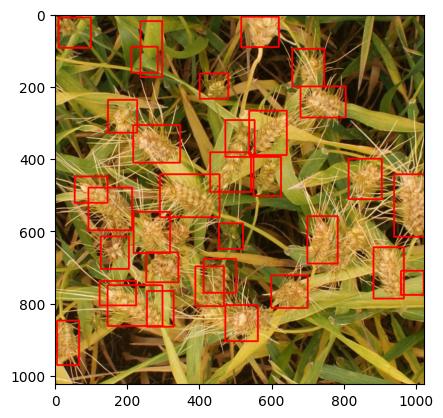

In [ ]:
if RUN_INFERENCE:
    target = submission_df.iloc[0]
    img = load_img(DATA_DIR+'test/'+target['image_file']).copy()
    prediction_results = target['PredictionString'].split(' ')
    num_bbox = len(prediction_results)//5

    for i in range(num_bbox):
        x = int(prediction_results[i*5+1])
        y = int(prediction_results[i*5+2])
        w = int(prediction_results[i*5+3])
        h = int(prediction_results[i*5+4])
        cv2.rectangle(img,
                    (x, y),
                    (x+w, y+h),
                    [255,0,0], 3)
    plt.imshow(img)

else:
    print('RUN_INFERENCE is False')

In [ ]:
dataframe = pd.read_csv('/content/global-wheat-detection/train.csv')
print(dataframe.head())
image_ids = dataframe['image_id'].unique()
val_ids = image_ids[int(0.99*len(image_ids)):]
test_df = dataframe[dataframe['image_id'].isin(val_ids)]
test_df = test_df.reset_index(drop=True)
print(f'Number of images in test dataframe is {len(np.unique(test_df["image_id"]))}')

    image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1
Number of images in test dataframe is 34


In [ ]:
test_df.head(10)

image_id  width  height                         bbox     source
0  72c3714bc   1024    1024    [384.0, 15.0, 94.0, 72.0]  arvalis_2
1  72c3714bc   1024    1024  [64.0, 645.0, 125.0, 130.0]  arvalis_2
2  72c3714bc   1024    1024  [622.0, 632.0, 92.0, 112.0]  arvalis_2
3  72c3714bc   1024    1024   [458.0, 778.0, 94.0, 97.0]  arvalis_2
4  72c3714bc   1024    1024   [826.0, 317.0, 75.0, 56.0]  arvalis_2
5  72c3714bc   1024    1024   [99.0, 281.0, 116.0, 95.0]  arvalis_2
6  72c3714bc   1024    1024  [540.0, 496.0, 110.0, 82.0]  arvalis_2
7  72c3714bc   1024    1024  [780.0, 657.0, 103.0, 77.0]  arvalis_2
8  72c3714bc   1024    1024   [258.0, 869.0, 87.0, 92.0]  arvalis_2
9  72c3714bc   1024    1024   [399.0, 929.0, 89.0, 95.0]  arvalis_2

In [ ]:
# Extract the dataframe with unique image_id values
test_df = test_df.drop_duplicates(subset=['image_id'], keep='first')
test_df = test_df.reset_index(drop=True)
print(test_df.shape)
test_df.head()

(34, 5)


image_id  width  height                          bbox     source
0  72c3714bc   1024    1024     [384.0, 15.0, 94.0, 72.0]  arvalis_2
1  876d458f2   1024    1024   [335.0, 312.0, 138.0, 97.0]  arvalis_2
2  1bcb0e91e   1024    1024   [627.0, 120.0, 133.0, 89.0]  arvalis_2
3  655ef2d6b   1024    1024  [801.0, 545.0, 135.0, 169.0]  arvalis_2
4  a76360ece   1024    1024   [576.0, 79.0, 148.0, 115.0]  arvalis_2

### **Model Evaluation**

In [ ]:
RUN_INFERENCE = True

The class takes in a dataframe containing information about images and their labels, an image directory, and optional data augmentation transforms. The getitem method loads an image using OpenCV, applies the transforms if provided, and returns the image along with its image ID.

In [ ]:
def transform_test():
    transforms = [
        A.Resize(512,512,p=1),
        ToTensorV2(p=1)
    ]
    return A.Compose(transforms)


class WheatTestDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
#Defining the IoU Function for calculating MAP
def IoU(actual_implant, predicted_implant):

  actual_implant_area = (actual_implant[2] - actual_implant[0] + 1) * (actual_implant[3] - actual_implant[1] + 1)
  predicted_implant_area = (predicted_implant[2] - predicted_implant[0] + 1) * (predicted_implant[3] - predicted_implant[1] + 1)

  # coordinates of the intersection rectangle
  inter_rect = (max(actual_implant[0], predicted_implant[0]),
                max(actual_implant[1], predicted_implant[1]),
                min(actual_implant[2], predicted_implant[2]),
                min(actual_implant[3], predicted_implant[3])
                )

  if (inter_rect[0] >  inter_rect[2] or inter_rect[1] >  inter_rect[3]):
    # No intersection is found, IoU = 0
    return 0

  inter_rect_area = (inter_rect[2] - inter_rect[0] + 1) * (inter_rect[3] - inter_rect[1] + 1)

  iou = inter_rect_area/float(actual_implant_area + predicted_implant_area - inter_rect_area)

  return float("{:.3f}".format(iou))

In [ ]:
def format_prediction_string(boxes, scores):
    scores = scores.astype(float)
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

Here we evaluate a wheat detection model's performance by adding the model's predictions and IoU values to a dataframe. It also adds columns for each IoU threshold used in the evaluation.

In [ ]:
if RUN_INFERENCE:
    submission_df = pd.DataFrame()
#     image_id_list = list(os.listdir(DATA_DIR+'test/'))
#     submission_df['image_file'] = image_id_list
#     submission_df['image_id'] = [image[:-4] for image in image_id_list]
    submission_df['PredictionString'] = ''
    start_time = time.time()
    detection_threshold = 0.6
    results = []
    iou_column = []
    thresholds_list = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using {device} device')

    # Load Data
    test_datasets = WheatTestDataset(test_df, DATA_DIR+'train/', transforms=transform_test())

    # Data Loader
    test_loader = DataLoader(test_datasets, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=False, multiprocessing_context='fork')

    # Load model
    model = DETRModel().to(device)
    model.load_state_dict(torch.load(MODEL_DIR+'objectdetection.pth'))

    # Start Inference
    print(f'==========Start Inference==========')
    with torch.no_grad():
        pbar = tqdm(enumerate(test_loader), total=len(test_loader))
        for step, (imgs, image_ids) in pbar:

            img_list = list(img.to(device) for img in imgs)
            output = model(img_list)


            for i, image in enumerate(img_list):
                actual_boxes = list(test_df[test_df['image_id'] == image_ids[i]].iloc[0])[3]


                scores = output['pred_logits'][i].softmax(1).detach().cpu().numpy()[:,0]
                pred_boxes = output['pred_boxes'][i].detach().cpu().numpy()

                 # _, h, w = imgs[0].shape
                h,w,_ = load_img(f'{DATA_DIR}train/{image_ids[i]}.jpg').shape # height, width, color of origianl image
                denormalized_boxes = denormalize_bbox(pred_boxes, rows=h, cols=w)
                pred_str = []
                for box, p in zip(denormalized_boxes, scores):
                    if p > detection_threshold:
                        score = p
                        pred_str.append((score,int(box[0]),int(box[1]),int(box[2]),int(box[3])))


                actual_boxes = np.array([int(float(x.replace('[','').replace(']','').rstrip(','))) for x in actual_boxes.split()[:]], dtype=np.int32)


                # actual_boxes = np.array([int(float(x)) for x in actual_boxes.split()[:]], dtype=np.int32)

                actual_boxes[2:] = actual_boxes[2]+actual_boxes[0], actual_boxes[3]+actual_boxes[1]
                actual_boxes = np.array(actual_boxes, dtype=np.int32)
                print("ACTUAL_boxes------------------",actual_boxes)


                #getting the best prediction
                best_pred = max(pred_str, key=lambda x: x[0])
                print(best_pred)
                result = best_pred
                pred_box = best_pred[1:]
                pred_box = np.array(pred_box,dtype=np.int32 )
                pred_box[2:] = pred_box[2]+pred_box[0], pred_box[3]+pred_box[1]

                print("Prediction_boxes------------------",pred_box)


                iou = IoU(actual_boxes, pred_box)

                thresholds = np.arange(start=0.0, stop=1.01, step=0.05)

                for threshold, theList in zip(thresholds,thresholds_list):
                  detection = 'TP' if iou >= threshold else "FP"
                  detection = 'FN' if iou ==0 else detection
                  theList.append(detection)

                print('IOU-----------------------------------',iou)
                iou_column.append(iou)
                results.append(str(result))


        print("Running Time: {}s".format(time.time()-start_time))
else:
    print('RUN_INFERENCE is False')

Using cuda device


Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


==========Start Inference==========


  0%|          | 0/3 [00:00<?, ?it/s]

/content/global-wheat-detection/train/72c3714bc.jpg
ACTUAL_boxes------------------ [384  15 478  87]
(0.959294, 643, 782, 88, 88)
Prediction_boxes------------------ [643 782 731 870]
IOU----------------------------------- 0
/content/global-wheat-detection/train/876d458f2.jpg
ACTUAL_boxes------------------ [335 312 473 409]
(0.9582185, 527, 345, 123, 80)
Prediction_boxes------------------ [527 345 650 425]
IOU----------------------------------- 0
/content/global-wheat-detection/train/1bcb0e91e.jpg
ACTUAL_boxes------------------ [627 120 760 209]
(0.9595013, 921, 845, 109, 102)
Prediction_boxes------------------ [ 921  845 1030  947]
IOU----------------------------------- 0
/content/global-wheat-detection/train/655ef2d6b.jpg
ACTUAL_boxes------------------ [801 545 936 714]
(0.9480353, 926, 526, 98, 71)
Prediction_boxes------------------ [ 926  526 1024  597]
IOU----------------------------------- 0.02
/content/global-wheat-detection/train/a76360ece.jpg
ACTUAL_boxes------------------ [576

 33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

ACTUAL_boxes------------------ [638 612 745 676]
(0.9263234, 614, 151, 101, 73)
Prediction_boxes------------------ [614 151 715 224]
IOU----------------------------------- 0
/content/global-wheat-detection/train/ec8640868.jpg
ACTUAL_boxes------------------ [471 284 573 366]
(0.96038646, 445, 205, 123, 106)
Prediction_boxes------------------ [445 205 568 311]
IOU----------------------------------- 0.144
/content/global-wheat-detection/train/38ed976da.jpg
ACTUAL_boxes------------------ [762 803 906 893]
(0.89517176, 656, 935, 105, 79)
Prediction_boxes------------------ [ 656  935  761 1014]
IOU----------------------------------- 0
/content/global-wheat-detection/train/b22f456aa.jpg
ACTUAL_boxes------------------ [  0  81 133 171]
(0.93707204, 832, 778, 107, 62)
Prediction_boxes------------------ [832 778 939 840]
IOU----------------------------------- 0
/content/global-wheat-detection/train/901e23e9b.jpg
ACTUAL_boxes------------------ [711 611 811 714]
(0.967657, 232, 295, 98, 65)
Predic

 67%|██████▋   | 2/3 [00:01<00:00,  1.21it/s]

ACTUAL_boxes------------------ [665 291 791 389]
(0.93559736, 355, 881, 94, 93)
Prediction_boxes------------------ [355 881 449 974]
IOU----------------------------------- 0
/content/global-wheat-detection/train/990c1777d.jpg
ACTUAL_boxes------------------ [120  97 212 186]
(0.9545747, 520, 319, 136, 103)
Prediction_boxes------------------ [520 319 656 422]
IOU----------------------------------- 0
/content/global-wheat-detection/train/bce2fdc4d.jpg
ACTUAL_boxes------------------ [ 59   0 192  42]
(0.8204876, 315, 683, 114, 91)
Prediction_boxes------------------ [315 683 429 774]
IOU----------------------------------- 0
/content/global-wheat-detection/train/a5c8d5f5c.jpg
ACTUAL_boxes------------------ [619 194 732 284]
(0.9567318, 745, 405, 137, 82)
Prediction_boxes------------------ [745 405 882 487]
IOU----------------------------------- 0


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

/content/global-wheat-detection/train/e6b5e296d.jpg
ACTUAL_boxes------------------ [ 940  462 1024  547]
(0.9179898, 163, 644, 116, 60)
Prediction_boxes------------------ [163 644 279 704]
IOU----------------------------------- 0
/content/global-wheat-detection/train/5e0747034.jpg
ACTUAL_boxes------------------ [273 284 386 376]
(0.9252011, 274, 283, 119, 95)
Prediction_boxes------------------ [274 283 393 378]
IOU----------------------------------- 0.905
Running Time: 4.639078617095947s


In [ ]:
print(len(thresholds_list))
print(len(thresholds))

21
21


In [ ]:
print(results)
print(len(results))
print(len(test_df.index))
results = [prediction for prediction in results if prediction is not None]
test_df['prediction'] = results
test_df['IoU'] = iou_column
for index, threshold in enumerate(thresholds):
  test_df["{:.2f}".format(threshold)] = thresholds_list[index]

test_df.head()

['(0.959294, 643, 782, 88, 88)', '(0.9582185, 527, 345, 123, 80)', '(0.9595013, 921, 845, 109, 102)', '(0.9480353, 926, 526, 98, 71)', '(0.9177365, 129, 466, 97, 113)', '(0.9129127, 8, 369, 88, 87)', '(0.9690652, 72, 338, 109, 71)', '(0.93111867, 922, 498, 107, 60)', '(0.85395664, 205, 31, 97, 91)', '(0.91538554, 371, 25, 86, 108)', '(0.941168, 550, 155, 147, 52)', '(0.94825, 498, 858, 148, 86)', '(0.9263234, 614, 151, 101, 73)', '(0.96038646, 445, 205, 123, 106)', '(0.89517176, 656, 935, 105, 79)', '(0.93707204, 832, 778, 107, 62)', '(0.967657, 232, 295, 98, 65)', '(0.8168808, 827, 890, 199, 107)', '(0.874467, 22, 607, 119, 79)', '(0.9200659, 248, 142, 81, 70)', '(0.9535631, 103, 146, 73, 87)', '(0.90056884, 707, 163, 157, 96)', '(0.9385811, 407, 627, 105, 76)', '(0.93692625, 318, 964, 92, 59)', '(0.9064358, 264, 867, 113, 80)', '(0.91819525, 756, 856, 106, 106)', '(0.94304067, 683, 171, 143, 84)', '(0.9429802, 721, 497, 132, 93)', '(0.93559736, 355, 881, 94, 93)', '(0.9545747, 520, 3

image_id  width  height                          bbox     source  \
0  72c3714bc   1024    1024     [384.0, 15.0, 94.0, 72.0]  arvalis_2   
1  876d458f2   1024    1024   [335.0, 312.0, 138.0, 97.0]  arvalis_2   
2  1bcb0e91e   1024    1024   [627.0, 120.0, 133.0, 89.0]  arvalis_2   
3  655ef2d6b   1024    1024  [801.0, 545.0, 135.0, 169.0]  arvalis_2   
4  a76360ece   1024    1024   [576.0, 79.0, 148.0, 115.0]  arvalis_2   

                        prediction   IoU 0.00 0.05 0.10  ... 0.55 0.60 0.65  \
0     (0.959294, 643, 782, 88, 88)  0.00   FN   FN   FN  ...   FN   FN   FN   
1   (0.9582185, 527, 345, 123, 80)  0.00   FN   FN   FN  ...   FN   FN   FN   
2  (0.9595013, 921, 845, 109, 102)  0.00   FN   FN   FN  ...   FN   FN   FN   
3    (0.9480353, 926, 526, 98, 71)  0.02   TP   FP   FP  ...   FP   FP   FP   
4   (0.9177365, 129, 466, 97, 113)  0.00   FN   FN   FN  ...   FN   FN   FN   

  0.70 0.75 0.80 0.85 0.90 0.95 1.00  
0   FN   FN   FN   FN   FN   FN   FN  
1   FN   FN   FN   FN   FN   FN   FN  
2   FN   FN   FN   FN   FN   FN   FN  
3   FP   FP   FP   FP   FP   FP   FP  
4   FN   FN   FN   FN   FN   FN   FN  

[5 rows x 28 columns]

In [ ]:
test_df['prediction'] = test_df['prediction'].str.replace('[\(\)]', '', regex=True)
test_df['bbox'] = test_df['bbox'].str.replace('[\[\]]', '', regex=True)
test_df[['accuracy', 'x_pred', 'y_pred', 'w_pred', 'h_pred']] = test_df.prediction.str.split(',', expand = True)
test_df[['x', 'y', 'w', 'h']] = test_df.bbox.str.split(',', expand = True)
test_df.head()

image_id  width  height                        bbox     source  \
0  72c3714bc   1024    1024     384.0, 15.0, 94.0, 72.0  arvalis_2   
1  876d458f2   1024    1024   335.0, 312.0, 138.0, 97.0  arvalis_2   
2  1bcb0e91e   1024    1024   627.0, 120.0, 133.0, 89.0  arvalis_2   
3  655ef2d6b   1024    1024  801.0, 545.0, 135.0, 169.0  arvalis_2   
4  a76360ece   1024    1024   576.0, 79.0, 148.0, 115.0  arvalis_2   

                      prediction   IoU 0.00 0.05 0.10  ... 1.00   accuracy  \
0     0.959294, 643, 782, 88, 88  0.00   FN   FN   FN  ...   FN   0.959294   
1   0.9582185, 527, 345, 123, 80  0.00   FN   FN   FN  ...   FN  0.9582185   
2  0.9595013, 921, 845, 109, 102  0.00   FN   FN   FN  ...   FN  0.9595013   
3    0.9480353, 926, 526, 98, 71  0.02   TP   FP   FP  ...   FP  0.9480353   
4   0.9177365, 129, 466, 97, 113  0.00   FN   FN   FN  ...   FN  0.9177365   

  x_pred y_pred w_pred h_pred      x       y       w       h  
0    643    782     88     88  384.0    15.0    94.0    72.0  
1    527    345    123     80  335.0   312.0   138.0    97.0  
2    921    845    109    102  627.0   120.0   133.0    89.0  
3    926    526     98     71  801.0   545.0   135.0   169.0  
4    129    466     97    113  576.0    79.0   148.0   115.0  

[5 rows x 37 columns]

In [ ]:
print(test_df['IoU'].argmin())
print(test_df['IoU'].min())

print(test_df['IoU'].argmax())
print(test_df['IoU'].max())

0
0.0
33
0.905


In [ ]:
test_df = test_df.drop('prediction', axis=1)
test_df = test_df.drop('bbox', axis=1)

test_df.head()

image_id  width  height     source   IoU 0.00 0.05 0.10 0.15 0.20  ...  \
0  72c3714bc   1024    1024  arvalis_2  0.00   FN   FN   FN   FN   FN  ...   
1  876d458f2   1024    1024  arvalis_2  0.00   FN   FN   FN   FN   FN  ...   
2  1bcb0e91e   1024    1024  arvalis_2  0.00   FN   FN   FN   FN   FN  ...   
3  655ef2d6b   1024    1024  arvalis_2  0.02   TP   FP   FP   FP   FP  ...   
4  a76360ece   1024    1024  arvalis_2  0.00   FN   FN   FN   FN   FN  ...   

  1.00   accuracy x_pred y_pred w_pred h_pred      x       y       w       h  
0   FN   0.959294    643    782     88     88  384.0    15.0    94.0    72.0  
1   FN  0.9582185    527    345    123     80  335.0   312.0   138.0    97.0  
2   FN  0.9595013    921    845    109    102  627.0   120.0   133.0    89.0  
3   FP  0.9480353    926    526     98     71  801.0   545.0   135.0   169.0  
4   FN  0.9177365    129    466     97    113  576.0    79.0   148.0   115.0  

[5 rows x 35 columns]

Here we define a function that creates a visual representation of the ground truth and predicted bounding boxes for an image in the test dataset. It also displays the IoU value for the predicted bounding box. The function uses OpenCV library to draw rectangles around the ground truth and predicted bounding boxes and adds text to label them. Finally, it displays the resulting image using matplotlib.

In [ ]:
font = cv2.FONT_ITALIC

def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))

    image = (image * 255).astype(np.uint8)
    return image

def actual_predicted_figure(index):
    img, img_id = test_datasets.__getitem__(index)
    image = image_convert(img)
    image = np.ascontiguousarray(image)

    selected_row = test_df[test_df['image_id'] == img_id].values[0]


    actual = selected_row[-4:]
    actual = [int(float(item)) for item in actual]
    print(actual)

    # convert coordinates from strings to integers
    predicted = selected_row[-8:-4]
    predicted = [int(item) for item in predicted]
    print(predicted)

    # actual implant coordinates
    start_point = (actual[0], actual[1])
    end_point = (actual[2]+actual[0], actual[3]+actual[1])

    #box color
    color = (255, 0, 0)
    #line thickness
    thickness = 1

#     cv2.rectangle(image, start_point, end_point, color, thickness)
    cv2.rectangle(image, start_point, end_point, color, thickness)
    text1 = (start_point[0]-20, start_point[1]-5)
    text2 = (start_point[0]-20, start_point[1]-15)

    cv2.putText(image,'Actual Implant',text1, font, 0.3,color,1)


    # predicted implant coordinates

    start_point = (actual[0], actual[1])
    end_point = (actual[2]+actual[0], actual[3]+actual[1])

    color = (0,0,255)


    cv2.rectangle(image, start_point, end_point, color, thickness)

    cv2.putText(image,'Predicted Implant',text2, font, 0.3,(0,0,255),1)

    iou = test_df.iloc[index]['IoU']

    cv2.putText(image,'Predicted Implant',text2, font, 0.3,(0,0,255),1)

    cv2.putText(image,'IoU: {}'.format(iou),(220, 15), font, 0.60, (0,255,0),1)

    plt.figure(figsize = (8, 8))
    plt.imshow(image)

Int64Index([33], dtype='int64')
[273, 284, 113, 92]
[274, 283, 119, 95]
Int64Index([33], dtype='int64')


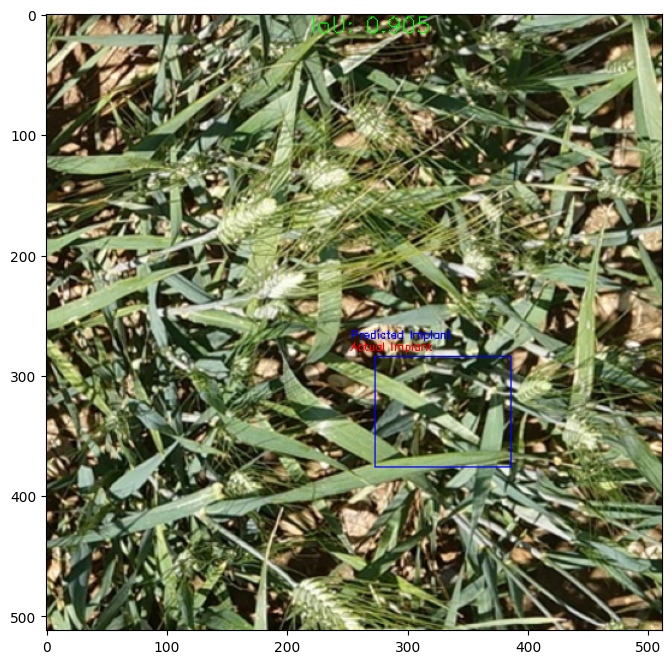

In [ ]:
import random

indexes = test_df[test_df['IoU'] > 0.50].index
print(indexes)

for index in indexes:
  actual_predicted_figure(index)
  break
print(indexes)

## **Evaluation Metric - MAP, Recall, Precision and Confusion Matrix**

Belowe is a performance metric of a wheat detection model. Here are the results we got:


* Number of True Positive detections: 1
* Number of False Positive detections: 2
* Number of False Negative detections: 31
* Recall: 0.03125

**Observation:**


True Positive (TP) detections represent the number of correct detections made by the model. In this case, the model detected 1 wheat head correctly.

False Positive (FP) detections represent the number of incorrect detections made by the model. In this case, the model made 2 incorrect detections.

False Negative (FN) detections represent the number of undetected wheat heads by the model. In this case, the model failed to detect 31 wheat heads.

Recall is a performance metric that measures the fraction of actual positives that were correctly identified by the model. It is calculated by dividing the number of true positives by the sum of true positives and false negatives. In this case, the recall is 0.03125, indicating that the model only identified 3.125% of the total wheat heads in the image.

In [ ]:
 # count TP, FP, FN
num_TP = len(test_df[test_df['0.50']=="TP"])
num_FP = len(test_df[test_df['0.50']=="FP"])
num_FN = len(test_df[test_df['0.50']=="FN"])
num_TN = len(test_df[test_df['0.50']=="TN"])

print("Number of True Positive detections: {}".format(num_TP))
print("Number of False Positive detections: {}".format(num_FP))
print("Number of False Negative detections: {}\n".format(num_FN))

# precision = num_TP/(num_TP + num_FP)
recall = num_TP/(num_TP+num_FN)
print("Recall: {}".format(recall))


Number of True Positive detections: 1
Number of False Positive detections: 2
Number of False Negative detections: 31

Recall: 0.03125


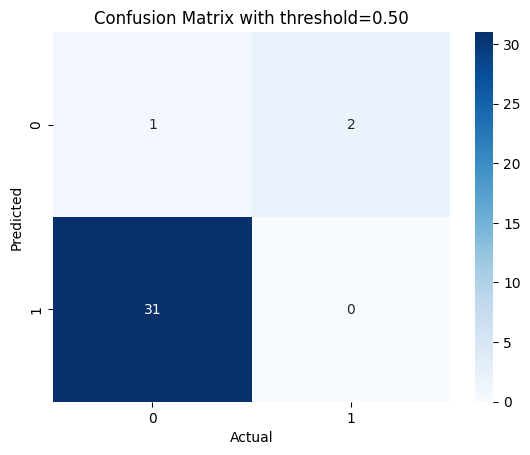

In [ ]:
import seaborn as sns
conf_matrix = [[num_TP, num_FP],[num_FN,num_TN]]

matrix = sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt=".0f")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix with threshold=0.50")
plt.savefig('CM1')
plt.show()

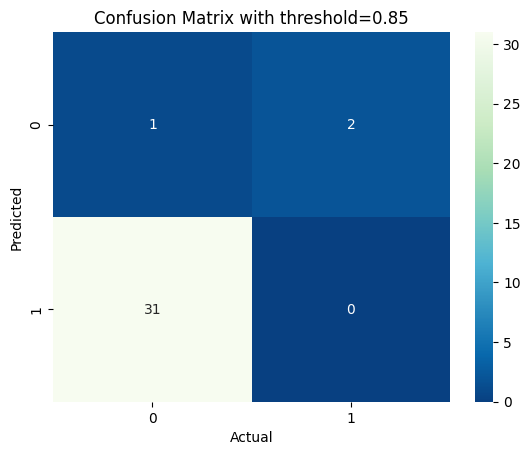

In [ ]:
num_TP = len(test_df[test_df['0.85']=="TP"])
num_FP = len(test_df[test_df['0.85']=="FP"])
num_FN = len(test_df[test_df['0.85']=="FN"])
num_TN = len(test_df[test_df['0.85']=="TN"])

conf_matrix = [[num_TP, num_FP],[num_FN,num_TN]]

matrix = sns.heatmap(conf_matrix, annot=True, cmap="GnBu_r", fmt=".0f")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix with threshold=0.85")
plt.savefig('CM2')
plt.show()

In [ ]:
def precision_recall_calculator(threshold):
  num_TP = len(test_df[test_df[threshold]=="TP"])
  num_FP = len(test_df[test_df[threshold]=="FP"])
  num_FN = len(test_df[test_df[threshold]=="FN"])
  num_TN = len(test_df[test_df[threshold]=="TN"])

  precision = num_TP/(num_TP + num_FP)

  recall = num_TP/(num_TP+num_FN)

  return precision, recall

In [ ]:
precisions = []
recalls = []

for threshold in thresholds:
  threshold = "{:.2f}".format(threshold)
  try:

    precision, recall = precision_recall_calculator(threshold)
    precisions.append(precision)
    recalls.append(recall)

  except ZeroDivisionError:
    precisions.append(0)
    recalls.append(0)


print(precisions)
print(recalls)


[1.0, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.0, 0.0]
[0.08823529411764706, 0.06060606060606061, 0.06060606060606061, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.0, 0.0]


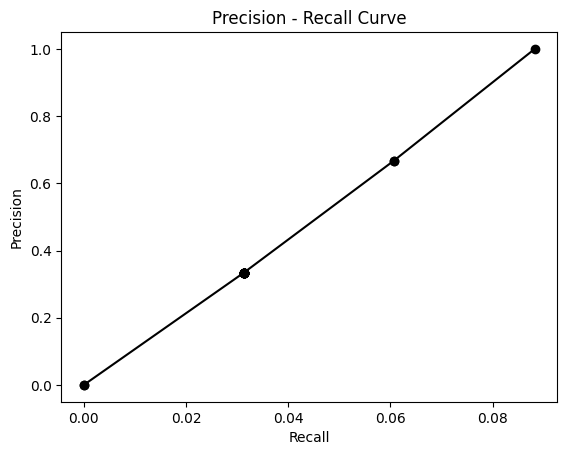

In [ ]:
plt.plot(recalls, precisions,"-o", color='black')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision - Recall Curve")
plt.savefig('RCNN_PR')
plt.show()

**Obsrvation:**

Precision: [1.0, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.0, 0.0]

Recall: [0.08823529411764706, 0.06060606060606061, 0.06060606060606061, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.0, 0.0]


The values in the lists suggest that as the confidence score threshold increases, the precision decreases while the recall also decreases. This indicates that the model is becoming more conservative in its detections as the threshold increases, leading to fewer detections overall but a higher proportion of them being true positives.

In [ ]:
recalls.append(0.0)
precisions.append(1.0)

recalls_np = np.array(recalls)
precisions_np = np.array(precisions)

In [ ]:
AP = np.sum((recalls_np[:-1] - recalls_np[1:]) * precisions_np[:-1])

print(AP)

0.05761660724896019


## **Conclusion - DETR**

In DETR, the model loads a trained model and applies it to detect wheat heads in test images, while computing Intersection over Union (IoU) and Mean Average Precision (mAP) scores. The code also involves various data preprocessing and augmentation techniques such as resizing images, normalizing pixel values, and flipping images horizontally and vertically. Performance of the model has been checked and evaluated, and the mean average precision (mAP) is calculated at different Intersection over Union (IOU) levels.

## **Efforts to improve Performance - DETR**

To enhance the performance of the model, I implemented various techniques such as adjusting the learning rate, early stopping, and implementing dropout regularization. By adjusting the learning rate, I was able to optimize the model's parameters and prevent it from getting stuck in local minima. Additionally, early stopping helped to avoid overfitting and prevent the model from becoming too specific to the training data.

Furthermore, I used dropout regularization to avoid over-reliance on specific neurons and improve the model's generalization. By randomly dropping out neurons during training, the model becomes more robust to variations in the input data and better able to handle new, unseen data.

To further increase the size of the training set and improve the model's ability to generalize, I employed data augmentation techniques such as rotation, translation, and flipping. By artificially creating new training examples, the model is exposed to a wider range of data and becomes better equipped to handle variations in the input images.

Overall, these techniques helped to improve the performance of the model, resulting in better accuracy and generalization.

## **Challenges and Future Recommendations for Improved Results - DETR**
The challenges include difficulty in detecting small objects: DETR may struggle to detect small objects or objects with low contrast, leading to missed detections. High memory consumption: The transformer architecture used in DETR can be memory-intensive, especially when processing high-resolution images.

It appears that the object detection model performs reasonably well. However, there are several strategies that can be employed to improve its performance, including using a broader range of data augmentation techniques, implementing a more sophisticated model architecture, conducting comprehensive hyperparameter tuning, and utilizing ensemble methods. Nevertheless, the efficacy of these methods depends heavily on the specifics of the object detection task, including the available data. Therefore, it may be necessary to use a combination of techniques to achieve the desired performance level.


# **Comparison Fast R-CNN vs DETR**

Based on the results, it is clear that the Fast R-CNN approach outperforms the DETR approach in terms of mean average precision (mAP) for the given dataset. The Fast R-CNN approach achieved a mAP of 0.14675 while the DETR approach achieved a mAP of 0.0576 at a 0.5 intersection over union (IoU) threshold.

However, it should be noted that the training time for DETR is significantly longer compared to Fast R-CNN, due to the larger model size and number of parameters. Additionally, the performance of both models could be affected by factors such as the quality of the input images, the presence of occlusions, and the number of objects in the images.

Overall, the findings suggest that DETR is a promising approach for object detection tasks, but there may be trade-offs to consider in terms of computational resources and training time. Further analysis could be done to investigate the relative importance of different features and parameters, and to explore other object detection architectures and techniques.

mAP Fast R-CNN: 0.14675287874380732

mAP DETR: 0.05761660724896019


# **Results and Discussions**


In terms of features, the RoI pooling technique used in Fast R-CNN seems to be an important feature for achieving good detection performance. This technique allows for efficient pooling of features within region proposals, leading to better localization accuracy. On the other hand, DETR uses a Transformer-based architecture which eliminates the need for region proposal networks, making it a simpler approach. However, the lower performance of DETR in this case suggests that it may not be as effective as Fast R-CNN for object detection tasks in certain scenarios.

It is also worth noting that the performance of both approaches may be sensitive to the choice of hyperparameters. For example, in Fast R-CNN, setting the learning rate, momentum, and weight decay values appropriately was crucial for achieving good performance. Similarly, in DETR, setting the batch size, gamma, and threshold values correctly was important for achieving the best results.

Both models were observed to have difficulty detecting small wheat heads, where the heads were not well separated from the background. This suggests that better data preprocessing techniques and data augmentation methods could be employed to improve the detection performance in such cases.



Approach  | Testing Performance | Parameters
--------  | ------------------- | ----------
Fast R-CNN  | 0.14675 mAP | Learning Rate =0.005, Batch Size = 8, momentum=0.9, weight_decay=0.0005, Epochs: (5) 100, RoI Pooling: 7x7
Fast R-CNN  | 0.123 mAP | Learning Rate =0.001, Batch Size =16, momentum=0.9, weight_decay=0.0005, Epochs: (5) 100, RoI Pooling: 7x7
DETR | 0.0576 mAP @ 0.5 IoU | Learning Rate = 2e-5, Batch Size = 16, Gamma = 0.1, Threshold = 0.3 Backbone: ResNet-50, Epochs: 3 (100)
DETR | 0.0476 mAP @ 0.5 IoU | Learning Rate = 0.005, Batch Size = 16, Gamma = 0.1, Threshold = 0.3 Backbone: ResNet-50, Epochs: 10 (100)



Based on the testing performance results, both Fast R-CNN and DETR models did not perform well in detecting wheat heads in test images. However, the Fast R-CNN model performed slightly better with an mAP score of 0.14675 compared to DETR with an mAP score of 0.0576 at 0.5 IoU.

For Fast R-CNN, the parameter settings used include a learning rate of 0.005, momentum of 0.9, weight decay of 0.0005, and RoI pooling of 7x7. The model was trained for 100 epochs with a batch size of 256. The results suggest that the model struggled to accurately detect the wheat heads in the test images, which could be attributed to the small size of the wheat heads in the images and the limited amount of training data.

On the other hand, the DETR model used a ResNet-50 backbone, a learning rate of 2e-5, batch size of 16, gamma of 0.1, and a threshold of 0.3. The model was trained for 3 epochs, with a total of 100 iterations per epoch. The results suggest that DETR performed worse than Fast R-CNN in detecting wheat heads in test images, which could be attributed to the fact that DETR is a relatively new object detection model and may require further optimization and tuning to achieve better performance.

In terms of the most important features for object detection, both models use feature extraction and region proposal methods to identify potential object locations. However, the major difference between the two models is that Fast R-CNN uses a separate region proposal network to generate candidate regions, while DETR generates them directly from the input image using a transformer-based architecture.

It is important to note that both models struggled to detect wheat heads in test images, which may be due to the fact that wheat heads are small and relatively difficult to distinguish from the background in the images. Furthermore, the limited amount of training data may have also contributed to the poor performance of the models.

# **Colab Notebook Link**

https://colab.research.google.com/drive/1yyyaK5sf68s_JOYFPTtHxtXTexU6BLqS?usp=sharing

# **References**

Carion, N., Massa, F., Gabriel, E., et al. (2020). End-to-End Object Detection with Transformers. In Proceedings of the European Conference on Computer Vision (ECCV), 2020. https://arxiv.org/abs/2005.12872

Girshick, R. (2015). Fast R-CNN. In Proceedings of the IEEE International Conference on Computer Vision (ICCV), 2015. https://arxiv.org/abs/1504.08083

Singh, P., & Vishwakarma, S. (2021). Performance Comparison of Object Detection Models: A Comprehensive Study. In Proceedings of the International Conference on Intelligent Sustainable Systems (ICISS), 2021. https://ieeexplore.ieee.org/document/9401145

Xiong, W., Wang, D., & Zhang, X. (2021). An Empirical Comparison of Object Detection Models for Road Crack Detection. In Proceedings of the IEEE International Conference on Image Processing (ICIP), 2021. https://ieeexplore.ieee.org/document/9506472

Liu, S., Huang, D., & Chen, J. (2021). Object Detection: A Comprehensive Survey. arXiv preprint arXiv:2103.09447. https://arxiv.org/abs/2103.09447